In [1]:
# Parameters
var_list = [
    "cape",
    "crr",
    "d",
    "ie",
    "ishf",
    "lsrr",
    "pv",
    "q",
    "r",
    "sp",
    "tcw",
    "tcwv",
    "t",
    "ttr",
    "u",
    "v",
    "vo",
    "w",
]
plevel_list = [
    False,
    False,
    300,
    False,
    False,
    False,
    300,
    300,
    300,
    False,
    False,
    False,
    300,
    False,
    300,
    300,
    300,
    300,
]
aew_subset = "12hr_before"
model_save_name = "best_model13_300.keras"
tuner_project_name = "tuner_runmodel13_300"


In [2]:
#!/usr/bin/env python

# coding: utf-8


import numpy as np

import matplotlib.pyplot as plt

import xarray as xr

import sklearn

import sklearn.model_selection

import keras

from keras import layers

import keras_tuner



import tensorflow as tf

import tensorflow.keras.backend as K

keras.utils.set_random_seed(812)

2025-07-16 02:56:41.428829: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-16 02:56:41.436221: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-16 02:56:41.548064: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-16 02:56:41.588965: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752656201.642034   24687 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752656201.65

In [3]:
import tensorflow as tf

def focal_loss(gamma=2.0, alpha=0.25):
    """Focal Loss for binary classification."""
    def loss_fn(y_true, y_pred):
        # Clip to prevent NaNs 
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        modulating_factor = tf.pow(1.0 - p_t, gamma)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        return alpha_factor * modulating_factor * bce
    return loss_fn


In [4]:
#functions to calculate f1 score as loss function

def f1_loss_sigmoid(y_true, y_pred):
    """

    F1 metric for sigmoid output and integer encoded labels.

"""

    # compute tp, fp, and fn

    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)

    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)

    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)


    # precision (tp / (tp + fp))

    p = tp / (tp + fp + K.epsilon())

   # recall (tp / (tp + fn))

    r = tp / (tp + fn + K.epsilon())


# harmonic mean of precision and recall

    f1 = (2 * p * r) / (p + r + K.epsilon())

    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)

    return 1 - K.mean(f1)

In [5]:
def f1_loss_onehot(y_true, y_pred):

   """

   F1 metric for two-class output and one-hot encoded labels.

   """

   # compute tp, fp, and fn

   tp = K.sum(K.cast(y_true[:, 1] * y_pred[:, 1], 'float'), axis=0)

   fp = K.sum(K.cast((1 - y_true[:, 1]) * y_pred[:, 1], 'float'), axis=0)

   fn = K.sum(K.cast(y_true[:, 0] * (1 - y_pred[:, 0]), 'float'), axis=0)


   # precision (tp / (tp + fp))

   p = tp / (tp + fp + K.epsilon())

   # recall (tp / (tp + fn))

   r = tp / (tp + fn + K.epsilon())


   # harmonic mean of precision and recall

   f1 = (2 * p * r) / (p + r + K.epsilon())

   f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)

   return 1 - K.mean(f1)

In [6]:
import re


def add_dim(ds):
    # Extract the source file name from the dataset's encoding.
    fname = ds.encoding.get('source', '')
    # Use a regex to capture the central latitude and longitude from the filename.
    m = re.search(r'_(\-?\d+\.\d+)_(-?\d+\.\d+)\.nc$', fname)
    if m:
        lat_center = float(m.group(1))
        lon_center = float(m.group(2))
        # Assign the central coordinates and the file name as new coordinates.
        ds = ds.assign_coords(lat_center=lat_center, lon_center=lon_center, file_name=fname)
    else:
        print("File name does not match expected pattern:", fname)
    
    # Expand dims to add the 'sample' dimension and drop unnecessary variables.
    return ds.assign_coords({"sample": 1}).expand_dims(dim={"sample": 1}).drop_vars("utc_date").drop_vars("latitude").drop_vars("longitude")




    

In [7]:
import os
import xarray as xr

def open_files_zarr(list_of_vars, aew_subset="12hr_before",
                    directory="/glade/derecho/scratch/rmandava/AEW_time_location_files/",
                    plevel_list=None, zarr_store_path="zarr_data"):
    """
    Opens ERA5 NetCDF files for the given variables. For each variable (or pressure-level variant),
    it checks if a corresponding Zarr store exists in 'zarr_store_path'. If so, it loads the dataset
    from the Zarr store; if not, it opens the NetCDF files, preprocesses them, saves them to Zarr,
    and then returns the dataset.
    """
    # Create the zarr_store_path directory if it doesn't exist.
    if not os.path.exists(zarr_store_path):
        os.makedirs(zarr_store_path)
    
    datas = {}
    for num, var in enumerate(list_of_vars):
        # Determine the key and filename based on whether a pressure level is specified.
        if plevel_list:
            if plevel_list[num]:
                key = f"{var}_{int(plevel_list[num])}"
                file_pattern = f'{directory}/{var}/aew_{aew_subset}_{int(plevel_list[num])}_*.nc'
            else:
                key = var
                file_pattern = f'{directory}/{var}/aew_{aew_subset}_*.nc'
        else:
            key = var
            file_pattern = f'{directory}/{var}/aew_{aew_subset}_*.nc'
        
        # Define the zarr path for this variable.
        zarr_path = os.path.join(zarr_store_path, f"{key}.zarr")
        
        # If the Zarr dataset exists, load from it; otherwise, create it.
        if os.path.exists(zarr_path):
            print(f"Loading {key} from Zarr store.")
            ds = xr.open_zarr(zarr_path)
        else:
            print(f"Creating Zarr store for {key} from NetCDF files.")
            ds = xr.open_mfdataset(
                file_pattern,
                preprocess=add_dim,
                concat_dim="sample",
                combine="nested",
            )
            ds.to_zarr(zarr_path, mode="w")
        datas[key] = ds
    
    return datas


In [8]:
def transpose_load_concat(data_dictionary):
    # Instead of eagerly converting to NumPy arrays, keep the datasets as xarray objects.
    transposed = {}
    for key, ds in data_dictionary.items():
        var_name = key.split('_')[0].upper()
        # Do lazy transpose and add a 'features' dimension
        transposed[key] = ds[var_name].expand_dims('features').transpose('sample', 'latitude', 'longitude', 'features')
    # Concatenate along the new 'features' dimension (if multiple variables exist)
    if len(transposed) > 1:
        data = xr.concat(list(transposed.values()), dim='features',coords='minimal',compat='override')
    else:
        data = list(transposed.values())[0]
    # Use the coordinates (lat_center, lon_center) from one of the datasets.
    # They remain lazy and are not computed until needed.
    first_key = next(iter(data_dictionary))
    lat_center = data_dictionary[first_key]['lat_center']
    lon_center = data_dictionary[first_key]['lon_center']
    label = data_dictionary[first_key]['label']
    return data, label, lat_center, lon_center



In [9]:
def omit_nans(data, label, lat, lon):
    # If data is an xarray DataArray, convert it to a NumPy array
    if hasattr(data, 'values'):
        data = data.values
    maskarray = np.full(data.shape[0], True)
    # Find indices where NaNs occur
    masker = np.unique(np.argwhere(np.isnan(data))[:, 0])
    maskarray[masker] = False

    traindata = data[maskarray, ...]
    trainlabel = label[maskarray]
    lat_filtered = lat[maskarray]
    lon_filtered = lon[maskarray]
    return traindata, trainlabel, lat_filtered, lon_filtered



In [10]:
def zscore(data):

  """

  Rescaling the data using zscore (mean/std).

  Each variable gets scaled independently from others.

  Note that we will need to remove test data for formal training.

  """

  for i in range(0, data_.shape[-1]):

      data_[:, :, :, i] = (

               data_[:, :, :, i] - np.nanmean(

                     data_[:, :, :, i])) / np.nanstd(data_[:, :, :, i])

  return data_

In [11]:
def minmax(data):

   """

   Rescaling the data using min-max.

   Each variable gets scaled independently from others.

   Note that we will need to remove test data for formal training.

   """

   for i in range(0, data_.shape[-1]):

          data_[:, :, :, i] = (

              data_[:, :, :, i] - np.nanmin(data_[:, :, :, i])

          ) / (np.nanmax(data_[:, :, :, i]) - np.nanmin(data_[:, :, :, i]))
   return data

In [12]:
def random_split(data, label, split=0.3, seed=0):

   """

   Help spliting data randomly for training and testing.

   """

   np.random.seed(0)

   da_indx = np.random.permutation(data.shape[0])

   data = data[da_indx.astype(int)]

   label = label[da_indx.astype(int)]

   init_range = int(data.shape[0] * (1 - 0.3))

   return data[:init_range], label[:init_range], data[init_range:], label[init_range:]

In [13]:
def pick_loss(loss_string):
    

    lossdict = {
        "relu": tf.nn.relu,
        "tanh": tf.nn.tanh,
        "selu": tf.nn.selu,
        "sigmoid": tf.nn.sigmoid,
        "relu6": tf.nn.relu6,
        "silu": tf.nn.silu,
        "gelu": tf.nn.gelu,
        "lrelu": tf.nn.leaky_relu,
    }

    return lossdict[loss_string]

In [14]:
def compute_saliency_map(model, input_sample):
    """
    Compute a saliency map for a given input sample using a gradient-based approach.
    
    Args:
        model (tf.keras.Model): The trained Keras model.
        input_sample (numpy array): A single input sample of shape (1, height, width, channels).
    
    Returns:
        saliency (numpy array): The saliency map of shape (height, width).
    """
    # Ensure the model is in inference mode
    model.trainable = False
    input_tensor = tf.convert_to_tensor(input_sample)
    
    # Use GradientTape to record operations for automatic differentiation
    with tf.GradientTape() as tape:
        # Watch the input tensor
        tape.watch(input_tensor)
        # Get the model's prediction
        prediction = model(input_tensor)
    
    # Compute gradients of the prediction with respect to the input
    grads = tape.gradient(prediction, input_tensor)
    
    # If there are multiple channels, take the maximum absolute gradient across channels
    saliency = np.max(np.abs(grads.numpy()), axis=-1)[0]
    return saliency

In [15]:
def compute_saliency_per_channel(model, input_sample):
    """
    Computes the saliency map for each channel of a given input sample.
    
    Args:
        model (tf.keras.Model): The trained Keras model.
        input_sample (numpy array): A single input sample with shape (1, H, W, C).
        
    Returns:
        saliency_maps (numpy array): Absolute gradients with shape (H, W, C) for each channel.
        channel_importance (numpy array): Mean saliency per channel (shape: (C,)).
    """
    # Set the model to inference mode
    model.trainable = False
    input_tensor = tf.convert_to_tensor(input_sample)
    
    # Compute gradients with respect to the input sample using GradientTape
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        prediction = model(input_tensor)
    
    # Calculate gradients: shape (1, H, W, C)
    grads = tape.gradient(prediction, input_tensor)
    
    # Remove the batch dimension: shape becomes (H, W, C)
    grads = grads.numpy()[0]
    
    # Take absolute value to measure importance (magnitude of sensitivity)
    saliency_maps = np.abs(grads)
    
    # Aggregate saliency per channel (e.g., using the mean over spatial dimensions)
    channel_importance = np.mean(saliency_maps, axis=(0, 1))
    
    return saliency_maps, channel_importance

In [16]:
number_of_features = len(var_list)

In [17]:
data = open_files_zarr(
    list_of_vars=var_list,
    aew_subset=aew_subset,
    directory="/glade/derecho/scratch/rmandava/AEW_time_location_files/",
    plevel_list=plevel_list,
    zarr_store_path="/glade/derecho/scratch/rmandava/AEW_time_location_files/Project1/zarr"
)






Loading cape from Zarr store.


Loading crr from Zarr store.
Loading d_300 from Zarr store.
Loading ie from Zarr store.
Loading ishf from Zarr store.


Loading lsrr from Zarr store.
Loading pv_300 from Zarr store.
Loading q_300 from Zarr store.
Loading r_300 from Zarr store.


Loading sp from Zarr store.
Loading tcw from Zarr store.
Loading tcwv from Zarr store.
Loading t_300 from Zarr store.
Loading ttr from Zarr store.
Loading u_300 from Zarr store.


Loading v_300 from Zarr store.
Loading vo_300 from Zarr store.
Loading w_300 from Zarr store.


In [18]:
# transpose the data and concat variables

#data_, labels_ = transpose_load_concat(data)
data_, labels_, sample_lat, sample_lon = transpose_load_concat(data)

print(np.shape(data_))

(2750, 32, 32, 18)


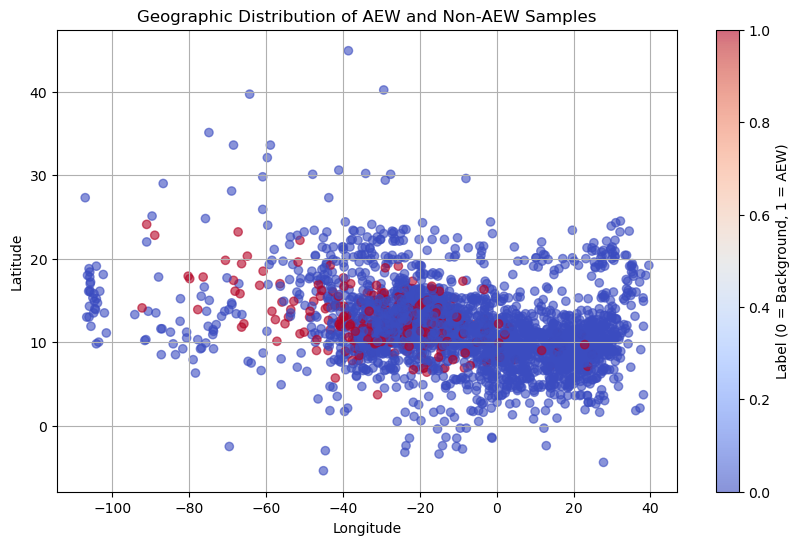

In [19]:
import matplotlib.pyplot as plt

# Scatter plot: where are the samples located, colored by label (AEW or not)
plt.figure(figsize=(10, 6))
sc = plt.scatter(sample_lon, sample_lat, c=labels_, cmap='coolwarm', alpha=0.6)
plt.colorbar(sc, label="Label (0 = Background, 1 = AEW)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geographic Distribution of AEW and Non-AEW Samples")
plt.grid(True)
plt.show()


In [20]:
print(var_list)


['cape', 'crr', 'd', 'ie', 'ishf', 'lsrr', 'pv', 'q', 'r', 'sp', 'tcw', 'tcwv', 't', 'ttr', 'u', 'v', 'vo', 'w']


In [21]:
# check / remove nans

data_, labels_, sample_lat, sample_lon = omit_nans(data_, labels_, sample_lat, sample_lon)






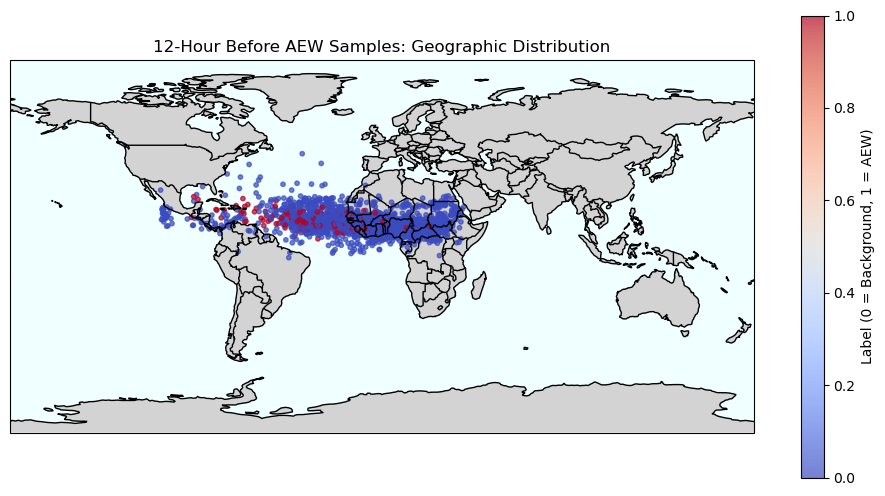

In [22]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.figure(figsize=(12, 6))

# Set up map projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='azure')

# Plot sample locations colored by label
sc = ax.scatter(sample_lon, sample_lat, c=labels_, cmap='coolwarm', s=10, alpha=0.7, transform=ccrs.PlateCarree())
plt.colorbar(sc, ax=ax, label="Label (0 = Background, 1 = AEW)")
plt.title("12-Hour Before AEW Samples: Geographic Distribution")
plt.show()

In [23]:
print("Total samples:", len(sample_lat))


Total samples: 2750


In [24]:
print("Latitude Range:", float(sample_lat.min().compute()), "to", float(sample_lat.max().compute()))
print("Longitude Range:", float(sample_lon.min().compute()), "to", float(sample_lon.max().compute()))


Latitude Range: -5.4 to 44.9
Longitude Range: -107.1 to 39.6


In [25]:
#split train and test set
X_train, X_test, y_train, y_test, lat_train, lat_test, lon_train, lon_test = sklearn.model_selection.train_test_split(
    data_, labels_, sample_lat, sample_lon, test_size=0.2, random_state=42)



print (np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test))


y_train = np.expand_dims(y_train, axis=1)

y_test = np.expand_dims(y_test, axis=1)

(2200, 32, 32, 18) (550, 32, 32, 18) (2200,) (550,)


/glade/u/home/rmandava/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1642: PerformanceWarning: Slicing with an out-of-order index is generating 412 times more chunks
  return self.array[key]
/glade/u/home/rmandava/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1642: PerformanceWarning: Slicing with an out-of-order index is generating 109 times more chunks
  return self.array[key]


In [26]:
# [21]: Scaling code (fixed to prevent data leakage)

# Create the scaler object
scaler_input = sklearn.preprocessing.StandardScaler()

# Reshape training data to 2D (samples, features)
X_train_tmp = np.reshape(X_train, (-1, len(var_list)))

# Fit the scaler ONLY on the training data
scaler_input.fit(X_train_tmp)  # <-- Key change: Learn mean/std from training data

# Transform BOTH training and test data using the SAME scaler
input_train_scaled = scaler_input.transform(X_train_tmp)          # Train: transform only
input_test_scaled = scaler_input.transform(                       # Test: transform only
    np.reshape(X_test, (-1, len(var_list)))
)

# Reshape back to original dimensions (samples, height, width, features)
input_train_scaled = np.reshape(input_train_scaled, X_train.shape)
input_test_scaled = np.reshape(input_test_scaled, X_test.shape)

# Labels remain unchanged
label_train_scaled = y_train
label_test_scaled = y_test

In [27]:
# print the shapes to double check them

print(

input_train_scaled.shape,

label_train_scaled.shape,

input_test_scaled.shape,

label_test_scaled.shape

)

(2200, 32, 32, 18) (2200, 1) (550, 32, 32, 18) (550, 1)


In [28]:
#generate class weights due to class imbalance issues

counts = np.bincount(y_train[:, 0].astype(int))


print(

"Number of positive samples in training data: {} ({:.2f}% of total)".format(

counts[1], 100 * float(counts[1]) / len(y_train))

)

Number of positive samples in training data: 204 (9.27% of total)


In [29]:
# old weights

# weight_for_0 = 1.0 / counts[0]

# weight_for_1 = 1.0 / counts[1]


#new weights

weight_for_0 = float(counts[1]) / len(y_train)

weight_for_1 = 1 - (float(counts[1]) / len(y_train))


class_weight = {0: weight_for_0, 1: weight_for_1}

print(class_weight)

{0: 0.09272727272727273, 1: 0.9072727272727272}


In [30]:
METRICS = [

keras.metrics.BinaryCrossentropy(name='cross entropy'),

keras.metrics.MeanSquaredError(name='mean_squared_error'),

keras.metrics.RootMeanSquaredError(name='root_mean_squared_error'),

keras.metrics.TruePositives(name='tp'),

keras.metrics.FalsePositives(name='fp'),

keras.metrics.TrueNegatives(name='tn'),

keras.metrics.FalseNegatives(name='fn'),

keras.metrics.BinaryAccuracy(name='binary_accuracy'),

keras.metrics.F1Score(threshold=0.5, name='f1_score'),

keras.metrics.Precision(name='precision'),

keras.metrics.Recall(name='recall'),

keras.metrics.AUC(name='auc'),

keras.metrics.AUC(name='prc', curve='PR'),

]

2025-07-16 02:58:54.833342: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [31]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation, Add
from tensorflow.keras.regularizers import l2

class MyHyperModel(keras_tuner.HyperModel):
    def build(self, hp):
        input_shape = (32, 32, 18)
        learning_rate = hp.Float("learning_rate", min_value=1e-5, max_value=1e-2, sampling="log")

        inputs = Input(shape=input_shape)

        # Block 1
        x = Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(inputs)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        # Block 2
        x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        # Block 3 (Residual Block)
        residual = x
        x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(x)
        x = BatchNormalization()(x)
        x = Add()([x, residual])  # Residual connection
        x = Activation('relu')(x)
        x = Dropout(0.25)(x)

        # Dense Layers
        x = Flatten()(x)
        x = Dense(128, kernel_regularizer=l2(1e-4))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Dropout(0.4)(x)

        outputs = Dense(1, activation='sigmoid')(x)

        model = Model(inputs=inputs, outputs=outputs)

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss=focal_loss(gamma=2.0, alpha=0.25),
            metrics=METRICS
        )

        return model







In [32]:
def fit(self, hp, model, *args, **kwargs):
    batchsizenum = hp.Int('batch_size', min_value=10, max_value=60, step=5, sampling="linear")

    print({k: hp.get(k) if hp.is_active(k) else None for k in hp._hps})

    return model.fit(
        *args,
        batch_size=batchsizenum,
        # normally we might use early stopping, but not needed since
        # callbacks saves checkpoints of the model during trials
        # callbacks=keras.callbacks.EarlyStopping('val_loss', patience=5),
        validation_split=0.1,
        shuffle=True,
        class_weight=class_weight,
        **kwargs,
    )


In [33]:
# make the tuner object
tuner = keras_tuner.BayesianOptimization(
    hypermodel=MyHyperModel(),
    objective=keras_tuner.Objective("val_f1_score", direction="max"),
    max_trials=150,
    project_name=tuner_project_name,
    alpha=0.0001,
    beta=2.6,
    seed=123,
    tune_new_entries=True,
    allow_new_entries=True,
    max_retries_per_trial=1,
    max_consecutive_failed_trials=3,
    overwrite=True,
)

# summary
tuner.search_space_summary()


Search space summary
Default search space size: 1
learning_rate (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [34]:
import numpy as np

labels_np = np.array(labels_)

total = len(labels_np)
positives = np.sum(labels_np == 1)
negatives = np.sum(labels_np == 0)

print("Total samples:", total)
print("AEW-positive samples (label=1):", positives)
print("Background samples (label=0):", negatives)


Total samples: 2750
AEW-positive samples (label=1): 258
Background samples (label=0): 2492


In [35]:
# Begin the search
EPOCHS = 100

from sklearn.model_selection import StratifiedShuffleSplit

# Create a stratified split from training data
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_idx, val_idx in sss.split(X_train, y_train):
    X_tune_train, X_tune_val = X_train[train_idx], X_train[val_idx]
    y_tune_train, y_tune_val = y_train[train_idx], y_train[val_idx]

# Run tuner search on new validation data
tuner.search(X_tune_train, y_tune_train,
             validation_data=(X_tune_val, y_tune_val),
             epochs=100)

# Query the tuner object to grab the best models
models = tuner.get_best_models(num_models=5)

# Here is the best model from the tuner
best_model = models[0]
print(best_model.summary())

# Get the top hyperparameters.
best_hps = tuner.get_best_hyperparameters()

# Build the model with the best hyperparameters.
# Assuming your MyHyperModel has a build method that takes a hyperparameter object.
model = MyHyperModel().build(best_hps[0])

# Save the best model (architecture and weights)

save_dir = "/glade/derecho/scratch/rmandava/AEW_time_location_files/models"
model_save_path = os.path.join(save_dir, model_save_name)

model.save(model_save_path)


# Retrain using "best" model hyperparameters
history = model.fit(
    input_train_scaled,
    label_train_scaled,
    epochs=EPOCHS,
    validation_split=0.1,
    batch_size= 32,
    # callbacks=keras.callbacks.EarlyStopping('val_loss', patience=3),
    shuffle=True,
    class_weight=class_weight,  # Ensure 'class_weight' is defined in your scope
)

# Evaluate the model on the test data using `evaluate`
results = model.evaluate(input_test_scaled, label_test_scaled, batch_size=label_test_scaled.shape[0])
print(results)

# Generate predictions (probabilities—the output of the last layer)
predictions = model.predict(input_test_scaled)
print("predictions shape:", predictions.shape)

# Compute confusion matrix elements
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(
    label_test_scaled, np.round(predictions)
).ravel()
print("tn:", tn)
print("fp:", fp)
print("fn:", fn)
print("tp:", tp)


Trial 150 Complete [00h 02m 13s]
val_f1_score: 0.2857142388820648

Best val_f1_score So Far: 0.5128204822540283
Total elapsed time: 05h 16m 00s


/glade/u/home/rmandava/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32,    │          0 │ -                 │
│ (InputLayer)        │ 18)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │      5,216 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 16,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 16, 16,    │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 8, 8, 64)  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 8, 8, 64)  │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 8, 64)  │     36,928 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 8, 8, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 64)  │     36,928 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 8, 8, 64)  │          0 │ batch_normalizat… │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 8, 8, 64)  │          0 │ add[0][0]       

 Total params: 623,521 (2.38 MB)

 Trainable params: 622,817 (2.38 MB)

 Non-trainable params: 704 (2.75 KB)

None
Epoch 1/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2:17 2s/step - auc: 0.7581 - binary_accuracy: 0.8373 - cross entropy: 0.3926 - f1_score: 0.0889 - fn: 20.0000 - fp: 21.0000 - loss: 0.0971 - mean_squared_error: 0.1243 - prc: 0.1515 - precision: 0.0870 - recall: 0.0909 - root_mean_squared_error: 0.3526 - tn: 209.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.6806 - binary_accuracy: 0.7510 - cross entropy: 0.5187 - f1_score: 0.1051 - fn: 20.5000 - fp: 56.2500 - loss: 0.0969 - mean_squared_error: 0.1746 - prc: 0.1272 - precision: 0.0784 - recall: 0.1803 - root_mean_squared_error: 0.4157 - tn: 218.5000 - tp: 4.7500

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.6312 - binary_accuracy: 0.6793 - cross entropy: 0.6311 - f1_score: 0.1193 - fn: 20.8750 - fp: 102.0000 - loss: 0.0977 - mean_squared_error: 0.2165 - prc: 0.1089 - precision: 0.0799 - recall: 0.2790 - root_mean_squared_error: 0.4619 - tn: 232.2500 - tp: 8.8750

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.6127 - binary_accuracy: 0.6410 - cross entropy: 0.6885 - f1_score: 0.1253 - fn: 22.0000 - fp: 135.3636 - loss: 0.0978 - mean_squared_error: 0.2382 - prc: 0.1056 - precision: 0.0810 - recall: 0.3255 - root_mean_squared_error: 0.4844 - tn: 242.5455 - tp: 12.0909

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.6036 - binary_accuracy: 0.6125 - cross entropy: 0.7314 - f1_score: 0.1346 - fn: 22.8571 - fp: 167.8571 - loss: 0.0976 - mean_squared_error: 0.2548 - prc: 0.1069 - precision: 0.0849 - recall: 0.3734 - root_mean_squared_error: 0.5009 - tn: 253.0000 - tp: 16.2857

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.5962 - binary_accuracy: 0.5908 - cross entropy: 0.7659 - f1_score: 0.1410 - fn: 23.5294 - fp: 199.4706 - loss: 0.0974 - mean_squared_error: 0.2677 - prc: 0.1067 - precision: 0.0876 - recall: 0.4118 - root_mean_squared_error: 0.5136 - tn: 264.7647 - tp: 20.2353

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.5921 - binary_accuracy: 0.5741 - cross entropy: 0.7918 - f1_score: 0.1469 - fn: 24.3000 - fp: 229.9000 - loss: 0.0970 - mean_squared_error: 0.2775 - prc: 0.1073 - precision: 0.0902 - recall: 0.4434 - root_mean_squared_error: 0.5232 - tn: 277.5000 - tp: 24.3000

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.5895 - binary_accuracy: 0.5608 - cross entropy: 0.8117 - f1_score: 0.1521 - fn: 25.2609 - fp: 259.4783 - loss: 0.0965 - mean_squared_error: 0.2852 - prc: 0.1088 - precision: 0.0928 - recall: 0.4690 - root_mean_squared_error: 0.5306 - tn: 290.7826 - tp: 28.4783

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.5888 - binary_accuracy: 0.5505 - cross entropy: 0.8273 - f1_score: 0.1576 - fn: 26.4615 - fp: 287.5769 - loss: 0.0960 - mean_squared_error: 0.2911 - prc: 0.1114 - precision: 0.0956 - recall: 0.4902 - root_mean_squared_error: 0.5363 - tn: 305.0385 - tp: 32.9231

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.5890 - binary_accuracy: 0.5420 - cross entropy: 0.8401 - f1_score: 0.1619 - fn: 27.5517 - fp: 315.3448 - loss: 0.0956 - mean_squared_error: 0.2959 - prc: 0.1142 - precision: 0.0979 - recall: 0.5084 - root_mean_squared_error: 0.5409 - tn: 319.9310 - tp: 37.1724

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.5898 - binary_accuracy: 0.5350 - cross entropy: 0.8508 - f1_score: 0.1654 - fn: 28.5938 - fp: 342.6875 - loss: 0.0951 - mean_squared_error: 0.2998 - prc: 0.1164 - precision: 0.0997 - recall: 0.5240 - root_mean_squared_error: 0.5447 - tn: 335.5000 - tp: 41.2188

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.5904 - binary_accuracy: 0.5291 - cross entropy: 0.8598 - f1_score: 0.1681 - fn: 29.6286 - fp: 369.6857 - loss: 0.0947 - mean_squared_error: 0.3030 - prc: 0.1182 - precision: 0.1010 - recall: 0.5372 - root_mean_squared_error: 0.5477 - tn: 351.6571 - tp: 45.0286

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.5909 - binary_accuracy: 0.5242 - cross entropy: 0.8669 - f1_score: 0.1705 - fn: 30.7368 - fp: 396.1579 - loss: 0.0942 - mean_squared_error: 0.3056 - prc: 0.1199 - precision: 0.1022 - recall: 0.5484 - root_mean_squared_error: 0.5502 - tn: 368.3421 - tp: 48.7632

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.5918 - binary_accuracy: 0.5199 - cross entropy: 0.8728 - f1_score: 0.1729 - fn: 31.7805 - fp: 422.5854 - loss: 0.0938 - mean_squared_error: 0.3078 - prc: 0.1215 - precision: 0.1034 - recall: 0.5592 - root_mean_squared_error: 0.5524 - tn: 384.9268 - tp: 52.7073

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.5932 - binary_accuracy: 0.5163 - cross entropy: 0.8777 - f1_score: 0.1754 - fn: 32.8864 - fp: 448.4091 - loss: 0.0934 - mean_squared_error: 0.3096 - prc: 0.1237 - precision: 0.1048 - recall: 0.5689 - root_mean_squared_error: 0.5541 - tn: 401.8864 - tp: 56.8182

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.5946 - binary_accuracy: 0.5134 - cross entropy: 0.8817 - f1_score: 0.1777 - fn: 34.0000 - fp: 473.7234 - loss: 0.0930 - mean_squared_error: 0.3110 - prc: 0.1257 - precision: 0.1061 - recall: 0.5775 - root_mean_squared_error: 0.5555 - tn: 419.4255 - tp: 60.8511

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.5959 - binary_accuracy: 0.5110 - cross entropy: 0.8847 - f1_score: 0.1795 - fn: 35.0400 - fp: 498.7200 - loss: 0.0925 - mean_squared_error: 0.3122 - prc: 0.1272 - precision: 0.1070 - recall: 0.5852 - root_mean_squared_error: 0.5567 - tn: 437.6800 - tp: 64.5600

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.5972 - binary_accuracy: 0.5089 - cross entropy: 0.8872 - f1_score: 0.1810 - fn: 36.1132 - fp: 523.5283 - loss: 0.0921 - mean_squared_error: 0.3131 - prc: 0.1286 - precision: 0.1078 - recall: 0.5920 - root_mean_squared_error: 0.5576 - tn: 456.1321 - tp: 68.2264

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.5986 - binary_accuracy: 0.5072 - cross entropy: 0.8890 - f1_score: 0.1824 - fn: 37.1071 - fp: 548.1250 - loss: 0.0917 - mean_squared_error: 0.3138 - prc: 0.1298 - precision: 0.1084 - recall: 0.5984 - root_mean_squared_error: 0.5583 - tn: 474.9821 - tp: 71.7857

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.5998 - binary_accuracy: 0.5055 - cross entropy: 0.8906 - f1_score: 0.1834 - fn: 38.1525 - fp: 572.7966 - loss: 0.0913 - mean_squared_error: 0.3144 - prc: 0.1309 - precision: 0.1090 - recall: 0.6039 - root_mean_squared_error: 0.5590 - tn: 493.8474 - tp: 75.2034

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.6009 - binary_accuracy: 0.5042 - cross entropy: 0.8917 - f1_score: 0.1845 - fn: 39.2419 - fp: 596.8549 - loss: 0.0909 - mean_squared_error: 0.3149 - prc: 0.1319 - precision: 0.1095 - recall: 0.6089 - root_mean_squared_error: 0.5594 - tn: 513.1774 - tp: 78.6613

62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - auc: 0.6013 - binary_accuracy: 0.5038 - cross entropy: 0.8921 - f1_score: 0.1849 - fn: 39.6032 - fp: 604.5397 - loss: 0.0908 - mean_squared_error: 0.3150 - prc: 0.1322 - precision: 0.1097 - recall: 0.6104 - root_mean_squared_error: 0.5596 - tn: 519.4445 - tp: 79.7778 - val_auc: 0.8986 - val_binary_accuracy: 0.5864 - val_cross entropy: 0.6907 - val_f1_score: 0.2222 - val_fn: 0.0000e+00 - val_fp: 91.0000 - val_loss: 0.1850 - val_mean_squared_error: 0.2485 - val_prc: 0.2871 - val_precision: 0.1250 - val_recall: 1.0000 - val_root_mean_squared_error: 0.4985 - val_tn: 116.0000 - val_tp: 13.0000


Epoch 2/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 0.8917 - binary_accuracy: 0.3438 - cross entropy: 0.8637 - f1_score: 0.1600 - fn: 0.0000e+00 - fp: 21.0000 - loss: 0.0702 - mean_squared_error: 0.3240 - prc: 0.2273 - precision: 0.0870 - recall: 1.0000 - root_mean_squared_error: 0.5692 - tn: 9.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.7767 - binary_accuracy: 0.4023 - cross entropy: 0.8410 - f1_score: 0.1545 - fn: 1.0000 - fp: 45.5000 - loss: 0.0697 - mean_squared_error: 0.3123 - prc: 0.1578 - precision: 0.0852 - recall: 0.8750 - root_mean_squared_error: 0.5588 - tn: 29.2500 - tp: 4.2500   

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.7270 - binary_accuracy: 0.4373 - cross entropy: 0.8195 - f1_score: 0.1562 - fn: 2.5000 - fp: 75.5000 - loss: 0.0691 - mean_squared_error: 0.3016 - prc: 0.1377 - precision: 0.0870 - recall: 0.7976 - root_mean_squared_error: 0.5490 - tn: 58.7500 - tp: 7.2500

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.7077 - binary_accuracy: 0.4561 - cross entropy: 0.8084 - f1_score: 0.1625 - fn: 4.0909 - fp: 95.6364 - loss: 0.0692 - mean_squared_error: 0.2957 - prc: 0.1377 - precision: 0.0915 - recall: 0.7648 - root_mean_squared_error: 0.5436 - tn: 82.2727 - tp: 10.0000

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.6982 - binary_accuracy: 0.4712 - cross entropy: 0.7955 - f1_score: 0.1688 - fn: 6.2857 - fp: 114.2857 - loss: 0.0689 - mean_squared_error: 0.2897 - prc: 0.1494 - precision: 0.0962 - recall: 0.7337 - root_mean_squared_error: 0.5380 - tn: 106.5714 - tp: 12.8571

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.6903 - binary_accuracy: 0.4826 - cross entropy: 0.7886 - f1_score: 0.1727 - fn: 8.2353 - fp: 132.9412 - loss: 0.0689 - mean_squared_error: 0.2862 - prc: 0.1520 - precision: 0.0991 - recall: 0.7132 - root_mean_squared_error: 0.5347 - tn: 131.2941 - tp: 15.5294

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.6866 - binary_accuracy: 0.4932 - cross entropy: 0.7820 - f1_score: 0.1775 - fn: 10.1500 - fp: 150.6000 - loss: 0.0689 - mean_squared_error: 0.2830 - prc: 0.1545 - precision: 0.1026 - recall: 0.7000 - root_mean_squared_error: 0.5317 - tn: 156.8000 - tp: 18.4500

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.6837 - binary_accuracy: 0.5020 - cross entropy: 0.7761 - f1_score: 0.1820 - fn: 12.2609 - fp: 167.8696 - loss: 0.0688 - mean_squared_error: 0.2802 - prc: 0.1580 - precision: 0.1060 - recall: 0.6887 - root_mean_squared_error: 0.5290 - tn: 182.3913 - tp: 21.4783

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.6829 - binary_accuracy: 0.5093 - cross entropy: 0.7706 - f1_score: 0.1875 - fn: 14.3846 - fp: 185.1154 - loss: 0.0687 - mean_squared_error: 0.2776 - prc: 0.1636 - precision: 0.1100 - recall: 0.6818 - root_mean_squared_error: 0.5266 - tn: 207.5000 - tp: 25.0000

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.6844 - binary_accuracy: 0.5161 - cross entropy: 0.7649 - f1_score: 0.1929 - fn: 16.1034 - fp: 202.1379 - loss: 0.0685 - mean_squared_error: 0.2751 - prc: 0.1696 - precision: 0.1137 - recall: 0.6794 - root_mean_squared_error: 0.5242 - tn: 233.1379 - tp: 28.6207

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.6875 - binary_accuracy: 0.5223 - cross entropy: 0.7593 - f1_score: 0.1980 - fn: 17.5000 - fp: 219.1250 - loss: 0.0683 - mean_squared_error: 0.2727 - prc: 0.1767 - precision: 0.1172 - recall: 0.6801 - root_mean_squared_error: 0.5219 - tn: 259.0625 - tp: 32.3125

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.6909 - binary_accuracy: 0.5279 - cross entropy: 0.7543 - f1_score: 0.2026 - fn: 18.6571 - fp: 236.1429 - loss: 0.0681 - mean_squared_error: 0.2706 - prc: 0.1828 - precision: 0.1202 - recall: 0.6825 - root_mean_squared_error: 0.5198 - tn: 285.2000 - tp: 36.0000

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.6947 - binary_accuracy: 0.5329 - cross entropy: 0.7497 - f1_score: 0.2069 - fn: 19.7105 - fp: 253.2105 - loss: 0.0679 - mean_squared_error: 0.2686 - prc: 0.1884 - precision: 0.1231 - recall: 0.6858 - root_mean_squared_error: 0.5179 - tn: 311.2895 - tp: 39.7895

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.6983 - binary_accuracy: 0.5374 - cross entropy: 0.7454 - f1_score: 0.2113 - fn: 20.7073 - fp: 270.1463 - loss: 0.0677 - mean_squared_error: 0.2668 - prc: 0.1936 - precision: 0.1260 - recall: 0.6897 - root_mean_squared_error: 0.5162 - tn: 337.3658 - tp: 43.7805

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.7019 - binary_accuracy: 0.5419 - cross entropy: 0.7414 - f1_score: 0.2160 - fn: 21.6364 - fp: 286.6818 - loss: 0.0675 - mean_squared_error: 0.2651 - prc: 0.1984 - precision: 0.1292 - recall: 0.6942 - root_mean_squared_error: 0.5145 - tn: 363.6136 - tp: 48.0682

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.7053 - binary_accuracy: 0.5459 - cross entropy: 0.7375 - f1_score: 0.2204 - fn: 22.4894 - fp: 303.1702 - loss: 0.0673 - mean_squared_error: 0.2634 - prc: 0.2025 - precision: 0.1321 - recall: 0.6989 - root_mean_squared_error: 0.5129 - tn: 389.9787 - tp: 52.3617

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.7083 - binary_accuracy: 0.5497 - cross entropy: 0.7340 - f1_score: 0.2238 - fn: 23.2800 - fp: 319.7000 - loss: 0.0671 - mean_squared_error: 0.2619 - prc: 0.2055 - precision: 0.1343 - recall: 0.7031 - root_mean_squared_error: 0.5114 - tn: 416.7000 - tp: 56.3200

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.7104 - binary_accuracy: 0.5530 - cross entropy: 0.7308 - f1_score: 0.2267 - fn: 24.2642 - fp: 336.1698 - loss: 0.0670 - mean_squared_error: 0.2606 - prc: 0.2078 - precision: 0.1362 - recall: 0.7058 - root_mean_squared_error: 0.5100 - tn: 443.4906 - tp: 60.0755

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.7123 - binary_accuracy: 0.5560 - cross entropy: 0.7277 - f1_score: 0.2289 - fn: 25.2679 - fp: 352.7500 - loss: 0.0668 - mean_squared_error: 0.2593 - prc: 0.2098 - precision: 0.1377 - recall: 0.7079 - root_mean_squared_error: 0.5088 - tn: 470.3571 - tp: 63.6250

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.7141 - binary_accuracy: 0.5588 - cross entropy: 0.7247 - f1_score: 0.2308 - fn: 26.3051 - fp: 369.2373 - loss: 0.0666 - mean_squared_error: 0.2580 - prc: 0.2120 - precision: 0.1389 - recall: 0.7096 - root_mean_squared_error: 0.5075 - tn: 497.4068 - tp: 67.0508

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.7154 - binary_accuracy: 0.5614 - cross entropy: 0.7218 - f1_score: 0.2324 - fn: 27.5323 - fp: 385.3065 - loss: 0.0665 - mean_squared_error: 0.2568 - prc: 0.2137 - precision: 0.1400 - recall: 0.7103 - root_mean_squared_error: 0.5063 - tn: 524.7258 - tp: 70.3710

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.7158 - binary_accuracy: 0.5623 - cross entropy: 0.7208 - f1_score: 0.2330 - fn: 27.9365 - fp: 390.4445 - loss: 0.0665 - mean_squared_error: 0.2564 - prc: 0.2142 - precision: 0.1404 - recall: 0.7105 - root_mean_squared_error: 0.5059 - tn: 533.5397 - tp: 71.4444 - val_auc: 0.9259 - val_binary_accuracy: 0.8591 - val_cross entropy: 0.4947 - val_f1_score: 0.3673 - val_fn: 4.0000 - val_fp: 27.0000 - val_loss: 0.1076 - val_mean_squared_error: 0.1555 - val_prc: 0.3703 - val_precision: 0.2500 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3944 - val_tn: 180.0000 - val_tp: 9.0000


Epoch 3/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 0.6167 - binary_accuracy: 0.7500 - cross entropy: 0.5865 - f1_score: 0.2000 - fn: 1.0000 - fp: 7.0000 - loss: 0.0639 - mean_squared_error: 0.1922 - prc: 0.0780 - precision: 0.1250 - recall: 0.5000 - root_mean_squared_error: 0.4384 - tn: 23.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.6661 - binary_accuracy: 0.7015 - cross entropy: 0.5824 - f1_score: 0.1987 - fn: 2.4000 - fp: 26.8000 - loss: 0.0602 - mean_squared_error: 0.1960 - prc: 0.0991 - precision: 0.1213 - recall: 0.5621 - root_mean_squared_error: 0.4428 - tn: 62.8000 - tp: 4.0000

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.6770 - binary_accuracy: 0.6923 - cross entropy: 0.5768 - f1_score: 0.2056 - fn: 4.2222 - fp: 46.2222 - loss: 0.0596 - mean_squared_error: 0.1949 - prc: 0.1098 - precision: 0.1249 - recall: 0.5893 - root_mean_squared_error: 0.4415 - tn: 102.7778 - tp: 6.7778

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.6724 - binary_accuracy: 0.6911 - cross entropy: 0.5760 - f1_score: 0.2161 - fn: 7.3077 - fp: 62.7692 - loss: 0.0601 - mean_squared_error: 0.1949 - prc: 0.1220 - precision: 0.1335 - recall: 0.5796 - root_mean_squared_error: 0.4414 - tn: 143.6154 - tp: 10.3077

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.6811 - binary_accuracy: 0.6965 - cross entropy: 0.5703 - f1_score: 0.2300 - fn: 9.5294 - fp: 77.4118 - loss: 0.0600 - mean_squared_error: 0.1927 - prc: 0.1374 - precision: 0.1438 - recall: 0.5881 - root_mean_squared_error: 0.4389 - tn: 186.8235 - tp: 14.2353

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.6874 - binary_accuracy: 0.7000 - cross entropy: 0.5682 - f1_score: 0.2395 - fn: 11.2000 - fp: 88.2500 - loss: 0.0599 - mean_squared_error: 0.1918 - prc: 0.1457 - precision: 0.1508 - recall: 0.5946 - root_mean_squared_error: 0.4379 - tn: 219.1500 - tp: 17.4000

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.6917 - binary_accuracy: 0.7025 - cross entropy: 0.5670 - f1_score: 0.2471 - fn: 13.1304 - fp: 99.1304 - loss: 0.0600 - mean_squared_error: 0.1912 - prc: 0.1532 - precision: 0.1568 - recall: 0.5976 - root_mean_squared_error: 0.4372 - tn: 251.1304 - tp: 20.6087

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.6967 - binary_accuracy: 0.7049 - cross entropy: 0.5654 - f1_score: 0.2554 - fn: 15.1538 - fp: 109.6923 - loss: 0.0600 - mean_squared_error: 0.1905 - prc: 0.1617 - precision: 0.1634 - recall: 0.6013 - root_mean_squared_error: 0.4364 - tn: 282.9231 - tp: 24.2308

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.7017 - binary_accuracy: 0.7076 - cross entropy: 0.5635 - f1_score: 0.2625 - fn: 17.0345 - fp: 119.8621 - loss: 0.0600 - mean_squared_error: 0.1897 - prc: 0.1698 - precision: 0.1689 - recall: 0.6046 - root_mean_squared_error: 0.4355 - tn: 315.4138 - tp: 27.6897

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.7066 - binary_accuracy: 0.7099 - cross entropy: 0.5616 - f1_score: 0.2685 - fn: 18.6875 - fp: 130.2188 - loss: 0.0599 - mean_squared_error: 0.1889 - prc: 0.1767 - precision: 0.1736 - recall: 0.6088 - root_mean_squared_error: 0.4346 - tn: 347.9688 - tp: 31.1250

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.7110 - binary_accuracy: 0.7119 - cross entropy: 0.5600 - f1_score: 0.2731 - fn: 20.2857 - fp: 140.7429 - loss: 0.0598 - mean_squared_error: 0.1883 - prc: 0.1820 - precision: 0.1771 - recall: 0.6123 - root_mean_squared_error: 0.4338 - tn: 380.6000 - tp: 34.3714

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.7165 - binary_accuracy: 0.7142 - cross entropy: 0.5577 - f1_score: 0.2783 - fn: 22.4103 - fp: 154.7949 - loss: 0.0597 - mean_squared_error: 0.1874 - prc: 0.1888 - precision: 0.1810 - recall: 0.6162 - root_mean_squared_error: 0.4328 - tn: 424.1282 - tp: 38.6667

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.7200 - binary_accuracy: 0.7160 - cross entropy: 0.5561 - f1_score: 0.2825 - fn: 24.0476 - fp: 165.0000 - loss: 0.0596 - mean_squared_error: 0.1867 - prc: 0.1940 - precision: 0.1843 - recall: 0.6192 - root_mean_squared_error: 0.4321 - tn: 456.8095 - tp: 42.1429

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.7234 - binary_accuracy: 0.7177 - cross entropy: 0.5546 - f1_score: 0.2868 - fn: 25.7111 - fp: 174.9333 - loss: 0.0595 - mean_squared_error: 0.1861 - prc: 0.1991 - precision: 0.1876 - recall: 0.6221 - root_mean_squared_error: 0.4314 - tn: 489.6000 - tp: 45.7556

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.7263 - binary_accuracy: 0.7193 - cross entropy: 0.5533 - f1_score: 0.2901 - fn: 27.3542 - fp: 184.8333 - loss: 0.0594 - mean_squared_error: 0.1856 - prc: 0.2030 - precision: 0.1903 - recall: 0.6242 - root_mean_squared_error: 0.4307 - tn: 522.7083 - tp: 49.1042

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.7288 - binary_accuracy: 0.7210 - cross entropy: 0.5520 - f1_score: 0.2928 - fn: 28.9608 - fp: 194.5882 - loss: 0.0593 - mean_squared_error: 0.1850 - prc: 0.2060 - precision: 0.1924 - recall: 0.6259 - root_mean_squared_error: 0.4301 - tn: 556.2157 - tp: 52.2353

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.7310 - binary_accuracy: 0.7225 - cross entropy: 0.5507 - f1_score: 0.2950 - fn: 30.6111 - fp: 204.1852 - loss: 0.0593 - mean_squared_error: 0.1845 - prc: 0.2086 - precision: 0.1941 - recall: 0.6269 - root_mean_squared_error: 0.4295 - tn: 589.9630 - tp: 55.2407

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.7330 - binary_accuracy: 0.7238 - cross entropy: 0.5495 - f1_score: 0.2969 - fn: 32.1930 - fp: 214.0351 - loss: 0.0592 - mean_squared_error: 0.1841 - prc: 0.2106 - precision: 0.1956 - recall: 0.6280 - root_mean_squared_error: 0.4289 - tn: 623.5614 - tp: 58.2105

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.7348 - binary_accuracy: 0.7249 - cross entropy: 0.5485 - f1_score: 0.2983 - fn: 33.7500 - fp: 224.2667 - loss: 0.0591 - mean_squared_error: 0.1836 - prc: 0.2123 - precision: 0.1967 - recall: 0.6290 - root_mean_squared_error: 0.4284 - tn: 656.8834 - tp: 61.1000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.7361 - binary_accuracy: 0.7258 - cross entropy: 0.5474 - f1_score: 0.2995 - fn: 35.4921 - fp: 234.1905 - loss: 0.0591 - mean_squared_error: 0.1832 - prc: 0.2138 - precision: 0.1976 - recall: 0.6290 - root_mean_squared_error: 0.4280 - tn: 689.7936 - tp: 63.8889 - val_auc: 0.8959 - val_binary_accuracy: 0.9000 - val_cross entropy: 0.4119 - val_f1_score: 0.3889 - val_fn: 6.0000 - val_fp: 16.0000 - val_loss: 0.0912 - val_mean_squared_error: 0.1215 - val_prc: 0.2563 - val_precision: 0.3043 - val_recall: 0.5385 - val_root_mean_squared_error: 0.3486 - val_tn: 191.0000 - val_tp: 7.0000


Epoch 4/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 0.9500 - binary_accuracy: 0.9375 - cross entropy: 0.3714 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0488 - mean_squared_error: 0.1097 - prc: 0.3657 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.3312 - tn: 28.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9110 - binary_accuracy: 0.8817 - cross entropy: 0.4107 - f1_score: 0.5046 - fn: 0.8000 - fp: 11.8000 - loss: 0.0500 - mean_squared_error: 0.1264 - prc: 0.3783 - precision: 0.3520 - recall: 0.9136 - root_mean_squared_error: 0.3553 - tn: 77.8000 - tp: 5.6000   

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.8816 - binary_accuracy: 0.8597 - cross entropy: 0.4285 - f1_score: 0.4444 - fn: 2.6667 - fp: 22.3333 - loss: 0.0510 - mean_squared_error: 0.1339 - prc: 0.3390 - precision: 0.3069 - recall: 0.8197 - root_mean_squared_error: 0.3656 - tn: 126.6667 - tp: 8.3333

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8601 - binary_accuracy: 0.8480 - cross entropy: 0.4379 - f1_score: 0.4274 - fn: 4.6667 - fp: 30.5833 - loss: 0.0518 - mean_squared_error: 0.1379 - prc: 0.3390 - precision: 0.2963 - recall: 0.7784 - root_mean_squared_error: 0.3710 - tn: 161.5000 - tp: 11.2500

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8453 - binary_accuracy: 0.8395 - cross entropy: 0.4427 - f1_score: 0.4174 - fn: 6.9375 - fp: 41.0625 - loss: 0.0524 - mean_squared_error: 0.1400 - prc: 0.3385 - precision: 0.2906 - recall: 0.7499 - root_mean_squared_error: 0.3739 - tn: 208.7500 - tp: 15.2500

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8405 - binary_accuracy: 0.8359 - cross entropy: 0.4439 - f1_score: 0.4151 - fn: 8.4737 - fp: 48.6316 - loss: 0.0526 - mean_squared_error: 0.1406 - prc: 0.3423 - precision: 0.2899 - recall: 0.7392 - root_mean_squared_error: 0.3747 - tn: 244.4211 - tp: 18.4737

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8364 - binary_accuracy: 0.8329 - cross entropy: 0.4449 - f1_score: 0.4133 - fn: 10.2273 - fp: 56.1364 - loss: 0.0528 - mean_squared_error: 0.1411 - prc: 0.3461 - precision: 0.2896 - recall: 0.7289 - root_mean_squared_error: 0.3754 - tn: 279.9546 - tp: 21.6818

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8313 - binary_accuracy: 0.8302 - cross entropy: 0.4462 - f1_score: 0.4129 - fn: 12.3600 - fp: 63.5200 - loss: 0.0530 - mean_squared_error: 0.1417 - prc: 0.3481 - precision: 0.2910 - recall: 0.7187 - root_mean_squared_error: 0.3763 - tn: 314.9600 - tp: 25.1600

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8285 - binary_accuracy: 0.8282 - cross entropy: 0.4468 - f1_score: 0.4137 - fn: 14.1786 - fp: 71.0357 - loss: 0.0531 - mean_squared_error: 0.1421 - prc: 0.3518 - precision: 0.2926 - recall: 0.7132 - root_mean_squared_error: 0.3767 - tn: 350.0000 - tp: 28.7857

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8269 - binary_accuracy: 0.8261 - cross entropy: 0.4470 - f1_score: 0.4149 - fn: 16.1875 - fp: 81.3438 - loss: 0.0532 - mean_squared_error: 0.1422 - prc: 0.3583 - precision: 0.2942 - recall: 0.7104 - root_mean_squared_error: 0.3769 - tn: 396.8438 - tp: 33.6250

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8261 - binary_accuracy: 0.8243 - cross entropy: 0.4473 - f1_score: 0.4153 - fn: 17.9722 - fp: 92.0833 - loss: 0.0532 - mean_squared_error: 0.1424 - prc: 0.3636 - precision: 0.2947 - recall: 0.7094 - root_mean_squared_error: 0.3771 - tn: 443.6389 - tp: 38.3056

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8253 - binary_accuracy: 0.8230 - cross entropy: 0.4477 - f1_score: 0.4150 - fn: 19.4359 - fp: 100.1282 - loss: 0.0533 - mean_squared_error: 0.1426 - prc: 0.3659 - precision: 0.2946 - recall: 0.7078 - root_mean_squared_error: 0.3774 - tn: 478.7949 - tp: 41.6410

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8251 - binary_accuracy: 0.8223 - cross entropy: 0.4478 - f1_score: 0.4158 - fn: 21.0238 - fp: 107.4762 - loss: 0.0533 - mean_squared_error: 0.1426 - prc: 0.3696 - precision: 0.2957 - recall: 0.7062 - root_mean_squared_error: 0.3775 - tn: 514.3333 - tp: 45.1667

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8255 - binary_accuracy: 0.8218 - cross entropy: 0.4476 - f1_score: 0.4177 - fn: 23.0870 - fp: 117.0435 - loss: 0.0533 - mean_squared_error: 0.1425 - prc: 0.3746 - precision: 0.2977 - recall: 0.7052 - root_mean_squared_error: 0.3774 - tn: 561.7826 - tp: 50.0870

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8258 - binary_accuracy: 0.8213 - cross entropy: 0.4475 - f1_score: 0.4183 - fn: 24.4898 - fp: 124.5306 - loss: 0.0533 - mean_squared_error: 0.1425 - prc: 0.3774 - precision: 0.2983 - recall: 0.7047 - root_mean_squared_error: 0.3774 - tn: 597.4490 - tp: 53.5306

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8257 - binary_accuracy: 0.8206 - cross entropy: 0.4475 - f1_score: 0.4180 - fn: 26.0192 - fp: 132.3654 - loss: 0.0533 - mean_squared_error: 0.1425 - prc: 0.3789 - precision: 0.2982 - recall: 0.7035 - root_mean_squared_error: 0.3774 - tn: 632.8461 - tp: 56.7692

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8255 - binary_accuracy: 0.8197 - cross entropy: 0.4478 - f1_score: 0.4170 - fn: 27.5273 - fp: 140.6545 - loss: 0.0533 - mean_squared_error: 0.1426 - prc: 0.3795 - precision: 0.2974 - recall: 0.7021 - root_mean_squared_error: 0.3776 - tn: 667.9818 - tp: 59.8364

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8256 - binary_accuracy: 0.8191 - cross entropy: 0.4478 - f1_score: 0.4165 - fn: 28.9483 - fp: 148.6207 - loss: 0.0533 - mean_squared_error: 0.1427 - prc: 0.3803 - precision: 0.2970 - recall: 0.7012 - root_mean_squared_error: 0.3776 - tn: 703.4828 - tp: 62.9483

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8255 - binary_accuracy: 0.8188 - cross entropy: 0.4478 - f1_score: 0.4161 - fn: 30.4262 - fp: 156.1803 - loss: 0.0533 - mean_squared_error: 0.1427 - prc: 0.3811 - precision: 0.2967 - recall: 0.7001 - root_mean_squared_error: 0.3776 - tn: 739.4426 - tp: 65.9508

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8256 - binary_accuracy: 0.8186 - cross entropy: 0.4477 - f1_score: 0.4160 - fn: 31.3968 - fp: 160.9682 - loss: 0.0533 - mean_squared_error: 0.1427 - prc: 0.3820 - precision: 0.2967 - recall: 0.6995 - root_mean_squared_error: 0.3776 - tn: 763.0159 - tp: 67.9841 - val_auc: 0.9084 - val_binary_accuracy: 0.9000 - val_cross entropy: 0.3769 - val_f1_score: 0.3529 - val_fn: 7.0000 - val_fp: 15.0000 - val_loss: 0.0804 - val_mean_squared_error: 0.1071 - val_prc: 0.3420 - val_precision: 0.2857 - val_recall: 0.4615 - val_root_mean_squared_error: 0.3272 - val_tn: 192.0000 - val_tp: 6.0000


Epoch 5/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 0.8167 - binary_accuracy: 0.6875 - cross entropy: 0.4943 - f1_score: 0.1667 - fn: 1.0000 - fp: 9.0000 - loss: 0.0530 - mean_squared_error: 0.1667 - prc: 0.1656 - precision: 0.1000 - recall: 0.5000 - root_mean_squared_error: 0.4083 - tn: 21.0000 - tp: 1.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8095 - binary_accuracy: 0.7337 - cross entropy: 0.4603 - f1_score: 0.1844 - fn: 2.7500 - fp: 17.2500 - loss: 0.0517 - mean_squared_error: 0.1507 - prc: 0.2106 - precision: 0.1167 - recall: 0.4583 - root_mean_squared_error: 0.3881 - tn: 57.5000 - tp: 2.5000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8072 - binary_accuracy: 0.7565 - cross entropy: 0.4492 - f1_score: 0.2068 - fn: 4.5714 - fp: 24.2857 - loss: 0.0514 - mean_squared_error: 0.1456 - prc: 0.2101 - precision: 0.1344 - recall: 0.4649 - root_mean_squared_error: 0.3813 - tn: 95.0000 - tp: 4.1429

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8069 - binary_accuracy: 0.7708 - cross entropy: 0.4414 - f1_score: 0.2238 - fn: 6.4000 - fp: 30.7000 - loss: 0.0513 - mean_squared_error: 0.1420 - prc: 0.2177 - precision: 0.1484 - recall: 0.4703 - root_mean_squared_error: 0.3766 - tn: 132.9000 - tp: 6.0000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8079 - binary_accuracy: 0.7800 - cross entropy: 0.4368 - f1_score: 0.2494 - fn: 8.7692 - fp: 36.5385 - loss: 0.0514 - mean_squared_error: 0.1399 - prc: 0.2467 - precision: 0.1710 - recall: 0.4825 - root_mean_squared_error: 0.3739 - tn: 169.8462 - tp: 8.8462

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8094 - binary_accuracy: 0.7849 - cross entropy: 0.4349 - f1_score: 0.2646 - fn: 10.6875 - fp: 43.5625 - loss: 0.0515 - mean_squared_error: 0.1391 - prc: 0.2639 - precision: 0.1833 - recall: 0.4946 - root_mean_squared_error: 0.3728 - tn: 206.2500 - tp: 11.5000

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8128 - binary_accuracy: 0.7900 - cross entropy: 0.4324 - f1_score: 0.2801 - fn: 12.5263 - fp: 49.7895 - loss: 0.0515 - mean_squared_error: 0.1380 - prc: 0.2827 - precision: 0.1963 - recall: 0.5071 - root_mean_squared_error: 0.3713 - tn: 243.2632 - tp: 14.4211

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8138 - binary_accuracy: 0.7934 - cross entropy: 0.4312 - f1_score: 0.2915 - fn: 14.5909 - fp: 56.1818 - loss: 0.0516 - mean_squared_error: 0.1374 - prc: 0.2972 - precision: 0.2062 - recall: 0.5146 - root_mean_squared_error: 0.3705 - tn: 279.9091 - tp: 17.3182

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8153 - binary_accuracy: 0.7969 - cross entropy: 0.4298 - f1_score: 0.3049 - fn: 16.7600 - fp: 61.8800 - loss: 0.0517 - mean_squared_error: 0.1368 - prc: 0.3113 - precision: 0.2183 - recall: 0.5230 - root_mean_squared_error: 0.3697 - tn: 316.6000 - tp: 20.7600

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8179 - binary_accuracy: 0.8011 - cross entropy: 0.4284 - f1_score: 0.3204 - fn: 19.3448 - fp: 69.3448 - loss: 0.0517 - mean_squared_error: 0.1360 - prc: 0.3257 - precision: 0.2321 - recall: 0.5342 - root_mean_squared_error: 0.3687 - tn: 365.9310 - tp: 25.3793

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8202 - binary_accuracy: 0.8039 - cross entropy: 0.4274 - f1_score: 0.3303 - fn: 20.9688 - fp: 75.1562 - loss: 0.0517 - mean_squared_error: 0.1356 - prc: 0.3359 - precision: 0.2406 - recall: 0.5431 - root_mean_squared_error: 0.3681 - tn: 403.0312 - tp: 28.8438

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8224 - binary_accuracy: 0.8064 - cross entropy: 0.4266 - f1_score: 0.3387 - fn: 22.4286 - fp: 81.0286 - loss: 0.0517 - mean_squared_error: 0.1352 - prc: 0.3452 - precision: 0.2476 - recall: 0.5517 - root_mean_squared_error: 0.3675 - tn: 440.3143 - tp: 32.2286

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8244 - binary_accuracy: 0.8087 - cross entropy: 0.4258 - f1_score: 0.3464 - fn: 23.8684 - fp: 86.8421 - loss: 0.0516 - mean_squared_error: 0.1348 - prc: 0.3541 - precision: 0.2539 - recall: 0.5594 - root_mean_squared_error: 0.3671 - tn: 477.6579 - tp: 35.6316

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8265 - binary_accuracy: 0.8113 - cross entropy: 0.4249 - f1_score: 0.3558 - fn: 25.8333 - fp: 94.5476 - loss: 0.0516 - mean_squared_error: 0.1344 - prc: 0.3651 - precision: 0.2618 - recall: 0.5686 - root_mean_squared_error: 0.3664 - tn: 527.2619 - tp: 40.3571

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8284 - binary_accuracy: 0.8131 - cross entropy: 0.4242 - f1_score: 0.3628 - fn: 27.2889 - fp: 100.2667 - loss: 0.0516 - mean_squared_error: 0.1340 - prc: 0.3732 - precision: 0.2677 - recall: 0.5755 - root_mean_squared_error: 0.3660 - tn: 564.2667 - tp: 44.1778

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8298 - binary_accuracy: 0.8146 - cross entropy: 0.4237 - f1_score: 0.3683 - fn: 28.7500 - fp: 106.1667 - loss: 0.0515 - mean_squared_error: 0.1338 - prc: 0.3789 - precision: 0.2723 - recall: 0.5811 - root_mean_squared_error: 0.3657 - tn: 601.3750 - tp: 47.7083

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8307 - binary_accuracy: 0.8158 - cross entropy: 0.4234 - f1_score: 0.3726 - fn: 30.2157 - fp: 112.1765 - loss: 0.0515 - mean_squared_error: 0.1336 - prc: 0.3825 - precision: 0.2758 - recall: 0.5857 - root_mean_squared_error: 0.3654 - tn: 638.6274 - tp: 50.9804

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8313 - binary_accuracy: 0.8168 - cross entropy: 0.4232 - f1_score: 0.3761 - fn: 31.6481 - fp: 118.4815 - loss: 0.0515 - mean_squared_error: 0.1335 - prc: 0.3846 - precision: 0.2786 - recall: 0.5898 - root_mean_squared_error: 0.3653 - tn: 675.6667 - tp: 54.2037

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8320 - binary_accuracy: 0.8177 - cross entropy: 0.4230 - f1_score: 0.3793 - fn: 32.9825 - fp: 124.9474 - loss: 0.0515 - mean_squared_error: 0.1334 - prc: 0.3867 - precision: 0.2809 - recall: 0.5940 - root_mean_squared_error: 0.3652 - tn: 712.6491 - tp: 57.4211

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8326 - binary_accuracy: 0.8185 - cross entropy: 0.4229 - f1_score: 0.3819 - fn: 34.3167 - fp: 131.4833 - loss: 0.0515 - mean_squared_error: 0.1334 - prc: 0.3880 - precision: 0.2828 - recall: 0.5977 - root_mean_squared_error: 0.3651 - tn: 749.6667 - tp: 60.5333

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.8333 - binary_accuracy: 0.8193 - cross entropy: 0.4228 - f1_score: 0.3847 - fn: 35.6667 - fp: 137.6825 - loss: 0.0515 - mean_squared_error: 0.1333 - prc: 0.3894 - precision: 0.2849 - recall: 0.6011 - root_mean_squared_error: 0.3650 - tn: 786.3016 - tp: 63.7143 - val_auc: 0.9012 - val_binary_accuracy: 0.9045 - val_cross entropy: 0.3516 - val_f1_score: 0.3636 - val_fn: 7.0000 - val_fp: 14.0000 - val_loss: 0.0749 - val_mean_squared_error: 0.0980 - val_prc: 0.3871 - val_precision: 0.3000 - val_recall: 0.4615 - val_root_mean_squared_error: 0.3130 - val_tn: 193.0000 - val_tp: 6.0000


Epoch 6/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 0.7667 - binary_accuracy: 0.7812 - cross entropy: 0.3992 - f1_score: 0.2222 - fn: 1.0000 - fp: 6.0000 - loss: 0.0503 - mean_squared_error: 0.1258 - prc: 0.5482 - precision: 0.1429 - recall: 0.5000 - root_mean_squared_error: 0.3547 - tn: 24.0000 - tp: 1.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8570 - binary_accuracy: 0.8132 - cross entropy: 0.3866 - f1_score: 0.3124 - fn: 1.5000 - fp: 12.7500 - loss: 0.0483 - mean_squared_error: 0.1178 - prc: 0.6243 - precision: 0.2056 - recall: 0.6667 - root_mean_squared_error: 0.3431 - tn: 62.0000 - tp: 3.7500

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8647 - binary_accuracy: 0.8288 - cross entropy: 0.3821 - f1_score: 0.3507 - fn: 2.4286 - fp: 18.0000 - loss: 0.0482 - mean_squared_error: 0.1156 - prc: 0.5417 - precision: 0.2366 - recall: 0.6917 - root_mean_squared_error: 0.3400 - tn: 101.2857 - tp: 6.2857

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8715 - binary_accuracy: 0.8385 - cross entropy: 0.3788 - f1_score: 0.3749 - fn: 3.4000 - fp: 22.9000 - loss: 0.0481 - mean_squared_error: 0.1144 - prc: 0.5191 - precision: 0.2576 - recall: 0.7029 - root_mean_squared_error: 0.3382 - tn: 140.7000 - tp: 9.0000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8725 - binary_accuracy: 0.8422 - cross entropy: 0.3787 - f1_score: 0.3927 - fn: 5.3846 - fp: 27.6923 - loss: 0.0483 - mean_squared_error: 0.1146 - prc: 0.5216 - precision: 0.2777 - recall: 0.6926 - root_mean_squared_error: 0.3384 - tn: 178.6923 - tp: 12.2308

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8759 - binary_accuracy: 0.8464 - cross entropy: 0.3787 - f1_score: 0.4090 - fn: 7.3529 - fp: 34.2941 - loss: 0.0483 - mean_squared_error: 0.1146 - prc: 0.5238 - precision: 0.2945 - recall: 0.6905 - root_mean_squared_error: 0.3386 - tn: 229.9412 - tp: 16.4118

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8779 - binary_accuracy: 0.8484 - cross entropy: 0.3788 - f1_score: 0.4175 - fn: 9.1000 - fp: 39.0500 - loss: 0.0484 - mean_squared_error: 0.1148 - prc: 0.5258 - precision: 0.3042 - recall: 0.6862 - root_mean_squared_error: 0.3387 - tn: 268.3500 - tp: 19.5000

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8786 - binary_accuracy: 0.8494 - cross entropy: 0.3793 - f1_score: 0.4238 - fn: 11.0000 - fp: 44.0870 - loss: 0.0484 - mean_squared_error: 0.1150 - prc: 0.5257 - precision: 0.3118 - recall: 0.6818 - root_mean_squared_error: 0.3391 - tn: 306.1739 - tp: 22.7391

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8783 - binary_accuracy: 0.8504 - cross entropy: 0.3802 - f1_score: 0.4318 - fn: 12.8846 - fp: 48.9615 - loss: 0.0485 - mean_squared_error: 0.1154 - prc: 0.5261 - precision: 0.3209 - recall: 0.6803 - root_mean_squared_error: 0.3397 - tn: 343.6538 - tp: 26.5000

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8780 - binary_accuracy: 0.8516 - cross entropy: 0.3810 - f1_score: 0.4387 - fn: 14.6207 - fp: 53.6207 - loss: 0.0486 - mean_squared_error: 0.1157 - prc: 0.5271 - precision: 0.3285 - recall: 0.6797 - root_mean_squared_error: 0.3401 - tn: 381.6552 - tp: 30.1034

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8772 - binary_accuracy: 0.8531 - cross entropy: 0.3816 - f1_score: 0.4454 - fn: 16.8485 - fp: 59.7576 - loss: 0.0487 - mean_squared_error: 0.1160 - prc: 0.5275 - precision: 0.3362 - recall: 0.6785 - root_mean_squared_error: 0.3405 - tn: 432.8182 - tp: 34.5758

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8769 - binary_accuracy: 0.8538 - cross entropy: 0.3820 - f1_score: 0.4495 - fn: 18.3056 - fp: 64.7778 - loss: 0.0487 - mean_squared_error: 0.1161 - prc: 0.5275 - precision: 0.3403 - recall: 0.6792 - root_mean_squared_error: 0.3408 - tn: 470.9445 - tp: 37.9722

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8765 - binary_accuracy: 0.8545 - cross entropy: 0.3823 - f1_score: 0.4530 - fn: 19.6667 - fp: 69.9487 - loss: 0.0488 - mean_squared_error: 0.1163 - prc: 0.5275 - precision: 0.3437 - recall: 0.6805 - root_mean_squared_error: 0.3410 - tn: 508.9744 - tp: 41.4103

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8761 - binary_accuracy: 0.8550 - cross entropy: 0.3825 - f1_score: 0.4568 - fn: 21.1429 - fp: 74.9524 - loss: 0.0488 - mean_squared_error: 0.1164 - prc: 0.5277 - precision: 0.3476 - recall: 0.6816 - root_mean_squared_error: 0.3412 - tn: 546.8571 - tp: 45.0476

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8761 - binary_accuracy: 0.8556 - cross entropy: 0.3826 - f1_score: 0.4606 - fn: 22.6889 - fp: 79.7778 - loss: 0.0489 - mean_squared_error: 0.1164 - prc: 0.5292 - precision: 0.3515 - recall: 0.6825 - root_mean_squared_error: 0.3412 - tn: 584.7556 - tp: 48.7778

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8761 - binary_accuracy: 0.8560 - cross entropy: 0.3827 - f1_score: 0.4633 - fn: 24.1458 - fp: 84.8750 - loss: 0.0489 - mean_squared_error: 0.1165 - prc: 0.5294 - precision: 0.3542 - recall: 0.6834 - root_mean_squared_error: 0.3413 - tn: 622.6667 - tp: 52.3125

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8758 - binary_accuracy: 0.8561 - cross entropy: 0.3830 - f1_score: 0.4648 - fn: 25.5686 - fp: 90.4314 - loss: 0.0489 - mean_squared_error: 0.1167 - prc: 0.5275 - precision: 0.3556 - recall: 0.6839 - root_mean_squared_error: 0.3415 - tn: 660.3726 - tp: 55.6275

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8755 - binary_accuracy: 0.8561 - cross entropy: 0.3835 - f1_score: 0.4658 - fn: 26.9259 - fp: 96.3333 - loss: 0.0490 - mean_squared_error: 0.1169 - prc: 0.5251 - precision: 0.3564 - recall: 0.6846 - root_mean_squared_error: 0.3418 - tn: 697.8148 - tp: 58.9259

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8752 - binary_accuracy: 0.8558 - cross entropy: 0.3839 - f1_score: 0.4663 - fn: 28.2105 - fp: 102.5614 - loss: 0.0490 - mean_squared_error: 0.1171 - prc: 0.5227 - precision: 0.3566 - recall: 0.6855 - root_mean_squared_error: 0.3421 - tn: 735.0351 - tp: 62.1930

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8749 - binary_accuracy: 0.8557 - cross entropy: 0.3842 - f1_score: 0.4668 - fn: 29.4833 - fp: 108.5833 - loss: 0.0490 - mean_squared_error: 0.1172 - prc: 0.5203 - precision: 0.3568 - recall: 0.6863 - root_mean_squared_error: 0.3424 - tn: 772.5667 - tp: 65.3667

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.8745 - binary_accuracy: 0.8556 - cross entropy: 0.3846 - f1_score: 0.4673 - fn: 30.8730 - fp: 114.3492 - loss: 0.0491 - mean_squared_error: 0.1174 - prc: 0.5181 - precision: 0.3571 - recall: 0.6865 - root_mean_squared_error: 0.3426 - tn: 809.6349 - tp: 68.5079 - val_auc: 0.9114 - val_binary_accuracy: 0.8682 - val_cross entropy: 0.3779 - val_f1_score: 0.3556 - val_fn: 5.0000 - val_fp: 24.0000 - val_loss: 0.0807 - val_mean_squared_error: 0.1084 - val_prc: 0.4305 - val_precision: 0.2500 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3292 - val_tn: 183.0000 - val_tp: 8.0000


Epoch 7/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - auc: 0.9167 - binary_accuracy: 0.9375 - cross entropy: 0.3296 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0457 - mean_squared_error: 0.0938 - prc: 0.6146 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.3063 - tn: 29.0000 - tp: 1.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9004 - binary_accuracy: 0.9152 - cross entropy: 0.3619 - f1_score: 0.4812 - fn: 2.4000 - fp: 6.4000 - loss: 0.0464 - mean_squared_error: 0.1065 - prc: 0.4537 - precision: 0.4081 - recall: 0.6106 - root_mean_squared_error: 0.3261 - tn: 83.2000 - tp: 4.0000

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8915 - binary_accuracy: 0.9057 - cross entropy: 0.3675 - f1_score: 0.4805 - fn: 3.5556 - fp: 12.6667 - loss: 0.0468 - mean_squared_error: 0.1088 - prc: 0.4110 - precision: 0.3887 - recall: 0.6513 - root_mean_squared_error: 0.3297 - tn: 136.3333 - tp: 7.4444

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.8902 - binary_accuracy: 0.9023 - cross entropy: 0.3685 - f1_score: 0.4933 - fn: 4.9167 - fp: 16.7500 - loss: 0.0471 - mean_squared_error: 0.1093 - prc: 0.4115 - precision: 0.3981 - recall: 0.6662 - root_mean_squared_error: 0.3304 - tn: 175.3333 - tp: 11.0000

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8893 - binary_accuracy: 0.8994 - cross entropy: 0.3689 - f1_score: 0.5007 - fn: 6.1333 - fp: 21.2667 - loss: 0.0472 - mean_squared_error: 0.1095 - prc: 0.4135 - precision: 0.4024 - recall: 0.6769 - root_mean_squared_error: 0.3309 - tn: 214.1333 - tp: 14.4667

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8876 - binary_accuracy: 0.8963 - cross entropy: 0.3690 - f1_score: 0.5023 - fn: 7.6111 - fp: 26.0000 - loss: 0.0474 - mean_squared_error: 0.1097 - prc: 0.4163 - precision: 0.4027 - recall: 0.6794 - root_mean_squared_error: 0.3312 - tn: 252.7222 - tp: 17.6667

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8811 - binary_accuracy: 0.8927 - cross entropy: 0.3701 - f1_score: 0.4998 - fn: 10.4091 - fp: 31.8636 - loss: 0.0477 - mean_squared_error: 0.1103 - prc: 0.4137 - precision: 0.4022 - recall: 0.6703 - root_mean_squared_error: 0.3321 - tn: 304.2273 - tp: 21.5000

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8785 - binary_accuracy: 0.8901 - cross entropy: 0.3708 - f1_score: 0.4991 - fn: 12.8000 - fp: 36.3200 - loss: 0.0479 - mean_squared_error: 0.1107 - prc: 0.4149 - precision: 0.4034 - recall: 0.6636 - root_mean_squared_error: 0.3327 - tn: 342.1600 - tp: 24.7200

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8769 - binary_accuracy: 0.8881 - cross entropy: 0.3715 - f1_score: 0.4994 - fn: 14.8929 - fp: 40.8571 - loss: 0.0481 - mean_squared_error: 0.1111 - prc: 0.4164 - precision: 0.4047 - recall: 0.6604 - root_mean_squared_error: 0.3332 - tn: 380.1786 - tp: 28.0714

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8762 - binary_accuracy: 0.8869 - cross entropy: 0.3719 - f1_score: 0.5011 - fn: 16.6452 - fp: 45.2258 - loss: 0.0482 - mean_squared_error: 0.1112 - prc: 0.4194 - precision: 0.4067 - recall: 0.6602 - root_mean_squared_error: 0.3334 - tn: 418.6129 - tp: 31.5161

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8759 - binary_accuracy: 0.8860 - cross entropy: 0.3721 - f1_score: 0.5023 - fn: 18.2059 - fp: 49.7353 - loss: 0.0482 - mean_squared_error: 0.1113 - prc: 0.4218 - precision: 0.4078 - recall: 0.6610 - root_mean_squared_error: 0.3336 - tn: 457.2059 - tp: 34.8529

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8761 - binary_accuracy: 0.8852 - cross entropy: 0.3721 - f1_score: 0.5035 - fn: 19.6757 - fp: 54.2973 - loss: 0.0483 - mean_squared_error: 0.1113 - prc: 0.4248 - precision: 0.4086 - recall: 0.6623 - root_mean_squared_error: 0.3336 - tn: 495.8108 - tp: 38.2162

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8761 - binary_accuracy: 0.8844 - cross entropy: 0.3721 - f1_score: 0.5042 - fn: 21.2250 - fp: 58.9750 - loss: 0.0483 - mean_squared_error: 0.1114 - prc: 0.4271 - precision: 0.4091 - recall: 0.6630 - root_mean_squared_error: 0.3337 - tn: 534.2500 - tp: 41.5500

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8762 - binary_accuracy: 0.8834 - cross entropy: 0.3722 - f1_score: 0.5048 - fn: 22.9070 - fp: 63.8372 - loss: 0.0483 - mean_squared_error: 0.1115 - prc: 0.4299 - precision: 0.4095 - recall: 0.6634 - root_mean_squared_error: 0.3338 - tn: 572.2325 - tp: 45.0233

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8764 - binary_accuracy: 0.8826 - cross entropy: 0.3721 - f1_score: 0.5056 - fn: 24.5870 - fp: 68.6087 - loss: 0.0483 - mean_squared_error: 0.1115 - prc: 0.4330 - precision: 0.4103 - recall: 0.6640 - root_mean_squared_error: 0.3338 - tn: 610.2174 - tp: 48.5870

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8764 - binary_accuracy: 0.8815 - cross entropy: 0.3721 - f1_score: 0.5057 - fn: 26.5800 - fp: 75.4200 - loss: 0.0484 - mean_squared_error: 0.1116 - prc: 0.4347 - precision: 0.4098 - recall: 0.6650 - root_mean_squared_error: 0.3340 - tn: 660.9800 - tp: 53.0200

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8765 - binary_accuracy: 0.8804 - cross entropy: 0.3723 - f1_score: 0.5050 - fn: 28.5185 - fp: 82.6296 - loss: 0.0484 - mean_squared_error: 0.1117 - prc: 0.4359 - precision: 0.4084 - recall: 0.6660 - root_mean_squared_error: 0.3342 - tn: 711.5185 - tp: 57.3333

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8767 - binary_accuracy: 0.8795 - cross entropy: 0.3725 - f1_score: 0.5042 - fn: 29.9123 - fp: 88.2632 - loss: 0.0484 - mean_squared_error: 0.1118 - prc: 0.4370 - precision: 0.4070 - recall: 0.6668 - root_mean_squared_error: 0.3344 - tn: 749.3333 - tp: 60.4912

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8768 - binary_accuracy: 0.8786 - cross entropy: 0.3726 - f1_score: 0.5031 - fn: 31.3167 - fp: 93.9667 - loss: 0.0484 - mean_squared_error: 0.1119 - prc: 0.4381 - precision: 0.4054 - recall: 0.6673 - root_mean_squared_error: 0.3345 - tn: 787.1833 - tp: 63.5333

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.8768 - binary_accuracy: 0.8779 - cross entropy: 0.3727 - f1_score: 0.5023 - fn: 32.7778 - fp: 99.3968 - loss: 0.0484 - mean_squared_error: 0.1120 - prc: 0.4396 - precision: 0.4043 - recall: 0.6676 - root_mean_squared_error: 0.3346 - tn: 824.5873 - tp: 66.6032 - val_auc: 0.9160 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.3155 - val_f1_score: 0.3810 - val_fn: 9.0000 - val_fp: 4.0000 - val_loss: 0.0636 - val_mean_squared_error: 0.0830 - val_prc: 0.4618 - val_precision: 0.5000 - val_recall: 0.3077 - val_root_mean_squared_error: 0.2881 - val_tn: 203.0000 - val_tp: 4.0000


Epoch 8/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - auc: 0.8750 - binary_accuracy: 0.8125 - cross entropy: 0.4096 - f1_score: 0.2500 - fn: 1.0000 - fp: 5.0000 - loss: 0.0469 - mean_squared_error: 0.1330 - prc: 0.5826 - precision: 0.1667 - recall: 0.5000 - root_mean_squared_error: 0.3646 - tn: 25.0000 - tp: 1.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8633 - binary_accuracy: 0.8503 - cross entropy: 0.3936 - f1_score: 0.2826 - fn: 3.0000 - fp: 8.2500 - loss: 0.0468 - mean_squared_error: 0.1236 - prc: 0.4361 - precision: 0.2077 - recall: 0.4792 - root_mean_squared_error: 0.3515 - tn: 66.5000 - tp: 2.2500

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8703 - binary_accuracy: 0.8585 - cross entropy: 0.3849 - f1_score: 0.2936 - fn: 5.0000 - fp: 12.1429 - loss: 0.0465 - mean_squared_error: 0.1190 - prc: 0.4361 - precision: 0.2232 - recall: 0.4536 - root_mean_squared_error: 0.3448 - tn: 107.1429 - tp: 3.7143

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8731 - binary_accuracy: 0.8645 - cross entropy: 0.3797 - f1_score: 0.3154 - fn: 6.7000 - fp: 15.8000 - loss: 0.0463 - mean_squared_error: 0.1163 - prc: 0.4412 - precision: 0.2444 - recall: 0.4631 - root_mean_squared_error: 0.3409 - tn: 147.8000 - tp: 5.7000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8763 - binary_accuracy: 0.8671 - cross entropy: 0.3776 - f1_score: 0.3494 - fn: 8.4615 - fp: 19.8462 - loss: 0.0464 - mean_squared_error: 0.1152 - prc: 0.4547 - precision: 0.2760 - recall: 0.4920 - root_mean_squared_error: 0.3392 - tn: 186.5385 - tp: 9.1538

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8792 - binary_accuracy: 0.8681 - cross entropy: 0.3753 - f1_score: 0.3750 - fn: 10.4118 - fp: 26.2353 - loss: 0.0465 - mean_squared_error: 0.1141 - prc: 0.4612 - precision: 0.2969 - recall: 0.5213 - root_mean_squared_error: 0.3377 - tn: 238.0000 - tp: 13.3529

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8799 - binary_accuracy: 0.8683 - cross entropy: 0.3746 - f1_score: 0.3891 - fn: 12.0000 - fp: 31.0500 - loss: 0.0466 - mean_squared_error: 0.1138 - prc: 0.4657 - precision: 0.3086 - recall: 0.5371 - root_mean_squared_error: 0.3372 - tn: 276.3500 - tp: 16.6000

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8795 - binary_accuracy: 0.8679 - cross entropy: 0.3743 - f1_score: 0.3991 - fn: 13.8696 - fp: 36.0000 - loss: 0.0467 - mean_squared_error: 0.1136 - prc: 0.4692 - precision: 0.3174 - recall: 0.5469 - root_mean_squared_error: 0.3370 - tn: 314.2609 - tp: 19.8696

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8790 - binary_accuracy: 0.8672 - cross entropy: 0.3744 - f1_score: 0.4093 - fn: 15.7692 - fp: 41.0385 - loss: 0.0468 - mean_squared_error: 0.1137 - prc: 0.4752 - precision: 0.3265 - recall: 0.5568 - root_mean_squared_error: 0.3371 - tn: 351.5769 - tp: 23.6154

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8794 - binary_accuracy: 0.8674 - cross entropy: 0.3741 - f1_score: 0.4188 - fn: 17.4483 - fp: 45.6207 - loss: 0.0469 - mean_squared_error: 0.1136 - prc: 0.4826 - precision: 0.3350 - recall: 0.5662 - root_mean_squared_error: 0.3369 - tn: 389.6552 - tp: 27.2759

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8802 - binary_accuracy: 0.8681 - cross entropy: 0.3736 - f1_score: 0.4277 - fn: 18.9375 - fp: 49.8438 - loss: 0.0469 - mean_squared_error: 0.1133 - prc: 0.4899 - precision: 0.3430 - recall: 0.5753 - root_mean_squared_error: 0.3365 - tn: 428.3438 - tp: 30.8750

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8805 - binary_accuracy: 0.8684 - cross entropy: 0.3735 - f1_score: 0.4339 - fn: 20.4286 - fp: 54.4857 - loss: 0.0469 - mean_squared_error: 0.1132 - prc: 0.4946 - precision: 0.3480 - recall: 0.5825 - root_mean_squared_error: 0.3364 - tn: 466.8571 - tp: 34.2286

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8809 - binary_accuracy: 0.8686 - cross entropy: 0.3732 - f1_score: 0.4393 - fn: 21.9211 - fp: 59.0789 - loss: 0.0469 - mean_squared_error: 0.1131 - prc: 0.4995 - precision: 0.3525 - recall: 0.5886 - root_mean_squared_error: 0.3363 - tn: 505.4211 - tp: 37.5789

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8813 - binary_accuracy: 0.8689 - cross entropy: 0.3728 - f1_score: 0.4442 - fn: 23.5366 - fp: 63.4634 - loss: 0.0469 - mean_squared_error: 0.1130 - prc: 0.5038 - precision: 0.3569 - recall: 0.5935 - root_mean_squared_error: 0.3361 - tn: 544.0488 - tp: 40.9512

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8819 - binary_accuracy: 0.8693 - cross entropy: 0.3723 - f1_score: 0.4493 - fn: 25.2045 - fp: 67.6364 - loss: 0.0469 - mean_squared_error: 0.1128 - prc: 0.5088 - precision: 0.3617 - recall: 0.5980 - root_mean_squared_error: 0.3358 - tn: 582.6591 - tp: 44.5000

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8824 - binary_accuracy: 0.8694 - cross entropy: 0.3721 - f1_score: 0.4531 - fn: 26.8511 - fp: 72.2553 - loss: 0.0469 - mean_squared_error: 0.1127 - prc: 0.5121 - precision: 0.3651 - recall: 0.6020 - root_mean_squared_error: 0.3356 - tn: 620.8936 - tp: 48.0000

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8826 - binary_accuracy: 0.8693 - cross entropy: 0.3719 - f1_score: 0.4558 - fn: 28.3600 - fp: 77.1400 - loss: 0.0469 - mean_squared_error: 0.1126 - prc: 0.5140 - precision: 0.3672 - recall: 0.6057 - root_mean_squared_error: 0.3356 - tn: 659.2600 - tp: 51.2400

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8828 - binary_accuracy: 0.8691 - cross entropy: 0.3718 - f1_score: 0.4578 - fn: 29.9245 - fp: 82.2264 - loss: 0.0469 - mean_squared_error: 0.1126 - prc: 0.5147 - precision: 0.3685 - recall: 0.6086 - root_mean_squared_error: 0.3356 - tn: 697.4340 - tp: 54.4151

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8830 - binary_accuracy: 0.8689 - cross entropy: 0.3718 - f1_score: 0.4594 - fn: 31.3571 - fp: 87.4821 - loss: 0.0469 - mean_squared_error: 0.1126 - prc: 0.5146 - precision: 0.3694 - recall: 0.6116 - root_mean_squared_error: 0.3356 - tn: 735.6250 - tp: 57.5357

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8833 - binary_accuracy: 0.8688 - cross entropy: 0.3717 - f1_score: 0.4609 - fn: 32.6610 - fp: 92.7797 - loss: 0.0469 - mean_squared_error: 0.1126 - prc: 0.5149 - precision: 0.3702 - recall: 0.6150 - root_mean_squared_error: 0.3355 - tn: 773.8644 - tp: 60.6949

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8836 - binary_accuracy: 0.8688 - cross entropy: 0.3715 - f1_score: 0.4627 - fn: 34.0000 - fp: 97.7903 - loss: 0.0469 - mean_squared_error: 0.1126 - prc: 0.5152 - precision: 0.3712 - recall: 0.6180 - root_mean_squared_error: 0.3355 - tn: 812.2419 - tp: 63.9032

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.8837 - binary_accuracy: 0.8688 - cross entropy: 0.3715 - f1_score: 0.4633 - fn: 34.4286 - fp: 99.3810 - loss: 0.0469 - mean_squared_error: 0.1125 - prc: 0.5154 - precision: 0.3716 - recall: 0.6190 - root_mean_squared_error: 0.3354 - tn: 824.6031 - tp: 64.9524 - val_auc: 0.9173 - val_binary_accuracy: 0.8864 - val_cross entropy: 0.3468 - val_f1_score: 0.3590 - val_fn: 6.0000 - val_fp: 19.0000 - val_loss: 0.0724 - val_mean_squared_error: 0.0966 - val_prc: 0.4582 - val_precision: 0.2692 - val_recall: 0.5385 - val_root_mean_squared_error: 0.3109 - val_tn: 188.0000 - val_tp: 7.0000


Epoch 9/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 0.9000 - binary_accuracy: 0.8750 - cross entropy: 0.3442 - f1_score: 0.3333 - fn: 1.0000 - fp: 3.0000 - loss: 0.0444 - mean_squared_error: 0.1038 - prc: 0.5994 - precision: 0.2500 - recall: 0.5000 - root_mean_squared_error: 0.3222 - tn: 27.0000 - tp: 1.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.9229 - binary_accuracy: 0.8965 - cross entropy: 0.3530 - f1_score: 0.4475 - fn: 1.5000 - fp: 6.2500 - loss: 0.0440 - mean_squared_error: 0.1051 - prc: 0.6225 - precision: 0.3404 - recall: 0.6667 - root_mean_squared_error: 0.3241 - tn: 68.5000 - tp: 3.7500

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9124 - binary_accuracy: 0.9056 - cross entropy: 0.3502 - f1_score: 0.4919 - fn: 2.4286 - fp: 8.7143 - loss: 0.0442 - mean_squared_error: 0.1029 - prc: 0.6180 - precision: 0.3851 - recall: 0.6917 - root_mean_squared_error: 0.3207 - tn: 110.5714 - tp: 6.2857

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9107 - binary_accuracy: 0.9120 - cross entropy: 0.3474 - f1_score: 0.5212 - fn: 3.4000 - fp: 10.7000 - loss: 0.0443 - mean_squared_error: 0.1015 - prc: 0.6129 - precision: 0.4185 - recall: 0.7022 - root_mean_squared_error: 0.3185 - tn: 152.9000 - tp: 9.0000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9095 - binary_accuracy: 0.9115 - cross entropy: 0.3470 - f1_score: 0.5335 - fn: 5.3077 - fp: 13.5385 - loss: 0.0445 - mean_squared_error: 0.1013 - prc: 0.6073 - precision: 0.4382 - recall: 0.6941 - root_mean_squared_error: 0.3183 - tn: 192.8462 - tp: 12.3077

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9108 - binary_accuracy: 0.9107 - cross entropy: 0.3458 - f1_score: 0.5392 - fn: 6.7500 - fp: 16.9375 - loss: 0.0445 - mean_squared_error: 0.1009 - prc: 0.6103 - precision: 0.4457 - recall: 0.6932 - root_mean_squared_error: 0.3175 - tn: 232.8750 - tp: 15.4375

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9133 - binary_accuracy: 0.9099 - cross entropy: 0.3444 - f1_score: 0.5455 - fn: 8.0526 - fp: 20.4737 - loss: 0.0444 - mean_squared_error: 0.1003 - prc: 0.6191 - precision: 0.4522 - recall: 0.6964 - root_mean_squared_error: 0.3167 - tn: 272.5789 - tp: 18.8947

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9137 - binary_accuracy: 0.9086 - cross entropy: 0.3438 - f1_score: 0.5482 - fn: 9.6364 - fp: 24.1364 - loss: 0.0445 - mean_squared_error: 0.1001 - prc: 0.6195 - precision: 0.4559 - recall: 0.6954 - root_mean_squared_error: 0.3164 - tn: 311.9546 - tp: 22.2727

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9144 - binary_accuracy: 0.9077 - cross entropy: 0.3434 - f1_score: 0.5534 - fn: 11.3200 - fp: 27.5200 - loss: 0.0445 - mean_squared_error: 0.1000 - prc: 0.6213 - precision: 0.4627 - recall: 0.6959 - root_mean_squared_error: 0.3163 - tn: 350.9600 - tp: 26.2000

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9149 - binary_accuracy: 0.9069 - cross entropy: 0.3432 - f1_score: 0.5574 - fn: 12.8929 - fp: 31.0357 - loss: 0.0446 - mean_squared_error: 0.1000 - prc: 0.6202 - precision: 0.4675 - recall: 0.6969 - root_mean_squared_error: 0.3162 - tn: 390.0000 - tp: 30.0714

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9157 - binary_accuracy: 0.9063 - cross entropy: 0.3428 - f1_score: 0.5609 - fn: 14.2581 - fp: 34.6452 - loss: 0.0446 - mean_squared_error: 0.0999 - prc: 0.6202 - precision: 0.4711 - recall: 0.6992 - root_mean_squared_error: 0.3161 - tn: 429.1935 - tp: 33.9032

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9165 - binary_accuracy: 0.9054 - cross entropy: 0.3424 - f1_score: 0.5639 - fn: 15.8000 - fp: 39.9429 - loss: 0.0446 - mean_squared_error: 0.0999 - prc: 0.6196 - precision: 0.4731 - recall: 0.7034 - root_mean_squared_error: 0.3161 - tn: 481.4000 - tp: 38.8571

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9171 - binary_accuracy: 0.9043 - cross entropy: 0.3423 - f1_score: 0.5651 - fn: 17.4615 - fp: 45.4872 - loss: 0.0446 - mean_squared_error: 0.1000 - prc: 0.6195 - precision: 0.4734 - recall: 0.7058 - root_mean_squared_error: 0.3161 - tn: 533.4359 - tp: 43.6154

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9174 - binary_accuracy: 0.9034 - cross entropy: 0.3422 - f1_score: 0.5652 - fn: 19.0000 - fp: 49.6667 - loss: 0.0446 - mean_squared_error: 0.1000 - prc: 0.6197 - precision: 0.4734 - recall: 0.7058 - root_mean_squared_error: 0.3162 - tn: 572.1429 - tp: 47.1905

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9175 - binary_accuracy: 0.9022 - cross entropy: 0.3423 - f1_score: 0.5647 - fn: 20.6667 - fp: 54.1556 - loss: 0.0446 - mean_squared_error: 0.1001 - prc: 0.6198 - precision: 0.4728 - recall: 0.7053 - root_mean_squared_error: 0.3163 - tn: 610.3778 - tp: 50.8000

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9176 - binary_accuracy: 0.9010 - cross entropy: 0.3424 - f1_score: 0.5635 - fn: 22.2500 - fp: 58.8542 - loss: 0.0446 - mean_squared_error: 0.1002 - prc: 0.6194 - precision: 0.4713 - recall: 0.7047 - root_mean_squared_error: 0.3165 - tn: 648.6875 - tp: 54.2083

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9175 - binary_accuracy: 0.8999 - cross entropy: 0.3426 - f1_score: 0.5619 - fn: 23.7647 - fp: 63.6275 - loss: 0.0447 - mean_squared_error: 0.1003 - prc: 0.6180 - precision: 0.4693 - recall: 0.7041 - root_mean_squared_error: 0.3167 - tn: 687.1765 - tp: 57.4314

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9173 - binary_accuracy: 0.8989 - cross entropy: 0.3428 - f1_score: 0.5603 - fn: 25.2778 - fp: 68.4074 - loss: 0.0447 - mean_squared_error: 0.1005 - prc: 0.6161 - precision: 0.4673 - recall: 0.7033 - root_mean_squared_error: 0.3169 - tn: 725.7407 - tp: 60.5741

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9172 - binary_accuracy: 0.8981 - cross entropy: 0.3429 - f1_score: 0.5589 - fn: 26.6491 - fp: 73.1930 - loss: 0.0447 - mean_squared_error: 0.1006 - prc: 0.6144 - precision: 0.4654 - recall: 0.7033 - root_mean_squared_error: 0.3171 - tn: 764.4035 - tp: 63.7544

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9172 - binary_accuracy: 0.8972 - cross entropy: 0.3429 - f1_score: 0.5575 - fn: 28.0000 - fp: 78.0000 - loss: 0.0447 - mean_squared_error: 0.1006 - prc: 0.6127 - precision: 0.4634 - recall: 0.7032 - root_mean_squared_error: 0.3172 - tn: 803.1500 - tp: 66.8500

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9171 - binary_accuracy: 0.8965 - cross entropy: 0.3430 - f1_score: 0.5560 - fn: 29.4762 - fp: 82.6508 - loss: 0.0447 - mean_squared_error: 0.1007 - prc: 0.6108 - precision: 0.4617 - recall: 0.7025 - root_mean_squared_error: 0.3173 - tn: 841.3333 - tp: 69.9048 - val_auc: 0.9221 - val_binary_accuracy: 0.9227 - val_cross entropy: 0.3385 - val_f1_score: 0.4848 - val_fn: 5.0000 - val_fp: 12.0000 - val_loss: 0.0708 - val_mean_squared_error: 0.0936 - val_prc: 0.5306 - val_precision: 0.4000 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3059 - val_tn: 195.0000 - val_tp: 8.0000


Epoch 10/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - auc: 0.8833 - binary_accuracy: 0.8125 - cross entropy: 0.3455 - f1_score: 0.2500 - fn: 1.0000 - fp: 5.0000 - loss: 0.0452 - mean_squared_error: 0.1037 - prc: 0.5878 - precision: 0.1667 - recall: 0.5000 - root_mean_squared_error: 0.3221 - tn: 25.0000 - tp: 1.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8834 - binary_accuracy: 0.8509 - cross entropy: 0.3451 - f1_score: 0.3650 - fn: 1.5000 - fp: 9.5000 - loss: 0.0445 - mean_squared_error: 0.1040 - prc: 0.5095 - precision: 0.2543 - recall: 0.6667 - root_mean_squared_error: 0.3225 - tn: 65.2500 - tp: 3.7500

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8932 - binary_accuracy: 0.8664 - cross entropy: 0.3438 - f1_score: 0.4214 - fn: 2.0000 - fp: 13.5714 - loss: 0.0441 - mean_squared_error: 0.1028 - prc: 0.5118 - precision: 0.2995 - recall: 0.7244 - root_mean_squared_error: 0.3205 - tn: 105.7143 - tp: 6.7143

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8988 - binary_accuracy: 0.8728 - cross entropy: 0.3415 - f1_score: 0.4451 - fn: 2.8000 - fp: 17.8000 - loss: 0.0439 - mean_squared_error: 0.1016 - prc: 0.5208 - precision: 0.3204 - recall: 0.7405 - root_mean_squared_error: 0.3186 - tn: 145.8000 - tp: 9.6000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8986 - binary_accuracy: 0.8757 - cross entropy: 0.3411 - f1_score: 0.4641 - fn: 4.5385 - fp: 21.4615 - loss: 0.0441 - mean_squared_error: 0.1013 - prc: 0.5299 - precision: 0.3438 - recall: 0.7319 - root_mean_squared_error: 0.3182 - tn: 184.9231 - tp: 13.0769

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8999 - binary_accuracy: 0.8778 - cross entropy: 0.3400 - f1_score: 0.4755 - fn: 5.9375 - fp: 25.3750 - loss: 0.0441 - mean_squared_error: 0.1007 - prc: 0.5401 - precision: 0.3571 - recall: 0.7286 - root_mean_squared_error: 0.3173 - tn: 224.4375 - tp: 16.2500

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9007 - binary_accuracy: 0.8785 - cross entropy: 0.3393 - f1_score: 0.4838 - fn: 7.2632 - fp: 29.7895 - loss: 0.0441 - mean_squared_error: 0.1004 - prc: 0.5518 - precision: 0.3664 - recall: 0.7281 - root_mean_squared_error: 0.3169 - tn: 263.2632 - tp: 19.6842

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9020 - binary_accuracy: 0.8794 - cross entropy: 0.3388 - f1_score: 0.4927 - fn: 8.5000 - fp: 34.0455 - loss: 0.0441 - mean_squared_error: 0.1002 - prc: 0.5590 - precision: 0.3758 - recall: 0.7301 - root_mean_squared_error: 0.3166 - tn: 302.0454 - tp: 23.4091

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9024 - binary_accuracy: 0.8800 - cross entropy: 0.3389 - f1_score: 0.5009 - fn: 10.0800 - fp: 38.0400 - loss: 0.0442 - mean_squared_error: 0.1002 - prc: 0.5624 - precision: 0.3856 - recall: 0.7294 - root_mean_squared_error: 0.3166 - tn: 340.4400 - tp: 27.4400

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9032 - binary_accuracy: 0.8811 - cross entropy: 0.3385 - f1_score: 0.5093 - fn: 11.5000 - fp: 41.5714 - loss: 0.0442 - mean_squared_error: 0.1001 - prc: 0.5671 - precision: 0.3955 - recall: 0.7301 - root_mean_squared_error: 0.3163 - tn: 379.4643 - tp: 31.4643

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9043 - binary_accuracy: 0.8823 - cross entropy: 0.3381 - f1_score: 0.5169 - fn: 12.7097 - fp: 45.0968 - loss: 0.0443 - mean_squared_error: 0.0998 - prc: 0.5703 - precision: 0.4039 - recall: 0.7322 - root_mean_squared_error: 0.3159 - tn: 418.7419 - tp: 35.4516

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9051 - binary_accuracy: 0.8834 - cross entropy: 0.3376 - f1_score: 0.5223 - fn: 13.9706 - fp: 48.5882 - loss: 0.0443 - mean_squared_error: 0.0996 - prc: 0.5713 - precision: 0.4102 - recall: 0.7328 - root_mean_squared_error: 0.3156 - tn: 458.3529 - tp: 39.0882

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9060 - binary_accuracy: 0.8844 - cross entropy: 0.3371 - f1_score: 0.5273 - fn: 15.1622 - fp: 52.0541 - loss: 0.0442 - mean_squared_error: 0.0994 - prc: 0.5735 - precision: 0.4158 - recall: 0.7339 - root_mean_squared_error: 0.3152 - tn: 498.0540 - tp: 42.7297

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9071 - binary_accuracy: 0.8854 - cross entropy: 0.3366 - f1_score: 0.5330 - fn: 16.7805 - fp: 56.8049 - loss: 0.0442 - mean_squared_error: 0.0992 - prc: 0.5767 - precision: 0.4222 - recall: 0.7351 - root_mean_squared_error: 0.3149 - tn: 550.7073 - tp: 47.7073

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9084 - binary_accuracy: 0.8864 - cross entropy: 0.3360 - f1_score: 0.5389 - fn: 18.3778 - fp: 61.4889 - loss: 0.0442 - mean_squared_error: 0.0989 - prc: 0.5815 - precision: 0.4289 - recall: 0.7371 - root_mean_squared_error: 0.3145 - tn: 603.0444 - tp: 53.0889

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9095 - binary_accuracy: 0.8870 - cross entropy: 0.3355 - f1_score: 0.5427 - fn: 19.8980 - fp: 66.7143 - loss: 0.0442 - mean_squared_error: 0.0987 - prc: 0.5853 - precision: 0.4329 - recall: 0.7386 - root_mean_squared_error: 0.3141 - tn: 655.2653 - tp: 58.1224

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9100 - binary_accuracy: 0.8872 - cross entropy: 0.3353 - f1_score: 0.5448 - fn: 21.5660 - fp: 72.1132 - loss: 0.0442 - mean_squared_error: 0.0986 - prc: 0.5860 - precision: 0.4352 - recall: 0.7388 - root_mean_squared_error: 0.3140 - tn: 707.5472 - tp: 62.7736

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9104 - binary_accuracy: 0.8875 - cross entropy: 0.3351 - f1_score: 0.5464 - fn: 23.1228 - fp: 77.6316 - loss: 0.0442 - mean_squared_error: 0.0985 - prc: 0.5855 - precision: 0.4368 - recall: 0.7391 - root_mean_squared_error: 0.3139 - tn: 759.9649 - tp: 67.2807

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9106 - binary_accuracy: 0.8876 - cross entropy: 0.3350 - f1_score: 0.5471 - fn: 24.3167 - fp: 81.7833 - loss: 0.0441 - mean_squared_error: 0.0985 - prc: 0.5849 - precision: 0.4375 - recall: 0.7390 - root_mean_squared_error: 0.3139 - tn: 799.3666 - tp: 70.5333

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9106 - binary_accuracy: 0.8876 - cross entropy: 0.3350 - f1_score: 0.5474 - fn: 25.7143 - fp: 85.7778 - loss: 0.0441 - mean_squared_error: 0.0985 - prc: 0.5839 - precision: 0.4382 - recall: 0.7380 - root_mean_squared_error: 0.3138 - tn: 838.2064 - tp: 73.6667 - val_auc: 0.9008 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.3128 - val_f1_score: 0.5185 - val_fn: 6.0000 - val_fp: 7.0000 - val_loss: 0.0624 - val_mean_squared_error: 0.0828 - val_prc: 0.5389 - val_precision: 0.5000 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2877 - val_tn: 200.0000 - val_tp: 7.0000


Epoch 11/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 0.8250 - binary_accuracy: 0.8438 - cross entropy: 0.3364 - f1_score: 0.2857 - fn: 1.0000 - fp: 4.0000 - loss: 0.0454 - mean_squared_error: 0.1002 - prc: 0.2211 - precision: 0.2000 - recall: 0.5000 - root_mean_squared_error: 0.3166 - tn: 26.0000 - tp: 1.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.8667 - binary_accuracy: 0.8704 - cross entropy: 0.3369 - f1_score: 0.3445 - fn: 2.5000 - fp: 7.5000 - loss: 0.0437 - mean_squared_error: 0.0993 - prc: 0.3481 - precision: 0.2561 - recall: 0.5417 - root_mean_squared_error: 0.3151 - tn: 67.2500 - tp: 2.7500

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.8908 - binary_accuracy: 0.8839 - cross entropy: 0.3321 - f1_score: 0.4095 - fn: 3.1429 - fp: 10.5714 - loss: 0.0430 - mean_squared_error: 0.0969 - prc: 0.4381 - precision: 0.3117 - recall: 0.6072 - root_mean_squared_error: 0.3112 - tn: 108.7143 - tp: 5.5714

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9068 - binary_accuracy: 0.8915 - cross entropy: 0.3259 - f1_score: 0.4506 - fn: 3.7000 - fp: 13.7000 - loss: 0.0426 - mean_squared_error: 0.0944 - prc: 0.4976 - precision: 0.3466 - recall: 0.6518 - root_mean_squared_error: 0.3071 - tn: 149.9000 - tp: 8.7000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9107 - binary_accuracy: 0.8949 - cross entropy: 0.3244 - f1_score: 0.4843 - fn: 4.7692 - fp: 16.9231 - loss: 0.0426 - mean_squared_error: 0.0938 - prc: 0.5266 - precision: 0.3798 - recall: 0.6770 - root_mean_squared_error: 0.3062 - tn: 189.4615 - tp: 12.8462

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9134 - binary_accuracy: 0.8963 - cross entropy: 0.3241 - f1_score: 0.5025 - fn: 5.6250 - fp: 20.8125 - loss: 0.0426 - mean_squared_error: 0.0937 - prc: 0.5428 - precision: 0.3957 - recall: 0.6959 - root_mean_squared_error: 0.3061 - tn: 229.0000 - tp: 16.5625

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9149 - binary_accuracy: 0.8964 - cross entropy: 0.3242 - f1_score: 0.5138 - fn: 6.6842 - fp: 24.9474 - loss: 0.0426 - mean_squared_error: 0.0939 - prc: 0.5567 - precision: 0.4058 - recall: 0.7067 - root_mean_squared_error: 0.3063 - tn: 268.1053 - tp: 20.2632

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9153 - binary_accuracy: 0.8967 - cross entropy: 0.3247 - f1_score: 0.5262 - fn: 8.3913 - fp: 29.9130 - loss: 0.0427 - mean_squared_error: 0.0941 - prc: 0.5707 - precision: 0.4187 - recall: 0.7143 - root_mean_squared_error: 0.3066 - tn: 320.3478 - tp: 25.3478

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9163 - binary_accuracy: 0.8965 - cross entropy: 0.3252 - f1_score: 0.5365 - fn: 10.2593 - fp: 35.0370 - loss: 0.0428 - mean_squared_error: 0.0942 - prc: 0.5849 - precision: 0.4299 - recall: 0.7196 - root_mean_squared_error: 0.3069 - tn: 371.7778 - tp: 30.9259

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9174 - binary_accuracy: 0.8965 - cross entropy: 0.3256 - f1_score: 0.5438 - fn: 12.0000 - fp: 40.0968 - loss: 0.0428 - mean_squared_error: 0.0944 - prc: 0.5961 - precision: 0.4377 - recall: 0.7236 - root_mean_squared_error: 0.3072 - tn: 423.7419 - tp: 36.1613

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9185 - binary_accuracy: 0.8962 - cross entropy: 0.3261 - f1_score: 0.5487 - fn: 13.4286 - fp: 45.7143 - loss: 0.0428 - mean_squared_error: 0.0946 - prc: 0.6043 - precision: 0.4419 - recall: 0.7285 - root_mean_squared_error: 0.3075 - tn: 475.6286 - tp: 41.2286

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9191 - binary_accuracy: 0.8960 - cross entropy: 0.3264 - f1_score: 0.5517 - fn: 14.4737 - fp: 49.9211 - loss: 0.0428 - mean_squared_error: 0.0947 - prc: 0.6086 - precision: 0.4444 - recall: 0.7318 - root_mean_squared_error: 0.3078 - tn: 514.5789 - tp: 45.0263

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9194 - binary_accuracy: 0.8955 - cross entropy: 0.3267 - f1_score: 0.5533 - fn: 15.7317 - fp: 54.3659 - loss: 0.0428 - mean_squared_error: 0.0949 - prc: 0.6110 - precision: 0.4459 - recall: 0.7333 - root_mean_squared_error: 0.3080 - tn: 553.1464 - tp: 48.7561

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9199 - binary_accuracy: 0.8949 - cross entropy: 0.3270 - f1_score: 0.5551 - fn: 17.0227 - fp: 58.8182 - loss: 0.0428 - mean_squared_error: 0.0951 - prc: 0.6135 - precision: 0.4476 - recall: 0.7347 - root_mean_squared_error: 0.3083 - tn: 591.4773 - tp: 52.6818

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9203 - binary_accuracy: 0.8943 - cross entropy: 0.3272 - f1_score: 0.5562 - fn: 18.3617 - fp: 63.3830 - loss: 0.0428 - mean_squared_error: 0.0952 - prc: 0.6147 - precision: 0.4486 - recall: 0.7355 - root_mean_squared_error: 0.3085 - tn: 629.7659 - tp: 56.4894

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9204 - binary_accuracy: 0.8936 - cross entropy: 0.3275 - f1_score: 0.5561 - fn: 19.5800 - fp: 68.3600 - loss: 0.0428 - mean_squared_error: 0.0954 - prc: 0.6143 - precision: 0.4481 - recall: 0.7363 - root_mean_squared_error: 0.3088 - tn: 668.0400 - tp: 60.0200

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9205 - binary_accuracy: 0.8928 - cross entropy: 0.3277 - f1_score: 0.5558 - fn: 20.7358 - fp: 73.6415 - loss: 0.0428 - mean_squared_error: 0.0955 - prc: 0.6139 - precision: 0.4472 - recall: 0.7374 - root_mean_squared_error: 0.3090 - tn: 706.0189 - tp: 63.6038

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9206 - binary_accuracy: 0.8920 - cross entropy: 0.3280 - f1_score: 0.5553 - fn: 21.7679 - fp: 79.0536 - loss: 0.0428 - mean_squared_error: 0.0957 - prc: 0.6137 - precision: 0.4461 - recall: 0.7388 - root_mean_squared_error: 0.3093 - tn: 744.0536 - tp: 67.1250

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9207 - binary_accuracy: 0.8913 - cross entropy: 0.3282 - f1_score: 0.5547 - fn: 22.7797 - fp: 84.4237 - loss: 0.0428 - mean_squared_error: 0.0958 - prc: 0.6134 - precision: 0.4449 - recall: 0.7401 - root_mean_squared_error: 0.3095 - tn: 782.2203 - tp: 70.5763

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9209 - binary_accuracy: 0.8905 - cross entropy: 0.3283 - f1_score: 0.5543 - fn: 24.1587 - fp: 91.2381 - loss: 0.0428 - mean_squared_error: 0.0960 - prc: 0.6129 - precision: 0.4438 - recall: 0.7416 - root_mean_squared_error: 0.3097 - tn: 832.7460 - tp: 75.2222 - val_auc: 0.9149 - val_binary_accuracy: 0.9545 - val_cross entropy: 0.2835 - val_f1_score: 0.5455 - val_fn: 7.0000 - val_fp: 3.0000 - val_loss: 0.0578 - val_mean_squared_error: 0.0724 - val_prc: 0.4503 - val_precision: 0.6667 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2691 - val_tn: 204.0000 - val_tp: 6.0000


Epoch 12/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 0.9583 - binary_accuracy: 0.9062 - cross entropy: 0.3277 - f1_score: 0.4000 - fn: 1.0000 - fp: 2.0000 - loss: 0.0403 - mean_squared_error: 0.0947 - prc: 0.6861 - precision: 0.3333 - recall: 0.5000 - root_mean_squared_error: 0.3077 - tn: 28.0000 - tp: 1.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9395 - binary_accuracy: 0.8867 - cross entropy: 0.3295 - f1_score: 0.4231 - fn: 1.5000 - fp: 8.0000 - loss: 0.0407 - mean_squared_error: 0.0960 - prc: 0.5647 - precision: 0.3146 - recall: 0.6667 - root_mean_squared_error: 0.3098 - tn: 66.7500 - tp: 3.7500

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9314 - binary_accuracy: 0.8874 - cross entropy: 0.3246 - f1_score: 0.4332 - fn: 2.8571 - fp: 11.7143 - loss: 0.0409 - mean_squared_error: 0.0941 - prc: 0.5416 - precision: 0.3259 - recall: 0.6589 - root_mean_squared_error: 0.3068 - tn: 107.5714 - tp: 5.8571

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9296 - binary_accuracy: 0.8874 - cross entropy: 0.3218 - f1_score: 0.4430 - fn: 4.0000 - fp: 15.9000 - loss: 0.0410 - mean_squared_error: 0.0932 - prc: 0.5355 - precision: 0.3346 - recall: 0.6646 - root_mean_squared_error: 0.3053 - tn: 147.7000 - tp: 8.4000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9294 - binary_accuracy: 0.8882 - cross entropy: 0.3193 - f1_score: 0.4622 - fn: 5.7692 - fp: 19.2308 - loss: 0.0411 - mean_squared_error: 0.0924 - prc: 0.5430 - precision: 0.3577 - recall: 0.6653 - root_mean_squared_error: 0.3040 - tn: 187.1538 - tp: 11.8462

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9287 - binary_accuracy: 0.8888 - cross entropy: 0.3180 - f1_score: 0.4727 - fn: 7.3125 - fp: 22.7500 - loss: 0.0412 - mean_squared_error: 0.0921 - prc: 0.5422 - precision: 0.3701 - recall: 0.6656 - root_mean_squared_error: 0.3035 - tn: 227.0625 - tp: 14.8750

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9281 - binary_accuracy: 0.8895 - cross entropy: 0.3173 - f1_score: 0.4806 - fn: 9.1053 - fp: 25.9474 - loss: 0.0413 - mean_squared_error: 0.0919 - prc: 0.5450 - precision: 0.3810 - recall: 0.6623 - root_mean_squared_error: 0.3032 - tn: 267.1053 - tp: 17.8421

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9274 - binary_accuracy: 0.8895 - cross entropy: 0.3168 - f1_score: 0.4866 - fn: 10.9091 - fp: 29.4545 - loss: 0.0413 - mean_squared_error: 0.0918 - prc: 0.5499 - precision: 0.3893 - recall: 0.6601 - root_mean_squared_error: 0.3030 - tn: 306.6364 - tp: 21.0000

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9272 - binary_accuracy: 0.8899 - cross entropy: 0.3165 - f1_score: 0.4952 - fn: 12.7600 - fp: 32.6800 - loss: 0.0414 - mean_squared_error: 0.0918 - prc: 0.5590 - precision: 0.4004 - recall: 0.6607 - root_mean_squared_error: 0.3029 - tn: 345.8000 - tp: 24.7600

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9275 - binary_accuracy: 0.8903 - cross entropy: 0.3162 - f1_score: 0.5028 - fn: 14.4286 - fp: 36.0000 - loss: 0.0415 - mean_squared_error: 0.0917 - prc: 0.5669 - precision: 0.4095 - recall: 0.6627 - root_mean_squared_error: 0.3027 - tn: 385.0357 - tp: 28.5357

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9280 - binary_accuracy: 0.8904 - cross entropy: 0.3158 - f1_score: 0.5105 - fn: 16.2812 - fp: 41.0938 - loss: 0.0415 - mean_squared_error: 0.0916 - prc: 0.5755 - precision: 0.4173 - recall: 0.6674 - root_mean_squared_error: 0.3026 - tn: 437.0938 - tp: 33.5312

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9285 - binary_accuracy: 0.8905 - cross entropy: 0.3156 - f1_score: 0.5150 - fn: 17.4571 - fp: 45.1429 - loss: 0.0415 - mean_squared_error: 0.0915 - prc: 0.5812 - precision: 0.4213 - recall: 0.6718 - root_mean_squared_error: 0.3025 - tn: 476.2000 - tp: 37.2000

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9292 - binary_accuracy: 0.8907 - cross entropy: 0.3153 - f1_score: 0.5204 - fn: 19.0256 - fp: 50.3846 - loss: 0.0415 - mean_squared_error: 0.0915 - prc: 0.5871 - precision: 0.4260 - recall: 0.6768 - root_mean_squared_error: 0.3024 - tn: 528.5385 - tp: 42.0513

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9296 - binary_accuracy: 0.8909 - cross entropy: 0.3151 - f1_score: 0.5242 - fn: 20.4286 - fp: 54.0000 - loss: 0.0415 - mean_squared_error: 0.0914 - prc: 0.5908 - precision: 0.4300 - recall: 0.6790 - root_mean_squared_error: 0.3023 - tn: 567.8095 - tp: 45.7619

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9300 - binary_accuracy: 0.8912 - cross entropy: 0.3149 - f1_score: 0.5283 - fn: 21.8000 - fp: 57.5111 - loss: 0.0415 - mean_squared_error: 0.0913 - prc: 0.5946 - precision: 0.4343 - recall: 0.6816 - root_mean_squared_error: 0.3022 - tn: 607.0222 - tp: 49.6667

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9304 - binary_accuracy: 0.8914 - cross entropy: 0.3147 - f1_score: 0.5316 - fn: 23.0417 - fp: 61.1875 - loss: 0.0414 - mean_squared_error: 0.0913 - prc: 0.5978 - precision: 0.4375 - recall: 0.6843 - root_mean_squared_error: 0.3021 - tn: 646.3542 - tp: 53.4167

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9306 - binary_accuracy: 0.8916 - cross entropy: 0.3146 - f1_score: 0.5338 - fn: 24.2941 - fp: 64.9804 - loss: 0.0414 - mean_squared_error: 0.0913 - prc: 0.5991 - precision: 0.4396 - recall: 0.6863 - root_mean_squared_error: 0.3021 - tn: 685.8235 - tp: 56.9020

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9307 - binary_accuracy: 0.8916 - cross entropy: 0.3145 - f1_score: 0.5356 - fn: 25.5000 - fp: 69.0000 - loss: 0.0414 - mean_squared_error: 0.0913 - prc: 0.6008 - precision: 0.4409 - recall: 0.6882 - root_mean_squared_error: 0.3021 - tn: 725.1481 - tp: 60.3519

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9309 - binary_accuracy: 0.8915 - cross entropy: 0.3143 - f1_score: 0.5370 - fn: 26.5789 - fp: 73.2632 - loss: 0.0414 - mean_squared_error: 0.0912 - prc: 0.6030 - precision: 0.4418 - recall: 0.6906 - root_mean_squared_error: 0.3020 - tn: 764.3333 - tp: 63.8246

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9312 - binary_accuracy: 0.8916 - cross entropy: 0.3142 - f1_score: 0.5389 - fn: 27.9836 - fp: 78.7705 - loss: 0.0414 - mean_squared_error: 0.0912 - prc: 0.6057 - precision: 0.4429 - recall: 0.6935 - root_mean_squared_error: 0.3020 - tn: 816.8525 - tp: 68.3934

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9313 - binary_accuracy: 0.8916 - cross entropy: 0.3141 - f1_score: 0.5400 - fn: 28.6825 - fp: 81.3492 - loss: 0.0414 - mean_squared_error: 0.0912 - prc: 0.6072 - precision: 0.4437 - recall: 0.6949 - root_mean_squared_error: 0.3019 - tn: 842.6349 - tp: 70.6984 - val_auc: 0.9080 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.2974 - val_f1_score: 0.4800 - val_fn: 7.0000 - val_fp: 6.0000 - val_loss: 0.0594 - val_mean_squared_error: 0.0774 - val_prc: 0.4151 - val_precision: 0.5000 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2781 - val_tn: 201.0000 - val_tp: 6.0000


Epoch 13/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - auc: 0.7500 - binary_accuracy: 0.9688 - cross entropy: 0.2981 - f1_score: 0.6667 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0447 - mean_squared_error: 0.0848 - prc: 0.5453 - precision: 1.0000 - recall: 0.5000 - root_mean_squared_error: 0.2912 - tn: 30.0000 - tp: 1.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8368 - binary_accuracy: 0.9681 - cross entropy: 0.3032 - f1_score: 0.7306 - fn: 1.5000 - fp: 1.2500 - loss: 0.0422 - mean_squared_error: 0.0858 - prc: 0.5966 - precision: 0.8542 - recall: 0.6667 - root_mean_squared_error: 0.2929 - tn: 73.5000 - tp: 3.7500    

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8832 - binary_accuracy: 0.9548 - cross entropy: 0.2974 - f1_score: 0.6871 - fn: 2.3750 - fp: 5.1250 - loss: 0.0411 - mean_squared_error: 0.0834 - prc: 0.6080 - precision: 0.7041 - recall: 0.7180 - root_mean_squared_error: 0.2887 - tn: 129.1250 - tp: 7.3750

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.8975 - binary_accuracy: 0.9474 - cross entropy: 0.2948 - f1_score: 0.6659 - fn: 3.8182 - fp: 8.0000 - loss: 0.0409 - mean_squared_error: 0.0825 - prc: 0.6126 - precision: 0.6581 - recall: 0.7156 - root_mean_squared_error: 0.2872 - tn: 169.9091 - tp: 10.2727

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9065 - binary_accuracy: 0.9423 - cross entropy: 0.2949 - f1_score: 0.6577 - fn: 5.3571 - fp: 10.7143 - loss: 0.0407 - mean_squared_error: 0.0826 - prc: 0.6278 - precision: 0.6379 - recall: 0.7139 - root_mean_squared_error: 0.2873 - tn: 210.1429 - tp: 13.7857

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9125 - binary_accuracy: 0.9376 - cross entropy: 0.2948 - f1_score: 0.6481 - fn: 6.5882 - fp: 14.2941 - loss: 0.0406 - mean_squared_error: 0.0826 - prc: 0.6379 - precision: 0.6163 - recall: 0.7162 - root_mean_squared_error: 0.2874 - tn: 249.9412 - tp: 17.1765

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9171 - binary_accuracy: 0.9342 - cross entropy: 0.2949 - f1_score: 0.6423 - fn: 7.9500 - fp: 17.5500 - loss: 0.0406 - mean_squared_error: 0.0828 - prc: 0.6466 - precision: 0.6030 - recall: 0.7170 - root_mean_squared_error: 0.2876 - tn: 289.8500 - tp: 20.6500

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9205 - binary_accuracy: 0.9320 - cross entropy: 0.2953 - f1_score: 0.6404 - fn: 9.3478 - fp: 20.4348 - loss: 0.0405 - mean_squared_error: 0.0830 - prc: 0.6507 - precision: 0.5966 - recall: 0.7180 - root_mean_squared_error: 0.2881 - tn: 329.8261 - tp: 24.3913

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9229 - binary_accuracy: 0.9297 - cross entropy: 0.2961 - f1_score: 0.6391 - fn: 10.9231 - fp: 23.5385 - loss: 0.0405 - mean_squared_error: 0.0834 - prc: 0.6526 - precision: 0.5921 - recall: 0.7185 - root_mean_squared_error: 0.2887 - tn: 369.0769 - tp: 28.4615

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9255 - binary_accuracy: 0.9274 - cross entropy: 0.2969 - f1_score: 0.6379 - fn: 12.7667 - fp: 27.7000 - loss: 0.0405 - mean_squared_error: 0.0838 - prc: 0.6535 - precision: 0.5869 - recall: 0.7203 - root_mean_squared_error: 0.2894 - tn: 421.8333 - tp: 33.7000

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9275 - binary_accuracy: 0.9256 - cross entropy: 0.2975 - f1_score: 0.6362 - fn: 14.4118 - fp: 32.0588 - loss: 0.0405 - mean_squared_error: 0.0841 - prc: 0.6544 - precision: 0.5813 - recall: 0.7225 - root_mean_squared_error: 0.2900 - tn: 474.8824 - tp: 38.6471

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9290 - binary_accuracy: 0.9247 - cross entropy: 0.2976 - f1_score: 0.6359 - fn: 15.4865 - fp: 35.2432 - loss: 0.0404 - mean_squared_error: 0.0842 - prc: 0.6569 - precision: 0.5782 - recall: 0.7251 - root_mean_squared_error: 0.2902 - tn: 514.8649 - tp: 42.4054

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9304 - binary_accuracy: 0.9239 - cross entropy: 0.2975 - f1_score: 0.6358 - fn: 16.6000 - fp: 38.3250 - loss: 0.0404 - mean_squared_error: 0.0842 - prc: 0.6604 - precision: 0.5760 - recall: 0.7272 - root_mean_squared_error: 0.2902 - tn: 554.9000 - tp: 46.1750

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9316 - binary_accuracy: 0.9232 - cross entropy: 0.2974 - f1_score: 0.6358 - fn: 17.8372 - fp: 41.3953 - loss: 0.0404 - mean_squared_error: 0.0842 - prc: 0.6640 - precision: 0.5745 - recall: 0.7287 - root_mean_squared_error: 0.2902 - tn: 594.6744 - tp: 50.0930

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9325 - binary_accuracy: 0.9225 - cross entropy: 0.2973 - f1_score: 0.6359 - fn: 19.1304 - fp: 44.4783 - loss: 0.0404 - mean_squared_error: 0.0843 - prc: 0.6667 - precision: 0.5732 - recall: 0.7298 - root_mean_squared_error: 0.2902 - tn: 634.3478 - tp: 54.0435

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9331 - binary_accuracy: 0.9217 - cross entropy: 0.2974 - f1_score: 0.6350 - fn: 20.3469 - fp: 47.8163 - loss: 0.0404 - mean_squared_error: 0.0843 - prc: 0.6674 - precision: 0.5708 - recall: 0.7307 - root_mean_squared_error: 0.2904 - tn: 674.1633 - tp: 57.6735

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9338 - binary_accuracy: 0.9210 - cross entropy: 0.2975 - f1_score: 0.6341 - fn: 21.4808 - fp: 51.3077 - loss: 0.0403 - mean_squared_error: 0.0844 - prc: 0.6677 - precision: 0.5683 - recall: 0.7319 - root_mean_squared_error: 0.2905 - tn: 713.9039 - tp: 61.3077

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9343 - binary_accuracy: 0.9202 - cross entropy: 0.2976 - f1_score: 0.6328 - fn: 22.4909 - fp: 55.1818 - loss: 0.0403 - mean_squared_error: 0.0845 - prc: 0.6675 - precision: 0.5650 - recall: 0.7334 - root_mean_squared_error: 0.2907 - tn: 753.4545 - tp: 64.8727

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9349 - binary_accuracy: 0.9195 - cross entropy: 0.2977 - f1_score: 0.6318 - fn: 23.3966 - fp: 59.0517 - loss: 0.0403 - mean_squared_error: 0.0846 - prc: 0.6676 - precision: 0.5622 - recall: 0.7354 - root_mean_squared_error: 0.2909 - tn: 793.0517 - tp: 68.5000

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9355 - binary_accuracy: 0.9187 - cross entropy: 0.2978 - f1_score: 0.6308 - fn: 24.5645 - fp: 64.0484 - loss: 0.0403 - mean_squared_error: 0.0847 - prc: 0.6677 - precision: 0.5590 - recall: 0.7380 - root_mean_squared_error: 0.2910 - tn: 845.9839 - tp: 73.3387

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9357 - binary_accuracy: 0.9186 - cross entropy: 0.2978 - f1_score: 0.6307 - fn: 24.8413 - fp: 65.2381 - loss: 0.0403 - mean_squared_error: 0.0847 - prc: 0.6677 - precision: 0.5583 - recall: 0.7386 - root_mean_squared_error: 0.2910 - tn: 858.7460 - tp: 74.5397 - val_auc: 0.9214 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.2863 - val_f1_score: 0.4615 - val_fn: 7.0000 - val_fp: 7.0000 - val_loss: 0.0583 - val_mean_squared_error: 0.0742 - val_prc: 0.4875 - val_precision: 0.4615 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2724 - val_tn: 200.0000 - val_tp: 6.0000


Epoch 14/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.2465 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0362 - mean_squared_error: 0.0613 - prc: 1.0000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2476 - tn: 28.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.9678 - binary_accuracy: 0.9479 - cross entropy: 0.2692 - f1_score: 0.6527 - fn: 1.2500 - fp: 2.7500 - loss: 0.0374 - mean_squared_error: 0.0708 - prc: 0.8411 - precision: 0.5667 - recall: 0.7917 - root_mean_squared_error: 0.2658 - tn: 72.0000 - tp: 4.0000    

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9628 - binary_accuracy: 0.9476 - cross entropy: 0.2663 - f1_score: 0.6577 - fn: 2.3750 - fp: 5.1250 - loss: 0.0376 - mean_squared_error: 0.0702 - prc: 0.8040 - precision: 0.5788 - recall: 0.7732 - root_mean_squared_error: 0.2648 - tn: 129.1250 - tp: 7.3750

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9575 - binary_accuracy: 0.9428 - cross entropy: 0.2687 - f1_score: 0.6455 - fn: 3.9091 - fp: 7.7273 - loss: 0.0379 - mean_squared_error: 0.0716 - prc: 0.7685 - precision: 0.5708 - recall: 0.7514 - root_mean_squared_error: 0.2675 - tn: 170.1818 - tp: 10.1818

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9548 - binary_accuracy: 0.9386 - cross entropy: 0.2705 - f1_score: 0.6411 - fn: 5.4286 - fp: 10.5714 - loss: 0.0382 - mean_squared_error: 0.0727 - prc: 0.7504 - precision: 0.5686 - recall: 0.7420 - root_mean_squared_error: 0.2695 - tn: 210.2857 - tp: 13.7143

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9537 - binary_accuracy: 0.9363 - cross entropy: 0.2718 - f1_score: 0.6411 - fn: 6.4706 - fp: 13.4118 - loss: 0.0384 - mean_squared_error: 0.0734 - prc: 0.7352 - precision: 0.5671 - recall: 0.7433 - root_mean_squared_error: 0.2708 - tn: 250.8235 - tp: 17.2941

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9520 - binary_accuracy: 0.9338 - cross entropy: 0.2739 - f1_score: 0.6387 - fn: 7.8000 - fp: 16.4500 - loss: 0.0385 - mean_squared_error: 0.0743 - prc: 0.7223 - precision: 0.5642 - recall: 0.7410 - root_mean_squared_error: 0.2725 - tn: 290.9500 - tp: 20.8000

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9497 - binary_accuracy: 0.9308 - cross entropy: 0.2764 - f1_score: 0.6340 - fn: 9.4348 - fp: 19.8261 - loss: 0.0387 - mean_squared_error: 0.0755 - prc: 0.7106 - precision: 0.5596 - recall: 0.7358 - root_mean_squared_error: 0.2745 - tn: 330.4348 - tp: 24.3043

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9475 - binary_accuracy: 0.9282 - cross entropy: 0.2789 - f1_score: 0.6312 - fn: 11.2692 - fp: 23.0769 - loss: 0.0389 - mean_squared_error: 0.0766 - prc: 0.7025 - precision: 0.5578 - recall: 0.7309 - root_mean_squared_error: 0.2765 - tn: 369.5385 - tp: 28.1154

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9460 - binary_accuracy: 0.9261 - cross entropy: 0.2810 - f1_score: 0.6290 - fn: 12.8621 - fp: 26.4483 - loss: 0.0390 - mean_squared_error: 0.0775 - prc: 0.6976 - precision: 0.5556 - recall: 0.7284 - root_mean_squared_error: 0.2781 - tn: 408.8276 - tp: 31.8621

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9452 - binary_accuracy: 0.9247 - cross entropy: 0.2824 - f1_score: 0.6279 - fn: 14.2500 - fp: 29.6562 - loss: 0.0391 - mean_squared_error: 0.0781 - prc: 0.6949 - precision: 0.5541 - recall: 0.7277 - root_mean_squared_error: 0.2793 - tn: 448.5312 - tp: 35.5625

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9445 - binary_accuracy: 0.9234 - cross entropy: 0.2837 - f1_score: 0.6265 - fn: 15.5143 - fp: 33.0571 - loss: 0.0392 - mean_squared_error: 0.0787 - prc: 0.6927 - precision: 0.5519 - recall: 0.7276 - root_mean_squared_error: 0.2803 - tn: 488.2857 - tp: 39.1429

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9439 - binary_accuracy: 0.9222 - cross entropy: 0.2849 - f1_score: 0.6253 - fn: 16.6842 - fp: 36.6579 - loss: 0.0392 - mean_squared_error: 0.0792 - prc: 0.6915 - precision: 0.5494 - recall: 0.7285 - root_mean_squared_error: 0.2812 - tn: 527.8421 - tp: 42.8158

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9434 - binary_accuracy: 0.9210 - cross entropy: 0.2860 - f1_score: 0.6241 - fn: 17.9756 - fp: 40.2439 - loss: 0.0392 - mean_squared_error: 0.0797 - prc: 0.6907 - precision: 0.5474 - recall: 0.7287 - root_mean_squared_error: 0.2821 - tn: 567.2683 - tp: 46.5122

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9430 - binary_accuracy: 0.9202 - cross entropy: 0.2867 - f1_score: 0.6241 - fn: 19.2727 - fp: 43.5000 - loss: 0.0393 - mean_squared_error: 0.0800 - prc: 0.6912 - precision: 0.5470 - recall: 0.7293 - root_mean_squared_error: 0.2827 - tn: 606.7955 - tp: 50.4318

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9427 - binary_accuracy: 0.9195 - cross entropy: 0.2873 - f1_score: 0.6239 - fn: 20.5957 - fp: 46.7872 - loss: 0.0393 - mean_squared_error: 0.0803 - prc: 0.6917 - precision: 0.5464 - recall: 0.7296 - root_mean_squared_error: 0.2832 - tn: 646.3617 - tp: 54.2553

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9424 - binary_accuracy: 0.9187 - cross entropy: 0.2881 - f1_score: 0.6229 - fn: 21.8000 - fp: 50.3000 - loss: 0.0393 - mean_squared_error: 0.0807 - prc: 0.6911 - precision: 0.5447 - recall: 0.7300 - root_mean_squared_error: 0.2838 - tn: 686.1000 - tp: 57.8000

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9420 - binary_accuracy: 0.9179 - cross entropy: 0.2888 - f1_score: 0.6216 - fn: 23.0566 - fp: 53.9811 - loss: 0.0393 - mean_squared_error: 0.0810 - prc: 0.6903 - precision: 0.5427 - recall: 0.7300 - root_mean_squared_error: 0.2844 - tn: 725.6793 - tp: 61.2830

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9416 - binary_accuracy: 0.9171 - cross entropy: 0.2895 - f1_score: 0.6202 - fn: 24.1786 - fp: 57.8929 - loss: 0.0393 - mean_squared_error: 0.0813 - prc: 0.6893 - precision: 0.5402 - recall: 0.7305 - root_mean_squared_error: 0.2850 - tn: 765.2143 - tp: 64.7143

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9414 - binary_accuracy: 0.9164 - cross entropy: 0.2901 - f1_score: 0.6190 - fn: 25.1864 - fp: 61.8305 - loss: 0.0393 - mean_squared_error: 0.0816 - prc: 0.6888 - precision: 0.5379 - recall: 0.7316 - root_mean_squared_error: 0.2855 - tn: 804.8135 - tp: 68.1695

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9412 - binary_accuracy: 0.9158 - cross entropy: 0.2906 - f1_score: 0.6180 - fn: 26.2419 - fp: 65.6290 - loss: 0.0393 - mean_squared_error: 0.0818 - prc: 0.6884 - precision: 0.5361 - recall: 0.7324 - root_mean_squared_error: 0.2859 - tn: 844.4032 - tp: 71.6613

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9411 - binary_accuracy: 0.9156 - cross entropy: 0.2907 - f1_score: 0.6178 - fn: 26.5873 - fp: 66.8254 - loss: 0.0393 - mean_squared_error: 0.0819 - prc: 0.6884 - precision: 0.5355 - recall: 0.7327 - root_mean_squared_error: 0.2860 - tn: 857.1588 - tp: 72.7936 - val_auc: 0.8917 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.2741 - val_f1_score: 0.4800 - val_fn: 7.0000 - val_fp: 6.0000 - val_loss: 0.0552 - val_mean_squared_error: 0.0700 - val_prc: 0.4950 - val_precision: 0.5000 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2646 - val_tn: 201.0000 - val_tp: 6.0000


Epoch 15/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 0.9667 - binary_accuracy: 0.9375 - cross entropy: 0.2627 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0366 - mean_squared_error: 0.0684 - prc: 0.7123 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.2615 - tn: 29.0000 - tp: 1.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9745 - binary_accuracy: 0.9479 - cross entropy: 0.2681 - f1_score: 0.6350 - fn: 1.0000 - fp: 3.2500 - loss: 0.0365 - mean_squared_error: 0.0713 - prc: 0.7354 - precision: 0.5758 - recall: 0.7292 - root_mean_squared_error: 0.2669 - tn: 71.5000 - tp: 4.2500

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9690 - binary_accuracy: 0.9442 - cross entropy: 0.2725 - f1_score: 0.6383 - fn: 2.1250 - fp: 6.2500 - loss: 0.0368 - mean_squared_error: 0.0732 - prc: 0.7045 - precision: 0.5618 - recall: 0.7523 - root_mean_squared_error: 0.2705 - tn: 128.0000 - tp: 7.6250

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9666 - binary_accuracy: 0.9410 - cross entropy: 0.2729 - f1_score: 0.6431 - fn: 2.9091 - fp: 9.0909 - loss: 0.0369 - mean_squared_error: 0.0737 - prc: 0.7056 - precision: 0.5593 - recall: 0.7675 - root_mean_squared_error: 0.2715 - tn: 168.8182 - tp: 11.1818

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9619 - binary_accuracy: 0.9382 - cross entropy: 0.2735 - f1_score: 0.6466 - fn: 4.1429 - fp: 11.7143 - loss: 0.0372 - mean_squared_error: 0.0742 - prc: 0.7069 - precision: 0.5631 - recall: 0.7680 - root_mean_squared_error: 0.2724 - tn: 209.1429 - tp: 15.0000

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9581 - binary_accuracy: 0.9354 - cross entropy: 0.2742 - f1_score: 0.6480 - fn: 5.3889 - fp: 15.6667 - loss: 0.0375 - mean_squared_error: 0.0748 - prc: 0.7095 - precision: 0.5615 - recall: 0.7731 - root_mean_squared_error: 0.2735 - tn: 263.0555 - tp: 19.8889

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9559 - binary_accuracy: 0.9330 - cross entropy: 0.2751 - f1_score: 0.6493 - fn: 6.8182 - fp: 19.6818 - loss: 0.0376 - mean_squared_error: 0.0754 - prc: 0.7144 - precision: 0.5617 - recall: 0.7752 - root_mean_squared_error: 0.2745 - tn: 316.4091 - tp: 25.0909

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9546 - binary_accuracy: 0.9312 - cross entropy: 0.2764 - f1_score: 0.6508 - fn: 8.0400 - fp: 22.8400 - loss: 0.0377 - mean_squared_error: 0.0761 - prc: 0.7143 - precision: 0.5630 - recall: 0.7763 - root_mean_squared_error: 0.2757 - tn: 355.6400 - tp: 29.4800

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9535 - binary_accuracy: 0.9294 - cross entropy: 0.2778 - f1_score: 0.6522 - fn: 9.6207 - fp: 26.9310 - loss: 0.0378 - mean_squared_error: 0.0768 - prc: 0.7136 - precision: 0.5643 - recall: 0.7772 - root_mean_squared_error: 0.2770 - tn: 408.3448 - tp: 35.1034

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9531 - binary_accuracy: 0.9285 - cross entropy: 0.2786 - f1_score: 0.6539 - fn: 11.0000 - fp: 30.7273 - loss: 0.0378 - mean_squared_error: 0.0772 - prc: 0.7153 - precision: 0.5657 - recall: 0.7787 - root_mean_squared_error: 0.2778 - tn: 461.8485 - tp: 40.4242

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9531 - binary_accuracy: 0.9278 - cross entropy: 0.2791 - f1_score: 0.6548 - fn: 11.8333 - fp: 33.8611 - loss: 0.0379 - mean_squared_error: 0.0775 - prc: 0.7170 - precision: 0.5656 - recall: 0.7812 - root_mean_squared_error: 0.2783 - tn: 501.8611 - tp: 44.4444

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9531 - binary_accuracy: 0.9271 - cross entropy: 0.2794 - f1_score: 0.6555 - fn: 12.6154 - fp: 37.1026 - loss: 0.0379 - mean_squared_error: 0.0777 - prc: 0.7192 - precision: 0.5652 - recall: 0.7838 - root_mean_squared_error: 0.2786 - tn: 541.8205 - tp: 48.4615

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9535 - binary_accuracy: 0.9266 - cross entropy: 0.2795 - f1_score: 0.6576 - fn: 13.6977 - fp: 41.1628 - loss: 0.0379 - mean_squared_error: 0.0778 - prc: 0.7230 - precision: 0.5663 - recall: 0.7871 - root_mean_squared_error: 0.2788 - tn: 594.9070 - tp: 54.2326

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9535 - binary_accuracy: 0.9258 - cross entropy: 0.2798 - f1_score: 0.6586 - fn: 14.9787 - fp: 45.3404 - loss: 0.0379 - mean_squared_error: 0.0780 - prc: 0.7252 - precision: 0.5668 - recall: 0.7889 - root_mean_squared_error: 0.2792 - tn: 647.8085 - tp: 59.8723

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9535 - binary_accuracy: 0.9252 - cross entropy: 0.2800 - f1_score: 0.6582 - fn: 15.8800 - fp: 48.7400 - loss: 0.0379 - mean_squared_error: 0.0781 - prc: 0.7248 - precision: 0.5657 - recall: 0.7898 - root_mean_squared_error: 0.2795 - tn: 687.6600 - tp: 63.7200

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9534 - binary_accuracy: 0.9245 - cross entropy: 0.2804 - f1_score: 0.6575 - fn: 17.1111 - fp: 53.2778 - loss: 0.0379 - mean_squared_error: 0.0783 - prc: 0.7240 - precision: 0.5641 - recall: 0.7907 - root_mean_squared_error: 0.2798 - tn: 740.8704 - tp: 68.7407

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9535 - binary_accuracy: 0.9241 - cross entropy: 0.2806 - f1_score: 0.6571 - fn: 17.9474 - fp: 56.6316 - loss: 0.0379 - mean_squared_error: 0.0785 - prc: 0.7232 - precision: 0.5631 - recall: 0.7917 - root_mean_squared_error: 0.2801 - tn: 780.9649 - tp: 72.4561

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9535 - binary_accuracy: 0.9237 - cross entropy: 0.2808 - f1_score: 0.6566 - fn: 18.8000 - fp: 59.9667 - loss: 0.0379 - mean_squared_error: 0.0786 - prc: 0.7217 - precision: 0.5619 - recall: 0.7923 - root_mean_squared_error: 0.2803 - tn: 821.1833 - tp: 76.0500

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9534 - binary_accuracy: 0.9233 - cross entropy: 0.2809 - f1_score: 0.6560 - fn: 19.7937 - fp: 63.0952 - loss: 0.0379 - mean_squared_error: 0.0787 - prc: 0.7204 - precision: 0.5610 - recall: 0.7923 - root_mean_squared_error: 0.2804 - tn: 860.8889 - tp: 79.5873 - val_auc: 0.9049 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.2697 - val_f1_score: 0.4615 - val_fn: 7.0000 - val_fp: 7.0000 - val_loss: 0.0545 - val_mean_squared_error: 0.0694 - val_prc: 0.4504 - val_precision: 0.4615 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2635 - val_tn: 200.0000 - val_tp: 6.0000


Epoch 16/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.2732 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0348 - mean_squared_error: 0.0741 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2721 - tn: 29.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9782 - binary_accuracy: 0.9349 - cross entropy: 0.2804 - f1_score: 0.6054 - fn: 1.2500 - fp: 4.5000 - loss: 0.0356 - mean_squared_error: 0.0770 - prc: 0.8631 - precision: 0.4935 - recall: 0.7917 - root_mean_squared_error: 0.2774 - tn: 70.2500 - tp: 4.0000    

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9752 - binary_accuracy: 0.9354 - cross entropy: 0.2713 - f1_score: 0.6149 - fn: 2.2500 - fp: 7.2500 - loss: 0.0356 - mean_squared_error: 0.0736 - prc: 0.8377 - precision: 0.5085 - recall: 0.7836 - root_mean_squared_error: 0.2711 - tn: 127.0000 - tp: 7.5000

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9714 - binary_accuracy: 0.9318 - cross entropy: 0.2691 - f1_score: 0.6181 - fn: 3.8333 - fp: 11.0000 - loss: 0.0359 - mean_squared_error: 0.0732 - prc: 0.8143 - precision: 0.5164 - recall: 0.7748 - root_mean_squared_error: 0.2705 - tn: 181.0833 - tp: 12.0833

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9699 - binary_accuracy: 0.9308 - cross entropy: 0.2680 - f1_score: 0.6230 - fn: 5.0667 - fp: 13.3333 - loss: 0.0360 - mean_squared_error: 0.0730 - prc: 0.8081 - precision: 0.5261 - recall: 0.7690 - root_mean_squared_error: 0.2701 - tn: 222.0667 - tp: 15.5333

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9693 - binary_accuracy: 0.9310 - cross entropy: 0.2669 - f1_score: 0.6309 - fn: 6.0556 - fp: 15.4444 - loss: 0.0360 - mean_squared_error: 0.0727 - prc: 0.8058 - precision: 0.5370 - recall: 0.7697 - root_mean_squared_error: 0.2696 - tn: 263.2778 - tp: 19.2222

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9683 - binary_accuracy: 0.9315 - cross entropy: 0.2667 - f1_score: 0.6389 - fn: 7.0952 - fp: 17.3333 - loss: 0.0361 - mean_squared_error: 0.0727 - prc: 0.8038 - precision: 0.5483 - recall: 0.7706 - root_mean_squared_error: 0.2696 - tn: 304.5238 - tp: 23.0476

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9649 - binary_accuracy: 0.9309 - cross entropy: 0.2675 - f1_score: 0.6437 - fn: 9.3600 - fp: 19.8400 - loss: 0.0363 - mean_squared_error: 0.0732 - prc: 0.7974 - precision: 0.5605 - recall: 0.7626 - root_mean_squared_error: 0.2704 - tn: 358.6400 - tp: 28.1600

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9627 - binary_accuracy: 0.9304 - cross entropy: 0.2682 - f1_score: 0.6481 - fn: 11.2759 - fp: 22.7241 - loss: 0.0365 - mean_squared_error: 0.0735 - prc: 0.7944 - precision: 0.5687 - recall: 0.7596 - root_mean_squared_error: 0.2711 - tn: 412.5517 - tp: 33.4483

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9609 - binary_accuracy: 0.9295 - cross entropy: 0.2689 - f1_score: 0.6493 - fn: 12.9394 - fp: 26.3939 - loss: 0.0366 - mean_squared_error: 0.0739 - prc: 0.7911 - precision: 0.5709 - recall: 0.7584 - root_mean_squared_error: 0.2718 - tn: 466.1818 - tp: 38.4848

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9597 - binary_accuracy: 0.9286 - cross entropy: 0.2697 - f1_score: 0.6500 - fn: 14.3514 - fp: 30.4054 - loss: 0.0367 - mean_squared_error: 0.0743 - prc: 0.7883 - precision: 0.5711 - recall: 0.7593 - root_mean_squared_error: 0.2726 - tn: 519.7027 - tp: 43.5405

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9588 - binary_accuracy: 0.9277 - cross entropy: 0.2704 - f1_score: 0.6504 - fn: 15.8293 - fp: 34.4634 - loss: 0.0367 - mean_squared_error: 0.0747 - prc: 0.7856 - precision: 0.5711 - recall: 0.7598 - root_mean_squared_error: 0.2733 - tn: 573.0488 - tp: 48.6585

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9584 - binary_accuracy: 0.9271 - cross entropy: 0.2708 - f1_score: 0.6512 - fn: 16.9091 - fp: 37.5455 - loss: 0.0368 - mean_squared_error: 0.0749 - prc: 0.7843 - precision: 0.5716 - recall: 0.7609 - root_mean_squared_error: 0.2737 - tn: 612.7500 - tp: 52.7955

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9579 - binary_accuracy: 0.9264 - cross entropy: 0.2713 - f1_score: 0.6514 - fn: 18.0000 - fp: 40.8511 - loss: 0.0368 - mean_squared_error: 0.0752 - prc: 0.7826 - precision: 0.5713 - recall: 0.7617 - root_mean_squared_error: 0.2742 - tn: 652.2979 - tp: 56.8511

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9574 - binary_accuracy: 0.9257 - cross entropy: 0.2718 - f1_score: 0.6506 - fn: 18.9800 - fp: 44.4400 - loss: 0.0368 - mean_squared_error: 0.0754 - prc: 0.7802 - precision: 0.5696 - recall: 0.7626 - root_mean_squared_error: 0.2746 - tn: 691.9600 - tp: 60.6200

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9569 - binary_accuracy: 0.9249 - cross entropy: 0.2723 - f1_score: 0.6498 - fn: 19.9811 - fp: 48.0943 - loss: 0.0368 - mean_squared_error: 0.0757 - prc: 0.7777 - precision: 0.5678 - recall: 0.7634 - root_mean_squared_error: 0.2751 - tn: 731.5660 - tp: 64.3585

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9565 - binary_accuracy: 0.9243 - cross entropy: 0.2727 - f1_score: 0.6488 - fn: 20.8929 - fp: 51.7679 - loss: 0.0369 - mean_squared_error: 0.0759 - prc: 0.7754 - precision: 0.5658 - recall: 0.7643 - root_mean_squared_error: 0.2755 - tn: 771.3393 - tp: 68.0000

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9561 - binary_accuracy: 0.9237 - cross entropy: 0.2731 - f1_score: 0.6480 - fn: 21.7627 - fp: 55.4068 - loss: 0.0369 - mean_squared_error: 0.0761 - prc: 0.7732 - precision: 0.5640 - recall: 0.7654 - root_mean_squared_error: 0.2759 - tn: 811.2373 - tp: 71.5932

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9559 - binary_accuracy: 0.9233 - cross entropy: 0.2733 - f1_score: 0.6476 - fn: 22.6290 - fp: 58.8387 - loss: 0.0369 - mean_squared_error: 0.0763 - prc: 0.7716 - precision: 0.5627 - recall: 0.7665 - root_mean_squared_error: 0.2761 - tn: 851.1935 - tp: 75.2742

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9559 - binary_accuracy: 0.9232 - cross entropy: 0.2734 - f1_score: 0.6475 - fn: 22.9048 - fp: 59.9206 - loss: 0.0369 - mean_squared_error: 0.0763 - prc: 0.7712 - precision: 0.5624 - recall: 0.7669 - root_mean_squared_error: 0.2762 - tn: 864.0635 - tp: 76.4762 - val_auc: 0.9002 - val_binary_accuracy: 0.9045 - val_cross entropy: 0.3089 - val_f1_score: 0.4000 - val_fn: 6.0000 - val_fp: 15.0000 - val_loss: 0.0645 - val_mean_squared_error: 0.0849 - val_prc: 0.4043 - val_precision: 0.3182 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2914 - val_tn: 192.0000 - val_tp: 7.0000


Epoch 17/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - auc: 0.9917 - binary_accuracy: 0.9688 - cross entropy: 0.2640 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0343 - mean_squared_error: 0.0690 - prc: 0.8873 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2627 - tn: 29.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9821 - binary_accuracy: 0.9642 - cross entropy: 0.2644 - f1_score: 0.7515 - fn: 1.0000 - fp: 2.0000 - loss: 0.0347 - mean_squared_error: 0.0697 - prc: 0.8393 - precision: 0.6708 - recall: 0.8750 - root_mean_squared_error: 0.2640 - tn: 72.7500 - tp: 4.2500    

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9826 - binary_accuracy: 0.9603 - cross entropy: 0.2581 - f1_score: 0.7398 - fn: 1.4286 - fp: 4.0000 - loss: 0.0346 - mean_squared_error: 0.0674 - prc: 0.8474 - precision: 0.6548 - recall: 0.8631 - root_mean_squared_error: 0.2596 - tn: 115.2857 - tp: 7.2857

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9802 - binary_accuracy: 0.9549 - cross entropy: 0.2548 - f1_score: 0.7213 - fn: 2.0000 - fp: 6.8000 - loss: 0.0346 - mean_squared_error: 0.0665 - prc: 0.8323 - precision: 0.6290 - recall: 0.8563 - root_mean_squared_error: 0.2577 - tn: 156.8000 - tp: 10.4000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9793 - binary_accuracy: 0.9517 - cross entropy: 0.2534 - f1_score: 0.7207 - fn: 2.9231 - fp: 9.0769 - loss: 0.0347 - mean_squared_error: 0.0661 - prc: 0.8276 - precision: 0.6303 - recall: 0.8500 - root_mean_squared_error: 0.2571 - tn: 197.3077 - tp: 14.6923

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9784 - binary_accuracy: 0.9485 - cross entropy: 0.2528 - f1_score: 0.7140 - fn: 3.8750 - fp: 11.7500 - loss: 0.0348 - mean_squared_error: 0.0661 - prc: 0.8253 - precision: 0.6233 - recall: 0.8427 - root_mean_squared_error: 0.2570 - tn: 238.0625 - tp: 18.3125

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9775 - binary_accuracy: 0.9461 - cross entropy: 0.2524 - f1_score: 0.7099 - fn: 4.8421 - fp: 14.3684 - loss: 0.0348 - mean_squared_error: 0.0661 - prc: 0.8247 - precision: 0.6194 - recall: 0.8372 - root_mean_squared_error: 0.2571 - tn: 278.6842 - tp: 22.1053

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9770 - binary_accuracy: 0.9448 - cross entropy: 0.2519 - f1_score: 0.7097 - fn: 5.6818 - fp: 16.7727 - loss: 0.0349 - mean_squared_error: 0.0661 - prc: 0.8259 - precision: 0.6195 - recall: 0.8358 - root_mean_squared_error: 0.2570 - tn: 319.3182 - tp: 26.2273

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9763 - binary_accuracy: 0.9434 - cross entropy: 0.2518 - f1_score: 0.7098 - fn: 6.8800 - fp: 19.0400 - loss: 0.0350 - mean_squared_error: 0.0662 - prc: 0.8265 - precision: 0.6218 - recall: 0.8317 - root_mean_squared_error: 0.2572 - tn: 359.4400 - tp: 30.6400

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9754 - binary_accuracy: 0.9420 - cross entropy: 0.2521 - f1_score: 0.7089 - fn: 8.0714 - fp: 21.5000 - loss: 0.0350 - mean_squared_error: 0.0664 - prc: 0.8249 - precision: 0.6223 - recall: 0.8279 - root_mean_squared_error: 0.2577 - tn: 399.5357 - tp: 34.8929

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9749 - binary_accuracy: 0.9412 - cross entropy: 0.2521 - f1_score: 0.7091 - fn: 9.0323 - fp: 23.8710 - loss: 0.0351 - mean_squared_error: 0.0666 - prc: 0.8233 - precision: 0.6231 - recall: 0.8265 - root_mean_squared_error: 0.2580 - tn: 439.9677 - tp: 39.1290

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9743 - binary_accuracy: 0.9401 - cross entropy: 0.2524 - f1_score: 0.7077 - fn: 9.9412 - fp: 26.6471 - loss: 0.0351 - mean_squared_error: 0.0668 - prc: 0.8207 - precision: 0.6214 - recall: 0.8253 - root_mean_squared_error: 0.2584 - tn: 480.2941 - tp: 43.1176

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9737 - binary_accuracy: 0.9392 - cross entropy: 0.2526 - f1_score: 0.7065 - fn: 10.8108 - fp: 29.4054 - loss: 0.0351 - mean_squared_error: 0.0670 - prc: 0.8174 - precision: 0.6199 - recall: 0.8246 - root_mean_squared_error: 0.2588 - tn: 520.7027 - tp: 47.0811

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9727 - binary_accuracy: 0.9385 - cross entropy: 0.2528 - f1_score: 0.7059 - fn: 12.0976 - fp: 32.6829 - loss: 0.0352 - mean_squared_error: 0.0672 - prc: 0.8136 - precision: 0.6196 - recall: 0.8231 - root_mean_squared_error: 0.2592 - tn: 574.8293 - tp: 52.3902

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9719 - binary_accuracy: 0.9379 - cross entropy: 0.2530 - f1_score: 0.7064 - fn: 13.3556 - fp: 35.8444 - loss: 0.0353 - mean_squared_error: 0.0674 - prc: 0.8111 - precision: 0.6206 - recall: 0.8225 - root_mean_squared_error: 0.2596 - tn: 628.6889 - tp: 58.1111

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9710 - binary_accuracy: 0.9371 - cross entropy: 0.2535 - f1_score: 0.7054 - fn: 14.4694 - fp: 39.6735 - loss: 0.0353 - mean_squared_error: 0.0677 - prc: 0.8073 - precision: 0.6191 - recall: 0.8225 - root_mean_squared_error: 0.2601 - tn: 682.3062 - tp: 63.5510

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9703 - binary_accuracy: 0.9364 - cross entropy: 0.2539 - f1_score: 0.7042 - fn: 15.3462 - fp: 42.6731 - loss: 0.0353 - mean_squared_error: 0.0679 - prc: 0.8040 - precision: 0.6173 - recall: 0.8220 - root_mean_squared_error: 0.2606 - tn: 722.5385 - tp: 67.4423

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9697 - binary_accuracy: 0.9358 - cross entropy: 0.2543 - f1_score: 0.7027 - fn: 16.1455 - fp: 45.8182 - loss: 0.0354 - mean_squared_error: 0.0682 - prc: 0.8008 - precision: 0.6151 - recall: 0.8219 - root_mean_squared_error: 0.2610 - tn: 762.8182 - tp: 71.2182

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9691 - binary_accuracy: 0.9352 - cross entropy: 0.2546 - f1_score: 0.7015 - fn: 16.8793 - fp: 48.9138 - loss: 0.0354 - mean_squared_error: 0.0684 - prc: 0.7980 - precision: 0.6132 - recall: 0.8222 - root_mean_squared_error: 0.2614 - tn: 803.1896 - tp: 75.0172

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9683 - binary_accuracy: 0.9346 - cross entropy: 0.2551 - f1_score: 0.7000 - fn: 17.8710 - fp: 53.0323 - loss: 0.0354 - mean_squared_error: 0.0686 - prc: 0.7937 - precision: 0.6107 - recall: 0.8224 - root_mean_squared_error: 0.2619 - tn: 857.0000 - tp: 80.0323

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9681 - binary_accuracy: 0.9344 - cross entropy: 0.2552 - f1_score: 0.6998 - fn: 18.1111 - fp: 53.9841 - loss: 0.0354 - mean_squared_error: 0.0687 - prc: 0.7929 - precision: 0.6103 - recall: 0.8225 - root_mean_squared_error: 0.2620 - tn: 870.0000 - tp: 81.2698 - val_auc: 0.9155 - val_binary_accuracy: 0.9227 - val_cross entropy: 0.3076 - val_f1_score: 0.4848 - val_fn: 5.0000 - val_fp: 12.0000 - val_loss: 0.0625 - val_mean_squared_error: 0.0841 - val_prc: 0.3905 - val_precision: 0.4000 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2899 - val_tn: 195.0000 - val_tp: 8.0000


Epoch 18/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - auc: 1.0000 - binary_accuracy: 0.9062 - cross entropy: 0.2847 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0345 - mean_squared_error: 0.0836 - prc: 1.0000 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.2891 - tn: 27.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9726 - binary_accuracy: 0.9168 - cross entropy: 0.2681 - f1_score: 0.5620 - fn: 1.4000 - fp: 6.4000 - loss: 0.0345 - mean_squared_error: 0.0755 - prc: 0.7955 - precision: 0.4291 - recall: 0.8455 - root_mean_squared_error: 0.2747 - tn: 83.2000 - tp: 5.0000    

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9644 - binary_accuracy: 0.9218 - cross entropy: 0.2606 - f1_score: 0.5689 - fn: 3.0000 - fp: 9.0000 - loss: 0.0346 - mean_squared_error: 0.0721 - prc: 0.7670 - precision: 0.4560 - recall: 0.7830 - root_mean_squared_error: 0.2683 - tn: 140.0000 - tp: 8.0000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9620 - binary_accuracy: 0.9242 - cross entropy: 0.2576 - f1_score: 0.5918 - fn: 4.7692 - fp: 11.4615 - loss: 0.0348 - mean_squared_error: 0.0708 - prc: 0.7645 - precision: 0.4935 - recall: 0.7654 - root_mean_squared_error: 0.2659 - tn: 194.9231 - tp: 12.8462

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9612 - binary_accuracy: 0.9252 - cross entropy: 0.2564 - f1_score: 0.6029 - fn: 5.8125 - fp: 13.7500 - loss: 0.0348 - mean_squared_error: 0.0703 - prc: 0.7664 - precision: 0.5083 - recall: 0.7634 - root_mean_squared_error: 0.2649 - tn: 236.0625 - tp: 16.3750

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9613 - binary_accuracy: 0.9262 - cross entropy: 0.2554 - f1_score: 0.6134 - fn: 6.8421 - fp: 15.8421 - loss: 0.0349 - mean_squared_error: 0.0698 - prc: 0.7689 - precision: 0.5222 - recall: 0.7635 - root_mean_squared_error: 0.2641 - tn: 277.2105 - tp: 20.1053

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9612 - binary_accuracy: 0.9272 - cross entropy: 0.2550 - f1_score: 0.6234 - fn: 7.8636 - fp: 17.8182 - loss: 0.0349 - mean_squared_error: 0.0696 - prc: 0.7723 - precision: 0.5352 - recall: 0.7648 - root_mean_squared_error: 0.2637 - tn: 318.2727 - tp: 24.0455

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9609 - binary_accuracy: 0.9277 - cross entropy: 0.2552 - f1_score: 0.6320 - fn: 9.1200 - fp: 19.8400 - loss: 0.0350 - mean_squared_error: 0.0696 - prc: 0.7750 - precision: 0.5471 - recall: 0.7651 - root_mean_squared_error: 0.2638 - tn: 358.6400 - tp: 28.4000

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9608 - binary_accuracy: 0.9281 - cross entropy: 0.2556 - f1_score: 0.6390 - fn: 10.2857 - fp: 21.9286 - loss: 0.0350 - mean_squared_error: 0.0697 - prc: 0.7777 - precision: 0.5565 - recall: 0.7660 - root_mean_squared_error: 0.2640 - tn: 399.1071 - tp: 32.6786

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9604 - binary_accuracy: 0.9281 - cross entropy: 0.2559 - f1_score: 0.6434 - fn: 11.4194 - fp: 24.3226 - loss: 0.0350 - mean_squared_error: 0.0699 - prc: 0.7794 - precision: 0.5623 - recall: 0.7666 - root_mean_squared_error: 0.2642 - tn: 439.5161 - tp: 36.7419

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9601 - binary_accuracy: 0.9279 - cross entropy: 0.2564 - f1_score: 0.6461 - fn: 12.4118 - fp: 27.1176 - loss: 0.0351 - mean_squared_error: 0.0700 - prc: 0.7803 - precision: 0.5648 - recall: 0.7679 - root_mean_squared_error: 0.2646 - tn: 479.8235 - tp: 40.6471

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9599 - binary_accuracy: 0.9276 - cross entropy: 0.2568 - f1_score: 0.6490 - fn: 13.6316 - fp: 30.9474 - loss: 0.0351 - mean_squared_error: 0.0702 - prc: 0.7816 - precision: 0.5672 - recall: 0.7703 - root_mean_squared_error: 0.2650 - tn: 533.5526 - tp: 45.8684

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9596 - binary_accuracy: 0.9272 - cross entropy: 0.2572 - f1_score: 0.6511 - fn: 15.0476 - fp: 34.7143 - loss: 0.0351 - mean_squared_error: 0.0704 - prc: 0.7818 - precision: 0.5693 - recall: 0.7712 - root_mean_squared_error: 0.2653 - tn: 587.0952 - tp: 51.1429

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9596 - binary_accuracy: 0.9269 - cross entropy: 0.2573 - f1_score: 0.6538 - fn: 16.3913 - fp: 38.4565 - loss: 0.0351 - mean_squared_error: 0.0705 - prc: 0.7828 - precision: 0.5718 - recall: 0.7730 - root_mean_squared_error: 0.2655 - tn: 640.3696 - tp: 56.7826

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9595 - binary_accuracy: 0.9268 - cross entropy: 0.2574 - f1_score: 0.6553 - fn: 17.2857 - fp: 41.2653 - loss: 0.0351 - mean_squared_error: 0.0706 - prc: 0.7829 - precision: 0.5730 - recall: 0.7744 - root_mean_squared_error: 0.2656 - tn: 680.7143 - tp: 60.7347

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9595 - binary_accuracy: 0.9267 - cross entropy: 0.2574 - f1_score: 0.6568 - fn: 18.4528 - fp: 45.0189 - loss: 0.0351 - mean_squared_error: 0.0706 - prc: 0.7826 - precision: 0.5740 - recall: 0.7762 - root_mean_squared_error: 0.2657 - tn: 734.6415 - tp: 65.8868

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9594 - binary_accuracy: 0.9264 - cross entropy: 0.2576 - f1_score: 0.6574 - fn: 19.2321 - fp: 48.1250 - loss: 0.0351 - mean_squared_error: 0.0707 - prc: 0.7818 - precision: 0.5737 - recall: 0.7777 - root_mean_squared_error: 0.2659 - tn: 774.9821 - tp: 69.6607

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9594 - binary_accuracy: 0.9263 - cross entropy: 0.2576 - f1_score: 0.6580 - fn: 19.9322 - fp: 51.1864 - loss: 0.0351 - mean_squared_error: 0.0708 - prc: 0.7815 - precision: 0.5736 - recall: 0.7795 - root_mean_squared_error: 0.2660 - tn: 815.4576 - tp: 73.4237

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9595 - binary_accuracy: 0.9262 - cross entropy: 0.2576 - f1_score: 0.6589 - fn: 20.6129 - fp: 54.1774 - loss: 0.0351 - mean_squared_error: 0.0708 - prc: 0.7812 - precision: 0.5737 - recall: 0.7814 - root_mean_squared_error: 0.2661 - tn: 855.8549 - tp: 77.2903

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9595 - binary_accuracy: 0.9262 - cross entropy: 0.2576 - f1_score: 0.6592 - fn: 20.8254 - fp: 55.1111 - loss: 0.0351 - mean_squared_error: 0.0708 - prc: 0.7812 - precision: 0.5738 - recall: 0.7821 - root_mean_squared_error: 0.2661 - tn: 868.8730 - tp: 78.5556 - val_auc: 0.8989 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.2534 - val_f1_score: 0.4800 - val_fn: 7.0000 - val_fp: 6.0000 - val_loss: 0.0514 - val_mean_squared_error: 0.0651 - val_prc: 0.4054 - val_precision: 0.5000 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2551 - val_tn: 201.0000 - val_tp: 6.0000


Epoch 19/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.2681 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0331 - mean_squared_error: 0.0738 - prc: 1.0000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2717 - tn: 28.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9709 - binary_accuracy: 0.9354 - cross entropy: 0.2677 - f1_score: 0.6227 - fn: 1.4000 - fp: 4.8000 - loss: 0.0338 - mean_squared_error: 0.0742 - prc: 0.5901 - precision: 0.5015 - recall: 0.8455 - root_mean_squared_error: 0.2724 - tn: 84.8000 - tp: 5.0000    

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9703 - binary_accuracy: 0.9416 - cross entropy: 0.2539 - f1_score: 0.6507 - fn: 2.3333 - fp: 6.4444 - loss: 0.0336 - mean_squared_error: 0.0693 - prc: 0.6134 - precision: 0.5479 - recall: 0.8208 - root_mean_squared_error: 0.2629 - tn: 142.5556 - tp: 8.6667

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9706 - binary_accuracy: 0.9429 - cross entropy: 0.2482 - f1_score: 0.6722 - fn: 3.6154 - fp: 8.6154 - loss: 0.0336 - mean_squared_error: 0.0671 - prc: 0.6593 - precision: 0.5812 - recall: 0.8141 - root_mean_squared_error: 0.2589 - tn: 197.7692 - tp: 14.0000

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9716 - binary_accuracy: 0.9438 - cross entropy: 0.2456 - f1_score: 0.6839 - fn: 4.3125 - fp: 10.3125 - loss: 0.0336 - mean_squared_error: 0.0661 - prc: 0.6860 - precision: 0.5964 - recall: 0.8162 - root_mean_squared_error: 0.2568 - tn: 239.5000 - tp: 17.8750

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9729 - binary_accuracy: 0.9454 - cross entropy: 0.2431 - f1_score: 0.6968 - fn: 5.0000 - fp: 11.5263 - loss: 0.0335 - mean_squared_error: 0.0650 - prc: 0.7100 - precision: 0.6139 - recall: 0.8191 - root_mean_squared_error: 0.2548 - tn: 281.5263 - tp: 21.9474

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9736 - binary_accuracy: 0.9459 - cross entropy: 0.2419 - f1_score: 0.7040 - fn: 5.9545 - fp: 13.0000 - loss: 0.0335 - mean_squared_error: 0.0645 - prc: 0.7264 - precision: 0.6253 - recall: 0.8180 - root_mean_squared_error: 0.2538 - tn: 323.0909 - tp: 25.9545

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9741 - binary_accuracy: 0.9457 - cross entropy: 0.2417 - f1_score: 0.7091 - fn: 7.2000 - fp: 14.5600 - loss: 0.0335 - mean_squared_error: 0.0644 - prc: 0.7391 - precision: 0.6349 - recall: 0.8150 - root_mean_squared_error: 0.2536 - tn: 363.9200 - tp: 30.3200

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9745 - binary_accuracy: 0.9457 - cross entropy: 0.2418 - f1_score: 0.7133 - fn: 8.3571 - fp: 16.1429 - loss: 0.0335 - mean_squared_error: 0.0644 - prc: 0.7493 - precision: 0.6425 - recall: 0.8129 - root_mean_squared_error: 0.2537 - tn: 404.8929 - tp: 34.6071

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9748 - binary_accuracy: 0.9455 - cross entropy: 0.2419 - f1_score: 0.7165 - fn: 9.2903 - fp: 18.0323 - loss: 0.0335 - mean_squared_error: 0.0645 - prc: 0.7574 - precision: 0.6470 - recall: 0.8130 - root_mean_squared_error: 0.2538 - tn: 445.8065 - tp: 38.8710

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9749 - binary_accuracy: 0.9450 - cross entropy: 0.2422 - f1_score: 0.7175 - fn: 10.0588 - fp: 20.5000 - loss: 0.0335 - mean_squared_error: 0.0646 - prc: 0.7627 - precision: 0.6473 - recall: 0.8142 - root_mean_squared_error: 0.2541 - tn: 486.4412 - tp: 43.0000

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9751 - binary_accuracy: 0.9446 - cross entropy: 0.2425 - f1_score: 0.7189 - fn: 10.7027 - fp: 22.9189 - loss: 0.0335 - mean_squared_error: 0.0648 - prc: 0.7684 - precision: 0.6477 - recall: 0.8163 - root_mean_squared_error: 0.2543 - tn: 527.1892 - tp: 47.1892

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9754 - binary_accuracy: 0.9444 - cross entropy: 0.2425 - f1_score: 0.7201 - fn: 11.4000 - fp: 25.2500 - loss: 0.0335 - mean_squared_error: 0.0648 - prc: 0.7741 - precision: 0.6483 - recall: 0.8179 - root_mean_squared_error: 0.2544 - tn: 567.9750 - tp: 51.3750

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9757 - binary_accuracy: 0.9441 - cross entropy: 0.2424 - f1_score: 0.7216 - fn: 12.1860 - fp: 27.4419 - loss: 0.0335 - mean_squared_error: 0.0648 - prc: 0.7792 - precision: 0.6497 - recall: 0.8190 - root_mean_squared_error: 0.2544 - tn: 608.6279 - tp: 55.7442

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9758 - binary_accuracy: 0.9440 - cross entropy: 0.2422 - f1_score: 0.7232 - fn: 13.0652 - fp: 29.4348 - loss: 0.0334 - mean_squared_error: 0.0647 - prc: 0.7838 - precision: 0.6516 - recall: 0.8195 - root_mean_squared_error: 0.2543 - tn: 649.3913 - tp: 60.1087

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9759 - binary_accuracy: 0.9439 - cross entropy: 0.2421 - f1_score: 0.7243 - fn: 13.8571 - fp: 31.4694 - loss: 0.0334 - mean_squared_error: 0.0647 - prc: 0.7873 - precision: 0.6527 - recall: 0.8201 - root_mean_squared_error: 0.2543 - tn: 690.5102 - tp: 64.1633

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9760 - binary_accuracy: 0.9438 - cross entropy: 0.2419 - f1_score: 0.7252 - fn: 14.5577 - fp: 33.6154 - loss: 0.0334 - mean_squared_error: 0.0647 - prc: 0.7901 - precision: 0.6532 - recall: 0.8212 - root_mean_squared_error: 0.2542 - tn: 731.5961 - tp: 68.2308

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9760 - binary_accuracy: 0.9436 - cross entropy: 0.2418 - f1_score: 0.7257 - fn: 15.1818 - fp: 35.8909 - loss: 0.0334 - mean_squared_error: 0.0646 - prc: 0.7923 - precision: 0.6531 - recall: 0.8224 - root_mean_squared_error: 0.2542 - tn: 772.7455 - tp: 72.1818

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9760 - binary_accuracy: 0.9434 - cross entropy: 0.2417 - f1_score: 0.7259 - fn: 15.7759 - fp: 38.3276 - loss: 0.0334 - mean_squared_error: 0.0646 - prc: 0.7940 - precision: 0.6525 - recall: 0.8237 - root_mean_squared_error: 0.2542 - tn: 813.7759 - tp: 76.1207

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9759 - binary_accuracy: 0.9432 - cross entropy: 0.2417 - f1_score: 0.7259 - fn: 16.3607 - fp: 40.8689 - loss: 0.0334 - mean_squared_error: 0.0647 - prc: 0.7950 - precision: 0.6515 - recall: 0.8249 - root_mean_squared_error: 0.2542 - tn: 854.7541 - tp: 80.0164

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9759 - binary_accuracy: 0.9431 - cross entropy: 0.2417 - f1_score: 0.7261 - fn: 16.7302 - fp: 42.4603 - loss: 0.0334 - mean_squared_error: 0.0647 - prc: 0.7958 - precision: 0.6512 - recall: 0.8259 - root_mean_squared_error: 0.2542 - tn: 881.5238 - tp: 82.6508 - val_auc: 0.8946 - val_binary_accuracy: 0.9591 - val_cross entropy: 0.2373 - val_f1_score: 0.6087 - val_fn: 6.0000 - val_fp: 3.0000 - val_loss: 0.0478 - val_mean_squared_error: 0.0592 - val_prc: 0.4699 - val_precision: 0.7000 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2433 - val_tn: 204.0000 - val_tp: 7.0000


Epoch 20/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.2451 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0315 - mean_squared_error: 0.0633 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2516 - tn: 29.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9965 - binary_accuracy: 0.9792 - cross entropy: 0.2215 - f1_score: 0.8518 - fn: 0.5000 - fp: 1.0000 - loss: 0.0314 - mean_squared_error: 0.0552 - prc: 0.9522 - precision: 0.7917 - recall: 0.9375 - root_mean_squared_error: 0.2348 - tn: 73.7500 - tp: 4.7500    

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9931 - binary_accuracy: 0.9800 - cross entropy: 0.2150 - f1_score: 0.8560 - fn: 1.1429 - fp: 1.2857 - loss: 0.0315 - mean_squared_error: 0.0533 - prc: 0.9374 - precision: 0.8289 - recall: 0.8989 - root_mean_squared_error: 0.2307 - tn: 118.0000 - tp: 7.5714

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9905 - binary_accuracy: 0.9788 - cross entropy: 0.2131 - f1_score: 0.8496 - fn: 1.8000 - fp: 2.0000 - loss: 0.0315 - mean_squared_error: 0.0529 - prc: 0.9176 - precision: 0.8291 - recall: 0.8813 - root_mean_squared_error: 0.2298 - tn: 161.6000 - tp: 10.6000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9894 - binary_accuracy: 0.9780 - cross entropy: 0.2140 - f1_score: 0.8540 - fn: 2.3077 - fp: 2.7692 - loss: 0.0317 - mean_squared_error: 0.0533 - prc: 0.9043 - precision: 0.8346 - recall: 0.8821 - root_mean_squared_error: 0.2308 - tn: 203.6154 - tp: 15.3077

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9883 - binary_accuracy: 0.9755 - cross entropy: 0.2149 - f1_score: 0.8461 - fn: 2.8750 - fp: 4.4375 - loss: 0.0318 - mean_squared_error: 0.0539 - prc: 0.8908 - precision: 0.8204 - recall: 0.8804 - root_mean_squared_error: 0.2320 - tn: 245.3750 - tp: 19.3125

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9877 - binary_accuracy: 0.9734 - cross entropy: 0.2154 - f1_score: 0.8400 - fn: 3.4211 - fp: 6.2105 - loss: 0.0318 - mean_squared_error: 0.0542 - prc: 0.8853 - precision: 0.8087 - recall: 0.8802 - root_mean_squared_error: 0.2327 - tn: 286.8421 - tp: 23.5263

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9870 - binary_accuracy: 0.9715 - cross entropy: 0.2160 - f1_score: 0.8349 - fn: 4.0909 - fp: 7.9091 - loss: 0.0319 - mean_squared_error: 0.0545 - prc: 0.8812 - precision: 0.8002 - recall: 0.8786 - root_mean_squared_error: 0.2334 - tn: 328.1818 - tp: 27.8182

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9865 - binary_accuracy: 0.9701 - cross entropy: 0.2169 - f1_score: 0.8320 - fn: 5.0400 - fp: 9.2400 - loss: 0.0319 - mean_squared_error: 0.0549 - prc: 0.8789 - precision: 0.7975 - recall: 0.8749 - root_mean_squared_error: 0.2343 - tn: 369.2400 - tp: 32.4800

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9861 - binary_accuracy: 0.9691 - cross entropy: 0.2177 - f1_score: 0.8302 - fn: 5.9286 - fp: 10.4643 - loss: 0.0320 - mean_squared_error: 0.0553 - prc: 0.8772 - precision: 0.7961 - recall: 0.8721 - root_mean_squared_error: 0.2350 - tn: 410.5714 - tp: 37.0357

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9857 - binary_accuracy: 0.9681 - cross entropy: 0.2182 - f1_score: 0.8282 - fn: 6.7419 - fp: 11.8387 - loss: 0.0320 - mean_squared_error: 0.0555 - prc: 0.8760 - precision: 0.7935 - recall: 0.8701 - root_mean_squared_error: 0.2354 - tn: 452.0000 - tp: 41.4194

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9852 - binary_accuracy: 0.9664 - cross entropy: 0.2191 - f1_score: 0.8226 - fn: 7.8286 - fp: 14.3714 - loss: 0.0320 - mean_squared_error: 0.0559 - prc: 0.8736 - precision: 0.7855 - recall: 0.8673 - root_mean_squared_error: 0.2363 - tn: 506.9714 - tp: 46.8286

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9847 - binary_accuracy: 0.9649 - cross entropy: 0.2201 - f1_score: 0.8175 - fn: 8.8462 - fp: 17.0769 - loss: 0.0321 - mean_squared_error: 0.0563 - prc: 0.8716 - precision: 0.7777 - recall: 0.8654 - root_mean_squared_error: 0.2372 - tn: 561.8461 - tp: 52.2308

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9844 - binary_accuracy: 0.9639 - cross entropy: 0.2206 - f1_score: 0.8149 - fn: 9.5714 - fp: 19.0476 - loss: 0.0321 - mean_squared_error: 0.0565 - prc: 0.8707 - precision: 0.7735 - recall: 0.8648 - root_mean_squared_error: 0.2377 - tn: 602.7619 - tp: 56.6190

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9842 - binary_accuracy: 0.9631 - cross entropy: 0.2210 - f1_score: 0.8132 - fn: 10.2000 - fp: 21.0222 - loss: 0.0321 - mean_squared_error: 0.0567 - prc: 0.8705 - precision: 0.7700 - recall: 0.8651 - root_mean_squared_error: 0.2380 - tn: 643.5111 - tp: 61.2667

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9840 - binary_accuracy: 0.9623 - cross entropy: 0.2214 - f1_score: 0.8110 - fn: 10.7917 - fp: 23.1875 - loss: 0.0321 - mean_squared_error: 0.0569 - prc: 0.8694 - precision: 0.7658 - recall: 0.8654 - root_mean_squared_error: 0.2384 - tn: 684.3542 - tp: 65.6667

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9837 - binary_accuracy: 0.9615 - cross entropy: 0.2219 - f1_score: 0.8085 - fn: 11.3529 - fp: 25.4706 - loss: 0.0321 - mean_squared_error: 0.0571 - prc: 0.8671 - precision: 0.7612 - recall: 0.8657 - root_mean_squared_error: 0.2389 - tn: 725.3333 - tp: 69.8431

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9835 - binary_accuracy: 0.9607 - cross entropy: 0.2223 - f1_score: 0.8060 - fn: 11.9259 - fp: 27.7593 - loss: 0.0321 - mean_squared_error: 0.0573 - prc: 0.8649 - precision: 0.7569 - recall: 0.8658 - root_mean_squared_error: 0.2393 - tn: 766.3889 - tp: 73.9259

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9833 - binary_accuracy: 0.9601 - cross entropy: 0.2227 - f1_score: 0.8039 - fn: 12.4561 - fp: 29.9649 - loss: 0.0321 - mean_squared_error: 0.0575 - prc: 0.8630 - precision: 0.7530 - recall: 0.8662 - root_mean_squared_error: 0.2397 - tn: 807.6316 - tp: 77.9474

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9831 - binary_accuracy: 0.9596 - cross entropy: 0.2231 - f1_score: 0.8020 - fn: 12.9667 - fp: 32.1500 - loss: 0.0321 - mean_squared_error: 0.0577 - prc: 0.8612 - precision: 0.7494 - recall: 0.8666 - root_mean_squared_error: 0.2401 - tn: 849.0000 - tp: 81.8833

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9830 - binary_accuracy: 0.9590 - cross entropy: 0.2233 - f1_score: 0.8002 - fn: 13.5397 - fp: 34.2381 - loss: 0.0321 - mean_squared_error: 0.0578 - prc: 0.8597 - precision: 0.7463 - recall: 0.8666 - root_mean_squared_error: 0.2403 - tn: 889.7460 - tp: 85.8413 - val_auc: 0.8686 - val_binary_accuracy: 0.9500 - val_cross entropy: 0.2568 - val_f1_score: 0.5600 - val_fn: 6.0000 - val_fp: 5.0000 - val_loss: 0.0517 - val_mean_squared_error: 0.0657 - val_prc: 0.4219 - val_precision: 0.5833 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2563 - val_tn: 202.0000 - val_tp: 7.0000


Epoch 21/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 0.9833 - binary_accuracy: 0.9688 - cross entropy: 0.2362 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0308 - mean_squared_error: 0.0602 - prc: 0.7973 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2454 - tn: 29.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9855 - binary_accuracy: 0.9505 - cross entropy: 0.2334 - f1_score: 0.6839 - fn: 1.4000 - fp: 3.8000 - loss: 0.0311 - mean_squared_error: 0.0603 - prc: 0.8336 - precision: 0.5824 - recall: 0.8455 - root_mean_squared_error: 0.2455 - tn: 85.8000 - tp: 5.0000    

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9863 - binary_accuracy: 0.9501 - cross entropy: 0.2263 - f1_score: 0.6824 - fn: 2.1250 - fp: 5.3750 - loss: 0.0310 - mean_squared_error: 0.0578 - prc: 0.8501 - precision: 0.5893 - recall: 0.8222 - root_mean_squared_error: 0.2403 - tn: 128.8750 - tp: 7.6250

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9854 - binary_accuracy: 0.9476 - cross entropy: 0.2242 - f1_score: 0.6813 - fn: 3.0909 - fp: 7.5455 - loss: 0.0311 - mean_squared_error: 0.0574 - prc: 0.8522 - precision: 0.5920 - recall: 0.8110 - root_mean_squared_error: 0.2395 - tn: 170.3636 - tp: 11.0000

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9851 - binary_accuracy: 0.9471 - cross entropy: 0.2220 - f1_score: 0.6918 - fn: 3.9286 - fp: 9.2857 - loss: 0.0311 - mean_squared_error: 0.0569 - prc: 0.8575 - precision: 0.6070 - recall: 0.8117 - root_mean_squared_error: 0.2383 - tn: 211.5714 - tp: 15.2143

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9849 - binary_accuracy: 0.9476 - cross entropy: 0.2206 - f1_score: 0.7012 - fn: 4.5882 - fp: 10.8235 - loss: 0.0311 - mean_squared_error: 0.0565 - prc: 0.8620 - precision: 0.6192 - recall: 0.8150 - root_mean_squared_error: 0.2376 - tn: 253.4118 - tp: 19.1765

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9846 - binary_accuracy: 0.9478 - cross entropy: 0.2200 - f1_score: 0.7080 - fn: 5.4500 - fp: 12.3000 - loss: 0.0311 - mean_squared_error: 0.0563 - prc: 0.8650 - precision: 0.6296 - recall: 0.8151 - root_mean_squared_error: 0.2373 - tn: 295.1000 - tp: 23.1500

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9842 - binary_accuracy: 0.9477 - cross entropy: 0.2198 - f1_score: 0.7133 - fn: 6.3478 - fp: 13.9565 - loss: 0.0312 - mean_squared_error: 0.0563 - prc: 0.8672 - precision: 0.6374 - recall: 0.8156 - root_mean_squared_error: 0.2373 - tn: 336.3044 - tp: 27.3913

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9839 - binary_accuracy: 0.9473 - cross entropy: 0.2202 - f1_score: 0.7180 - fn: 7.3077 - fp: 15.7692 - loss: 0.0312 - mean_squared_error: 0.0566 - prc: 0.8686 - precision: 0.6441 - recall: 0.8164 - root_mean_squared_error: 0.2378 - tn: 376.8462 - tp: 32.0769

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9835 - binary_accuracy: 0.9471 - cross entropy: 0.2207 - f1_score: 0.7217 - fn: 8.1034 - fp: 17.7241 - loss: 0.0313 - mean_squared_error: 0.0568 - prc: 0.8687 - precision: 0.6485 - recall: 0.8183 - root_mean_squared_error: 0.2383 - tn: 417.5517 - tp: 36.6207

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9833 - binary_accuracy: 0.9469 - cross entropy: 0.2209 - f1_score: 0.7251 - fn: 8.7500 - fp: 19.6875 - loss: 0.0313 - mean_squared_error: 0.0570 - prc: 0.8686 - precision: 0.6520 - recall: 0.8211 - root_mean_squared_error: 0.2387 - tn: 458.5000 - tp: 41.0625

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9831 - binary_accuracy: 0.9467 - cross entropy: 0.2213 - f1_score: 0.7273 - fn: 9.2857 - fp: 21.9143 - loss: 0.0313 - mean_squared_error: 0.0572 - prc: 0.8676 - precision: 0.6532 - recall: 0.8244 - root_mean_squared_error: 0.2392 - tn: 499.4286 - tp: 45.3714

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9829 - binary_accuracy: 0.9466 - cross entropy: 0.2215 - f1_score: 0.7296 - fn: 9.7368 - fp: 24.1316 - loss: 0.0313 - mean_squared_error: 0.0574 - prc: 0.8667 - precision: 0.6545 - recall: 0.8280 - root_mean_squared_error: 0.2396 - tn: 540.3684 - tp: 49.7632

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9824 - binary_accuracy: 0.9464 - cross entropy: 0.2218 - f1_score: 0.7313 - fn: 10.3171 - fp: 26.3415 - loss: 0.0313 - mean_squared_error: 0.0576 - prc: 0.8654 - precision: 0.6555 - recall: 0.8305 - root_mean_squared_error: 0.2400 - tn: 581.1707 - tp: 54.1707

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9818 - binary_accuracy: 0.9462 - cross entropy: 0.2220 - f1_score: 0.7339 - fn: 11.2444 - fp: 29.0222 - loss: 0.0314 - mean_squared_error: 0.0578 - prc: 0.8643 - precision: 0.6581 - recall: 0.8327 - root_mean_squared_error: 0.2404 - tn: 635.5111 - tp: 60.2222

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9812 - binary_accuracy: 0.9458 - cross entropy: 0.2222 - f1_score: 0.7342 - fn: 12.0208 - fp: 31.3750 - loss: 0.0314 - mean_squared_error: 0.0580 - prc: 0.8627 - precision: 0.6580 - recall: 0.8334 - root_mean_squared_error: 0.2407 - tn: 676.1667 - tp: 64.4375

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9807 - binary_accuracy: 0.9454 - cross entropy: 0.2225 - f1_score: 0.7338 - fn: 12.7255 - fp: 33.9412 - loss: 0.0315 - mean_squared_error: 0.0582 - prc: 0.8602 - precision: 0.6569 - recall: 0.8342 - root_mean_squared_error: 0.2412 - tn: 716.8627 - tp: 68.4706

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9802 - binary_accuracy: 0.9449 - cross entropy: 0.2228 - f1_score: 0.7332 - fn: 13.3519 - fp: 36.7407 - loss: 0.0315 - mean_squared_error: 0.0584 - prc: 0.8578 - precision: 0.6552 - recall: 0.8353 - root_mean_squared_error: 0.2416 - tn: 757.4074 - tp: 72.5000

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9797 - binary_accuracy: 0.9443 - cross entropy: 0.2231 - f1_score: 0.7324 - fn: 13.9298 - fp: 39.6842 - loss: 0.0315 - mean_squared_error: 0.0586 - prc: 0.8554 - precision: 0.6531 - recall: 0.8365 - root_mean_squared_error: 0.2420 - tn: 797.9123 - tp: 76.4737

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9793 - binary_accuracy: 0.9438 - cross entropy: 0.2234 - f1_score: 0.7314 - fn: 14.5000 - fp: 42.6000 - loss: 0.0315 - mean_squared_error: 0.0588 - prc: 0.8532 - precision: 0.6510 - recall: 0.8376 - root_mean_squared_error: 0.2424 - tn: 838.5500 - tp: 80.3500

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9789 - binary_accuracy: 0.9435 - cross entropy: 0.2237 - f1_score: 0.7309 - fn: 15.0794 - fp: 45.3333 - loss: 0.0315 - mean_squared_error: 0.0589 - prc: 0.8514 - precision: 0.6495 - recall: 0.8387 - root_mean_squared_error: 0.2427 - tn: 878.6508 - tp: 84.3016 - val_auc: 0.8731 - val_binary_accuracy: 0.9545 - val_cross entropy: 0.2359 - val_f1_score: 0.5833 - val_fn: 6.0000 - val_fp: 4.0000 - val_loss: 0.0495 - val_mean_squared_error: 0.0590 - val_prc: 0.5612 - val_precision: 0.6364 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2430 - val_tn: 203.0000 - val_tp: 7.0000


Epoch 22/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 0.9667 - binary_accuracy: 0.9375 - cross entropy: 0.2239 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0309 - mean_squared_error: 0.0558 - prc: 0.7123 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.2362 - tn: 29.0000 - tp: 1.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9659 - binary_accuracy: 0.9290 - cross entropy: 0.2324 - f1_score: 0.5369 - fn: 1.5000 - fp: 4.2500 - loss: 0.0309 - mean_squared_error: 0.0610 - prc: 0.7568 - precision: 0.4601 - recall: 0.6667 - root_mean_squared_error: 0.2468 - tn: 70.5000 - tp: 3.7500

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9722 - binary_accuracy: 0.9348 - cross entropy: 0.2291 - f1_score: 0.5950 - fn: 1.7143 - fp: 6.2857 - loss: 0.0307 - mean_squared_error: 0.0600 - prc: 0.7815 - precision: 0.5019 - recall: 0.7441 - root_mean_squared_error: 0.2449 - tn: 113.0000 - tp: 7.0000

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9758 - binary_accuracy: 0.9384 - cross entropy: 0.2291 - f1_score: 0.6382 - fn: 1.8182 - fp: 9.3636 - loss: 0.0307 - mean_squared_error: 0.0603 - prc: 0.7746 - precision: 0.5330 - recall: 0.8047 - root_mean_squared_error: 0.2456 - tn: 168.5455 - tp: 12.2727

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9772 - binary_accuracy: 0.9396 - cross entropy: 0.2277 - f1_score: 0.6649 - fn: 2.3333 - fp: 12.4667 - loss: 0.0307 - mean_squared_error: 0.0600 - prc: 0.7873 - precision: 0.5574 - recall: 0.8308 - root_mean_squared_error: 0.2449 - tn: 222.9333 - tp: 18.2667

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9778 - binary_accuracy: 0.9397 - cross entropy: 0.2272 - f1_score: 0.6751 - fn: 2.8333 - fp: 14.9444 - loss: 0.0308 - mean_squared_error: 0.0599 - prc: 0.7933 - precision: 0.5667 - recall: 0.8408 - root_mean_squared_error: 0.2447 - tn: 263.7778 - tp: 22.4444

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9773 - binary_accuracy: 0.9386 - cross entropy: 0.2281 - f1_score: 0.6780 - fn: 3.8571 - fp: 17.5714 - loss: 0.0308 - mean_squared_error: 0.0603 - prc: 0.7881 - precision: 0.5711 - recall: 0.8394 - root_mean_squared_error: 0.2456 - tn: 304.2857 - tp: 26.2857

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9770 - binary_accuracy: 0.9378 - cross entropy: 0.2288 - f1_score: 0.6830 - fn: 4.6667 - fp: 20.3333 - loss: 0.0309 - mean_squared_error: 0.0607 - prc: 0.7856 - precision: 0.5767 - recall: 0.8420 - root_mean_squared_error: 0.2464 - tn: 344.0417 - tp: 30.9583

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9770 - binary_accuracy: 0.9374 - cross entropy: 0.2292 - f1_score: 0.6883 - fn: 5.3704 - fp: 22.9630 - loss: 0.0309 - mean_squared_error: 0.0609 - prc: 0.7863 - precision: 0.5826 - recall: 0.8453 - root_mean_squared_error: 0.2468 - tn: 383.8518 - tp: 35.8148

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9767 - binary_accuracy: 0.9369 - cross entropy: 0.2298 - f1_score: 0.6928 - fn: 6.4194 - fp: 26.3226 - loss: 0.0310 - mean_squared_error: 0.0612 - prc: 0.7856 - precision: 0.5881 - recall: 0.8470 - root_mean_squared_error: 0.2474 - tn: 437.5161 - tp: 41.7419

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9765 - binary_accuracy: 0.9367 - cross entropy: 0.2303 - f1_score: 0.6952 - fn: 7.2059 - fp: 28.7059 - loss: 0.0310 - mean_squared_error: 0.0614 - prc: 0.7854 - precision: 0.5912 - recall: 0.8474 - root_mean_squared_error: 0.2478 - tn: 478.2353 - tp: 45.8529

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9764 - binary_accuracy: 0.9366 - cross entropy: 0.2307 - f1_score: 0.6972 - fn: 7.9730 - fp: 31.1081 - loss: 0.0310 - mean_squared_error: 0.0616 - prc: 0.7859 - precision: 0.5937 - recall: 0.8478 - root_mean_squared_error: 0.2482 - tn: 519.0000 - tp: 49.9189

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9762 - binary_accuracy: 0.9364 - cross entropy: 0.2309 - f1_score: 0.6985 - fn: 8.7750 - fp: 33.6000 - loss: 0.0310 - mean_squared_error: 0.0617 - prc: 0.7868 - precision: 0.5956 - recall: 0.8478 - root_mean_squared_error: 0.2484 - tn: 559.6250 - tp: 54.0000

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9762 - binary_accuracy: 0.9362 - cross entropy: 0.2310 - f1_score: 0.7006 - fn: 9.4884 - fp: 36.0465 - loss: 0.0310 - mean_squared_error: 0.0618 - prc: 0.7883 - precision: 0.5981 - recall: 0.8488 - root_mean_squared_error: 0.2486 - tn: 600.0233 - tp: 58.4419

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9763 - binary_accuracy: 0.9363 - cross entropy: 0.2310 - f1_score: 0.7031 - fn: 10.1087 - fp: 38.4130 - loss: 0.0310 - mean_squared_error: 0.0618 - prc: 0.7902 - precision: 0.6009 - recall: 0.8503 - root_mean_squared_error: 0.2486 - tn: 640.4130 - tp: 63.0652

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9763 - binary_accuracy: 0.9362 - cross entropy: 0.2310 - f1_score: 0.7047 - fn: 10.7143 - fp: 40.8776 - loss: 0.0310 - mean_squared_error: 0.0619 - prc: 0.7916 - precision: 0.6025 - recall: 0.8514 - root_mean_squared_error: 0.2487 - tn: 681.1021 - tp: 67.3061

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9764 - binary_accuracy: 0.9362 - cross entropy: 0.2310 - f1_score: 0.7065 - fn: 11.4151 - fp: 44.2642 - loss: 0.0310 - mean_squared_error: 0.0619 - prc: 0.7933 - precision: 0.6040 - recall: 0.8533 - root_mean_squared_error: 0.2488 - tn: 735.3962 - tp: 72.9245

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9765 - binary_accuracy: 0.9361 - cross entropy: 0.2309 - f1_score: 0.7074 - fn: 12.1053 - fp: 47.8596 - loss: 0.0310 - mean_squared_error: 0.0619 - prc: 0.7947 - precision: 0.6045 - recall: 0.8548 - root_mean_squared_error: 0.2488 - tn: 789.7368 - tp: 78.2982

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9765 - binary_accuracy: 0.9360 - cross entropy: 0.2309 - f1_score: 0.7077 - fn: 12.6500 - fp: 50.5667 - loss: 0.0310 - mean_squared_error: 0.0620 - prc: 0.7953 - precision: 0.6045 - recall: 0.8557 - root_mean_squared_error: 0.2489 - tn: 830.5833 - tp: 82.2000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9766 - binary_accuracy: 0.9360 - cross entropy: 0.2308 - f1_score: 0.7086 - fn: 13.1429 - fp: 53.0635 - loss: 0.0310 - mean_squared_error: 0.0619 - prc: 0.7964 - precision: 0.6052 - recall: 0.8568 - root_mean_squared_error: 0.2488 - tn: 870.9207 - tp: 86.2381 - val_auc: 0.8893 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.2529 - val_f1_score: 0.4828 - val_fn: 6.0000 - val_fp: 9.0000 - val_loss: 0.0531 - val_mean_squared_error: 0.0662 - val_prc: 0.4837 - val_precision: 0.4375 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2573 - val_tn: 198.0000 - val_tp: 7.0000


Epoch 23/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - auc: 0.9833 - binary_accuracy: 0.9688 - cross entropy: 0.2225 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0304 - mean_squared_error: 0.0579 - prc: 0.7973 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2407 - tn: 29.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9866 - binary_accuracy: 0.9648 - cross entropy: 0.2140 - f1_score: 0.7826 - fn: 0.0000e+00 - fp: 3.2000 - loss: 0.0298 - mean_squared_error: 0.0545 - prc: 0.7795 - precision: 0.6467 - recall: 1.0000 - root_mean_squared_error: 0.2333 - tn: 86.4000 - tp: 6.4000

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9891 - binary_accuracy: 0.9690 - cross entropy: 0.2057 - f1_score: 0.8086 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0295 - mean_squared_error: 0.0515 - prc: 0.8147 - precision: 0.6824 - recall: 1.0000 - root_mean_squared_error: 0.2267 - tn: 130.2500 - tp: 9.7500

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9891 - binary_accuracy: 0.9683 - cross entropy: 0.2029 - f1_score: 0.8105 - fn: 0.5455 - fp: 5.3636 - loss: 0.0294 - mean_squared_error: 0.0508 - prc: 0.8291 - precision: 0.6944 - recall: 0.9810 - root_mean_squared_error: 0.2252 - tn: 172.5455 - tp: 13.5455   

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9887 - binary_accuracy: 0.9663 - cross entropy: 0.2021 - f1_score: 0.8079 - fn: 1.2857 - fp: 7.0000 - loss: 0.0295 - mean_squared_error: 0.0508 - prc: 0.8396 - precision: 0.7003 - recall: 0.9623 - root_mean_squared_error: 0.2252 - tn: 213.8571 - tp: 17.8571

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9883 - binary_accuracy: 0.9648 - cross entropy: 0.2020 - f1_score: 0.8048 - fn: 1.8235 - fp: 8.8235 - loss: 0.0295 - mean_squared_error: 0.0509 - prc: 0.8464 - precision: 0.7006 - recall: 0.9521 - root_mean_squared_error: 0.2254 - tn: 255.4118 - tp: 21.9412

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9876 - binary_accuracy: 0.9634 - cross entropy: 0.2026 - f1_score: 0.8021 - fn: 2.5000 - fp: 10.6000 - loss: 0.0295 - mean_squared_error: 0.0512 - prc: 0.8505 - precision: 0.7014 - recall: 0.9424 - root_mean_squared_error: 0.2262 - tn: 296.8000 - tp: 26.1000

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9870 - binary_accuracy: 0.9624 - cross entropy: 0.2035 - f1_score: 0.8009 - fn: 3.2174 - fp: 12.2609 - loss: 0.0296 - mean_squared_error: 0.0516 - prc: 0.8538 - precision: 0.7038 - recall: 0.9346 - root_mean_squared_error: 0.2271 - tn: 338.0000 - tp: 30.5217

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9866 - binary_accuracy: 0.9611 - cross entropy: 0.2047 - f1_score: 0.8007 - fn: 4.0741 - fp: 14.6667 - loss: 0.0296 - mean_squared_error: 0.0521 - prc: 0.8587 - precision: 0.7069 - recall: 0.9284 - root_mean_squared_error: 0.2282 - tn: 392.1482 - tp: 37.1111

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9865 - binary_accuracy: 0.9606 - cross entropy: 0.2054 - f1_score: 0.8012 - fn: 4.5667 - fp: 16.4000 - loss: 0.0296 - mean_squared_error: 0.0524 - prc: 0.8618 - precision: 0.7088 - recall: 0.9260 - root_mean_squared_error: 0.2287 - tn: 433.1333 - tp: 41.9000

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9864 - binary_accuracy: 0.9600 - cross entropy: 0.2059 - f1_score: 0.8007 - fn: 4.9697 - fp: 18.3939 - loss: 0.0296 - mean_squared_error: 0.0526 - prc: 0.8645 - precision: 0.7086 - recall: 0.9246 - root_mean_squared_error: 0.2292 - tn: 474.1818 - tp: 46.4545

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9863 - binary_accuracy: 0.9594 - cross entropy: 0.2064 - f1_score: 0.7998 - fn: 5.3889 - fp: 20.4444 - loss: 0.0296 - mean_squared_error: 0.0528 - prc: 0.8666 - precision: 0.7078 - recall: 0.9233 - root_mean_squared_error: 0.2297 - tn: 515.2778 - tp: 50.8889

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9862 - binary_accuracy: 0.9588 - cross entropy: 0.2066 - f1_score: 0.7994 - fn: 5.9250 - fp: 23.0000 - loss: 0.0296 - mean_squared_error: 0.0529 - prc: 0.8693 - precision: 0.7076 - recall: 0.9221 - root_mean_squared_error: 0.2300 - tn: 570.2250 - tp: 56.8500

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9862 - binary_accuracy: 0.9584 - cross entropy: 0.2066 - f1_score: 0.7995 - fn: 6.5227 - fp: 25.4773 - loss: 0.0296 - mean_squared_error: 0.0530 - prc: 0.8714 - precision: 0.7083 - recall: 0.9210 - root_mean_squared_error: 0.2301 - tn: 624.8182 - tp: 63.1818

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9862 - binary_accuracy: 0.9582 - cross entropy: 0.2066 - f1_score: 0.8001 - fn: 7.1042 - fp: 27.7083 - loss: 0.0296 - mean_squared_error: 0.0530 - prc: 0.8731 - precision: 0.7096 - recall: 0.9201 - root_mean_squared_error: 0.2302 - tn: 679.8333 - tp: 69.3542

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9860 - binary_accuracy: 0.9579 - cross entropy: 0.2068 - f1_score: 0.7997 - fn: 7.7308 - fp: 30.0962 - loss: 0.0296 - mean_squared_error: 0.0531 - prc: 0.8738 - precision: 0.7096 - recall: 0.9189 - root_mean_squared_error: 0.2304 - tn: 735.1154 - tp: 75.0577

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9858 - binary_accuracy: 0.9574 - cross entropy: 0.2070 - f1_score: 0.7985 - fn: 8.2364 - fp: 32.2182 - loss: 0.0296 - mean_squared_error: 0.0533 - prc: 0.8733 - precision: 0.7083 - recall: 0.9177 - root_mean_squared_error: 0.2307 - tn: 776.4182 - tp: 79.1273

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9855 - binary_accuracy: 0.9570 - cross entropy: 0.2074 - f1_score: 0.7971 - fn: 8.8305 - fp: 35.0169 - loss: 0.0296 - mean_squared_error: 0.0534 - prc: 0.8728 - precision: 0.7066 - recall: 0.9167 - root_mean_squared_error: 0.2311 - tn: 831.6271 - tp: 84.5254

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9853 - binary_accuracy: 0.9566 - cross entropy: 0.2076 - f1_score: 0.7961 - fn: 9.3968 - fp: 37.7460 - loss: 0.0297 - mean_squared_error: 0.0536 - prc: 0.8721 - precision: 0.7053 - recall: 0.9160 - root_mean_squared_error: 0.2314 - tn: 886.2381 - tp: 89.9841 - val_auc: 0.8750 - val_binary_accuracy: 0.9182 - val_cross entropy: 0.2777 - val_f1_score: 0.5263 - val_fn: 3.0000 - val_fp: 15.0000 - val_loss: 0.0621 - val_mean_squared_error: 0.0758 - val_prc: 0.4561 - val_precision: 0.4000 - val_recall: 0.7692 - val_root_mean_squared_error: 0.2754 - val_tn: 192.0000 - val_tp: 10.0000


Epoch 24/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.1612 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0271 - mean_squared_error: 0.0320 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1790 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9954 - cross entropy: 0.1710 - f1_score: 0.9706 - fn: 0.0000e+00 - fp: 0.5000 - loss: 0.0272 - mean_squared_error: 0.0366 - prc: 1.0000 - precision: 0.9444 - recall: 1.0000 - root_mean_squared_error: 0.1911 - tn: 74.2500 - tp: 5.2500    

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9937 - cross entropy: 0.1705 - f1_score: 0.9585 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0273 - mean_squared_error: 0.0370 - prc: 1.0000 - precision: 0.9217 - recall: 1.0000 - root_mean_squared_error: 0.1921 - tn: 118.2857 - tp: 8.7143

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9992 - binary_accuracy: 0.9892 - cross entropy: 0.1704 - f1_score: 0.9339 - fn: 0.0909 - fp: 2.6364 - loss: 0.0273 - mean_squared_error: 0.0375 - prc: 0.9936 - precision: 0.8806 - recall: 0.9971 - root_mean_squared_error: 0.1936 - tn: 175.2727 - tp: 14.0000   

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9978 - binary_accuracy: 0.9866 - cross entropy: 0.1716 - f1_score: 0.9233 - fn: 0.2857 - fp: 3.9286 - loss: 0.0275 - mean_squared_error: 0.0384 - prc: 0.9844 - precision: 0.8655 - recall: 0.9920 - root_mean_squared_error: 0.1958 - tn: 216.9286 - tp: 18.8571

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9965 - binary_accuracy: 0.9831 - cross entropy: 0.1742 - f1_score: 0.9083 - fn: 0.4118 - fp: 6.0588 - loss: 0.0276 - mean_squared_error: 0.0397 - prc: 0.9728 - precision: 0.8423 - recall: 0.9895 - root_mean_squared_error: 0.1990 - tn: 258.1765 - tp: 23.3529

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9957 - binary_accuracy: 0.9807 - cross entropy: 0.1759 - f1_score: 0.8985 - fn: 0.7000 - fp: 7.8000 - loss: 0.0277 - mean_squared_error: 0.0405 - prc: 0.9663 - precision: 0.8288 - recall: 0.9850 - root_mean_squared_error: 0.2010 - tn: 299.6000 - tp: 27.9000

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9946 - binary_accuracy: 0.9778 - cross entropy: 0.1786 - f1_score: 0.8879 - fn: 1.2500 - fp: 10.2083 - loss: 0.0279 - mean_squared_error: 0.0417 - prc: 0.9585 - precision: 0.8155 - recall: 0.9781 - root_mean_squared_error: 0.2039 - tn: 354.1667 - tp: 34.3750

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9934 - binary_accuracy: 0.9753 - cross entropy: 0.1813 - f1_score: 0.8790 - fn: 2.0357 - fp: 12.6429 - loss: 0.0280 - mean_squared_error: 0.0429 - prc: 0.9509 - precision: 0.8057 - recall: 0.9702 - root_mean_squared_error: 0.2066 - tn: 408.3929 - tp: 40.9286

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9925 - binary_accuracy: 0.9731 - cross entropy: 0.1831 - f1_score: 0.8710 - fn: 2.6562 - fp: 15.3438 - loss: 0.0281 - mean_squared_error: 0.0437 - prc: 0.9449 - precision: 0.7958 - recall: 0.9649 - root_mean_squared_error: 0.2086 - tn: 462.8438 - tp: 47.1562

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9918 - binary_accuracy: 0.9710 - cross entropy: 0.1847 - f1_score: 0.8630 - fn: 3.1389 - fp: 18.5278 - loss: 0.0282 - mean_squared_error: 0.0444 - prc: 0.9397 - precision: 0.7848 - recall: 0.9616 - root_mean_squared_error: 0.2104 - tn: 517.1945 - tp: 53.1389

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9914 - binary_accuracy: 0.9696 - cross entropy: 0.1856 - f1_score: 0.8580 - fn: 3.5128 - fp: 20.7949 - loss: 0.0282 - mean_squared_error: 0.0448 - prc: 0.9368 - precision: 0.7781 - recall: 0.9594 - root_mean_squared_error: 0.2113 - tn: 558.1282 - tp: 57.5641

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9909 - binary_accuracy: 0.9684 - cross entropy: 0.1864 - f1_score: 0.8532 - fn: 4.1667 - fp: 22.9286 - loss: 0.0283 - mean_squared_error: 0.0452 - prc: 0.9338 - precision: 0.7727 - recall: 0.9555 - root_mean_squared_error: 0.2123 - tn: 598.8810 - tp: 62.0238

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9906 - binary_accuracy: 0.9672 - cross entropy: 0.1871 - f1_score: 0.8492 - fn: 4.8222 - fp: 25.0222 - loss: 0.0283 - mean_squared_error: 0.0456 - prc: 0.9315 - precision: 0.7684 - recall: 0.9520 - root_mean_squared_error: 0.2131 - tn: 639.5111 - tp: 66.6444

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9902 - binary_accuracy: 0.9662 - cross entropy: 0.1878 - f1_score: 0.8454 - fn: 5.3958 - fp: 27.2083 - loss: 0.0283 - mean_squared_error: 0.0459 - prc: 0.9289 - precision: 0.7638 - recall: 0.9492 - root_mean_squared_error: 0.2139 - tn: 680.3333 - tp: 71.0625

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9899 - binary_accuracy: 0.9652 - cross entropy: 0.1885 - f1_score: 0.8415 - fn: 5.9412 - fp: 29.4706 - loss: 0.0284 - mean_squared_error: 0.0463 - prc: 0.9259 - precision: 0.7592 - recall: 0.9467 - root_mean_squared_error: 0.2147 - tn: 721.3333 - tp: 75.2549

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9896 - binary_accuracy: 0.9644 - cross entropy: 0.1891 - f1_score: 0.8383 - fn: 6.4444 - fp: 31.6296 - loss: 0.0284 - mean_squared_error: 0.0465 - prc: 0.9235 - precision: 0.7551 - recall: 0.9446 - root_mean_squared_error: 0.2154 - tn: 762.5185 - tp: 79.4074

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9894 - binary_accuracy: 0.9637 - cross entropy: 0.1896 - f1_score: 0.8352 - fn: 6.9298 - fp: 33.7895 - loss: 0.0284 - mean_squared_error: 0.0468 - prc: 0.9213 - precision: 0.7514 - recall: 0.9428 - root_mean_squared_error: 0.2160 - tn: 803.8070 - tp: 83.4737

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9890 - binary_accuracy: 0.9629 - cross entropy: 0.1903 - f1_score: 0.8315 - fn: 7.6066 - fp: 36.5410 - loss: 0.0284 - mean_squared_error: 0.0471 - prc: 0.9183 - precision: 0.7470 - recall: 0.9403 - root_mean_squared_error: 0.2168 - tn: 859.0820 - tp: 88.7705

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9889 - binary_accuracy: 0.9625 - cross entropy: 0.1906 - f1_score: 0.8300 - fn: 7.9683 - fp: 37.8254 - loss: 0.0284 - mean_squared_error: 0.0473 - prc: 0.9169 - precision: 0.7452 - recall: 0.9390 - root_mean_squared_error: 0.2171 - tn: 886.1588 - tp: 91.4127 - val_auc: 0.8675 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.2467 - val_f1_score: 0.5161 - val_fn: 5.0000 - val_fp: 10.0000 - val_loss: 0.0534 - val_mean_squared_error: 0.0649 - val_prc: 0.4261 - val_precision: 0.4444 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2548 - val_tn: 197.0000 - val_tp: 8.0000


Epoch 25/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - auc: 0.9167 - binary_accuracy: 0.9062 - cross entropy: 0.2406 - f1_score: 0.4000 - fn: 1.0000 - fp: 2.0000 - loss: 0.0338 - mean_squared_error: 0.0689 - prc: 0.6146 - precision: 0.3333 - recall: 0.5000 - root_mean_squared_error: 0.2626 - tn: 28.0000 - tp: 1.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.9314 - binary_accuracy: 0.9336 - cross entropy: 0.2332 - f1_score: 0.5583 - fn: 1.5000 - fp: 3.2500 - loss: 0.0312 - mean_squared_error: 0.0646 - prc: 0.6445 - precision: 0.4833 - recall: 0.6667 - root_mean_squared_error: 0.2538 - tn: 71.5000 - tp: 3.7500

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9504 - binary_accuracy: 0.9470 - cross entropy: 0.2181 - f1_score: 0.6493 - fn: 1.7143 - fp: 3.8571 - loss: 0.0300 - mean_squared_error: 0.0584 - prc: 0.7199 - precision: 0.5791 - recall: 0.7441 - root_mean_squared_error: 0.2409 - tn: 115.4286 - tp: 7.0000

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9595 - binary_accuracy: 0.9519 - cross entropy: 0.2120 - f1_score: 0.6846 - fn: 2.3000 - fp: 4.8000 - loss: 0.0295 - mean_squared_error: 0.0561 - prc: 0.7591 - precision: 0.6207 - recall: 0.7682 - root_mean_squared_error: 0.2362 - tn: 158.8000 - tp: 10.1000

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9664 - binary_accuracy: 0.9549 - cross entropy: 0.2076 - f1_score: 0.7197 - fn: 2.9286 - fp: 6.4286 - loss: 0.0292 - mean_squared_error: 0.0544 - prc: 0.7920 - precision: 0.6575 - recall: 0.7987 - root_mean_squared_error: 0.2328 - tn: 214.4286 - tp: 16.2143

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9697 - binary_accuracy: 0.9564 - cross entropy: 0.2054 - f1_score: 0.7350 - fn: 3.4118 - fp: 7.6471 - loss: 0.0290 - mean_squared_error: 0.0536 - prc: 0.8082 - precision: 0.6736 - recall: 0.8122 - root_mean_squared_error: 0.2310 - tn: 256.5882 - tp: 20.3529

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9723 - binary_accuracy: 0.9576 - cross entropy: 0.2036 - f1_score: 0.7483 - fn: 3.8000 - fp: 8.8000 - loss: 0.0289 - mean_squared_error: 0.0529 - prc: 0.8223 - precision: 0.6872 - recall: 0.8242 - root_mean_squared_error: 0.2295 - tn: 298.6000 - tp: 24.8000

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9743 - binary_accuracy: 0.9583 - cross entropy: 0.2026 - f1_score: 0.7581 - fn: 4.1739 - fp: 10.2174 - loss: 0.0288 - mean_squared_error: 0.0525 - prc: 0.8324 - precision: 0.6963 - recall: 0.8343 - root_mean_squared_error: 0.2288 - tn: 340.0435 - tp: 29.5652

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9757 - binary_accuracy: 0.9589 - cross entropy: 0.2022 - f1_score: 0.7672 - fn: 4.5000 - fp: 11.6154 - loss: 0.0287 - mean_squared_error: 0.0523 - prc: 0.8389 - precision: 0.7050 - recall: 0.8437 - root_mean_squared_error: 0.2284 - tn: 381.0000 - tp: 34.8846

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9767 - binary_accuracy: 0.9591 - cross entropy: 0.2020 - f1_score: 0.7732 - fn: 4.8966 - fp: 13.1724 - loss: 0.0287 - mean_squared_error: 0.0522 - prc: 0.8440 - precision: 0.7103 - recall: 0.8504 - root_mean_squared_error: 0.2283 - tn: 422.1035 - tp: 39.8276

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9775 - binary_accuracy: 0.9593 - cross entropy: 0.2016 - f1_score: 0.7780 - fn: 5.3125 - fp: 14.6562 - loss: 0.0286 - mean_squared_error: 0.0521 - prc: 0.8485 - precision: 0.7146 - recall: 0.8556 - root_mean_squared_error: 0.2280 - tn: 463.5312 - tp: 44.5000

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9780 - binary_accuracy: 0.9592 - cross entropy: 0.2016 - f1_score: 0.7807 - fn: 5.7143 - fp: 16.4286 - loss: 0.0286 - mean_squared_error: 0.0521 - prc: 0.8519 - precision: 0.7160 - recall: 0.8599 - root_mean_squared_error: 0.2280 - tn: 504.9143 - tp: 48.9429

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9785 - binary_accuracy: 0.9592 - cross entropy: 0.2015 - f1_score: 0.7833 - fn: 6.0526 - fp: 18.1842 - loss: 0.0286 - mean_squared_error: 0.0521 - prc: 0.8552 - precision: 0.7174 - recall: 0.8641 - root_mean_squared_error: 0.2279 - tn: 546.3158 - tp: 53.4474

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9790 - binary_accuracy: 0.9592 - cross entropy: 0.2013 - f1_score: 0.7857 - fn: 6.4146 - fp: 19.8780 - loss: 0.0285 - mean_squared_error: 0.0520 - prc: 0.8582 - precision: 0.7189 - recall: 0.8678 - root_mean_squared_error: 0.2279 - tn: 587.6342 - tp: 58.0732

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9795 - binary_accuracy: 0.9591 - cross entropy: 0.2012 - f1_score: 0.7879 - fn: 6.7955 - fp: 21.6136 - loss: 0.0285 - mean_squared_error: 0.0520 - prc: 0.8612 - precision: 0.7203 - recall: 0.8710 - root_mean_squared_error: 0.2278 - tn: 628.6818 - tp: 62.9091

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9796 - binary_accuracy: 0.9589 - cross entropy: 0.2013 - f1_score: 0.7891 - fn: 7.3191 - fp: 23.4468 - loss: 0.0285 - mean_squared_error: 0.0520 - prc: 0.8634 - precision: 0.7209 - recall: 0.8729 - root_mean_squared_error: 0.2279 - tn: 669.7021 - tp: 67.5319

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9798 - binary_accuracy: 0.9585 - cross entropy: 0.2015 - f1_score: 0.7892 - fn: 7.9804 - fp: 26.1765 - loss: 0.0285 - mean_squared_error: 0.0521 - prc: 0.8653 - precision: 0.7197 - recall: 0.8749 - root_mean_squared_error: 0.2281 - tn: 724.6274 - tp: 73.2157

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9799 - binary_accuracy: 0.9579 - cross entropy: 0.2018 - f1_score: 0.7887 - fn: 8.6364 - fp: 29.0909 - loss: 0.0285 - mean_squared_error: 0.0522 - prc: 0.8664 - precision: 0.7177 - recall: 0.8765 - root_mean_squared_error: 0.2284 - tn: 779.5455 - tp: 78.7273

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9800 - binary_accuracy: 0.9576 - cross entropy: 0.2019 - f1_score: 0.7883 - fn: 9.1034 - fp: 31.2241 - loss: 0.0285 - mean_squared_error: 0.0523 - prc: 0.8671 - precision: 0.7164 - recall: 0.8777 - root_mean_squared_error: 0.2286 - tn: 820.8793 - tp: 82.7931

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9800 - binary_accuracy: 0.9573 - cross entropy: 0.2021 - f1_score: 0.7878 - fn: 9.6230 - fp: 33.3115 - loss: 0.0285 - mean_squared_error: 0.0524 - prc: 0.8676 - precision: 0.7150 - recall: 0.8784 - root_mean_squared_error: 0.2287 - tn: 862.3115 - tp: 86.7541

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9800 - binary_accuracy: 0.9572 - cross entropy: 0.2022 - f1_score: 0.7876 - fn: 9.9841 - fp: 34.6032 - loss: 0.0285 - mean_squared_error: 0.0524 - prc: 0.8679 - precision: 0.7144 - recall: 0.8788 - root_mean_squared_error: 0.2288 - tn: 889.3810 - tp: 89.3968 - val_auc: 0.8835 - val_binary_accuracy: 0.9227 - val_cross entropy: 0.2584 - val_f1_score: 0.4516 - val_fn: 6.0000 - val_fp: 11.0000 - val_loss: 0.0522 - val_mean_squared_error: 0.0692 - val_prc: 0.4917 - val_precision: 0.3889 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2631 - val_tn: 196.0000 - val_tp: 7.0000


Epoch 26/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.2351 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0277 - mean_squared_error: 0.0645 - prc: 1.0000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2540 - tn: 28.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9950 - binary_accuracy: 0.9505 - cross entropy: 0.2281 - f1_score: 0.7028 - fn: 0.5000 - fp: 3.2500 - loss: 0.0274 - mean_squared_error: 0.0613 - prc: 0.9674 - precision: 0.5708 - recall: 0.9375 - root_mean_squared_error: 0.2475 - tn: 71.5000 - tp: 4.7500    

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9935 - binary_accuracy: 0.9574 - cross entropy: 0.2169 - f1_score: 0.7401 - fn: 0.8571 - fp: 4.0000 - loss: 0.0272 - mean_squared_error: 0.0569 - prc: 0.9520 - precision: 0.6278 - recall: 0.9220 - root_mean_squared_error: 0.2382 - tn: 115.2857 - tp: 7.8571

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9909 - binary_accuracy: 0.9585 - cross entropy: 0.2112 - f1_score: 0.7475 - fn: 1.4000 - fp: 5.4000 - loss: 0.0273 - mean_squared_error: 0.0550 - prc: 0.9336 - precision: 0.6435 - recall: 0.9074 - root_mean_squared_error: 0.2342 - tn: 158.2000 - tp: 11.0000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9893 - binary_accuracy: 0.9584 - cross entropy: 0.2085 - f1_score: 0.7579 - fn: 2.0769 - fp: 6.8462 - loss: 0.0274 - mean_squared_error: 0.0542 - prc: 0.9228 - precision: 0.6620 - recall: 0.9002 - root_mean_squared_error: 0.2325 - tn: 199.5385 - tp: 15.5385

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9883 - binary_accuracy: 0.9586 - cross entropy: 0.2065 - f1_score: 0.7634 - fn: 2.7500 - fp: 8.1875 - loss: 0.0274 - mean_squared_error: 0.0535 - prc: 0.9167 - precision: 0.6732 - recall: 0.8937 - root_mean_squared_error: 0.2311 - tn: 241.6250 - tp: 19.4375

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9871 - binary_accuracy: 0.9578 - cross entropy: 0.2057 - f1_score: 0.7639 - fn: 3.6842 - fp: 9.7368 - loss: 0.0275 - mean_squared_error: 0.0532 - prc: 0.9099 - precision: 0.6788 - recall: 0.8844 - root_mean_squared_error: 0.2305 - tn: 283.3158 - tp: 23.2632

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9860 - binary_accuracy: 0.9570 - cross entropy: 0.2056 - f1_score: 0.7643 - fn: 4.5455 - fp: 11.4545 - loss: 0.0275 - mean_squared_error: 0.0533 - prc: 0.9037 - precision: 0.6823 - recall: 0.8786 - root_mean_squared_error: 0.2306 - tn: 324.6364 - tp: 27.3636

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9851 - binary_accuracy: 0.9562 - cross entropy: 0.2058 - f1_score: 0.7658 - fn: 5.5200 - fp: 13.1200 - loss: 0.0276 - mean_squared_error: 0.0534 - prc: 0.8985 - precision: 0.6872 - recall: 0.8739 - root_mean_squared_error: 0.2309 - tn: 365.3600 - tp: 32.0000

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9843 - binary_accuracy: 0.9552 - cross entropy: 0.2060 - f1_score: 0.7665 - fn: 6.6897 - fp: 15.5862 - loss: 0.0277 - mean_squared_error: 0.0536 - prc: 0.8938 - precision: 0.6903 - recall: 0.8697 - root_mean_squared_error: 0.2313 - tn: 419.6897 - tp: 38.0345

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9839 - binary_accuracy: 0.9548 - cross entropy: 0.2060 - f1_score: 0.7674 - fn: 7.3750 - fp: 17.4062 - loss: 0.0277 - mean_squared_error: 0.0536 - prc: 0.8913 - precision: 0.6920 - recall: 0.8687 - root_mean_squared_error: 0.2314 - tn: 460.7812 - tp: 42.4375

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9835 - binary_accuracy: 0.9541 - cross entropy: 0.2063 - f1_score: 0.7668 - fn: 8.0000 - fp: 19.6286 - loss: 0.0277 - mean_squared_error: 0.0538 - prc: 0.8876 - precision: 0.6909 - recall: 0.8681 - root_mean_squared_error: 0.2318 - tn: 501.7143 - tp: 46.6571

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9831 - binary_accuracy: 0.9533 - cross entropy: 0.2066 - f1_score: 0.7656 - fn: 8.6316 - fp: 22.0263 - loss: 0.0278 - mean_squared_error: 0.0539 - prc: 0.8845 - precision: 0.6890 - recall: 0.8676 - root_mean_squared_error: 0.2321 - tn: 542.4737 - tp: 50.8684

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9828 - binary_accuracy: 0.9525 - cross entropy: 0.2070 - f1_score: 0.7643 - fn: 9.2927 - fp: 24.5366 - loss: 0.0278 - mean_squared_error: 0.0541 - prc: 0.8819 - precision: 0.6869 - recall: 0.8672 - root_mean_squared_error: 0.2325 - tn: 582.9756 - tp: 55.1951

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9825 - binary_accuracy: 0.9520 - cross entropy: 0.2071 - f1_score: 0.7643 - fn: 9.9091 - fp: 26.7955 - loss: 0.0278 - mean_squared_error: 0.0542 - prc: 0.8804 - precision: 0.6865 - recall: 0.8674 - root_mean_squared_error: 0.2327 - tn: 623.5000 - tp: 59.7955

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9823 - binary_accuracy: 0.9514 - cross entropy: 0.2072 - f1_score: 0.7637 - fn: 10.6170 - fp: 29.0851 - loss: 0.0278 - mean_squared_error: 0.0543 - prc: 0.8790 - precision: 0.6857 - recall: 0.8669 - root_mean_squared_error: 0.2329 - tn: 664.0638 - tp: 64.2340

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9821 - binary_accuracy: 0.9509 - cross entropy: 0.2074 - f1_score: 0.7628 - fn: 11.2400 - fp: 31.4400 - loss: 0.0279 - mean_squared_error: 0.0544 - prc: 0.8774 - precision: 0.6842 - recall: 0.8667 - root_mean_squared_error: 0.2331 - tn: 704.9600 - tp: 68.3600

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9819 - binary_accuracy: 0.9503 - cross entropy: 0.2075 - f1_score: 0.7619 - fn: 11.9630 - fp: 34.6111 - loss: 0.0279 - mean_squared_error: 0.0544 - prc: 0.8760 - precision: 0.6822 - recall: 0.8671 - root_mean_squared_error: 0.2332 - tn: 759.5370 - tp: 73.8889

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9819 - binary_accuracy: 0.9500 - cross entropy: 0.2076 - f1_score: 0.7612 - fn: 12.4386 - fp: 37.0351 - loss: 0.0279 - mean_squared_error: 0.0545 - prc: 0.8752 - precision: 0.6807 - recall: 0.8677 - root_mean_squared_error: 0.2333 - tn: 800.5614 - tp: 77.9649

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9818 - binary_accuracy: 0.9496 - cross entropy: 0.2077 - f1_score: 0.7603 - fn: 12.8667 - fp: 39.5833 - loss: 0.0279 - mean_squared_error: 0.0546 - prc: 0.8743 - precision: 0.6788 - recall: 0.8685 - root_mean_squared_error: 0.2335 - tn: 841.5667 - tp: 81.9833

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9817 - binary_accuracy: 0.9493 - cross entropy: 0.2078 - f1_score: 0.7599 - fn: 13.2540 - fp: 42.0159 - loss: 0.0279 - mean_squared_error: 0.0546 - prc: 0.8737 - precision: 0.6774 - recall: 0.8695 - root_mean_squared_error: 0.2336 - tn: 881.9683 - tp: 86.1270 - val_auc: 0.8759 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.2325 - val_f1_score: 0.4828 - val_fn: 6.0000 - val_fp: 9.0000 - val_loss: 0.0471 - val_mean_squared_error: 0.0601 - val_prc: 0.4477 - val_precision: 0.4375 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2451 - val_tn: 198.0000 - val_tp: 7.0000


Epoch 27/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.1726 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0250 - mean_squared_error: 0.0369 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1920 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9789 - binary_accuracy: 0.9935 - cross entropy: 0.1763 - f1_score: 0.9521 - fn: 0.5000 - fp: 0.2500 - loss: 0.0263 - mean_squared_error: 0.0387 - prc: 0.9487 - precision: 0.9688 - recall: 0.9375 - root_mean_squared_error: 0.1966 - tn: 74.5000 - tp: 4.7500        

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9756 - binary_accuracy: 0.9865 - cross entropy: 0.1786 - f1_score: 0.9029 - fn: 1.2500 - fp: 1.3750 - loss: 0.0267 - mean_squared_error: 0.0404 - prc: 0.9135 - precision: 0.9071 - recall: 0.9008 - root_mean_squared_error: 0.2008 - tn: 132.8750 - tp: 8.5000

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9764 - binary_accuracy: 0.9808 - cross entropy: 0.1809 - f1_score: 0.8747 - fn: 2.3333 - fp: 2.8333 - loss: 0.0269 - mean_squared_error: 0.0419 - prc: 0.8996 - precision: 0.8714 - recall: 0.8796 - root_mean_squared_error: 0.2046 - tn: 189.2500 - tp: 13.5833

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9769 - binary_accuracy: 0.9778 - cross entropy: 0.1823 - f1_score: 0.8618 - fn: 3.2000 - fp: 4.0000 - loss: 0.0270 - mean_squared_error: 0.0428 - prc: 0.8959 - precision: 0.8554 - recall: 0.8699 - root_mean_squared_error: 0.2067 - tn: 231.4000 - tp: 17.4000

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9775 - binary_accuracy: 0.9754 - cross entropy: 0.1831 - f1_score: 0.8513 - fn: 4.1667 - fp: 5.1667 - loss: 0.0270 - mean_squared_error: 0.0434 - prc: 0.8945 - precision: 0.8434 - recall: 0.8607 - root_mean_squared_error: 0.2081 - tn: 273.5555 - tp: 21.1111

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9780 - binary_accuracy: 0.9734 - cross entropy: 0.1837 - f1_score: 0.8437 - fn: 5.0952 - fp: 6.4286 - loss: 0.0271 - mean_squared_error: 0.0438 - prc: 0.8923 - precision: 0.8339 - recall: 0.8550 - root_mean_squared_error: 0.2092 - tn: 315.4286 - tp: 25.0476

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9785 - binary_accuracy: 0.9717 - cross entropy: 0.1845 - f1_score: 0.8387 - fn: 6.0833 - fp: 7.7083 - loss: 0.0271 - mean_squared_error: 0.0443 - prc: 0.8917 - precision: 0.8278 - recall: 0.8511 - root_mean_squared_error: 0.2102 - tn: 356.6667 - tp: 29.5417

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9790 - binary_accuracy: 0.9706 - cross entropy: 0.1852 - f1_score: 0.8366 - fn: 6.8519 - fp: 8.9630 - loss: 0.0271 - mean_squared_error: 0.0446 - prc: 0.8920 - precision: 0.8239 - recall: 0.8507 - root_mean_squared_error: 0.2111 - tn: 397.8518 - tp: 34.3333

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9796 - binary_accuracy: 0.9695 - cross entropy: 0.1858 - f1_score: 0.8348 - fn: 7.6452 - fp: 10.7097 - loss: 0.0271 - mean_squared_error: 0.0450 - prc: 0.8926 - precision: 0.8189 - recall: 0.8524 - root_mean_squared_error: 0.2119 - tn: 453.1290 - tp: 40.5161

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9800 - binary_accuracy: 0.9689 - cross entropy: 0.1864 - f1_score: 0.8335 - fn: 8.1176 - fp: 12.1176 - loss: 0.0271 - mean_squared_error: 0.0453 - prc: 0.8932 - precision: 0.8148 - recall: 0.8543 - root_mean_squared_error: 0.2126 - tn: 494.8235 - tp: 44.9412

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9804 - binary_accuracy: 0.9683 - cross entropy: 0.1868 - f1_score: 0.8324 - fn: 8.5135 - fp: 13.6216 - loss: 0.0271 - mean_squared_error: 0.0455 - prc: 0.8936 - precision: 0.8108 - recall: 0.8568 - root_mean_squared_error: 0.2132 - tn: 536.4865 - tp: 49.3784

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9808 - binary_accuracy: 0.9678 - cross entropy: 0.1872 - f1_score: 0.8313 - fn: 8.9000 - fp: 15.2500 - loss: 0.0271 - mean_squared_error: 0.0457 - prc: 0.8946 - precision: 0.8066 - recall: 0.8592 - root_mean_squared_error: 0.2136 - tn: 577.9750 - tp: 53.8750

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9811 - binary_accuracy: 0.9671 - cross entropy: 0.1875 - f1_score: 0.8301 - fn: 9.3256 - fp: 17.0000 - loss: 0.0270 - mean_squared_error: 0.0459 - prc: 0.8956 - precision: 0.8028 - recall: 0.8613 - root_mean_squared_error: 0.2141 - tn: 619.0698 - tp: 58.6047

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9814 - binary_accuracy: 0.9667 - cross entropy: 0.1878 - f1_score: 0.8295 - fn: 9.7609 - fp: 18.6087 - loss: 0.0270 - mean_squared_error: 0.0461 - prc: 0.8966 - precision: 0.8000 - recall: 0.8633 - root_mean_squared_error: 0.2145 - tn: 660.2174 - tp: 63.4130

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9817 - binary_accuracy: 0.9662 - cross entropy: 0.1881 - f1_score: 0.8286 - fn: 10.1429 - fp: 20.3061 - loss: 0.0270 - mean_squared_error: 0.0462 - prc: 0.8972 - precision: 0.7967 - recall: 0.8653 - root_mean_squared_error: 0.2149 - tn: 701.6735 - tp: 67.8775

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9820 - binary_accuracy: 0.9657 - cross entropy: 0.1885 - f1_score: 0.8273 - fn: 10.6604 - fp: 22.5660 - loss: 0.0270 - mean_squared_error: 0.0464 - prc: 0.8978 - precision: 0.7926 - recall: 0.8675 - root_mean_squared_error: 0.2153 - tn: 757.0944 - tp: 73.6792

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9822 - binary_accuracy: 0.9653 - cross entropy: 0.1888 - f1_score: 0.8261 - fn: 11.0714 - fp: 24.2857 - loss: 0.0270 - mean_squared_error: 0.0466 - prc: 0.8979 - precision: 0.7895 - recall: 0.8688 - root_mean_squared_error: 0.2157 - tn: 798.8214 - tp: 77.8214

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9823 - binary_accuracy: 0.9649 - cross entropy: 0.1891 - f1_score: 0.8248 - fn: 11.4746 - fp: 26.0678 - loss: 0.0270 - mean_squared_error: 0.0467 - prc: 0.8980 - precision: 0.7863 - recall: 0.8700 - root_mean_squared_error: 0.2161 - tn: 840.5763 - tp: 81.8814

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9826 - binary_accuracy: 0.9645 - cross entropy: 0.1895 - f1_score: 0.8234 - fn: 12.0159 - fp: 28.3810 - loss: 0.0269 - mean_squared_error: 0.0469 - prc: 0.8984 - precision: 0.7827 - recall: 0.8715 - root_mean_squared_error: 0.2165 - tn: 895.6031 - tp: 87.3651 - val_auc: 0.8489 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.2138 - val_f1_score: 0.5000 - val_fn: 6.0000 - val_fp: 8.0000 - val_loss: 0.0463 - val_mean_squared_error: 0.0538 - val_prc: 0.4199 - val_precision: 0.4667 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2319 - val_tn: 199.0000 - val_tp: 7.0000


Epoch 28/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.1894 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0247 - mean_squared_error: 0.0455 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.2132 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9835 - binary_accuracy: 0.9797 - cross entropy: 0.1952 - f1_score: 0.8721 - fn: 0.6000 - fp: 2.0000 - loss: 0.0257 - mean_squared_error: 0.0482 - prc: 0.9475 - precision: 0.8257 - recall: 0.9318 - root_mean_squared_error: 0.2194 - tn: 87.6000 - tp: 5.8000        

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9837 - binary_accuracy: 0.9745 - cross entropy: 0.1924 - f1_score: 0.8414 - fn: 0.7500 - fp: 3.7500 - loss: 0.0257 - mean_squared_error: 0.0479 - prc: 0.9385 - precision: 0.7730 - recall: 0.9328 - root_mean_squared_error: 0.2187 - tn: 130.5000 - tp: 9.0000

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9850 - binary_accuracy: 0.9704 - cross entropy: 0.1902 - f1_score: 0.8284 - fn: 1.1667 - fp: 6.0833 - loss: 0.0258 - mean_squared_error: 0.0477 - prc: 0.9341 - precision: 0.7504 - recall: 0.9329 - root_mean_squared_error: 0.2185 - tn: 186.0000 - tp: 14.7500

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9864 - binary_accuracy: 0.9697 - cross entropy: 0.1877 - f1_score: 0.8300 - fn: 1.6250 - fp: 7.5625 - loss: 0.0258 - mean_squared_error: 0.0470 - prc: 0.9343 - precision: 0.7527 - recall: 0.9313 - root_mean_squared_error: 0.2167 - tn: 242.2500 - tp: 20.5625

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9873 - binary_accuracy: 0.9698 - cross entropy: 0.1860 - f1_score: 0.8333 - fn: 1.9474 - fp: 8.4737 - loss: 0.0257 - mean_squared_error: 0.0464 - prc: 0.9361 - precision: 0.7577 - recall: 0.9311 - root_mean_squared_error: 0.2153 - tn: 284.5789 - tp: 25.0000

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9879 - binary_accuracy: 0.9698 - cross entropy: 0.1848 - f1_score: 0.8357 - fn: 2.4091 - fp: 9.3636 - loss: 0.0257 - mean_squared_error: 0.0459 - prc: 0.9370 - precision: 0.7627 - recall: 0.9290 - root_mean_squared_error: 0.2142 - tn: 326.7273 - tp: 29.5000

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9883 - binary_accuracy: 0.9696 - cross entropy: 0.1842 - f1_score: 0.8380 - fn: 2.9600 - fp: 10.3200 - loss: 0.0257 - mean_squared_error: 0.0457 - prc: 0.9373 - precision: 0.7678 - recall: 0.9268 - root_mean_squared_error: 0.2138 - tn: 368.1600 - tp: 34.5600

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9886 - binary_accuracy: 0.9693 - cross entropy: 0.1839 - f1_score: 0.8401 - fn: 3.5172 - fp: 11.8621 - loss: 0.0257 - mean_squared_error: 0.0456 - prc: 0.9368 - precision: 0.7714 - recall: 0.9261 - root_mean_squared_error: 0.2136 - tn: 423.4138 - tp: 41.2069

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9889 - binary_accuracy: 0.9693 - cross entropy: 0.1833 - f1_score: 0.8419 - fn: 3.9394 - fp: 13.3939 - loss: 0.0257 - mean_squared_error: 0.0454 - prc: 0.9372 - precision: 0.7739 - recall: 0.9266 - root_mean_squared_error: 0.2131 - tn: 479.1818 - tp: 47.4848

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9893 - binary_accuracy: 0.9693 - cross entropy: 0.1828 - f1_score: 0.8437 - fn: 4.2703 - fp: 14.8919 - loss: 0.0257 - mean_squared_error: 0.0453 - prc: 0.9376 - precision: 0.7759 - recall: 0.9277 - root_mean_squared_error: 0.2127 - tn: 535.2162 - tp: 53.6216

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9896 - binary_accuracy: 0.9694 - cross entropy: 0.1821 - f1_score: 0.8455 - fn: 4.6098 - fp: 16.3659 - loss: 0.0257 - mean_squared_error: 0.0451 - prc: 0.9379 - precision: 0.7779 - recall: 0.9288 - root_mean_squared_error: 0.2122 - tn: 591.1464 - tp: 59.8780

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9898 - binary_accuracy: 0.9694 - cross entropy: 0.1815 - f1_score: 0.8470 - fn: 5.0444 - fp: 17.8444 - loss: 0.0257 - mean_squared_error: 0.0449 - prc: 0.9383 - precision: 0.7801 - recall: 0.9292 - root_mean_squared_error: 0.2118 - tn: 646.6889 - tp: 66.4222

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9899 - binary_accuracy: 0.9693 - cross entropy: 0.1811 - f1_score: 0.8474 - fn: 5.5306 - fp: 19.4898 - loss: 0.0256 - mean_squared_error: 0.0448 - prc: 0.9379 - precision: 0.7807 - recall: 0.9291 - root_mean_squared_error: 0.2116 - tn: 702.4898 - tp: 72.4898

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9897 - binary_accuracy: 0.9689 - cross entropy: 0.1809 - f1_score: 0.8464 - fn: 6.0943 - fp: 21.5094 - loss: 0.0257 - mean_squared_error: 0.0448 - prc: 0.9368 - precision: 0.7793 - recall: 0.9284 - root_mean_squared_error: 0.2115 - tn: 758.1509 - tp: 78.2453

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9896 - binary_accuracy: 0.9685 - cross entropy: 0.1809 - f1_score: 0.8450 - fn: 6.5179 - fp: 23.2679 - loss: 0.0257 - mean_squared_error: 0.0448 - prc: 0.9358 - precision: 0.7773 - recall: 0.9278 - root_mean_squared_error: 0.2116 - tn: 799.8393 - tp: 82.3750

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9895 - binary_accuracy: 0.9681 - cross entropy: 0.1808 - f1_score: 0.8437 - fn: 6.8983 - fp: 25.0169 - loss: 0.0257 - mean_squared_error: 0.0448 - prc: 0.9350 - precision: 0.7753 - recall: 0.9274 - root_mean_squared_error: 0.2116 - tn: 841.6271 - tp: 86.4576

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9894 - binary_accuracy: 0.9678 - cross entropy: 0.1808 - f1_score: 0.8426 - fn: 7.2903 - fp: 26.7097 - loss: 0.0257 - mean_squared_error: 0.0448 - prc: 0.9343 - precision: 0.7737 - recall: 0.9270 - root_mean_squared_error: 0.2117 - tn: 883.3226 - tp: 90.6129

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9893 - binary_accuracy: 0.9677 - cross entropy: 0.1808 - f1_score: 0.8423 - fn: 7.4127 - fp: 27.2381 - loss: 0.0257 - mean_squared_error: 0.0448 - prc: 0.9342 - precision: 0.7732 - recall: 0.9270 - root_mean_squared_error: 0.2117 - tn: 896.7460 - tp: 91.9683 - val_auc: 0.8564 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.2240 - val_f1_score: 0.5714 - val_fn: 5.0000 - val_fp: 7.0000 - val_loss: 0.0489 - val_mean_squared_error: 0.0569 - val_prc: 0.3457 - val_precision: 0.5333 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2386 - val_tn: 200.0000 - val_tp: 8.0000


Epoch 29/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 0.9833 - binary_accuracy: 0.9375 - cross entropy: 0.2407 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0270 - mean_squared_error: 0.0680 - prc: 0.7973 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2608 - tn: 28.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9836 - binary_accuracy: 0.9400 - cross entropy: 0.2255 - f1_score: 0.6635 - fn: 0.6000 - fp: 5.0000 - loss: 0.0262 - mean_squared_error: 0.0614 - prc: 0.7700 - precision: 0.5200 - recall: 0.9318 - root_mean_squared_error: 0.2477 - tn: 84.6000 - tp: 5.8000    

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9856 - binary_accuracy: 0.9462 - cross entropy: 0.2144 - f1_score: 0.6951 - fn: 0.7500 - fp: 6.3750 - loss: 0.0258 - mean_squared_error: 0.0570 - prc: 0.7977 - precision: 0.5589 - recall: 0.9328 - root_mean_squared_error: 0.2384 - tn: 127.8750 - tp: 9.0000

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9876 - binary_accuracy: 0.9498 - cross entropy: 0.2065 - f1_score: 0.7257 - fn: 0.8333 - fp: 8.7500 - loss: 0.0256 - mean_squared_error: 0.0541 - prc: 0.8322 - precision: 0.5943 - recall: 0.9429 - root_mean_squared_error: 0.2322 - tn: 183.3333 - tp: 15.0833

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9881 - binary_accuracy: 0.9516 - cross entropy: 0.2025 - f1_score: 0.7411 - fn: 1.0667 - fp: 10.2667 - loss: 0.0255 - mean_squared_error: 0.0527 - prc: 0.8421 - precision: 0.6146 - recall: 0.9441 - root_mean_squared_error: 0.2291 - tn: 225.1333 - tp: 19.5333

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9880 - binary_accuracy: 0.9526 - cross entropy: 0.1999 - f1_score: 0.7500 - fn: 1.5000 - fp: 11.8333 - loss: 0.0255 - mean_squared_error: 0.0518 - prc: 0.8406 - precision: 0.6282 - recall: 0.9409 - root_mean_squared_error: 0.2272 - tn: 266.8889 - tp: 23.7778

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9876 - binary_accuracy: 0.9529 - cross entropy: 0.1984 - f1_score: 0.7549 - fn: 2.2381 - fp: 13.3333 - loss: 0.0255 - mean_squared_error: 0.0513 - prc: 0.8393 - precision: 0.6388 - recall: 0.9333 - root_mean_squared_error: 0.2261 - tn: 308.5238 - tp: 27.9048

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9869 - binary_accuracy: 0.9529 - cross entropy: 0.1977 - f1_score: 0.7590 - fn: 3.1667 - fp: 14.7917 - loss: 0.0256 - mean_squared_error: 0.0511 - prc: 0.8389 - precision: 0.6489 - recall: 0.9254 - root_mean_squared_error: 0.2257 - tn: 349.5833 - tp: 32.4583

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9862 - binary_accuracy: 0.9530 - cross entropy: 0.1971 - f1_score: 0.7631 - fn: 4.0370 - fp: 16.1852 - loss: 0.0257 - mean_squared_error: 0.0509 - prc: 0.8398 - precision: 0.6582 - recall: 0.9194 - root_mean_squared_error: 0.2252 - tn: 390.6296 - tp: 37.1481

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9857 - binary_accuracy: 0.9531 - cross entropy: 0.1966 - f1_score: 0.7661 - fn: 4.7667 - fp: 17.7333 - loss: 0.0257 - mean_squared_error: 0.0507 - prc: 0.8406 - precision: 0.6647 - recall: 0.9154 - root_mean_squared_error: 0.2249 - tn: 431.8000 - tp: 41.7000

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9854 - binary_accuracy: 0.9529 - cross entropy: 0.1962 - f1_score: 0.7674 - fn: 5.4242 - fp: 19.6061 - loss: 0.0258 - mean_squared_error: 0.0506 - prc: 0.8420 - precision: 0.6678 - recall: 0.9123 - root_mean_squared_error: 0.2247 - tn: 472.9697 - tp: 46.0000

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9851 - binary_accuracy: 0.9525 - cross entropy: 0.1961 - f1_score: 0.7678 - fn: 5.9722 - fp: 21.7778 - loss: 0.0258 - mean_squared_error: 0.0506 - prc: 0.8439 - precision: 0.6689 - recall: 0.9105 - root_mean_squared_error: 0.2247 - tn: 513.9445 - tp: 50.3056

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9849 - binary_accuracy: 0.9522 - cross entropy: 0.1958 - f1_score: 0.7687 - fn: 6.6000 - fp: 24.6250 - loss: 0.0258 - mean_squared_error: 0.0506 - prc: 0.8471 - precision: 0.6705 - recall: 0.9093 - root_mean_squared_error: 0.2247 - tn: 568.6000 - tp: 56.1750

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9847 - binary_accuracy: 0.9520 - cross entropy: 0.1956 - f1_score: 0.7698 - fn: 7.0698 - fp: 26.6977 - loss: 0.0258 - mean_squared_error: 0.0506 - prc: 0.8492 - precision: 0.6721 - recall: 0.9088 - root_mean_squared_error: 0.2246 - tn: 609.3721 - tp: 60.8605

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9847 - binary_accuracy: 0.9519 - cross entropy: 0.1954 - f1_score: 0.7711 - fn: 7.5217 - fp: 28.7174 - loss: 0.0258 - mean_squared_error: 0.0505 - prc: 0.8513 - precision: 0.6739 - recall: 0.9086 - root_mean_squared_error: 0.2246 - tn: 650.1087 - tp: 65.6522

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9846 - binary_accuracy: 0.9518 - cross entropy: 0.1952 - f1_score: 0.7718 - fn: 7.9796 - fp: 30.6939 - loss: 0.0258 - mean_squared_error: 0.0505 - prc: 0.8530 - precision: 0.6751 - recall: 0.9082 - root_mean_squared_error: 0.2245 - tn: 691.2857 - tp: 70.0408

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9846 - binary_accuracy: 0.9519 - cross entropy: 0.1949 - f1_score: 0.7729 - fn: 8.3846 - fp: 32.5000 - loss: 0.0258 - mean_squared_error: 0.0504 - prc: 0.8549 - precision: 0.6766 - recall: 0.9081 - root_mean_squared_error: 0.2243 - tn: 732.7115 - tp: 74.4038

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9847 - binary_accuracy: 0.9520 - cross entropy: 0.1946 - f1_score: 0.7740 - fn: 8.7455 - fp: 34.2364 - loss: 0.0258 - mean_squared_error: 0.0503 - prc: 0.8566 - precision: 0.6780 - recall: 0.9082 - root_mean_squared_error: 0.2241 - tn: 774.4000 - tp: 78.6182

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9847 - binary_accuracy: 0.9521 - cross entropy: 0.1942 - f1_score: 0.7751 - fn: 9.0690 - fp: 35.9655 - loss: 0.0258 - mean_squared_error: 0.0502 - prc: 0.8585 - precision: 0.6793 - recall: 0.9085 - root_mean_squared_error: 0.2238 - tn: 816.1379 - tp: 82.8276

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9848 - binary_accuracy: 0.9523 - cross entropy: 0.1938 - f1_score: 0.7760 - fn: 9.4098 - fp: 37.6721 - loss: 0.0257 - mean_squared_error: 0.0500 - prc: 0.8603 - precision: 0.6804 - recall: 0.9087 - root_mean_squared_error: 0.2235 - tn: 857.9508 - tp: 86.9672

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9849 - binary_accuracy: 0.9524 - cross entropy: 0.1935 - f1_score: 0.7767 - fn: 9.6508 - fp: 38.7302 - loss: 0.0257 - mean_squared_error: 0.0499 - prc: 0.8615 - precision: 0.6814 - recall: 0.9088 - root_mean_squared_error: 0.2233 - tn: 885.2540 - tp: 89.7302 - val_auc: 0.8855 - val_binary_accuracy: 0.9091 - val_cross entropy: 0.2418 - val_f1_score: 0.4118 - val_fn: 6.0000 - val_fp: 14.0000 - val_loss: 0.0517 - val_mean_squared_error: 0.0659 - val_prc: 0.3849 - val_precision: 0.3333 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2568 - val_tn: 193.0000 - val_tp: 7.0000


Epoch 30/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 0.9833 - binary_accuracy: 0.9688 - cross entropy: 0.2154 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0256 - mean_squared_error: 0.0572 - prc: 0.7973 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2391 - tn: 29.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9896 - binary_accuracy: 0.9765 - cross entropy: 0.1803 - f1_score: 0.8395 - fn: 0.2000 - fp: 1.8000 - loss: 0.0244 - mean_squared_error: 0.0435 - prc: 0.8592 - precision: 0.7400 - recall: 0.9818 - root_mean_squared_error: 0.2078 - tn: 87.8000 - tp: 6.2000    

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9886 - binary_accuracy: 0.9748 - cross entropy: 0.1735 - f1_score: 0.8284 - fn: 0.8750 - fp: 2.7500 - loss: 0.0245 - mean_squared_error: 0.0414 - prc: 0.8685 - precision: 0.7474 - recall: 0.9394 - root_mean_squared_error: 0.2028 - tn: 131.5000 - tp: 8.8750

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9892 - binary_accuracy: 0.9726 - cross entropy: 0.1700 - f1_score: 0.8246 - fn: 1.1818 - fp: 4.3636 - loss: 0.0244 - mean_squared_error: 0.0404 - prc: 0.8858 - precision: 0.7429 - recall: 0.9341 - root_mean_squared_error: 0.2005 - tn: 173.5455 - tp: 12.9091

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9902 - binary_accuracy: 0.9713 - cross entropy: 0.1679 - f1_score: 0.8272 - fn: 1.3571 - fp: 6.0000 - loss: 0.0244 - mean_squared_error: 0.0399 - prc: 0.9015 - precision: 0.7443 - recall: 0.9369 - root_mean_squared_error: 0.1993 - tn: 214.8571 - tp: 17.7857

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9907 - binary_accuracy: 0.9700 - cross entropy: 0.1669 - f1_score: 0.8262 - fn: 1.6471 - fp: 7.6471 - loss: 0.0243 - mean_squared_error: 0.0397 - prc: 0.9110 - precision: 0.7424 - recall: 0.9363 - root_mean_squared_error: 0.1988 - tn: 256.5882 - tp: 22.1176

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9911 - binary_accuracy: 0.9694 - cross entropy: 0.1659 - f1_score: 0.8275 - fn: 1.9500 - fp: 9.0500 - loss: 0.0243 - mean_squared_error: 0.0395 - prc: 0.9182 - precision: 0.7442 - recall: 0.9360 - root_mean_squared_error: 0.1983 - tn: 298.3500 - tp: 26.6500

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9916 - binary_accuracy: 0.9688 - cross entropy: 0.1653 - f1_score: 0.8301 - fn: 2.3333 - fp: 10.9167 - loss: 0.0243 - mean_squared_error: 0.0393 - prc: 0.9253 - precision: 0.7477 - recall: 0.9367 - root_mean_squared_error: 0.1980 - tn: 353.4583 - tp: 33.2917

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9916 - binary_accuracy: 0.9685 - cross entropy: 0.1652 - f1_score: 0.8320 - fn: 2.7778 - fp: 12.1852 - loss: 0.0243 - mean_squared_error: 0.0393 - prc: 0.9282 - precision: 0.7514 - recall: 0.9355 - root_mean_squared_error: 0.1981 - tn: 394.6296 - tp: 38.4074

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9916 - binary_accuracy: 0.9681 - cross entropy: 0.1652 - f1_score: 0.8330 - fn: 3.2000 - fp: 13.5333 - loss: 0.0243 - mean_squared_error: 0.0394 - prc: 0.9300 - precision: 0.7534 - recall: 0.9345 - root_mean_squared_error: 0.1983 - tn: 436.0000 - tp: 43.2667

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9915 - binary_accuracy: 0.9675 - cross entropy: 0.1652 - f1_score: 0.8326 - fn: 3.5758 - fp: 15.1818 - loss: 0.0243 - mean_squared_error: 0.0395 - prc: 0.9311 - precision: 0.7529 - recall: 0.9338 - root_mean_squared_error: 0.1987 - tn: 477.3940 - tp: 47.8485

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9915 - binary_accuracy: 0.9669 - cross entropy: 0.1655 - f1_score: 0.8314 - fn: 3.9444 - fp: 17.0000 - loss: 0.0243 - mean_squared_error: 0.0397 - prc: 0.9320 - precision: 0.7513 - recall: 0.9333 - root_mean_squared_error: 0.1992 - tn: 518.7222 - tp: 52.3333

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9914 - binary_accuracy: 0.9662 - cross entropy: 0.1658 - f1_score: 0.8300 - fn: 4.2821 - fp: 18.9487 - loss: 0.0243 - mean_squared_error: 0.0399 - prc: 0.9326 - precision: 0.7491 - recall: 0.9330 - root_mean_squared_error: 0.1996 - tn: 559.9744 - tp: 56.7949

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9912 - binary_accuracy: 0.9656 - cross entropy: 0.1661 - f1_score: 0.8288 - fn: 4.6905 - fp: 20.9286 - loss: 0.0244 - mean_squared_error: 0.0401 - prc: 0.9328 - precision: 0.7473 - recall: 0.9324 - root_mean_squared_error: 0.2001 - tn: 600.8810 - tp: 61.5000

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9911 - binary_accuracy: 0.9650 - cross entropy: 0.1664 - f1_score: 0.8280 - fn: 5.1556 - fp: 22.7333 - loss: 0.0244 - mean_squared_error: 0.0403 - prc: 0.9330 - precision: 0.7466 - recall: 0.9316 - root_mean_squared_error: 0.2005 - tn: 641.8000 - tp: 66.3111

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9909 - binary_accuracy: 0.9645 - cross entropy: 0.1667 - f1_score: 0.8268 - fn: 5.7143 - fp: 25.1224 - loss: 0.0244 - mean_squared_error: 0.0405 - prc: 0.9331 - precision: 0.7451 - recall: 0.9307 - root_mean_squared_error: 0.2011 - tn: 696.8571 - tp: 72.3061

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9909 - binary_accuracy: 0.9641 - cross entropy: 0.1670 - f1_score: 0.8260 - fn: 6.0769 - fp: 26.9231 - loss: 0.0244 - mean_squared_error: 0.0406 - prc: 0.9331 - precision: 0.7440 - recall: 0.9304 - root_mean_squared_error: 0.2014 - tn: 738.2885 - tp: 76.7115

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9908 - binary_accuracy: 0.9637 - cross entropy: 0.1672 - f1_score: 0.8251 - fn: 6.4000 - fp: 28.7818 - loss: 0.0244 - mean_squared_error: 0.0408 - prc: 0.9332 - precision: 0.7425 - recall: 0.9303 - root_mean_squared_error: 0.2017 - tn: 779.8546 - tp: 80.9636

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9908 - binary_accuracy: 0.9635 - cross entropy: 0.1674 - f1_score: 0.8243 - fn: 6.6897 - fp: 30.6207 - loss: 0.0244 - mean_squared_error: 0.0409 - prc: 0.9333 - precision: 0.7412 - recall: 0.9303 - root_mean_squared_error: 0.2020 - tn: 821.4828 - tp: 85.2069

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9907 - binary_accuracy: 0.9631 - cross entropy: 0.1676 - f1_score: 0.8234 - fn: 7.1290 - fp: 32.9677 - loss: 0.0244 - mean_squared_error: 0.0410 - prc: 0.9334 - precision: 0.7397 - recall: 0.9301 - root_mean_squared_error: 0.2023 - tn: 877.0645 - tp: 90.7742

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9907 - binary_accuracy: 0.9631 - cross entropy: 0.1676 - f1_score: 0.8232 - fn: 7.2381 - fp: 33.5238 - loss: 0.0244 - mean_squared_error: 0.0410 - prc: 0.9334 - precision: 0.7395 - recall: 0.9301 - root_mean_squared_error: 0.2024 - tn: 890.4603 - tp: 92.1429 - val_auc: 0.8491 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.2375 - val_f1_score: 0.4828 - val_fn: 6.0000 - val_fp: 9.0000 - val_loss: 0.0517 - val_mean_squared_error: 0.0622 - val_prc: 0.4479 - val_precision: 0.4375 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2495 - val_tn: 198.0000 - val_tp: 7.0000


Epoch 31/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - auc: 0.9333 - binary_accuracy: 0.9062 - cross entropy: 0.2014 - f1_score: 0.4000 - fn: 1.0000 - fp: 2.0000 - loss: 0.0256 - mean_squared_error: 0.0566 - prc: 0.6354 - precision: 0.3333 - recall: 0.5000 - root_mean_squared_error: 0.2380 - tn: 28.0000 - tp: 1.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9639 - binary_accuracy: 0.9401 - cross entropy: 0.1893 - f1_score: 0.5658 - fn: 2.0000 - fp: 2.2500 - loss: 0.0247 - mean_squared_error: 0.0496 - prc: 0.7612 - precision: 0.5432 - recall: 0.6042 - root_mean_squared_error: 0.2225 - tn: 72.5000 - tp: 3.2500

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9741 - binary_accuracy: 0.9485 - cross entropy: 0.1790 - f1_score: 0.6253 - fn: 2.8571 - fp: 2.8571 - loss: 0.0243 - mean_squared_error: 0.0455 - prc: 0.8146 - precision: 0.6172 - recall: 0.6429 - root_mean_squared_error: 0.2128 - tn: 116.4286 - tp: 5.8571

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9788 - binary_accuracy: 0.9517 - cross entropy: 0.1741 - f1_score: 0.6562 - fn: 3.5000 - fp: 4.0000 - loss: 0.0241 - mean_squared_error: 0.0438 - prc: 0.8407 - precision: 0.6428 - recall: 0.6768 - root_mean_squared_error: 0.2088 - tn: 159.6000 - tp: 8.9000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9808 - binary_accuracy: 0.9529 - cross entropy: 0.1728 - f1_score: 0.6816 - fn: 4.4615 - fp: 5.1538 - loss: 0.0241 - mean_squared_error: 0.0435 - prc: 0.8558 - precision: 0.6681 - recall: 0.7008 - root_mean_squared_error: 0.2082 - tn: 201.2308 - tp: 13.1538

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9818 - binary_accuracy: 0.9528 - cross entropy: 0.1729 - f1_score: 0.6943 - fn: 5.1250 - fp: 6.9375 - loss: 0.0241 - mean_squared_error: 0.0437 - prc: 0.8633 - precision: 0.6737 - recall: 0.7210 - root_mean_squared_error: 0.2087 - tn: 242.8750 - tp: 17.0625

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9829 - binary_accuracy: 0.9537 - cross entropy: 0.1723 - f1_score: 0.7088 - fn: 5.5789 - fp: 8.3684 - loss: 0.0241 - mean_squared_error: 0.0435 - prc: 0.8713 - precision: 0.6833 - recall: 0.7408 - root_mean_squared_error: 0.2083 - tn: 284.6842 - tp: 21.3684

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9838 - binary_accuracy: 0.9546 - cross entropy: 0.1719 - f1_score: 0.7219 - fn: 5.9545 - fp: 9.7273 - loss: 0.0241 - mean_squared_error: 0.0433 - prc: 0.8784 - precision: 0.6923 - recall: 0.7582 - root_mean_squared_error: 0.2080 - tn: 326.3636 - tp: 25.9545

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9846 - binary_accuracy: 0.9553 - cross entropy: 0.1719 - f1_score: 0.7359 - fn: 6.6923 - fp: 11.5000 - loss: 0.0241 - mean_squared_error: 0.0433 - prc: 0.8857 - precision: 0.7037 - recall: 0.7749 - root_mean_squared_error: 0.2080 - tn: 381.1154 - tp: 32.6923

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9851 - binary_accuracy: 0.9557 - cross entropy: 0.1719 - f1_score: 0.7438 - fn: 7.2414 - fp: 12.8621 - loss: 0.0241 - mean_squared_error: 0.0433 - prc: 0.8894 - precision: 0.7097 - recall: 0.7845 - root_mean_squared_error: 0.2080 - tn: 422.4138 - tp: 37.4828

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9856 - binary_accuracy: 0.9562 - cross entropy: 0.1718 - f1_score: 0.7523 - fn: 7.8182 - fp: 14.7273 - loss: 0.0241 - mean_squared_error: 0.0433 - prc: 0.8934 - precision: 0.7155 - recall: 0.7961 - root_mean_squared_error: 0.2079 - tn: 477.8485 - tp: 43.6061

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9859 - binary_accuracy: 0.9566 - cross entropy: 0.1718 - f1_score: 0.7576 - fn: 8.1944 - fp: 16.1389 - loss: 0.0241 - mean_squared_error: 0.0433 - prc: 0.8952 - precision: 0.7188 - recall: 0.8037 - root_mean_squared_error: 0.2080 - tn: 519.5833 - tp: 48.0833

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9861 - binary_accuracy: 0.9570 - cross entropy: 0.1718 - f1_score: 0.7625 - fn: 8.5641 - fp: 17.4359 - loss: 0.0241 - mean_squared_error: 0.0433 - prc: 0.8970 - precision: 0.7221 - recall: 0.8104 - root_mean_squared_error: 0.2080 - tn: 561.4872 - tp: 52.5128

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9864 - binary_accuracy: 0.9575 - cross entropy: 0.1716 - f1_score: 0.7673 - fn: 8.9048 - fp: 18.7143 - loss: 0.0241 - mean_squared_error: 0.0433 - prc: 0.8989 - precision: 0.7256 - recall: 0.8167 - root_mean_squared_error: 0.2079 - tn: 603.0952 - tp: 57.2857

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9866 - binary_accuracy: 0.9578 - cross entropy: 0.1715 - f1_score: 0.7716 - fn: 9.2444 - fp: 20.0889 - loss: 0.0241 - mean_squared_error: 0.0432 - prc: 0.9005 - precision: 0.7286 - recall: 0.8225 - root_mean_squared_error: 0.2078 - tn: 644.4445 - tp: 62.2222

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9868 - binary_accuracy: 0.9580 - cross entropy: 0.1714 - f1_score: 0.7749 - fn: 9.5417 - fp: 21.6250 - loss: 0.0241 - mean_squared_error: 0.0432 - prc: 0.9017 - precision: 0.7302 - recall: 0.8278 - root_mean_squared_error: 0.2078 - tn: 685.9167 - tp: 66.9167

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9870 - binary_accuracy: 0.9581 - cross entropy: 0.1713 - f1_score: 0.7773 - fn: 9.8431 - fp: 23.2745 - loss: 0.0241 - mean_squared_error: 0.0432 - prc: 0.9025 - precision: 0.7308 - recall: 0.8325 - root_mean_squared_error: 0.2078 - tn: 727.5294 - tp: 71.3529

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9872 - binary_accuracy: 0.9582 - cross entropy: 0.1712 - f1_score: 0.7795 - fn: 10.1296 - fp: 24.8519 - loss: 0.0240 - mean_squared_error: 0.0432 - prc: 0.9035 - precision: 0.7316 - recall: 0.8367 - root_mean_squared_error: 0.2077 - tn: 769.2963 - tp: 75.7222

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9873 - binary_accuracy: 0.9584 - cross entropy: 0.1711 - f1_score: 0.7818 - fn: 10.3860 - fp: 26.3509 - loss: 0.0240 - mean_squared_error: 0.0432 - prc: 0.9045 - precision: 0.7324 - recall: 0.8407 - root_mean_squared_error: 0.2077 - tn: 811.2456 - tp: 80.0175

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9875 - binary_accuracy: 0.9586 - cross entropy: 0.1711 - f1_score: 0.7837 - fn: 10.6333 - fp: 27.8333 - loss: 0.0240 - mean_squared_error: 0.0431 - prc: 0.9048 - precision: 0.7330 - recall: 0.8444 - root_mean_squared_error: 0.2076 - tn: 853.3167 - tp: 84.2167

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9876 - binary_accuracy: 0.9588 - cross entropy: 0.1710 - f1_score: 0.7856 - fn: 10.9365 - fp: 29.2540 - loss: 0.0240 - mean_squared_error: 0.0431 - prc: 0.9051 - precision: 0.7338 - recall: 0.8476 - root_mean_squared_error: 0.2076 - tn: 894.7302 - tp: 88.4444 - val_auc: 0.8625 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.2104 - val_f1_score: 0.4444 - val_fn: 7.0000 - val_fp: 8.0000 - val_loss: 0.0453 - val_mean_squared_error: 0.0539 - val_prc: 0.4440 - val_precision: 0.4286 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2322 - val_tn: 199.0000 - val_tp: 6.0000


Epoch 32/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.1325 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0215 - mean_squared_error: 0.0252 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1588 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9948 - binary_accuracy: 0.9811 - cross entropy: 0.1482 - f1_score: 0.8702 - fn: 0.0000e+00 - fp: 1.7500 - loss: 0.0223 - mean_squared_error: 0.0329 - prc: 0.9349 - precision: 0.7818 - recall: 1.0000 - root_mean_squared_error: 0.1809 - tn: 73.0000 - tp: 5.2500    

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9923 - binary_accuracy: 0.9796 - cross entropy: 0.1480 - f1_score: 0.8640 - fn: 0.2857 - fp: 2.5714 - loss: 0.0225 - mean_squared_error: 0.0331 - prc: 0.9385 - precision: 0.7794 - recall: 0.9803 - root_mean_squared_error: 0.1816 - tn: 116.7143 - tp: 8.4286   

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9907 - binary_accuracy: 0.9768 - cross entropy: 0.1503 - f1_score: 0.8516 - fn: 0.5000 - fp: 4.1000 - loss: 0.0228 - mean_squared_error: 0.0343 - prc: 0.9351 - precision: 0.7629 - recall: 0.9715 - root_mean_squared_error: 0.1849 - tn: 159.5000 - tp: 11.9000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9908 - binary_accuracy: 0.9751 - cross entropy: 0.1507 - f1_score: 0.8520 - fn: 0.6154 - fp: 5.6154 - loss: 0.0228 - mean_squared_error: 0.0347 - prc: 0.9387 - precision: 0.7625 - recall: 0.9715 - root_mean_squared_error: 0.1860 - tn: 200.7692 - tp: 17.0000

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9911 - binary_accuracy: 0.9737 - cross entropy: 0.1506 - f1_score: 0.8496 - fn: 0.6875 - fp: 7.3125 - loss: 0.0229 - mean_squared_error: 0.0348 - prc: 0.9415 - precision: 0.7575 - recall: 0.9723 - root_mean_squared_error: 0.1863 - tn: 242.5000 - tp: 21.5000

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9915 - binary_accuracy: 0.9732 - cross entropy: 0.1501 - f1_score: 0.8507 - fn: 0.7895 - fp: 8.6316 - loss: 0.0228 - mean_squared_error: 0.0347 - prc: 0.9450 - precision: 0.7587 - recall: 0.9727 - root_mean_squared_error: 0.1862 - tn: 284.4211 - tp: 26.1579

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9918 - binary_accuracy: 0.9728 - cross entropy: 0.1502 - f1_score: 0.8519 - fn: 1.0000 - fp: 9.8636 - loss: 0.0229 - mean_squared_error: 0.0348 - prc: 0.9475 - precision: 0.7609 - recall: 0.9715 - root_mean_squared_error: 0.1864 - tn: 326.2273 - tp: 30.9091

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9918 - binary_accuracy: 0.9723 - cross entropy: 0.1505 - f1_score: 0.8532 - fn: 1.4000 - fp: 11.0000 - loss: 0.0229 - mean_squared_error: 0.0350 - prc: 0.9487 - precision: 0.7648 - recall: 0.9683 - root_mean_squared_error: 0.1869 - tn: 367.4800 - tp: 36.1200

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9917 - binary_accuracy: 0.9719 - cross entropy: 0.1510 - f1_score: 0.8538 - fn: 1.7857 - fp: 12.2143 - loss: 0.0229 - mean_squared_error: 0.0352 - prc: 0.9492 - precision: 0.7674 - recall: 0.9656 - root_mean_squared_error: 0.1874 - tn: 408.8214 - tp: 41.1786

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9918 - binary_accuracy: 0.9716 - cross entropy: 0.1513 - f1_score: 0.8543 - fn: 2.0968 - fp: 13.4516 - loss: 0.0229 - mean_squared_error: 0.0353 - prc: 0.9500 - precision: 0.7691 - recall: 0.9640 - root_mean_squared_error: 0.1878 - tn: 450.3871 - tp: 46.0645

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9918 - binary_accuracy: 0.9710 - cross entropy: 0.1518 - f1_score: 0.8534 - fn: 2.3529 - fp: 15.0588 - loss: 0.0230 - mean_squared_error: 0.0355 - prc: 0.9502 - precision: 0.7681 - recall: 0.9629 - root_mean_squared_error: 0.1884 - tn: 491.8824 - tp: 50.7059

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9918 - binary_accuracy: 0.9707 - cross entropy: 0.1523 - f1_score: 0.8531 - fn: 2.5676 - fp: 16.5135 - loss: 0.0230 - mean_squared_error: 0.0357 - prc: 0.9507 - precision: 0.7679 - recall: 0.9623 - root_mean_squared_error: 0.1889 - tn: 533.5946 - tp: 55.3243

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9919 - binary_accuracy: 0.9703 - cross entropy: 0.1527 - f1_score: 0.8522 - fn: 2.9500 - fp: 17.9500 - loss: 0.0230 - mean_squared_error: 0.0359 - prc: 0.9507 - precision: 0.7675 - recall: 0.9605 - root_mean_squared_error: 0.1893 - tn: 575.2750 - tp: 59.8250

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9918 - binary_accuracy: 0.9698 - cross entropy: 0.1532 - f1_score: 0.8511 - fn: 3.4419 - fp: 19.4651 - loss: 0.0230 - mean_squared_error: 0.0361 - prc: 0.9504 - precision: 0.7671 - recall: 0.9581 - root_mean_squared_error: 0.1899 - tn: 616.6047 - tp: 64.4884

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9918 - binary_accuracy: 0.9692 - cross entropy: 0.1538 - f1_score: 0.8498 - fn: 4.0851 - fp: 21.4894 - loss: 0.0230 - mean_squared_error: 0.0364 - prc: 0.9498 - precision: 0.7667 - recall: 0.9554 - root_mean_squared_error: 0.1906 - tn: 671.6595 - tp: 70.7660

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9917 - binary_accuracy: 0.9688 - cross entropy: 0.1543 - f1_score: 0.8486 - fn: 4.5200 - fp: 23.0400 - loss: 0.0230 - mean_squared_error: 0.0366 - prc: 0.9492 - precision: 0.7657 - recall: 0.9537 - root_mean_squared_error: 0.1911 - tn: 713.3600 - tp: 75.0800

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9916 - binary_accuracy: 0.9683 - cross entropy: 0.1549 - f1_score: 0.8468 - fn: 5.0741 - fp: 25.2407 - loss: 0.0230 - mean_squared_error: 0.0368 - prc: 0.9480 - precision: 0.7640 - recall: 0.9517 - root_mean_squared_error: 0.1918 - tn: 768.9074 - tp: 80.7778

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9916 - binary_accuracy: 0.9679 - cross entropy: 0.1554 - f1_score: 0.8455 - fn: 5.4386 - fp: 26.9474 - loss: 0.0230 - mean_squared_error: 0.0371 - prc: 0.9468 - precision: 0.7625 - recall: 0.9506 - root_mean_squared_error: 0.1924 - tn: 810.6491 - tp: 84.9649

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9915 - binary_accuracy: 0.9675 - cross entropy: 0.1559 - f1_score: 0.8442 - fn: 5.7667 - fp: 28.6833 - loss: 0.0230 - mean_squared_error: 0.0373 - prc: 0.9458 - precision: 0.7609 - recall: 0.9497 - root_mean_squared_error: 0.1929 - tn: 852.4667 - tp: 89.0833

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9914 - binary_accuracy: 0.9673 - cross entropy: 0.1563 - f1_score: 0.8433 - fn: 6.0635 - fp: 30.3492 - loss: 0.0230 - mean_squared_error: 0.0374 - prc: 0.9444 - precision: 0.7597 - recall: 0.9491 - root_mean_squared_error: 0.1934 - tn: 893.6349 - tp: 93.3175 - val_auc: 0.8564 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.2301 - val_f1_score: 0.5161 - val_fn: 5.0000 - val_fp: 10.0000 - val_loss: 0.0478 - val_mean_squared_error: 0.0599 - val_prc: 0.5441 - val_precision: 0.4444 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2447 - val_tn: 197.0000 - val_tp: 8.0000


Epoch 33/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 0.9667 - binary_accuracy: 0.9375 - cross entropy: 0.1987 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0235 - mean_squared_error: 0.0545 - prc: 0.7123 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2334 - tn: 28.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9810 - binary_accuracy: 0.9525 - cross entropy: 0.1858 - f1_score: 0.7120 - fn: 0.5000 - fp: 3.0000 - loss: 0.0232 - mean_squared_error: 0.0487 - prc: 0.7905 - precision: 0.5841 - recall: 0.9375 - root_mean_squared_error: 0.2206 - tn: 71.7500 - tp: 4.7500    

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9865 - binary_accuracy: 0.9615 - cross entropy: 0.1717 - f1_score: 0.7622 - fn: 0.7143 - fp: 3.4286 - loss: 0.0228 - mean_squared_error: 0.0432 - prc: 0.8460 - precision: 0.6562 - recall: 0.9316 - root_mean_squared_error: 0.2071 - tn: 115.8571 - tp: 8.0000

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9891 - binary_accuracy: 0.9668 - cross entropy: 0.1661 - f1_score: 0.7932 - fn: 1.0000 - fp: 3.7000 - loss: 0.0226 - mean_squared_error: 0.0409 - prc: 0.8734 - precision: 0.7041 - recall: 0.9287 - root_mean_squared_error: 0.2015 - tn: 159.9000 - tp: 11.4000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9906 - binary_accuracy: 0.9695 - cross entropy: 0.1638 - f1_score: 0.8146 - fn: 1.3846 - fp: 4.1538 - loss: 0.0226 - mean_squared_error: 0.0399 - prc: 0.8919 - precision: 0.7380 - recall: 0.9277 - root_mean_squared_error: 0.1991 - tn: 202.2308 - tp: 16.2308

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9916 - binary_accuracy: 0.9711 - cross entropy: 0.1617 - f1_score: 0.8282 - fn: 1.8824 - fp: 5.1176 - loss: 0.0225 - mean_squared_error: 0.0390 - prc: 0.9044 - precision: 0.7595 - recall: 0.9260 - root_mean_squared_error: 0.1969 - tn: 259.1176 - tp: 21.8824

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9920 - binary_accuracy: 0.9717 - cross entropy: 0.1606 - f1_score: 0.8348 - fn: 2.3500 - fp: 5.8500 - loss: 0.0225 - mean_squared_error: 0.0385 - prc: 0.9108 - precision: 0.7709 - recall: 0.9238 - root_mean_squared_error: 0.1957 - tn: 301.5500 - tp: 26.2500

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9923 - binary_accuracy: 0.9720 - cross entropy: 0.1597 - f1_score: 0.8392 - fn: 3.0000 - fp: 6.5217 - loss: 0.0225 - mean_squared_error: 0.0382 - prc: 0.9156 - precision: 0.7807 - recall: 0.9197 - root_mean_squared_error: 0.1950 - tn: 343.7391 - tp: 30.7391

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9925 - binary_accuracy: 0.9723 - cross entropy: 0.1593 - f1_score: 0.8437 - fn: 3.5769 - fp: 7.2308 - loss: 0.0225 - mean_squared_error: 0.0380 - prc: 0.9200 - precision: 0.7893 - recall: 0.9178 - root_mean_squared_error: 0.1945 - tn: 385.3846 - tp: 35.8077

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9927 - binary_accuracy: 0.9721 - cross entropy: 0.1590 - f1_score: 0.8455 - fn: 4.0690 - fp: 8.3793 - loss: 0.0225 - mean_squared_error: 0.0379 - prc: 0.9228 - precision: 0.7923 - recall: 0.9168 - root_mean_squared_error: 0.1943 - tn: 426.8965 - tp: 40.6552

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9928 - binary_accuracy: 0.9719 - cross entropy: 0.1587 - f1_score: 0.8467 - fn: 4.5312 - fp: 9.5312 - loss: 0.0225 - mean_squared_error: 0.0378 - prc: 0.9252 - precision: 0.7943 - recall: 0.9161 - root_mean_squared_error: 0.1941 - tn: 468.6562 - tp: 45.2812

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9928 - binary_accuracy: 0.9715 - cross entropy: 0.1586 - f1_score: 0.8468 - fn: 4.9143 - fp: 10.9429 - loss: 0.0225 - mean_squared_error: 0.0378 - prc: 0.9271 - precision: 0.7939 - recall: 0.9160 - root_mean_squared_error: 0.1941 - tn: 510.4000 - tp: 49.7429

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9929 - binary_accuracy: 0.9712 - cross entropy: 0.1584 - f1_score: 0.8470 - fn: 5.2368 - fp: 12.3684 - loss: 0.0225 - mean_squared_error: 0.0377 - prc: 0.9291 - precision: 0.7933 - recall: 0.9165 - root_mean_squared_error: 0.1940 - tn: 552.1316 - tp: 54.2632

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9930 - binary_accuracy: 0.9710 - cross entropy: 0.1582 - f1_score: 0.8475 - fn: 5.5854 - fp: 13.6829 - loss: 0.0225 - mean_squared_error: 0.0377 - prc: 0.9310 - precision: 0.7934 - recall: 0.9169 - root_mean_squared_error: 0.1938 - tn: 593.8293 - tp: 58.9024

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9932 - binary_accuracy: 0.9710 - cross entropy: 0.1579 - f1_score: 0.8486 - fn: 5.8864 - fp: 14.8636 - loss: 0.0225 - mean_squared_error: 0.0376 - prc: 0.9330 - precision: 0.7944 - recall: 0.9177 - root_mean_squared_error: 0.1937 - tn: 635.4318 - tp: 63.8182

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9932 - binary_accuracy: 0.9710 - cross entropy: 0.1577 - f1_score: 0.8497 - fn: 6.2340 - fp: 15.9574 - loss: 0.0224 - mean_squared_error: 0.0375 - prc: 0.9345 - precision: 0.7956 - recall: 0.9182 - root_mean_squared_error: 0.1935 - tn: 677.1915 - tp: 68.6170

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9933 - binary_accuracy: 0.9709 - cross entropy: 0.1576 - f1_score: 0.8503 - fn: 6.5800 - fp: 17.0600 - loss: 0.0224 - mean_squared_error: 0.0375 - prc: 0.9347 - precision: 0.7962 - recall: 0.9184 - root_mean_squared_error: 0.1935 - tn: 719.3400 - tp: 73.0200

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9932 - binary_accuracy: 0.9708 - cross entropy: 0.1576 - f1_score: 0.8506 - fn: 6.9815 - fp: 18.7593 - loss: 0.0224 - mean_squared_error: 0.0375 - prc: 0.9342 - precision: 0.7959 - recall: 0.9190 - root_mean_squared_error: 0.1935 - tn: 775.3889 - tp: 78.8704

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9932 - binary_accuracy: 0.9707 - cross entropy: 0.1576 - f1_score: 0.8507 - fn: 7.2456 - fp: 20.0351 - loss: 0.0224 - mean_squared_error: 0.0375 - prc: 0.9339 - precision: 0.7955 - recall: 0.9196 - root_mean_squared_error: 0.1936 - tn: 817.5614 - tp: 83.1579

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9932 - binary_accuracy: 0.9707 - cross entropy: 0.1576 - f1_score: 0.8510 - fn: 7.5000 - fp: 21.2167 - loss: 0.0224 - mean_squared_error: 0.0375 - prc: 0.9337 - precision: 0.7954 - recall: 0.9202 - root_mean_squared_error: 0.1936 - tn: 859.9333 - tp: 87.3500

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9932 - binary_accuracy: 0.9707 - cross entropy: 0.1576 - f1_score: 0.8515 - fn: 7.7619 - fp: 22.3016 - loss: 0.0224 - mean_squared_error: 0.0375 - prc: 0.9337 - precision: 0.7956 - recall: 0.9207 - root_mean_squared_error: 0.1936 - tn: 901.6826 - tp: 91.6190 - val_auc: 0.8644 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.2177 - val_f1_score: 0.5714 - val_fn: 5.0000 - val_fp: 7.0000 - val_loss: 0.0450 - val_mean_squared_error: 0.0568 - val_prc: 0.4208 - val_precision: 0.5333 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2383 - val_tn: 200.0000 - val_tp: 8.0000


Epoch 34/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.1708 - f1_score: 0.6667 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0223 - mean_squared_error: 0.0387 - prc: 1.0000 - precision: 1.0000 - recall: 0.5000 - root_mean_squared_error: 0.1967 - tn: 30.0000 - tp: 1.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9944 - binary_accuracy: 0.9629 - cross entropy: 0.1721 - f1_score: 0.6996 - fn: 1.0000 - fp: 2.0000 - loss: 0.0221 - mean_squared_error: 0.0409 - prc: 0.9322 - precision: 0.7285 - recall: 0.7292 - root_mean_squared_error: 0.2022 - tn: 72.7500 - tp: 4.2500    

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9949 - binary_accuracy: 0.9641 - cross entropy: 0.1651 - f1_score: 0.7363 - fn: 1.1429 - fp: 3.4286 - loss: 0.0219 - mean_squared_error: 0.0393 - prc: 0.9415 - precision: 0.7144 - recall: 0.8030 - root_mean_squared_error: 0.1980 - tn: 115.8571 - tp: 7.5714

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9951 - binary_accuracy: 0.9648 - cross entropy: 0.1607 - f1_score: 0.7536 - fn: 1.4000 - fp: 4.7000 - loss: 0.0217 - mean_squared_error: 0.0380 - prc: 0.9463 - precision: 0.7128 - recall: 0.8328 - root_mean_squared_error: 0.1949 - tn: 158.9000 - tp: 11.0000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9954 - binary_accuracy: 0.9659 - cross entropy: 0.1582 - f1_score: 0.7748 - fn: 1.7692 - fp: 5.6154 - loss: 0.0217 - mean_squared_error: 0.0373 - prc: 0.9520 - precision: 0.7298 - recall: 0.8515 - root_mean_squared_error: 0.1929 - tn: 200.7692 - tp: 15.8462

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9955 - binary_accuracy: 0.9672 - cross entropy: 0.1567 - f1_score: 0.7901 - fn: 2.0000 - fp: 6.4375 - loss: 0.0217 - mean_squared_error: 0.0367 - prc: 0.9545 - precision: 0.7420 - recall: 0.8659 - root_mean_squared_error: 0.1916 - tn: 243.3750 - tp: 20.1875

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9958 - binary_accuracy: 0.9686 - cross entropy: 0.1553 - f1_score: 0.8040 - fn: 2.1579 - fp: 7.1053 - loss: 0.0216 - mean_squared_error: 0.0362 - prc: 0.9575 - precision: 0.7547 - recall: 0.8780 - root_mean_squared_error: 0.1902 - tn: 285.9474 - tp: 24.7895

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9953 - binary_accuracy: 0.9695 - cross entropy: 0.1548 - f1_score: 0.8158 - fn: 2.5652 - fp: 8.2174 - loss: 0.0217 - mean_squared_error: 0.0360 - prc: 0.9579 - precision: 0.7659 - recall: 0.8873 - root_mean_squared_error: 0.1897 - tn: 342.0435 - tp: 31.1739

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9952 - binary_accuracy: 0.9702 - cross entropy: 0.1545 - f1_score: 0.8241 - fn: 2.8462 - fp: 8.9615 - loss: 0.0217 - mean_squared_error: 0.0359 - prc: 0.9587 - precision: 0.7746 - recall: 0.8934 - root_mean_squared_error: 0.1894 - tn: 383.6538 - tp: 36.5385

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9949 - binary_accuracy: 0.9705 - cross entropy: 0.1545 - f1_score: 0.8296 - fn: 3.0690 - fp: 10.0000 - loss: 0.0217 - mean_squared_error: 0.0360 - prc: 0.9576 - precision: 0.7792 - recall: 0.8987 - root_mean_squared_error: 0.1895 - tn: 425.2758 - tp: 41.6552

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9947 - binary_accuracy: 0.9708 - cross entropy: 0.1545 - f1_score: 0.8351 - fn: 3.3030 - fp: 11.4848 - loss: 0.0217 - mean_squared_error: 0.0360 - prc: 0.9562 - precision: 0.7830 - recall: 0.9049 - root_mean_squared_error: 0.1897 - tn: 481.0909 - tp: 48.1212

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9946 - binary_accuracy: 0.9710 - cross entropy: 0.1545 - f1_score: 0.8382 - fn: 3.4722 - fp: 12.6389 - loss: 0.0217 - mean_squared_error: 0.0360 - prc: 0.9556 - precision: 0.7848 - recall: 0.9088 - root_mean_squared_error: 0.1897 - tn: 523.0833 - tp: 52.8056

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9945 - binary_accuracy: 0.9712 - cross entropy: 0.1543 - f1_score: 0.8410 - fn: 3.6667 - fp: 13.6667 - loss: 0.0217 - mean_squared_error: 0.0360 - prc: 0.9553 - precision: 0.7869 - recall: 0.9119 - root_mean_squared_error: 0.1896 - tn: 565.2564 - tp: 57.4103

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9945 - binary_accuracy: 0.9714 - cross entropy: 0.1540 - f1_score: 0.8439 - fn: 3.8333 - fp: 14.6905 - loss: 0.0217 - mean_squared_error: 0.0359 - prc: 0.9554 - precision: 0.7892 - recall: 0.9150 - root_mean_squared_error: 0.1895 - tn: 607.1190 - tp: 62.3571

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9945 - binary_accuracy: 0.9716 - cross entropy: 0.1538 - f1_score: 0.8467 - fn: 3.9778 - fp: 15.7333 - loss: 0.0217 - mean_squared_error: 0.0359 - prc: 0.9554 - precision: 0.7914 - recall: 0.9179 - root_mean_squared_error: 0.1894 - tn: 648.8000 - tp: 67.4889

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9944 - binary_accuracy: 0.9717 - cross entropy: 0.1536 - f1_score: 0.8488 - fn: 4.1042 - fp: 16.8125 - loss: 0.0217 - mean_squared_error: 0.0358 - prc: 0.9554 - precision: 0.7928 - recall: 0.9205 - root_mean_squared_error: 0.1893 - tn: 690.7292 - tp: 72.3542

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9944 - binary_accuracy: 0.9718 - cross entropy: 0.1535 - f1_score: 0.8505 - fn: 4.2157 - fp: 17.9804 - loss: 0.0217 - mean_squared_error: 0.0358 - prc: 0.9552 - precision: 0.7935 - recall: 0.9230 - root_mean_squared_error: 0.1892 - tn: 732.8235 - tp: 76.9804

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9944 - binary_accuracy: 0.9718 - cross entropy: 0.1534 - f1_score: 0.8519 - fn: 4.3455 - fp: 19.7273 - loss: 0.0217 - mean_squared_error: 0.0359 - prc: 0.9550 - precision: 0.7934 - recall: 0.9259 - root_mean_squared_error: 0.1893 - tn: 788.9091 - tp: 83.0182

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9944 - binary_accuracy: 0.9719 - cross entropy: 0.1533 - f1_score: 0.8531 - fn: 4.4915 - fp: 21.3729 - loss: 0.0217 - mean_squared_error: 0.0359 - prc: 0.9547 - precision: 0.7934 - recall: 0.9285 - root_mean_squared_error: 0.1893 - tn: 845.2712 - tp: 88.8644

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9944 - binary_accuracy: 0.9720 - cross entropy: 0.1532 - f1_score: 0.8541 - fn: 4.6129 - fp: 22.5000 - loss: 0.0217 - mean_squared_error: 0.0358 - prc: 0.9547 - precision: 0.7938 - recall: 0.9301 - root_mean_squared_error: 0.1893 - tn: 887.5323 - tp: 93.2903

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9944 - binary_accuracy: 0.9720 - cross entropy: 0.1531 - f1_score: 0.8545 - fn: 4.6508 - fp: 22.8571 - loss: 0.0217 - mean_squared_error: 0.0358 - prc: 0.9547 - precision: 0.7940 - recall: 0.9306 - root_mean_squared_error: 0.1892 - tn: 901.1270 - tp: 94.7302 - val_auc: 0.8497 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.2388 - val_f1_score: 0.5161 - val_fn: 5.0000 - val_fp: 10.0000 - val_loss: 0.0520 - val_mean_squared_error: 0.0643 - val_prc: 0.4492 - val_precision: 0.4444 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2537 - val_tn: 197.0000 - val_tp: 8.0000


Epoch 35/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0975 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0197 - mean_squared_error: 0.0160 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1265 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.1245 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0200 - mean_squared_error: 0.0247 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1562 - tn: 74.7500 - tp: 5.2500

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9950 - cross entropy: 0.1284 - f1_score: 0.9652 - fn: 0.2857 - fp: 0.7143 - loss: 0.0202 - mean_squared_error: 0.0264 - prc: 0.9938 - precision: 0.9512 - recall: 0.9803 - root_mean_squared_error: 0.1618 - tn: 118.5714 - tp: 8.4286       

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9991 - binary_accuracy: 0.9923 - cross entropy: 0.1319 - f1_score: 0.9485 - fn: 0.5000 - fp: 1.4000 - loss: 0.0203 - mean_squared_error: 0.0278 - prc: 0.9882 - precision: 0.9274 - recall: 0.9715 - root_mean_squared_error: 0.1662 - tn: 162.2000 - tp: 11.9000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9988 - binary_accuracy: 0.9909 - cross entropy: 0.1334 - f1_score: 0.9436 - fn: 0.6154 - fp: 2.0769 - loss: 0.0204 - mean_squared_error: 0.0285 - prc: 0.9859 - precision: 0.9181 - recall: 0.9715 - root_mean_squared_error: 0.1683 - tn: 204.3077 - tp: 17.0000

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9987 - binary_accuracy: 0.9903 - cross entropy: 0.1339 - f1_score: 0.9413 - fn: 0.6875 - fp: 2.6250 - loss: 0.0204 - mean_squared_error: 0.0287 - prc: 0.9849 - precision: 0.9130 - recall: 0.9723 - root_mean_squared_error: 0.1690 - tn: 247.1875 - tp: 21.5000

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9984 - binary_accuracy: 0.9892 - cross entropy: 0.1347 - f1_score: 0.9367 - fn: 0.8947 - fp: 3.4211 - loss: 0.0205 - mean_squared_error: 0.0291 - prc: 0.9822 - precision: 0.9058 - recall: 0.9706 - root_mean_squared_error: 0.1701 - tn: 289.6316 - tp: 26.0526

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9981 - binary_accuracy: 0.9883 - cross entropy: 0.1357 - f1_score: 0.9338 - fn: 1.0455 - fp: 4.2273 - loss: 0.0205 - mean_squared_error: 0.0295 - prc: 0.9802 - precision: 0.9007 - recall: 0.9703 - root_mean_squared_error: 0.1713 - tn: 331.8636 - tp: 30.8636

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9979 - binary_accuracy: 0.9879 - cross entropy: 0.1366 - f1_score: 0.9330 - fn: 1.1600 - fp: 4.9200 - loss: 0.0206 - mean_squared_error: 0.0298 - prc: 0.9789 - precision: 0.8987 - recall: 0.9708 - root_mean_squared_error: 0.1723 - tn: 373.5600 - tp: 36.3600

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9978 - binary_accuracy: 0.9875 - cross entropy: 0.1374 - f1_score: 0.9324 - fn: 1.2500 - fp: 5.6429 - loss: 0.0206 - mean_squared_error: 0.0301 - prc: 0.9780 - precision: 0.8968 - recall: 0.9715 - root_mean_squared_error: 0.1731 - tn: 415.3929 - tp: 41.7143

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9977 - binary_accuracy: 0.9872 - cross entropy: 0.1379 - f1_score: 0.9318 - fn: 1.3226 - fp: 6.3548 - loss: 0.0206 - mean_squared_error: 0.0303 - prc: 0.9775 - precision: 0.8951 - recall: 0.9723 - root_mean_squared_error: 0.1737 - tn: 457.4839 - tp: 46.8387

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9976 - binary_accuracy: 0.9868 - cross entropy: 0.1383 - f1_score: 0.9308 - fn: 1.4118 - fp: 7.1471 - loss: 0.0206 - mean_squared_error: 0.0304 - prc: 0.9772 - precision: 0.8928 - recall: 0.9727 - root_mean_squared_error: 0.1741 - tn: 499.7941 - tp: 51.6471

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9976 - binary_accuracy: 0.9864 - cross entropy: 0.1386 - f1_score: 0.9294 - fn: 1.5405 - fp: 8.0000 - loss: 0.0207 - mean_squared_error: 0.0305 - prc: 0.9768 - precision: 0.8902 - recall: 0.9728 - root_mean_squared_error: 0.1745 - tn: 542.1081 - tp: 56.3514

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9974 - binary_accuracy: 0.9861 - cross entropy: 0.1390 - f1_score: 0.9281 - fn: 1.7500 - fp: 8.8000 - loss: 0.0207 - mean_squared_error: 0.0307 - prc: 0.9762 - precision: 0.8883 - recall: 0.9722 - root_mean_squared_error: 0.1749 - tn: 584.4250 - tp: 61.0250

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9973 - binary_accuracy: 0.9856 - cross entropy: 0.1393 - f1_score: 0.9263 - fn: 2.0465 - fp: 9.7209 - loss: 0.0207 - mean_squared_error: 0.0308 - prc: 0.9755 - precision: 0.8860 - recall: 0.9711 - root_mean_squared_error: 0.1754 - tn: 626.3488 - tp: 65.8837

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9971 - binary_accuracy: 0.9851 - cross entropy: 0.1396 - f1_score: 0.9246 - fn: 2.3478 - fp: 10.7174 - loss: 0.0207 - mean_squared_error: 0.0310 - prc: 0.9748 - precision: 0.8837 - recall: 0.9700 - root_mean_squared_error: 0.1758 - tn: 668.1087 - tp: 70.8261

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9969 - binary_accuracy: 0.9844 - cross entropy: 0.1401 - f1_score: 0.9216 - fn: 2.7200 - fp: 12.2800 - loss: 0.0207 - mean_squared_error: 0.0312 - prc: 0.9730 - precision: 0.8793 - recall: 0.9688 - root_mean_squared_error: 0.1765 - tn: 724.1200 - tp: 76.8800

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9968 - binary_accuracy: 0.9839 - cross entropy: 0.1405 - f1_score: 0.9196 - fn: 2.9623 - fp: 13.4717 - loss: 0.0208 - mean_squared_error: 0.0314 - prc: 0.9717 - precision: 0.8762 - recall: 0.9681 - root_mean_squared_error: 0.1770 - tn: 766.1887 - tp: 81.3774

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9966 - binary_accuracy: 0.9833 - cross entropy: 0.1409 - f1_score: 0.9169 - fn: 3.2456 - fp: 15.1228 - loss: 0.0208 - mean_squared_error: 0.0316 - prc: 0.9703 - precision: 0.8719 - recall: 0.9675 - root_mean_squared_error: 0.1775 - tn: 822.4737 - tp: 87.1579

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9965 - binary_accuracy: 0.9829 - cross entropy: 0.1413 - f1_score: 0.9150 - fn: 3.4667 - fp: 16.3333 - loss: 0.0208 - mean_squared_error: 0.0317 - prc: 0.9694 - precision: 0.8690 - recall: 0.9670 - root_mean_squared_error: 0.1779 - tn: 864.8167 - tp: 91.3833

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9964 - binary_accuracy: 0.9825 - cross entropy: 0.1415 - f1_score: 0.9133 - fn: 3.7302 - fp: 17.5079 - loss: 0.0208 - mean_squared_error: 0.0319 - prc: 0.9687 - precision: 0.8665 - recall: 0.9663 - root_mean_squared_error: 0.1783 - tn: 906.4762 - tp: 95.6508 - val_auc: 0.8580 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.2187 - val_f1_score: 0.4828 - val_fn: 6.0000 - val_fp: 9.0000 - val_loss: 0.0456 - val_mean_squared_error: 0.0567 - val_prc: 0.5370 - val_precision: 0.4375 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2381 - val_tn: 198.0000 - val_tp: 7.0000


Epoch 36/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.1284 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0203 - mean_squared_error: 0.0287 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.1693 - tn: 29.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9648 - cross entropy: 0.1407 - f1_score: 0.7772 - fn: 0.0000e+00 - fp: 2.7500 - loss: 0.0202 - mean_squared_error: 0.0328 - prc: 0.9981 - precision: 0.6402 - recall: 1.0000 - root_mean_squared_error: 0.1810 - tn: 72.0000 - tp: 5.2500

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9685 - cross entropy: 0.1389 - f1_score: 0.8042 - fn: 0.0000e+00 - fp: 3.7143 - loss: 0.0201 - mean_squared_error: 0.0321 - prc: 0.9977 - precision: 0.6764 - recall: 1.0000 - root_mean_squared_error: 0.1790 - tn: 115.5714 - tp: 8.7143

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9727 - cross entropy: 0.1375 - f1_score: 0.8304 - fn: 0.0000e+00 - fp: 4.1000 - loss: 0.0201 - mean_squared_error: 0.0315 - prc: 0.9971 - precision: 0.7149 - recall: 1.0000 - root_mean_squared_error: 0.1773 - tn: 159.5000 - tp: 12.4000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9984 - binary_accuracy: 0.9742 - cross entropy: 0.1385 - f1_score: 0.8450 - fn: 0.3077 - fp: 4.6923 - loss: 0.0202 - mean_squared_error: 0.0318 - prc: 0.9909 - precision: 0.7425 - recall: 0.9913 - root_mean_squared_error: 0.1782 - tn: 201.6923 - tp: 17.3077    

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9973 - binary_accuracy: 0.9747 - cross entropy: 0.1395 - f1_score: 0.8513 - fn: 0.6250 - fp: 5.5000 - loss: 0.0203 - mean_squared_error: 0.0322 - prc: 0.9836 - precision: 0.7562 - recall: 0.9840 - root_mean_squared_error: 0.1792 - tn: 244.3125 - tp: 21.5625

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9967 - binary_accuracy: 0.9752 - cross entropy: 0.1398 - f1_score: 0.8567 - fn: 0.8421 - fp: 6.3684 - loss: 0.0204 - mean_squared_error: 0.0322 - prc: 0.9798 - precision: 0.7663 - recall: 0.9805 - root_mean_squared_error: 0.1795 - tn: 286.6842 - tp: 26.1053

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9964 - binary_accuracy: 0.9755 - cross entropy: 0.1402 - f1_score: 0.8614 - fn: 1.0000 - fp: 7.2727 - loss: 0.0204 - mean_squared_error: 0.0323 - prc: 0.9776 - precision: 0.7744 - recall: 0.9788 - root_mean_squared_error: 0.1798 - tn: 328.8182 - tp: 30.9091

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9961 - binary_accuracy: 0.9756 - cross entropy: 0.1406 - f1_score: 0.8652 - fn: 1.2800 - fp: 8.1600 - loss: 0.0204 - mean_squared_error: 0.0325 - prc: 0.9761 - precision: 0.7819 - recall: 0.9763 - root_mean_squared_error: 0.1801 - tn: 370.3200 - tp: 36.2400

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9959 - binary_accuracy: 0.9756 - cross entropy: 0.1411 - f1_score: 0.8676 - fn: 1.6071 - fp: 9.1071 - loss: 0.0205 - mean_squared_error: 0.0326 - prc: 0.9748 - precision: 0.7872 - recall: 0.9736 - root_mean_squared_error: 0.1805 - tn: 411.9286 - tp: 41.3571

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9955 - binary_accuracy: 0.9755 - cross entropy: 0.1414 - f1_score: 0.8694 - fn: 2.0312 - fp: 10.4375 - loss: 0.0205 - mean_squared_error: 0.0327 - prc: 0.9733 - precision: 0.7919 - recall: 0.9705 - root_mean_squared_error: 0.1808 - tn: 467.7500 - tp: 47.7812

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9953 - binary_accuracy: 0.9750 - cross entropy: 0.1419 - f1_score: 0.8692 - fn: 2.3889 - fp: 12.1944 - loss: 0.0205 - mean_squared_error: 0.0329 - prc: 0.9722 - precision: 0.7924 - recall: 0.9684 - root_mean_squared_error: 0.1813 - tn: 523.5278 - tp: 53.8889

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9951 - binary_accuracy: 0.9746 - cross entropy: 0.1423 - f1_score: 0.8683 - fn: 2.7436 - fp: 13.5641 - loss: 0.0205 - mean_squared_error: 0.0330 - prc: 0.9714 - precision: 0.7921 - recall: 0.9663 - root_mean_squared_error: 0.1817 - tn: 565.3589 - tp: 58.3333

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9949 - binary_accuracy: 0.9741 - cross entropy: 0.1427 - f1_score: 0.8670 - fn: 3.1905 - fp: 15.0714 - loss: 0.0206 - mean_squared_error: 0.0332 - prc: 0.9701 - precision: 0.7913 - recall: 0.9638 - root_mean_squared_error: 0.1822 - tn: 606.7381 - tp: 63.0000

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9946 - binary_accuracy: 0.9735 - cross entropy: 0.1431 - f1_score: 0.8662 - fn: 3.6957 - fp: 16.9565 - loss: 0.0206 - mean_squared_error: 0.0334 - prc: 0.9689 - precision: 0.7911 - recall: 0.9616 - root_mean_squared_error: 0.1827 - tn: 661.8696 - tp: 69.4783

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9945 - binary_accuracy: 0.9731 - cross entropy: 0.1436 - f1_score: 0.8651 - fn: 4.1200 - fp: 18.8800 - loss: 0.0206 - mean_squared_error: 0.0336 - prc: 0.9678 - precision: 0.7901 - recall: 0.9600 - root_mean_squared_error: 0.1832 - tn: 717.5200 - tp: 75.4800

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9944 - binary_accuracy: 0.9728 - cross entropy: 0.1440 - f1_score: 0.8644 - fn: 4.4340 - fp: 20.2453 - loss: 0.0206 - mean_squared_error: 0.0337 - prc: 0.9670 - precision: 0.7896 - recall: 0.9589 - root_mean_squared_error: 0.1835 - tn: 759.4151 - tp: 79.9057

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9942 - binary_accuracy: 0.9725 - cross entropy: 0.1444 - f1_score: 0.8635 - fn: 4.7321 - fp: 21.7143 - loss: 0.0206 - mean_squared_error: 0.0339 - prc: 0.9658 - precision: 0.7886 - recall: 0.9579 - root_mean_squared_error: 0.1840 - tn: 801.3929 - tp: 84.1607

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9941 - binary_accuracy: 0.9722 - cross entropy: 0.1448 - f1_score: 0.8626 - fn: 5.0000 - fp: 23.1695 - loss: 0.0206 - mean_squared_error: 0.0340 - prc: 0.9647 - precision: 0.7875 - recall: 0.9572 - root_mean_squared_error: 0.1844 - tn: 843.4745 - tp: 88.3559

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9940 - binary_accuracy: 0.9720 - cross entropy: 0.1453 - f1_score: 0.8619 - fn: 5.3175 - fp: 25.0000 - loss: 0.0206 - mean_squared_error: 0.0342 - prc: 0.9635 - precision: 0.7867 - recall: 0.9566 - root_mean_squared_error: 0.1848 - tn: 898.9841 - tp: 94.0635 - val_auc: 0.8088 - val_binary_accuracy: 0.9182 - val_cross entropy: 0.2271 - val_f1_score: 0.4706 - val_fn: 5.0000 - val_fp: 13.0000 - val_loss: 0.0551 - val_mean_squared_error: 0.0608 - val_prc: 0.3983 - val_precision: 0.3810 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2466 - val_tn: 194.0000 - val_tp: 8.0000


Epoch 37/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.1449 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0191 - mean_squared_error: 0.0301 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1736 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9896 - cross entropy: 0.1547 - f1_score: 0.9218 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0195 - mean_squared_error: 0.0357 - prc: 1.0000 - precision: 0.8597 - recall: 1.0000 - root_mean_squared_error: 0.1887 - tn: 73.7500 - tp: 5.2500    

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9866 - cross entropy: 0.1464 - f1_score: 0.9075 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0195 - mean_squared_error: 0.0336 - prc: 0.9949 - precision: 0.8339 - recall: 1.0000 - root_mean_squared_error: 0.1830 - tn: 117.2857 - tp: 8.7143

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9991 - binary_accuracy: 0.9830 - cross entropy: 0.1437 - f1_score: 0.8902 - fn: 0.1000 - fp: 3.5000 - loss: 0.0196 - mean_squared_error: 0.0331 - prc: 0.9892 - precision: 0.8077 - recall: 0.9960 - root_mean_squared_error: 0.1818 - tn: 160.1000 - tp: 12.3000   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9982 - binary_accuracy: 0.9793 - cross entropy: 0.1427 - f1_score: 0.8782 - fn: 0.5385 - fp: 5.1538 - loss: 0.0197 - mean_squared_error: 0.0332 - prc: 0.9823 - precision: 0.7955 - recall: 0.9836 - root_mean_squared_error: 0.1821 - tn: 201.2308 - tp: 17.0769

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9977 - binary_accuracy: 0.9776 - cross entropy: 0.1416 - f1_score: 0.8720 - fn: 1.0000 - fp: 6.3125 - loss: 0.0197 - mean_squared_error: 0.0330 - prc: 0.9779 - precision: 0.7916 - recall: 0.9735 - root_mean_squared_error: 0.1816 - tn: 243.5000 - tp: 21.1875

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9972 - binary_accuracy: 0.9762 - cross entropy: 0.1408 - f1_score: 0.8673 - fn: 1.5263 - fp: 7.4737 - loss: 0.0198 - mean_squared_error: 0.0329 - prc: 0.9742 - precision: 0.7895 - recall: 0.9646 - root_mean_squared_error: 0.1813 - tn: 285.5789 - tp: 25.4211

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9966 - binary_accuracy: 0.9750 - cross entropy: 0.1409 - f1_score: 0.8634 - fn: 2.1364 - fp: 8.6364 - loss: 0.0199 - mean_squared_error: 0.0330 - prc: 0.9705 - precision: 0.7884 - recall: 0.9565 - root_mean_squared_error: 0.1816 - tn: 327.4546 - tp: 29.7727

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9961 - binary_accuracy: 0.9740 - cross entropy: 0.1413 - f1_score: 0.8615 - fn: 2.8800 - fp: 9.6400 - loss: 0.0199 - mean_squared_error: 0.0332 - prc: 0.9677 - precision: 0.7904 - recall: 0.9490 - root_mean_squared_error: 0.1821 - tn: 368.8400 - tp: 34.6400

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9958 - binary_accuracy: 0.9734 - cross entropy: 0.1417 - f1_score: 0.8604 - fn: 3.5357 - fp: 10.6071 - loss: 0.0200 - mean_squared_error: 0.0333 - prc: 0.9657 - precision: 0.7925 - recall: 0.9436 - root_mean_squared_error: 0.1825 - tn: 410.4286 - tp: 39.4286

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9956 - binary_accuracy: 0.9730 - cross entropy: 0.1417 - f1_score: 0.8602 - fn: 4.0645 - fp: 11.5161 - loss: 0.0200 - mean_squared_error: 0.0334 - prc: 0.9646 - precision: 0.7946 - recall: 0.9400 - root_mean_squared_error: 0.1825 - tn: 452.3226 - tp: 44.0968

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9954 - binary_accuracy: 0.9728 - cross entropy: 0.1417 - f1_score: 0.8601 - fn: 4.5294 - fp: 12.4118 - loss: 0.0200 - mean_squared_error: 0.0333 - prc: 0.9638 - precision: 0.7963 - recall: 0.9374 - root_mean_squared_error: 0.1825 - tn: 494.5294 - tp: 48.5294

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9953 - binary_accuracy: 0.9727 - cross entropy: 0.1417 - f1_score: 0.8602 - fn: 4.9730 - fp: 13.2703 - loss: 0.0200 - mean_squared_error: 0.0333 - prc: 0.9633 - precision: 0.7979 - recall: 0.9352 - root_mean_squared_error: 0.1825 - tn: 536.8378 - tp: 52.9189

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9952 - binary_accuracy: 0.9726 - cross entropy: 0.1417 - f1_score: 0.8604 - fn: 5.4250 - fp: 14.1250 - loss: 0.0200 - mean_squared_error: 0.0333 - prc: 0.9627 - precision: 0.7995 - recall: 0.9334 - root_mean_squared_error: 0.1825 - tn: 579.1000 - tp: 57.3500

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9951 - binary_accuracy: 0.9725 - cross entropy: 0.1416 - f1_score: 0.8607 - fn: 5.9070 - fp: 14.9767 - loss: 0.0201 - mean_squared_error: 0.0333 - prc: 0.9625 - precision: 0.8013 - recall: 0.9318 - root_mean_squared_error: 0.1825 - tn: 621.0930 - tp: 62.0233

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9951 - binary_accuracy: 0.9724 - cross entropy: 0.1415 - f1_score: 0.8610 - fn: 6.3696 - fp: 15.9130 - loss: 0.0201 - mean_squared_error: 0.0333 - prc: 0.9623 - precision: 0.8027 - recall: 0.9305 - root_mean_squared_error: 0.1825 - tn: 662.9130 - tp: 66.8043

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9950 - binary_accuracy: 0.9723 - cross entropy: 0.1415 - f1_score: 0.8610 - fn: 6.7755 - fp: 16.8776 - loss: 0.0201 - mean_squared_error: 0.0333 - prc: 0.9619 - precision: 0.8034 - recall: 0.9295 - root_mean_squared_error: 0.1825 - tn: 705.1021 - tp: 71.2449

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9949 - binary_accuracy: 0.9721 - cross entropy: 0.1416 - f1_score: 0.8607 - fn: 7.1346 - fp: 18.0577 - loss: 0.0201 - mean_squared_error: 0.0334 - prc: 0.9614 - precision: 0.8031 - recall: 0.9289 - root_mean_squared_error: 0.1826 - tn: 747.1539 - tp: 75.6538

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9949 - binary_accuracy: 0.9719 - cross entropy: 0.1417 - f1_score: 0.8598 - fn: 7.4545 - fp: 19.4364 - loss: 0.0201 - mean_squared_error: 0.0334 - prc: 0.9607 - precision: 0.8019 - recall: 0.9285 - root_mean_squared_error: 0.1828 - tn: 789.2000 - tp: 79.9091

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9948 - binary_accuracy: 0.9716 - cross entropy: 0.1418 - f1_score: 0.8591 - fn: 7.7414 - fp: 20.8103 - loss: 0.0201 - mean_squared_error: 0.0335 - prc: 0.9602 - precision: 0.8007 - recall: 0.9284 - root_mean_squared_error: 0.1829 - tn: 831.2931 - tp: 84.1552

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9948 - binary_accuracy: 0.9715 - cross entropy: 0.1419 - f1_score: 0.8585 - fn: 8.0328 - fp: 22.0984 - loss: 0.0201 - mean_squared_error: 0.0335 - prc: 0.9598 - precision: 0.7998 - recall: 0.9282 - root_mean_squared_error: 0.1830 - tn: 873.5246 - tp: 88.3443

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9948 - binary_accuracy: 0.9714 - cross entropy: 0.1420 - f1_score: 0.8584 - fn: 8.2222 - fp: 22.8889 - loss: 0.0201 - mean_squared_error: 0.0335 - prc: 0.9597 - precision: 0.7995 - recall: 0.9282 - root_mean_squared_error: 0.1831 - tn: 901.0952 - tp: 91.1587 - val_auc: 0.8229 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.2083 - val_f1_score: 0.4615 - val_fn: 7.0000 - val_fp: 7.0000 - val_loss: 0.0451 - val_mean_squared_error: 0.0551 - val_prc: 0.4232 - val_precision: 0.4615 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2346 - val_tn: 200.0000 - val_tp: 6.0000


Epoch 38/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.1263 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0194 - mean_squared_error: 0.0281 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1675 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9989 - binary_accuracy: 0.9889 - cross entropy: 0.1348 - f1_score: 0.9246 - fn: 0.5000 - fp: 0.7500 - loss: 0.0193 - mean_squared_error: 0.0306 - prc: 0.9856 - precision: 0.9132 - recall: 0.9375 - root_mean_squared_error: 0.1750 - tn: 74.0000 - tp: 4.7500        

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9980 - binary_accuracy: 0.9807 - cross entropy: 0.1305 - f1_score: 0.8736 - fn: 0.7500 - fp: 2.7500 - loss: 0.0192 - mean_squared_error: 0.0296 - prc: 0.9765 - precision: 0.8260 - recall: 0.9328 - root_mean_squared_error: 0.1721 - tn: 131.5000 - tp: 9.0000

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9979 - binary_accuracy: 0.9791 - cross entropy: 0.1286 - f1_score: 0.8716 - fn: 0.8333 - fp: 4.1667 - loss: 0.0192 - mean_squared_error: 0.0291 - prc: 0.9770 - precision: 0.8140 - recall: 0.9429 - root_mean_squared_error: 0.1706 - tn: 187.9167 - tp: 15.0833

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9981 - binary_accuracy: 0.9797 - cross entropy: 0.1274 - f1_score: 0.8783 - fn: 0.8667 - fp: 4.7333 - loss: 0.0192 - mean_squared_error: 0.0287 - prc: 0.9787 - precision: 0.8203 - recall: 0.9492 - root_mean_squared_error: 0.1693 - tn: 230.6667 - tp: 19.7333

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9982 - binary_accuracy: 0.9805 - cross entropy: 0.1261 - f1_score: 0.8852 - fn: 0.8889 - fp: 5.1667 - loss: 0.0191 - mean_squared_error: 0.0282 - prc: 0.9801 - precision: 0.8280 - recall: 0.9542 - root_mean_squared_error: 0.1679 - tn: 273.5555 - tp: 24.3889

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9982 - binary_accuracy: 0.9809 - cross entropy: 0.1255 - f1_score: 0.8897 - fn: 0.9048 - fp: 5.8095 - loss: 0.0191 - mean_squared_error: 0.0280 - prc: 0.9804 - precision: 0.8323 - recall: 0.9584 - root_mean_squared_error: 0.1671 - tn: 316.0476 - tp: 29.2381

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9981 - binary_accuracy: 0.9809 - cross entropy: 0.1252 - f1_score: 0.8923 - fn: 1.0417 - fp: 6.5833 - loss: 0.0191 - mean_squared_error: 0.0279 - prc: 0.9805 - precision: 0.8354 - recall: 0.9602 - root_mean_squared_error: 0.1669 - tn: 357.7917 - tp: 34.5833

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9980 - binary_accuracy: 0.9810 - cross entropy: 0.1253 - f1_score: 0.8952 - fn: 1.1481 - fp: 7.2963 - loss: 0.0191 - mean_squared_error: 0.0279 - prc: 0.9796 - precision: 0.8387 - recall: 0.9620 - root_mean_squared_error: 0.1670 - tn: 399.5185 - tp: 40.0370

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9979 - binary_accuracy: 0.9812 - cross entropy: 0.1254 - f1_score: 0.8977 - fn: 1.2333 - fp: 7.9667 - loss: 0.0191 - mean_squared_error: 0.0279 - prc: 0.9786 - precision: 0.8416 - recall: 0.9637 - root_mean_squared_error: 0.1671 - tn: 441.5667 - tp: 45.2333

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9978 - binary_accuracy: 0.9812 - cross entropy: 0.1255 - f1_score: 0.8988 - fn: 1.3636 - fp: 8.7576 - loss: 0.0192 - mean_squared_error: 0.0280 - prc: 0.9776 - precision: 0.8429 - recall: 0.9646 - root_mean_squared_error: 0.1672 - tn: 483.8182 - tp: 50.0606

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9978 - binary_accuracy: 0.9812 - cross entropy: 0.1257 - f1_score: 0.9002 - fn: 1.5405 - fp: 9.7568 - loss: 0.0192 - mean_squared_error: 0.0280 - prc: 0.9768 - precision: 0.8444 - recall: 0.9655 - root_mean_squared_error: 0.1674 - tn: 540.3514 - tp: 56.3514

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9977 - binary_accuracy: 0.9813 - cross entropy: 0.1255 - f1_score: 0.9014 - fn: 1.7000 - fp: 10.3750 - loss: 0.0191 - mean_squared_error: 0.0280 - prc: 0.9764 - precision: 0.8463 - recall: 0.9659 - root_mean_squared_error: 0.1673 - tn: 582.8500 - tp: 61.0750

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9977 - binary_accuracy: 0.9813 - cross entropy: 0.1255 - f1_score: 0.9021 - fn: 1.9535 - fp: 11.0698 - loss: 0.0191 - mean_squared_error: 0.0280 - prc: 0.9760 - precision: 0.8476 - recall: 0.9655 - root_mean_squared_error: 0.1672 - tn: 625.0000 - tp: 65.9767

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9976 - binary_accuracy: 0.9812 - cross entropy: 0.1255 - f1_score: 0.9026 - fn: 2.2979 - fp: 12.1064 - loss: 0.0192 - mean_squared_error: 0.0280 - prc: 0.9753 - precision: 0.8487 - recall: 0.9650 - root_mean_squared_error: 0.1673 - tn: 681.0425 - tp: 72.5532

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9974 - binary_accuracy: 0.9809 - cross entropy: 0.1257 - f1_score: 0.9018 - fn: 2.5882 - fp: 13.4902 - loss: 0.0192 - mean_squared_error: 0.0281 - prc: 0.9741 - precision: 0.8476 - recall: 0.9648 - root_mean_squared_error: 0.1677 - tn: 737.3137 - tp: 78.6078

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9973 - binary_accuracy: 0.9806 - cross entropy: 0.1260 - f1_score: 0.9010 - fn: 2.7778 - fp: 14.6667 - loss: 0.0192 - mean_squared_error: 0.0282 - prc: 0.9733 - precision: 0.8461 - recall: 0.9647 - root_mean_squared_error: 0.1680 - tn: 779.4815 - tp: 83.0741

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9972 - binary_accuracy: 0.9802 - cross entropy: 0.1265 - f1_score: 0.8996 - fn: 3.0000 - fp: 16.3793 - loss: 0.0192 - mean_squared_error: 0.0285 - prc: 0.9722 - precision: 0.8436 - recall: 0.9647 - root_mean_squared_error: 0.1686 - tn: 835.7241 - tp: 88.8966

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9971 - binary_accuracy: 0.9799 - cross entropy: 0.1269 - f1_score: 0.8984 - fn: 3.1639 - fp: 17.7213 - loss: 0.0192 - mean_squared_error: 0.0286 - prc: 0.9714 - precision: 0.8415 - recall: 0.9648 - root_mean_squared_error: 0.1691 - tn: 877.9016 - tp: 93.2131

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9971 - binary_accuracy: 0.9797 - cross entropy: 0.1270 - f1_score: 0.8978 - fn: 3.2857 - fp: 18.5556 - loss: 0.0192 - mean_squared_error: 0.0287 - prc: 0.9710 - precision: 0.8404 - recall: 0.9647 - root_mean_squared_error: 0.1693 - tn: 905.4286 - tp: 96.0952 - val_auc: 0.8621 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.1875 - val_f1_score: 0.5000 - val_fn: 7.0000 - val_fp: 5.0000 - val_loss: 0.0403 - val_mean_squared_error: 0.0492 - val_prc: 0.5215 - val_precision: 0.5455 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2219 - val_tn: 202.0000 - val_tp: 6.0000


Epoch 39/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.1368 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0193 - mean_squared_error: 0.0328 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.1812 - tn: 29.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9974 - binary_accuracy: 0.9837 - cross entropy: 0.1373 - f1_score: 0.8849 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0188 - mean_squared_error: 0.0313 - prc: 0.9603 - precision: 0.7986 - recall: 1.0000 - root_mean_squared_error: 0.1769 - tn: 73.7500 - tp: 5.2500

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9981 - binary_accuracy: 0.9878 - cross entropy: 0.1276 - f1_score: 0.9141 - fn: 0.0000e+00 - fp: 1.1429 - loss: 0.0185 - mean_squared_error: 0.0281 - prc: 0.9722 - precision: 0.8467 - recall: 1.0000 - root_mean_squared_error: 0.1670 - tn: 118.1429 - tp: 8.7143

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9985 - binary_accuracy: 0.9883 - cross entropy: 0.1241 - f1_score: 0.9195 - fn: 0.0000e+00 - fp: 1.7000 - loss: 0.0184 - mean_squared_error: 0.0269 - prc: 0.9777 - precision: 0.8545 - recall: 1.0000 - root_mean_squared_error: 0.1635 - tn: 161.9000 - tp: 12.4000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9984 - binary_accuracy: 0.9882 - cross entropy: 0.1230 - f1_score: 0.9234 - fn: 0.1538 - fp: 2.2308 - loss: 0.0184 - mean_squared_error: 0.0265 - prc: 0.9794 - precision: 0.8639 - recall: 0.9958 - root_mean_squared_error: 0.1625 - tn: 204.1538 - tp: 17.4615    

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9984 - binary_accuracy: 0.9882 - cross entropy: 0.1223 - f1_score: 0.9256 - fn: 0.3125 - fp: 2.6875 - loss: 0.0185 - mean_squared_error: 0.0263 - prc: 0.9803 - precision: 0.8702 - recall: 0.9921 - root_mean_squared_error: 0.1619 - tn: 247.1250 - tp: 21.8750

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9983 - binary_accuracy: 0.9881 - cross entropy: 0.1221 - f1_score: 0.9273 - fn: 0.4211 - fp: 3.2105 - loss: 0.0185 - mean_squared_error: 0.0262 - prc: 0.9807 - precision: 0.8742 - recall: 0.9903 - root_mean_squared_error: 0.1618 - tn: 289.8421 - tp: 26.5263

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9983 - binary_accuracy: 0.9883 - cross entropy: 0.1219 - f1_score: 0.9299 - fn: 0.5000 - fp: 3.5909 - loss: 0.0185 - mean_squared_error: 0.0262 - prc: 0.9813 - precision: 0.8793 - recall: 0.9895 - root_mean_squared_error: 0.1615 - tn: 332.5000 - tp: 31.4091

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9982 - binary_accuracy: 0.9881 - cross entropy: 0.1220 - f1_score: 0.9307 - fn: 0.7600 - fp: 4.0800 - loss: 0.0185 - mean_squared_error: 0.0262 - prc: 0.9814 - precision: 0.8828 - recall: 0.9867 - root_mean_squared_error: 0.1618 - tn: 374.4000 - tp: 36.7600

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9981 - binary_accuracy: 0.9880 - cross entropy: 0.1223 - f1_score: 0.9313 - fn: 1.0000 - fp: 4.5714 - loss: 0.0185 - mean_squared_error: 0.0263 - prc: 0.9814 - precision: 0.8855 - recall: 0.9845 - root_mean_squared_error: 0.1621 - tn: 416.4643 - tp: 41.9643

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9981 - binary_accuracy: 0.9878 - cross entropy: 0.1227 - f1_score: 0.9317 - fn: 1.2500 - fp: 5.2812 - loss: 0.0185 - mean_squared_error: 0.0265 - prc: 0.9815 - precision: 0.8876 - recall: 0.9826 - root_mean_squared_error: 0.1626 - tn: 472.9062 - tp: 48.5625

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9980 - binary_accuracy: 0.9875 - cross entropy: 0.1232 - f1_score: 0.9310 - fn: 1.4000 - fp: 6.0286 - loss: 0.0185 - mean_squared_error: 0.0267 - prc: 0.9814 - precision: 0.8870 - recall: 0.9817 - root_mean_squared_error: 0.1631 - tn: 515.3143 - tp: 53.2571

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9979 - binary_accuracy: 0.9872 - cross entropy: 0.1238 - f1_score: 0.9304 - fn: 1.6667 - fp: 6.8974 - loss: 0.0186 - mean_squared_error: 0.0269 - prc: 0.9811 - precision: 0.8870 - recall: 0.9800 - root_mean_squared_error: 0.1638 - tn: 572.0256 - tp: 59.4103

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9978 - binary_accuracy: 0.9870 - cross entropy: 0.1242 - f1_score: 0.9303 - fn: 1.8333 - fp: 7.5238 - loss: 0.0186 - mean_squared_error: 0.0270 - prc: 0.9810 - precision: 0.8873 - recall: 0.9793 - root_mean_squared_error: 0.1642 - tn: 614.2857 - tp: 64.3571

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9977 - binary_accuracy: 0.9867 - cross entropy: 0.1247 - f1_score: 0.9298 - fn: 2.0217 - fp: 8.5435 - loss: 0.0186 - mean_squared_error: 0.0272 - prc: 0.9808 - precision: 0.8867 - recall: 0.9787 - root_mean_squared_error: 0.1648 - tn: 670.2826 - tp: 71.1522

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9977 - binary_accuracy: 0.9865 - cross entropy: 0.1251 - f1_score: 0.9289 - fn: 2.1429 - fp: 9.4490 - loss: 0.0186 - mean_squared_error: 0.0274 - prc: 0.9806 - precision: 0.8854 - recall: 0.9784 - root_mean_squared_error: 0.1653 - tn: 712.5306 - tp: 75.8775

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9976 - binary_accuracy: 0.9860 - cross entropy: 0.1256 - f1_score: 0.9272 - fn: 2.3269 - fp: 10.5962 - loss: 0.0186 - mean_squared_error: 0.0276 - prc: 0.9800 - precision: 0.8828 - recall: 0.9778 - root_mean_squared_error: 0.1660 - tn: 754.6154 - tp: 80.4615

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9975 - binary_accuracy: 0.9855 - cross entropy: 0.1262 - f1_score: 0.9252 - fn: 2.5273 - fp: 11.8545 - loss: 0.0186 - mean_squared_error: 0.0278 - prc: 0.9792 - precision: 0.8798 - recall: 0.9770 - root_mean_squared_error: 0.1666 - tn: 796.7818 - tp: 84.8364

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9974 - binary_accuracy: 0.9851 - cross entropy: 0.1266 - f1_score: 0.9234 - fn: 2.7069 - fp: 13.0690 - loss: 0.0186 - mean_squared_error: 0.0280 - prc: 0.9786 - precision: 0.8770 - recall: 0.9764 - root_mean_squared_error: 0.1671 - tn: 839.0345 - tp: 89.1897

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9973 - binary_accuracy: 0.9847 - cross entropy: 0.1270 - f1_score: 0.9219 - fn: 2.8689 - fp: 14.2459 - loss: 0.0186 - mean_squared_error: 0.0282 - prc: 0.9781 - precision: 0.8746 - recall: 0.9760 - root_mean_squared_error: 0.1676 - tn: 881.3771 - tp: 93.5082

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9973 - binary_accuracy: 0.9845 - cross entropy: 0.1272 - f1_score: 0.9210 - fn: 2.9683 - fp: 14.9683 - loss: 0.0186 - mean_squared_error: 0.0282 - prc: 0.9779 - precision: 0.8733 - recall: 0.9757 - root_mean_squared_error: 0.1679 - tn: 909.0159 - tp: 96.4127 - val_auc: 0.8638 - val_binary_accuracy: 0.9227 - val_cross entropy: 0.2281 - val_f1_score: 0.4848 - val_fn: 5.0000 - val_fp: 12.0000 - val_loss: 0.0553 - val_mean_squared_error: 0.0648 - val_prc: 0.4728 - val_precision: 0.4000 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2545 - val_tn: 195.0000 - val_tp: 8.0000


Epoch 40/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.1554 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0188 - mean_squared_error: 0.0395 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.1988 - tn: 29.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 1.0000 - binary_accuracy: 0.9837 - cross entropy: 0.1385 - f1_score: 0.8849 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0183 - mean_squared_error: 0.0323 - prc: 1.0000 - precision: 0.7986 - recall: 1.0000 - root_mean_squared_error: 0.1792 - tn: 73.7500 - tp: 5.2500

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9870 - cross entropy: 0.1305 - f1_score: 0.9096 - fn: 0.0000e+00 - fp: 1.2857 - loss: 0.0180 - mean_squared_error: 0.0294 - prc: 0.9987 - precision: 0.8384 - recall: 1.0000 - root_mean_squared_error: 0.1710 - tn: 118.0000 - tp: 8.7143

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9996 - binary_accuracy: 0.9864 - cross entropy: 0.1269 - f1_score: 0.9084 - fn: 0.0000e+00 - fp: 2.2000 - loss: 0.0180 - mean_squared_error: 0.0284 - prc: 0.9947 - precision: 0.8351 - recall: 1.0000 - root_mean_squared_error: 0.1681 - tn: 161.4000 - tp: 12.4000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9992 - binary_accuracy: 0.9844 - cross entropy: 0.1255 - f1_score: 0.9029 - fn: 0.4615 - fp: 3.2308 - loss: 0.0180 - mean_squared_error: 0.0281 - prc: 0.9909 - precision: 0.8344 - recall: 0.9872 - root_mean_squared_error: 0.1673 - tn: 203.1538 - tp: 17.1538    

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9986 - binary_accuracy: 0.9825 - cross entropy: 0.1250 - f1_score: 0.8954 - fn: 0.9375 - fp: 4.3750 - loss: 0.0181 - mean_squared_error: 0.0281 - prc: 0.9862 - precision: 0.8292 - recall: 0.9761 - root_mean_squared_error: 0.1673 - tn: 245.4375 - tp: 21.2500

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9983 - binary_accuracy: 0.9814 - cross entropy: 0.1247 - f1_score: 0.8922 - fn: 1.3158 - fp: 5.3684 - loss: 0.0181 - mean_squared_error: 0.0281 - prc: 0.9830 - precision: 0.8279 - recall: 0.9699 - root_mean_squared_error: 0.1673 - tn: 287.6842 - tp: 25.6316

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9978 - binary_accuracy: 0.9804 - cross entropy: 0.1248 - f1_score: 0.8898 - fn: 1.8696 - fp: 6.6087 - loss: 0.0182 - mean_squared_error: 0.0281 - prc: 0.9791 - precision: 0.8285 - recall: 0.9633 - root_mean_squared_error: 0.1676 - tn: 343.6522 - tp: 31.8696

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9974 - binary_accuracy: 0.9795 - cross entropy: 0.1254 - f1_score: 0.8881 - fn: 2.4231 - fp: 7.5769 - loss: 0.0182 - mean_squared_error: 0.0284 - prc: 0.9767 - precision: 0.8292 - recall: 0.9582 - root_mean_squared_error: 0.1683 - tn: 385.0385 - tp: 36.9615

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9970 - binary_accuracy: 0.9787 - cross entropy: 0.1261 - f1_score: 0.8865 - fn: 3.0333 - fp: 8.8667 - loss: 0.0183 - mean_squared_error: 0.0287 - prc: 0.9737 - precision: 0.8296 - recall: 0.9537 - root_mean_squared_error: 0.1692 - tn: 440.6667 - tp: 43.4333

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9968 - binary_accuracy: 0.9782 - cross entropy: 0.1264 - f1_score: 0.8851 - fn: 3.4545 - fp: 9.8788 - loss: 0.0183 - mean_squared_error: 0.0288 - prc: 0.9719 - precision: 0.8291 - recall: 0.9510 - root_mean_squared_error: 0.1696 - tn: 482.6970 - tp: 47.9697

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9966 - binary_accuracy: 0.9777 - cross entropy: 0.1268 - f1_score: 0.8839 - fn: 3.8333 - fp: 10.8889 - loss: 0.0183 - mean_squared_error: 0.0290 - prc: 0.9706 - precision: 0.8285 - recall: 0.9490 - root_mean_squared_error: 0.1700 - tn: 524.8333 - tp: 52.4444

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9964 - binary_accuracy: 0.9773 - cross entropy: 0.1272 - f1_score: 0.8828 - fn: 4.3250 - fp: 12.2000 - loss: 0.0183 - mean_squared_error: 0.0291 - prc: 0.9691 - precision: 0.8280 - recall: 0.9469 - root_mean_squared_error: 0.1705 - tn: 581.0250 - tp: 58.4500

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9963 - binary_accuracy: 0.9770 - cross entropy: 0.1274 - f1_score: 0.8823 - fn: 4.7209 - fp: 13.1628 - loss: 0.0183 - mean_squared_error: 0.0292 - prc: 0.9683 - precision: 0.8282 - recall: 0.9455 - root_mean_squared_error: 0.1707 - tn: 622.9070 - tp: 63.2093

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9963 - binary_accuracy: 0.9768 - cross entropy: 0.1276 - f1_score: 0.8822 - fn: 5.0652 - fp: 14.1087 - loss: 0.0184 - mean_squared_error: 0.0293 - prc: 0.9678 - precision: 0.8285 - recall: 0.9447 - root_mean_squared_error: 0.1710 - tn: 664.7174 - tp: 68.1087

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9962 - binary_accuracy: 0.9766 - cross entropy: 0.1279 - f1_score: 0.8816 - fn: 5.3673 - fp: 15.1633 - loss: 0.0184 - mean_squared_error: 0.0294 - prc: 0.9672 - precision: 0.8280 - recall: 0.9440 - root_mean_squared_error: 0.1712 - tn: 706.8163 - tp: 72.6531

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9961 - binary_accuracy: 0.9764 - cross entropy: 0.1281 - f1_score: 0.8811 - fn: 5.6731 - fp: 16.1923 - loss: 0.0184 - mean_squared_error: 0.0294 - prc: 0.9667 - precision: 0.8275 - recall: 0.9434 - root_mean_squared_error: 0.1715 - tn: 749.0192 - tp: 77.1154

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9961 - binary_accuracy: 0.9762 - cross entropy: 0.1285 - f1_score: 0.8805 - fn: 5.9818 - fp: 17.2364 - loss: 0.0184 - mean_squared_error: 0.0296 - prc: 0.9661 - precision: 0.8268 - recall: 0.9428 - root_mean_squared_error: 0.1718 - tn: 791.4000 - tp: 81.3818

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9960 - binary_accuracy: 0.9760 - cross entropy: 0.1288 - f1_score: 0.8799 - fn: 6.2931 - fp: 18.2759 - loss: 0.0184 - mean_squared_error: 0.0297 - prc: 0.9656 - precision: 0.8261 - recall: 0.9422 - root_mean_squared_error: 0.1722 - tn: 833.8276 - tp: 85.6034

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9960 - binary_accuracy: 0.9759 - cross entropy: 0.1291 - f1_score: 0.8793 - fn: 6.6066 - fp: 19.2951 - loss: 0.0184 - mean_squared_error: 0.0298 - prc: 0.9652 - precision: 0.8255 - recall: 0.9417 - root_mean_squared_error: 0.1725 - tn: 876.3279 - tp: 89.7705

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9959 - binary_accuracy: 0.9758 - cross entropy: 0.1293 - f1_score: 0.8790 - fn: 6.8095 - fp: 19.9524 - loss: 0.0184 - mean_squared_error: 0.0298 - prc: 0.9650 - precision: 0.8252 - recall: 0.9413 - root_mean_squared_error: 0.1726 - tn: 904.0317 - tp: 92.5714 - val_auc: 0.8722 - val_binary_accuracy: 0.9227 - val_cross entropy: 0.1882 - val_f1_score: 0.4138 - val_fn: 7.0000 - val_fp: 10.0000 - val_loss: 0.0446 - val_mean_squared_error: 0.0509 - val_prc: 0.4092 - val_precision: 0.3750 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2257 - val_tn: 197.0000 - val_tp: 6.0000


Epoch 41/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.1110 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0170 - mean_squared_error: 0.0215 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1466 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9941 - binary_accuracy: 0.9710 - cross entropy: 0.1330 - f1_score: 0.7779 - fn: 1.4000 - fp: 1.6000 - loss: 0.0181 - mean_squared_error: 0.0307 - prc: 0.9329 - precision: 0.7636 - recall: 0.7970 - root_mean_squared_error: 0.1743 - tn: 88.0000 - tp: 5.0000        

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9952 - binary_accuracy: 0.9731 - cross entropy: 0.1277 - f1_score: 0.7995 - fn: 1.6250 - fp: 2.2500 - loss: 0.0180 - mean_squared_error: 0.0288 - prc: 0.9459 - precision: 0.7797 - recall: 0.8239 - root_mean_squared_error: 0.1691 - tn: 132.0000 - tp: 8.1250

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9954 - binary_accuracy: 0.9739 - cross entropy: 0.1266 - f1_score: 0.8155 - fn: 1.8182 - fp: 3.0909 - loss: 0.0179 - mean_squared_error: 0.0286 - prc: 0.9512 - precision: 0.7886 - recall: 0.8472 - root_mean_squared_error: 0.1685 - tn: 174.8182 - tp: 12.2727

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9952 - binary_accuracy: 0.9742 - cross entropy: 0.1267 - f1_score: 0.8272 - fn: 2.0714 - fp: 4.0000 - loss: 0.0180 - mean_squared_error: 0.0287 - prc: 0.9541 - precision: 0.7965 - recall: 0.8628 - root_mean_squared_error: 0.1691 - tn: 216.8571 - tp: 17.0714

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9952 - binary_accuracy: 0.9748 - cross entropy: 0.1264 - f1_score: 0.8368 - fn: 2.2353 - fp: 4.7647 - loss: 0.0180 - mean_squared_error: 0.0287 - prc: 0.9568 - precision: 0.8033 - recall: 0.8753 - root_mean_squared_error: 0.1690 - tn: 259.4706 - tp: 21.5294

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9953 - binary_accuracy: 0.9751 - cross entropy: 0.1265 - f1_score: 0.8437 - fn: 2.3500 - fp: 5.7000 - loss: 0.0180 - mean_squared_error: 0.0287 - prc: 0.9593 - precision: 0.8070 - recall: 0.8859 - root_mean_squared_error: 0.1692 - tn: 301.7000 - tp: 26.2500

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9954 - binary_accuracy: 0.9757 - cross entropy: 0.1266 - f1_score: 0.8511 - fn: 2.4348 - fp: 6.4348 - loss: 0.0180 - mean_squared_error: 0.0288 - prc: 0.9616 - precision: 0.8127 - recall: 0.8950 - root_mean_squared_error: 0.1694 - tn: 343.8261 - tp: 31.3043

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9954 - binary_accuracy: 0.9761 - cross entropy: 0.1268 - f1_score: 0.8570 - fn: 2.6154 - fp: 7.1923 - loss: 0.0180 - mean_squared_error: 0.0289 - prc: 0.9628 - precision: 0.8179 - recall: 0.9016 - root_mean_squared_error: 0.1697 - tn: 385.4231 - tp: 36.7692

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9954 - binary_accuracy: 0.9764 - cross entropy: 0.1269 - f1_score: 0.8619 - fn: 2.8621 - fp: 7.8276 - loss: 0.0180 - mean_squared_error: 0.0289 - prc: 0.9636 - precision: 0.8229 - recall: 0.9061 - root_mean_squared_error: 0.1699 - tn: 427.4483 - tp: 41.8621

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9954 - binary_accuracy: 0.9767 - cross entropy: 0.1270 - f1_score: 0.8655 - fn: 3.0625 - fp: 8.5625 - loss: 0.0180 - mean_squared_error: 0.0290 - prc: 0.9642 - precision: 0.8261 - recall: 0.9101 - root_mean_squared_error: 0.1701 - tn: 469.6250 - tp: 46.7500

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9954 - binary_accuracy: 0.9768 - cross entropy: 0.1271 - f1_score: 0.8682 - fn: 3.2286 - fp: 9.4000 - loss: 0.0180 - mean_squared_error: 0.0291 - prc: 0.9649 - precision: 0.8279 - recall: 0.9138 - root_mean_squared_error: 0.1703 - tn: 511.9429 - tp: 51.4286

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9955 - binary_accuracy: 0.9769 - cross entropy: 0.1272 - f1_score: 0.8703 - fn: 3.3684 - fp: 10.3158 - loss: 0.0180 - mean_squared_error: 0.0292 - prc: 0.9656 - precision: 0.8289 - recall: 0.9172 - root_mean_squared_error: 0.1706 - tn: 554.1842 - tp: 56.1316

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9955 - binary_accuracy: 0.9770 - cross entropy: 0.1274 - f1_score: 0.8720 - fn: 3.4878 - fp: 11.3415 - loss: 0.0180 - mean_squared_error: 0.0292 - prc: 0.9657 - precision: 0.8294 - recall: 0.9204 - root_mean_squared_error: 0.1709 - tn: 596.1707 - tp: 61.0000

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9954 - binary_accuracy: 0.9768 - cross entropy: 0.1277 - f1_score: 0.8730 - fn: 3.6136 - fp: 12.5909 - loss: 0.0180 - mean_squared_error: 0.0294 - prc: 0.9651 - precision: 0.8288 - recall: 0.9233 - root_mean_squared_error: 0.1713 - tn: 637.7045 - tp: 66.0909

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9953 - binary_accuracy: 0.9767 - cross entropy: 0.1280 - f1_score: 0.8738 - fn: 3.8298 - fp: 13.7021 - loss: 0.0180 - mean_squared_error: 0.0295 - prc: 0.9645 - precision: 0.8286 - recall: 0.9252 - root_mean_squared_error: 0.1717 - tn: 679.4468 - tp: 71.0213

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9952 - binary_accuracy: 0.9765 - cross entropy: 0.1283 - f1_score: 0.8740 - fn: 4.0600 - fp: 14.8800 - loss: 0.0180 - mean_squared_error: 0.0297 - prc: 0.9637 - precision: 0.8278 - recall: 0.9267 - root_mean_squared_error: 0.1722 - tn: 721.5200 - tp: 75.5400

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9951 - binary_accuracy: 0.9762 - cross entropy: 0.1288 - f1_score: 0.8738 - fn: 4.4259 - fp: 16.5000 - loss: 0.0180 - mean_squared_error: 0.0299 - prc: 0.9626 - precision: 0.8264 - recall: 0.9281 - root_mean_squared_error: 0.1728 - tn: 777.6481 - tp: 81.4259

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9950 - binary_accuracy: 0.9760 - cross entropy: 0.1292 - f1_score: 0.8737 - fn: 4.7414 - fp: 18.0690 - loss: 0.0181 - mean_squared_error: 0.0301 - prc: 0.9617 - precision: 0.8250 - recall: 0.9294 - root_mean_squared_error: 0.1733 - tn: 834.0345 - tp: 87.1552

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9949 - binary_accuracy: 0.9759 - cross entropy: 0.1296 - f1_score: 0.8734 - fn: 4.9836 - fp: 19.2951 - loss: 0.0181 - mean_squared_error: 0.0302 - prc: 0.9610 - precision: 0.8239 - recall: 0.9303 - root_mean_squared_error: 0.1737 - tn: 876.3279 - tp: 91.3934

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9949 - binary_accuracy: 0.9758 - cross entropy: 0.1298 - f1_score: 0.8733 - fn: 5.1429 - fp: 20.0794 - loss: 0.0181 - mean_squared_error: 0.0303 - prc: 0.9606 - precision: 0.8233 - recall: 0.9309 - root_mean_squared_error: 0.1739 - tn: 903.9048 - tp: 94.2381 - val_auc: 0.8640 - val_binary_accuracy: 0.9273 - val_cross entropy: 0.2038 - val_f1_score: 0.4667 - val_fn: 6.0000 - val_fp: 10.0000 - val_loss: 0.0466 - val_mean_squared_error: 0.0566 - val_prc: 0.4018 - val_precision: 0.4118 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2380 - val_tn: 197.0000 - val_tp: 7.0000


Epoch 42/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.1158 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0166 - mean_squared_error: 0.0232 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1522 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9987 - binary_accuracy: 0.9747 - cross entropy: 0.1267 - f1_score: 0.8368 - fn: 0.2000 - fp: 2.4000 - loss: 0.0173 - mean_squared_error: 0.0289 - prc: 0.9858 - precision: 0.7448 - recall: 0.9818 - root_mean_squared_error: 0.1694 - tn: 87.2000 - tp: 6.2000        

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9966 - binary_accuracy: 0.9699 - cross entropy: 0.1260 - f1_score: 0.8056 - fn: 1.0000 - fp: 3.8750 - loss: 0.0174 - mean_squared_error: 0.0292 - prc: 0.9665 - precision: 0.7200 - recall: 0.9321 - root_mean_squared_error: 0.1706 - tn: 130.3750 - tp: 8.7500

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9956 - binary_accuracy: 0.9676 - cross entropy: 0.1265 - f1_score: 0.7995 - fn: 1.5455 - fp: 5.3636 - loss: 0.0176 - mean_squared_error: 0.0298 - prc: 0.9594 - precision: 0.7161 - recall: 0.9179 - root_mean_squared_error: 0.1724 - tn: 172.5455 - tp: 12.5455

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9954 - binary_accuracy: 0.9668 - cross entropy: 0.1268 - f1_score: 0.8044 - fn: 1.8571 - fp: 6.7857 - loss: 0.0176 - mean_squared_error: 0.0300 - prc: 0.9588 - precision: 0.7219 - recall: 0.9184 - root_mean_squared_error: 0.1731 - tn: 214.0714 - tp: 17.2857

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9952 - binary_accuracy: 0.9658 - cross entropy: 0.1275 - f1_score: 0.8048 - fn: 2.1765 - fp: 8.4706 - loss: 0.0176 - mean_squared_error: 0.0304 - prc: 0.9578 - precision: 0.7213 - recall: 0.9186 - root_mean_squared_error: 0.1742 - tn: 255.7647 - tp: 21.5882

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9952 - binary_accuracy: 0.9653 - cross entropy: 0.1279 - f1_score: 0.8069 - fn: 2.5500 - fp: 9.9000 - loss: 0.0177 - mean_squared_error: 0.0306 - prc: 0.9580 - precision: 0.7240 - recall: 0.9183 - root_mean_squared_error: 0.1747 - tn: 297.5000 - tp: 26.0500

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9951 - binary_accuracy: 0.9653 - cross entropy: 0.1280 - f1_score: 0.8104 - fn: 3.0000 - fp: 11.0435 - loss: 0.0177 - mean_squared_error: 0.0306 - prc: 0.9582 - precision: 0.7298 - recall: 0.9175 - root_mean_squared_error: 0.1749 - tn: 339.2174 - tp: 30.7391

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9950 - binary_accuracy: 0.9652 - cross entropy: 0.1281 - f1_score: 0.8142 - fn: 3.4615 - fp: 12.1923 - loss: 0.0177 - mean_squared_error: 0.0306 - prc: 0.9587 - precision: 0.7359 - recall: 0.9172 - root_mean_squared_error: 0.1749 - tn: 380.4231 - tp: 35.9231

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9950 - binary_accuracy: 0.9652 - cross entropy: 0.1280 - f1_score: 0.8171 - fn: 3.8621 - fp: 13.4138 - loss: 0.0177 - mean_squared_error: 0.0306 - prc: 0.9592 - precision: 0.7402 - recall: 0.9175 - root_mean_squared_error: 0.1748 - tn: 421.8621 - tp: 40.8621

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9950 - binary_accuracy: 0.9653 - cross entropy: 0.1279 - f1_score: 0.8197 - fn: 4.2500 - fp: 14.5625 - loss: 0.0177 - mean_squared_error: 0.0305 - prc: 0.9594 - precision: 0.7439 - recall: 0.9176 - root_mean_squared_error: 0.1746 - tn: 463.6250 - tp: 45.5625

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9950 - binary_accuracy: 0.9654 - cross entropy: 0.1278 - f1_score: 0.8217 - fn: 4.5714 - fp: 15.7429 - loss: 0.0177 - mean_squared_error: 0.0305 - prc: 0.9596 - precision: 0.7467 - recall: 0.9182 - root_mean_squared_error: 0.1744 - tn: 505.6000 - tp: 50.0857

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9947 - binary_accuracy: 0.9656 - cross entropy: 0.1279 - f1_score: 0.8237 - fn: 4.9211 - fp: 16.8421 - loss: 0.0177 - mean_squared_error: 0.0304 - prc: 0.9594 - precision: 0.7495 - recall: 0.9186 - root_mean_squared_error: 0.1744 - tn: 547.6579 - tp: 54.5789

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9945 - binary_accuracy: 0.9658 - cross entropy: 0.1278 - f1_score: 0.8258 - fn: 5.2927 - fp: 17.8537 - loss: 0.0177 - mean_squared_error: 0.0304 - prc: 0.9593 - precision: 0.7527 - recall: 0.9188 - root_mean_squared_error: 0.1742 - tn: 589.6585 - tp: 59.1951

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9943 - binary_accuracy: 0.9660 - cross entropy: 0.1276 - f1_score: 0.8283 - fn: 5.6136 - fp: 18.8182 - loss: 0.0178 - mean_squared_error: 0.0303 - prc: 0.9597 - precision: 0.7562 - recall: 0.9195 - root_mean_squared_error: 0.1740 - tn: 631.4773 - tp: 64.0909

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9943 - binary_accuracy: 0.9663 - cross entropy: 0.1274 - f1_score: 0.8308 - fn: 5.8936 - fp: 19.7234 - loss: 0.0178 - mean_squared_error: 0.0302 - prc: 0.9600 - precision: 0.7596 - recall: 0.9204 - root_mean_squared_error: 0.1738 - tn: 673.4255 - tp: 68.9574

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9942 - binary_accuracy: 0.9665 - cross entropy: 0.1274 - f1_score: 0.8324 - fn: 6.1400 - fp: 20.8200 - loss: 0.0178 - mean_squared_error: 0.0302 - prc: 0.9599 - precision: 0.7615 - recall: 0.9213 - root_mean_squared_error: 0.1737 - tn: 715.5800 - tp: 73.4600

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9940 - binary_accuracy: 0.9666 - cross entropy: 0.1275 - f1_score: 0.8333 - fn: 6.4151 - fp: 22.0755 - loss: 0.0178 - mean_squared_error: 0.0302 - prc: 0.9596 - precision: 0.7625 - recall: 0.9219 - root_mean_squared_error: 0.1738 - tn: 757.5849 - tp: 77.9245

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9939 - binary_accuracy: 0.9666 - cross entropy: 0.1276 - f1_score: 0.8339 - fn: 6.6607 - fp: 23.4286 - loss: 0.0178 - mean_squared_error: 0.0303 - prc: 0.9592 - precision: 0.7629 - recall: 0.9226 - root_mean_squared_error: 0.1740 - tn: 799.6786 - tp: 82.2321

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9939 - binary_accuracy: 0.9667 - cross entropy: 0.1277 - f1_score: 0.8347 - fn: 6.8814 - fp: 24.6780 - loss: 0.0178 - mean_squared_error: 0.0303 - prc: 0.9590 - precision: 0.7636 - recall: 0.9234 - root_mean_squared_error: 0.1741 - tn: 841.9661 - tp: 86.4746

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9938 - binary_accuracy: 0.9668 - cross entropy: 0.1278 - f1_score: 0.8358 - fn: 7.1429 - fp: 26.2857 - loss: 0.0178 - mean_squared_error: 0.0303 - prc: 0.9589 - precision: 0.7646 - recall: 0.9245 - root_mean_squared_error: 0.1741 - tn: 897.6984 - tp: 92.2381 - val_auc: 0.8679 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.2090 - val_f1_score: 0.4444 - val_fn: 7.0000 - val_fp: 8.0000 - val_loss: 0.0475 - val_mean_squared_error: 0.0565 - val_prc: 0.4551 - val_precision: 0.4286 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2378 - val_tn: 199.0000 - val_tp: 6.0000


Epoch 43/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.1136 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0166 - mean_squared_error: 0.0255 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1596 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.1204 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0166 - mean_squared_error: 0.0260 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1611 - tn: 74.7500 - tp: 5.2500

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.1172 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0166 - mean_squared_error: 0.0248 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1574 - tn: 119.2857 - tp: 8.7143

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9994 - binary_accuracy: 0.9977 - cross entropy: 0.1162 - f1_score: 0.9858 - fn: 0.2000 - fp: 0.5000 - loss: 0.0167 - mean_squared_error: 0.0248 - prc: 0.9915 - precision: 0.9810 - recall: 0.9912 - root_mean_squared_error: 0.1572 - tn: 163.1000 - tp: 12.2000       

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9981 - binary_accuracy: 0.9937 - cross entropy: 0.1186 - f1_score: 0.9649 - fn: 0.7143 - fp: 1.6429 - loss: 0.0169 - mean_squared_error: 0.0260 - prc: 0.9779 - precision: 0.9531 - recall: 0.9777 - root_mean_squared_error: 0.1609 - tn: 219.2143 - tp: 18.4286

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9973 - binary_accuracy: 0.9908 - cross entropy: 0.1196 - f1_score: 0.9493 - fn: 1.2778 - fp: 2.8333 - loss: 0.0170 - mean_squared_error: 0.0265 - prc: 0.9712 - precision: 0.9326 - recall: 0.9675 - root_mean_squared_error: 0.1626 - tn: 275.8889 - tp: 24.0000

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9969 - binary_accuracy: 0.9895 - cross entropy: 0.1199 - f1_score: 0.9429 - fn: 1.6667 - fp: 3.5238 - loss: 0.0170 - mean_squared_error: 0.0267 - prc: 0.9689 - precision: 0.9249 - recall: 0.9625 - root_mean_squared_error: 0.1632 - tn: 318.3333 - tp: 28.4762

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9967 - binary_accuracy: 0.9882 - cross entropy: 0.1205 - f1_score: 0.9371 - fn: 2.2083 - fp: 4.2917 - loss: 0.0171 - mean_squared_error: 0.0269 - prc: 0.9675 - precision: 0.9187 - recall: 0.9570 - root_mean_squared_error: 0.1639 - tn: 360.0833 - tp: 33.4167

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9965 - binary_accuracy: 0.9870 - cross entropy: 0.1211 - f1_score: 0.9327 - fn: 2.6296 - fp: 5.1852 - loss: 0.0171 - mean_squared_error: 0.0271 - prc: 0.9670 - precision: 0.9129 - recall: 0.9540 - root_mean_squared_error: 0.1645 - tn: 401.6296 - tp: 38.5556

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9964 - binary_accuracy: 0.9862 - cross entropy: 0.1215 - f1_score: 0.9290 - fn: 2.9667 - fp: 6.1000 - loss: 0.0172 - mean_squared_error: 0.0273 - prc: 0.9669 - precision: 0.9076 - recall: 0.9522 - root_mean_squared_error: 0.1649 - tn: 443.4333 - tp: 43.5000

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9963 - binary_accuracy: 0.9850 - cross entropy: 0.1221 - f1_score: 0.9241 - fn: 3.3235 - fp: 7.5588 - loss: 0.0172 - mean_squared_error: 0.0275 - prc: 0.9667 - precision: 0.8996 - recall: 0.9509 - root_mean_squared_error: 0.1656 - tn: 499.3824 - tp: 49.7353

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9963 - binary_accuracy: 0.9843 - cross entropy: 0.1223 - f1_score: 0.9212 - fn: 3.5405 - fp: 8.6486 - loss: 0.0172 - mean_squared_error: 0.0276 - prc: 0.9670 - precision: 0.8944 - recall: 0.9506 - root_mean_squared_error: 0.1659 - tn: 541.4595 - tp: 54.3514

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9963 - binary_accuracy: 0.9837 - cross entropy: 0.1225 - f1_score: 0.9185 - fn: 3.8250 - fp: 9.7000 - loss: 0.0172 - mean_squared_error: 0.0276 - prc: 0.9672 - precision: 0.8900 - recall: 0.9498 - root_mean_squared_error: 0.1661 - tn: 583.5250 - tp: 58.9500

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9963 - binary_accuracy: 0.9831 - cross entropy: 0.1226 - f1_score: 0.9163 - fn: 4.1395 - fp: 10.7209 - loss: 0.0172 - mean_squared_error: 0.0277 - prc: 0.9675 - precision: 0.8865 - recall: 0.9491 - root_mean_squared_error: 0.1662 - tn: 625.3488 - tp: 63.7907

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9963 - binary_accuracy: 0.9826 - cross entropy: 0.1226 - f1_score: 0.9144 - fn: 4.4565 - fp: 11.7609 - loss: 0.0172 - mean_squared_error: 0.0277 - prc: 0.9679 - precision: 0.8835 - recall: 0.9484 - root_mean_squared_error: 0.1663 - tn: 667.0652 - tp: 68.7174

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9963 - binary_accuracy: 0.9822 - cross entropy: 0.1226 - f1_score: 0.9124 - fn: 4.7347 - fp: 12.8163 - loss: 0.0172 - mean_squared_error: 0.0277 - prc: 0.9682 - precision: 0.8803 - recall: 0.9480 - root_mean_squared_error: 0.1663 - tn: 709.1633 - tp: 73.2857

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9963 - binary_accuracy: 0.9818 - cross entropy: 0.1226 - f1_score: 0.9109 - fn: 4.9808 - fp: 13.8269 - loss: 0.0171 - mean_squared_error: 0.0277 - prc: 0.9685 - precision: 0.8776 - recall: 0.9477 - root_mean_squared_error: 0.1663 - tn: 751.3846 - tp: 77.8077

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9963 - binary_accuracy: 0.9814 - cross entropy: 0.1225 - f1_score: 0.9090 - fn: 5.2000 - fp: 14.9818 - loss: 0.0171 - mean_squared_error: 0.0277 - prc: 0.9688 - precision: 0.8744 - recall: 0.9477 - root_mean_squared_error: 0.1663 - tn: 793.6545 - tp: 82.1636

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9963 - binary_accuracy: 0.9810 - cross entropy: 0.1225 - f1_score: 0.9072 - fn: 5.4138 - fp: 16.2069 - loss: 0.0171 - mean_squared_error: 0.0277 - prc: 0.9690 - precision: 0.8711 - recall: 0.9476 - root_mean_squared_error: 0.1663 - tn: 835.8965 - tp: 86.4828

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9963 - binary_accuracy: 0.9806 - cross entropy: 0.1226 - f1_score: 0.9053 - fn: 5.6721 - fp: 17.4426 - loss: 0.0171 - mean_squared_error: 0.0277 - prc: 0.9691 - precision: 0.8679 - recall: 0.9473 - root_mean_squared_error: 0.1664 - tn: 878.1803 - tp: 90.7049

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9963 - binary_accuracy: 0.9804 - cross entropy: 0.1226 - f1_score: 0.9043 - fn: 5.8413 - fp: 18.2222 - loss: 0.0171 - mean_squared_error: 0.0277 - prc: 0.9692 - precision: 0.8661 - recall: 0.9472 - root_mean_squared_error: 0.1665 - tn: 905.7619 - tp: 93.5397 - val_auc: 0.8751 - val_binary_accuracy: 0.9182 - val_cross entropy: 0.2278 - val_f1_score: 0.5000 - val_fn: 4.0000 - val_fp: 14.0000 - val_loss: 0.0541 - val_mean_squared_error: 0.0630 - val_prc: 0.4844 - val_precision: 0.3913 - val_recall: 0.6923 - val_root_mean_squared_error: 0.2509 - val_tn: 193.0000 - val_tp: 9.0000


Epoch 44/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.1178 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0163 - mean_squared_error: 0.0264 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1624 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.1125 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0160 - mean_squared_error: 0.0239 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1545 - tn: 74.7500 - tp: 5.2500

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9965 - cross entropy: 0.1099 - f1_score: 0.9761 - fn: 0.0000e+00 - fp: 0.7500 - loss: 0.0160 - mean_squared_error: 0.0232 - prc: 0.9992 - precision: 0.9547 - recall: 1.0000 - root_mean_squared_error: 0.1521 - tn: 133.5000 - tp: 9.7500   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9930 - cross entropy: 0.1102 - f1_score: 0.9569 - fn: 0.0909 - fp: 1.9091 - loss: 0.0160 - mean_squared_error: 0.0235 - prc: 0.9978 - precision: 0.9222 - recall: 0.9971 - root_mean_squared_error: 0.1531 - tn: 176.0000 - tp: 14.0000   

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9907 - cross entropy: 0.1092 - f1_score: 0.9467 - fn: 0.2857 - fp: 2.8571 - loss: 0.0160 - mean_squared_error: 0.0233 - prc: 0.9968 - precision: 0.9073 - recall: 0.9920 - root_mean_squared_error: 0.1525 - tn: 218.0000 - tp: 18.8571

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9892 - cross entropy: 0.1087 - f1_score: 0.9398 - fn: 0.4118 - fp: 3.7647 - loss: 0.0161 - mean_squared_error: 0.0232 - prc: 0.9964 - precision: 0.8966 - recall: 0.9895 - root_mean_squared_error: 0.1522 - tn: 260.4706 - tp: 23.3529

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9886 - cross entropy: 0.1081 - f1_score: 0.9374 - fn: 0.5000 - fp: 4.4000 - loss: 0.0160 - mean_squared_error: 0.0230 - prc: 0.9963 - precision: 0.8930 - recall: 0.9884 - root_mean_squared_error: 0.1516 - tn: 303.0000 - tp: 28.1000

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9884 - cross entropy: 0.1074 - f1_score: 0.9373 - fn: 0.5652 - fp: 4.8696 - loss: 0.0160 - mean_squared_error: 0.0228 - prc: 0.9963 - precision: 0.8930 - recall: 0.9880 - root_mean_squared_error: 0.1509 - tn: 345.3913 - tp: 33.1739

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9885 - cross entropy: 0.1071 - f1_score: 0.9385 - fn: 0.6154 - fp: 5.2308 - loss: 0.0160 - mean_squared_error: 0.0226 - prc: 0.9964 - precision: 0.8950 - recall: 0.9880 - root_mean_squared_error: 0.1504 - tn: 387.3846 - tp: 38.7692

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9881 - cross entropy: 0.1072 - f1_score: 0.9375 - fn: 0.9655 - fp: 5.6552 - loss: 0.0161 - mean_squared_error: 0.0227 - prc: 0.9956 - precision: 0.8959 - recall: 0.9847 - root_mean_squared_error: 0.1505 - tn: 429.6207 - tp: 43.7586

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9994 - binary_accuracy: 0.9877 - cross entropy: 0.1074 - f1_score: 0.9357 - fn: 1.3750 - fp: 6.1875 - loss: 0.0161 - mean_squared_error: 0.0227 - prc: 0.9947 - precision: 0.8955 - recall: 0.9811 - root_mean_squared_error: 0.1507 - tn: 472.0000 - tp: 48.4375

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9992 - binary_accuracy: 0.9871 - cross entropy: 0.1079 - f1_score: 0.9334 - fn: 1.7714 - fp: 6.8857 - loss: 0.0161 - mean_squared_error: 0.0229 - prc: 0.9936 - precision: 0.8938 - recall: 0.9779 - root_mean_squared_error: 0.1512 - tn: 514.4572 - tp: 52.8857

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9991 - binary_accuracy: 0.9867 - cross entropy: 0.1082 - f1_score: 0.9315 - fn: 2.1053 - fp: 7.5789 - loss: 0.0161 - mean_squared_error: 0.0230 - prc: 0.9926 - precision: 0.8923 - recall: 0.9755 - root_mean_squared_error: 0.1517 - tn: 556.9211 - tp: 57.3947

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9990 - binary_accuracy: 0.9863 - cross entropy: 0.1086 - f1_score: 0.9301 - fn: 2.3902 - fp: 8.3171 - loss: 0.0162 - mean_squared_error: 0.0232 - prc: 0.9918 - precision: 0.8909 - recall: 0.9739 - root_mean_squared_error: 0.1522 - tn: 599.1951 - tp: 62.0976

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9989 - binary_accuracy: 0.9860 - cross entropy: 0.1089 - f1_score: 0.9288 - fn: 2.6364 - fp: 9.1136 - loss: 0.0162 - mean_squared_error: 0.0233 - prc: 0.9911 - precision: 0.8896 - recall: 0.9728 - root_mean_squared_error: 0.1526 - tn: 641.1818 - tp: 67.0682

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9988 - binary_accuracy: 0.9857 - cross entropy: 0.1092 - f1_score: 0.9278 - fn: 2.9149 - fp: 9.8511 - loss: 0.0162 - mean_squared_error: 0.0234 - prc: 0.9905 - precision: 0.8886 - recall: 0.9715 - root_mean_squared_error: 0.1530 - tn: 683.2979 - tp: 71.9362

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9987 - binary_accuracy: 0.9854 - cross entropy: 0.1095 - f1_score: 0.9264 - fn: 3.1600 - fp: 10.6800 - loss: 0.0162 - mean_squared_error: 0.0236 - prc: 0.9899 - precision: 0.8869 - recall: 0.9705 - root_mean_squared_error: 0.1534 - tn: 725.7200 - tp: 76.4400

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9986 - binary_accuracy: 0.9849 - cross entropy: 0.1098 - f1_score: 0.9244 - fn: 3.4906 - fp: 11.7170 - loss: 0.0162 - mean_squared_error: 0.0237 - prc: 0.9891 - precision: 0.8844 - recall: 0.9690 - root_mean_squared_error: 0.1539 - tn: 767.9434 - tp: 80.8491

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9985 - binary_accuracy: 0.9844 - cross entropy: 0.1102 - f1_score: 0.9224 - fn: 3.7857 - fp: 12.8036 - loss: 0.0162 - mean_squared_error: 0.0239 - prc: 0.9885 - precision: 0.8817 - recall: 0.9679 - root_mean_squared_error: 0.1544 - tn: 810.3036 - tp: 85.1071

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9985 - binary_accuracy: 0.9839 - cross entropy: 0.1106 - f1_score: 0.9200 - fn: 4.1333 - fp: 14.2500 - loss: 0.0162 - mean_squared_error: 0.0240 - prc: 0.9877 - precision: 0.8783 - recall: 0.9666 - root_mean_squared_error: 0.1549 - tn: 866.9000 - tp: 90.7167

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9984 - binary_accuracy: 0.9836 - cross entropy: 0.1109 - f1_score: 0.9184 - fn: 4.4127 - fp: 15.2857 - loss: 0.0162 - mean_squared_error: 0.0242 - prc: 0.9872 - precision: 0.8761 - recall: 0.9657 - root_mean_squared_error: 0.1553 - tn: 908.6984 - tp: 94.9683 - val_auc: 0.8807 - val_binary_accuracy: 0.9045 - val_cross entropy: 0.2619 - val_f1_score: 0.4615 - val_fn: 4.0000 - val_fp: 17.0000 - val_loss: 0.0706 - val_mean_squared_error: 0.0789 - val_prc: 0.4874 - val_precision: 0.3462 - val_recall: 0.6923 - val_root_mean_squared_error: 0.2809 - val_tn: 190.0000 - val_tp: 9.0000


Epoch 45/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 0.9417 - binary_accuracy: 0.9688 - cross entropy: 0.1459 - f1_score: 0.6667 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0224 - mean_squared_error: 0.0397 - prc: 0.6486 - precision: 1.0000 - recall: 0.5000 - root_mean_squared_error: 0.1992 - tn: 30.0000 - tp: 1.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9626 - binary_accuracy: 0.9642 - cross entropy: 0.1371 - f1_score: 0.6786 - fn: 2.0000 - fp: 1.0000 - loss: 0.0199 - mean_squared_error: 0.0354 - prc: 0.7575 - precision: 0.8036 - recall: 0.6042 - root_mean_squared_error: 0.1882 - tn: 73.7500 - tp: 3.2500    

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9751 - binary_accuracy: 0.9692 - cross entropy: 0.1254 - f1_score: 0.7428 - fn: 2.5000 - fp: 1.6250 - loss: 0.0186 - mean_squared_error: 0.0308 - prc: 0.8311 - precision: 0.8176 - recall: 0.6941 - root_mean_squared_error: 0.1750 - tn: 132.6250 - tp: 7.2500

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9811 - binary_accuracy: 0.9735 - cross entropy: 0.1211 - f1_score: 0.7916 - fn: 2.6667 - fp: 2.0833 - loss: 0.0180 - mean_squared_error: 0.0289 - prc: 0.8710 - precision: 0.8415 - recall: 0.7592 - root_mean_squared_error: 0.1694 - tn: 190.0000 - tp: 13.2500

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9837 - binary_accuracy: 0.9745 - cross entropy: 0.1204 - f1_score: 0.8099 - fn: 2.7333 - fp: 3.0000 - loss: 0.0177 - mean_squared_error: 0.0284 - prc: 0.8892 - precision: 0.8424 - recall: 0.7921 - root_mean_squared_error: 0.1681 - tn: 232.4000 - tp: 17.8667

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9856 - binary_accuracy: 0.9750 - cross entropy: 0.1195 - f1_score: 0.8222 - fn: 2.7778 - fp: 4.0000 - loss: 0.0175 - mean_squared_error: 0.0280 - prc: 0.9025 - precision: 0.8412 - recall: 0.8164 - root_mean_squared_error: 0.1668 - tn: 274.7222 - tp: 22.5000

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9870 - binary_accuracy: 0.9756 - cross entropy: 0.1189 - f1_score: 0.8325 - fn: 2.8095 - fp: 4.9048 - loss: 0.0173 - mean_squared_error: 0.0277 - prc: 0.9117 - precision: 0.8418 - recall: 0.8354 - root_mean_squared_error: 0.1659 - tn: 316.9524 - tp: 27.3333

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9881 - binary_accuracy: 0.9758 - cross entropy: 0.1187 - f1_score: 0.8401 - fn: 3.0000 - fp: 5.8333 - loss: 0.0172 - mean_squared_error: 0.0275 - prc: 0.9184 - precision: 0.8428 - recall: 0.8487 - root_mean_squared_error: 0.1655 - tn: 358.5417 - tp: 32.6250

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9889 - binary_accuracy: 0.9760 - cross entropy: 0.1187 - f1_score: 0.8461 - fn: 3.2222 - fp: 6.7407 - loss: 0.0172 - mean_squared_error: 0.0275 - prc: 0.9237 - precision: 0.8438 - recall: 0.8590 - root_mean_squared_error: 0.1654 - tn: 400.0741 - tp: 37.9630

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9895 - binary_accuracy: 0.9762 - cross entropy: 0.1187 - f1_score: 0.8511 - fn: 3.4333 - fp: 7.6000 - loss: 0.0171 - mean_squared_error: 0.0274 - prc: 0.9279 - precision: 0.8447 - recall: 0.8675 - root_mean_squared_error: 0.1653 - tn: 441.9333 - tp: 43.0333

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9900 - binary_accuracy: 0.9763 - cross entropy: 0.1185 - f1_score: 0.8548 - fn: 3.6667 - fp: 8.4545 - loss: 0.0170 - mean_squared_error: 0.0274 - prc: 0.9309 - precision: 0.8450 - recall: 0.8741 - root_mean_squared_error: 0.1652 - tn: 484.1212 - tp: 47.7576

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9905 - binary_accuracy: 0.9766 - cross entropy: 0.1182 - f1_score: 0.8586 - fn: 3.8611 - fp: 9.1667 - loss: 0.0170 - mean_squared_error: 0.0272 - prc: 0.9337 - precision: 0.8462 - recall: 0.8800 - root_mean_squared_error: 0.1648 - tn: 526.5555 - tp: 52.4167

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9909 - binary_accuracy: 0.9769 - cross entropy: 0.1177 - f1_score: 0.8623 - fn: 4.0256 - fp: 9.7692 - loss: 0.0169 - mean_squared_error: 0.0270 - prc: 0.9365 - precision: 0.8479 - recall: 0.8854 - root_mean_squared_error: 0.1642 - tn: 569.1539 - tp: 57.0513

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9913 - binary_accuracy: 0.9773 - cross entropy: 0.1171 - f1_score: 0.8661 - fn: 4.1667 - fp: 10.3333 - loss: 0.0169 - mean_squared_error: 0.0268 - prc: 0.9390 - precision: 0.8501 - recall: 0.8903 - root_mean_squared_error: 0.1635 - tn: 611.4762 - tp: 62.0238

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9916 - binary_accuracy: 0.9776 - cross entropy: 0.1167 - f1_score: 0.8693 - fn: 4.3556 - fp: 10.8889 - loss: 0.0168 - mean_squared_error: 0.0267 - prc: 0.9411 - precision: 0.8521 - recall: 0.8944 - root_mean_squared_error: 0.1631 - tn: 653.6445 - tp: 67.1111

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9918 - binary_accuracy: 0.9778 - cross entropy: 0.1165 - f1_score: 0.8721 - fn: 4.5208 - fp: 11.4792 - loss: 0.0168 - mean_squared_error: 0.0266 - prc: 0.9429 - precision: 0.8536 - recall: 0.8981 - root_mean_squared_error: 0.1627 - tn: 696.0625 - tp: 71.9375

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9920 - binary_accuracy: 0.9781 - cross entropy: 0.1162 - f1_score: 0.8745 - fn: 4.6667 - fp: 12.0588 - loss: 0.0168 - mean_squared_error: 0.0265 - prc: 0.9445 - precision: 0.8549 - recall: 0.9015 - root_mean_squared_error: 0.1625 - tn: 738.7451 - tp: 76.5294

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9922 - binary_accuracy: 0.9783 - cross entropy: 0.1160 - f1_score: 0.8768 - fn: 4.8364 - fp: 13.0909 - loss: 0.0168 - mean_squared_error: 0.0264 - prc: 0.9459 - precision: 0.8552 - recall: 0.9056 - root_mean_squared_error: 0.1622 - tn: 795.5455 - tp: 82.5273

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9924 - binary_accuracy: 0.9783 - cross entropy: 0.1160 - f1_score: 0.8779 - fn: 4.9483 - fp: 14.0345 - loss: 0.0167 - mean_squared_error: 0.0264 - prc: 0.9467 - precision: 0.8546 - recall: 0.9084 - root_mean_squared_error: 0.1622 - tn: 838.0690 - tp: 86.9483

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9925 - binary_accuracy: 0.9783 - cross entropy: 0.1160 - f1_score: 0.8787 - fn: 5.0492 - fp: 15.0164 - loss: 0.0167 - mean_squared_error: 0.0264 - prc: 0.9473 - precision: 0.8537 - recall: 0.9110 - root_mean_squared_error: 0.1622 - tn: 880.6066 - tp: 91.3279

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9926 - binary_accuracy: 0.9784 - cross entropy: 0.1160 - f1_score: 0.8794 - fn: 5.1111 - fp: 15.6190 - loss: 0.0167 - mean_squared_error: 0.0264 - prc: 0.9478 - precision: 0.8534 - recall: 0.9127 - root_mean_squared_error: 0.1622 - tn: 908.3651 - tp: 94.2698 - val_auc: 0.8610 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.1898 - val_f1_score: 0.4167 - val_fn: 8.0000 - val_fp: 6.0000 - val_loss: 0.0431 - val_mean_squared_error: 0.0521 - val_prc: 0.4215 - val_precision: 0.4545 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2283 - val_tn: 201.0000 - val_tp: 5.0000


Epoch 46/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0843 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0148 - mean_squared_error: 0.0145 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1205 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0894 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0149 - mean_squared_error: 0.0161 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1267 - tn: 74.7500 - tp: 5.2500

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9983 - cross entropy: 0.0893 - f1_score: 0.9873 - fn: 0.3750 - fp: 0.0000e+00 - loss: 0.0150 - mean_squared_error: 0.0162 - prc: 1.0000 - precision: 1.0000 - recall: 0.9754 - root_mean_squared_error: 0.1271 - tn: 134.2500 - tp: 9.3750   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9971 - cross entropy: 0.0901 - f1_score: 0.9804 - fn: 0.6364 - fp: 0.1818 - loss: 0.0150 - mean_squared_error: 0.0165 - prc: 0.9997 - precision: 0.9933 - recall: 0.9683 - root_mean_squared_error: 0.1285 - tn: 177.7273 - tp: 13.4545   

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9957 - cross entropy: 0.0919 - f1_score: 0.9729 - fn: 1.1429 - fp: 0.3571 - loss: 0.0151 - mean_squared_error: 0.0171 - prc: 0.9993 - precision: 0.9887 - recall: 0.9580 - root_mean_squared_error: 0.1308 - tn: 220.5000 - tp: 18.0000

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9947 - cross entropy: 0.0933 - f1_score: 0.9678 - fn: 1.4706 - fp: 0.6471 - loss: 0.0151 - mean_squared_error: 0.0176 - prc: 0.9987 - precision: 0.9827 - recall: 0.9537 - root_mean_squared_error: 0.1326 - tn: 263.5882 - tp: 22.2941

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9939 - cross entropy: 0.0947 - f1_score: 0.9640 - fn: 1.9000 - fp: 0.8500 - loss: 0.0152 - mean_squared_error: 0.0181 - prc: 0.9977 - precision: 0.9797 - recall: 0.9491 - root_mean_squared_error: 0.1344 - tn: 306.5500 - tp: 26.7000

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9929 - cross entropy: 0.0960 - f1_score: 0.9592 - fn: 2.5217 - fp: 1.1304 - loss: 0.0153 - mean_squared_error: 0.0186 - prc: 0.9961 - precision: 0.9762 - recall: 0.9431 - root_mean_squared_error: 0.1362 - tn: 349.1304 - tp: 31.2174

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9994 - binary_accuracy: 0.9920 - cross entropy: 0.0972 - f1_score: 0.9553 - fn: 3.1538 - fp: 1.4615 - loss: 0.0153 - mean_squared_error: 0.0191 - prc: 0.9948 - precision: 0.9731 - recall: 0.9385 - root_mean_squared_error: 0.1378 - tn: 391.1538 - tp: 36.2308

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9992 - binary_accuracy: 0.9912 - cross entropy: 0.0983 - f1_score: 0.9516 - fn: 3.6552 - fp: 2.0000 - loss: 0.0154 - mean_squared_error: 0.0195 - prc: 0.9934 - precision: 0.9682 - recall: 0.9357 - root_mean_squared_error: 0.1392 - tn: 433.2758 - tp: 41.0690

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9990 - binary_accuracy: 0.9905 - cross entropy: 0.0991 - f1_score: 0.9487 - fn: 4.0625 - fp: 2.5312 - loss: 0.0154 - mean_squared_error: 0.0198 - prc: 0.9922 - precision: 0.9639 - recall: 0.9342 - root_mean_squared_error: 0.1403 - tn: 475.6562 - tp: 45.7500

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9989 - binary_accuracy: 0.9900 - cross entropy: 0.1000 - f1_score: 0.9462 - fn: 4.4000 - fp: 3.0857 - loss: 0.0154 - mean_squared_error: 0.0201 - prc: 0.9910 - precision: 0.9598 - recall: 0.9334 - root_mean_squared_error: 0.1414 - tn: 518.2571 - tp: 50.2571

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9988 - binary_accuracy: 0.9896 - cross entropy: 0.1006 - f1_score: 0.9446 - fn: 4.6842 - fp: 3.5789 - loss: 0.0155 - mean_squared_error: 0.0203 - prc: 0.9900 - precision: 0.9567 - recall: 0.9332 - root_mean_squared_error: 0.1423 - tn: 560.9211 - tp: 54.8158

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9987 - binary_accuracy: 0.9893 - cross entropy: 0.1012 - f1_score: 0.9432 - fn: 4.9268 - fp: 4.1463 - loss: 0.0155 - mean_squared_error: 0.0206 - prc: 0.9892 - precision: 0.9536 - recall: 0.9335 - root_mean_squared_error: 0.1430 - tn: 603.3658 - tp: 59.5610

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9986 - binary_accuracy: 0.9889 - cross entropy: 0.1017 - f1_score: 0.9417 - fn: 5.1364 - fp: 4.8636 - loss: 0.0155 - mean_squared_error: 0.0208 - prc: 0.9886 - precision: 0.9499 - recall: 0.9341 - root_mean_squared_error: 0.1438 - tn: 645.4318 - tp: 64.5682

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9985 - binary_accuracy: 0.9885 - cross entropy: 0.1023 - f1_score: 0.9401 - fn: 5.3404 - fp: 5.6596 - loss: 0.0155 - mean_squared_error: 0.0210 - prc: 0.9881 - precision: 0.9462 - recall: 0.9348 - root_mean_squared_error: 0.1445 - tn: 687.4894 - tp: 69.5106

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9984 - binary_accuracy: 0.9881 - cross entropy: 0.1028 - f1_score: 0.9385 - fn: 5.5600 - fp: 6.4600 - loss: 0.0155 - mean_squared_error: 0.0212 - prc: 0.9874 - precision: 0.9425 - recall: 0.9352 - root_mean_squared_error: 0.1452 - tn: 729.9400 - tp: 74.0400

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9984 - binary_accuracy: 0.9878 - cross entropy: 0.1033 - f1_score: 0.9370 - fn: 5.8113 - fp: 7.1887 - loss: 0.0155 - mean_squared_error: 0.0214 - prc: 0.9869 - precision: 0.9394 - recall: 0.9354 - root_mean_squared_error: 0.1459 - tn: 772.4717 - tp: 78.5283

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9983 - binary_accuracy: 0.9875 - cross entropy: 0.1037 - f1_score: 0.9355 - fn: 6.0357 - fp: 7.9821 - loss: 0.0155 - mean_squared_error: 0.0216 - prc: 0.9864 - precision: 0.9361 - recall: 0.9357 - root_mean_squared_error: 0.1465 - tn: 815.1250 - tp: 82.8571

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9982 - binary_accuracy: 0.9871 - cross entropy: 0.1041 - f1_score: 0.9339 - fn: 6.2373 - fp: 8.8644 - loss: 0.0155 - mean_squared_error: 0.0217 - prc: 0.9858 - precision: 0.9327 - recall: 0.9361 - root_mean_squared_error: 0.1470 - tn: 857.7797 - tp: 87.1186

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9982 - binary_accuracy: 0.9868 - cross entropy: 0.1046 - f1_score: 0.9323 - fn: 6.4762 - fp: 9.9524 - loss: 0.0155 - mean_squared_error: 0.0219 - prc: 0.9851 - precision: 0.9289 - recall: 0.9368 - root_mean_squared_error: 0.1477 - tn: 914.0317 - tp: 92.9048 - val_auc: 0.8794 - val_binary_accuracy: 0.9182 - val_cross entropy: 0.2019 - val_f1_score: 0.4375 - val_fn: 6.0000 - val_fp: 12.0000 - val_loss: 0.0475 - val_mean_squared_error: 0.0565 - val_prc: 0.4840 - val_precision: 0.3684 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2377 - val_tn: 195.0000 - val_tp: 7.0000


Epoch 47/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.1230 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0155 - mean_squared_error: 0.0321 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.1791 - tn: 29.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 1.0000 - binary_accuracy: 0.9808 - cross entropy: 0.1158 - f1_score: 0.8703 - fn: 0.0000e+00 - fp: 1.6000 - loss: 0.0151 - mean_squared_error: 0.0271 - prc: 1.0000 - precision: 0.7726 - recall: 1.0000 - root_mean_squared_error: 0.1645 - tn: 88.0000 - tp: 6.4000

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9999 - binary_accuracy: 0.9848 - cross entropy: 0.1101 - f1_score: 0.8978 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0150 - mean_squared_error: 0.0247 - prc: 0.9984 - precision: 0.8172 - recall: 1.0000 - root_mean_squared_error: 0.1569 - tn: 147.0000 - tp: 11.0000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9996 - binary_accuracy: 0.9855 - cross entropy: 0.1089 - f1_score: 0.9076 - fn: 0.2308 - fp: 2.6154 - loss: 0.0150 - mean_squared_error: 0.0242 - prc: 0.9964 - precision: 0.8384 - recall: 0.9934 - root_mean_squared_error: 0.1553 - tn: 203.7692 - tp: 17.3846    

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9992 - binary_accuracy: 0.9857 - cross entropy: 0.1094 - f1_score: 0.9114 - fn: 0.4375 - fp: 3.0625 - loss: 0.0151 - mean_squared_error: 0.0243 - prc: 0.9928 - precision: 0.8481 - recall: 0.9888 - root_mean_squared_error: 0.1557 - tn: 246.7500 - tp: 21.7500

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9989 - binary_accuracy: 0.9861 - cross entropy: 0.1095 - f1_score: 0.9151 - fn: 0.6842 - fp: 3.3684 - loss: 0.0151 - mean_squared_error: 0.0243 - prc: 0.9901 - precision: 0.8578 - recall: 0.9845 - root_mean_squared_error: 0.1556 - tn: 289.6842 - tp: 26.2632

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9988 - binary_accuracy: 0.9865 - cross entropy: 0.1095 - f1_score: 0.9193 - fn: 0.8636 - fp: 3.5909 - loss: 0.0151 - mean_squared_error: 0.0242 - prc: 0.9887 - precision: 0.8669 - recall: 0.9823 - root_mean_squared_error: 0.1554 - tn: 332.5000 - tp: 31.0455

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9987 - binary_accuracy: 0.9871 - cross entropy: 0.1095 - f1_score: 0.9237 - fn: 1.0000 - fp: 3.7600 - loss: 0.0152 - mean_squared_error: 0.0241 - prc: 0.9881 - precision: 0.8755 - recall: 0.9813 - root_mean_squared_error: 0.1553 - tn: 374.7200 - tp: 36.5200

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9986 - binary_accuracy: 0.9874 - cross entropy: 0.1096 - f1_score: 0.9275 - fn: 1.1379 - fp: 4.2069 - loss: 0.0152 - mean_squared_error: 0.0241 - prc: 0.9877 - precision: 0.8825 - recall: 0.9808 - root_mean_squared_error: 0.1551 - tn: 431.0690 - tp: 43.5862

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9986 - binary_accuracy: 0.9877 - cross entropy: 0.1095 - f1_score: 0.9300 - fn: 1.2424 - fp: 4.7576 - loss: 0.0152 - mean_squared_error: 0.0240 - prc: 0.9875 - precision: 0.8868 - recall: 0.9807 - root_mean_squared_error: 0.1549 - tn: 487.8182 - tp: 50.1818

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9986 - binary_accuracy: 0.9879 - cross entropy: 0.1093 - f1_score: 0.9319 - fn: 1.3243 - fp: 5.3243 - loss: 0.0152 - mean_squared_error: 0.0239 - prc: 0.9876 - precision: 0.8900 - recall: 0.9809 - root_mean_squared_error: 0.1545 - tn: 544.7838 - tp: 56.5676

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9986 - binary_accuracy: 0.9881 - cross entropy: 0.1090 - f1_score: 0.9335 - fn: 1.3750 - fp: 5.6750 - loss: 0.0151 - mean_squared_error: 0.0238 - prc: 0.9877 - precision: 0.8925 - recall: 0.9811 - root_mean_squared_error: 0.1542 - tn: 587.5500 - tp: 61.4000

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9986 - binary_accuracy: 0.9882 - cross entropy: 0.1088 - f1_score: 0.9347 - fn: 1.4186 - fp: 6.1163 - loss: 0.0151 - mean_squared_error: 0.0237 - prc: 0.9877 - precision: 0.8943 - recall: 0.9814 - root_mean_squared_error: 0.1539 - tn: 629.9535 - tp: 66.5116

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9986 - binary_accuracy: 0.9882 - cross entropy: 0.1087 - f1_score: 0.9356 - fn: 1.5000 - fp: 6.5870 - loss: 0.0151 - mean_squared_error: 0.0236 - prc: 0.9876 - precision: 0.8957 - recall: 0.9814 - root_mean_squared_error: 0.1537 - tn: 672.2391 - tp: 71.6739

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9986 - binary_accuracy: 0.9882 - cross entropy: 0.1086 - f1_score: 0.9358 - fn: 1.5918 - fp: 7.1633 - loss: 0.0151 - mean_squared_error: 0.0236 - prc: 0.9875 - precision: 0.8962 - recall: 0.9814 - root_mean_squared_error: 0.1535 - tn: 714.8163 - tp: 76.4286

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9986 - binary_accuracy: 0.9881 - cross entropy: 0.1085 - f1_score: 0.9361 - fn: 1.6731 - fp: 7.7308 - loss: 0.0151 - mean_squared_error: 0.0235 - prc: 0.9875 - precision: 0.8966 - recall: 0.9814 - root_mean_squared_error: 0.1533 - tn: 757.4808 - tp: 81.1154

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9986 - binary_accuracy: 0.9881 - cross entropy: 0.1084 - f1_score: 0.9363 - fn: 1.7455 - fp: 8.2727 - loss: 0.0151 - mean_squared_error: 0.0235 - prc: 0.9875 - precision: 0.8969 - recall: 0.9814 - root_mean_squared_error: 0.1532 - tn: 800.3636 - tp: 85.6182

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9986 - binary_accuracy: 0.9882 - cross entropy: 0.1083 - f1_score: 0.9367 - fn: 1.8103 - fp: 8.7759 - loss: 0.0151 - mean_squared_error: 0.0235 - prc: 0.9875 - precision: 0.8973 - recall: 0.9815 - root_mean_squared_error: 0.1531 - tn: 843.3276 - tp: 90.0862

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9986 - binary_accuracy: 0.9882 - cross entropy: 0.1081 - f1_score: 0.9370 - fn: 1.9016 - fp: 9.2295 - loss: 0.0151 - mean_squared_error: 0.0234 - prc: 0.9876 - precision: 0.8979 - recall: 0.9814 - root_mean_squared_error: 0.1529 - tn: 886.3934 - tp: 94.4754

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9986 - binary_accuracy: 0.9882 - cross entropy: 0.1080 - f1_score: 0.9372 - fn: 1.9683 - fp: 9.5079 - loss: 0.0151 - mean_squared_error: 0.0234 - prc: 0.9876 - precision: 0.8983 - recall: 0.9813 - root_mean_squared_error: 0.1528 - tn: 914.4762 - tp: 97.4127 - val_auc: 0.8605 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.2043 - val_f1_score: 0.5625 - val_fn: 4.0000 - val_fp: 10.0000 - val_loss: 0.0463 - val_mean_squared_error: 0.0551 - val_prc: 0.5072 - val_precision: 0.4737 - val_recall: 0.6923 - val_root_mean_squared_error: 0.2346 - val_tn: 197.0000 - val_tp: 9.0000


Epoch 48/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.1100 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0153 - mean_squared_error: 0.0270 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.1643 - tn: 29.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9980 - binary_accuracy: 0.9724 - cross entropy: 0.1221 - f1_score: 0.8162 - fn: 0.2000 - fp: 2.4000 - loss: 0.0152 - mean_squared_error: 0.0286 - prc: 0.9725 - precision: 0.7016 - recall: 0.9818 - root_mean_squared_error: 0.1691 - tn: 87.2000 - tp: 6.2000    

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9968 - binary_accuracy: 0.9726 - cross entropy: 0.1235 - f1_score: 0.8199 - fn: 0.5000 - fp: 3.3750 - loss: 0.0153 - mean_squared_error: 0.0290 - prc: 0.9536 - precision: 0.7161 - recall: 0.9640 - root_mean_squared_error: 0.1703 - tn: 130.8750 - tp: 9.2500

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9963 - binary_accuracy: 0.9741 - cross entropy: 0.1239 - f1_score: 0.8338 - fn: 0.9091 - fp: 3.8182 - loss: 0.0153 - mean_squared_error: 0.0292 - prc: 0.9479 - precision: 0.7454 - recall: 0.9534 - root_mean_squared_error: 0.1707 - tn: 174.0909 - tp: 13.1818

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9960 - binary_accuracy: 0.9745 - cross entropy: 0.1237 - f1_score: 0.8417 - fn: 1.5714 - fp: 4.2857 - loss: 0.0153 - mean_squared_error: 0.0291 - prc: 0.9462 - precision: 0.7677 - recall: 0.9406 - root_mean_squared_error: 0.1706 - tn: 216.5714 - tp: 17.5714

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9959 - binary_accuracy: 0.9751 - cross entropy: 0.1229 - f1_score: 0.8482 - fn: 2.0588 - fp: 4.7647 - loss: 0.0153 - mean_squared_error: 0.0288 - prc: 0.9469 - precision: 0.7828 - recall: 0.9343 - root_mean_squared_error: 0.1697 - tn: 259.4706 - tp: 21.7059

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9957 - binary_accuracy: 0.9756 - cross entropy: 0.1224 - f1_score: 0.8538 - fn: 2.6000 - fp: 5.1500 - loss: 0.0153 - mean_squared_error: 0.0286 - prc: 0.9476 - precision: 0.7963 - recall: 0.9289 - root_mean_squared_error: 0.1691 - tn: 302.2500 - tp: 26.0000

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9956 - binary_accuracy: 0.9760 - cross entropy: 0.1222 - f1_score: 0.8584 - fn: 3.0435 - fp: 5.6957 - loss: 0.0153 - mean_squared_error: 0.0285 - prc: 0.9479 - precision: 0.8058 - recall: 0.9266 - root_mean_squared_error: 0.1688 - tn: 344.5652 - tp: 30.6957

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9955 - binary_accuracy: 0.9762 - cross entropy: 0.1220 - f1_score: 0.8628 - fn: 3.4231 - fp: 6.3462 - loss: 0.0154 - mean_squared_error: 0.0284 - prc: 0.9487 - precision: 0.8133 - recall: 0.9263 - root_mean_squared_error: 0.1685 - tn: 386.2692 - tp: 35.9615

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9954 - binary_accuracy: 0.9763 - cross entropy: 0.1219 - f1_score: 0.8658 - fn: 3.8276 - fp: 7.0345 - loss: 0.0154 - mean_squared_error: 0.0284 - prc: 0.9486 - precision: 0.8187 - recall: 0.9256 - root_mean_squared_error: 0.1684 - tn: 428.2414 - tp: 40.8966

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9953 - binary_accuracy: 0.9764 - cross entropy: 0.1217 - f1_score: 0.8681 - fn: 4.2188 - fp: 7.7188 - loss: 0.0154 - mean_squared_error: 0.0283 - prc: 0.9487 - precision: 0.8229 - recall: 0.9250 - root_mean_squared_error: 0.1682 - tn: 470.4688 - tp: 45.5938

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9952 - binary_accuracy: 0.9766 - cross entropy: 0.1214 - f1_score: 0.8702 - fn: 4.5429 - fp: 8.4000 - loss: 0.0154 - mean_squared_error: 0.0282 - prc: 0.9491 - precision: 0.8263 - recall: 0.9249 - root_mean_squared_error: 0.1680 - tn: 512.9429 - tp: 50.1143

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9952 - binary_accuracy: 0.9767 - cross entropy: 0.1213 - f1_score: 0.8718 - fn: 4.9474 - fp: 9.0526 - loss: 0.0154 - mean_squared_error: 0.0282 - prc: 0.9493 - precision: 0.8293 - recall: 0.9243 - root_mean_squared_error: 0.1679 - tn: 555.4474 - tp: 54.5526

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9951 - binary_accuracy: 0.9766 - cross entropy: 0.1212 - f1_score: 0.8726 - fn: 5.5122 - fp: 9.6829 - loss: 0.0154 - mean_squared_error: 0.0282 - prc: 0.9492 - precision: 0.8321 - recall: 0.9226 - root_mean_squared_error: 0.1679 - tn: 597.8293 - tp: 58.9756

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9950 - binary_accuracy: 0.9766 - cross entropy: 0.1211 - f1_score: 0.8735 - fn: 6.0909 - fp: 10.3182 - loss: 0.0154 - mean_squared_error: 0.0282 - prc: 0.9493 - precision: 0.8346 - recall: 0.9211 - root_mean_squared_error: 0.1680 - tn: 639.9773 - tp: 63.6136

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9949 - binary_accuracy: 0.9765 - cross entropy: 0.1211 - f1_score: 0.8741 - fn: 6.5957 - fp: 11.0851 - loss: 0.0155 - mean_squared_error: 0.0282 - prc: 0.9494 - precision: 0.8362 - recall: 0.9202 - root_mean_squared_error: 0.1681 - tn: 682.0638 - tp: 68.2553

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9948 - binary_accuracy: 0.9764 - cross entropy: 0.1213 - f1_score: 0.8739 - fn: 7.0600 - fp: 12.0200 - loss: 0.0155 - mean_squared_error: 0.0283 - prc: 0.9492 - precision: 0.8364 - recall: 0.9194 - root_mean_squared_error: 0.1683 - tn: 724.3800 - tp: 72.5400

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9947 - binary_accuracy: 0.9761 - cross entropy: 0.1215 - f1_score: 0.8734 - fn: 7.5094 - fp: 13.1321 - loss: 0.0155 - mean_squared_error: 0.0285 - prc: 0.9488 - precision: 0.8357 - recall: 0.9188 - root_mean_squared_error: 0.1687 - tn: 766.5283 - tp: 76.8302

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9946 - binary_accuracy: 0.9758 - cross entropy: 0.1218 - f1_score: 0.8725 - fn: 7.9107 - fp: 14.3929 - loss: 0.0155 - mean_squared_error: 0.0286 - prc: 0.9483 - precision: 0.8342 - recall: 0.9184 - root_mean_squared_error: 0.1691 - tn: 808.7143 - tp: 80.9821

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9945 - binary_accuracy: 0.9756 - cross entropy: 0.1221 - f1_score: 0.8717 - fn: 8.2712 - fp: 15.6441 - loss: 0.0155 - mean_squared_error: 0.0287 - prc: 0.9479 - precision: 0.8328 - recall: 0.9182 - root_mean_squared_error: 0.1694 - tn: 851.0000 - tp: 85.0847

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9944 - binary_accuracy: 0.9754 - cross entropy: 0.1223 - f1_score: 0.8711 - fn: 8.6290 - fp: 16.8548 - loss: 0.0155 - mean_squared_error: 0.0288 - prc: 0.9477 - precision: 0.8316 - recall: 0.9181 - root_mean_squared_error: 0.1697 - tn: 893.1774 - tp: 89.2742

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9944 - binary_accuracy: 0.9753 - cross entropy: 0.1223 - f1_score: 0.8709 - fn: 8.7460 - fp: 17.2381 - loss: 0.0155 - mean_squared_error: 0.0288 - prc: 0.9476 - precision: 0.8313 - recall: 0.9181 - root_mean_squared_error: 0.1698 - tn: 906.7460 - tp: 90.6349 - val_auc: 0.9017 - val_binary_accuracy: 0.9500 - val_cross entropy: 0.1538 - val_f1_score: 0.4762 - val_fn: 8.0000 - val_fp: 3.0000 - val_loss: 0.0314 - val_mean_squared_error: 0.0411 - val_prc: 0.5535 - val_precision: 0.6250 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2027 - val_tn: 204.0000 - val_tp: 5.0000


Epoch 49/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0826 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0138 - mean_squared_error: 0.0129 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1134 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9983 - binary_accuracy: 0.9843 - cross entropy: 0.1057 - f1_score: 0.8850 - fn: 0.6000 - fp: 1.2000 - loss: 0.0145 - mean_squared_error: 0.0210 - prc: 0.9792 - precision: 0.8472 - recall: 0.9318 - root_mean_squared_error: 0.1437 - tn: 88.4000 - tp: 5.8000        

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9978 - binary_accuracy: 0.9801 - cross entropy: 0.1116 - f1_score: 0.8635 - fn: 0.7500 - fp: 2.6250 - loss: 0.0146 - mean_squared_error: 0.0235 - prc: 0.9725 - precision: 0.8081 - recall: 0.9328 - root_mean_squared_error: 0.1523 - tn: 131.6250 - tp: 9.0000

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9975 - binary_accuracy: 0.9782 - cross entropy: 0.1136 - f1_score: 0.8595 - fn: 0.9091 - fp: 3.9091 - loss: 0.0147 - mean_squared_error: 0.0245 - prc: 0.9707 - precision: 0.7971 - recall: 0.9373 - root_mean_squared_error: 0.1558 - tn: 174.0000 - tp: 13.1818

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9975 - binary_accuracy: 0.9774 - cross entropy: 0.1147 - f1_score: 0.8617 - fn: 1.1429 - fp: 4.9286 - loss: 0.0148 - mean_squared_error: 0.0251 - prc: 0.9709 - precision: 0.7987 - recall: 0.9393 - root_mean_squared_error: 0.1577 - tn: 215.9286 - tp: 18.0000

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9975 - binary_accuracy: 0.9777 - cross entropy: 0.1151 - f1_score: 0.8675 - fn: 1.3333 - fp: 5.8889 - loss: 0.0148 - mean_squared_error: 0.0253 - prc: 0.9724 - precision: 0.8052 - recall: 0.9432 - root_mean_squared_error: 0.1585 - tn: 272.8333 - tp: 23.9444

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9976 - binary_accuracy: 0.9782 - cross entropy: 0.1150 - f1_score: 0.8740 - fn: 1.5000 - fp: 6.7273 - loss: 0.0148 - mean_squared_error: 0.0253 - prc: 0.9739 - precision: 0.8133 - recall: 0.9470 - root_mean_squared_error: 0.1587 - tn: 329.3636 - tp: 30.4091

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9975 - binary_accuracy: 0.9785 - cross entropy: 0.1154 - f1_score: 0.8793 - fn: 1.8462 - fp: 7.5000 - loss: 0.0148 - mean_squared_error: 0.0255 - prc: 0.9744 - precision: 0.8216 - recall: 0.9480 - root_mean_squared_error: 0.1593 - tn: 385.1154 - tp: 37.5385

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9974 - binary_accuracy: 0.9787 - cross entropy: 0.1159 - f1_score: 0.8831 - fn: 2.1333 - fp: 8.3667 - loss: 0.0149 - mean_squared_error: 0.0257 - prc: 0.9747 - precision: 0.8272 - recall: 0.9492 - root_mean_squared_error: 0.1600 - tn: 441.1667 - tp: 44.3333

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9973 - binary_accuracy: 0.9790 - cross entropy: 0.1163 - f1_score: 0.8861 - fn: 2.3529 - fp: 9.2353 - loss: 0.0149 - mean_squared_error: 0.0259 - prc: 0.9750 - precision: 0.8313 - recall: 0.9505 - root_mean_squared_error: 0.1605 - tn: 497.7059 - tp: 50.7059

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9973 - binary_accuracy: 0.9794 - cross entropy: 0.1166 - f1_score: 0.8891 - fn: 2.5263 - fp: 10.0000 - loss: 0.0149 - mean_squared_error: 0.0260 - prc: 0.9753 - precision: 0.8353 - recall: 0.9521 - root_mean_squared_error: 0.1610 - tn: 554.5000 - tp: 56.9737

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9973 - binary_accuracy: 0.9797 - cross entropy: 0.1167 - f1_score: 0.8921 - fn: 2.6667 - fp: 10.7381 - loss: 0.0149 - mean_squared_error: 0.0261 - prc: 0.9758 - precision: 0.8392 - recall: 0.9537 - root_mean_squared_error: 0.1613 - tn: 611.0714 - tp: 63.5238

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9973 - binary_accuracy: 0.9800 - cross entropy: 0.1169 - f1_score: 0.8945 - fn: 2.7826 - fp: 11.6087 - loss: 0.0149 - mean_squared_error: 0.0262 - prc: 0.9762 - precision: 0.8422 - recall: 0.9553 - root_mean_squared_error: 0.1616 - tn: 667.2174 - tp: 70.3913

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9973 - binary_accuracy: 0.9801 - cross entropy: 0.1171 - f1_score: 0.8959 - fn: 2.8800 - fp: 12.6800 - loss: 0.0149 - mean_squared_error: 0.0263 - prc: 0.9765 - precision: 0.8433 - recall: 0.9568 - root_mean_squared_error: 0.1618 - tn: 723.7200 - tp: 76.7200

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9973 - binary_accuracy: 0.9802 - cross entropy: 0.1172 - f1_score: 0.8971 - fn: 2.9630 - fp: 13.7407 - loss: 0.0149 - mean_squared_error: 0.0263 - prc: 0.9769 - precision: 0.8442 - recall: 0.9582 - root_mean_squared_error: 0.1620 - tn: 780.4074 - tp: 82.8889

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9973 - binary_accuracy: 0.9803 - cross entropy: 0.1173 - f1_score: 0.8980 - fn: 3.0690 - fp: 14.7586 - loss: 0.0149 - mean_squared_error: 0.0263 - prc: 0.9771 - precision: 0.8450 - recall: 0.9593 - root_mean_squared_error: 0.1621 - tn: 837.3448 - tp: 88.8276

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9973 - binary_accuracy: 0.9804 - cross entropy: 0.1174 - f1_score: 0.8988 - fn: 3.2419 - fp: 15.7419 - loss: 0.0149 - mean_squared_error: 0.0264 - prc: 0.9771 - precision: 0.8458 - recall: 0.9599 - root_mean_squared_error: 0.1622 - tn: 894.2903 - tp: 94.6613

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.9973 - binary_accuracy: 0.9804 - cross entropy: 0.1174 - f1_score: 0.8990 - fn: 3.2857 - fp: 15.9683 - loss: 0.0149 - mean_squared_error: 0.0264 - prc: 0.9771 - precision: 0.8460 - recall: 0.9601 - root_mean_squared_error: 0.1622 - tn: 908.0159 - tp: 96.0952 - val_auc: 0.8740 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.1810 - val_f1_score: 0.4167 - val_fn: 8.0000 - val_fp: 6.0000 - val_loss: 0.0419 - val_mean_squared_error: 0.0489 - val_prc: 0.4816 - val_precision: 0.4545 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2211 - val_tn: 201.0000 - val_tp: 5.0000


Epoch 50/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.1119 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0138 - mean_squared_error: 0.0231 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1521 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9892 - cross entropy: 0.1111 - f1_score: 0.9208 - fn: 0.0000e+00 - fp: 1.2000 - loss: 0.0140 - mean_squared_error: 0.0239 - prc: 1.0000 - precision: 0.8570 - recall: 1.0000 - root_mean_squared_error: 0.1544 - tn: 88.4000 - tp: 6.4000    

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 1.0000 - binary_accuracy: 0.9890 - cross entropy: 0.1031 - f1_score: 0.9230 - fn: 0.0000e+00 - fp: 1.8889 - loss: 0.0139 - mean_squared_error: 0.0213 - prc: 0.9995 - precision: 0.8592 - recall: 1.0000 - root_mean_squared_error: 0.1453 - tn: 147.1111 - tp: 11.0000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9998 - binary_accuracy: 0.9873 - cross entropy: 0.1016 - f1_score: 0.9201 - fn: 0.0000e+00 - fp: 3.1538 - loss: 0.0139 - mean_squared_error: 0.0211 - prc: 0.9981 - precision: 0.8537 - recall: 1.0000 - root_mean_squared_error: 0.1447 - tn: 203.2308 - tp: 17.6154

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9872 - cross entropy: 0.1011 - f1_score: 0.9226 - fn: 0.0000e+00 - fp: 3.9412 - loss: 0.0139 - mean_squared_error: 0.0210 - prc: 0.9975 - precision: 0.8577 - recall: 1.0000 - root_mean_squared_error: 0.1445 - tn: 260.2941 - tp: 23.7647

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9868 - cross entropy: 0.1009 - f1_score: 0.9230 - fn: 0.1429 - fp: 4.8095 - loss: 0.0139 - mean_squared_error: 0.0210 - prc: 0.9968 - precision: 0.8599 - recall: 0.9976 - root_mean_squared_error: 0.1446 - tn: 317.0476 - tp: 30.0000    

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9995 - binary_accuracy: 0.9863 - cross entropy: 0.1010 - f1_score: 0.9231 - fn: 0.4800 - fp: 5.6400 - loss: 0.0140 - mean_squared_error: 0.0210 - prc: 0.9957 - precision: 0.8632 - recall: 0.9933 - root_mean_squared_error: 0.1448 - tn: 372.8400 - tp: 37.0400

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9995 - binary_accuracy: 0.9861 - cross entropy: 0.1011 - f1_score: 0.9234 - fn: 0.7500 - fp: 6.1786 - loss: 0.0140 - mean_squared_error: 0.0211 - prc: 0.9952 - precision: 0.8660 - recall: 0.9904 - root_mean_squared_error: 0.1450 - tn: 414.8571 - tp: 42.2143

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9994 - binary_accuracy: 0.9860 - cross entropy: 0.1010 - f1_score: 0.9239 - fn: 0.9677 - fp: 6.6774 - loss: 0.0140 - mean_squared_error: 0.0210 - prc: 0.9947 - precision: 0.8685 - recall: 0.9883 - root_mean_squared_error: 0.1449 - tn: 457.1613 - tp: 47.1936

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9994 - binary_accuracy: 0.9857 - cross entropy: 0.1012 - f1_score: 0.9231 - fn: 1.1471 - fp: 7.4706 - loss: 0.0140 - mean_squared_error: 0.0211 - prc: 0.9943 - precision: 0.8682 - recall: 0.9868 - root_mean_squared_error: 0.1452 - tn: 499.4706 - tp: 51.9118

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9993 - binary_accuracy: 0.9854 - cross entropy: 0.1013 - f1_score: 0.9223 - fn: 1.2973 - fp: 8.3243 - loss: 0.0140 - mean_squared_error: 0.0212 - prc: 0.9939 - precision: 0.8675 - recall: 0.9857 - root_mean_squared_error: 0.1454 - tn: 541.7838 - tp: 56.5946

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9992 - binary_accuracy: 0.9850 - cross entropy: 0.1017 - f1_score: 0.9213 - fn: 1.5000 - fp: 9.1750 - loss: 0.0140 - mean_squared_error: 0.0213 - prc: 0.9932 - precision: 0.8668 - recall: 0.9843 - root_mean_squared_error: 0.1459 - tn: 584.0500 - tp: 61.2750

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9991 - binary_accuracy: 0.9848 - cross entropy: 0.1019 - f1_score: 0.9209 - fn: 1.6744 - fp: 9.9767 - loss: 0.0140 - mean_squared_error: 0.0214 - prc: 0.9928 - precision: 0.8666 - recall: 0.9834 - root_mean_squared_error: 0.1463 - tn: 626.0930 - tp: 66.2558

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9991 - binary_accuracy: 0.9846 - cross entropy: 0.1023 - f1_score: 0.9206 - fn: 1.8261 - fp: 10.7826 - loss: 0.0140 - mean_squared_error: 0.0216 - prc: 0.9924 - precision: 0.8666 - recall: 0.9827 - root_mean_squared_error: 0.1468 - tn: 668.0435 - tp: 71.3478

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9990 - binary_accuracy: 0.9844 - cross entropy: 0.1026 - f1_score: 0.9202 - fn: 1.9592 - fp: 11.5918 - loss: 0.0140 - mean_squared_error: 0.0217 - prc: 0.9921 - precision: 0.8662 - recall: 0.9821 - root_mean_squared_error: 0.1471 - tn: 710.3878 - tp: 76.0612

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9990 - binary_accuracy: 0.9843 - cross entropy: 0.1028 - f1_score: 0.9199 - fn: 2.0769 - fp: 12.3462 - loss: 0.0141 - mean_squared_error: 0.0218 - prc: 0.9920 - precision: 0.8661 - recall: 0.9817 - root_mean_squared_error: 0.1474 - tn: 752.8654 - tp: 80.7115

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9990 - binary_accuracy: 0.9842 - cross entropy: 0.1029 - f1_score: 0.9197 - fn: 2.1818 - fp: 13.0727 - loss: 0.0141 - mean_squared_error: 0.0218 - prc: 0.9918 - precision: 0.8660 - recall: 0.9814 - root_mean_squared_error: 0.1476 - tn: 795.5637 - tp: 85.1818

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9990 - binary_accuracy: 0.9841 - cross entropy: 0.1031 - f1_score: 0.9194 - fn: 2.3276 - fp: 13.8276 - loss: 0.0141 - mean_squared_error: 0.0219 - prc: 0.9915 - precision: 0.8657 - recall: 0.9809 - root_mean_squared_error: 0.1479 - tn: 838.2759 - tp: 89.5690

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9989 - binary_accuracy: 0.9840 - cross entropy: 0.1033 - f1_score: 0.9190 - fn: 2.4590 - fp: 14.5738 - loss: 0.0141 - mean_squared_error: 0.0220 - prc: 0.9913 - precision: 0.8654 - recall: 0.9805 - root_mean_squared_error: 0.1481 - tn: 881.0492 - tp: 93.9180

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9989 - binary_accuracy: 0.9840 - cross entropy: 0.1034 - f1_score: 0.9189 - fn: 2.5397 - fp: 15.0317 - loss: 0.0141 - mean_squared_error: 0.0220 - prc: 0.9912 - precision: 0.8654 - recall: 0.9803 - root_mean_squared_error: 0.1482 - tn: 908.9524 - tp: 96.8413 - val_auc: 0.8658 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.2233 - val_f1_score: 0.5161 - val_fn: 5.0000 - val_fp: 10.0000 - val_loss: 0.0512 - val_mean_squared_error: 0.0635 - val_prc: 0.4478 - val_precision: 0.4444 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2521 - val_tn: 197.0000 - val_tp: 8.0000


Epoch 51/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0961 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0133 - mean_squared_error: 0.0180 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1341 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9991 - binary_accuracy: 0.9923 - cross entropy: 0.0922 - f1_score: 0.9435 - fn: 0.6000 - fp: 0.4000 - loss: 0.0135 - mean_squared_error: 0.0173 - prc: 0.9889 - precision: 0.9568 - recall: 0.9318 - root_mean_squared_error: 0.1313 - tn: 89.2000 - tp: 5.8000        

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9990 - binary_accuracy: 0.9901 - cross entropy: 0.0906 - f1_score: 0.9289 - fn: 0.7500 - fp: 1.0000 - loss: 0.0135 - mean_squared_error: 0.0172 - prc: 0.9889 - precision: 0.9268 - recall: 0.9328 - root_mean_squared_error: 0.1309 - tn: 133.2500 - tp: 9.0000

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9990 - binary_accuracy: 0.9891 - cross entropy: 0.0909 - f1_score: 0.9258 - fn: 1.0000 - fp: 1.4545 - loss: 0.0135 - mean_squared_error: 0.0175 - prc: 0.9889 - precision: 0.9195 - recall: 0.9336 - root_mean_squared_error: 0.1322 - tn: 176.4545 - tp: 13.0909

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9990 - binary_accuracy: 0.9885 - cross entropy: 0.0914 - f1_score: 0.9262 - fn: 1.2667 - fp: 2.0667 - loss: 0.0136 - mean_squared_error: 0.0178 - prc: 0.9896 - precision: 0.9162 - recall: 0.9375 - root_mean_squared_error: 0.1334 - tn: 233.3333 - tp: 19.3333

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9990 - binary_accuracy: 0.9886 - cross entropy: 0.0918 - f1_score: 0.9284 - fn: 1.3889 - fp: 2.3889 - loss: 0.0136 - mean_squared_error: 0.0180 - prc: 0.9902 - precision: 0.9170 - recall: 0.9410 - root_mean_squared_error: 0.1341 - tn: 276.3333 - tp: 23.8889

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9991 - binary_accuracy: 0.9886 - cross entropy: 0.0924 - f1_score: 0.9307 - fn: 1.5000 - fp: 2.9545 - loss: 0.0136 - mean_squared_error: 0.0183 - prc: 0.9908 - precision: 0.9169 - recall: 0.9458 - root_mean_squared_error: 0.1352 - tn: 333.1364 - tp: 30.4091

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9991 - binary_accuracy: 0.9883 - cross entropy: 0.0930 - f1_score: 0.9319 - fn: 1.5769 - fp: 3.7692 - loss: 0.0136 - mean_squared_error: 0.0186 - prc: 0.9910 - precision: 0.9150 - recall: 0.9503 - root_mean_squared_error: 0.1362 - tn: 388.8462 - tp: 37.8077

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9991 - binary_accuracy: 0.9879 - cross entropy: 0.0934 - f1_score: 0.9318 - fn: 1.6333 - fp: 4.8000 - loss: 0.0136 - mean_squared_error: 0.0188 - prc: 0.9913 - precision: 0.9113 - recall: 0.9541 - root_mean_squared_error: 0.1370 - tn: 444.7333 - tp: 44.8333

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9991 - binary_accuracy: 0.9876 - cross entropy: 0.0936 - f1_score: 0.9316 - fn: 1.6765 - fp: 5.7647 - loss: 0.0136 - mean_squared_error: 0.0189 - prc: 0.9916 - precision: 0.9083 - recall: 0.9572 - root_mean_squared_error: 0.1374 - tn: 501.1765 - tp: 51.3824

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9991 - binary_accuracy: 0.9875 - cross entropy: 0.0937 - f1_score: 0.9318 - fn: 1.7027 - fp: 6.4054 - loss: 0.0136 - mean_squared_error: 0.0190 - prc: 0.9917 - precision: 0.9068 - recall: 0.9592 - root_mean_squared_error: 0.1377 - tn: 543.7027 - tp: 56.1892

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9991 - binary_accuracy: 0.9874 - cross entropy: 0.0938 - f1_score: 0.9320 - fn: 1.7250 - fp: 7.0500 - loss: 0.0136 - mean_squared_error: 0.0190 - prc: 0.9918 - precision: 0.9055 - recall: 0.9610 - root_mean_squared_error: 0.1379 - tn: 586.1750 - tp: 61.0500

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9991 - binary_accuracy: 0.9874 - cross entropy: 0.0939 - f1_score: 0.9326 - fn: 1.7442 - fp: 7.6047 - loss: 0.0136 - mean_squared_error: 0.0191 - prc: 0.9920 - precision: 0.9051 - recall: 0.9627 - root_mean_squared_error: 0.1381 - tn: 628.4651 - tp: 66.1860

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9991 - binary_accuracy: 0.9875 - cross entropy: 0.0940 - f1_score: 0.9333 - fn: 1.8043 - fp: 8.0870 - loss: 0.0136 - mean_squared_error: 0.0191 - prc: 0.9921 - precision: 0.9052 - recall: 0.9640 - root_mean_squared_error: 0.1382 - tn: 670.7391 - tp: 71.3696

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9991 - binary_accuracy: 0.9875 - cross entropy: 0.0941 - f1_score: 0.9340 - fn: 1.9000 - fp: 8.6600 - loss: 0.0136 - mean_squared_error: 0.0191 - prc: 0.9922 - precision: 0.9054 - recall: 0.9653 - root_mean_squared_error: 0.1383 - tn: 727.7400 - tp: 77.7000

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9992 - binary_accuracy: 0.9875 - cross entropy: 0.0942 - f1_score: 0.9343 - fn: 1.9815 - fp: 9.3889 - loss: 0.0136 - mean_squared_error: 0.0192 - prc: 0.9923 - precision: 0.9048 - recall: 0.9665 - root_mean_squared_error: 0.1385 - tn: 784.7593 - tp: 83.8704

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9991 - binary_accuracy: 0.9874 - cross entropy: 0.0944 - f1_score: 0.9340 - fn: 2.0877 - fp: 10.0526 - loss: 0.0136 - mean_squared_error: 0.0193 - prc: 0.9923 - precision: 0.9037 - recall: 0.9671 - root_mean_squared_error: 0.1387 - tn: 827.5439 - tp: 88.3158

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9991 - binary_accuracy: 0.9873 - cross entropy: 0.0947 - f1_score: 0.9338 - fn: 2.1833 - fp: 10.6667 - loss: 0.0136 - mean_squared_error: 0.0193 - prc: 0.9922 - precision: 0.9029 - recall: 0.9676 - root_mean_squared_error: 0.1390 - tn: 870.4833 - tp: 92.6667

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9991 - binary_accuracy: 0.9873 - cross entropy: 0.0949 - f1_score: 0.9337 - fn: 2.2698 - fp: 11.2540 - loss: 0.0136 - mean_squared_error: 0.0194 - prc: 0.9922 - precision: 0.9023 - recall: 0.9681 - root_mean_squared_error: 0.1392 - tn: 912.7302 - tp: 97.1111 - val_auc: 0.8558 - val_binary_accuracy: 0.9591 - val_cross entropy: 0.1876 - val_f1_score: 0.6087 - val_fn: 6.0000 - val_fp: 3.0000 - val_loss: 0.0392 - val_mean_squared_error: 0.0489 - val_prc: 0.4167 - val_precision: 0.7000 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2211 - val_tn: 204.0000 - val_tp: 7.0000


Epoch 52/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.1096 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0134 - mean_squared_error: 0.0275 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.1657 - tn: 29.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9753 - cross entropy: 0.1098 - f1_score: 0.8319 - fn: 0.0000e+00 - fp: 1.7500 - loss: 0.0134 - mean_squared_error: 0.0263 - prc: 1.0000 - precision: 0.7167 - recall: 1.0000 - root_mean_squared_error: 0.1622 - tn: 73.0000 - tp: 5.2500

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9813 - cross entropy: 0.1032 - f1_score: 0.8736 - fn: 0.0000e+00 - fp: 1.8571 - loss: 0.0133 - mean_squared_error: 0.0237 - prc: 1.0000 - precision: 0.7815 - recall: 1.0000 - root_mean_squared_error: 0.1535 - tn: 117.4286 - tp: 8.7143

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9838 - cross entropy: 0.0995 - f1_score: 0.8911 - fn: 0.0000e+00 - fp: 2.2000 - loss: 0.0132 - mean_squared_error: 0.0222 - prc: 0.9996 - precision: 0.8088 - recall: 1.0000 - root_mean_squared_error: 0.1485 - tn: 161.4000 - tp: 12.4000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9857 - cross entropy: 0.0966 - f1_score: 0.9067 - fn: 0.0000e+00 - fp: 2.3846 - loss: 0.0132 - mean_squared_error: 0.0210 - prc: 0.9996 - precision: 0.8346 - recall: 1.0000 - root_mean_squared_error: 0.1444 - tn: 204.0000 - tp: 17.6154

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9867 - cross entropy: 0.0947 - f1_score: 0.9149 - fn: 0.0625 - fp: 2.6875 - loss: 0.0132 - mean_squared_error: 0.0202 - prc: 0.9995 - precision: 0.8491 - recall: 0.9986 - root_mean_squared_error: 0.1417 - tn: 247.1250 - tp: 22.1250    

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9871 - cross entropy: 0.0939 - f1_score: 0.9192 - fn: 0.2105 - fp: 3.1053 - loss: 0.0132 - mean_squared_error: 0.0199 - prc: 0.9987 - precision: 0.8581 - recall: 0.9958 - root_mean_squared_error: 0.1405 - tn: 289.9474 - tp: 26.7368

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9874 - cross entropy: 0.0931 - f1_score: 0.9229 - fn: 0.3182 - fp: 3.5000 - loss: 0.0132 - mean_squared_error: 0.0196 - prc: 0.9983 - precision: 0.8654 - recall: 0.9942 - root_mean_squared_error: 0.1394 - tn: 332.5909 - tp: 31.5909

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9878 - cross entropy: 0.0925 - f1_score: 0.9268 - fn: 0.4400 - fp: 3.8000 - loss: 0.0132 - mean_squared_error: 0.0193 - prc: 0.9982 - precision: 0.8729 - recall: 0.9929 - root_mean_squared_error: 0.1384 - tn: 374.6800 - tp: 37.0800

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9880 - cross entropy: 0.0920 - f1_score: 0.9293 - fn: 0.6071 - fp: 4.1429 - loss: 0.0132 - mean_squared_error: 0.0190 - prc: 0.9980 - precision: 0.8785 - recall: 0.9912 - root_mean_squared_error: 0.1376 - tn: 416.8929 - tp: 42.3571

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9880 - cross entropy: 0.0916 - f1_score: 0.9308 - fn: 0.8387 - fp: 4.5161 - loss: 0.0132 - mean_squared_error: 0.0189 - prc: 0.9978 - precision: 0.8827 - recall: 0.9891 - root_mean_squared_error: 0.1369 - tn: 459.3226 - tp: 47.3226

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9880 - cross entropy: 0.0914 - f1_score: 0.9314 - fn: 1.0294 - fp: 5.0294 - loss: 0.0132 - mean_squared_error: 0.0188 - prc: 0.9976 - precision: 0.8848 - recall: 0.9875 - root_mean_squared_error: 0.1366 - tn: 501.9118 - tp: 52.0294

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9879 - cross entropy: 0.0913 - f1_score: 0.9317 - fn: 1.1892 - fp: 5.6216 - loss: 0.0131 - mean_squared_error: 0.0187 - prc: 0.9974 - precision: 0.8860 - recall: 0.9864 - root_mean_squared_error: 0.1365 - tn: 544.4865 - tp: 56.7027

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9877 - cross entropy: 0.0913 - f1_score: 0.9317 - fn: 1.3250 - fp: 6.3000 - loss: 0.0131 - mean_squared_error: 0.0187 - prc: 0.9973 - precision: 0.8864 - recall: 0.9855 - root_mean_squared_error: 0.1365 - tn: 586.9250 - tp: 61.4500

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9875 - cross entropy: 0.0914 - f1_score: 0.9315 - fn: 1.4884 - fp: 7.0233 - loss: 0.0132 - mean_squared_error: 0.0187 - prc: 0.9971 - precision: 0.8865 - recall: 0.9847 - root_mean_squared_error: 0.1366 - tn: 629.0465 - tp: 66.4419

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9873 - cross entropy: 0.0915 - f1_score: 0.9311 - fn: 1.7174 - fp: 7.7391 - loss: 0.0132 - mean_squared_error: 0.0188 - prc: 0.9968 - precision: 0.8866 - recall: 0.9835 - root_mean_squared_error: 0.1367 - tn: 671.0870 - tp: 71.4565

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9871 - cross entropy: 0.0916 - f1_score: 0.9308 - fn: 1.9184 - fp: 8.3878 - loss: 0.0132 - mean_squared_error: 0.0188 - prc: 0.9966 - precision: 0.8868 - recall: 0.9825 - root_mean_squared_error: 0.1369 - tn: 713.5919 - tp: 76.1020

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9870 - cross entropy: 0.0917 - f1_score: 0.9306 - fn: 2.0962 - fp: 9.0385 - loss: 0.0132 - mean_squared_error: 0.0188 - prc: 0.9964 - precision: 0.8869 - recall: 0.9817 - root_mean_squared_error: 0.1369 - tn: 756.1731 - tp: 80.6923

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9869 - cross entropy: 0.0918 - f1_score: 0.9302 - fn: 2.2545 - fp: 9.7273 - loss: 0.0132 - mean_squared_error: 0.0188 - prc: 0.9962 - precision: 0.8866 - recall: 0.9811 - root_mean_squared_error: 0.1370 - tn: 798.9091 - tp: 85.1091

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9867 - cross entropy: 0.0919 - f1_score: 0.9298 - fn: 2.3966 - fp: 10.4483 - loss: 0.0132 - mean_squared_error: 0.0189 - prc: 0.9960 - precision: 0.8861 - recall: 0.9806 - root_mean_squared_error: 0.1372 - tn: 841.6552 - tp: 89.5000

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9866 - cross entropy: 0.0919 - f1_score: 0.9295 - fn: 2.5410 - fp: 11.1148 - loss: 0.0132 - mean_squared_error: 0.0189 - prc: 0.9957 - precision: 0.8859 - recall: 0.9801 - root_mean_squared_error: 0.1373 - tn: 884.5082 - tp: 93.8361

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9995 - binary_accuracy: 0.9866 - cross entropy: 0.0920 - f1_score: 0.9294 - fn: 2.6508 - fp: 11.5238 - loss: 0.0132 - mean_squared_error: 0.0189 - prc: 0.9956 - precision: 0.8859 - recall: 0.9797 - root_mean_squared_error: 0.1373 - tn: 912.4603 - tp: 96.7302 - val_auc: 0.8675 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.1808 - val_f1_score: 0.4545 - val_fn: 8.0000 - val_fp: 4.0000 - val_loss: 0.0353 - val_mean_squared_error: 0.0480 - val_prc: 0.4779 - val_precision: 0.5556 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2190 - val_tn: 203.0000 - val_tp: 5.0000


Epoch 53/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0648 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0123 - mean_squared_error: 0.0114 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1069 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9892 - cross entropy: 0.0849 - f1_score: 0.9035 - fn: 0.8000 - fp: 0.4000 - loss: 0.0128 - mean_squared_error: 0.0178 - prc: 0.9955 - precision: 0.9568 - recall: 0.8652 - root_mean_squared_error: 0.1325 - tn: 89.2000 - tp: 5.6000        

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9902 - cross entropy: 0.0827 - f1_score: 0.9192 - fn: 0.8889 - fp: 0.6667 - loss: 0.0127 - mean_squared_error: 0.0166 - prc: 0.9958 - precision: 0.9488 - recall: 0.8979 - root_mean_squared_error: 0.1283 - tn: 148.3333 - tp: 10.1111

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9908 - cross entropy: 0.0828 - f1_score: 0.9285 - fn: 1.0833 - fp: 0.7500 - loss: 0.0127 - mean_squared_error: 0.0164 - prc: 0.9964 - precision: 0.9531 - recall: 0.9101 - root_mean_squared_error: 0.1276 - tn: 191.3333 - tp: 14.8333

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9904 - cross entropy: 0.0833 - f1_score: 0.9303 - fn: 1.2667 - fp: 1.2000 - loss: 0.0127 - mean_squared_error: 0.0165 - prc: 0.9955 - precision: 0.9480 - recall: 0.9179 - root_mean_squared_error: 0.1282 - tn: 234.2000 - tp: 19.3333

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9902 - cross entropy: 0.0840 - f1_score: 0.9319 - fn: 1.3889 - fp: 1.6667 - loss: 0.0128 - mean_squared_error: 0.0168 - prc: 0.9946 - precision: 0.9435 - recall: 0.9247 - root_mean_squared_error: 0.1292 - tn: 277.0555 - tp: 23.8889

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9901 - cross entropy: 0.0847 - f1_score: 0.9338 - fn: 1.4762 - fp: 2.0952 - loss: 0.0128 - mean_squared_error: 0.0170 - prc: 0.9940 - precision: 0.9408 - recall: 0.9307 - root_mean_squared_error: 0.1301 - tn: 319.7619 - tp: 28.6667

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9994 - binary_accuracy: 0.9901 - cross entropy: 0.0852 - f1_score: 0.9360 - fn: 1.5833 - fp: 2.4583 - loss: 0.0128 - mean_squared_error: 0.0172 - prc: 0.9936 - precision: 0.9401 - recall: 0.9354 - root_mean_squared_error: 0.1307 - tn: 361.9167 - tp: 34.0417

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9994 - binary_accuracy: 0.9901 - cross entropy: 0.0857 - f1_score: 0.9379 - fn: 1.7407 - fp: 2.7407 - loss: 0.0128 - mean_squared_error: 0.0173 - prc: 0.9933 - precision: 0.9404 - recall: 0.9387 - root_mean_squared_error: 0.1312 - tn: 404.0741 - tp: 39.4444

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9993 - binary_accuracy: 0.9901 - cross entropy: 0.0862 - f1_score: 0.9391 - fn: 1.8667 - fp: 3.1333 - loss: 0.0128 - mean_squared_error: 0.0174 - prc: 0.9930 - precision: 0.9395 - recall: 0.9416 - root_mean_squared_error: 0.1319 - tn: 446.4000 - tp: 44.6000

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9993 - binary_accuracy: 0.9901 - cross entropy: 0.0865 - f1_score: 0.9402 - fn: 1.9697 - fp: 3.4848 - loss: 0.0128 - mean_squared_error: 0.0175 - prc: 0.9929 - precision: 0.9390 - recall: 0.9442 - root_mean_squared_error: 0.1323 - tn: 489.0909 - tp: 49.4545

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9993 - binary_accuracy: 0.9901 - cross entropy: 0.0868 - f1_score: 0.9417 - fn: 2.0811 - fp: 3.9189 - loss: 0.0128 - mean_squared_error: 0.0176 - prc: 0.9928 - precision: 0.9386 - recall: 0.9473 - root_mean_squared_error: 0.1325 - tn: 546.1892 - tp: 55.8108

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9992 - binary_accuracy: 0.9901 - cross entropy: 0.0870 - f1_score: 0.9422 - fn: 2.2500 - fp: 4.2750 - loss: 0.0128 - mean_squared_error: 0.0177 - prc: 0.9926 - precision: 0.9381 - recall: 0.9487 - root_mean_squared_error: 0.1328 - tn: 588.9500 - tp: 60.5250

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9992 - binary_accuracy: 0.9900 - cross entropy: 0.0872 - f1_score: 0.9424 - fn: 2.4419 - fp: 4.6744 - loss: 0.0129 - mean_squared_error: 0.0178 - prc: 0.9924 - precision: 0.9375 - recall: 0.9497 - root_mean_squared_error: 0.1331 - tn: 631.3953 - tp: 65.4884

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9992 - binary_accuracy: 0.9900 - cross entropy: 0.0873 - f1_score: 0.9430 - fn: 2.6087 - fp: 5.0217 - loss: 0.0129 - mean_squared_error: 0.0178 - prc: 0.9923 - precision: 0.9373 - recall: 0.9508 - root_mean_squared_error: 0.1333 - tn: 673.8043 - tp: 70.5652

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9992 - binary_accuracy: 0.9900 - cross entropy: 0.0875 - f1_score: 0.9435 - fn: 2.7551 - fp: 5.3265 - loss: 0.0129 - mean_squared_error: 0.0179 - prc: 0.9922 - precision: 0.9372 - recall: 0.9518 - root_mean_squared_error: 0.1335 - tn: 716.6531 - tp: 75.2653

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9992 - binary_accuracy: 0.9900 - cross entropy: 0.0876 - f1_score: 0.9440 - fn: 2.8846 - fp: 5.6346 - loss: 0.0129 - mean_squared_error: 0.0179 - prc: 0.9921 - precision: 0.9372 - recall: 0.9528 - root_mean_squared_error: 0.1336 - tn: 759.5769 - tp: 79.9038

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9992 - binary_accuracy: 0.9900 - cross entropy: 0.0878 - f1_score: 0.9442 - fn: 3.0000 - fp: 6.0182 - loss: 0.0129 - mean_squared_error: 0.0180 - prc: 0.9920 - precision: 0.9366 - recall: 0.9537 - root_mean_squared_error: 0.1339 - tn: 802.6182 - tp: 84.3636

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9992 - binary_accuracy: 0.9900 - cross entropy: 0.0881 - f1_score: 0.9444 - fn: 3.1034 - fp: 6.4138 - loss: 0.0129 - mean_squared_error: 0.0180 - prc: 0.9919 - precision: 0.9360 - recall: 0.9546 - root_mean_squared_error: 0.1341 - tn: 845.6896 - tp: 88.7931

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9991 - binary_accuracy: 0.9900 - cross entropy: 0.0883 - f1_score: 0.9444 - fn: 3.1967 - fp: 6.8852 - loss: 0.0129 - mean_squared_error: 0.0181 - prc: 0.9918 - precision: 0.9351 - recall: 0.9555 - root_mean_squared_error: 0.1344 - tn: 888.7377 - tp: 93.1803

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9991 - binary_accuracy: 0.9899 - cross entropy: 0.0885 - f1_score: 0.9445 - fn: 3.2540 - fp: 7.1746 - loss: 0.0129 - mean_squared_error: 0.0181 - prc: 0.9917 - precision: 0.9347 - recall: 0.9561 - root_mean_squared_error: 0.1346 - tn: 916.8095 - tp: 96.1270 - val_auc: 0.8538 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.1827 - val_f1_score: 0.4545 - val_fn: 8.0000 - val_fp: 4.0000 - val_loss: 0.0376 - val_mean_squared_error: 0.0477 - val_prc: 0.4315 - val_precision: 0.5556 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2184 - val_tn: 203.0000 - val_tp: 5.0000


Epoch 54/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0795 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0121 - mean_squared_error: 0.0152 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1234 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0813 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0121 - mean_squared_error: 0.0156 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1249 - tn: 74.7500 - tp: 5.2500

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0774 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0121 - mean_squared_error: 0.0142 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1191 - tn: 119.2857 - tp: 8.7143

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0758 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0121 - mean_squared_error: 0.0136 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1164 - tn: 163.6000 - tp: 12.4000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9994 - cross entropy: 0.0750 - f1_score: 0.9966 - fn: 0.2308 - fp: 0.0000e+00 - loss: 0.0121 - mean_squared_error: 0.0133 - prc: 1.0000 - precision: 1.0000 - recall: 0.9934 - root_mean_squared_error: 0.1151 - tn: 206.3846 - tp: 17.3846    

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9985 - cross entropy: 0.0751 - f1_score: 0.9915 - fn: 0.3750 - fp: 0.3125 - loss: 0.0121 - mean_squared_error: 0.0134 - prc: 0.9994 - precision: 0.9931 - recall: 0.9901 - root_mean_squared_error: 0.1155 - tn: 249.5000 - tp: 21.8125    

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9976 - cross entropy: 0.0758 - f1_score: 0.9869 - fn: 0.4737 - fp: 0.7368 - loss: 0.0122 - mean_squared_error: 0.0137 - prc: 0.9989 - precision: 0.9855 - recall: 0.9886 - root_mean_squared_error: 0.1166 - tn: 292.3158 - tp: 26.4737

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9971 - cross entropy: 0.0763 - f1_score: 0.9845 - fn: 0.5455 - fp: 1.0455 - loss: 0.0122 - mean_squared_error: 0.0138 - prc: 0.9985 - precision: 0.9812 - recall: 0.9880 - root_mean_squared_error: 0.1172 - tn: 335.0454 - tp: 31.3636

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9969 - cross entropy: 0.0767 - f1_score: 0.9833 - fn: 0.6000 - fp: 1.2800 - loss: 0.0122 - mean_squared_error: 0.0139 - prc: 0.9983 - precision: 0.9789 - recall: 0.9879 - root_mean_squared_error: 0.1177 - tn: 377.2000 - tp: 36.9200

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9966 - cross entropy: 0.0771 - f1_score: 0.9821 - fn: 0.6786 - fp: 1.5357 - loss: 0.0122 - mean_squared_error: 0.0140 - prc: 0.9980 - precision: 0.9769 - recall: 0.9876 - root_mean_squared_error: 0.1182 - tn: 419.5000 - tp: 42.2857

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9962 - cross entropy: 0.0774 - f1_score: 0.9805 - fn: 0.8065 - fp: 1.8387 - loss: 0.0122 - mean_squared_error: 0.0141 - prc: 0.9977 - precision: 0.9746 - recall: 0.9868 - root_mean_squared_error: 0.1188 - tn: 462.0000 - tp: 47.3548

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9959 - cross entropy: 0.0779 - f1_score: 0.9788 - fn: 0.9118 - fp: 2.2353 - loss: 0.0122 - mean_squared_error: 0.0143 - prc: 0.9974 - precision: 0.9716 - recall: 0.9863 - root_mean_squared_error: 0.1194 - tn: 504.7059 - tp: 52.1471

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9955 - cross entropy: 0.0783 - f1_score: 0.9770 - fn: 1.0000 - fp: 2.7027 - loss: 0.0122 - mean_squared_error: 0.0144 - prc: 0.9971 - precision: 0.9685 - recall: 0.9860 - root_mean_squared_error: 0.1200 - tn: 547.4054 - tp: 56.8919

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9952 - cross entropy: 0.0786 - f1_score: 0.9758 - fn: 1.0750 - fp: 3.1000 - loss: 0.0123 - mean_squared_error: 0.0146 - prc: 0.9969 - precision: 0.9662 - recall: 0.9858 - root_mean_squared_error: 0.1205 - tn: 590.1250 - tp: 61.7000

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9950 - cross entropy: 0.0789 - f1_score: 0.9745 - fn: 1.1395 - fp: 3.5581 - loss: 0.0123 - mean_squared_error: 0.0147 - prc: 0.9967 - precision: 0.9639 - recall: 0.9858 - root_mean_squared_error: 0.1209 - tn: 632.5117 - tp: 66.7907

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9945 - cross entropy: 0.0794 - f1_score: 0.9727 - fn: 1.2128 - fp: 4.3191 - loss: 0.0123 - mean_squared_error: 0.0148 - prc: 0.9963 - precision: 0.9603 - recall: 0.9858 - root_mean_squared_error: 0.1217 - tn: 688.8298 - tp: 73.6383

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9941 - cross entropy: 0.0799 - f1_score: 0.9706 - fn: 1.2745 - fp: 5.1961 - loss: 0.0123 - mean_squared_error: 0.0151 - prc: 0.9959 - precision: 0.9562 - recall: 0.9859 - root_mean_squared_error: 0.1225 - tn: 745.6078 - tp: 79.9216

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9937 - cross entropy: 0.0804 - f1_score: 0.9688 - fn: 1.3455 - fp: 6.0364 - loss: 0.0123 - mean_squared_error: 0.0152 - prc: 0.9955 - precision: 0.9527 - recall: 0.9860 - root_mean_squared_error: 0.1232 - tn: 802.6000 - tp: 86.0182

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9934 - cross entropy: 0.0808 - f1_score: 0.9669 - fn: 1.4576 - fp: 6.8983 - loss: 0.0123 - mean_squared_error: 0.0154 - prc: 0.9951 - precision: 0.9492 - recall: 0.9858 - root_mean_squared_error: 0.1238 - tn: 859.7458 - tp: 91.8983

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9994 - binary_accuracy: 0.9930 - cross entropy: 0.0812 - f1_score: 0.9653 - fn: 1.5556 - fp: 7.7302 - loss: 0.0123 - mean_squared_error: 0.0155 - prc: 0.9948 - precision: 0.9463 - recall: 0.9857 - root_mean_squared_error: 0.1244 - tn: 916.2540 - tp: 97.8254 - val_auc: 0.8465 - val_binary_accuracy: 0.9091 - val_cross entropy: 0.2350 - val_f1_score: 0.4444 - val_fn: 5.0000 - val_fp: 15.0000 - val_loss: 0.0620 - val_mean_squared_error: 0.0672 - val_prc: 0.3976 - val_precision: 0.3478 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2592 - val_tn: 192.0000 - val_tp: 8.0000


Epoch 55/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0656 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0117 - mean_squared_error: 0.0119 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1089 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0746 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0117 - mean_squared_error: 0.0132 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1149 - tn: 74.7500 - tp: 5.2500

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9965 - cross entropy: 0.0779 - f1_score: 0.9761 - fn: 0.0000e+00 - fp: 0.7500 - loss: 0.0118 - mean_squared_error: 0.0144 - prc: 0.9996 - precision: 0.9547 - recall: 1.0000 - root_mean_squared_error: 0.1198 - tn: 133.5000 - tp: 9.7500   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9942 - cross entropy: 0.0810 - f1_score: 0.9643 - fn: 0.0000e+00 - fp: 1.6667 - loss: 0.0119 - mean_squared_error: 0.0155 - prc: 0.9976 - precision: 0.9326 - recall: 1.0000 - root_mean_squared_error: 0.1242 - tn: 190.4167 - tp: 15.9167

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9996 - binary_accuracy: 0.9934 - cross entropy: 0.0818 - f1_score: 0.9609 - fn: 0.0625 - fp: 2.2500 - loss: 0.0120 - mean_squared_error: 0.0158 - prc: 0.9962 - precision: 0.9270 - recall: 0.9986 - root_mean_squared_error: 0.1255 - tn: 247.5625 - tp: 22.1250    

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9995 - binary_accuracy: 0.9929 - cross entropy: 0.0824 - f1_score: 0.9588 - fn: 0.3500 - fp: 2.6000 - loss: 0.0120 - mean_squared_error: 0.0160 - prc: 0.9952 - precision: 0.9274 - recall: 0.9935 - root_mean_squared_error: 0.1263 - tn: 304.8000 - tp: 28.2500

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9994 - binary_accuracy: 0.9924 - cross entropy: 0.0830 - f1_score: 0.9570 - fn: 0.6522 - fp: 2.9130 - loss: 0.0120 - mean_squared_error: 0.0162 - prc: 0.9944 - precision: 0.9276 - recall: 0.9893 - root_mean_squared_error: 0.1271 - tn: 347.3478 - tp: 33.0870

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9993 - binary_accuracy: 0.9919 - cross entropy: 0.0835 - f1_score: 0.9553 - fn: 1.0385 - fp: 3.2308 - loss: 0.0121 - mean_squared_error: 0.0164 - prc: 0.9938 - precision: 0.9282 - recall: 0.9849 - root_mean_squared_error: 0.1278 - tn: 389.3846 - tp: 38.3462

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9992 - binary_accuracy: 0.9912 - cross entropy: 0.0842 - f1_score: 0.9529 - fn: 1.4333 - fp: 3.8333 - loss: 0.0121 - mean_squared_error: 0.0166 - prc: 0.9932 - precision: 0.9270 - recall: 0.9812 - root_mean_squared_error: 0.1286 - tn: 445.7000 - tp: 45.0333

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9991 - binary_accuracy: 0.9905 - cross entropy: 0.0850 - f1_score: 0.9500 - fn: 1.7647 - fp: 4.6765 - loss: 0.0121 - mean_squared_error: 0.0169 - prc: 0.9924 - precision: 0.9238 - recall: 0.9785 - root_mean_squared_error: 0.1298 - tn: 502.2647 - tp: 51.2941

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9988 - binary_accuracy: 0.9900 - cross entropy: 0.0856 - f1_score: 0.9477 - fn: 2.1053 - fp: 5.4474 - loss: 0.0122 - mean_squared_error: 0.0172 - prc: 0.9914 - precision: 0.9214 - recall: 0.9762 - root_mean_squared_error: 0.1308 - tn: 559.0526 - tp: 57.3947

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9987 - binary_accuracy: 0.9897 - cross entropy: 0.0860 - f1_score: 0.9462 - fn: 2.4390 - fp: 5.9268 - loss: 0.0122 - mean_squared_error: 0.0173 - prc: 0.9907 - precision: 0.9205 - recall: 0.9741 - root_mean_squared_error: 0.1314 - tn: 601.5854 - tp: 62.0488

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9985 - binary_accuracy: 0.9894 - cross entropy: 0.0863 - f1_score: 0.9451 - fn: 2.7727 - fp: 6.4091 - loss: 0.0123 - mean_squared_error: 0.0175 - prc: 0.9901 - precision: 0.9199 - recall: 0.9723 - root_mean_squared_error: 0.1319 - tn: 643.8864 - tp: 66.9318

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9984 - binary_accuracy: 0.9890 - cross entropy: 0.0868 - f1_score: 0.9434 - fn: 3.1064 - fp: 7.0851 - loss: 0.0123 - mean_squared_error: 0.0177 - prc: 0.9892 - precision: 0.9182 - recall: 0.9707 - root_mean_squared_error: 0.1327 - tn: 686.0638 - tp: 71.7447

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9982 - binary_accuracy: 0.9885 - cross entropy: 0.0874 - f1_score: 0.9414 - fn: 3.4200 - fp: 7.9000 - loss: 0.0123 - mean_squared_error: 0.0179 - prc: 0.9883 - precision: 0.9157 - recall: 0.9692 - root_mean_squared_error: 0.1336 - tn: 728.5000 - tp: 76.1800

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9981 - binary_accuracy: 0.9881 - cross entropy: 0.0881 - f1_score: 0.9395 - fn: 3.7925 - fp: 8.6604 - loss: 0.0124 - mean_squared_error: 0.0182 - prc: 0.9873 - precision: 0.9135 - recall: 0.9675 - root_mean_squared_error: 0.1345 - tn: 771.0000 - tp: 80.5472

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9980 - binary_accuracy: 0.9877 - cross entropy: 0.0887 - f1_score: 0.9376 - fn: 4.1250 - fp: 9.4821 - loss: 0.0124 - mean_squared_error: 0.0184 - prc: 0.9865 - precision: 0.9111 - recall: 0.9661 - root_mean_squared_error: 0.1354 - tn: 813.6250 - tp: 84.7679

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9978 - binary_accuracy: 0.9872 - cross entropy: 0.0895 - f1_score: 0.9351 - fn: 4.5333 - fp: 10.6167 - loss: 0.0124 - mean_squared_error: 0.0187 - prc: 0.9856 - precision: 0.9080 - recall: 0.9645 - root_mean_squared_error: 0.1364 - tn: 870.5333 - tp: 90.3167

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9977 - binary_accuracy: 0.9869 - cross entropy: 0.0900 - f1_score: 0.9335 - fn: 4.8413 - fp: 11.4762 - loss: 0.0124 - mean_squared_error: 0.0189 - prc: 0.9849 - precision: 0.9058 - recall: 0.9634 - root_mean_squared_error: 0.1371 - tn: 912.5079 - tp: 94.5397 - val_auc: 0.8540 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.1810 - val_f1_score: 0.4000 - val_fn: 9.0000 - val_fp: 3.0000 - val_loss: 0.0418 - val_mean_squared_error: 0.0488 - val_prc: 0.4353 - val_precision: 0.5714 - val_recall: 0.3077 - val_root_mean_squared_error: 0.2209 - val_tn: 204.0000 - val_tp: 4.0000


Epoch 56/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0825 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0122 - mean_squared_error: 0.0141 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1186 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0951 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0121 - mean_squared_error: 0.0189 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1371 - tn: 74.7500 - tp: 5.2500

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 1.0000 - binary_accuracy: 0.9994 - cross entropy: 0.0952 - f1_score: 0.9954 - fn: 0.0000e+00 - fp: 0.1429 - loss: 0.0120 - mean_squared_error: 0.0190 - prc: 1.0000 - precision: 0.9911 - recall: 1.0000 - root_mean_squared_error: 0.1376 - tn: 119.1429 - tp: 8.7143   

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9971 - cross entropy: 0.0953 - f1_score: 0.9810 - fn: 0.0000e+00 - fp: 0.8000 - loss: 0.0121 - mean_squared_error: 0.0194 - prc: 0.9949 - precision: 0.9638 - recall: 1.0000 - root_mean_squared_error: 0.1391 - tn: 162.8000 - tp: 12.4000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9994 - binary_accuracy: 0.9954 - cross entropy: 0.0958 - f1_score: 0.9728 - fn: 0.0000e+00 - fp: 1.5385 - loss: 0.0121 - mean_squared_error: 0.0198 - prc: 0.9928 - precision: 0.9484 - recall: 1.0000 - root_mean_squared_error: 0.1404 - tn: 204.8462 - tp: 17.6154

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9994 - binary_accuracy: 0.9947 - cross entropy: 0.0955 - f1_score: 0.9694 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0121 - mean_squared_error: 0.0198 - prc: 0.9922 - precision: 0.9417 - recall: 1.0000 - root_mean_squared_error: 0.1404 - tn: 247.8125 - tp: 22.1875

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9993 - binary_accuracy: 0.9943 - cross entropy: 0.0953 - f1_score: 0.9679 - fn: 0.0526 - fp: 2.3158 - loss: 0.0121 - mean_squared_error: 0.0197 - prc: 0.9920 - precision: 0.9396 - recall: 0.9991 - root_mean_squared_error: 0.1404 - tn: 290.7368 - tp: 26.8947    

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9991 - binary_accuracy: 0.9937 - cross entropy: 0.0958 - f1_score: 0.9649 - fn: 0.3182 - fp: 2.6818 - loss: 0.0122 - mean_squared_error: 0.0199 - prc: 0.9908 - precision: 0.9375 - recall: 0.9949 - root_mean_squared_error: 0.1411 - tn: 333.4091 - tp: 31.5909

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9990 - binary_accuracy: 0.9932 - cross entropy: 0.0963 - f1_score: 0.9633 - fn: 0.5769 - fp: 3.1154 - loss: 0.0122 - mean_squared_error: 0.0201 - prc: 0.9903 - precision: 0.9371 - recall: 0.9918 - root_mean_squared_error: 0.1417 - tn: 389.5000 - tp: 38.8077

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9989 - binary_accuracy: 0.9927 - cross entropy: 0.0968 - f1_score: 0.9612 - fn: 0.8621 - fp: 3.5517 - loss: 0.0122 - mean_squared_error: 0.0203 - prc: 0.9898 - precision: 0.9356 - recall: 0.9889 - root_mean_squared_error: 0.1424 - tn: 431.7242 - tp: 43.8621

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9988 - binary_accuracy: 0.9920 - cross entropy: 0.0973 - f1_score: 0.9585 - fn: 1.2424 - fp: 4.1515 - loss: 0.0123 - mean_squared_error: 0.0205 - prc: 0.9890 - precision: 0.9335 - recall: 0.9854 - root_mean_squared_error: 0.1430 - tn: 488.4243 - tp: 50.1818

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9987 - binary_accuracy: 0.9914 - cross entropy: 0.0976 - f1_score: 0.9557 - fn: 1.5405 - fp: 4.9459 - loss: 0.0123 - mean_squared_error: 0.0206 - prc: 0.9886 - precision: 0.9303 - recall: 0.9831 - root_mean_squared_error: 0.1435 - tn: 545.1622 - tp: 56.3514

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9984 - binary_accuracy: 0.9906 - cross entropy: 0.0982 - f1_score: 0.9520 - fn: 2.0000 - fp: 5.9268 - loss: 0.0123 - mean_squared_error: 0.0209 - prc: 0.9877 - precision: 0.9262 - recall: 0.9799 - root_mean_squared_error: 0.1443 - tn: 601.5854 - tp: 62.4878

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9982 - binary_accuracy: 0.9899 - cross entropy: 0.0986 - f1_score: 0.9488 - fn: 2.4444 - fp: 7.0000 - loss: 0.0124 - mean_squared_error: 0.0211 - prc: 0.9867 - precision: 0.9224 - recall: 0.9773 - root_mean_squared_error: 0.1450 - tn: 657.5333 - tp: 69.0222

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9979 - binary_accuracy: 0.9890 - cross entropy: 0.0993 - f1_score: 0.9451 - fn: 2.8163 - fp: 8.3878 - loss: 0.0124 - mean_squared_error: 0.0214 - prc: 0.9849 - precision: 0.9171 - recall: 0.9754 - root_mean_squared_error: 0.1460 - tn: 713.5919 - tp: 75.2041

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9977 - binary_accuracy: 0.9883 - cross entropy: 0.1001 - f1_score: 0.9417 - fn: 3.1321 - fp: 9.8113 - loss: 0.0125 - mean_squared_error: 0.0216 - prc: 0.9819 - precision: 0.9121 - recall: 0.9740 - root_mean_squared_error: 0.1469 - tn: 769.8491 - tp: 81.2076

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9975 - binary_accuracy: 0.9878 - cross entropy: 0.1006 - f1_score: 0.9392 - fn: 3.3393 - fp: 10.9464 - loss: 0.0125 - mean_squared_error: 0.0218 - prc: 0.9797 - precision: 0.9082 - recall: 0.9732 - root_mean_squared_error: 0.1476 - tn: 812.1607 - tp: 85.5536

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9974 - binary_accuracy: 0.9872 - cross entropy: 0.1012 - f1_score: 0.9365 - fn: 3.6000 - fp: 12.3333 - loss: 0.0125 - mean_squared_error: 0.0221 - prc: 0.9773 - precision: 0.9039 - recall: 0.9723 - root_mean_squared_error: 0.1484 - tn: 868.8167 - tp: 91.2500

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9972 - binary_accuracy: 0.9868 - cross entropy: 0.1017 - f1_score: 0.9344 - fn: 3.9048 - fp: 13.3175 - loss: 0.0126 - mean_squared_error: 0.0222 - prc: 0.9755 - precision: 0.9011 - recall: 0.9711 - root_mean_squared_error: 0.1489 - tn: 910.6667 - tp: 95.4762 - val_auc: 0.8575 - val_binary_accuracy: 0.9545 - val_cross entropy: 0.1654 - val_f1_score: 0.5833 - val_fn: 6.0000 - val_fp: 4.0000 - val_loss: 0.0394 - val_mean_squared_error: 0.0427 - val_prc: 0.4184 - val_precision: 0.6364 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2066 - val_tn: 203.0000 - val_tp: 7.0000


Epoch 57/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - auc: 0.9833 - binary_accuracy: 0.9688 - cross entropy: 0.0977 - f1_score: 0.6667 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0139 - mean_squared_error: 0.0241 - prc: 0.7973 - precision: 1.0000 - recall: 0.5000 - root_mean_squared_error: 0.1554 - tn: 30.0000 - tp: 1.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9791 - binary_accuracy: 0.9746 - cross entropy: 0.1074 - f1_score: 0.7667 - fn: 1.5000 - fp: 0.5000 - loss: 0.0151 - mean_squared_error: 0.0255 - prc: 0.8412 - precision: 0.9286 - recall: 0.6667 - root_mean_squared_error: 0.1589 - tn: 74.2500 - tp: 3.7500    

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9814 - binary_accuracy: 0.9794 - cross entropy: 0.1055 - f1_score: 0.8240 - fn: 1.7500 - fp: 0.8750 - loss: 0.0148 - mean_squared_error: 0.0243 - prc: 0.8780 - precision: 0.9185 - recall: 0.7614 - root_mean_squared_error: 0.1556 - tn: 133.3750 - tp: 8.0000

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9839 - binary_accuracy: 0.9796 - cross entropy: 0.1091 - f1_score: 0.8439 - fn: 1.8333 - fp: 2.1667 - loss: 0.0145 - mean_squared_error: 0.0254 - prc: 0.9003 - precision: 0.8941 - recall: 0.8163 - root_mean_squared_error: 0.1590 - tn: 189.9167 - tp: 14.0833

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9851 - binary_accuracy: 0.9792 - cross entropy: 0.1114 - f1_score: 0.8515 - fn: 1.8667 - fp: 3.3333 - loss: 0.0144 - mean_squared_error: 0.0260 - prc: 0.9078 - precision: 0.8801 - recall: 0.8429 - root_mean_squared_error: 0.1610 - tn: 232.0667 - tp: 18.7333

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9859 - binary_accuracy: 0.9779 - cross entropy: 0.1146 - f1_score: 0.8543 - fn: 2.1053 - fp: 5.1579 - loss: 0.0143 - mean_squared_error: 0.0271 - prc: 0.9122 - precision: 0.8632 - recall: 0.8634 - root_mean_squared_error: 0.1643 - tn: 287.8947 - tp: 24.8421

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9854 - binary_accuracy: 0.9760 - cross entropy: 0.1183 - f1_score: 0.8525 - fn: 2.4783 - fp: 7.4783 - loss: 0.0143 - mean_squared_error: 0.0283 - prc: 0.9139 - precision: 0.8468 - recall: 0.8760 - root_mean_squared_error: 0.1678 - tn: 342.7826 - tp: 31.2609

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9854 - binary_accuracy: 0.9746 - cross entropy: 0.1210 - f1_score: 0.8523 - fn: 3.0000 - fp: 9.5185 - loss: 0.0144 - mean_squared_error: 0.0292 - prc: 0.9165 - precision: 0.8378 - recall: 0.8837 - root_mean_squared_error: 0.1703 - tn: 397.2963 - tp: 38.1852

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9855 - binary_accuracy: 0.9738 - cross entropy: 0.1225 - f1_score: 0.8520 - fn: 3.3000 - fp: 11.1000 - loss: 0.0144 - mean_squared_error: 0.0296 - prc: 0.9185 - precision: 0.8317 - recall: 0.8890 - root_mean_squared_error: 0.1716 - tn: 438.4333 - tp: 43.1667

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9857 - binary_accuracy: 0.9732 - cross entropy: 0.1236 - f1_score: 0.8517 - fn: 3.6061 - fp: 12.5455 - loss: 0.0144 - mean_squared_error: 0.0300 - prc: 0.9202 - precision: 0.8268 - recall: 0.8931 - root_mean_squared_error: 0.1727 - tn: 480.0303 - tp: 47.8182

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9859 - binary_accuracy: 0.9727 - cross entropy: 0.1245 - f1_score: 0.8513 - fn: 3.8889 - fp: 14.0000 - loss: 0.0143 - mean_squared_error: 0.0303 - prc: 0.9219 - precision: 0.8224 - recall: 0.8967 - root_mean_squared_error: 0.1735 - tn: 521.7222 - tp: 52.3889

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9860 - binary_accuracy: 0.9722 - cross entropy: 0.1253 - f1_score: 0.8510 - fn: 4.1282 - fp: 15.4872 - loss: 0.0143 - mean_squared_error: 0.0305 - prc: 0.9235 - precision: 0.8183 - recall: 0.9001 - root_mean_squared_error: 0.1742 - tn: 563.4359 - tp: 56.9487

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9862 - binary_accuracy: 0.9718 - cross entropy: 0.1260 - f1_score: 0.8507 - fn: 4.4048 - fp: 17.0238 - loss: 0.0143 - mean_squared_error: 0.0307 - prc: 0.9249 - precision: 0.8150 - recall: 0.9029 - root_mean_squared_error: 0.1749 - tn: 604.7857 - tp: 61.7857

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9864 - binary_accuracy: 0.9713 - cross entropy: 0.1267 - f1_score: 0.8502 - fn: 4.7556 - fp: 18.6000 - loss: 0.0143 - mean_squared_error: 0.0310 - prc: 0.9259 - precision: 0.8119 - recall: 0.9050 - root_mean_squared_error: 0.1756 - tn: 645.9333 - tp: 66.7111

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9865 - binary_accuracy: 0.9708 - cross entropy: 0.1274 - f1_score: 0.8495 - fn: 5.1458 - fp: 20.1458 - loss: 0.0143 - mean_squared_error: 0.0312 - prc: 0.9265 - precision: 0.8089 - recall: 0.9063 - root_mean_squared_error: 0.1763 - tn: 687.3958 - tp: 71.3125

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9866 - binary_accuracy: 0.9705 - cross entropy: 0.1279 - f1_score: 0.8488 - fn: 5.4902 - fp: 21.6078 - loss: 0.0142 - mean_squared_error: 0.0314 - prc: 0.9271 - precision: 0.8063 - recall: 0.9077 - root_mean_squared_error: 0.1768 - tn: 729.1961 - tp: 75.7059

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9867 - binary_accuracy: 0.9702 - cross entropy: 0.1283 - f1_score: 0.8483 - fn: 5.7963 - fp: 23.0741 - loss: 0.0142 - mean_squared_error: 0.0315 - prc: 0.9276 - precision: 0.8039 - recall: 0.9092 - root_mean_squared_error: 0.1772 - tn: 771.0741 - tp: 80.0556

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9869 - binary_accuracy: 0.9699 - cross entropy: 0.1287 - f1_score: 0.8476 - fn: 6.0877 - fp: 24.6140 - loss: 0.0142 - mean_squared_error: 0.0317 - prc: 0.9278 - precision: 0.8013 - recall: 0.9105 - root_mean_squared_error: 0.1776 - tn: 812.9825 - tp: 84.3158

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9870 - binary_accuracy: 0.9696 - cross entropy: 0.1291 - f1_score: 0.8469 - fn: 6.4000 - fp: 26.0833 - loss: 0.0142 - mean_squared_error: 0.0318 - prc: 0.9282 - precision: 0.7990 - recall: 0.9115 - root_mean_squared_error: 0.1780 - tn: 855.0667 - tp: 88.4500

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9871 - binary_accuracy: 0.9694 - cross entropy: 0.1293 - f1_score: 0.8465 - fn: 6.7460 - fp: 27.4603 - loss: 0.0142 - mean_squared_error: 0.0319 - prc: 0.9286 - precision: 0.7973 - recall: 0.9123 - root_mean_squared_error: 0.1782 - tn: 896.5238 - tp: 92.6349 - val_auc: 0.8344 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.1938 - val_f1_score: 0.4800 - val_fn: 7.0000 - val_fp: 6.0000 - val_loss: 0.0434 - val_mean_squared_error: 0.0493 - val_prc: 0.5042 - val_precision: 0.5000 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2220 - val_tn: 201.0000 - val_tp: 6.0000


Epoch 58/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 0.9833 - binary_accuracy: 0.9375 - cross entropy: 0.1472 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0139 - mean_squared_error: 0.0397 - prc: 0.7973 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.1992 - tn: 28.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9934 - binary_accuracy: 0.9658 - cross entropy: 0.1284 - f1_score: 0.7903 - fn: 0.0000e+00 - fp: 2.8000 - loss: 0.0130 - mean_squared_error: 0.0309 - prc: 0.9133 - precision: 0.6600 - recall: 1.0000 - root_mean_squared_error: 0.1752 - tn: 86.8000 - tp: 6.4000

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9948 - binary_accuracy: 0.9698 - cross entropy: 0.1232 - f1_score: 0.8130 - fn: 0.1250 - fp: 3.6250 - loss: 0.0129 - mean_squared_error: 0.0290 - prc: 0.9315 - precision: 0.6944 - recall: 0.9926 - root_mean_squared_error: 0.1699 - tn: 130.6250 - tp: 9.6250   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9950 - binary_accuracy: 0.9702 - cross entropy: 0.1213 - f1_score: 0.8216 - fn: 0.9167 - fp: 4.8333 - loss: 0.0129 - mean_squared_error: 0.0284 - prc: 0.9405 - precision: 0.7220 - recall: 0.9655 - root_mean_squared_error: 0.1681 - tn: 187.2500 - tp: 15.0000

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9954 - binary_accuracy: 0.9704 - cross entropy: 0.1190 - f1_score: 0.8283 - fn: 1.5000 - fp: 6.1875 - loss: 0.0128 - mean_squared_error: 0.0277 - prc: 0.9477 - precision: 0.7381 - recall: 0.9544 - root_mean_squared_error: 0.1660 - tn: 243.6250 - tp: 20.6875

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9956 - binary_accuracy: 0.9709 - cross entropy: 0.1176 - f1_score: 0.8337 - fn: 1.9474 - fp: 6.9474 - loss: 0.0128 - mean_squared_error: 0.0272 - prc: 0.9516 - precision: 0.7500 - recall: 0.9485 - root_mean_squared_error: 0.1646 - tn: 286.1053 - tp: 25.0000

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9955 - binary_accuracy: 0.9709 - cross entropy: 0.1173 - f1_score: 0.8363 - fn: 2.6364 - fp: 7.6818 - loss: 0.0129 - mean_squared_error: 0.0271 - prc: 0.9504 - precision: 0.7596 - recall: 0.9404 - root_mean_squared_error: 0.1644 - tn: 328.4091 - tp: 29.2727

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9954 - binary_accuracy: 0.9710 - cross entropy: 0.1173 - f1_score: 0.8402 - fn: 3.1600 - fp: 8.5200 - loss: 0.0129 - mean_squared_error: 0.0271 - prc: 0.9490 - precision: 0.7680 - recall: 0.9369 - root_mean_squared_error: 0.1643 - tn: 369.9600 - tp: 34.3600

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9953 - binary_accuracy: 0.9711 - cross entropy: 0.1172 - f1_score: 0.8443 - fn: 3.6897 - fp: 9.7931 - loss: 0.0129 - mean_squared_error: 0.0271 - prc: 0.9482 - precision: 0.7757 - recall: 0.9348 - root_mean_squared_error: 0.1644 - tn: 425.4828 - tp: 41.0345

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9952 - binary_accuracy: 0.9712 - cross entropy: 0.1172 - f1_score: 0.8471 - fn: 4.0909 - fp: 11.2121 - loss: 0.0130 - mean_squared_error: 0.0271 - prc: 0.9476 - precision: 0.7801 - recall: 0.9342 - root_mean_squared_error: 0.1646 - tn: 481.3636 - tp: 47.3333

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9952 - binary_accuracy: 0.9714 - cross entropy: 0.1172 - f1_score: 0.8496 - fn: 4.4595 - fp: 12.5405 - loss: 0.0130 - mean_squared_error: 0.0272 - prc: 0.9473 - precision: 0.7839 - recall: 0.9340 - root_mean_squared_error: 0.1647 - tn: 537.5676 - tp: 53.4324

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9952 - binary_accuracy: 0.9717 - cross entropy: 0.1169 - f1_score: 0.8523 - fn: 4.8537 - fp: 13.6585 - loss: 0.0130 - mean_squared_error: 0.0271 - prc: 0.9477 - precision: 0.7884 - recall: 0.9339 - root_mean_squared_error: 0.1645 - tn: 593.8536 - tp: 59.6341

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9952 - binary_accuracy: 0.9720 - cross entropy: 0.1166 - f1_score: 0.8556 - fn: 5.2222 - fp: 14.6222 - loss: 0.0130 - mean_squared_error: 0.0270 - prc: 0.9486 - precision: 0.7934 - recall: 0.9342 - root_mean_squared_error: 0.1642 - tn: 649.9111 - tp: 66.2444

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9953 - binary_accuracy: 0.9724 - cross entropy: 0.1163 - f1_score: 0.8582 - fn: 5.5306 - fp: 15.6327 - loss: 0.0129 - mean_squared_error: 0.0269 - prc: 0.9492 - precision: 0.7973 - recall: 0.9347 - root_mean_squared_error: 0.1639 - tn: 706.3469 - tp: 72.4898

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9953 - binary_accuracy: 0.9726 - cross entropy: 0.1162 - f1_score: 0.8599 - fn: 5.7692 - fp: 16.4038 - loss: 0.0129 - mean_squared_error: 0.0269 - prc: 0.9495 - precision: 0.7997 - recall: 0.9350 - root_mean_squared_error: 0.1638 - tn: 748.8077 - tp: 77.0192

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9953 - binary_accuracy: 0.9728 - cross entropy: 0.1161 - f1_score: 0.8612 - fn: 6.0000 - fp: 17.2000 - loss: 0.0129 - mean_squared_error: 0.0269 - prc: 0.9497 - precision: 0.8016 - recall: 0.9353 - root_mean_squared_error: 0.1638 - tn: 791.4363 - tp: 81.3636

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9953 - binary_accuracy: 0.9730 - cross entropy: 0.1161 - f1_score: 0.8624 - fn: 6.2069 - fp: 18.0172 - loss: 0.0129 - mean_squared_error: 0.0268 - prc: 0.9500 - precision: 0.8033 - recall: 0.9357 - root_mean_squared_error: 0.1637 - tn: 834.0862 - tp: 85.6897

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9952 - binary_accuracy: 0.9732 - cross entropy: 0.1160 - f1_score: 0.8634 - fn: 6.4426 - fp: 18.8361 - loss: 0.0129 - mean_squared_error: 0.0268 - prc: 0.9502 - precision: 0.8047 - recall: 0.9359 - root_mean_squared_error: 0.1637 - tn: 876.7869 - tp: 89.9344

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9952 - binary_accuracy: 0.9732 - cross entropy: 0.1160 - f1_score: 0.8640 - fn: 6.6190 - fp: 19.3810 - loss: 0.0130 - mean_squared_error: 0.0268 - prc: 0.9504 - precision: 0.8056 - recall: 0.9359 - root_mean_squared_error: 0.1637 - tn: 904.6031 - tp: 92.7619 - val_auc: 0.8722 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.1805 - val_f1_score: 0.5185 - val_fn: 6.0000 - val_fp: 7.0000 - val_loss: 0.0399 - val_mean_squared_error: 0.0495 - val_prc: 0.4834 - val_precision: 0.5000 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2226 - val_tn: 200.0000 - val_tp: 7.0000


Epoch 59/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.1202 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0134 - mean_squared_error: 0.0337 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.1837 - tn: 29.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9973 - binary_accuracy: 0.9688 - cross entropy: 0.1107 - f1_score: 0.7878 - fn: 0.5000 - fp: 2.0000 - loss: 0.0129 - mean_squared_error: 0.0278 - prc: 0.9665 - precision: 0.6861 - recall: 0.9375 - root_mean_squared_error: 0.1665 - tn: 72.7500 - tp: 4.7500    

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9968 - binary_accuracy: 0.9703 - cross entropy: 0.1083 - f1_score: 0.8030 - fn: 0.7143 - fp: 3.0000 - loss: 0.0127 - mean_squared_error: 0.0263 - prc: 0.9600 - precision: 0.7104 - recall: 0.9316 - root_mean_squared_error: 0.1618 - tn: 116.2857 - tp: 8.0000

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9966 - binary_accuracy: 0.9736 - cross entropy: 0.1072 - f1_score: 0.8285 - fn: 0.9091 - fp: 3.7273 - loss: 0.0126 - mean_squared_error: 0.0252 - prc: 0.9610 - precision: 0.7468 - recall: 0.9373 - root_mean_squared_error: 0.1585 - tn: 174.1818 - tp: 13.1818

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9961 - binary_accuracy: 0.9754 - cross entropy: 0.1068 - f1_score: 0.8465 - fn: 1.2000 - fp: 4.4667 - loss: 0.0127 - mean_squared_error: 0.0247 - prc: 0.9624 - precision: 0.7742 - recall: 0.9401 - root_mean_squared_error: 0.1570 - tn: 230.9333 - tp: 19.4000

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9959 - binary_accuracy: 0.9764 - cross entropy: 0.1066 - f1_score: 0.8559 - fn: 1.3333 - fp: 5.0556 - loss: 0.0127 - mean_squared_error: 0.0244 - prc: 0.9633 - precision: 0.7874 - recall: 0.9432 - root_mean_squared_error: 0.1562 - tn: 273.6667 - tp: 23.9444

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9957 - binary_accuracy: 0.9769 - cross entropy: 0.1069 - f1_score: 0.8619 - fn: 1.6667 - fp: 5.6190 - loss: 0.0127 - mean_squared_error: 0.0244 - prc: 0.9637 - precision: 0.7980 - recall: 0.9425 - root_mean_squared_error: 0.1560 - tn: 316.2381 - tp: 28.4762

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9956 - binary_accuracy: 0.9771 - cross entropy: 0.1075 - f1_score: 0.8664 - fn: 1.9583 - fp: 6.4167 - loss: 0.0128 - mean_squared_error: 0.0245 - prc: 0.9643 - precision: 0.8049 - recall: 0.9429 - root_mean_squared_error: 0.1564 - tn: 357.9583 - tp: 33.6667

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9956 - binary_accuracy: 0.9773 - cross entropy: 0.1082 - f1_score: 0.8704 - fn: 2.1852 - fp: 7.2222 - loss: 0.0128 - mean_squared_error: 0.0246 - prc: 0.9650 - precision: 0.8107 - recall: 0.9441 - root_mean_squared_error: 0.1568 - tn: 399.5926 - tp: 39.0000

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9955 - binary_accuracy: 0.9772 - cross entropy: 0.1089 - f1_score: 0.8725 - fn: 2.3667 - fp: 8.3000 - loss: 0.0128 - mean_squared_error: 0.0248 - prc: 0.9653 - precision: 0.8130 - recall: 0.9454 - root_mean_squared_error: 0.1575 - tn: 441.2333 - tp: 44.1000

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9955 - binary_accuracy: 0.9771 - cross entropy: 0.1095 - f1_score: 0.8739 - fn: 2.5455 - fp: 9.3636 - loss: 0.0128 - mean_squared_error: 0.0250 - prc: 0.9656 - precision: 0.8144 - recall: 0.9465 - root_mean_squared_error: 0.1580 - tn: 483.2121 - tp: 48.8788

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9954 - binary_accuracy: 0.9768 - cross entropy: 0.1101 - f1_score: 0.8742 - fn: 2.7500 - fp: 10.6111 - loss: 0.0128 - mean_squared_error: 0.0252 - prc: 0.9656 - precision: 0.8142 - recall: 0.9472 - root_mean_squared_error: 0.1586 - tn: 525.1111 - tp: 53.5278

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9954 - binary_accuracy: 0.9766 - cross entropy: 0.1105 - f1_score: 0.8745 - fn: 2.9231 - fp: 11.8205 - loss: 0.0128 - mean_squared_error: 0.0253 - prc: 0.9657 - precision: 0.8140 - recall: 0.9480 - root_mean_squared_error: 0.1590 - tn: 567.1025 - tp: 58.1538

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9954 - binary_accuracy: 0.9763 - cross entropy: 0.1109 - f1_score: 0.8746 - fn: 3.1429 - fp: 13.1190 - loss: 0.0128 - mean_squared_error: 0.0255 - prc: 0.9657 - precision: 0.8136 - recall: 0.9485 - root_mean_squared_error: 0.1595 - tn: 608.6905 - tp: 63.0476

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9954 - binary_accuracy: 0.9760 - cross entropy: 0.1112 - f1_score: 0.8746 - fn: 3.4444 - fp: 14.3778 - loss: 0.0128 - mean_squared_error: 0.0256 - prc: 0.9657 - precision: 0.8134 - recall: 0.9484 - root_mean_squared_error: 0.1599 - tn: 650.1556 - tp: 68.0222

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9953 - binary_accuracy: 0.9758 - cross entropy: 0.1115 - f1_score: 0.8744 - fn: 3.7708 - fp: 15.5625 - loss: 0.0128 - mean_squared_error: 0.0257 - prc: 0.9657 - precision: 0.8133 - recall: 0.9480 - root_mean_squared_error: 0.1602 - tn: 691.9792 - tp: 72.6875

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9953 - binary_accuracy: 0.9756 - cross entropy: 0.1117 - f1_score: 0.8743 - fn: 4.0784 - fp: 16.6471 - loss: 0.0128 - mean_squared_error: 0.0258 - prc: 0.9657 - precision: 0.8133 - recall: 0.9477 - root_mean_squared_error: 0.1604 - tn: 734.1569 - tp: 77.1176

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9953 - binary_accuracy: 0.9755 - cross entropy: 0.1119 - f1_score: 0.8743 - fn: 4.3889 - fp: 17.6667 - loss: 0.0128 - mean_squared_error: 0.0258 - prc: 0.9657 - precision: 0.8134 - recall: 0.9474 - root_mean_squared_error: 0.1607 - tn: 776.4815 - tp: 81.4630

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9953 - binary_accuracy: 0.9754 - cross entropy: 0.1122 - f1_score: 0.8743 - fn: 4.6842 - fp: 18.6842 - loss: 0.0128 - mean_squared_error: 0.0259 - prc: 0.9657 - precision: 0.8135 - recall: 0.9471 - root_mean_squared_error: 0.1609 - tn: 818.9123 - tp: 85.7193

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9953 - binary_accuracy: 0.9753 - cross entropy: 0.1124 - f1_score: 0.8739 - fn: 4.9500 - fp: 19.8333 - loss: 0.0128 - mean_squared_error: 0.0260 - prc: 0.9656 - precision: 0.8129 - recall: 0.9469 - root_mean_squared_error: 0.1611 - tn: 861.3167 - tp: 89.9000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9953 - binary_accuracy: 0.9752 - cross entropy: 0.1126 - f1_score: 0.8738 - fn: 5.1905 - fp: 20.9365 - loss: 0.0128 - mean_squared_error: 0.0261 - prc: 0.9656 - precision: 0.8126 - recall: 0.9470 - root_mean_squared_error: 0.1614 - tn: 903.0476 - tp: 94.1905 - val_auc: 0.8807 - val_binary_accuracy: 0.9500 - val_cross entropy: 0.1615 - val_f1_score: 0.4762 - val_fn: 8.0000 - val_fp: 3.0000 - val_loss: 0.0410 - val_mean_squared_error: 0.0396 - val_prc: 0.5118 - val_precision: 0.6250 - val_recall: 0.3846 - val_root_mean_squared_error: 0.1989 - val_tn: 204.0000 - val_tp: 5.0000


Epoch 60/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.1391 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0129 - mean_squared_error: 0.0372 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.1928 - tn: 29.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9765 - cross entropy: 0.1284 - f1_score: 0.8416 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0125 - mean_squared_error: 0.0323 - prc: 0.9967 - precision: 0.7305 - recall: 1.0000 - root_mean_squared_error: 0.1795 - tn: 87.6000 - tp: 6.4000

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9995 - binary_accuracy: 0.9763 - cross entropy: 0.1271 - f1_score: 0.8454 - fn: 0.0000e+00 - fp: 3.2500 - loss: 0.0124 - mean_squared_error: 0.0315 - prc: 0.9928 - precision: 0.7348 - recall: 1.0000 - root_mean_squared_error: 0.1772 - tn: 131.0000 - tp: 9.7500

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9992 - binary_accuracy: 0.9768 - cross entropy: 0.1271 - f1_score: 0.8547 - fn: 0.0000e+00 - fp: 4.2727 - loss: 0.0124 - mean_squared_error: 0.0311 - prc: 0.9906 - precision: 0.7484 - recall: 1.0000 - root_mean_squared_error: 0.1763 - tn: 173.6364 - tp: 14.0909

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9980 - binary_accuracy: 0.9768 - cross entropy: 0.1270 - f1_score: 0.8605 - fn: 0.3571 - fp: 5.0714 - loss: 0.0125 - mean_squared_error: 0.0310 - prc: 0.9863 - precision: 0.7633 - recall: 0.9906 - root_mean_squared_error: 0.1758 - tn: 215.7857 - tp: 18.7857    

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9971 - binary_accuracy: 0.9768 - cross entropy: 0.1266 - f1_score: 0.8635 - fn: 0.6471 - fp: 5.9412 - loss: 0.0126 - mean_squared_error: 0.0307 - prc: 0.9835 - precision: 0.7719 - recall: 0.9844 - root_mean_squared_error: 0.1751 - tn: 258.2941 - tp: 23.1176

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9966 - binary_accuracy: 0.9771 - cross entropy: 0.1258 - f1_score: 0.8687 - fn: 0.9048 - fp: 7.0000 - loss: 0.0126 - mean_squared_error: 0.0303 - prc: 0.9823 - precision: 0.7825 - recall: 0.9807 - root_mean_squared_error: 0.1739 - tn: 314.8571 - tp: 29.2381

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9964 - binary_accuracy: 0.9772 - cross entropy: 0.1252 - f1_score: 0.8724 - fn: 1.0833 - fp: 7.8750 - loss: 0.0126 - mean_squared_error: 0.0301 - prc: 0.9819 - precision: 0.7892 - recall: 0.9792 - root_mean_squared_error: 0.1732 - tn: 356.5000 - tp: 34.5417

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9963 - binary_accuracy: 0.9772 - cross entropy: 0.1249 - f1_score: 0.8751 - fn: 1.2963 - fp: 8.7778 - loss: 0.0126 - mean_squared_error: 0.0299 - prc: 0.9816 - precision: 0.7947 - recall: 0.9776 - root_mean_squared_error: 0.1728 - tn: 398.0370 - tp: 39.8889

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9963 - binary_accuracy: 0.9773 - cross entropy: 0.1244 - f1_score: 0.8777 - fn: 1.4667 - fp: 9.6000 - loss: 0.0126 - mean_squared_error: 0.0297 - prc: 0.9814 - precision: 0.7994 - recall: 0.9767 - root_mean_squared_error: 0.1722 - tn: 439.9333 - tp: 45.0000

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9963 - binary_accuracy: 0.9774 - cross entropy: 0.1240 - f1_score: 0.8798 - fn: 1.6061 - fp: 10.4242 - loss: 0.0126 - mean_squared_error: 0.0295 - prc: 0.9813 - precision: 0.8031 - recall: 0.9761 - root_mean_squared_error: 0.1717 - tn: 482.1515 - tp: 49.8182

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9963 - binary_accuracy: 0.9775 - cross entropy: 0.1235 - f1_score: 0.8818 - fn: 1.7568 - fp: 11.6216 - loss: 0.0126 - mean_squared_error: 0.0293 - prc: 0.9812 - precision: 0.8065 - recall: 0.9758 - root_mean_squared_error: 0.1711 - tn: 538.4865 - tp: 56.1351

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9962 - binary_accuracy: 0.9776 - cross entropy: 0.1232 - f1_score: 0.8828 - fn: 1.9250 - fp: 12.5250 - loss: 0.0126 - mean_squared_error: 0.0292 - prc: 0.9809 - precision: 0.8086 - recall: 0.9751 - root_mean_squared_error: 0.1708 - tn: 580.7000 - tp: 60.8500

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9962 - binary_accuracy: 0.9777 - cross entropy: 0.1227 - f1_score: 0.8848 - fn: 2.1364 - fp: 13.5682 - loss: 0.0126 - mean_squared_error: 0.0290 - prc: 0.9808 - precision: 0.8122 - recall: 0.9746 - root_mean_squared_error: 0.1703 - tn: 636.7273 - tp: 67.5682

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9962 - binary_accuracy: 0.9778 - cross entropy: 0.1225 - f1_score: 0.8859 - fn: 2.3830 - fp: 14.3191 - loss: 0.0126 - mean_squared_error: 0.0289 - prc: 0.9807 - precision: 0.8147 - recall: 0.9737 - root_mean_squared_error: 0.1700 - tn: 678.8298 - tp: 72.4681

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9961 - binary_accuracy: 0.9777 - cross entropy: 0.1223 - f1_score: 0.8863 - fn: 2.6200 - fp: 15.2200 - loss: 0.0126 - mean_squared_error: 0.0289 - prc: 0.9804 - precision: 0.8159 - recall: 0.9728 - root_mean_squared_error: 0.1699 - tn: 721.1800 - tp: 76.9800

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9961 - binary_accuracy: 0.9776 - cross entropy: 0.1221 - f1_score: 0.8864 - fn: 3.0185 - fp: 16.4444 - loss: 0.0126 - mean_squared_error: 0.0288 - prc: 0.9799 - precision: 0.8170 - recall: 0.9712 - root_mean_squared_error: 0.1697 - tn: 777.7037 - tp: 82.8333

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9960 - binary_accuracy: 0.9775 - cross entropy: 0.1220 - f1_score: 0.8862 - fn: 3.3333 - fp: 17.3860 - loss: 0.0126 - mean_squared_error: 0.0288 - prc: 0.9793 - precision: 0.8175 - recall: 0.9700 - root_mean_squared_error: 0.1696 - tn: 820.2105 - tp: 87.0702

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9960 - binary_accuracy: 0.9774 - cross entropy: 0.1219 - f1_score: 0.8858 - fn: 3.7705 - fp: 18.6721 - loss: 0.0126 - mean_squared_error: 0.0287 - prc: 0.9786 - precision: 0.8178 - recall: 0.9683 - root_mean_squared_error: 0.1695 - tn: 876.9508 - tp: 92.6066

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9960 - binary_accuracy: 0.9773 - cross entropy: 0.1218 - f1_score: 0.8857 - fn: 3.9683 - fp: 19.2857 - loss: 0.0126 - mean_squared_error: 0.0287 - prc: 0.9784 - precision: 0.8181 - recall: 0.9677 - root_mean_squared_error: 0.1694 - tn: 904.6984 - tp: 95.4127 - val_auc: 0.8370 - val_binary_accuracy: 0.9591 - val_cross entropy: 0.1754 - val_f1_score: 0.6087 - val_fn: 6.0000 - val_fp: 3.0000 - val_loss: 0.0407 - val_mean_squared_error: 0.0426 - val_prc: 0.5259 - val_precision: 0.7000 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2065 - val_tn: 204.0000 - val_tp: 7.0000


Epoch 61/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.1367 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0129 - mean_squared_error: 0.0369 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.1920 - tn: 29.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9988 - binary_accuracy: 0.9829 - cross entropy: 0.1116 - f1_score: 0.8808 - fn: 0.0000e+00 - fp: 1.4000 - loss: 0.0121 - mean_squared_error: 0.0261 - prc: 0.9857 - precision: 0.7903 - recall: 1.0000 - root_mean_squared_error: 0.1606 - tn: 88.2000 - tp: 6.4000

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9985 - binary_accuracy: 0.9849 - cross entropy: 0.1095 - f1_score: 0.8957 - fn: 0.0000e+00 - fp: 1.8750 - loss: 0.0120 - mean_squared_error: 0.0250 - prc: 0.9816 - precision: 0.8138 - recall: 1.0000 - root_mean_squared_error: 0.1576 - tn: 132.3750 - tp: 9.7500

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9987 - binary_accuracy: 0.9862 - cross entropy: 0.1086 - f1_score: 0.9093 - fn: 0.0000e+00 - fp: 2.5000 - loss: 0.0119 - mean_squared_error: 0.0245 - prc: 0.9839 - precision: 0.8361 - recall: 1.0000 - root_mean_squared_error: 0.1562 - tn: 189.5833 - tp: 15.9167

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9988 - binary_accuracy: 0.9871 - cross entropy: 0.1075 - f1_score: 0.9184 - fn: 0.0000e+00 - fp: 3.0625 - loss: 0.0119 - mean_squared_error: 0.0240 - prc: 0.9855 - precision: 0.8513 - recall: 1.0000 - root_mean_squared_error: 0.1545 - tn: 246.7500 - tp: 22.1875

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9987 - binary_accuracy: 0.9872 - cross entropy: 0.1074 - f1_score: 0.9221 - fn: 0.0000e+00 - fp: 3.9000 - loss: 0.0119 - mean_squared_error: 0.0239 - prc: 0.9848 - precision: 0.8574 - recall: 1.0000 - root_mean_squared_error: 0.1543 - tn: 303.5000 - tp: 28.6000

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9986 - binary_accuracy: 0.9872 - cross entropy: 0.1072 - f1_score: 0.9238 - fn: 0.1739 - fp: 4.4348 - loss: 0.0119 - mean_squared_error: 0.0238 - prc: 0.9845 - precision: 0.8620 - recall: 0.9976 - root_mean_squared_error: 0.1541 - tn: 345.8261 - tp: 33.5652    

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9985 - binary_accuracy: 0.9870 - cross entropy: 0.1074 - f1_score: 0.9249 - fn: 0.5000 - fp: 4.8846 - loss: 0.0119 - mean_squared_error: 0.0238 - prc: 0.9839 - precision: 0.8670 - recall: 0.9937 - root_mean_squared_error: 0.1541 - tn: 387.7308 - tp: 38.8846

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9984 - binary_accuracy: 0.9869 - cross entropy: 0.1077 - f1_score: 0.9259 - fn: 0.7586 - fp: 5.3448 - loss: 0.0119 - mean_squared_error: 0.0239 - prc: 0.9833 - precision: 0.8708 - recall: 0.9909 - root_mean_squared_error: 0.1544 - tn: 429.9310 - tp: 43.9655

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9984 - binary_accuracy: 0.9869 - cross entropy: 0.1078 - f1_score: 0.9269 - fn: 0.9688 - fp: 5.7812 - loss: 0.0119 - mean_squared_error: 0.0239 - prc: 0.9830 - precision: 0.8741 - recall: 0.9889 - root_mean_squared_error: 0.1544 - tn: 472.4062 - tp: 48.8438

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9983 - binary_accuracy: 0.9870 - cross entropy: 0.1078 - f1_score: 0.9281 - fn: 1.1429 - fp: 6.1429 - loss: 0.0119 - mean_squared_error: 0.0239 - prc: 0.9829 - precision: 0.8773 - recall: 0.9874 - root_mean_squared_error: 0.1543 - tn: 515.2000 - tp: 53.5143

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9983 - binary_accuracy: 0.9870 - cross entropy: 0.1077 - f1_score: 0.9288 - fn: 1.2895 - fp: 6.6316 - loss: 0.0119 - mean_squared_error: 0.0238 - prc: 0.9829 - precision: 0.8792 - recall: 0.9864 - root_mean_squared_error: 0.1542 - tn: 557.8684 - tp: 58.2105

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9983 - binary_accuracy: 0.9869 - cross entropy: 0.1076 - f1_score: 0.9289 - fn: 1.4146 - fp: 7.2927 - loss: 0.0119 - mean_squared_error: 0.0238 - prc: 0.9829 - precision: 0.8799 - recall: 0.9857 - root_mean_squared_error: 0.1542 - tn: 600.2195 - tp: 63.0732

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9983 - binary_accuracy: 0.9868 - cross entropy: 0.1075 - f1_score: 0.9289 - fn: 1.5682 - fp: 7.9773 - loss: 0.0119 - mean_squared_error: 0.0238 - prc: 0.9830 - precision: 0.8805 - recall: 0.9849 - root_mean_squared_error: 0.1541 - tn: 642.3182 - tp: 68.1364

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9983 - binary_accuracy: 0.9866 - cross entropy: 0.1074 - f1_score: 0.9288 - fn: 1.7234 - fp: 8.6809 - loss: 0.0119 - mean_squared_error: 0.0238 - prc: 0.9830 - precision: 0.8808 - recall: 0.9841 - root_mean_squared_error: 0.1540 - tn: 684.4681 - tp: 73.1277

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9983 - binary_accuracy: 0.9865 - cross entropy: 0.1073 - f1_score: 0.9285 - fn: 1.8600 - fp: 9.4000 - loss: 0.0119 - mean_squared_error: 0.0237 - prc: 0.9830 - precision: 0.8806 - recall: 0.9835 - root_mean_squared_error: 0.1539 - tn: 727.0000 - tp: 77.7400

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9983 - binary_accuracy: 0.9863 - cross entropy: 0.1070 - f1_score: 0.9283 - fn: 2.0185 - fp: 10.2963 - loss: 0.0119 - mean_squared_error: 0.0237 - prc: 0.9830 - precision: 0.8807 - recall: 0.9829 - root_mean_squared_error: 0.1537 - tn: 783.8519 - tp: 83.8333

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9983 - binary_accuracy: 0.9863 - cross entropy: 0.1069 - f1_score: 0.9283 - fn: 2.1228 - fp: 10.9298 - loss: 0.0119 - mean_squared_error: 0.0236 - prc: 0.9831 - precision: 0.8808 - recall: 0.9826 - root_mean_squared_error: 0.1535 - tn: 826.6667 - tp: 88.2807

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9983 - binary_accuracy: 0.9862 - cross entropy: 0.1067 - f1_score: 0.9282 - fn: 2.2167 - fp: 11.5833 - loss: 0.0119 - mean_squared_error: 0.0235 - prc: 0.9832 - precision: 0.8808 - recall: 0.9824 - root_mean_squared_error: 0.1533 - tn: 869.5667 - tp: 92.6333

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9983 - binary_accuracy: 0.9862 - cross entropy: 0.1065 - f1_score: 0.9282 - fn: 2.3016 - fp: 12.1746 - loss: 0.0119 - mean_squared_error: 0.0235 - prc: 0.9833 - precision: 0.8810 - recall: 0.9822 - root_mean_squared_error: 0.1531 - tn: 911.8095 - tp: 97.0794 - val_auc: 0.8450 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.1967 - val_f1_score: 0.5517 - val_fn: 5.0000 - val_fp: 8.0000 - val_loss: 0.0416 - val_mean_squared_error: 0.0517 - val_prc: 0.5176 - val_precision: 0.5000 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2274 - val_tn: 199.0000 - val_tp: 8.0000


Epoch 62/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0850 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0111 - mean_squared_error: 0.0168 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1297 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9892 - cross entropy: 0.0881 - f1_score: 0.9208 - fn: 0.0000e+00 - fp: 1.2000 - loss: 0.0112 - mean_squared_error: 0.0181 - prc: 1.0000 - precision: 0.8570 - recall: 1.0000 - root_mean_squared_error: 0.1343 - tn: 88.4000 - tp: 6.4000    

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9893 - cross entropy: 0.0852 - f1_score: 0.9242 - fn: 0.0000e+00 - fp: 1.6250 - loss: 0.0111 - mean_squared_error: 0.0171 - prc: 1.0000 - precision: 0.8615 - recall: 1.0000 - root_mean_squared_error: 0.1305 - tn: 132.6250 - tp: 9.7500

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9897 - cross entropy: 0.0843 - f1_score: 0.9295 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0111 - mean_squared_error: 0.0168 - prc: 0.9997 - precision: 0.8702 - recall: 1.0000 - root_mean_squared_error: 0.1295 - tn: 175.9091 - tp: 14.0909

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9898 - cross entropy: 0.0835 - f1_score: 0.9335 - fn: 0.2143 - fp: 2.2143 - loss: 0.0111 - mean_squared_error: 0.0166 - prc: 0.9989 - precision: 0.8818 - recall: 0.9943 - root_mean_squared_error: 0.1286 - tn: 218.6429 - tp: 18.9286    

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9895 - cross entropy: 0.0835 - f1_score: 0.9334 - fn: 0.4706 - fp: 2.6471 - loss: 0.0112 - mean_squared_error: 0.0166 - prc: 0.9978 - precision: 0.8857 - recall: 0.9889 - root_mean_squared_error: 0.1288 - tn: 261.5882 - tp: 23.2941

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9890 - cross entropy: 0.0840 - f1_score: 0.9326 - fn: 0.7000 - fp: 3.2000 - loss: 0.0112 - mean_squared_error: 0.0168 - prc: 0.9968 - precision: 0.8871 - recall: 0.9852 - root_mean_squared_error: 0.1295 - tn: 304.2000 - tp: 27.9000

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9886 - cross entropy: 0.0845 - f1_score: 0.9321 - fn: 0.9565 - fp: 3.7391 - loss: 0.0112 - mean_squared_error: 0.0170 - prc: 0.9960 - precision: 0.8887 - recall: 0.9820 - root_mean_squared_error: 0.1301 - tn: 346.5217 - tp: 32.7826

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9882 - cross entropy: 0.0853 - f1_score: 0.9326 - fn: 1.2593 - fp: 4.4074 - loss: 0.0112 - mean_squared_error: 0.0171 - prc: 0.9952 - precision: 0.8915 - recall: 0.9794 - root_mean_squared_error: 0.1309 - tn: 402.4074 - tp: 39.9259

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9994 - binary_accuracy: 0.9881 - cross entropy: 0.0858 - f1_score: 0.9332 - fn: 1.4839 - fp: 5.0323 - loss: 0.0112 - mean_squared_error: 0.0173 - prc: 0.9946 - precision: 0.8937 - recall: 0.9780 - root_mean_squared_error: 0.1314 - tn: 458.8065 - tp: 46.6774

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9994 - binary_accuracy: 0.9880 - cross entropy: 0.0863 - f1_score: 0.9338 - fn: 1.6176 - fp: 5.4706 - loss: 0.0113 - mean_squared_error: 0.0174 - prc: 0.9943 - precision: 0.8951 - recall: 0.9774 - root_mean_squared_error: 0.1319 - tn: 501.4706 - tp: 51.4412

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9994 - binary_accuracy: 0.9881 - cross entropy: 0.0867 - f1_score: 0.9345 - fn: 1.7297 - fp: 5.8649 - loss: 0.0113 - mean_squared_error: 0.0175 - prc: 0.9940 - precision: 0.8966 - recall: 0.9771 - root_mean_squared_error: 0.1323 - tn: 544.2432 - tp: 56.1622

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9993 - binary_accuracy: 0.9881 - cross entropy: 0.0870 - f1_score: 0.9351 - fn: 1.8250 - fp: 6.3000 - loss: 0.0113 - mean_squared_error: 0.0176 - prc: 0.9938 - precision: 0.8977 - recall: 0.9769 - root_mean_squared_error: 0.1326 - tn: 586.9250 - tp: 60.9500

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9993 - binary_accuracy: 0.9881 - cross entropy: 0.0872 - f1_score: 0.9357 - fn: 1.9070 - fp: 6.7674 - loss: 0.0113 - mean_squared_error: 0.0177 - prc: 0.9937 - precision: 0.8987 - recall: 0.9770 - root_mean_squared_error: 0.1328 - tn: 629.3023 - tp: 66.0233

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9993 - binary_accuracy: 0.9881 - cross entropy: 0.0873 - f1_score: 0.9364 - fn: 1.9783 - fp: 7.1957 - loss: 0.0113 - mean_squared_error: 0.0177 - prc: 0.9937 - precision: 0.8998 - recall: 0.9772 - root_mean_squared_error: 0.1329 - tn: 671.6304 - tp: 71.1957

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9993 - binary_accuracy: 0.9881 - cross entropy: 0.0875 - f1_score: 0.9368 - fn: 2.0408 - fp: 7.6939 - loss: 0.0113 - mean_squared_error: 0.0177 - prc: 0.9937 - precision: 0.9002 - recall: 0.9774 - root_mean_squared_error: 0.1330 - tn: 714.2857 - tp: 75.9796

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9993 - binary_accuracy: 0.9881 - cross entropy: 0.0876 - f1_score: 0.9370 - fn: 2.1154 - fp: 8.1923 - loss: 0.0113 - mean_squared_error: 0.0177 - prc: 0.9936 - precision: 0.9006 - recall: 0.9775 - root_mean_squared_error: 0.1331 - tn: 757.0192 - tp: 80.6731

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9993 - binary_accuracy: 0.9881 - cross entropy: 0.0877 - f1_score: 0.9371 - fn: 2.2182 - fp: 8.6727 - loss: 0.0113 - mean_squared_error: 0.0178 - prc: 0.9934 - precision: 0.9008 - recall: 0.9774 - root_mean_squared_error: 0.1333 - tn: 799.9636 - tp: 85.1455

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9992 - binary_accuracy: 0.9881 - cross entropy: 0.0878 - f1_score: 0.9374 - fn: 2.3103 - fp: 9.1034 - loss: 0.0113 - mean_squared_error: 0.0178 - prc: 0.9932 - precision: 0.9013 - recall: 0.9774 - root_mean_squared_error: 0.1333 - tn: 843.0000 - tp: 89.5862

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9992 - binary_accuracy: 0.9882 - cross entropy: 0.0878 - f1_score: 0.9379 - fn: 2.4194 - fp: 9.6129 - loss: 0.0113 - mean_squared_error: 0.0178 - prc: 0.9931 - precision: 0.9021 - recall: 0.9775 - root_mean_squared_error: 0.1333 - tn: 900.4194 - tp: 95.4839

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9992 - binary_accuracy: 0.9882 - cross entropy: 0.0878 - f1_score: 0.9380 - fn: 2.4444 - fp: 9.7302 - loss: 0.0113 - mean_squared_error: 0.0178 - prc: 0.9931 - precision: 0.9023 - recall: 0.9775 - root_mean_squared_error: 0.1333 - tn: 914.2540 - tp: 96.9365 - val_auc: 0.8571 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.1735 - val_f1_score: 0.4348 - val_fn: 8.0000 - val_fp: 5.0000 - val_loss: 0.0382 - val_mean_squared_error: 0.0455 - val_prc: 0.4943 - val_precision: 0.5000 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2133 - val_tn: 202.0000 - val_tp: 5.0000


Epoch 63/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0946 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0108 - mean_squared_error: 0.0201 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1418 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9991 - binary_accuracy: 0.9783 - cross entropy: 0.1012 - f1_score: 0.8570 - fn: 0.0000e+00 - fp: 2.4000 - loss: 0.0113 - mean_squared_error: 0.0238 - prc: 0.9895 - precision: 0.7600 - recall: 1.0000 - root_mean_squared_error: 0.1541 - tn: 87.2000 - tp: 6.4000    

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9987 - binary_accuracy: 0.9781 - cross entropy: 0.1004 - f1_score: 0.8584 - fn: 0.0000e+00 - fp: 3.3750 - loss: 0.0113 - mean_squared_error: 0.0234 - prc: 0.9841 - precision: 0.7584 - recall: 1.0000 - root_mean_squared_error: 0.1528 - tn: 130.8750 - tp: 9.7500

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9983 - binary_accuracy: 0.9784 - cross entropy: 0.0992 - f1_score: 0.8663 - fn: 0.3333 - fp: 4.2500 - loss: 0.0113 - mean_squared_error: 0.0228 - prc: 0.9805 - precision: 0.7769 - recall: 0.9877 - root_mean_squared_error: 0.1509 - tn: 187.8333 - tp: 15.5833   

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9982 - binary_accuracy: 0.9792 - cross entropy: 0.0978 - f1_score: 0.8754 - fn: 0.6875 - fp: 4.8750 - loss: 0.0113 - mean_squared_error: 0.0222 - prc: 0.9802 - precision: 0.7961 - recall: 0.9802 - root_mean_squared_error: 0.1487 - tn: 244.9375 - tp: 21.5000

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9982 - binary_accuracy: 0.9794 - cross entropy: 0.0964 - f1_score: 0.8800 - fn: 0.9500 - fp: 5.8500 - loss: 0.0113 - mean_squared_error: 0.0217 - prc: 0.9807 - precision: 0.8053 - recall: 0.9767 - root_mean_squared_error: 0.1470 - tn: 301.5500 - tp: 27.6500

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9982 - binary_accuracy: 0.9797 - cross entropy: 0.0956 - f1_score: 0.8839 - fn: 1.0870 - fp: 6.5217 - loss: 0.0113 - mean_squared_error: 0.0214 - prc: 0.9812 - precision: 0.8120 - recall: 0.9759 - root_mean_squared_error: 0.1461 - tn: 343.7391 - tp: 32.6522

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9982 - binary_accuracy: 0.9799 - cross entropy: 0.0950 - f1_score: 0.8874 - fn: 1.2692 - fp: 7.1923 - loss: 0.0113 - mean_squared_error: 0.0212 - prc: 0.9815 - precision: 0.8183 - recall: 0.9750 - root_mean_squared_error: 0.1454 - tn: 385.4231 - tp: 38.1154

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9981 - binary_accuracy: 0.9799 - cross entropy: 0.0947 - f1_score: 0.8896 - fn: 1.5172 - fp: 7.8966 - loss: 0.0113 - mean_squared_error: 0.0211 - prc: 0.9815 - precision: 0.8228 - recall: 0.9734 - root_mean_squared_error: 0.1451 - tn: 427.3793 - tp: 43.2069

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9981 - binary_accuracy: 0.9801 - cross entropy: 0.0942 - f1_score: 0.8917 - fn: 1.7500 - fp: 8.5000 - loss: 0.0113 - mean_squared_error: 0.0210 - prc: 0.9816 - precision: 0.8271 - recall: 0.9721 - root_mean_squared_error: 0.1447 - tn: 469.6875 - tp: 48.0625

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9981 - binary_accuracy: 0.9803 - cross entropy: 0.0939 - f1_score: 0.8937 - fn: 1.9429 - fp: 9.0571 - loss: 0.0113 - mean_squared_error: 0.0209 - prc: 0.9818 - precision: 0.8310 - recall: 0.9713 - root_mean_squared_error: 0.1444 - tn: 512.2857 - tp: 52.7143

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9981 - binary_accuracy: 0.9806 - cross entropy: 0.0936 - f1_score: 0.8959 - fn: 2.1053 - fp: 9.5263 - loss: 0.0113 - mean_squared_error: 0.0208 - prc: 0.9819 - precision: 0.8350 - recall: 0.9708 - root_mean_squared_error: 0.1441 - tn: 554.9737 - tp: 57.3947

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9981 - binary_accuracy: 0.9808 - cross entropy: 0.0935 - f1_score: 0.8979 - fn: 2.2439 - fp: 10.0488 - loss: 0.0113 - mean_squared_error: 0.0208 - prc: 0.9819 - precision: 0.8384 - recall: 0.9706 - root_mean_squared_error: 0.1440 - tn: 597.4634 - tp: 62.2439

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9980 - binary_accuracy: 0.9810 - cross entropy: 0.0934 - f1_score: 0.8995 - fn: 2.3636 - fp: 10.6591 - loss: 0.0113 - mean_squared_error: 0.0207 - prc: 0.9816 - precision: 0.8411 - recall: 0.9707 - root_mean_squared_error: 0.1439 - tn: 639.6364 - tp: 67.3409

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9980 - binary_accuracy: 0.9811 - cross entropy: 0.0932 - f1_score: 0.9010 - fn: 2.4681 - fp: 11.2979 - loss: 0.0113 - mean_squared_error: 0.0207 - prc: 0.9815 - precision: 0.8433 - recall: 0.9709 - root_mean_squared_error: 0.1438 - tn: 681.8511 - tp: 72.3830

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9980 - binary_accuracy: 0.9812 - cross entropy: 0.0931 - f1_score: 0.9021 - fn: 2.5600 - fp: 11.9600 - loss: 0.0113 - mean_squared_error: 0.0207 - prc: 0.9813 - precision: 0.8450 - recall: 0.9711 - root_mean_squared_error: 0.1437 - tn: 724.4400 - tp: 77.0400

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9980 - binary_accuracy: 0.9814 - cross entropy: 0.0930 - f1_score: 0.9031 - fn: 2.6415 - fp: 12.6226 - loss: 0.0113 - mean_squared_error: 0.0206 - prc: 0.9812 - precision: 0.8464 - recall: 0.9713 - root_mean_squared_error: 0.1436 - tn: 767.0377 - tp: 81.6981

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9980 - binary_accuracy: 0.9815 - cross entropy: 0.0929 - f1_score: 0.9041 - fn: 2.7143 - fp: 13.2321 - loss: 0.0113 - mean_squared_error: 0.0206 - prc: 0.9811 - precision: 0.8478 - recall: 0.9716 - root_mean_squared_error: 0.1435 - tn: 809.8750 - tp: 86.1786

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9980 - binary_accuracy: 0.9817 - cross entropy: 0.0928 - f1_score: 0.9052 - fn: 2.7797 - fp: 13.7797 - loss: 0.0113 - mean_squared_error: 0.0206 - prc: 0.9812 - precision: 0.8494 - recall: 0.9719 - root_mean_squared_error: 0.1433 - tn: 852.8644 - tp: 90.5763

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9980 - binary_accuracy: 0.9819 - cross entropy: 0.0926 - f1_score: 0.9063 - fn: 2.8387 - fp: 14.3065 - loss: 0.0113 - mean_squared_error: 0.0205 - prc: 0.9812 - precision: 0.8509 - recall: 0.9722 - root_mean_squared_error: 0.1431 - tn: 895.7258 - tp: 95.0645

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9980 - binary_accuracy: 0.9819 - cross entropy: 0.0926 - f1_score: 0.9066 - fn: 2.8571 - fp: 14.4762 - loss: 0.0113 - mean_squared_error: 0.0205 - prc: 0.9812 - precision: 0.8514 - recall: 0.9723 - root_mean_squared_error: 0.1430 - tn: 909.5079 - tp: 96.5238 - val_auc: 0.8527 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.1857 - val_f1_score: 0.4545 - val_fn: 8.0000 - val_fp: 4.0000 - val_loss: 0.0381 - val_mean_squared_error: 0.0496 - val_prc: 0.4570 - val_precision: 0.5556 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2228 - val_tn: 203.0000 - val_tp: 5.0000


Epoch 64/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0654 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0101 - mean_squared_error: 0.0090 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0948 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9951 - cross entropy: 0.0706 - f1_score: 0.9638 - fn: 0.6000 - fp: 0.0000e+00 - loss: 0.0105 - mean_squared_error: 0.0112 - prc: 0.9984 - precision: 1.0000 - recall: 0.9318 - root_mean_squared_error: 0.1054 - tn: 89.6000 - tp: 5.8000    

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9996 - binary_accuracy: 0.9942 - cross entropy: 0.0722 - f1_score: 0.9571 - fn: 0.7500 - fp: 0.2500 - loss: 0.0106 - mean_squared_error: 0.0120 - prc: 0.9953 - precision: 0.9843 - recall: 0.9328 - root_mean_squared_error: 0.1093 - tn: 134.0000 - tp: 9.0000   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9994 - binary_accuracy: 0.9927 - cross entropy: 0.0743 - f1_score: 0.9485 - fn: 1.2727 - fp: 0.4545 - loss: 0.0107 - mean_squared_error: 0.0130 - prc: 0.9933 - precision: 0.9770 - recall: 0.9227 - root_mean_squared_error: 0.1135 - tn: 177.4545 - tp: 12.8182

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9994 - binary_accuracy: 0.9922 - cross entropy: 0.0757 - f1_score: 0.9478 - fn: 1.6429 - fp: 0.5714 - loss: 0.0107 - mean_squared_error: 0.0136 - prc: 0.9933 - precision: 0.9759 - recall: 0.9222 - root_mean_squared_error: 0.1161 - tn: 220.2857 - tp: 17.5000

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9994 - binary_accuracy: 0.9921 - cross entropy: 0.0761 - f1_score: 0.9484 - fn: 1.9412 - fp: 0.6471 - loss: 0.0107 - mean_squared_error: 0.0139 - prc: 0.9935 - precision: 0.9760 - recall: 0.9230 - root_mean_squared_error: 0.1173 - tn: 263.5882 - tp: 21.8235

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9994 - binary_accuracy: 0.9917 - cross entropy: 0.0764 - f1_score: 0.9475 - fn: 2.2500 - fp: 0.9000 - loss: 0.0107 - mean_squared_error: 0.0141 - prc: 0.9935 - precision: 0.9732 - recall: 0.9238 - root_mean_squared_error: 0.1182 - tn: 306.5000 - tp: 26.3500

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9993 - binary_accuracy: 0.9913 - cross entropy: 0.0769 - f1_score: 0.9466 - fn: 2.4783 - fp: 1.3043 - loss: 0.0107 - mean_squared_error: 0.0143 - prc: 0.9931 - precision: 0.9690 - recall: 0.9260 - root_mean_squared_error: 0.1194 - tn: 348.9565 - tp: 31.2609

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9993 - binary_accuracy: 0.9910 - cross entropy: 0.0776 - f1_score: 0.9465 - fn: 2.6538 - fp: 1.7308 - loss: 0.0108 - mean_squared_error: 0.0146 - prc: 0.9927 - precision: 0.9657 - recall: 0.9290 - root_mean_squared_error: 0.1205 - tn: 390.8846 - tp: 36.7308

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9992 - binary_accuracy: 0.9907 - cross entropy: 0.0783 - f1_score: 0.9465 - fn: 2.8333 - fp: 2.3000 - loss: 0.0108 - mean_squared_error: 0.0149 - prc: 0.9921 - precision: 0.9618 - recall: 0.9327 - root_mean_squared_error: 0.1217 - tn: 447.2333 - tp: 43.6333

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9992 - binary_accuracy: 0.9907 - cross entropy: 0.0786 - f1_score: 0.9469 - fn: 2.9394 - fp: 2.6364 - loss: 0.0108 - mean_squared_error: 0.0150 - prc: 0.9919 - precision: 0.9599 - recall: 0.9352 - root_mean_squared_error: 0.1223 - tn: 489.9394 - tp: 48.4848

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9991 - binary_accuracy: 0.9907 - cross entropy: 0.0789 - f1_score: 0.9477 - fn: 3.0811 - fp: 3.0000 - loss: 0.0108 - mean_squared_error: 0.0152 - prc: 0.9918 - precision: 0.9585 - recall: 0.9381 - root_mean_squared_error: 0.1229 - tn: 547.1081 - tp: 54.8108

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9991 - binary_accuracy: 0.9908 - cross entropy: 0.0792 - f1_score: 0.9486 - fn: 3.2683 - fp: 3.2927 - loss: 0.0108 - mean_squared_error: 0.0153 - prc: 0.9917 - precision: 0.9579 - recall: 0.9402 - root_mean_squared_error: 0.1233 - tn: 604.2195 - tp: 61.2195

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9991 - binary_accuracy: 0.9909 - cross entropy: 0.0793 - f1_score: 0.9494 - fn: 3.3864 - fp: 3.4773 - loss: 0.0107 - mean_squared_error: 0.0153 - prc: 0.9918 - precision: 0.9579 - recall: 0.9419 - root_mean_squared_error: 0.1235 - tn: 646.8182 - tp: 66.3182

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9991 - binary_accuracy: 0.9910 - cross entropy: 0.0794 - f1_score: 0.9503 - fn: 3.4894 - fp: 3.6383 - loss: 0.0107 - mean_squared_error: 0.0153 - prc: 0.9919 - precision: 0.9581 - recall: 0.9434 - root_mean_squared_error: 0.1236 - tn: 689.5106 - tp: 71.3617

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9991 - binary_accuracy: 0.9910 - cross entropy: 0.0795 - f1_score: 0.9510 - fn: 3.5800 - fp: 3.8400 - loss: 0.0107 - mean_squared_error: 0.0154 - prc: 0.9920 - precision: 0.9579 - recall: 0.9449 - root_mean_squared_error: 0.1238 - tn: 732.5600 - tp: 76.0200

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9991 - binary_accuracy: 0.9911 - cross entropy: 0.0796 - f1_score: 0.9515 - fn: 3.6604 - fp: 4.0943 - loss: 0.0107 - mean_squared_error: 0.0154 - prc: 0.9920 - precision: 0.9575 - recall: 0.9463 - root_mean_squared_error: 0.1239 - tn: 775.5660 - tp: 80.6792

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9991 - binary_accuracy: 0.9911 - cross entropy: 0.0797 - f1_score: 0.9518 - fn: 3.7321 - fp: 4.3929 - loss: 0.0107 - mean_squared_error: 0.0155 - prc: 0.9918 - precision: 0.9568 - recall: 0.9476 - root_mean_squared_error: 0.1241 - tn: 818.7143 - tp: 85.1607

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9991 - binary_accuracy: 0.9912 - cross entropy: 0.0799 - f1_score: 0.9521 - fn: 3.7966 - fp: 4.6949 - loss: 0.0107 - mean_squared_error: 0.0155 - prc: 0.9915 - precision: 0.9561 - recall: 0.9488 - root_mean_squared_error: 0.1243 - tn: 861.9492 - tp: 89.5593

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9991 - binary_accuracy: 0.9912 - cross entropy: 0.0800 - f1_score: 0.9523 - fn: 3.8548 - fp: 5.0000 - loss: 0.0107 - mean_squared_error: 0.0156 - prc: 0.9913 - precision: 0.9554 - recall: 0.9500 - root_mean_squared_error: 0.1245 - tn: 905.0323 - tp: 94.0484

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9991 - binary_accuracy: 0.9912 - cross entropy: 0.0800 - f1_score: 0.9524 - fn: 3.8730 - fp: 5.0952 - loss: 0.0107 - mean_squared_error: 0.0156 - prc: 0.9912 - precision: 0.9553 - recall: 0.9504 - root_mean_squared_error: 0.1246 - tn: 918.8889 - tp: 95.5079 - val_auc: 0.8253 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.1966 - val_f1_score: 0.3636 - val_fn: 9.0000 - val_fp: 5.0000 - val_loss: 0.0446 - val_mean_squared_error: 0.0545 - val_prc: 0.3613 - val_precision: 0.4444 - val_recall: 0.3077 - val_root_mean_squared_error: 0.2335 - val_tn: 202.0000 - val_tp: 4.0000


Epoch 65/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.0939 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0104 - mean_squared_error: 0.0220 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.1483 - tn: 29.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9973 - binary_accuracy: 0.9772 - cross entropy: 0.0901 - f1_score: 0.8389 - fn: 0.5000 - fp: 1.2500 - loss: 0.0107 - mean_squared_error: 0.0198 - prc: 0.9766 - precision: 0.7674 - recall: 0.9375 - root_mean_squared_error: 0.1407 - tn: 73.5000 - tp: 4.7500    

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9975 - binary_accuracy: 0.9812 - cross entropy: 0.0837 - f1_score: 0.8674 - fn: 0.7500 - fp: 1.6250 - loss: 0.0106 - mean_squared_error: 0.0175 - prc: 0.9770 - precision: 0.8167 - recall: 0.9328 - root_mean_squared_error: 0.1319 - tn: 132.6250 - tp: 9.0000

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9978 - binary_accuracy: 0.9832 - cross entropy: 0.0820 - f1_score: 0.8846 - fn: 0.8182 - fp: 1.9091 - loss: 0.0105 - mean_squared_error: 0.0168 - prc: 0.9805 - precision: 0.8400 - recall: 0.9402 - root_mean_squared_error: 0.1293 - tn: 176.0000 - tp: 13.2727

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9980 - binary_accuracy: 0.9842 - cross entropy: 0.0814 - f1_score: 0.8952 - fn: 1.0714 - fp: 2.1429 - loss: 0.0105 - mean_squared_error: 0.0166 - prc: 0.9824 - precision: 0.8577 - recall: 0.9416 - root_mean_squared_error: 0.1285 - tn: 218.7143 - tp: 18.0714

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9981 - binary_accuracy: 0.9848 - cross entropy: 0.0813 - f1_score: 0.9020 - fn: 1.5000 - fp: 2.5556 - loss: 0.0106 - mean_squared_error: 0.0165 - prc: 0.9830 - precision: 0.8706 - recall: 0.9402 - root_mean_squared_error: 0.1284 - tn: 276.1667 - tp: 23.7778

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9981 - binary_accuracy: 0.9850 - cross entropy: 0.0817 - f1_score: 0.9069 - fn: 1.7727 - fp: 3.1818 - loss: 0.0106 - mean_squared_error: 0.0167 - prc: 0.9838 - precision: 0.8773 - recall: 0.9422 - root_mean_squared_error: 0.1289 - tn: 332.9091 - tp: 30.1364

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9982 - binary_accuracy: 0.9854 - cross entropy: 0.0818 - f1_score: 0.9118 - fn: 1.9615 - fp: 3.7692 - loss: 0.0106 - mean_squared_error: 0.0167 - prc: 0.9850 - precision: 0.8834 - recall: 0.9454 - root_mean_squared_error: 0.1290 - tn: 388.8462 - tp: 37.4231

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9983 - binary_accuracy: 0.9856 - cross entropy: 0.0818 - f1_score: 0.9149 - fn: 2.0690 - fp: 4.2069 - loss: 0.0106 - mean_squared_error: 0.0166 - prc: 0.9857 - precision: 0.8869 - recall: 0.9476 - root_mean_squared_error: 0.1289 - tn: 431.0690 - tp: 42.6552

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9984 - binary_accuracy: 0.9859 - cross entropy: 0.0816 - f1_score: 0.9176 - fn: 2.1875 - fp: 4.5625 - loss: 0.0106 - mean_squared_error: 0.0166 - prc: 0.9864 - precision: 0.8902 - recall: 0.9494 - root_mean_squared_error: 0.1285 - tn: 473.6250 - tp: 47.6250

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9984 - binary_accuracy: 0.9861 - cross entropy: 0.0815 - f1_score: 0.9196 - fn: 2.3429 - fp: 4.9429 - loss: 0.0106 - mean_squared_error: 0.0165 - prc: 0.9868 - precision: 0.8927 - recall: 0.9505 - root_mean_squared_error: 0.1284 - tn: 516.4000 - tp: 52.3143

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9985 - binary_accuracy: 0.9861 - cross entropy: 0.0814 - f1_score: 0.9207 - fn: 2.5000 - fp: 5.4474 - loss: 0.0105 - mean_squared_error: 0.0165 - prc: 0.9872 - precision: 0.8939 - recall: 0.9514 - root_mean_squared_error: 0.1282 - tn: 559.0526 - tp: 57.0000

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9985 - binary_accuracy: 0.9862 - cross entropy: 0.0812 - f1_score: 0.9217 - fn: 2.6829 - fp: 5.9512 - loss: 0.0105 - mean_squared_error: 0.0164 - prc: 0.9875 - precision: 0.8950 - recall: 0.9521 - root_mean_squared_error: 0.1281 - tn: 601.5610 - tp: 61.8049

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9985 - binary_accuracy: 0.9862 - cross entropy: 0.0812 - f1_score: 0.9228 - fn: 2.8409 - fp: 6.4318 - loss: 0.0105 - mean_squared_error: 0.0164 - prc: 0.9877 - precision: 0.8962 - recall: 0.9530 - root_mean_squared_error: 0.1281 - tn: 643.8636 - tp: 66.8636

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9985 - binary_accuracy: 0.9863 - cross entropy: 0.0812 - f1_score: 0.9243 - fn: 3.0208 - fp: 7.0000 - loss: 0.0105 - mean_squared_error: 0.0164 - prc: 0.9879 - precision: 0.8979 - recall: 0.9541 - root_mean_squared_error: 0.1281 - tn: 700.5417 - tp: 73.4375

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9986 - binary_accuracy: 0.9865 - cross entropy: 0.0812 - f1_score: 0.9257 - fn: 3.1731 - fp: 7.5385 - loss: 0.0105 - mean_squared_error: 0.0164 - prc: 0.9882 - precision: 0.8993 - recall: 0.9552 - root_mean_squared_error: 0.1281 - tn: 757.6731 - tp: 79.6154

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9986 - binary_accuracy: 0.9866 - cross entropy: 0.0812 - f1_score: 0.9266 - fn: 3.2727 - fp: 7.9273 - loss: 0.0105 - mean_squared_error: 0.0164 - prc: 0.9883 - precision: 0.9003 - recall: 0.9560 - root_mean_squared_error: 0.1280 - tn: 800.7091 - tp: 84.0909

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9986 - binary_accuracy: 0.9867 - cross entropy: 0.0812 - f1_score: 0.9277 - fn: 3.3898 - fp: 8.4576 - loss: 0.0105 - mean_squared_error: 0.0164 - prc: 0.9886 - precision: 0.9013 - recall: 0.9571 - root_mean_squared_error: 0.1280 - tn: 858.1865 - tp: 89.9661

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9986 - binary_accuracy: 0.9869 - cross entropy: 0.0811 - f1_score: 0.9288 - fn: 3.4921 - fp: 8.9365 - loss: 0.0105 - mean_squared_error: 0.0164 - prc: 0.9888 - precision: 0.9025 - recall: 0.9581 - root_mean_squared_error: 0.1279 - tn: 915.0476 - tp: 95.8889 - val_auc: 0.8181 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.1926 - val_f1_score: 0.3636 - val_fn: 9.0000 - val_fp: 5.0000 - val_loss: 0.0418 - val_mean_squared_error: 0.0516 - val_prc: 0.3772 - val_precision: 0.4444 - val_recall: 0.3077 - val_root_mean_squared_error: 0.2272 - val_tn: 202.0000 - val_tp: 4.0000


Epoch 66/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0730 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0100 - mean_squared_error: 0.0129 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1137 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0759 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0101 - mean_squared_error: 0.0135 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1160 - tn: 89.6000 - tp: 6.4000

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9995 - cross entropy: 0.0730 - f1_score: 0.9964 - fn: 0.0000e+00 - fp: 0.1250 - loss: 0.0100 - mean_squared_error: 0.0128 - prc: 0.9996 - precision: 0.9931 - recall: 1.0000 - root_mean_squared_error: 0.1131 - tn: 134.1250 - tp: 9.7500   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9982 - cross entropy: 0.0709 - f1_score: 0.9892 - fn: 0.0000e+00 - fp: 0.5833 - loss: 0.0099 - mean_squared_error: 0.0125 - prc: 0.9992 - precision: 0.9789 - recall: 1.0000 - root_mean_squared_error: 0.1114 - tn: 191.5000 - tp: 15.9167

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9973 - cross entropy: 0.0701 - f1_score: 0.9841 - fn: 0.0000e+00 - fp: 1.0667 - loss: 0.0099 - mean_squared_error: 0.0124 - prc: 0.9990 - precision: 0.9691 - recall: 1.0000 - root_mean_squared_error: 0.1111 - tn: 234.3333 - tp: 20.6000

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9964 - cross entropy: 0.0692 - f1_score: 0.9796 - fn: 0.0000e+00 - fp: 1.6111 - loss: 0.0099 - mean_squared_error: 0.0122 - prc: 0.9990 - precision: 0.9607 - recall: 1.0000 - root_mean_squared_error: 0.1105 - tn: 277.1111 - tp: 25.2778

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9956 - cross entropy: 0.0687 - f1_score: 0.9756 - fn: 0.1429 - fp: 2.0952 - loss: 0.0099 - mean_squared_error: 0.0122 - prc: 0.9988 - precision: 0.9550 - recall: 0.9976 - root_mean_squared_error: 0.1104 - tn: 319.7619 - tp: 30.0000    

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9948 - cross entropy: 0.0687 - f1_score: 0.9720 - fn: 0.5000 - fp: 2.4583 - loss: 0.0099 - mean_squared_error: 0.0123 - prc: 0.9982 - precision: 0.9524 - recall: 0.9929 - root_mean_squared_error: 0.1108 - tn: 361.9167 - tp: 35.1250

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9941 - cross entropy: 0.0690 - f1_score: 0.9693 - fn: 0.8889 - fp: 2.7407 - loss: 0.0099 - mean_squared_error: 0.0125 - prc: 0.9978 - precision: 0.9513 - recall: 0.9885 - root_mean_squared_error: 0.1115 - tn: 404.0741 - tp: 40.2963

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9938 - cross entropy: 0.0692 - f1_score: 0.9676 - fn: 1.2000 - fp: 2.9667 - loss: 0.0100 - mean_squared_error: 0.0126 - prc: 0.9974 - precision: 0.9509 - recall: 0.9854 - root_mean_squared_error: 0.1120 - tn: 446.5667 - tp: 45.2667

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9934 - cross entropy: 0.0694 - f1_score: 0.9661 - fn: 1.4545 - fp: 3.2424 - loss: 0.0100 - mean_squared_error: 0.0127 - prc: 0.9971 - precision: 0.9500 - recall: 0.9831 - root_mean_squared_error: 0.1125 - tn: 489.3333 - tp: 49.9697

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9932 - cross entropy: 0.0695 - f1_score: 0.9651 - fn: 1.6667 - fp: 3.4722 - loss: 0.0100 - mean_squared_error: 0.0127 - prc: 0.9970 - precision: 0.9497 - recall: 0.9815 - root_mean_squared_error: 0.1127 - tn: 532.2500 - tp: 54.6111

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9931 - cross entropy: 0.0696 - f1_score: 0.9643 - fn: 1.8462 - fp: 3.7436 - loss: 0.0100 - mean_squared_error: 0.0128 - prc: 0.9968 - precision: 0.9492 - recall: 0.9803 - root_mean_squared_error: 0.1130 - tn: 575.1795 - tp: 59.2308

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9929 - cross entropy: 0.0698 - f1_score: 0.9639 - fn: 2.0465 - fp: 4.0465 - loss: 0.0100 - mean_squared_error: 0.0129 - prc: 0.9967 - precision: 0.9492 - recall: 0.9794 - root_mean_squared_error: 0.1133 - tn: 632.0233 - tp: 65.8837

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9929 - cross entropy: 0.0699 - f1_score: 0.9638 - fn: 2.1739 - fp: 4.2391 - loss: 0.0100 - mean_squared_error: 0.0129 - prc: 0.9966 - precision: 0.9495 - recall: 0.9790 - root_mean_squared_error: 0.1136 - tn: 674.5870 - tp: 71.0000

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9928 - cross entropy: 0.0702 - f1_score: 0.9634 - fn: 2.3200 - fp: 4.6000 - loss: 0.0100 - mean_squared_error: 0.0130 - prc: 0.9965 - precision: 0.9491 - recall: 0.9786 - root_mean_squared_error: 0.1139 - tn: 731.8000 - tp: 77.2800

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9926 - cross entropy: 0.0704 - f1_score: 0.9626 - fn: 2.4717 - fp: 5.0189 - loss: 0.0100 - mean_squared_error: 0.0131 - prc: 0.9963 - precision: 0.9480 - recall: 0.9780 - root_mean_squared_error: 0.1143 - tn: 774.6415 - tp: 81.8679

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9925 - cross entropy: 0.0707 - f1_score: 0.9617 - fn: 2.6071 - fp: 5.5000 - loss: 0.0100 - mean_squared_error: 0.0132 - prc: 0.9961 - precision: 0.9466 - recall: 0.9776 - root_mean_squared_error: 0.1148 - tn: 817.6071 - tp: 86.2857

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9922 - cross entropy: 0.0710 - f1_score: 0.9605 - fn: 2.7288 - fp: 6.1017 - loss: 0.0100 - mean_squared_error: 0.0133 - prc: 0.9959 - precision: 0.9446 - recall: 0.9773 - root_mean_squared_error: 0.1153 - tn: 860.5424 - tp: 90.6271

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9994 - binary_accuracy: 0.9920 - cross entropy: 0.0713 - f1_score: 0.9594 - fn: 2.8387 - fp: 6.7581 - loss: 0.0100 - mean_squared_error: 0.0134 - prc: 0.9957 - precision: 0.9426 - recall: 0.9771 - root_mean_squared_error: 0.1158 - tn: 903.2742 - tp: 95.0645

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9994 - binary_accuracy: 0.9919 - cross entropy: 0.0714 - f1_score: 0.9590 - fn: 2.8730 - fp: 6.9683 - loss: 0.0100 - mean_squared_error: 0.0135 - prc: 0.9956 - precision: 0.9420 - recall: 0.9771 - root_mean_squared_error: 0.1159 - tn: 917.0159 - tp: 96.5079 - val_auc: 0.8729 - val_binary_accuracy: 0.9091 - val_cross entropy: 0.2085 - val_f1_score: 0.3333 - val_fn: 8.0000 - val_fp: 12.0000 - val_loss: 0.0533 - val_mean_squared_error: 0.0636 - val_prc: 0.3713 - val_precision: 0.2941 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2522 - val_tn: 195.0000 - val_tp: 5.0000


Epoch 67/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.1094 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0107 - mean_squared_error: 0.0293 - prc: 1.0000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.1710 - tn: 28.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9606 - cross entropy: 0.1008 - f1_score: 0.7643 - fn: 0.0000e+00 - fp: 3.2000 - loss: 0.0107 - mean_squared_error: 0.0261 - prc: 0.9962 - precision: 0.6255 - recall: 1.0000 - root_mean_squared_error: 0.1610 - tn: 86.4000 - tp: 6.4000

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9993 - binary_accuracy: 0.9693 - cross entropy: 0.0944 - f1_score: 0.8140 - fn: 0.0000e+00 - fp: 3.8889 - loss: 0.0105 - mean_squared_error: 0.0232 - prc: 0.9910 - precision: 0.6939 - recall: 1.0000 - root_mean_squared_error: 0.1517 - tn: 145.1111 - tp: 11.0000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9990 - binary_accuracy: 0.9735 - cross entropy: 0.0919 - f1_score: 0.8438 - fn: 0.0000e+00 - fp: 4.6154 - loss: 0.0105 - mean_squared_error: 0.0220 - prc: 0.9891 - precision: 0.7378 - recall: 1.0000 - root_mean_squared_error: 0.1477 - tn: 201.7692 - tp: 17.6154

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9988 - binary_accuracy: 0.9760 - cross entropy: 0.0906 - f1_score: 0.8607 - fn: 0.1176 - fp: 5.2941 - loss: 0.0104 - mean_squared_error: 0.0213 - prc: 0.9875 - precision: 0.7647 - recall: 0.9975 - root_mean_squared_error: 0.1453 - tn: 258.9412 - tp: 23.6471    

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9986 - binary_accuracy: 0.9772 - cross entropy: 0.0899 - f1_score: 0.8693 - fn: 0.3500 - fp: 5.7000 - loss: 0.0104 - mean_squared_error: 0.0209 - prc: 0.9864 - precision: 0.7806 - recall: 0.9935 - root_mean_squared_error: 0.1440 - tn: 301.7000 - tp: 28.2500

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9985 - binary_accuracy: 0.9786 - cross entropy: 0.0891 - f1_score: 0.8795 - fn: 0.6250 - fp: 6.1250 - loss: 0.0104 - mean_squared_error: 0.0204 - prc: 0.9859 - precision: 0.7993 - recall: 0.9898 - root_mean_squared_error: 0.1423 - tn: 358.2500 - tp: 35.0000

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9985 - binary_accuracy: 0.9797 - cross entropy: 0.0885 - f1_score: 0.8876 - fn: 0.8214 - fp: 6.6071 - loss: 0.0104 - mean_squared_error: 0.0200 - prc: 0.9860 - precision: 0.8136 - recall: 0.9880 - root_mean_squared_error: 0.1409 - tn: 414.4286 - tp: 42.1429

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9985 - binary_accuracy: 0.9807 - cross entropy: 0.0879 - f1_score: 0.8940 - fn: 0.9688 - fp: 7.0938 - loss: 0.0104 - mean_squared_error: 0.0196 - prc: 0.9860 - precision: 0.8245 - recall: 0.9869 - root_mean_squared_error: 0.1397 - tn: 471.0938 - tp: 48.8438

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9985 - binary_accuracy: 0.9814 - cross entropy: 0.0877 - f1_score: 0.8988 - fn: 1.0833 - fp: 7.6667 - loss: 0.0104 - mean_squared_error: 0.0194 - prc: 0.9857 - precision: 0.8325 - recall: 0.9863 - root_mean_squared_error: 0.1390 - tn: 528.0555 - tp: 55.1944

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9984 - binary_accuracy: 0.9819 - cross entropy: 0.0874 - f1_score: 0.9026 - fn: 1.1750 - fp: 8.3000 - loss: 0.0104 - mean_squared_error: 0.0193 - prc: 0.9855 - precision: 0.8387 - recall: 0.9860 - root_mean_squared_error: 0.1385 - tn: 584.9250 - tp: 61.6000

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9984 - binary_accuracy: 0.9823 - cross entropy: 0.0872 - f1_score: 0.9053 - fn: 1.2326 - fp: 8.7674 - loss: 0.0103 - mean_squared_error: 0.0192 - prc: 0.9855 - precision: 0.8430 - recall: 0.9860 - root_mean_squared_error: 0.1381 - tn: 627.3023 - tp: 66.6977

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9984 - binary_accuracy: 0.9827 - cross entropy: 0.0869 - f1_score: 0.9079 - fn: 1.2826 - fp: 9.1739 - loss: 0.0103 - mean_squared_error: 0.0190 - prc: 0.9856 - precision: 0.8472 - recall: 0.9860 - root_mean_squared_error: 0.1376 - tn: 669.6522 - tp: 71.8913

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9984 - binary_accuracy: 0.9831 - cross entropy: 0.0867 - f1_score: 0.9102 - fn: 1.3265 - fp: 9.5306 - loss: 0.0103 - mean_squared_error: 0.0189 - prc: 0.9857 - precision: 0.8510 - recall: 0.9861 - root_mean_squared_error: 0.1371 - tn: 712.4490 - tp: 76.6939

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9985 - binary_accuracy: 0.9835 - cross entropy: 0.0865 - f1_score: 0.9125 - fn: 1.3654 - fp: 9.8462 - loss: 0.0103 - mean_squared_error: 0.0188 - prc: 0.9858 - precision: 0.8546 - recall: 0.9862 - root_mean_squared_error: 0.1367 - tn: 755.3654 - tp: 81.4231

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9985 - binary_accuracy: 0.9838 - cross entropy: 0.0863 - f1_score: 0.9145 - fn: 1.4000 - fp: 10.1636 - loss: 0.0103 - mean_squared_error: 0.0187 - prc: 0.9859 - precision: 0.8578 - recall: 0.9863 - root_mean_squared_error: 0.1363 - tn: 798.4727 - tp: 85.9636

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9985 - binary_accuracy: 0.9841 - cross entropy: 0.0862 - f1_score: 0.9163 - fn: 1.4310 - fp: 10.4655 - loss: 0.0103 - mean_squared_error: 0.0186 - prc: 0.9860 - precision: 0.8608 - recall: 0.9864 - root_mean_squared_error: 0.1360 - tn: 841.6379 - tp: 90.4655

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9985 - binary_accuracy: 0.9844 - cross entropy: 0.0860 - f1_score: 0.9181 - fn: 1.4754 - fp: 10.7377 - loss: 0.0103 - mean_squared_error: 0.0185 - prc: 0.9862 - precision: 0.8636 - recall: 0.9864 - root_mean_squared_error: 0.1356 - tn: 884.8853 - tp: 94.9016

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9985 - binary_accuracy: 0.9846 - cross entropy: 0.0859 - f1_score: 0.9192 - fn: 1.5238 - fp: 10.9048 - loss: 0.0103 - mean_squared_error: 0.0184 - prc: 0.9863 - precision: 0.8654 - recall: 0.9864 - root_mean_squared_error: 0.1354 - tn: 913.0793 - tp: 97.8571 - val_auc: 0.8889 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.1666 - val_f1_score: 0.5000 - val_fn: 7.0000 - val_fp: 5.0000 - val_loss: 0.0414 - val_mean_squared_error: 0.0462 - val_prc: 0.4693 - val_precision: 0.5455 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2149 - val_tn: 202.0000 - val_tp: 6.0000


Epoch 68/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0702 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0097 - mean_squared_error: 0.0119 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1092 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9980 - cross entropy: 0.0759 - f1_score: 0.9853 - fn: 0.0000e+00 - fp: 0.2500 - loss: 0.0096 - mean_squared_error: 0.0133 - prc: 0.9963 - precision: 0.9722 - recall: 1.0000 - root_mean_squared_error: 0.1150 - tn: 74.5000 - tp: 5.2500    

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9966 - cross entropy: 0.0761 - f1_score: 0.9759 - fn: 0.0000e+00 - fp: 0.5714 - loss: 0.0096 - mean_squared_error: 0.0139 - prc: 0.9928 - precision: 0.9538 - recall: 1.0000 - root_mean_squared_error: 0.1177 - tn: 118.7143 - tp: 8.7143

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9994 - binary_accuracy: 0.9959 - cross entropy: 0.0759 - f1_score: 0.9715 - fn: 0.2000 - fp: 0.7000 - loss: 0.0096 - mean_squared_error: 0.0141 - prc: 0.9924 - precision: 0.9533 - recall: 0.9912 - root_mean_squared_error: 0.1183 - tn: 162.9000 - tp: 12.2000   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9957 - cross entropy: 0.0751 - f1_score: 0.9714 - fn: 0.3846 - fp: 0.7692 - loss: 0.0096 - mean_squared_error: 0.0139 - prc: 0.9932 - precision: 0.9575 - recall: 0.9866 - root_mean_squared_error: 0.1175 - tn: 205.6154 - tp: 17.2308

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9953 - cross entropy: 0.0752 - f1_score: 0.9701 - fn: 0.5000 - fp: 1.0000 - loss: 0.0096 - mean_squared_error: 0.0139 - prc: 0.9937 - precision: 0.9567 - recall: 0.9846 - root_mean_squared_error: 0.1178 - tn: 248.8125 - tp: 21.6875

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9952 - cross entropy: 0.0755 - f1_score: 0.9703 - fn: 0.5789 - fp: 1.1579 - loss: 0.0096 - mean_squared_error: 0.0140 - prc: 0.9941 - precision: 0.9576 - recall: 0.9840 - root_mean_squared_error: 0.1184 - tn: 291.8947 - tp: 26.3684

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9994 - binary_accuracy: 0.9948 - cross entropy: 0.0769 - f1_score: 0.9694 - fn: 0.6522 - fp: 1.6087 - loss: 0.0097 - mean_squared_error: 0.0145 - prc: 0.9934 - precision: 0.9555 - recall: 0.9842 - root_mean_squared_error: 0.1204 - tn: 348.6522 - tp: 33.0870

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9994 - binary_accuracy: 0.9947 - cross entropy: 0.0776 - f1_score: 0.9695 - fn: 0.6923 - fp: 1.8846 - loss: 0.0097 - mean_squared_error: 0.0148 - prc: 0.9932 - precision: 0.9552 - recall: 0.9846 - root_mean_squared_error: 0.1214 - tn: 390.7308 - tp: 38.6923

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9994 - binary_accuracy: 0.9945 - cross entropy: 0.0782 - f1_score: 0.9689 - fn: 0.7241 - fp: 2.2759 - loss: 0.0097 - mean_squared_error: 0.0150 - prc: 0.9931 - precision: 0.9537 - recall: 0.9850 - root_mean_squared_error: 0.1221 - tn: 433.0000 - tp: 44.0000

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9994 - binary_accuracy: 0.9942 - cross entropy: 0.0786 - f1_score: 0.9680 - fn: 0.7812 - fp: 2.7188 - loss: 0.0097 - mean_squared_error: 0.0151 - prc: 0.9930 - precision: 0.9518 - recall: 0.9852 - root_mean_squared_error: 0.1226 - tn: 475.4688 - tp: 49.0312

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9993 - binary_accuracy: 0.9938 - cross entropy: 0.0789 - f1_score: 0.9662 - fn: 0.9167 - fp: 3.3889 - loss: 0.0097 - mean_squared_error: 0.0152 - prc: 0.9930 - precision: 0.9487 - recall: 0.9848 - root_mean_squared_error: 0.1231 - tn: 532.3333 - tp: 55.3611

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9993 - binary_accuracy: 0.9935 - cross entropy: 0.0790 - f1_score: 0.9651 - fn: 1.0000 - fp: 3.8718 - loss: 0.0097 - mean_squared_error: 0.0152 - prc: 0.9930 - precision: 0.9467 - recall: 0.9847 - root_mean_squared_error: 0.1233 - tn: 575.0513 - tp: 60.0769

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9993 - binary_accuracy: 0.9933 - cross entropy: 0.0791 - f1_score: 0.9643 - fn: 1.0714 - fp: 4.3571 - loss: 0.0097 - mean_squared_error: 0.0153 - prc: 0.9930 - precision: 0.9452 - recall: 0.9847 - root_mean_squared_error: 0.1235 - tn: 617.4524 - tp: 65.1190

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9993 - binary_accuracy: 0.9930 - cross entropy: 0.0792 - f1_score: 0.9634 - fn: 1.1522 - fp: 5.0217 - loss: 0.0097 - mean_squared_error: 0.0153 - prc: 0.9931 - precision: 0.9433 - recall: 0.9848 - root_mean_squared_error: 0.1236 - tn: 673.8043 - tp: 72.0217

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9993 - binary_accuracy: 0.9928 - cross entropy: 0.0793 - f1_score: 0.9625 - fn: 1.2200 - fp: 5.6800 - loss: 0.0097 - mean_squared_error: 0.0154 - prc: 0.9931 - precision: 0.9414 - recall: 0.9850 - root_mean_squared_error: 0.1239 - tn: 730.7200 - tp: 78.3800

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9993 - binary_accuracy: 0.9927 - cross entropy: 0.0794 - f1_score: 0.9620 - fn: 1.2642 - fp: 6.1509 - loss: 0.0097 - mean_squared_error: 0.0154 - prc: 0.9931 - precision: 0.9402 - recall: 0.9851 - root_mean_squared_error: 0.1241 - tn: 773.5095 - tp: 83.0755

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9993 - binary_accuracy: 0.9925 - cross entropy: 0.0795 - f1_score: 0.9614 - fn: 1.3036 - fp: 6.6250 - loss: 0.0097 - mean_squared_error: 0.0155 - prc: 0.9931 - precision: 0.9390 - recall: 0.9853 - root_mean_squared_error: 0.1243 - tn: 816.4821 - tp: 87.5893

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9993 - binary_accuracy: 0.9924 - cross entropy: 0.0796 - f1_score: 0.9608 - fn: 1.3390 - fp: 7.1356 - loss: 0.0097 - mean_squared_error: 0.0155 - prc: 0.9931 - precision: 0.9376 - recall: 0.9855 - root_mean_squared_error: 0.1244 - tn: 859.5085 - tp: 92.0170

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9993 - binary_accuracy: 0.9923 - cross entropy: 0.0797 - f1_score: 0.9602 - fn: 1.3710 - fp: 7.6613 - loss: 0.0097 - mean_squared_error: 0.0155 - prc: 0.9932 - precision: 0.9364 - recall: 0.9857 - root_mean_squared_error: 0.1246 - tn: 902.3710 - tp: 96.5323

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9993 - binary_accuracy: 0.9922 - cross entropy: 0.0797 - f1_score: 0.9600 - fn: 1.3810 - fp: 7.8254 - loss: 0.0097 - mean_squared_error: 0.0156 - prc: 0.9932 - precision: 0.9360 - recall: 0.9857 - root_mean_squared_error: 0.1246 - tn: 916.1588 - tp: 98.0000 - val_auc: 0.8776 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.1732 - val_f1_score: 0.4167 - val_fn: 8.0000 - val_fp: 6.0000 - val_loss: 0.0397 - val_mean_squared_error: 0.0472 - val_prc: 0.3978 - val_precision: 0.4545 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2172 - val_tn: 201.0000 - val_tp: 5.0000


Epoch 69/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0986 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0096 - mean_squared_error: 0.0221 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1487 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9954 - binary_accuracy: 0.9915 - cross entropy: 0.0909 - f1_score: 0.9349 - fn: 0.0000e+00 - fp: 0.7500 - loss: 0.0098 - mean_squared_error: 0.0208 - prc: 0.9169 - precision: 0.8819 - recall: 1.0000 - root_mean_squared_error: 0.1439 - tn: 74.0000 - tp: 5.2500    

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9966 - binary_accuracy: 0.9929 - cross entropy: 0.0830 - f1_score: 0.9470 - fn: 0.0000e+00 - fp: 0.8571 - loss: 0.0097 - mean_squared_error: 0.0180 - prc: 0.9413 - precision: 0.9022 - recall: 1.0000 - root_mean_squared_error: 0.1332 - tn: 118.4286 - tp: 8.7143

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9974 - binary_accuracy: 0.9926 - cross entropy: 0.0805 - f1_score: 0.9472 - fn: 0.0000e+00 - fp: 1.3000 - loss: 0.0096 - mean_squared_error: 0.0169 - prc: 0.9557 - precision: 0.9016 - recall: 1.0000 - root_mean_squared_error: 0.1294 - tn: 162.3000 - tp: 12.4000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9979 - binary_accuracy: 0.9923 - cross entropy: 0.0789 - f1_score: 0.9489 - fn: 0.0000e+00 - fp: 1.7692 - loss: 0.0096 - mean_squared_error: 0.0163 - prc: 0.9645 - precision: 0.9043 - recall: 1.0000 - root_mean_squared_error: 0.1272 - tn: 204.6154 - tp: 17.6154

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9982 - binary_accuracy: 0.9919 - cross entropy: 0.0775 - f1_score: 0.9486 - fn: 0.0000e+00 - fp: 2.3125 - loss: 0.0095 - mean_squared_error: 0.0159 - prc: 0.9703 - precision: 0.9035 - recall: 1.0000 - root_mean_squared_error: 0.1255 - tn: 247.5000 - tp: 22.1875

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9984 - binary_accuracy: 0.9918 - cross entropy: 0.0764 - f1_score: 0.9495 - fn: 0.0000e+00 - fp: 2.7368 - loss: 0.0095 - mean_squared_error: 0.0155 - prc: 0.9744 - precision: 0.9049 - recall: 1.0000 - root_mean_squared_error: 0.1239 - tn: 290.3158 - tp: 26.9474

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9986 - binary_accuracy: 0.9919 - cross entropy: 0.0755 - f1_score: 0.9512 - fn: 0.0000e+00 - fp: 3.0455 - loss: 0.0095 - mean_squared_error: 0.0152 - prc: 0.9775 - precision: 0.9079 - recall: 1.0000 - root_mean_squared_error: 0.1226 - tn: 333.0454 - tp: 31.9091

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9987 - binary_accuracy: 0.9918 - cross entropy: 0.0753 - f1_score: 0.9519 - fn: 0.1200 - fp: 3.4000 - loss: 0.0095 - mean_squared_error: 0.0151 - prc: 0.9795 - precision: 0.9103 - recall: 0.9985 - root_mean_squared_error: 0.1222 - tn: 375.0800 - tp: 37.4000    

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9988 - binary_accuracy: 0.9916 - cross entropy: 0.0753 - f1_score: 0.9518 - fn: 0.2143 - fp: 3.8929 - loss: 0.0095 - mean_squared_error: 0.0150 - prc: 0.9812 - precision: 0.9109 - recall: 0.9974 - root_mean_squared_error: 0.1222 - tn: 417.1429 - tp: 42.7500

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9988 - binary_accuracy: 0.9912 - cross entropy: 0.0754 - f1_score: 0.9512 - fn: 0.3125 - fp: 4.6250 - loss: 0.0095 - mean_squared_error: 0.0151 - prc: 0.9825 - precision: 0.9106 - recall: 0.9965 - root_mean_squared_error: 0.1223 - tn: 473.5625 - tp: 49.5000

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9988 - binary_accuracy: 0.9910 - cross entropy: 0.0752 - f1_score: 0.9509 - fn: 0.3889 - fp: 5.3056 - loss: 0.0095 - mean_squared_error: 0.0150 - prc: 0.9836 - precision: 0.9104 - recall: 0.9958 - root_mean_squared_error: 0.1222 - tn: 530.4167 - tp: 55.8889

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9989 - binary_accuracy: 0.9909 - cross entropy: 0.0750 - f1_score: 0.9508 - fn: 0.4500 - fp: 5.9250 - loss: 0.0095 - mean_squared_error: 0.0150 - prc: 0.9845 - precision: 0.9106 - recall: 0.9954 - root_mean_squared_error: 0.1220 - tn: 587.3000 - tp: 62.3250

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9989 - binary_accuracy: 0.9908 - cross entropy: 0.0748 - f1_score: 0.9509 - fn: 0.4884 - fp: 6.3953 - loss: 0.0095 - mean_squared_error: 0.0149 - prc: 0.9852 - precision: 0.9109 - recall: 0.9952 - root_mean_squared_error: 0.1218 - tn: 629.6744 - tp: 67.4419

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9989 - binary_accuracy: 0.9907 - cross entropy: 0.0748 - f1_score: 0.9505 - fn: 0.5217 - fp: 7.0435 - loss: 0.0095 - mean_squared_error: 0.0149 - prc: 0.9856 - precision: 0.9102 - recall: 0.9951 - root_mean_squared_error: 0.1218 - tn: 671.7826 - tp: 72.6522

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9989 - binary_accuracy: 0.9905 - cross entropy: 0.0748 - f1_score: 0.9501 - fn: 0.5510 - fp: 7.6531 - loss: 0.0095 - mean_squared_error: 0.0149 - prc: 0.9859 - precision: 0.9095 - recall: 0.9950 - root_mean_squared_error: 0.1219 - tn: 714.3265 - tp: 77.4694

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9989 - binary_accuracy: 0.9904 - cross entropy: 0.0748 - f1_score: 0.9496 - fn: 0.5769 - fp: 8.2885 - loss: 0.0095 - mean_squared_error: 0.0150 - prc: 0.9862 - precision: 0.9087 - recall: 0.9949 - root_mean_squared_error: 0.1221 - tn: 756.9231 - tp: 82.2115

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9989 - binary_accuracy: 0.9903 - cross entropy: 0.0749 - f1_score: 0.9493 - fn: 0.6000 - fp: 8.8727 - loss: 0.0095 - mean_squared_error: 0.0150 - prc: 0.9864 - precision: 0.9081 - recall: 0.9949 - root_mean_squared_error: 0.1221 - tn: 799.7636 - tp: 86.7636

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9989 - binary_accuracy: 0.9902 - cross entropy: 0.0749 - f1_score: 0.9490 - fn: 0.6207 - fp: 9.4310 - loss: 0.0095 - mean_squared_error: 0.0150 - prc: 0.9867 - precision: 0.9076 - recall: 0.9948 - root_mean_squared_error: 0.1222 - tn: 842.6724 - tp: 91.2759

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9990 - binary_accuracy: 0.9901 - cross entropy: 0.0749 - f1_score: 0.9488 - fn: 0.6393 - fp: 9.9508 - loss: 0.0095 - mean_squared_error: 0.0150 - prc: 0.9870 - precision: 0.9073 - recall: 0.9948 - root_mean_squared_error: 0.1221 - tn: 885.6721 - tp: 95.7377

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9990 - binary_accuracy: 0.9901 - cross entropy: 0.0749 - f1_score: 0.9488 - fn: 0.6508 - fp: 10.2698 - loss: 0.0095 - mean_squared_error: 0.0150 - prc: 0.9871 - precision: 0.9072 - recall: 0.9948 - root_mean_squared_error: 0.1221 - tn: 913.7143 - tp: 98.7302 - val_auc: 0.8671 - val_binary_accuracy: 0.9545 - val_cross entropy: 0.1659 - val_f1_score: 0.4444 - val_fn: 9.0000 - val_fp: 1.0000 - val_loss: 0.0368 - val_mean_squared_error: 0.0416 - val_prc: 0.4619 - val_precision: 0.8000 - val_recall: 0.3077 - val_root_mean_squared_error: 0.2040 - val_tn: 206.0000 - val_tp: 4.0000


Epoch 70/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.0757 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0094 - mean_squared_error: 0.0177 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.1329 - tn: 29.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9845 - cross entropy: 0.0752 - f1_score: 0.8912 - fn: 0.0000e+00 - fp: 1.2000 - loss: 0.0093 - mean_squared_error: 0.0161 - prc: 1.0000 - precision: 0.8081 - recall: 1.0000 - root_mean_squared_error: 0.1266 - tn: 88.4000 - tp: 6.4000

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9876 - cross entropy: 0.0729 - f1_score: 0.9140 - fn: 0.0000e+00 - fp: 1.5556 - loss: 0.0092 - mean_squared_error: 0.0149 - prc: 1.0000 - precision: 0.8451 - recall: 1.0000 - root_mean_squared_error: 0.1220 - tn: 147.4444 - tp: 11.0000

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9886 - cross entropy: 0.0723 - f1_score: 0.9241 - fn: 0.0000e+00 - fp: 1.9167 - loss: 0.0092 - mean_squared_error: 0.0146 - prc: 0.9999 - precision: 0.8620 - recall: 1.0000 - root_mean_squared_error: 0.1205 - tn: 190.1667 - tp: 15.9167

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9889 - cross entropy: 0.0720 - f1_score: 0.9288 - fn: 0.0000e+00 - fp: 2.4000 - loss: 0.0092 - mean_squared_error: 0.0143 - prc: 0.9996 - precision: 0.8698 - recall: 1.0000 - root_mean_squared_error: 0.1196 - tn: 233.0000 - tp: 20.6000

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9893 - cross entropy: 0.0720 - f1_score: 0.9325 - fn: 0.0000e+00 - fp: 2.8333 - loss: 0.0092 - mean_squared_error: 0.0142 - prc: 0.9996 - precision: 0.8759 - recall: 1.0000 - root_mean_squared_error: 0.1192 - tn: 275.8889 - tp: 25.2778

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9897 - cross entropy: 0.0721 - f1_score: 0.9364 - fn: 0.0000e+00 - fp: 3.1429 - loss: 0.0092 - mean_squared_error: 0.0142 - prc: 0.9994 - precision: 0.8825 - recall: 1.0000 - root_mean_squared_error: 0.1189 - tn: 318.7143 - tp: 30.1429

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9901 - cross entropy: 0.0719 - f1_score: 0.9402 - fn: 0.0000e+00 - fp: 3.3750 - loss: 0.0092 - mean_squared_error: 0.0140 - prc: 0.9993 - precision: 0.8893 - recall: 1.0000 - root_mean_squared_error: 0.1184 - tn: 361.0000 - tp: 35.6250

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9905 - cross entropy: 0.0718 - f1_score: 0.9435 - fn: 0.0000e+00 - fp: 3.5926 - loss: 0.0092 - mean_squared_error: 0.0139 - prc: 0.9993 - precision: 0.8951 - recall: 1.0000 - root_mean_squared_error: 0.1178 - tn: 403.2222 - tp: 41.1852

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9907 - cross entropy: 0.0718 - f1_score: 0.9457 - fn: 0.0667 - fp: 3.8333 - loss: 0.0092 - mean_squared_error: 0.0139 - prc: 0.9991 - precision: 0.8995 - recall: 0.9993 - root_mean_squared_error: 0.1176 - tn: 445.7000 - tp: 46.4000    

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9910 - cross entropy: 0.0717 - f1_score: 0.9476 - fn: 0.1515 - fp: 4.0303 - loss: 0.0092 - mean_squared_error: 0.0138 - prc: 0.9990 - precision: 0.9035 - recall: 0.9985 - root_mean_squared_error: 0.1173 - tn: 488.5454 - tp: 51.2727

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9912 - cross entropy: 0.0715 - f1_score: 0.9494 - fn: 0.2222 - fp: 4.1944 - loss: 0.0092 - mean_squared_error: 0.0137 - prc: 0.9989 - precision: 0.9072 - recall: 0.9978 - root_mean_squared_error: 0.1169 - tn: 531.5278 - tp: 56.0556

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9914 - cross entropy: 0.0713 - f1_score: 0.9510 - fn: 0.2821 - fp: 4.3333 - loss: 0.0091 - mean_squared_error: 0.0136 - prc: 0.9989 - precision: 0.9106 - recall: 0.9974 - root_mean_squared_error: 0.1165 - tn: 574.5897 - tp: 60.7949

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9917 - cross entropy: 0.0712 - f1_score: 0.9527 - fn: 0.3333 - fp: 4.4524 - loss: 0.0091 - mean_squared_error: 0.0135 - prc: 0.9988 - precision: 0.9139 - recall: 0.9970 - root_mean_squared_error: 0.1163 - tn: 617.3571 - tp: 65.8571

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9919 - cross entropy: 0.0712 - f1_score: 0.9543 - fn: 0.4565 - fp: 4.6522 - loss: 0.0091 - mean_squared_error: 0.0135 - prc: 0.9987 - precision: 0.9175 - recall: 0.9962 - root_mean_squared_error: 0.1162 - tn: 674.1739 - tp: 72.7174

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9919 - cross entropy: 0.0713 - f1_score: 0.9551 - fn: 0.5510 - fp: 4.8776 - loss: 0.0092 - mean_squared_error: 0.0135 - prc: 0.9985 - precision: 0.9193 - recall: 0.9957 - root_mean_squared_error: 0.1162 - tn: 717.1021 - tp: 77.4694

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9920 - cross entropy: 0.0714 - f1_score: 0.9557 - fn: 0.6346 - fp: 5.1154 - loss: 0.0092 - mean_squared_error: 0.0135 - prc: 0.9983 - precision: 0.9209 - recall: 0.9952 - root_mean_squared_error: 0.1163 - tn: 760.0961 - tp: 82.1538

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9920 - cross entropy: 0.0715 - f1_score: 0.9561 - fn: 0.7091 - fp: 5.4364 - loss: 0.0092 - mean_squared_error: 0.0136 - prc: 0.9982 - precision: 0.9218 - recall: 0.9948 - root_mean_squared_error: 0.1165 - tn: 803.2000 - tp: 86.6545

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9920 - cross entropy: 0.0717 - f1_score: 0.9561 - fn: 0.7931 - fp: 5.8448 - loss: 0.0092 - mean_squared_error: 0.0136 - prc: 0.9980 - precision: 0.9221 - recall: 0.9944 - root_mean_squared_error: 0.1167 - tn: 846.2586 - tp: 91.1034

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9920 - cross entropy: 0.0719 - f1_score: 0.9561 - fn: 0.9016 - fp: 6.2459 - loss: 0.0092 - mean_squared_error: 0.0137 - prc: 0.9978 - precision: 0.9224 - recall: 0.9938 - root_mean_squared_error: 0.1170 - tn: 889.3771 - tp: 95.4754

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9997 - binary_accuracy: 0.9920 - cross entropy: 0.0720 - f1_score: 0.9561 - fn: 0.9683 - fp: 6.4921 - loss: 0.0092 - mean_squared_error: 0.0137 - prc: 0.9977 - precision: 0.9227 - recall: 0.9935 - root_mean_squared_error: 0.1171 - tn: 917.4921 - tp: 98.4127 - val_auc: 0.8554 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.1952 - val_f1_score: 0.3810 - val_fn: 9.0000 - val_fp: 4.0000 - val_loss: 0.0502 - val_mean_squared_error: 0.0460 - val_prc: 0.4062 - val_precision: 0.5000 - val_recall: 0.3077 - val_root_mean_squared_error: 0.2145 - val_tn: 203.0000 - val_tp: 4.0000


Epoch 71/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0499 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0085 - mean_squared_error: 0.0075 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0865 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9994 - binary_accuracy: 0.9915 - cross entropy: 0.0657 - f1_score: 0.9349 - fn: 0.0000e+00 - fp: 0.7500 - loss: 0.0090 - mean_squared_error: 0.0126 - prc: 0.9926 - precision: 0.8819 - recall: 1.0000 - root_mean_squared_error: 0.1113 - tn: 74.0000 - tp: 5.2500    

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9983 - binary_accuracy: 0.9900 - cross entropy: 0.0705 - f1_score: 0.9258 - fn: 0.4286 - fp: 1.0000 - loss: 0.0092 - mean_squared_error: 0.0142 - prc: 0.9757 - precision: 0.8915 - recall: 0.9673 - root_mean_squared_error: 0.1182 - tn: 118.2857 - tp: 8.2857   

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9976 - binary_accuracy: 0.9892 - cross entropy: 0.0753 - f1_score: 0.9227 - fn: 0.6000 - fp: 1.5000 - loss: 0.0094 - mean_squared_error: 0.0156 - prc: 0.9651 - precision: 0.8888 - recall: 0.9625 - root_mean_squared_error: 0.1242 - tn: 162.1000 - tp: 11.8000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9976 - binary_accuracy: 0.9893 - cross entropy: 0.0779 - f1_score: 0.9276 - fn: 0.6923 - fp: 1.8462 - loss: 0.0094 - mean_squared_error: 0.0163 - prc: 0.9656 - precision: 0.8956 - recall: 0.9645 - root_mean_squared_error: 0.1271 - tn: 204.5385 - tp: 16.9231

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9976 - binary_accuracy: 0.9891 - cross entropy: 0.0795 - f1_score: 0.9291 - fn: 0.7500 - fp: 2.3750 - loss: 0.0094 - mean_squared_error: 0.0168 - prc: 0.9669 - precision: 0.8960 - recall: 0.9667 - root_mean_squared_error: 0.1291 - tn: 247.4375 - tp: 21.4375

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9976 - binary_accuracy: 0.9889 - cross entropy: 0.0805 - f1_score: 0.9301 - fn: 0.7895 - fp: 2.9474 - loss: 0.0094 - mean_squared_error: 0.0171 - prc: 0.9685 - precision: 0.8959 - recall: 0.9689 - root_mean_squared_error: 0.1303 - tn: 290.1053 - tp: 26.1579

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9977 - binary_accuracy: 0.9890 - cross entropy: 0.0812 - f1_score: 0.9324 - fn: 0.8182 - fp: 3.3636 - loss: 0.0094 - mean_squared_error: 0.0173 - prc: 0.9700 - precision: 0.8981 - recall: 0.9710 - root_mean_squared_error: 0.1311 - tn: 332.7273 - tp: 31.0909

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9977 - binary_accuracy: 0.9891 - cross entropy: 0.0817 - f1_score: 0.9348 - fn: 0.9200 - fp: 3.6800 - loss: 0.0094 - mean_squared_error: 0.0175 - prc: 0.9714 - precision: 0.9016 - recall: 0.9719 - root_mean_squared_error: 0.1316 - tn: 374.8000 - tp: 36.6000

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9978 - binary_accuracy: 0.9892 - cross entropy: 0.0821 - f1_score: 0.9366 - fn: 1.1071 - fp: 3.9286 - loss: 0.0094 - mean_squared_error: 0.0175 - prc: 0.9726 - precision: 0.9051 - recall: 0.9717 - root_mean_squared_error: 0.1319 - tn: 417.1071 - tp: 41.8571

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.9978 - binary_accuracy: 0.9893 - cross entropy: 0.0823 - f1_score: 0.9380 - fn: 1.2903 - fp: 4.1935 - loss: 0.0094 - mean_squared_error: 0.0175 - prc: 0.9736 - precision: 0.9079 - recall: 0.9714 - root_mean_squared_error: 0.1320 - tn: 459.6452 - tp: 46.8710

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9979 - binary_accuracy: 0.9893 - cross entropy: 0.0825 - f1_score: 0.9388 - fn: 1.4412 - fp: 4.5588 - loss: 0.0094 - mean_squared_error: 0.0176 - prc: 0.9745 - precision: 0.9093 - recall: 0.9714 - root_mean_squared_error: 0.1321 - tn: 502.3824 - tp: 51.6176

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9979 - binary_accuracy: 0.9893 - cross entropy: 0.0826 - f1_score: 0.9396 - fn: 1.5676 - fp: 4.9189 - loss: 0.0094 - mean_squared_error: 0.0176 - prc: 0.9754 - precision: 0.9105 - recall: 0.9716 - root_mean_squared_error: 0.1322 - tn: 545.1892 - tp: 56.3243

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9980 - binary_accuracy: 0.9893 - cross entropy: 0.0825 - f1_score: 0.9404 - fn: 1.7000 - fp: 5.2250 - loss: 0.0094 - mean_squared_error: 0.0175 - prc: 0.9762 - precision: 0.9119 - recall: 0.9717 - root_mean_squared_error: 0.1320 - tn: 588.0000 - tp: 61.0750

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9980 - binary_accuracy: 0.9893 - cross entropy: 0.0825 - f1_score: 0.9409 - fn: 1.9070 - fp: 5.5581 - loss: 0.0094 - mean_squared_error: 0.0175 - prc: 0.9769 - precision: 0.9132 - recall: 0.9713 - root_mean_squared_error: 0.1320 - tn: 630.5117 - tp: 66.0233

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9980 - binary_accuracy: 0.9893 - cross entropy: 0.0825 - f1_score: 0.9415 - fn: 2.1087 - fp: 5.8478 - loss: 0.0094 - mean_squared_error: 0.0175 - prc: 0.9776 - precision: 0.9146 - recall: 0.9709 - root_mean_squared_error: 0.1319 - tn: 672.9783 - tp: 71.0652

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9981 - binary_accuracy: 0.9894 - cross entropy: 0.0825 - f1_score: 0.9421 - fn: 2.2857 - fp: 6.1224 - loss: 0.0094 - mean_squared_error: 0.0174 - prc: 0.9782 - precision: 0.9158 - recall: 0.9707 - root_mean_squared_error: 0.1318 - tn: 715.8571 - tp: 75.7347

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9981 - binary_accuracy: 0.9894 - cross entropy: 0.0825 - f1_score: 0.9425 - fn: 2.4423 - fp: 6.4231 - loss: 0.0094 - mean_squared_error: 0.0174 - prc: 0.9787 - precision: 0.9167 - recall: 0.9706 - root_mean_squared_error: 0.1318 - tn: 758.7885 - tp: 80.3462

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9981 - binary_accuracy: 0.9894 - cross entropy: 0.0825 - f1_score: 0.9428 - fn: 2.5818 - fp: 6.7636 - loss: 0.0094 - mean_squared_error: 0.0174 - prc: 0.9792 - precision: 0.9173 - recall: 0.9706 - root_mean_squared_error: 0.1318 - tn: 801.8727 - tp: 84.7818

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9982 - binary_accuracy: 0.9894 - cross entropy: 0.0826 - f1_score: 0.9428 - fn: 2.7966 - fp: 7.3390 - loss: 0.0094 - mean_squared_error: 0.0174 - prc: 0.9797 - precision: 0.9174 - recall: 0.9704 - root_mean_squared_error: 0.1318 - tn: 859.3051 - tp: 90.5593

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9982 - binary_accuracy: 0.9893 - cross entropy: 0.0826 - f1_score: 0.9426 - fn: 3.0000 - fp: 7.7581 - loss: 0.0094 - mean_squared_error: 0.0174 - prc: 0.9801 - precision: 0.9174 - recall: 0.9700 - root_mean_squared_error: 0.1318 - tn: 902.2742 - tp: 94.9032

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9982 - binary_accuracy: 0.9893 - cross entropy: 0.0826 - f1_score: 0.9426 - fn: 3.0635 - fp: 7.8889 - loss: 0.0094 - mean_squared_error: 0.0174 - prc: 0.9802 - precision: 0.9174 - recall: 0.9699 - root_mean_squared_error: 0.1318 - tn: 916.0952 - tp: 96.3175 - val_auc: 0.8456 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.1676 - val_f1_score: 0.4545 - val_fn: 8.0000 - val_fp: 4.0000 - val_loss: 0.0369 - val_mean_squared_error: 0.0435 - val_prc: 0.4512 - val_precision: 0.5556 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2086 - val_tn: 203.0000 - val_tp: 5.0000


Epoch 72/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0628 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0084 - mean_squared_error: 0.0090 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0950 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9831 - cross entropy: 0.0780 - f1_score: 0.8819 - fn: 0.0000e+00 - fp: 1.5000 - loss: 0.0087 - mean_squared_error: 0.0153 - prc: 1.0000 - precision: 0.8000 - recall: 1.0000 - root_mean_squared_error: 0.1225 - tn: 73.2500 - tp: 5.2500    

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9866 - cross entropy: 0.0781 - f1_score: 0.9075 - fn: 0.0000e+00 - fp: 1.7500 - loss: 0.0088 - mean_squared_error: 0.0153 - prc: 1.0000 - precision: 0.8373 - recall: 1.0000 - root_mean_squared_error: 0.1232 - tn: 132.5000 - tp: 9.7500

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9880 - cross entropy: 0.0780 - f1_score: 0.9192 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0088 - mean_squared_error: 0.0153 - prc: 0.9994 - precision: 0.8560 - recall: 1.0000 - root_mean_squared_error: 0.1233 - tn: 175.9091 - tp: 14.0909

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9893 - cross entropy: 0.0774 - f1_score: 0.9307 - fn: 0.0000e+00 - fp: 2.2667 - loss: 0.0088 - mean_squared_error: 0.0151 - prc: 0.9991 - precision: 0.8751 - recall: 1.0000 - root_mean_squared_error: 0.1225 - tn: 233.1333 - tp: 20.6000

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9902 - cross entropy: 0.0772 - f1_score: 0.9373 - fn: 0.0000e+00 - fp: 2.3889 - loss: 0.0088 - mean_squared_error: 0.0150 - prc: 0.9990 - precision: 0.8862 - recall: 1.0000 - root_mean_squared_error: 0.1220 - tn: 276.3333 - tp: 25.2778

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9909 - cross entropy: 0.0773 - f1_score: 0.9430 - fn: 0.0000e+00 - fp: 2.6818 - loss: 0.0088 - mean_squared_error: 0.0149 - prc: 0.9990 - precision: 0.8958 - recall: 1.0000 - root_mean_squared_error: 0.1219 - tn: 333.4091 - tp: 31.9091

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9914 - cross entropy: 0.0773 - f1_score: 0.9478 - fn: 0.0000e+00 - fp: 2.9231 - loss: 0.0088 - mean_squared_error: 0.0149 - prc: 0.9990 - precision: 0.9041 - recall: 1.0000 - root_mean_squared_error: 0.1217 - tn: 389.6923 - tp: 39.3846

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9918 - cross entropy: 0.0771 - f1_score: 0.9512 - fn: 0.0000e+00 - fp: 3.2000 - loss: 0.0088 - mean_squared_error: 0.0148 - prc: 0.9990 - precision: 0.9101 - recall: 1.0000 - root_mean_squared_error: 0.1214 - tn: 446.3333 - tp: 46.4667

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9921 - cross entropy: 0.0767 - f1_score: 0.9534 - fn: 0.0000e+00 - fp: 3.5882 - loss: 0.0088 - mean_squared_error: 0.0147 - prc: 0.9991 - precision: 0.9136 - recall: 1.0000 - root_mean_squared_error: 0.1210 - tn: 503.3529 - tp: 53.0588

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9922 - cross entropy: 0.0766 - f1_score: 0.9549 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0088 - mean_squared_error: 0.0146 - prc: 0.9991 - precision: 0.9162 - recall: 1.0000 - root_mean_squared_error: 0.1209 - tn: 560.5000 - tp: 59.5000

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9923 - cross entropy: 0.0764 - f1_score: 0.9559 - fn: 0.0000e+00 - fp: 4.3171 - loss: 0.0088 - mean_squared_error: 0.0146 - prc: 0.9990 - precision: 0.9179 - recall: 1.0000 - root_mean_squared_error: 0.1208 - tn: 603.1951 - tp: 64.4878

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9924 - cross entropy: 0.0763 - f1_score: 0.9568 - fn: 0.0000e+00 - fp: 4.6364 - loss: 0.0088 - mean_squared_error: 0.0146 - prc: 0.9990 - precision: 0.9194 - recall: 1.0000 - root_mean_squared_error: 0.1207 - tn: 645.6591 - tp: 69.7045

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9925 - cross entropy: 0.0761 - f1_score: 0.9577 - fn: 0.0000e+00 - fp: 4.9149 - loss: 0.0088 - mean_squared_error: 0.0145 - prc: 0.9990 - precision: 0.9209 - recall: 1.0000 - root_mean_squared_error: 0.1205 - tn: 688.2341 - tp: 74.8511

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9926 - cross entropy: 0.0758 - f1_score: 0.9585 - fn: 0.0000e+00 - fp: 5.1600 - loss: 0.0088 - mean_squared_error: 0.0145 - prc: 0.9989 - precision: 0.9224 - recall: 1.0000 - root_mean_squared_error: 0.1202 - tn: 731.2400 - tp: 79.6000

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9927 - cross entropy: 0.0756 - f1_score: 0.9592 - fn: 0.0000e+00 - fp: 5.4528 - loss: 0.0088 - mean_squared_error: 0.0144 - prc: 0.9989 - precision: 0.9234 - recall: 1.0000 - root_mean_squared_error: 0.1200 - tn: 774.2075 - tp: 84.3396

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9927 - cross entropy: 0.0754 - f1_score: 0.9594 - fn: 0.0000e+00 - fp: 5.8571 - loss: 0.0088 - mean_squared_error: 0.0144 - prc: 0.9989 - precision: 0.9237 - recall: 1.0000 - root_mean_squared_error: 0.1198 - tn: 817.2500 - tp: 88.8929

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9927 - cross entropy: 0.0753 - f1_score: 0.9595 - fn: 0.0000e+00 - fp: 6.2712 - loss: 0.0088 - mean_squared_error: 0.0144 - prc: 0.9989 - precision: 0.9238 - recall: 1.0000 - root_mean_squared_error: 0.1197 - tn: 860.3729 - tp: 93.3559

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9927 - cross entropy: 0.0751 - f1_score: 0.9597 - fn: 0.0000e+00 - fp: 6.6452 - loss: 0.0088 - mean_squared_error: 0.0143 - prc: 0.9988 - precision: 0.9241 - recall: 1.0000 - root_mean_squared_error: 0.1196 - tn: 903.3871 - tp: 97.9032

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9999 - binary_accuracy: 0.9927 - cross entropy: 0.0750 - f1_score: 0.9598 - fn: 0.0000e+00 - fp: 6.7619 - loss: 0.0088 - mean_squared_error: 0.0143 - prc: 0.9988 - precision: 0.9243 - recall: 1.0000 - root_mean_squared_error: 0.1195 - tn: 917.2222 - tp: 99.3810 - val_auc: 0.8480 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.1828 - val_f1_score: 0.4615 - val_fn: 7.0000 - val_fp: 7.0000 - val_loss: 0.0425 - val_mean_squared_error: 0.0483 - val_prc: 0.4231 - val_precision: 0.4615 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2199 - val_tn: 200.0000 - val_tp: 6.0000


Epoch 73/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0444 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0081 - mean_squared_error: 0.0043 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0653 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9951 - cross entropy: 0.0570 - f1_score: 0.9678 - fn: 0.0000e+00 - fp: 0.6000 - loss: 0.0084 - mean_squared_error: 0.0091 - prc: 1.0000 - precision: 0.9389 - recall: 1.0000 - root_mean_squared_error: 0.0940 - tn: 89.0000 - tp: 6.4000    

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9954 - cross entropy: 0.0567 - f1_score: 0.9689 - fn: 0.0000e+00 - fp: 0.7778 - loss: 0.0085 - mean_squared_error: 0.0094 - prc: 0.9998 - precision: 0.9405 - recall: 1.0000 - root_mean_squared_error: 0.0961 - tn: 148.2222 - tp: 11.0000

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9958 - cross entropy: 0.0571 - f1_score: 0.9726 - fn: 0.0000e+00 - fp: 0.8333 - loss: 0.0085 - mean_squared_error: 0.0095 - prc: 0.9992 - precision: 0.9473 - recall: 1.0000 - root_mean_squared_error: 0.0970 - tn: 191.2500 - tp: 15.9167

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9950 - cross entropy: 0.0584 - f1_score: 0.9692 - fn: 0.0000e+00 - fp: 1.4000 - loss: 0.0085 - mean_squared_error: 0.0101 - prc: 0.9979 - precision: 0.9408 - recall: 1.0000 - root_mean_squared_error: 0.0997 - tn: 234.0000 - tp: 20.6000

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9946 - cross entropy: 0.0594 - f1_score: 0.9677 - fn: 0.0000e+00 - fp: 1.8333 - loss: 0.0085 - mean_squared_error: 0.0104 - prc: 0.9971 - precision: 0.9380 - recall: 1.0000 - root_mean_squared_error: 0.1014 - tn: 276.8889 - tp: 25.2778

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9941 - cross entropy: 0.0605 - f1_score: 0.9654 - fn: 0.1429 - fp: 2.2857 - loss: 0.0086 - mean_squared_error: 0.0108 - prc: 0.9960 - precision: 0.9356 - recall: 0.9976 - root_mean_squared_error: 0.1034 - tn: 319.5714 - tp: 30.0000    

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9938 - cross entropy: 0.0616 - f1_score: 0.9647 - fn: 0.2500 - fp: 2.6250 - loss: 0.0086 - mean_squared_error: 0.0111 - prc: 0.9954 - precision: 0.9356 - recall: 0.9962 - root_mean_squared_error: 0.1049 - tn: 361.7500 - tp: 35.3750

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9936 - cross entropy: 0.0624 - f1_score: 0.9647 - fn: 0.3333 - fp: 2.9259 - loss: 0.0086 - mean_squared_error: 0.0114 - prc: 0.9951 - precision: 0.9362 - recall: 0.9953 - root_mean_squared_error: 0.1060 - tn: 403.8889 - tp: 40.8519

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9994 - binary_accuracy: 0.9934 - cross entropy: 0.0631 - f1_score: 0.9641 - fn: 0.4000 - fp: 3.3333 - loss: 0.0086 - mean_squared_error: 0.0116 - prc: 0.9948 - precision: 0.9356 - recall: 0.9947 - root_mean_squared_error: 0.1071 - tn: 446.2000 - tp: 46.0667

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9994 - binary_accuracy: 0.9931 - cross entropy: 0.0639 - f1_score: 0.9631 - fn: 0.4545 - fp: 3.8182 - loss: 0.0086 - mean_squared_error: 0.0118 - prc: 0.9946 - precision: 0.9342 - recall: 0.9943 - root_mean_squared_error: 0.1082 - tn: 488.7576 - tp: 50.9697

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9994 - binary_accuracy: 0.9928 - cross entropy: 0.0646 - f1_score: 0.9620 - fn: 0.5278 - fp: 4.3611 - loss: 0.0087 - mean_squared_error: 0.0121 - prc: 0.9944 - precision: 0.9324 - recall: 0.9938 - root_mean_squared_error: 0.1093 - tn: 531.3611 - tp: 55.7500

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9994 - binary_accuracy: 0.9926 - cross entropy: 0.0651 - f1_score: 0.9607 - fn: 0.6410 - fp: 4.8974 - loss: 0.0087 - mean_squared_error: 0.0123 - prc: 0.9942 - precision: 0.9308 - recall: 0.9930 - root_mean_squared_error: 0.1101 - tn: 574.0256 - tp: 60.4359

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9993 - binary_accuracy: 0.9923 - cross entropy: 0.0657 - f1_score: 0.9596 - fn: 0.8095 - fp: 5.4286 - loss: 0.0087 - mean_squared_error: 0.0124 - prc: 0.9938 - precision: 0.9296 - recall: 0.9918 - root_mean_squared_error: 0.1110 - tn: 616.3810 - tp: 65.3810

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9993 - binary_accuracy: 0.9919 - cross entropy: 0.0663 - f1_score: 0.9582 - fn: 1.0222 - fp: 6.0222 - loss: 0.0087 - mean_squared_error: 0.0127 - prc: 0.9934 - precision: 0.9281 - recall: 0.9906 - root_mean_squared_error: 0.1119 - tn: 658.5111 - tp: 70.4444

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9992 - binary_accuracy: 0.9915 - cross entropy: 0.0671 - f1_score: 0.9564 - fn: 1.2653 - fp: 6.8571 - loss: 0.0087 - mean_squared_error: 0.0130 - prc: 0.9929 - precision: 0.9259 - recall: 0.9892 - root_mean_squared_error: 0.1132 - tn: 715.1224 - tp: 76.7551

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9991 - binary_accuracy: 0.9911 - cross entropy: 0.0678 - f1_score: 0.9545 - fn: 1.4231 - fp: 7.7115 - loss: 0.0087 - mean_squared_error: 0.0132 - prc: 0.9923 - precision: 0.9232 - recall: 0.9884 - root_mean_squared_error: 0.1143 - tn: 757.5000 - tp: 81.3654

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9990 - binary_accuracy: 0.9904 - cross entropy: 0.0688 - f1_score: 0.9515 - fn: 1.6071 - fp: 9.1250 - loss: 0.0088 - mean_squared_error: 0.0136 - prc: 0.9914 - precision: 0.9184 - recall: 0.9875 - root_mean_squared_error: 0.1158 - tn: 813.9821 - tp: 87.2857

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9989 - binary_accuracy: 0.9899 - cross entropy: 0.0697 - f1_score: 0.9489 - fn: 1.7833 - fp: 10.4667 - loss: 0.0088 - mean_squared_error: 0.0139 - prc: 0.9905 - precision: 0.9143 - recall: 0.9867 - root_mean_squared_error: 0.1172 - tn: 870.6833 - tp: 93.0667

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9989 - binary_accuracy: 0.9895 - cross entropy: 0.0703 - f1_score: 0.9471 - fn: 1.9365 - fp: 11.4286 - loss: 0.0088 - mean_squared_error: 0.0142 - prc: 0.9898 - precision: 0.9116 - recall: 0.9861 - root_mean_squared_error: 0.1182 - tn: 912.5555 - tp: 97.4444 - val_auc: 0.9071 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.1837 - val_f1_score: 0.4828 - val_fn: 6.0000 - val_fp: 9.0000 - val_loss: 0.0399 - val_mean_squared_error: 0.0530 - val_prc: 0.5071 - val_precision: 0.4375 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2303 - val_tn: 198.0000 - val_tp: 7.0000


Epoch 74/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0717 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0085 - mean_squared_error: 0.0147 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1212 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9954 - cross entropy: 0.0732 - f1_score: 0.9667 - fn: 0.5000 - fp: 0.0000e+00 - loss: 0.0086 - mean_squared_error: 0.0148 - prc: 1.0000 - precision: 1.0000 - recall: 0.9375 - root_mean_squared_error: 0.1216 - tn: 74.7500 - tp: 4.7500    

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9937 - cross entropy: 0.0743 - f1_score: 0.9530 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0088 - mean_squared_error: 0.0152 - prc: 1.0000 - precision: 1.0000 - recall: 0.9118 - root_mean_squared_error: 0.1233 - tn: 119.2857 - tp: 7.7143

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9925 - cross entropy: 0.0759 - f1_score: 0.9445 - fn: 1.3000 - fp: 0.3000 - loss: 0.0088 - mean_squared_error: 0.0159 - prc: 0.9936 - precision: 0.9846 - recall: 0.9090 - root_mean_squared_error: 0.1259 - tn: 163.3000 - tp: 11.1000   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9924 - cross entropy: 0.0758 - f1_score: 0.9472 - fn: 1.4615 - fp: 0.4615 - loss: 0.0088 - mean_squared_error: 0.0159 - prc: 0.9926 - precision: 0.9813 - recall: 0.9167 - root_mean_squared_error: 0.1258 - tn: 205.9231 - tp: 16.1538

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9993 - binary_accuracy: 0.9920 - cross entropy: 0.0755 - f1_score: 0.9471 - fn: 1.7059 - fp: 0.8824 - loss: 0.0088 - mean_squared_error: 0.0158 - prc: 0.9917 - precision: 0.9740 - recall: 0.9230 - root_mean_squared_error: 0.1255 - tn: 263.3529 - tp: 22.0588

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9992 - binary_accuracy: 0.9911 - cross entropy: 0.0760 - f1_score: 0.9441 - fn: 1.9000 - fp: 1.5500 - loss: 0.0088 - mean_squared_error: 0.0160 - prc: 0.9907 - precision: 0.9642 - recall: 0.9265 - root_mean_squared_error: 0.1263 - tn: 305.8500 - tp: 26.7000

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9991 - binary_accuracy: 0.9901 - cross entropy: 0.0769 - f1_score: 0.9405 - fn: 2.1304 - fp: 2.3913 - loss: 0.0089 - mean_squared_error: 0.0163 - prc: 0.9897 - precision: 0.9543 - recall: 0.9290 - root_mean_squared_error: 0.1275 - tn: 347.8696 - tp: 31.6087

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9990 - binary_accuracy: 0.9895 - cross entropy: 0.0774 - f1_score: 0.9392 - fn: 2.3462 - fp: 3.0385 - loss: 0.0089 - mean_squared_error: 0.0165 - prc: 0.9893 - precision: 0.9489 - recall: 0.9316 - root_mean_squared_error: 0.1282 - tn: 389.5769 - tp: 37.0385

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9989 - binary_accuracy: 0.9891 - cross entropy: 0.0777 - f1_score: 0.9381 - fn: 2.5862 - fp: 3.6207 - loss: 0.0089 - mean_squared_error: 0.0166 - prc: 0.9888 - precision: 0.9448 - recall: 0.9334 - root_mean_squared_error: 0.1287 - tn: 431.6552 - tp: 42.1379

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9988 - binary_accuracy: 0.9887 - cross entropy: 0.0780 - f1_score: 0.9372 - fn: 2.8125 - fp: 4.1562 - loss: 0.0089 - mean_squared_error: 0.0167 - prc: 0.9884 - precision: 0.9415 - recall: 0.9349 - root_mean_squared_error: 0.1291 - tn: 474.0312 - tp: 47.0000

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9988 - binary_accuracy: 0.9885 - cross entropy: 0.0782 - f1_score: 0.9367 - fn: 3.0000 - fp: 4.6571 - loss: 0.0089 - mean_squared_error: 0.0168 - prc: 0.9880 - precision: 0.9388 - recall: 0.9365 - root_mean_squared_error: 0.1294 - tn: 516.6857 - tp: 51.6571

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9988 - binary_accuracy: 0.9884 - cross entropy: 0.0783 - f1_score: 0.9367 - fn: 3.1579 - fp: 5.0789 - loss: 0.0089 - mean_squared_error: 0.0168 - prc: 0.9879 - precision: 0.9371 - recall: 0.9381 - root_mean_squared_error: 0.1294 - tn: 559.4211 - tp: 56.3421

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9987 - binary_accuracy: 0.9884 - cross entropy: 0.0783 - f1_score: 0.9373 - fn: 3.3333 - fp: 5.5476 - loss: 0.0089 - mean_squared_error: 0.0168 - prc: 0.9878 - precision: 0.9360 - recall: 0.9403 - root_mean_squared_error: 0.1295 - tn: 616.2619 - tp: 62.8571

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9987 - binary_accuracy: 0.9884 - cross entropy: 0.0784 - f1_score: 0.9379 - fn: 3.5652 - fp: 6.0000 - loss: 0.0089 - mean_squared_error: 0.0168 - prc: 0.9878 - precision: 0.9354 - recall: 0.9419 - root_mean_squared_error: 0.1296 - tn: 672.8261 - tp: 69.6087

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9987 - binary_accuracy: 0.9884 - cross entropy: 0.0785 - f1_score: 0.9383 - fn: 3.7143 - fp: 6.3061 - loss: 0.0089 - mean_squared_error: 0.0168 - prc: 0.9877 - precision: 0.9351 - recall: 0.9431 - root_mean_squared_error: 0.1297 - tn: 715.6735 - tp: 74.3061

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9987 - binary_accuracy: 0.9884 - cross entropy: 0.0785 - f1_score: 0.9386 - fn: 3.8462 - fp: 6.6731 - loss: 0.0089 - mean_squared_error: 0.0169 - prc: 0.9877 - precision: 0.9345 - recall: 0.9442 - root_mean_squared_error: 0.1298 - tn: 758.5385 - tp: 78.9423

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9986 - binary_accuracy: 0.9884 - cross entropy: 0.0786 - f1_score: 0.9386 - fn: 3.9636 - fp: 7.1273 - loss: 0.0089 - mean_squared_error: 0.0169 - prc: 0.9875 - precision: 0.9334 - recall: 0.9453 - root_mean_squared_error: 0.1299 - tn: 801.5091 - tp: 83.4000

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9986 - binary_accuracy: 0.9883 - cross entropy: 0.0788 - f1_score: 0.9384 - fn: 4.1017 - fp: 7.8136 - loss: 0.0089 - mean_squared_error: 0.0169 - prc: 0.9873 - precision: 0.9317 - recall: 0.9467 - root_mean_squared_error: 0.1301 - tn: 858.8305 - tp: 89.2542

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9986 - binary_accuracy: 0.9883 - cross entropy: 0.0788 - f1_score: 0.9383 - fn: 4.1935 - fp: 8.3548 - loss: 0.0089 - mean_squared_error: 0.0170 - prc: 0.9872 - precision: 0.9304 - recall: 0.9477 - root_mean_squared_error: 0.1302 - tn: 901.6774 - tp: 93.7097

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9986 - binary_accuracy: 0.9883 - cross entropy: 0.0788 - f1_score: 0.9383 - fn: 4.2222 - fp: 8.5238 - loss: 0.0089 - mean_squared_error: 0.0170 - prc: 0.9872 - precision: 0.9300 - recall: 0.9480 - root_mean_squared_error: 0.1302 - tn: 915.4603 - tp: 95.1587 - val_auc: 0.8593 - val_binary_accuracy: 0.9318 - val_cross entropy: 0.1983 - val_f1_score: 0.4444 - val_fn: 7.0000 - val_fp: 8.0000 - val_loss: 0.0473 - val_mean_squared_error: 0.0537 - val_prc: 0.3739 - val_precision: 0.4286 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2316 - val_tn: 199.0000 - val_tp: 6.0000


Epoch 75/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0701 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0082 - mean_squared_error: 0.0132 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1149 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9944 - cross entropy: 0.0749 - f1_score: 0.9611 - fn: 0.0000e+00 - fp: 0.8000 - loss: 0.0084 - mean_squared_error: 0.0147 - prc: 1.0000 - precision: 0.9292 - recall: 1.0000 - root_mean_squared_error: 0.1210 - tn: 88.8000 - tp: 6.4000    

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9931 - cross entropy: 0.0723 - f1_score: 0.9526 - fn: 0.0000e+00 - fp: 1.2500 - loss: 0.0084 - mean_squared_error: 0.0140 - prc: 0.9984 - precision: 0.9123 - recall: 1.0000 - root_mean_squared_error: 0.1180 - tn: 133.0000 - tp: 9.7500

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9921 - cross entropy: 0.0724 - f1_score: 0.9482 - fn: 0.2727 - fp: 1.5455 - loss: 0.0085 - mean_squared_error: 0.0141 - prc: 0.9961 - precision: 0.9127 - recall: 0.9891 - root_mean_squared_error: 0.1185 - tn: 176.3636 - tp: 13.8182   

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9912 - cross entropy: 0.0728 - f1_score: 0.9454 - fn: 0.4667 - fp: 2.2000 - loss: 0.0085 - mean_squared_error: 0.0143 - prc: 0.9956 - precision: 0.9104 - recall: 0.9851 - root_mean_squared_error: 0.1195 - tn: 233.2000 - tp: 20.1333

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9905 - cross entropy: 0.0730 - f1_score: 0.9436 - fn: 0.5789 - fp: 2.9474 - loss: 0.0086 - mean_squared_error: 0.0145 - prc: 0.9953 - precision: 0.9076 - recall: 0.9840 - root_mean_squared_error: 0.1204 - tn: 290.1053 - tp: 26.3684

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9900 - cross entropy: 0.0729 - f1_score: 0.9424 - fn: 0.6364 - fp: 3.5909 - loss: 0.0086 - mean_squared_error: 0.0145 - prc: 0.9952 - precision: 0.9052 - recall: 0.9841 - root_mean_squared_error: 0.1205 - tn: 332.5000 - tp: 31.2727

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9896 - cross entropy: 0.0729 - f1_score: 0.9416 - fn: 0.6800 - fp: 4.3200 - loss: 0.0086 - mean_squared_error: 0.0146 - prc: 0.9952 - precision: 0.9033 - recall: 0.9844 - root_mean_squared_error: 0.1207 - tn: 374.1600 - tp: 36.8400

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9891 - cross entropy: 0.0730 - f1_score: 0.9404 - fn: 0.7143 - fp: 5.1429 - loss: 0.0086 - mean_squared_error: 0.0147 - prc: 0.9953 - precision: 0.9007 - recall: 0.9849 - root_mean_squared_error: 0.1210 - tn: 415.8929 - tp: 42.2500

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9887 - cross entropy: 0.0729 - f1_score: 0.9397 - fn: 0.7500 - fp: 6.0625 - loss: 0.0086 - mean_squared_error: 0.0147 - prc: 0.9953 - precision: 0.8988 - recall: 0.9855 - root_mean_squared_error: 0.1212 - tn: 472.1250 - tp: 49.0625

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9884 - cross entropy: 0.0730 - f1_score: 0.9389 - fn: 0.7778 - fp: 7.0000 - loss: 0.0086 - mean_squared_error: 0.0148 - prc: 0.9952 - precision: 0.8968 - recall: 0.9861 - root_mean_squared_error: 0.1215 - tn: 528.7222 - tp: 55.5000

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9882 - cross entropy: 0.0730 - f1_score: 0.9383 - fn: 0.8205 - fp: 7.6923 - loss: 0.0086 - mean_squared_error: 0.0148 - prc: 0.9951 - precision: 0.8955 - recall: 0.9863 - root_mean_squared_error: 0.1217 - tn: 571.2308 - tp: 60.2564

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9995 - binary_accuracy: 0.9880 - cross entropy: 0.0731 - f1_score: 0.9379 - fn: 0.9302 - fp: 8.5349 - loss: 0.0086 - mean_squared_error: 0.0149 - prc: 0.9949 - precision: 0.8948 - recall: 0.9862 - root_mean_squared_error: 0.1221 - tn: 627.5349 - tp: 67.0000

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9994 - binary_accuracy: 0.9878 - cross entropy: 0.0732 - f1_score: 0.9377 - fn: 1.0652 - fp: 9.1087 - loss: 0.0086 - mean_squared_error: 0.0150 - prc: 0.9948 - precision: 0.8947 - recall: 0.9858 - root_mean_squared_error: 0.1223 - tn: 669.7174 - tp: 72.1087

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9994 - binary_accuracy: 0.9877 - cross entropy: 0.0731 - f1_score: 0.9374 - fn: 1.1837 - fp: 9.6735 - loss: 0.0086 - mean_squared_error: 0.0150 - prc: 0.9946 - precision: 0.8945 - recall: 0.9854 - root_mean_squared_error: 0.1223 - tn: 712.3062 - tp: 76.8367

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9994 - binary_accuracy: 0.9876 - cross entropy: 0.0731 - f1_score: 0.9371 - fn: 1.2885 - fp: 10.2692 - loss: 0.0086 - mean_squared_error: 0.0150 - prc: 0.9945 - precision: 0.8941 - recall: 0.9852 - root_mean_squared_error: 0.1224 - tn: 754.9423 - tp: 81.5000

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9994 - binary_accuracy: 0.9875 - cross entropy: 0.0732 - f1_score: 0.9367 - fn: 1.3818 - fp: 10.8909 - loss: 0.0086 - mean_squared_error: 0.0150 - prc: 0.9944 - precision: 0.8935 - recall: 0.9850 - root_mean_squared_error: 0.1225 - tn: 797.7455 - tp: 85.9818

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9994 - binary_accuracy: 0.9874 - cross entropy: 0.0732 - f1_score: 0.9364 - fn: 1.4655 - fp: 11.5172 - loss: 0.0086 - mean_squared_error: 0.0150 - prc: 0.9944 - precision: 0.8929 - recall: 0.9849 - root_mean_squared_error: 0.1226 - tn: 840.5862 - tp: 90.4310

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9994 - binary_accuracy: 0.9873 - cross entropy: 0.0733 - f1_score: 0.9359 - fn: 1.5410 - fp: 12.1803 - loss: 0.0086 - mean_squared_error: 0.0151 - prc: 0.9943 - precision: 0.8922 - recall: 0.9848 - root_mean_squared_error: 0.1227 - tn: 883.4426 - tp: 94.8361

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9994 - binary_accuracy: 0.9873 - cross entropy: 0.0733 - f1_score: 0.9358 - fn: 1.5873 - fp: 12.5873 - loss: 0.0086 - mean_squared_error: 0.0151 - prc: 0.9943 - precision: 0.8918 - recall: 0.9848 - root_mean_squared_error: 0.1228 - tn: 911.3969 - tp: 97.7936 - val_auc: 0.8610 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.1805 - val_f1_score: 0.4800 - val_fn: 7.0000 - val_fp: 6.0000 - val_loss: 0.0403 - val_mean_squared_error: 0.0454 - val_prc: 0.4214 - val_precision: 0.5000 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2131 - val_tn: 201.0000 - val_tp: 6.0000


Epoch 76/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0516 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0079 - mean_squared_error: 0.0073 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0852 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9977 - binary_accuracy: 0.9791 - cross entropy: 0.0778 - f1_score: 0.8367 - fn: 0.8000 - fp: 1.4000 - loss: 0.0088 - mean_squared_error: 0.0171 - prc: 0.9674 - precision: 0.8111 - recall: 0.8652 - root_mean_squared_error: 0.1288 - tn: 88.2000 - tp: 5.6000        

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9982 - binary_accuracy: 0.9808 - cross entropy: 0.0755 - f1_score: 0.8555 - fn: 0.8750 - fp: 1.8750 - loss: 0.0087 - mean_squared_error: 0.0164 - prc: 0.9753 - precision: 0.8235 - recall: 0.8911 - root_mean_squared_error: 0.1269 - tn: 132.3750 - tp: 8.8750

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9985 - binary_accuracy: 0.9820 - cross entropy: 0.0740 - f1_score: 0.8711 - fn: 0.9091 - fp: 2.3636 - loss: 0.0086 - mean_squared_error: 0.0159 - prc: 0.9805 - precision: 0.8361 - recall: 0.9099 - root_mean_squared_error: 0.1251 - tn: 175.5455 - tp: 13.1818

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9988 - binary_accuracy: 0.9830 - cross entropy: 0.0730 - f1_score: 0.8833 - fn: 0.9286 - fp: 2.8571 - loss: 0.0086 - mean_squared_error: 0.0155 - prc: 0.9840 - precision: 0.8471 - recall: 0.9235 - root_mean_squared_error: 0.1238 - tn: 218.0000 - tp: 18.2143

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9989 - binary_accuracy: 0.9837 - cross entropy: 0.0719 - f1_score: 0.8916 - fn: 0.9412 - fp: 3.3529 - loss: 0.0085 - mean_squared_error: 0.0151 - prc: 0.9863 - precision: 0.8541 - recall: 0.9331 - root_mean_squared_error: 0.1223 - tn: 260.8824 - tp: 22.8235

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9991 - binary_accuracy: 0.9846 - cross entropy: 0.0708 - f1_score: 0.9007 - fn: 0.9524 - fp: 3.9048 - loss: 0.0085 - mean_squared_error: 0.0147 - prc: 0.9884 - precision: 0.8628 - recall: 0.9425 - root_mean_squared_error: 0.1207 - tn: 317.9524 - tp: 29.1905

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9992 - binary_accuracy: 0.9853 - cross entropy: 0.0702 - f1_score: 0.9085 - fn: 0.9600 - fp: 4.4000 - loss: 0.0085 - mean_squared_error: 0.0145 - prc: 0.9897 - precision: 0.8711 - recall: 0.9496 - root_mean_squared_error: 0.1198 - tn: 374.0800 - tp: 36.5600

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9992 - binary_accuracy: 0.9858 - cross entropy: 0.0699 - f1_score: 0.9138 - fn: 1.1034 - fp: 4.8621 - loss: 0.0085 - mean_squared_error: 0.0144 - prc: 0.9904 - precision: 0.8777 - recall: 0.9535 - root_mean_squared_error: 0.1194 - tn: 430.4138 - tp: 43.6207

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9992 - binary_accuracy: 0.9863 - cross entropy: 0.0695 - f1_score: 0.9181 - fn: 1.2121 - fp: 5.3030 - loss: 0.0085 - mean_squared_error: 0.0143 - prc: 0.9910 - precision: 0.8828 - recall: 0.9567 - root_mean_squared_error: 0.1189 - tn: 487.2727 - tp: 50.2121

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9992 - binary_accuracy: 0.9865 - cross entropy: 0.0694 - f1_score: 0.9204 - fn: 1.3611 - fp: 5.6389 - loss: 0.0085 - mean_squared_error: 0.0142 - prc: 0.9911 - precision: 0.8859 - recall: 0.9580 - root_mean_squared_error: 0.1188 - tn: 530.0833 - tp: 54.9167

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9992 - binary_accuracy: 0.9866 - cross entropy: 0.0694 - f1_score: 0.9217 - fn: 1.5385 - fp: 6.1026 - loss: 0.0085 - mean_squared_error: 0.0142 - prc: 0.9911 - precision: 0.8876 - recall: 0.9589 - root_mean_squared_error: 0.1189 - tn: 572.8205 - tp: 59.5385

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9991 - binary_accuracy: 0.9866 - cross entropy: 0.0694 - f1_score: 0.9229 - fn: 1.7143 - fp: 6.5952 - loss: 0.0085 - mean_squared_error: 0.0142 - prc: 0.9912 - precision: 0.8891 - recall: 0.9597 - root_mean_squared_error: 0.1190 - tn: 615.2143 - tp: 64.4762

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9991 - binary_accuracy: 0.9866 - cross entropy: 0.0694 - f1_score: 0.9242 - fn: 1.9565 - fp: 7.2609 - loss: 0.0085 - mean_squared_error: 0.0143 - prc: 0.9912 - precision: 0.8908 - recall: 0.9605 - root_mean_squared_error: 0.1191 - tn: 671.5652 - tp: 71.2174

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9991 - binary_accuracy: 0.9866 - cross entropy: 0.0695 - f1_score: 0.9246 - fn: 2.1429 - fp: 7.8367 - loss: 0.0085 - mean_squared_error: 0.0143 - prc: 0.9912 - precision: 0.8912 - recall: 0.9609 - root_mean_squared_error: 0.1194 - tn: 714.1429 - tp: 75.8775

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9991 - binary_accuracy: 0.9865 - cross entropy: 0.0697 - f1_score: 0.9249 - fn: 2.4340 - fp: 8.6226 - loss: 0.0085 - mean_squared_error: 0.0144 - prc: 0.9912 - precision: 0.8915 - recall: 0.9611 - root_mean_squared_error: 0.1197 - tn: 771.0377 - tp: 81.9057

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9990 - binary_accuracy: 0.9864 - cross entropy: 0.0700 - f1_score: 0.9247 - fn: 2.6250 - fp: 9.3393 - loss: 0.0085 - mean_squared_error: 0.0145 - prc: 0.9910 - precision: 0.8910 - recall: 0.9612 - root_mean_squared_error: 0.1201 - tn: 813.7679 - tp: 86.2679

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9990 - binary_accuracy: 0.9862 - cross entropy: 0.0703 - f1_score: 0.9243 - fn: 2.8500 - fp: 10.3333 - loss: 0.0085 - mean_squared_error: 0.0146 - prc: 0.9908 - precision: 0.8900 - recall: 0.9616 - root_mean_squared_error: 0.1206 - tn: 870.8167 - tp: 92.0000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9990 - binary_accuracy: 0.9861 - cross entropy: 0.0705 - f1_score: 0.9241 - fn: 3.0476 - fp: 11.0317 - loss: 0.0085 - mean_squared_error: 0.0147 - prc: 0.9906 - precision: 0.8895 - recall: 0.9617 - root_mean_squared_error: 0.1210 - tn: 912.9524 - tp: 96.3333 - val_auc: 0.8764 - val_binary_accuracy: 0.9591 - val_cross entropy: 0.1703 - val_f1_score: 0.5714 - val_fn: 7.0000 - val_fp: 2.0000 - val_loss: 0.0378 - val_mean_squared_error: 0.0406 - val_prc: 0.4814 - val_precision: 0.7500 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2015 - val_tn: 205.0000 - val_tp: 6.0000


Epoch 77/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0594 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0079 - mean_squared_error: 0.0097 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0985 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 1.0000 - binary_accuracy: 0.9896 - cross entropy: 0.0719 - f1_score: 0.9218 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0082 - mean_squared_error: 0.0139 - prc: 1.0000 - precision: 0.8597 - recall: 1.0000 - root_mean_squared_error: 0.1172 - tn: 73.7500 - tp: 5.2500    

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9873 - cross entropy: 0.0737 - f1_score: 0.9111 - fn: 0.1250 - fp: 2.0000 - loss: 0.0083 - mean_squared_error: 0.0147 - prc: 0.9977 - precision: 0.8444 - recall: 0.9926 - root_mean_squared_error: 0.1208 - tn: 132.2500 - tp: 9.6250   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9984 - binary_accuracy: 0.9828 - cross entropy: 0.0780 - f1_score: 0.8893 - fn: 0.7273 - fp: 3.3636 - loss: 0.0086 - mean_squared_error: 0.0165 - prc: 0.9881 - precision: 0.8230 - recall: 0.9699 - root_mean_squared_error: 0.1278 - tn: 174.5455 - tp: 13.3636

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9978 - binary_accuracy: 0.9810 - cross entropy: 0.0812 - f1_score: 0.8851 - fn: 1.3333 - fp: 4.4000 - loss: 0.0088 - mean_squared_error: 0.0177 - prc: 0.9838 - precision: 0.8250 - recall: 0.9571 - root_mean_squared_error: 0.1323 - tn: 231.0000 - tp: 19.2667

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9976 - binary_accuracy: 0.9808 - cross entropy: 0.0824 - f1_score: 0.8863 - fn: 1.6111 - fp: 5.0000 - loss: 0.0089 - mean_squared_error: 0.0181 - prc: 0.9825 - precision: 0.8292 - recall: 0.9540 - root_mean_squared_error: 0.1338 - tn: 273.7222 - tp: 23.6667

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9975 - binary_accuracy: 0.9810 - cross entropy: 0.0832 - f1_score: 0.8890 - fn: 1.9048 - fp: 5.4286 - loss: 0.0089 - mean_squared_error: 0.0183 - prc: 0.9819 - precision: 0.8357 - recall: 0.9517 - root_mean_squared_error: 0.1347 - tn: 316.4286 - tp: 28.2381

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9974 - binary_accuracy: 0.9810 - cross entropy: 0.0841 - f1_score: 0.8914 - fn: 2.2917 - fp: 5.8750 - loss: 0.0090 - mean_squared_error: 0.0186 - prc: 0.9813 - precision: 0.8418 - recall: 0.9493 - root_mean_squared_error: 0.1358 - tn: 358.5000 - tp: 33.3333

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9972 - binary_accuracy: 0.9806 - cross entropy: 0.0856 - f1_score: 0.8925 - fn: 2.6786 - fp: 6.9643 - loss: 0.0090 - mean_squared_error: 0.0190 - prc: 0.9806 - precision: 0.8444 - recall: 0.9483 - root_mean_squared_error: 0.1375 - tn: 414.0714 - tp: 40.2857

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9971 - binary_accuracy: 0.9802 - cross entropy: 0.0870 - f1_score: 0.8928 - fn: 2.9688 - fp: 8.1875 - loss: 0.0091 - mean_squared_error: 0.0195 - prc: 0.9801 - precision: 0.8447 - recall: 0.9484 - root_mean_squared_error: 0.1391 - tn: 470.0000 - tp: 46.8438

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9970 - binary_accuracy: 0.9799 - cross entropy: 0.0879 - f1_score: 0.8926 - fn: 3.1429 - fp: 9.2000 - loss: 0.0091 - mean_squared_error: 0.0198 - prc: 0.9799 - precision: 0.8439 - recall: 0.9488 - root_mean_squared_error: 0.1402 - tn: 512.1429 - tp: 51.5143

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9970 - binary_accuracy: 0.9797 - cross entropy: 0.0887 - f1_score: 0.8926 - fn: 3.3333 - fp: 10.5128 - loss: 0.0091 - mean_squared_error: 0.0201 - prc: 0.9798 - precision: 0.8431 - recall: 0.9497 - root_mean_squared_error: 0.1412 - tn: 568.4103 - tp: 57.7436

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9970 - binary_accuracy: 0.9796 - cross entropy: 0.0892 - f1_score: 0.8934 - fn: 3.4884 - fp: 11.6977 - loss: 0.0091 - mean_squared_error: 0.0202 - prc: 0.9800 - precision: 0.8436 - recall: 0.9509 - root_mean_squared_error: 0.1418 - tn: 624.3721 - tp: 64.4419

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9970 - binary_accuracy: 0.9796 - cross entropy: 0.0896 - f1_score: 0.8942 - fn: 3.5870 - fp: 12.5652 - loss: 0.0091 - mean_squared_error: 0.0204 - prc: 0.9802 - precision: 0.8441 - recall: 0.9519 - root_mean_squared_error: 0.1423 - tn: 666.2609 - tp: 69.5870

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9971 - binary_accuracy: 0.9796 - cross entropy: 0.0898 - f1_score: 0.8950 - fn: 3.6735 - fp: 13.3265 - loss: 0.0091 - mean_squared_error: 0.0204 - prc: 0.9804 - precision: 0.8447 - recall: 0.9528 - root_mean_squared_error: 0.1425 - tn: 708.6531 - tp: 74.3469

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9971 - binary_accuracy: 0.9797 - cross entropy: 0.0900 - f1_score: 0.8960 - fn: 3.7500 - fp: 14.0192 - loss: 0.0091 - mean_squared_error: 0.0205 - prc: 0.9805 - precision: 0.8456 - recall: 0.9538 - root_mean_squared_error: 0.1427 - tn: 751.1923 - tp: 79.0385

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9971 - binary_accuracy: 0.9798 - cross entropy: 0.0902 - f1_score: 0.8968 - fn: 3.8182 - fp: 14.7091 - loss: 0.0091 - mean_squared_error: 0.0205 - prc: 0.9807 - precision: 0.8463 - recall: 0.9546 - root_mean_squared_error: 0.1429 - tn: 793.9272 - tp: 83.5455

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9972 - binary_accuracy: 0.9800 - cross entropy: 0.0903 - f1_score: 0.8977 - fn: 3.8793 - fp: 15.3448 - loss: 0.0091 - mean_squared_error: 0.0205 - prc: 0.9809 - precision: 0.8472 - recall: 0.9555 - root_mean_squared_error: 0.1430 - tn: 836.7586 - tp: 88.0172

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9972 - binary_accuracy: 0.9801 - cross entropy: 0.0904 - f1_score: 0.8984 - fn: 3.9672 - fp: 15.9672 - loss: 0.0091 - mean_squared_error: 0.0206 - prc: 0.9811 - precision: 0.8480 - recall: 0.9562 - root_mean_squared_error: 0.1431 - tn: 879.6558 - tp: 92.4098

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9972 - binary_accuracy: 0.9802 - cross entropy: 0.0905 - f1_score: 0.8990 - fn: 4.0317 - fp: 16.3492 - loss: 0.0091 - mean_squared_error: 0.0206 - prc: 0.9812 - precision: 0.8486 - recall: 0.9566 - root_mean_squared_error: 0.1431 - tn: 907.6349 - tp: 95.3492 - val_auc: 0.8363 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.1867 - val_f1_score: 0.3158 - val_fn: 10.0000 - val_fp: 3.0000 - val_loss: 0.0430 - val_mean_squared_error: 0.0478 - val_prc: 0.4056 - val_precision: 0.5000 - val_recall: 0.2308 - val_root_mean_squared_error: 0.2185 - val_tn: 204.0000 - val_tp: 3.0000


Epoch 78/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0449 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0079 - mean_squared_error: 0.0070 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0837 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 1.0000 - binary_accuracy: 0.9961 - cross entropy: 0.0580 - f1_score: 0.9722 - fn: 0.0000e+00 - fp: 0.5000 - loss: 0.0081 - mean_squared_error: 0.0105 - prc: 1.0000 - precision: 0.9500 - recall: 1.0000 - root_mean_squared_error: 0.1017 - tn: 74.2500 - tp: 5.2500    

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9911 - cross entropy: 0.0656 - f1_score: 0.9400 - fn: 0.0000e+00 - fp: 1.7500 - loss: 0.0082 - mean_squared_error: 0.0128 - prc: 0.9994 - precision: 0.8909 - recall: 1.0000 - root_mean_squared_error: 0.1119 - tn: 132.5000 - tp: 9.7500

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9992 - binary_accuracy: 0.9864 - cross entropy: 0.0730 - f1_score: 0.9185 - fn: 0.4167 - fp: 3.3333 - loss: 0.0085 - mean_squared_error: 0.0154 - prc: 0.9929 - precision: 0.8618 - recall: 0.9877 - root_mean_squared_error: 0.1224 - tn: 188.7500 - tp: 15.5000   

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9986 - binary_accuracy: 0.9847 - cross entropy: 0.0759 - f1_score: 0.9106 - fn: 0.9333 - fp: 4.0667 - loss: 0.0086 - mean_squared_error: 0.0164 - prc: 0.9885 - precision: 0.8571 - recall: 0.9749 - root_mean_squared_error: 0.1264 - tn: 231.3333 - tp: 19.6667

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9984 - binary_accuracy: 0.9840 - cross entropy: 0.0772 - f1_score: 0.9080 - fn: 1.2778 - fp: 4.6667 - loss: 0.0087 - mean_squared_error: 0.0168 - prc: 0.9867 - precision: 0.8570 - recall: 0.9688 - root_mean_squared_error: 0.1282 - tn: 274.0555 - tp: 24.0000

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9982 - binary_accuracy: 0.9835 - cross entropy: 0.0784 - f1_score: 0.9078 - fn: 1.5909 - fp: 5.4545 - loss: 0.0087 - mean_squared_error: 0.0171 - prc: 0.9856 - precision: 0.8587 - recall: 0.9656 - root_mean_squared_error: 0.1297 - tn: 330.6364 - tp: 30.3182

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9981 - binary_accuracy: 0.9834 - cross entropy: 0.0792 - f1_score: 0.9089 - fn: 1.8800 - fp: 5.9600 - loss: 0.0087 - mean_squared_error: 0.0174 - prc: 0.9849 - precision: 0.8620 - recall: 0.9636 - root_mean_squared_error: 0.1307 - tn: 372.5200 - tp: 35.6400

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9980 - binary_accuracy: 0.9831 - cross entropy: 0.0802 - f1_score: 0.9089 - fn: 2.2143 - fp: 6.5714 - loss: 0.0088 - mean_squared_error: 0.0176 - prc: 0.9836 - precision: 0.8636 - recall: 0.9615 - root_mean_squared_error: 0.1318 - tn: 414.4643 - tp: 40.7500

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9979 - binary_accuracy: 0.9829 - cross entropy: 0.0809 - f1_score: 0.9089 - fn: 2.4839 - fp: 7.2258 - loss: 0.0088 - mean_squared_error: 0.0178 - prc: 0.9827 - precision: 0.8645 - recall: 0.9602 - root_mean_squared_error: 0.1327 - tn: 456.6129 - tp: 45.6774

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9978 - binary_accuracy: 0.9827 - cross entropy: 0.0819 - f1_score: 0.9089 - fn: 2.7714 - fp: 8.1143 - loss: 0.0089 - mean_squared_error: 0.0181 - prc: 0.9816 - precision: 0.8651 - recall: 0.9593 - root_mean_squared_error: 0.1338 - tn: 513.2286 - tp: 51.8857

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9977 - binary_accuracy: 0.9826 - cross entropy: 0.0828 - f1_score: 0.9090 - fn: 3.0000 - fp: 9.0513 - loss: 0.0089 - mean_squared_error: 0.0183 - prc: 0.9810 - precision: 0.8653 - recall: 0.9591 - root_mean_squared_error: 0.1347 - tn: 569.8718 - tp: 58.0769

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9977 - binary_accuracy: 0.9825 - cross entropy: 0.0833 - f1_score: 0.9097 - fn: 3.2093 - fp: 9.9302 - loss: 0.0089 - mean_squared_error: 0.0185 - prc: 0.9809 - precision: 0.8662 - recall: 0.9593 - root_mean_squared_error: 0.1353 - tn: 626.1395 - tp: 64.7209

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9977 - binary_accuracy: 0.9825 - cross entropy: 0.0837 - f1_score: 0.9101 - fn: 3.3913 - fp: 10.5870 - loss: 0.0089 - mean_squared_error: 0.0186 - prc: 0.9808 - precision: 0.8669 - recall: 0.9593 - root_mean_squared_error: 0.1357 - tn: 668.2391 - tp: 69.7826

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9976 - binary_accuracy: 0.9825 - cross entropy: 0.0842 - f1_score: 0.9104 - fn: 3.6000 - fp: 11.4800 - loss: 0.0089 - mean_squared_error: 0.0187 - prc: 0.9807 - precision: 0.8673 - recall: 0.9594 - root_mean_squared_error: 0.1362 - tn: 724.9200 - tp: 76.0000

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9976 - binary_accuracy: 0.9825 - cross entropy: 0.0847 - f1_score: 0.9107 - fn: 3.7778 - fp: 12.3704 - loss: 0.0089 - mean_squared_error: 0.0188 - prc: 0.9806 - precision: 0.8675 - recall: 0.9597 - root_mean_squared_error: 0.1367 - tn: 781.7778 - tp: 82.0741

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9976 - binary_accuracy: 0.9825 - cross entropy: 0.0851 - f1_score: 0.9110 - fn: 3.9123 - fp: 13.0000 - loss: 0.0089 - mean_squared_error: 0.0189 - prc: 0.9805 - precision: 0.8677 - recall: 0.9599 - root_mean_squared_error: 0.1371 - tn: 824.5965 - tp: 86.4912

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9976 - binary_accuracy: 0.9825 - cross entropy: 0.0854 - f1_score: 0.9111 - fn: 4.0667 - fp: 13.6500 - loss: 0.0089 - mean_squared_error: 0.0190 - prc: 0.9804 - precision: 0.8678 - recall: 0.9600 - root_mean_squared_error: 0.1374 - tn: 867.5000 - tp: 90.7833

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9976 - binary_accuracy: 0.9825 - cross entropy: 0.0857 - f1_score: 0.9114 - fn: 4.2063 - fp: 14.2381 - loss: 0.0089 - mean_squared_error: 0.0191 - prc: 0.9804 - precision: 0.8682 - recall: 0.9601 - root_mean_squared_error: 0.1377 - tn: 909.7460 - tp: 95.1746 - val_auc: 0.8783 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.1761 - val_f1_score: 0.5000 - val_fn: 6.0000 - val_fp: 8.0000 - val_loss: 0.0432 - val_mean_squared_error: 0.0476 - val_prc: 0.4995 - val_precision: 0.4667 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2181 - val_tn: 199.0000 - val_tp: 7.0000


Epoch 79/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0459 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0077 - mean_squared_error: 0.0048 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0693 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9987 - cross entropy: 0.0574 - f1_score: 0.9913 - fn: 0.0000e+00 - fp: 0.2000 - loss: 0.0078 - mean_squared_error: 0.0085 - prc: 1.0000 - precision: 0.9833 - recall: 1.0000 - root_mean_squared_error: 0.0917 - tn: 89.4000 - tp: 6.4000    

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9975 - cross entropy: 0.0607 - f1_score: 0.9827 - fn: 0.0000e+00 - fp: 0.5000 - loss: 0.0079 - mean_squared_error: 0.0098 - prc: 0.9996 - precision: 0.9665 - recall: 1.0000 - root_mean_squared_error: 0.0979 - tn: 133.7500 - tp: 9.7500

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9993 - binary_accuracy: 0.9955 - cross entropy: 0.0659 - f1_score: 0.9716 - fn: 0.1818 - fp: 1.0909 - loss: 0.0081 - mean_squared_error: 0.0118 - prc: 0.9952 - precision: 0.9507 - recall: 0.9941 - root_mean_squared_error: 0.1068 - tn: 176.8182 - tp: 13.9091   

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9982 - binary_accuracy: 0.9925 - cross entropy: 0.0702 - f1_score: 0.9566 - fn: 0.7143 - fp: 1.9286 - loss: 0.0085 - mean_squared_error: 0.0136 - prc: 0.9887 - precision: 0.9345 - recall: 0.9803 - root_mean_squared_error: 0.1144 - tn: 218.9286 - tp: 18.4286

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9975 - binary_accuracy: 0.9905 - cross entropy: 0.0731 - f1_score: 0.9460 - fn: 1.1765 - fp: 2.7059 - loss: 0.0087 - mean_squared_error: 0.0148 - prc: 0.9842 - precision: 0.9229 - recall: 0.9708 - root_mean_squared_error: 0.1193 - tn: 261.5294 - tp: 22.5882

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9966 - binary_accuracy: 0.9884 - cross entropy: 0.0766 - f1_score: 0.9357 - fn: 1.8095 - fp: 3.7619 - loss: 0.0089 - mean_squared_error: 0.0161 - prc: 0.9791 - precision: 0.9118 - recall: 0.9614 - root_mean_squared_error: 0.1247 - tn: 318.0952 - tp: 28.3333

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9959 - binary_accuracy: 0.9868 - cross entropy: 0.0795 - f1_score: 0.9292 - fn: 2.6000 - fp: 4.6800 - loss: 0.0091 - mean_squared_error: 0.0172 - prc: 0.9757 - precision: 0.9066 - recall: 0.9534 - root_mean_squared_error: 0.1290 - tn: 373.8000 - tp: 34.9200

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9956 - binary_accuracy: 0.9859 - cross entropy: 0.0813 - f1_score: 0.9256 - fn: 3.1071 - fp: 5.4286 - loss: 0.0092 - mean_squared_error: 0.0178 - prc: 0.9740 - precision: 0.9032 - recall: 0.9495 - root_mean_squared_error: 0.1313 - tn: 415.6071 - tp: 39.8571

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9953 - binary_accuracy: 0.9848 - cross entropy: 0.0828 - f1_score: 0.9212 - fn: 3.7188 - fp: 6.5000 - loss: 0.0093 - mean_squared_error: 0.0184 - prc: 0.9725 - precision: 0.8984 - recall: 0.9456 - root_mean_squared_error: 0.1336 - tn: 471.6875 - tp: 46.0938

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9951 - binary_accuracy: 0.9839 - cross entropy: 0.0841 - f1_score: 0.9174 - fn: 4.1944 - fp: 7.7222 - loss: 0.0093 - mean_squared_error: 0.0188 - prc: 0.9716 - precision: 0.8932 - recall: 0.9434 - root_mean_squared_error: 0.1354 - tn: 528.0000 - tp: 52.0833

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9950 - binary_accuracy: 0.9833 - cross entropy: 0.0850 - f1_score: 0.9147 - fn: 4.4872 - fp: 8.7949 - loss: 0.0094 - mean_squared_error: 0.0192 - prc: 0.9711 - precision: 0.8888 - recall: 0.9426 - root_mean_squared_error: 0.1367 - tn: 570.1282 - tp: 56.5897

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9949 - binary_accuracy: 0.9828 - cross entropy: 0.0858 - f1_score: 0.9129 - fn: 4.7381 - fp: 9.8095 - loss: 0.0094 - mean_squared_error: 0.0194 - prc: 0.9709 - precision: 0.8856 - recall: 0.9424 - root_mean_squared_error: 0.1378 - tn: 612.0000 - tp: 61.4524

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9949 - binary_accuracy: 0.9824 - cross entropy: 0.0864 - f1_score: 0.9116 - fn: 4.9556 - fp: 10.8222 - loss: 0.0094 - mean_squared_error: 0.0197 - prc: 0.9710 - precision: 0.8830 - recall: 0.9425 - root_mean_squared_error: 0.1387 - tn: 653.7111 - tp: 66.5111

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9949 - binary_accuracy: 0.9821 - cross entropy: 0.0870 - f1_score: 0.9104 - fn: 5.1458 - fp: 11.7917 - loss: 0.0094 - mean_squared_error: 0.0199 - prc: 0.9710 - precision: 0.8806 - recall: 0.9428 - root_mean_squared_error: 0.1395 - tn: 695.7500 - tp: 71.3125

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9949 - binary_accuracy: 0.9818 - cross entropy: 0.0874 - f1_score: 0.9092 - fn: 5.3529 - fp: 12.7451 - loss: 0.0094 - mean_squared_error: 0.0200 - prc: 0.9710 - precision: 0.8783 - recall: 0.9429 - root_mean_squared_error: 0.1401 - tn: 738.0588 - tp: 75.8431

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9949 - binary_accuracy: 0.9815 - cross entropy: 0.0878 - f1_score: 0.9081 - fn: 5.5556 - fp: 13.6852 - loss: 0.0094 - mean_squared_error: 0.0202 - prc: 0.9711 - precision: 0.8762 - recall: 0.9431 - root_mean_squared_error: 0.1406 - tn: 780.4630 - tp: 80.2963

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9950 - binary_accuracy: 0.9813 - cross entropy: 0.0881 - f1_score: 0.9070 - fn: 5.7368 - fp: 14.6667 - loss: 0.0094 - mean_squared_error: 0.0203 - prc: 0.9711 - precision: 0.8740 - recall: 0.9433 - root_mean_squared_error: 0.1411 - tn: 822.9298 - tp: 84.6667

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9950 - binary_accuracy: 0.9811 - cross entropy: 0.0884 - f1_score: 0.9062 - fn: 5.9167 - fp: 15.5833 - loss: 0.0094 - mean_squared_error: 0.0204 - prc: 0.9712 - precision: 0.8722 - recall: 0.9436 - root_mean_squared_error: 0.1415 - tn: 865.5667 - tp: 88.9333

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9950 - binary_accuracy: 0.9809 - cross entropy: 0.0887 - f1_score: 0.9053 - fn: 6.1587 - fp: 16.4444 - loss: 0.0094 - mean_squared_error: 0.0205 - prc: 0.9711 - precision: 0.8707 - recall: 0.9435 - root_mean_squared_error: 0.1418 - tn: 907.5397 - tp: 93.2222 - val_auc: 0.8006 - val_binary_accuracy: 0.9500 - val_cross entropy: 0.2000 - val_f1_score: 0.4211 - val_fn: 9.0000 - val_fp: 2.0000 - val_loss: 0.0469 - val_mean_squared_error: 0.0486 - val_prc: 0.3227 - val_precision: 0.6667 - val_recall: 0.3077 - val_root_mean_squared_error: 0.2205 - val_tn: 205.0000 - val_tp: 4.0000


Epoch 80/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0676 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0080 - mean_squared_error: 0.0110 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1050 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9864 - cross entropy: 0.0867 - f1_score: 0.9041 - fn: 0.0000e+00 - fp: 1.6000 - loss: 0.0085 - mean_squared_error: 0.0189 - prc: 1.0000 - precision: 0.8304 - recall: 1.0000 - root_mean_squared_error: 0.1364 - tn: 88.0000 - tp: 6.4000    

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9855 - cross entropy: 0.0893 - f1_score: 0.9023 - fn: 0.0000e+00 - fp: 2.5556 - loss: 0.0085 - mean_squared_error: 0.0199 - prc: 1.0000 - precision: 0.8251 - recall: 1.0000 - root_mean_squared_error: 0.1404 - tn: 146.4444 - tp: 11.0000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9847 - cross entropy: 0.0916 - f1_score: 0.9050 - fn: 0.0000e+00 - fp: 3.6923 - loss: 0.0086 - mean_squared_error: 0.0208 - prc: 0.9981 - precision: 0.8286 - recall: 1.0000 - root_mean_squared_error: 0.1436 - tn: 202.6923 - tp: 17.6154

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9996 - binary_accuracy: 0.9844 - cross entropy: 0.0935 - f1_score: 0.9070 - fn: 0.0000e+00 - fp: 4.7647 - loss: 0.0087 - mean_squared_error: 0.0215 - prc: 0.9947 - precision: 0.8315 - recall: 1.0000 - root_mean_squared_error: 0.1461 - tn: 259.4706 - tp: 23.7647

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9989 - binary_accuracy: 0.9840 - cross entropy: 0.0950 - f1_score: 0.9075 - fn: 0.3333 - fp: 5.6190 - loss: 0.0088 - mean_squared_error: 0.0221 - prc: 0.9903 - precision: 0.8363 - recall: 0.9942 - root_mean_squared_error: 0.1481 - tn: 316.2381 - tp: 29.8095    

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9986 - binary_accuracy: 0.9840 - cross entropy: 0.0957 - f1_score: 0.9094 - fn: 0.5417 - fp: 6.1667 - loss: 0.0088 - mean_squared_error: 0.0223 - prc: 0.9884 - precision: 0.8415 - recall: 0.9916 - root_mean_squared_error: 0.1490 - tn: 358.2083 - tp: 35.0833

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9984 - binary_accuracy: 0.9840 - cross entropy: 0.0961 - f1_score: 0.9121 - fn: 0.7500 - fp: 6.8929 - loss: 0.0089 - mean_squared_error: 0.0224 - prc: 0.9871 - precision: 0.8475 - recall: 0.9895 - root_mean_squared_error: 0.1494 - tn: 414.1429 - tp: 42.2143

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9983 - binary_accuracy: 0.9841 - cross entropy: 0.0963 - f1_score: 0.9135 - fn: 0.8710 - fp: 7.4839 - loss: 0.0089 - mean_squared_error: 0.0225 - prc: 0.9864 - precision: 0.8506 - recall: 0.9885 - root_mean_squared_error: 0.1496 - tn: 456.3548 - tp: 47.2903

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9982 - binary_accuracy: 0.9840 - cross entropy: 0.0965 - f1_score: 0.9139 - fn: 0.9706 - fp: 8.2353 - loss: 0.0089 - mean_squared_error: 0.0225 - prc: 0.9858 - precision: 0.8518 - recall: 0.9878 - root_mean_squared_error: 0.1498 - tn: 498.7059 - tp: 52.0882

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9982 - binary_accuracy: 0.9838 - cross entropy: 0.0964 - f1_score: 0.9141 - fn: 1.0811 - fp: 9.0270 - loss: 0.0089 - mean_squared_error: 0.0225 - prc: 0.9854 - precision: 0.8524 - recall: 0.9871 - root_mean_squared_error: 0.1498 - tn: 541.0811 - tp: 56.8108

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9981 - binary_accuracy: 0.9837 - cross entropy: 0.0965 - f1_score: 0.9140 - fn: 1.2250 - fp: 9.8250 - loss: 0.0089 - mean_squared_error: 0.0225 - prc: 0.9849 - precision: 0.8529 - recall: 0.9863 - root_mean_squared_error: 0.1499 - tn: 583.4000 - tp: 61.5500

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9981 - binary_accuracy: 0.9836 - cross entropy: 0.0964 - f1_score: 0.9144 - fn: 1.3721 - fp: 10.5349 - loss: 0.0089 - mean_squared_error: 0.0225 - prc: 0.9846 - precision: 0.8541 - recall: 0.9855 - root_mean_squared_error: 0.1498 - tn: 625.5349 - tp: 66.5581

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9980 - binary_accuracy: 0.9835 - cross entropy: 0.0962 - f1_score: 0.9149 - fn: 1.6809 - fp: 11.3404 - loss: 0.0090 - mean_squared_error: 0.0225 - prc: 0.9841 - precision: 0.8561 - recall: 0.9839 - root_mean_squared_error: 0.1497 - tn: 681.8085 - tp: 73.1702

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9979 - binary_accuracy: 0.9835 - cross entropy: 0.0961 - f1_score: 0.9150 - fn: 1.9412 - fp: 12.2353 - loss: 0.0090 - mean_squared_error: 0.0225 - prc: 0.9837 - precision: 0.8571 - recall: 0.9826 - root_mean_squared_error: 0.1497 - tn: 738.5686 - tp: 79.2549

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9979 - binary_accuracy: 0.9834 - cross entropy: 0.0961 - f1_score: 0.9151 - fn: 2.1636 - fp: 13.1273 - loss: 0.0090 - mean_squared_error: 0.0224 - prc: 0.9834 - precision: 0.8579 - recall: 0.9817 - root_mean_squared_error: 0.1497 - tn: 795.5091 - tp: 85.2000

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9979 - binary_accuracy: 0.9834 - cross entropy: 0.0961 - f1_score: 0.9150 - fn: 2.3103 - fp: 13.8621 - loss: 0.0090 - mean_squared_error: 0.0225 - prc: 0.9832 - precision: 0.8581 - recall: 0.9812 - root_mean_squared_error: 0.1497 - tn: 838.2414 - tp: 89.5862

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9978 - binary_accuracy: 0.9833 - cross entropy: 0.0960 - f1_score: 0.9150 - fn: 2.4426 - fp: 14.5574 - loss: 0.0090 - mean_squared_error: 0.0224 - prc: 0.9830 - precision: 0.8584 - recall: 0.9808 - root_mean_squared_error: 0.1497 - tn: 881.0656 - tp: 93.9344

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9978 - binary_accuracy: 0.9833 - cross entropy: 0.0960 - f1_score: 0.9150 - fn: 2.5238 - fp: 15.0159 - loss: 0.0090 - mean_squared_error: 0.0224 - prc: 0.9829 - precision: 0.8586 - recall: 0.9805 - root_mean_squared_error: 0.1496 - tn: 908.9683 - tp: 96.8571 - val_auc: 0.8523 - val_binary_accuracy: 0.9500 - val_cross entropy: 0.1937 - val_f1_score: 0.4211 - val_fn: 9.0000 - val_fp: 2.0000 - val_loss: 0.0406 - val_mean_squared_error: 0.0459 - val_prc: 0.4281 - val_precision: 0.6667 - val_recall: 0.3077 - val_root_mean_squared_error: 0.2142 - val_tn: 205.0000 - val_tp: 4.0000


Epoch 81/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - auc: 0.9500 - binary_accuracy: 0.9688 - cross entropy: 0.1209 - f1_score: 0.6667 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0132 - mean_squared_error: 0.0352 - prc: 0.6653 - precision: 1.0000 - recall: 0.5000 - root_mean_squared_error: 0.1877 - tn: 30.0000 - tp: 1.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.9793 - binary_accuracy: 0.9818 - cross entropy: 0.0960 - f1_score: 0.8187 - fn: 1.0000 - fp: 0.2500 - loss: 0.0107 - mean_squared_error: 0.0234 - prc: 0.8416 - precision: 0.9688 - recall: 0.7292 - root_mean_squared_error: 0.1515 - tn: 74.5000 - tp: 4.2500    

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9849 - binary_accuracy: 0.9766 - cross entropy: 0.0954 - f1_score: 0.8113 - fn: 1.2857 - fp: 2.0000 - loss: 0.0104 - mean_squared_error: 0.0235 - prc: 0.8804 - precision: 0.8706 - recall: 0.7928 - root_mean_squared_error: 0.1522 - tn: 117.2857 - tp: 7.4286

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9851 - binary_accuracy: 0.9710 - cross entropy: 0.1022 - f1_score: 0.7914 - fn: 1.8000 - fp: 4.1000 - loss: 0.0106 - mean_squared_error: 0.0261 - prc: 0.8734 - precision: 0.8079 - recall: 0.8110 - root_mean_squared_error: 0.1603 - tn: 159.5000 - tp: 10.6000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9862 - binary_accuracy: 0.9698 - cross entropy: 0.1042 - f1_score: 0.8004 - fn: 2.0769 - fp: 5.4615 - loss: 0.0106 - mean_squared_error: 0.0267 - prc: 0.8828 - precision: 0.7970 - recall: 0.8347 - root_mean_squared_error: 0.1626 - tn: 200.9231 - tp: 15.5385

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9872 - binary_accuracy: 0.9697 - cross entropy: 0.1053 - f1_score: 0.8080 - fn: 2.2500 - fp: 6.6250 - loss: 0.0106 - mean_squared_error: 0.0271 - prc: 0.8903 - precision: 0.7918 - recall: 0.8522 - root_mean_squared_error: 0.1637 - tn: 243.1875 - tp: 19.9375

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9881 - binary_accuracy: 0.9704 - cross entropy: 0.1052 - f1_score: 0.8174 - fn: 2.3684 - fp: 7.4737 - loss: 0.0105 - mean_squared_error: 0.0269 - prc: 0.8978 - precision: 0.7937 - recall: 0.8665 - root_mean_squared_error: 0.1633 - tn: 285.5789 - tp: 24.5789

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9889 - binary_accuracy: 0.9709 - cross entropy: 0.1056 - f1_score: 0.8268 - fn: 2.4783 - fp: 8.8696 - loss: 0.0104 - mean_squared_error: 0.0269 - prc: 0.9050 - precision: 0.7951 - recall: 0.8817 - root_mean_squared_error: 0.1633 - tn: 341.3913 - tp: 31.2609

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9895 - binary_accuracy: 0.9713 - cross entropy: 0.1056 - f1_score: 0.8336 - fn: 2.5385 - fp: 9.8846 - loss: 0.0103 - mean_squared_error: 0.0268 - prc: 0.9098 - precision: 0.7978 - recall: 0.8912 - root_mean_squared_error: 0.1632 - tn: 382.7308 - tp: 36.8462

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9899 - binary_accuracy: 0.9715 - cross entropy: 0.1056 - f1_score: 0.8384 - fn: 2.6897 - fp: 10.8966 - loss: 0.0102 - mean_squared_error: 0.0267 - prc: 0.9138 - precision: 0.7997 - recall: 0.8979 - root_mean_squared_error: 0.1630 - tn: 424.3793 - tp: 42.0345

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9903 - binary_accuracy: 0.9717 - cross entropy: 0.1055 - f1_score: 0.8422 - fn: 2.9062 - fp: 11.8438 - loss: 0.0102 - mean_squared_error: 0.0266 - prc: 0.9169 - precision: 0.8013 - recall: 0.9027 - root_mean_squared_error: 0.1628 - tn: 466.3438 - tp: 46.9062

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9907 - binary_accuracy: 0.9721 - cross entropy: 0.1053 - f1_score: 0.8458 - fn: 3.0857 - fp: 12.6571 - loss: 0.0102 - mean_squared_error: 0.0265 - prc: 0.9197 - precision: 0.8034 - recall: 0.9070 - root_mean_squared_error: 0.1624 - tn: 508.6857 - tp: 51.5714

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9910 - binary_accuracy: 0.9725 - cross entropy: 0.1049 - f1_score: 0.8494 - fn: 3.2368 - fp: 13.3947 - loss: 0.0101 - mean_squared_error: 0.0263 - prc: 0.9223 - precision: 0.8059 - recall: 0.9110 - root_mean_squared_error: 0.1619 - tn: 551.1053 - tp: 56.2632

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9912 - binary_accuracy: 0.9730 - cross entropy: 0.1046 - f1_score: 0.8539 - fn: 3.5000 - fp: 14.2619 - loss: 0.0101 - mean_squared_error: 0.0262 - prc: 0.9252 - precision: 0.8097 - recall: 0.9150 - root_mean_squared_error: 0.1614 - tn: 607.5476 - tp: 62.6905

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9915 - binary_accuracy: 0.9734 - cross entropy: 0.1043 - f1_score: 0.8579 - fn: 3.7174 - fp: 15.2174 - loss: 0.0100 - mean_squared_error: 0.0260 - prc: 0.9279 - precision: 0.8130 - recall: 0.9189 - root_mean_squared_error: 0.1610 - tn: 663.6087 - tp: 69.4565

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9917 - binary_accuracy: 0.9735 - cross entropy: 0.1044 - f1_score: 0.8600 - fn: 3.9200 - fp: 16.6200 - loss: 0.0100 - mean_squared_error: 0.0260 - prc: 0.9296 - precision: 0.8135 - recall: 0.9221 - root_mean_squared_error: 0.1611 - tn: 719.7800 - tp: 75.6800

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9918 - binary_accuracy: 0.9736 - cross entropy: 0.1046 - f1_score: 0.8609 - fn: 4.1509 - fp: 17.6792 - loss: 0.0100 - mean_squared_error: 0.0261 - prc: 0.9306 - precision: 0.8135 - recall: 0.9237 - root_mean_squared_error: 0.1612 - tn: 761.9811 - tp: 80.1887

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9918 - binary_accuracy: 0.9736 - cross entropy: 0.1047 - f1_score: 0.8616 - fn: 4.3571 - fp: 18.8214 - loss: 0.0100 - mean_squared_error: 0.0261 - prc: 0.9314 - precision: 0.8131 - recall: 0.9253 - root_mean_squared_error: 0.1613 - tn: 804.2857 - tp: 84.5357

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9919 - binary_accuracy: 0.9736 - cross entropy: 0.1048 - f1_score: 0.8622 - fn: 4.5763 - fp: 19.9153 - loss: 0.0100 - mean_squared_error: 0.0261 - prc: 0.9322 - precision: 0.8127 - recall: 0.9266 - root_mean_squared_error: 0.1614 - tn: 846.7288 - tp: 88.7797

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9920 - binary_accuracy: 0.9736 - cross entropy: 0.1048 - f1_score: 0.8631 - fn: 4.8571 - fp: 21.2857 - loss: 0.0100 - mean_squared_error: 0.0261 - prc: 0.9331 - precision: 0.8127 - recall: 0.9282 - root_mean_squared_error: 0.1614 - tn: 902.6984 - tp: 94.5238 - val_auc: 0.8096 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.1840 - val_f1_score: 0.2500 - val_fn: 11.0000 - val_fp: 1.0000 - val_loss: 0.0382 - val_mean_squared_error: 0.0476 - val_prc: 0.3463 - val_precision: 0.6667 - val_recall: 0.1538 - val_root_mean_squared_error: 0.2181 - val_tn: 206.0000 - val_tp: 2.0000


Epoch 82/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0566 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0079 - mean_squared_error: 0.0078 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0885 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9939 - cross entropy: 0.0740 - f1_score: 0.9583 - fn: 0.2000 - fp: 0.6000 - loss: 0.0082 - mean_squared_error: 0.0132 - prc: 0.9984 - precision: 0.9374 - recall: 0.9818 - root_mean_squared_error: 0.1138 - tn: 89.0000 - tp: 6.2000        

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9995 - binary_accuracy: 0.9907 - cross entropy: 0.0779 - f1_score: 0.9363 - fn: 0.5556 - fp: 1.3333 - loss: 0.0084 - mean_squared_error: 0.0148 - prc: 0.9945 - precision: 0.9125 - recall: 0.9627 - root_mean_squared_error: 0.1208 - tn: 147.6667 - tp: 10.4444

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9987 - binary_accuracy: 0.9876 - cross entropy: 0.0820 - f1_score: 0.9212 - fn: 1.2500 - fp: 2.0833 - loss: 0.0086 - mean_squared_error: 0.0165 - prc: 0.9879 - precision: 0.8999 - recall: 0.9447 - root_mean_squared_error: 0.1273 - tn: 190.0000 - tp: 14.6667

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9980 - binary_accuracy: 0.9850 - cross entropy: 0.0854 - f1_score: 0.9093 - fn: 1.8000 - fp: 3.1333 - loss: 0.0088 - mean_squared_error: 0.0179 - prc: 0.9814 - precision: 0.8856 - recall: 0.9354 - root_mean_squared_error: 0.1325 - tn: 232.2667 - tp: 18.8000

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9977 - binary_accuracy: 0.9838 - cross entropy: 0.0874 - f1_score: 0.9047 - fn: 2.1667 - fp: 3.9444 - loss: 0.0089 - mean_squared_error: 0.0187 - prc: 0.9788 - precision: 0.8793 - recall: 0.9325 - root_mean_squared_error: 0.1355 - tn: 274.7778 - tp: 23.1111

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9969 - binary_accuracy: 0.9829 - cross entropy: 0.0895 - f1_score: 0.9018 - fn: 2.5238 - fp: 4.7619 - loss: 0.0091 - mean_squared_error: 0.0194 - prc: 0.9757 - precision: 0.8751 - recall: 0.9309 - root_mean_squared_error: 0.1382 - tn: 317.0952 - tp: 27.6190

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9961 - binary_accuracy: 0.9821 - cross entropy: 0.0912 - f1_score: 0.8997 - fn: 2.9583 - fp: 5.6250 - loss: 0.0092 - mean_squared_error: 0.0200 - prc: 0.9731 - precision: 0.8724 - recall: 0.9294 - root_mean_squared_error: 0.1405 - tn: 358.7500 - tp: 32.6667

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9956 - binary_accuracy: 0.9813 - cross entropy: 0.0926 - f1_score: 0.8981 - fn: 3.2963 - fp: 6.6296 - loss: 0.0093 - mean_squared_error: 0.0206 - prc: 0.9713 - precision: 0.8693 - recall: 0.9294 - root_mean_squared_error: 0.1423 - tn: 400.1852 - tp: 37.8889

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9952 - binary_accuracy: 0.9806 - cross entropy: 0.0938 - f1_score: 0.8964 - fn: 3.6000 - fp: 7.7000 - loss: 0.0094 - mean_squared_error: 0.0210 - prc: 0.9694 - precision: 0.8659 - recall: 0.9298 - root_mean_squared_error: 0.1439 - tn: 441.8333 - tp: 42.8667

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9948 - binary_accuracy: 0.9800 - cross entropy: 0.0948 - f1_score: 0.8946 - fn: 4.0000 - fp: 9.0000 - loss: 0.0095 - mean_squared_error: 0.0215 - prc: 0.9674 - precision: 0.8623 - recall: 0.9300 - root_mean_squared_error: 0.1455 - tn: 497.9412 - tp: 49.0588

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9945 - binary_accuracy: 0.9793 - cross entropy: 0.0958 - f1_score: 0.8922 - fn: 4.4737 - fp: 10.4211 - loss: 0.0096 - mean_squared_error: 0.0219 - prc: 0.9655 - precision: 0.8584 - recall: 0.9295 - root_mean_squared_error: 0.1470 - tn: 554.0789 - tp: 55.0263

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9943 - binary_accuracy: 0.9788 - cross entropy: 0.0965 - f1_score: 0.8904 - fn: 4.8537 - fp: 11.5854 - loss: 0.0096 - mean_squared_error: 0.0222 - prc: 0.9642 - precision: 0.8554 - recall: 0.9291 - root_mean_squared_error: 0.1480 - tn: 595.9268 - tp: 59.6341

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9941 - binary_accuracy: 0.9781 - cross entropy: 0.0973 - f1_score: 0.8886 - fn: 5.3111 - fp: 13.2000 - loss: 0.0097 - mean_squared_error: 0.0225 - prc: 0.9632 - precision: 0.8520 - recall: 0.9292 - root_mean_squared_error: 0.1491 - tn: 651.3333 - tp: 66.1556

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9940 - binary_accuracy: 0.9777 - cross entropy: 0.0979 - f1_score: 0.8873 - fn: 5.6939 - fp: 14.6939 - loss: 0.0097 - mean_squared_error: 0.0228 - prc: 0.9623 - precision: 0.8492 - recall: 0.9296 - root_mean_squared_error: 0.1501 - tn: 707.2857 - tp: 72.3265

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9939 - binary_accuracy: 0.9774 - cross entropy: 0.0984 - f1_score: 0.8866 - fn: 6.0189 - fp: 16.0000 - loss: 0.0097 - mean_squared_error: 0.0230 - prc: 0.9618 - precision: 0.8475 - recall: 0.9303 - root_mean_squared_error: 0.1507 - tn: 763.6604 - tp: 78.3208

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9939 - binary_accuracy: 0.9773 - cross entropy: 0.0987 - f1_score: 0.8862 - fn: 6.2982 - fp: 17.2456 - loss: 0.0097 - mean_squared_error: 0.0231 - prc: 0.9614 - precision: 0.8460 - recall: 0.9310 - root_mean_squared_error: 0.1513 - tn: 820.3509 - tp: 84.1053

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9939 - binary_accuracy: 0.9772 - cross entropy: 0.0989 - f1_score: 0.8860 - fn: 6.4833 - fp: 18.1167 - loss: 0.0097 - mean_squared_error: 0.0232 - prc: 0.9613 - precision: 0.8452 - recall: 0.9317 - root_mean_squared_error: 0.1515 - tn: 863.0333 - tp: 88.3667

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9939 - binary_accuracy: 0.9772 - cross entropy: 0.0990 - f1_score: 0.8862 - fn: 6.6508 - fp: 18.9206 - loss: 0.0097 - mean_squared_error: 0.0232 - prc: 0.9613 - precision: 0.8448 - recall: 0.9325 - root_mean_squared_error: 0.1517 - tn: 905.0635 - tp: 92.7302 - val_auc: 0.8625 - val_binary_accuracy: 0.9136 - val_cross entropy: 0.2016 - val_f1_score: 0.3871 - val_fn: 7.0000 - val_fp: 12.0000 - val_loss: 0.0485 - val_mean_squared_error: 0.0597 - val_prc: 0.3573 - val_precision: 0.3333 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2443 - val_tn: 195.0000 - val_tp: 6.0000


Epoch 83/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0643 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0081 - mean_squared_error: 0.0114 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1067 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9920 - cross entropy: 0.0860 - f1_score: 0.9392 - fn: 0.0000e+00 - fp: 0.8000 - loss: 0.0087 - mean_squared_error: 0.0187 - prc: 1.0000 - precision: 0.8889 - recall: 1.0000 - root_mean_squared_error: 0.1361 - tn: 88.8000 - tp: 6.4000    

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9933 - cross entropy: 0.0854 - f1_score: 0.9501 - fn: 0.0000e+00 - fp: 0.8750 - loss: 0.0086 - mean_squared_error: 0.0184 - prc: 1.0000 - precision: 0.9075 - recall: 1.0000 - root_mean_squared_error: 0.1353 - tn: 133.3750 - tp: 9.7500

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9945 - cross entropy: 0.0844 - f1_score: 0.9607 - fn: 0.0000e+00 - fp: 0.9167 - loss: 0.0086 - mean_squared_error: 0.0179 - prc: 1.0000 - precision: 0.9265 - recall: 1.0000 - root_mean_squared_error: 0.1334 - tn: 191.1667 - tp: 15.9167

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9954 - cross entropy: 0.0828 - f1_score: 0.9675 - fn: 0.0000e+00 - fp: 0.9375 - loss: 0.0086 - mean_squared_error: 0.0172 - prc: 1.0000 - precision: 0.9389 - recall: 1.0000 - root_mean_squared_error: 0.1307 - tn: 248.8750 - tp: 22.1875

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9955 - cross entropy: 0.0824 - f1_score: 0.9697 - fn: 0.0000e+00 - fp: 1.1053 - loss: 0.0086 - mean_squared_error: 0.0169 - prc: 0.9986 - precision: 0.9427 - recall: 1.0000 - root_mean_squared_error: 0.1298 - tn: 291.9474 - tp: 26.9474

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9956 - cross entropy: 0.0823 - f1_score: 0.9710 - fn: 0.0000e+00 - fp: 1.3182 - loss: 0.0086 - mean_squared_error: 0.0169 - prc: 0.9975 - precision: 0.9450 - recall: 1.0000 - root_mean_squared_error: 0.1296 - tn: 334.7727 - tp: 31.9091

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9996 - binary_accuracy: 0.9954 - cross entropy: 0.0827 - f1_score: 0.9707 - fn: 0.1200 - fp: 1.6400 - loss: 0.0086 - mean_squared_error: 0.0170 - prc: 0.9963 - precision: 0.9457 - recall: 0.9985 - root_mean_squared_error: 0.1302 - tn: 376.8400 - tp: 37.4000    

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9995 - binary_accuracy: 0.9951 - cross entropy: 0.0831 - f1_score: 0.9704 - fn: 0.2414 - fp: 2.0690 - loss: 0.0086 - mean_squared_error: 0.0171 - prc: 0.9952 - precision: 0.9462 - recall: 0.9971 - root_mean_squared_error: 0.1305 - tn: 433.2069 - tp: 44.4828

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9994 - binary_accuracy: 0.9947 - cross entropy: 0.0833 - f1_score: 0.9692 - fn: 0.3333 - fp: 2.6970 - loss: 0.0086 - mean_squared_error: 0.0172 - prc: 0.9945 - precision: 0.9445 - recall: 0.9963 - root_mean_squared_error: 0.1308 - tn: 489.8788 - tp: 51.0909

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9994 - binary_accuracy: 0.9945 - cross entropy: 0.0834 - f1_score: 0.9684 - fn: 0.3889 - fp: 3.1389 - loss: 0.0087 - mean_squared_error: 0.0172 - prc: 0.9941 - precision: 0.9434 - recall: 0.9958 - root_mean_squared_error: 0.1309 - tn: 532.5833 - tp: 55.8889

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9993 - binary_accuracy: 0.9943 - cross entropy: 0.0835 - f1_score: 0.9678 - fn: 0.5000 - fp: 3.6250 - loss: 0.0087 - mean_squared_error: 0.0172 - prc: 0.9936 - precision: 0.9428 - recall: 0.9950 - root_mean_squared_error: 0.1311 - tn: 589.6000 - tp: 62.2750

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9992 - binary_accuracy: 0.9941 - cross entropy: 0.0836 - f1_score: 0.9672 - fn: 0.6744 - fp: 3.9535 - loss: 0.0087 - mean_squared_error: 0.0173 - prc: 0.9931 - precision: 0.9427 - recall: 0.9938 - root_mean_squared_error: 0.1313 - tn: 632.1163 - tp: 67.2558

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9991 - binary_accuracy: 0.9938 - cross entropy: 0.0837 - f1_score: 0.9663 - fn: 0.8913 - fp: 4.3696 - loss: 0.0087 - mean_squared_error: 0.0173 - prc: 0.9926 - precision: 0.9421 - recall: 0.9925 - root_mean_squared_error: 0.1315 - tn: 674.4565 - tp: 72.2826

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9990 - binary_accuracy: 0.9935 - cross entropy: 0.0839 - f1_score: 0.9649 - fn: 1.0816 - fp: 4.9184 - loss: 0.0087 - mean_squared_error: 0.0174 - prc: 0.9920 - precision: 0.9406 - recall: 0.9913 - root_mean_squared_error: 0.1318 - tn: 717.0612 - tp: 76.9388

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9989 - binary_accuracy: 0.9932 - cross entropy: 0.0841 - f1_score: 0.9635 - fn: 1.2500 - fp: 5.5577 - loss: 0.0088 - mean_squared_error: 0.0175 - prc: 0.9914 - precision: 0.9387 - recall: 0.9904 - root_mean_squared_error: 0.1322 - tn: 759.6539 - tp: 81.5385

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9988 - binary_accuracy: 0.9928 - cross entropy: 0.0844 - f1_score: 0.9617 - fn: 1.4000 - fp: 6.3455 - loss: 0.0088 - mean_squared_error: 0.0176 - prc: 0.9908 - precision: 0.9360 - recall: 0.9896 - root_mean_squared_error: 0.1326 - tn: 802.2909 - tp: 85.9636

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9987 - binary_accuracy: 0.9923 - cross entropy: 0.0847 - f1_score: 0.9596 - fn: 1.5763 - fp: 7.3898 - loss: 0.0088 - mean_squared_error: 0.0178 - prc: 0.9901 - precision: 0.9328 - recall: 0.9888 - root_mean_squared_error: 0.1332 - tn: 859.2542 - tp: 91.7797

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9986 - binary_accuracy: 0.9920 - cross entropy: 0.0849 - f1_score: 0.9580 - fn: 1.7302 - fp: 8.3175 - loss: 0.0088 - mean_squared_error: 0.0179 - prc: 0.9896 - precision: 0.9302 - recall: 0.9881 - root_mean_squared_error: 0.1336 - tn: 915.6667 - tp: 97.6508 - val_auc: 0.8333 - val_binary_accuracy: 0.9500 - val_cross entropy: 0.1794 - val_f1_score: 0.4211 - val_fn: 9.0000 - val_fp: 2.0000 - val_loss: 0.0393 - val_mean_squared_error: 0.0458 - val_prc: 0.3613 - val_precision: 0.6667 - val_recall: 0.3077 - val_root_mean_squared_error: 0.2141 - val_tn: 205.0000 - val_tp: 4.0000


Epoch 84/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0585 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0080 - mean_squared_error: 0.0094 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0971 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9892 - cross entropy: 0.0781 - f1_score: 0.9208 - fn: 0.0000e+00 - fp: 1.2000 - loss: 0.0085 - mean_squared_error: 0.0161 - prc: 1.0000 - precision: 0.8570 - recall: 1.0000 - root_mean_squared_error: 0.1260 - tn: 88.4000 - tp: 6.4000    

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9881 - cross entropy: 0.0811 - f1_score: 0.9169 - fn: 0.0000e+00 - fp: 1.8750 - loss: 0.0085 - mean_squared_error: 0.0171 - prc: 0.9958 - precision: 0.8490 - recall: 1.0000 - root_mean_squared_error: 0.1302 - tn: 132.3750 - tp: 9.7500

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9885 - cross entropy: 0.0819 - f1_score: 0.9227 - fn: 0.0909 - fp: 2.1818 - loss: 0.0085 - mean_squared_error: 0.0174 - prc: 0.9952 - precision: 0.8608 - recall: 0.9971 - root_mean_squared_error: 0.1313 - tn: 175.7273 - tp: 14.0000   

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9889 - cross entropy: 0.0831 - f1_score: 0.9281 - fn: 0.2857 - fp: 2.3571 - loss: 0.0086 - mean_squared_error: 0.0177 - prc: 0.9945 - precision: 0.8744 - recall: 0.9920 - root_mean_squared_error: 0.1328 - tn: 218.5000 - tp: 18.8571

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9993 - binary_accuracy: 0.9890 - cross entropy: 0.0838 - f1_score: 0.9306 - fn: 0.5882 - fp: 2.5294 - loss: 0.0086 - mean_squared_error: 0.0180 - prc: 0.9931 - precision: 0.8840 - recall: 0.9856 - root_mean_squared_error: 0.1338 - tn: 261.7059 - tp: 23.1765

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9992 - binary_accuracy: 0.9892 - cross entropy: 0.0842 - f1_score: 0.9336 - fn: 0.8571 - fp: 2.8571 - loss: 0.0086 - mean_squared_error: 0.0181 - prc: 0.9924 - precision: 0.8925 - recall: 0.9816 - root_mean_squared_error: 0.1342 - tn: 319.0000 - tp: 29.2857

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9991 - binary_accuracy: 0.9893 - cross entropy: 0.0846 - f1_score: 0.9362 - fn: 1.1200 - fp: 3.2400 - loss: 0.0087 - mean_squared_error: 0.0182 - prc: 0.9920 - precision: 0.8991 - recall: 0.9794 - root_mean_squared_error: 0.1346 - tn: 375.2400 - tp: 36.4000

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9990 - binary_accuracy: 0.9889 - cross entropy: 0.0852 - f1_score: 0.9362 - fn: 1.5172 - fp: 3.8621 - loss: 0.0087 - mean_squared_error: 0.0184 - prc: 0.9912 - precision: 0.9015 - recall: 0.9761 - root_mean_squared_error: 0.1353 - tn: 431.4138 - tp: 43.2069

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9989 - binary_accuracy: 0.9884 - cross entropy: 0.0857 - f1_score: 0.9346 - fn: 1.8182 - fp: 4.8485 - loss: 0.0087 - mean_squared_error: 0.0186 - prc: 0.9906 - precision: 0.9001 - recall: 0.9741 - root_mean_squared_error: 0.1360 - tn: 487.7273 - tp: 49.6061

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9988 - binary_accuracy: 0.9878 - cross entropy: 0.0862 - f1_score: 0.9326 - fn: 2.0000 - fp: 5.8611 - loss: 0.0087 - mean_squared_error: 0.0187 - prc: 0.9900 - precision: 0.8969 - recall: 0.9732 - root_mean_squared_error: 0.1367 - tn: 529.8611 - tp: 54.2778

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9987 - binary_accuracy: 0.9871 - cross entropy: 0.0866 - f1_score: 0.9301 - fn: 2.2000 - fp: 7.2500 - loss: 0.0087 - mean_squared_error: 0.0189 - prc: 0.9895 - precision: 0.8928 - recall: 0.9726 - root_mean_squared_error: 0.1374 - tn: 585.9750 - tp: 60.5750

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9987 - binary_accuracy: 0.9866 - cross entropy: 0.0867 - f1_score: 0.9285 - fn: 2.3256 - fp: 8.3488 - loss: 0.0088 - mean_squared_error: 0.0190 - prc: 0.9893 - precision: 0.8900 - recall: 0.9725 - root_mean_squared_error: 0.1378 - tn: 627.7209 - tp: 65.6047

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9987 - binary_accuracy: 0.9861 - cross entropy: 0.0868 - f1_score: 0.9273 - fn: 2.4681 - fp: 9.6383 - loss: 0.0088 - mean_squared_error: 0.0191 - prc: 0.9892 - precision: 0.8875 - recall: 0.9725 - root_mean_squared_error: 0.1380 - tn: 683.5106 - tp: 72.3830

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9986 - binary_accuracy: 0.9857 - cross entropy: 0.0869 - f1_score: 0.9259 - fn: 2.6078 - fp: 10.9020 - loss: 0.0088 - mean_squared_error: 0.0192 - prc: 0.9890 - precision: 0.8849 - recall: 0.9726 - root_mean_squared_error: 0.1383 - tn: 739.9020 - tp: 78.5882

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9986 - binary_accuracy: 0.9854 - cross entropy: 0.0868 - f1_score: 0.9247 - fn: 2.8000 - fp: 12.0545 - loss: 0.0088 - mean_squared_error: 0.0192 - prc: 0.9888 - precision: 0.8829 - recall: 0.9722 - root_mean_squared_error: 0.1384 - tn: 796.5818 - tp: 84.5636

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9986 - binary_accuracy: 0.9851 - cross entropy: 0.0868 - f1_score: 0.9237 - fn: 3.0169 - fp: 13.1017 - loss: 0.0088 - mean_squared_error: 0.0192 - prc: 0.9886 - precision: 0.8814 - recall: 0.9718 - root_mean_squared_error: 0.1384 - tn: 853.5424 - tp: 90.3390

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.9986 - binary_accuracy: 0.9850 - cross entropy: 0.0866 - f1_score: 0.9230 - fn: 3.2063 - fp: 14.0952 - loss: 0.0088 - mean_squared_error: 0.0192 - prc: 0.9883 - precision: 0.8803 - recall: 0.9716 - root_mean_squared_error: 0.1384 - tn: 909.8889 - tp: 96.1746 - val_auc: 0.8725 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.1713 - val_f1_score: 0.4348 - val_fn: 8.0000 - val_fp: 5.0000 - val_loss: 0.0382 - val_mean_squared_error: 0.0468 - val_prc: 0.4481 - val_precision: 0.5000 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2164 - val_tn: 202.0000 - val_tp: 5.0000


Epoch 85/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0698 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0080 - mean_squared_error: 0.0143 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1196 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9850 - cross entropy: 0.0778 - f1_score: 0.8970 - fn: 0.0000e+00 - fp: 1.5000 - loss: 0.0082 - mean_squared_error: 0.0166 - prc: 1.0000 - precision: 0.8193 - recall: 1.0000 - root_mean_squared_error: 0.1286 - tn: 73.2500 - tp: 5.2500    

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9846 - cross entropy: 0.0749 - f1_score: 0.8972 - fn: 0.0000e+00 - fp: 2.1429 - loss: 0.0082 - mean_squared_error: 0.0156 - prc: 1.0000 - precision: 0.8171 - recall: 1.0000 - root_mean_squared_error: 0.1246 - tn: 117.1429 - tp: 8.7143

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9858 - cross entropy: 0.0728 - f1_score: 0.9059 - fn: 0.0000e+00 - fp: 2.5000 - loss: 0.0081 - mean_squared_error: 0.0149 - prc: 1.0000 - precision: 0.8307 - recall: 1.0000 - root_mean_squared_error: 0.1216 - tn: 161.1000 - tp: 12.4000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9855 - cross entropy: 0.0727 - f1_score: 0.9089 - fn: 0.2308 - fp: 3.0769 - loss: 0.0082 - mean_squared_error: 0.0148 - prc: 0.9978 - precision: 0.8404 - recall: 0.9934 - root_mean_squared_error: 0.1216 - tn: 203.3077 - tp: 17.3846    

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9994 - binary_accuracy: 0.9848 - cross entropy: 0.0735 - f1_score: 0.9081 - fn: 0.4375 - fp: 3.8750 - loss: 0.0083 - mean_squared_error: 0.0151 - prc: 0.9958 - precision: 0.8417 - recall: 0.9888 - root_mean_squared_error: 0.1228 - tn: 245.9375 - tp: 21.7500

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9992 - binary_accuracy: 0.9845 - cross entropy: 0.0741 - f1_score: 0.9083 - fn: 0.6842 - fp: 4.5263 - loss: 0.0083 - mean_squared_error: 0.0154 - prc: 0.9943 - precision: 0.8450 - recall: 0.9845 - root_mean_squared_error: 0.1238 - tn: 288.5263 - tp: 26.2632

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9991 - binary_accuracy: 0.9845 - cross entropy: 0.0749 - f1_score: 0.9107 - fn: 0.9130 - fp: 5.2609 - loss: 0.0084 - mean_squared_error: 0.0156 - prc: 0.9932 - precision: 0.8510 - recall: 0.9819 - root_mean_squared_error: 0.1248 - tn: 345.0000 - tp: 32.8261

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9990 - binary_accuracy: 0.9844 - cross entropy: 0.0757 - f1_score: 0.9125 - fn: 1.1154 - fp: 5.8077 - loss: 0.0084 - mean_squared_error: 0.0158 - prc: 0.9925 - precision: 0.8553 - recall: 0.9803 - root_mean_squared_error: 0.1257 - tn: 386.8077 - tp: 38.2692

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9989 - binary_accuracy: 0.9843 - cross entropy: 0.0765 - f1_score: 0.9134 - fn: 1.3103 - fp: 6.4483 - loss: 0.0085 - mean_squared_error: 0.0161 - prc: 0.9919 - precision: 0.8579 - recall: 0.9789 - root_mean_squared_error: 0.1266 - tn: 428.8276 - tp: 43.4138

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9988 - binary_accuracy: 0.9843 - cross entropy: 0.0771 - f1_score: 0.9145 - fn: 1.4688 - fp: 7.0312 - loss: 0.0085 - mean_squared_error: 0.0163 - prc: 0.9915 - precision: 0.8603 - recall: 0.9780 - root_mean_squared_error: 0.1273 - tn: 471.1562 - tp: 48.3438

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9987 - binary_accuracy: 0.9843 - cross entropy: 0.0777 - f1_score: 0.9152 - fn: 1.6000 - fp: 7.6571 - loss: 0.0085 - mean_squared_error: 0.0164 - prc: 0.9910 - precision: 0.8618 - recall: 0.9775 - root_mean_squared_error: 0.1280 - tn: 513.6857 - tp: 53.0571

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9987 - binary_accuracy: 0.9841 - cross entropy: 0.0783 - f1_score: 0.9153 - fn: 1.7105 - fp: 8.4474 - loss: 0.0085 - mean_squared_error: 0.0166 - prc: 0.9907 - precision: 0.8620 - recall: 0.9772 - root_mean_squared_error: 0.1287 - tn: 556.0526 - tp: 57.7895

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9987 - binary_accuracy: 0.9841 - cross entropy: 0.0788 - f1_score: 0.9158 - fn: 1.8049 - fp: 9.1463 - loss: 0.0085 - mean_squared_error: 0.0168 - prc: 0.9905 - precision: 0.8629 - recall: 0.9772 - root_mean_squared_error: 0.1293 - tn: 598.3658 - tp: 62.6829

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9986 - binary_accuracy: 0.9840 - cross entropy: 0.0792 - f1_score: 0.9161 - fn: 1.8864 - fp: 9.9318 - loss: 0.0085 - mean_squared_error: 0.0169 - prc: 0.9902 - precision: 0.8634 - recall: 0.9773 - root_mean_squared_error: 0.1299 - tn: 640.3636 - tp: 67.8182

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9986 - binary_accuracy: 0.9840 - cross entropy: 0.0797 - f1_score: 0.9168 - fn: 1.9792 - fp: 10.8750 - loss: 0.0085 - mean_squared_error: 0.0171 - prc: 0.9899 - precision: 0.8643 - recall: 0.9775 - root_mean_squared_error: 0.1304 - tn: 696.6667 - tp: 74.4792

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9986 - binary_accuracy: 0.9840 - cross entropy: 0.0800 - f1_score: 0.9172 - fn: 2.0588 - fp: 11.5490 - loss: 0.0085 - mean_squared_error: 0.0172 - prc: 0.9896 - precision: 0.8648 - recall: 0.9776 - root_mean_squared_error: 0.1308 - tn: 739.2549 - tp: 79.1373

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9985 - binary_accuracy: 0.9840 - cross entropy: 0.0803 - f1_score: 0.9173 - fn: 2.1667 - fp: 12.2407 - loss: 0.0085 - mean_squared_error: 0.0172 - prc: 0.9893 - precision: 0.8651 - recall: 0.9775 - root_mean_squared_error: 0.1311 - tn: 781.9074 - tp: 83.6852

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9985 - binary_accuracy: 0.9839 - cross entropy: 0.0805 - f1_score: 0.9175 - fn: 2.2632 - fp: 12.9123 - loss: 0.0086 - mean_squared_error: 0.0173 - prc: 0.9890 - precision: 0.8654 - recall: 0.9774 - root_mean_squared_error: 0.1314 - tn: 824.6842 - tp: 88.1404

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9985 - binary_accuracy: 0.9839 - cross entropy: 0.0807 - f1_score: 0.9176 - fn: 2.3500 - fp: 13.6000 - loss: 0.0086 - mean_squared_error: 0.0174 - prc: 0.9886 - precision: 0.8655 - recall: 0.9775 - root_mean_squared_error: 0.1317 - tn: 867.5500 - tp: 92.5000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9984 - binary_accuracy: 0.9839 - cross entropy: 0.0809 - f1_score: 0.9177 - fn: 2.4286 - fp: 14.2857 - loss: 0.0086 - mean_squared_error: 0.0174 - prc: 0.9884 - precision: 0.8657 - recall: 0.9775 - root_mean_squared_error: 0.1319 - tn: 909.6984 - tp: 96.9524 - val_auc: 0.9090 - val_binary_accuracy: 0.8818 - val_cross entropy: 0.2660 - val_f1_score: 0.4348 - val_fn: 3.0000 - val_fp: 23.0000 - val_loss: 0.0775 - val_mean_squared_error: 0.0844 - val_prc: 0.5340 - val_precision: 0.3030 - val_recall: 0.7692 - val_root_mean_squared_error: 0.2904 - val_tn: 184.0000 - val_tp: 10.0000


Epoch 86/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 1.0000 - binary_accuracy: 0.9062 - cross entropy: 0.1722 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0122 - mean_squared_error: 0.0555 - prc: 1.0000 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.2355 - tn: 27.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9920 - binary_accuracy: 0.9381 - cross entropy: 0.1282 - f1_score: 0.6401 - fn: 1.4000 - fp: 3.8000 - loss: 0.0109 - mean_squared_error: 0.0376 - prc: 0.9264 - precision: 0.5390 - recall: 0.8455 - root_mean_squared_error: 0.1924 - tn: 85.8000 - tp: 5.0000    

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9912 - binary_accuracy: 0.9469 - cross entropy: 0.1165 - f1_score: 0.6739 - fn: 2.2500 - fp: 4.2500 - loss: 0.0106 - mean_squared_error: 0.0330 - prc: 0.9157 - precision: 0.6000 - recall: 0.8139 - root_mean_squared_error: 0.1799 - tn: 130.0000 - tp: 7.5000

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9915 - binary_accuracy: 0.9523 - cross entropy: 0.1111 - f1_score: 0.7076 - fn: 2.8182 - fp: 4.8182 - loss: 0.0104 - mean_squared_error: 0.0306 - prc: 0.9189 - precision: 0.6459 - recall: 0.8181 - root_mean_squared_error: 0.1733 - tn: 173.0909 - tp: 11.2727

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9920 - binary_accuracy: 0.9558 - cross entropy: 0.1078 - f1_score: 0.7347 - fn: 3.2857 - fp: 5.5000 - loss: 0.0103 - mean_squared_error: 0.0291 - prc: 0.9255 - precision: 0.6797 - recall: 0.8286 - root_mean_squared_error: 0.1692 - tn: 215.3571 - tp: 15.8571

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9925 - binary_accuracy: 0.9582 - cross entropy: 0.1057 - f1_score: 0.7528 - fn: 3.5882 - fp: 6.4118 - loss: 0.0101 - mean_squared_error: 0.0282 - prc: 0.9306 - precision: 0.6993 - recall: 0.8393 - root_mean_squared_error: 0.1665 - tn: 257.8235 - tp: 20.1765

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9929 - binary_accuracy: 0.9599 - cross entropy: 0.1041 - f1_score: 0.7666 - fn: 3.9500 - fp: 7.3000 - loss: 0.0100 - mean_squared_error: 0.0274 - prc: 0.9350 - precision: 0.7147 - recall: 0.8474 - root_mean_squared_error: 0.1643 - tn: 300.1000 - tp: 24.6500

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9932 - binary_accuracy: 0.9613 - cross entropy: 0.1031 - f1_score: 0.7778 - fn: 4.3478 - fp: 8.1739 - loss: 0.0099 - mean_squared_error: 0.0269 - prc: 0.9384 - precision: 0.7274 - recall: 0.8538 - root_mean_squared_error: 0.1629 - tn: 342.0869 - tp: 29.3913

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9935 - binary_accuracy: 0.9627 - cross entropy: 0.1021 - f1_score: 0.7892 - fn: 4.6538 - fp: 8.8846 - loss: 0.0098 - mean_squared_error: 0.0264 - prc: 0.9421 - precision: 0.7405 - recall: 0.8609 - root_mean_squared_error: 0.1613 - tn: 383.7308 - tp: 34.7308

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9938 - binary_accuracy: 0.9640 - cross entropy: 0.1011 - f1_score: 0.7990 - fn: 4.8966 - fp: 9.5172 - loss: 0.0098 - mean_squared_error: 0.0259 - prc: 0.9452 - precision: 0.7516 - recall: 0.8673 - root_mean_squared_error: 0.1599 - tn: 425.7586 - tp: 39.8276

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9942 - binary_accuracy: 0.9656 - cross entropy: 0.0999 - f1_score: 0.8101 - fn: 5.2121 - fp: 10.2121 - loss: 0.0097 - mean_squared_error: 0.0253 - prc: 0.9487 - precision: 0.7646 - recall: 0.8743 - root_mean_squared_error: 0.1581 - tn: 482.3636 - tp: 46.2121

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9945 - binary_accuracy: 0.9670 - cross entropy: 0.0988 - f1_score: 0.8190 - fn: 5.5135 - fp: 10.9189 - loss: 0.0096 - mean_squared_error: 0.0248 - prc: 0.9517 - precision: 0.7749 - recall: 0.8801 - root_mean_squared_error: 0.1564 - tn: 539.1892 - tp: 52.3784

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9947 - binary_accuracy: 0.9679 - cross entropy: 0.0979 - f1_score: 0.8250 - fn: 5.7500 - fp: 11.3750 - loss: 0.0095 - mean_squared_error: 0.0244 - prc: 0.9536 - precision: 0.7821 - recall: 0.8838 - root_mean_squared_error: 0.1552 - tn: 581.8500 - tp: 57.0250

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9949 - binary_accuracy: 0.9689 - cross entropy: 0.0971 - f1_score: 0.8318 - fn: 6.1364 - fp: 12.0455 - loss: 0.0095 - mean_squared_error: 0.0240 - prc: 0.9556 - precision: 0.7904 - recall: 0.8878 - root_mean_squared_error: 0.1541 - tn: 638.2500 - tp: 63.5682

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9950 - binary_accuracy: 0.9696 - cross entropy: 0.0965 - f1_score: 0.8364 - fn: 6.4255 - fp: 12.4894 - loss: 0.0095 - mean_squared_error: 0.0238 - prc: 0.9569 - precision: 0.7961 - recall: 0.8905 - root_mean_squared_error: 0.1533 - tn: 680.6595 - tp: 68.4255

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9951 - binary_accuracy: 0.9702 - cross entropy: 0.0960 - f1_score: 0.8403 - fn: 6.7000 - fp: 12.9800 - loss: 0.0094 - mean_squared_error: 0.0235 - prc: 0.9580 - precision: 0.8008 - recall: 0.8928 - root_mean_squared_error: 0.1525 - tn: 723.4200 - tp: 72.9000

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9952 - binary_accuracy: 0.9707 - cross entropy: 0.0956 - f1_score: 0.8435 - fn: 6.9434 - fp: 13.5849 - loss: 0.0094 - mean_squared_error: 0.0234 - prc: 0.9589 - precision: 0.8044 - recall: 0.8950 - root_mean_squared_error: 0.1520 - tn: 766.0755 - tp: 77.3962

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9953 - binary_accuracy: 0.9712 - cross entropy: 0.0954 - f1_score: 0.8463 - fn: 7.1607 - fp: 14.2500 - loss: 0.0094 - mean_squared_error: 0.0232 - prc: 0.9596 - precision: 0.8074 - recall: 0.8972 - root_mean_squared_error: 0.1516 - tn: 808.8571 - tp: 81.7321

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9954 - binary_accuracy: 0.9716 - cross entropy: 0.0951 - f1_score: 0.8493 - fn: 7.4667 - fp: 15.2167 - loss: 0.0093 - mean_squared_error: 0.0231 - prc: 0.9605 - precision: 0.8104 - recall: 0.8996 - root_mean_squared_error: 0.1512 - tn: 865.9333 - tp: 87.3833

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9955 - binary_accuracy: 0.9720 - cross entropy: 0.0949 - f1_score: 0.8515 - fn: 7.6825 - fp: 15.9206 - loss: 0.0093 - mean_squared_error: 0.0230 - prc: 0.9612 - precision: 0.8125 - recall: 0.9014 - root_mean_squared_error: 0.1508 - tn: 908.0635 - tp: 91.6984 - val_auc: 0.8482 - val_binary_accuracy: 0.9182 - val_cross entropy: 0.2135 - val_f1_score: 0.4706 - val_fn: 5.0000 - val_fp: 13.0000 - val_loss: 0.0553 - val_mean_squared_error: 0.0617 - val_prc: 0.4386 - val_precision: 0.3810 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2484 - val_tn: 194.0000 - val_tp: 8.0000


Epoch 87/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0565 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0077 - mean_squared_error: 0.0096 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0980 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9920 - cross entropy: 0.0702 - f1_score: 0.9392 - fn: 0.0000e+00 - fp: 0.8000 - loss: 0.0079 - mean_squared_error: 0.0137 - prc: 1.0000 - precision: 0.8889 - recall: 1.0000 - root_mean_squared_error: 0.1164 - tn: 88.8000 - tp: 6.4000    

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9916 - cross entropy: 0.0707 - f1_score: 0.9389 - fn: 0.0000e+00 - fp: 1.2500 - loss: 0.0080 - mean_squared_error: 0.0139 - prc: 1.0000 - precision: 0.8871 - recall: 1.0000 - root_mean_squared_error: 0.1174 - tn: 133.0000 - tp: 9.7500

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9912 - cross entropy: 0.0715 - f1_score: 0.9409 - fn: 0.2500 - fp: 1.6667 - loss: 0.0080 - mean_squared_error: 0.0140 - prc: 0.9983 - precision: 0.8969 - recall: 0.9917 - root_mean_squared_error: 0.1182 - tn: 190.4167 - tp: 15.6667   

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9910 - cross entropy: 0.0723 - f1_score: 0.9420 - fn: 0.4000 - fp: 2.0000 - loss: 0.0081 - mean_squared_error: 0.0143 - prc: 0.9973 - precision: 0.9016 - recall: 0.9882 - root_mean_squared_error: 0.1192 - tn: 233.4000 - tp: 20.2000

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9908 - cross entropy: 0.0731 - f1_score: 0.9424 - fn: 0.5000 - fp: 2.4444 - loss: 0.0081 - mean_squared_error: 0.0146 - prc: 0.9963 - precision: 0.9032 - recall: 0.9868 - root_mean_squared_error: 0.1206 - tn: 276.2778 - tp: 24.7778

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9994 - binary_accuracy: 0.9900 - cross entropy: 0.0743 - f1_score: 0.9399 - fn: 0.7143 - fp: 3.1429 - loss: 0.0082 - mean_squared_error: 0.0151 - prc: 0.9947 - precision: 0.9009 - recall: 0.9838 - root_mean_squared_error: 0.1225 - tn: 318.7143 - tp: 29.4286

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9993 - binary_accuracy: 0.9894 - cross entropy: 0.0755 - f1_score: 0.9385 - fn: 0.8750 - fp: 3.8750 - loss: 0.0082 - mean_squared_error: 0.0155 - prc: 0.9935 - precision: 0.8994 - recall: 0.9825 - root_mean_squared_error: 0.1243 - tn: 360.5000 - tp: 34.7500

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9992 - binary_accuracy: 0.9891 - cross entropy: 0.0762 - f1_score: 0.9385 - fn: 1.0000 - fp: 4.4444 - loss: 0.0083 - mean_squared_error: 0.0158 - prc: 0.9928 - precision: 0.8998 - recall: 0.9818 - root_mean_squared_error: 0.1253 - tn: 402.3704 - tp: 40.1852

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9991 - binary_accuracy: 0.9887 - cross entropy: 0.0769 - f1_score: 0.9377 - fn: 1.1667 - fp: 5.1000 - loss: 0.0083 - mean_squared_error: 0.0160 - prc: 0.9923 - precision: 0.8990 - recall: 0.9808 - root_mean_squared_error: 0.1263 - tn: 444.4333 - tp: 45.3000

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9990 - binary_accuracy: 0.9885 - cross entropy: 0.0774 - f1_score: 0.9371 - fn: 1.3636 - fp: 5.6364 - loss: 0.0083 - mean_squared_error: 0.0162 - prc: 0.9919 - precision: 0.8990 - recall: 0.9796 - root_mean_squared_error: 0.1269 - tn: 486.9394 - tp: 50.0606

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9990 - binary_accuracy: 0.9883 - cross entropy: 0.0777 - f1_score: 0.9367 - fn: 1.6111 - fp: 6.0833 - loss: 0.0083 - mean_squared_error: 0.0163 - prc: 0.9915 - precision: 0.8996 - recall: 0.9780 - root_mean_squared_error: 0.1273 - tn: 529.6389 - tp: 54.6667

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9990 - binary_accuracy: 0.9881 - cross entropy: 0.0779 - f1_score: 0.9362 - fn: 1.8718 - fp: 6.5385 - loss: 0.0084 - mean_squared_error: 0.0164 - prc: 0.9911 - precision: 0.8999 - recall: 0.9764 - root_mean_squared_error: 0.1276 - tn: 572.3846 - tp: 59.2051

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9989 - binary_accuracy: 0.9879 - cross entropy: 0.0782 - f1_score: 0.9357 - fn: 2.0952 - fp: 7.1190 - loss: 0.0084 - mean_squared_error: 0.0165 - prc: 0.9908 - precision: 0.8997 - recall: 0.9754 - root_mean_squared_error: 0.1280 - tn: 614.6905 - tp: 64.0952

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9989 - binary_accuracy: 0.9878 - cross entropy: 0.0785 - f1_score: 0.9355 - fn: 2.2889 - fp: 7.6444 - loss: 0.0084 - mean_squared_error: 0.0165 - prc: 0.9906 - precision: 0.9000 - recall: 0.9748 - root_mean_squared_error: 0.1283 - tn: 656.8889 - tp: 69.1778

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9989 - binary_accuracy: 0.9877 - cross entropy: 0.0786 - f1_score: 0.9356 - fn: 2.4583 - fp: 8.1042 - loss: 0.0084 - mean_squared_error: 0.0166 - prc: 0.9905 - precision: 0.9004 - recall: 0.9743 - root_mean_squared_error: 0.1285 - tn: 699.4375 - tp: 74.0000

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9989 - binary_accuracy: 0.9877 - cross entropy: 0.0787 - f1_score: 0.9357 - fn: 2.6078 - fp: 8.5098 - loss: 0.0084 - mean_squared_error: 0.0166 - prc: 0.9904 - precision: 0.9010 - recall: 0.9739 - root_mean_squared_error: 0.1285 - tn: 742.2941 - tp: 78.5882

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9989 - binary_accuracy: 0.9876 - cross entropy: 0.0788 - f1_score: 0.9356 - fn: 2.7407 - fp: 9.0370 - loss: 0.0084 - mean_squared_error: 0.0166 - prc: 0.9903 - precision: 0.9009 - recall: 0.9737 - root_mean_squared_error: 0.1286 - tn: 785.1111 - tp: 83.1111

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9988 - binary_accuracy: 0.9875 - cross entropy: 0.0789 - f1_score: 0.9353 - fn: 2.8596 - fp: 9.6140 - loss: 0.0084 - mean_squared_error: 0.0166 - prc: 0.9902 - precision: 0.9005 - recall: 0.9735 - root_mean_squared_error: 0.1288 - tn: 827.9825 - tp: 87.5439

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9988 - binary_accuracy: 0.9875 - cross entropy: 0.0790 - f1_score: 0.9352 - fn: 3.0000 - fp: 10.3115 - loss: 0.0084 - mean_squared_error: 0.0166 - prc: 0.9901 - precision: 0.9003 - recall: 0.9735 - root_mean_squared_error: 0.1288 - tn: 885.3115 - tp: 93.3771

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9988 - binary_accuracy: 0.9875 - cross entropy: 0.0790 - f1_score: 0.9352 - fn: 3.0635 - fp: 10.6508 - loss: 0.0084 - mean_squared_error: 0.0166 - prc: 0.9901 - precision: 0.9002 - recall: 0.9735 - root_mean_squared_error: 0.1288 - tn: 913.3333 - tp: 96.3175 - val_auc: 0.8579 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.2059 - val_f1_score: 0.5333 - val_fn: 5.0000 - val_fp: 9.0000 - val_loss: 0.0454 - val_mean_squared_error: 0.0557 - val_prc: 0.4770 - val_precision: 0.4706 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2360 - val_tn: 198.0000 - val_tp: 8.0000


Epoch 88/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0397 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0074 - mean_squared_error: 0.0043 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0653 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9811 - cross entropy: 0.0624 - f1_score: 0.8722 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0079 - mean_squared_error: 0.0121 - prc: 1.0000 - precision: 0.7826 - recall: 1.0000 - root_mean_squared_error: 0.1079 - tn: 87.6000 - tp: 6.4000    

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9825 - cross entropy: 0.0653 - f1_score: 0.8838 - fn: 0.0000e+00 - fp: 2.7778 - loss: 0.0079 - mean_squared_error: 0.0129 - prc: 0.9974 - precision: 0.7973 - recall: 1.0000 - root_mean_squared_error: 0.1124 - tn: 146.2222 - tp: 11.0000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9845 - cross entropy: 0.0648 - f1_score: 0.9013 - fn: 0.0000e+00 - fp: 3.1538 - loss: 0.0079 - mean_squared_error: 0.0126 - prc: 0.9975 - precision: 0.8252 - recall: 1.0000 - root_mean_squared_error: 0.1111 - tn: 203.2308 - tp: 17.6154

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9859 - cross entropy: 0.0647 - f1_score: 0.9124 - fn: 0.0000e+00 - fp: 3.5294 - loss: 0.0079 - mean_squared_error: 0.0125 - prc: 0.9975 - precision: 0.8433 - recall: 1.0000 - root_mean_squared_error: 0.1109 - tn: 260.7059 - tp: 23.7647

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9865 - cross entropy: 0.0650 - f1_score: 0.9179 - fn: 0.0000e+00 - fp: 3.9000 - loss: 0.0079 - mean_squared_error: 0.0125 - prc: 0.9975 - precision: 0.8522 - recall: 1.0000 - root_mean_squared_error: 0.1112 - tn: 303.5000 - tp: 28.6000

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9871 - cross entropy: 0.0651 - f1_score: 0.9224 - fn: 0.0870 - fp: 4.1739 - loss: 0.0079 - mean_squared_error: 0.0125 - prc: 0.9974 - precision: 0.8608 - recall: 0.9988 - root_mean_squared_error: 0.1113 - tn: 346.0869 - tp: 33.6522    

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9874 - cross entropy: 0.0654 - f1_score: 0.9266 - fn: 0.3704 - fp: 4.5185 - loss: 0.0079 - mean_squared_error: 0.0126 - prc: 0.9972 - precision: 0.8705 - recall: 0.9954 - root_mean_squared_error: 0.1116 - tn: 402.2963 - tp: 40.8148

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9875 - cross entropy: 0.0655 - f1_score: 0.9284 - fn: 0.6000 - fp: 4.8667 - loss: 0.0079 - mean_squared_error: 0.0126 - prc: 0.9970 - precision: 0.8754 - recall: 0.9931 - root_mean_squared_error: 0.1119 - tn: 444.6667 - tp: 45.8667

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9876 - cross entropy: 0.0656 - f1_score: 0.9297 - fn: 0.8182 - fp: 5.2424 - loss: 0.0079 - mean_squared_error: 0.0126 - prc: 0.9969 - precision: 0.8791 - recall: 0.9910 - root_mean_squared_error: 0.1120 - tn: 487.3333 - tp: 50.6061

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9876 - cross entropy: 0.0657 - f1_score: 0.9305 - fn: 1.0000 - fp: 5.6944 - loss: 0.0079 - mean_squared_error: 0.0126 - prc: 0.9968 - precision: 0.8816 - recall: 0.9895 - root_mean_squared_error: 0.1121 - tn: 530.0278 - tp: 55.2778

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9996 - binary_accuracy: 0.9877 - cross entropy: 0.0657 - f1_score: 0.9315 - fn: 1.1538 - fp: 6.1026 - loss: 0.0079 - mean_squared_error: 0.0127 - prc: 0.9967 - precision: 0.8840 - recall: 0.9883 - root_mean_squared_error: 0.1122 - tn: 572.8205 - tp: 59.9231

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9996 - binary_accuracy: 0.9878 - cross entropy: 0.0658 - f1_score: 0.9327 - fn: 1.2857 - fp: 6.4762 - loss: 0.0079 - mean_squared_error: 0.0127 - prc: 0.9967 - precision: 0.8866 - recall: 0.9875 - root_mean_squared_error: 0.1123 - tn: 615.3333 - tp: 64.9048

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9996 - binary_accuracy: 0.9878 - cross entropy: 0.0660 - f1_score: 0.9336 - fn: 1.4000 - fp: 6.9111 - loss: 0.0079 - mean_squared_error: 0.0127 - prc: 0.9967 - precision: 0.8885 - recall: 0.9870 - root_mean_squared_error: 0.1125 - tn: 657.6222 - tp: 70.0667

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9996 - binary_accuracy: 0.9879 - cross entropy: 0.0661 - f1_score: 0.9344 - fn: 1.5000 - fp: 7.3333 - loss: 0.0079 - mean_squared_error: 0.0128 - prc: 0.9967 - precision: 0.8902 - recall: 0.9866 - root_mean_squared_error: 0.1127 - tn: 700.2083 - tp: 74.9583

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9879 - cross entropy: 0.0663 - f1_score: 0.9349 - fn: 1.5882 - fp: 7.8235 - loss: 0.0079 - mean_squared_error: 0.0128 - prc: 0.9966 - precision: 0.8913 - recall: 0.9862 - root_mean_squared_error: 0.1130 - tn: 742.9804 - tp: 79.6078

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9880 - cross entropy: 0.0665 - f1_score: 0.9353 - fn: 1.6667 - fp: 8.3333 - loss: 0.0079 - mean_squared_error: 0.0129 - prc: 0.9965 - precision: 0.8920 - recall: 0.9860 - root_mean_squared_error: 0.1132 - tn: 785.8148 - tp: 84.1852

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9880 - cross entropy: 0.0667 - f1_score: 0.9356 - fn: 1.7368 - fp: 8.8421 - loss: 0.0079 - mean_squared_error: 0.0129 - prc: 0.9965 - precision: 0.8927 - recall: 0.9858 - root_mean_squared_error: 0.1135 - tn: 828.7544 - tp: 88.6667

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9880 - cross entropy: 0.0669 - f1_score: 0.9359 - fn: 1.8000 - fp: 9.3500 - loss: 0.0079 - mean_squared_error: 0.0130 - prc: 0.9965 - precision: 0.8932 - recall: 0.9857 - root_mean_squared_error: 0.1137 - tn: 871.8000 - tp: 93.0500

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9996 - binary_accuracy: 0.9880 - cross entropy: 0.0670 - f1_score: 0.9363 - fn: 1.8571 - fp: 9.8095 - loss: 0.0079 - mean_squared_error: 0.0130 - prc: 0.9965 - precision: 0.8939 - recall: 0.9856 - root_mean_squared_error: 0.1139 - tn: 914.1746 - tp: 97.5238 - val_auc: 0.8740 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.1826 - val_f1_score: 0.5000 - val_fn: 7.0000 - val_fp: 5.0000 - val_loss: 0.0365 - val_mean_squared_error: 0.0484 - val_prc: 0.4681 - val_precision: 0.5455 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2199 - val_tn: 202.0000 - val_tp: 6.0000


Epoch 89/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0543 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0073 - mean_squared_error: 0.0086 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0928 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9980 - cross entropy: 0.0647 - f1_score: 0.9853 - fn: 0.0000e+00 - fp: 0.2500 - loss: 0.0075 - mean_squared_error: 0.0114 - prc: 1.0000 - precision: 0.9722 - recall: 1.0000 - root_mean_squared_error: 0.1061 - tn: 74.5000 - tp: 5.2500    

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9966 - cross entropy: 0.0645 - f1_score: 0.9759 - fn: 0.0000e+00 - fp: 0.5714 - loss: 0.0076 - mean_squared_error: 0.0116 - prc: 0.9987 - precision: 0.9538 - recall: 1.0000 - root_mean_squared_error: 0.1076 - tn: 118.7143 - tp: 8.7143

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9954 - cross entropy: 0.0639 - f1_score: 0.9691 - fn: 0.0000e+00 - fp: 1.0909 - loss: 0.0077 - mean_squared_error: 0.0116 - prc: 0.9968 - precision: 0.9409 - recall: 1.0000 - root_mean_squared_error: 0.1076 - tn: 176.8182 - tp: 14.0909

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9954 - cross entropy: 0.0636 - f1_score: 0.9706 - fn: 0.0000e+00 - fp: 1.3333 - loss: 0.0077 - mean_squared_error: 0.0116 - prc: 0.9965 - precision: 0.9434 - recall: 1.0000 - root_mean_squared_error: 0.1074 - tn: 234.0667 - tp: 20.6000

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9956 - cross entropy: 0.0634 - f1_score: 0.9727 - fn: 0.0000e+00 - fp: 1.4737 - loss: 0.0076 - mean_squared_error: 0.0115 - prc: 0.9966 - precision: 0.9473 - recall: 1.0000 - root_mean_squared_error: 0.1072 - tn: 291.5789 - tp: 26.9474

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9958 - cross entropy: 0.0635 - f1_score: 0.9743 - fn: 0.0000e+00 - fp: 1.5455 - loss: 0.0076 - mean_squared_error: 0.0115 - prc: 0.9968 - precision: 0.9503 - recall: 1.0000 - root_mean_squared_error: 0.1070 - tn: 334.5454 - tp: 31.9091

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9959 - cross entropy: 0.0636 - f1_score: 0.9754 - fn: 0.0800 - fp: 1.6000 - loss: 0.0076 - mean_squared_error: 0.0115 - prc: 0.9968 - precision: 0.9533 - recall: 0.9990 - root_mean_squared_error: 0.1070 - tn: 376.8800 - tp: 37.4400    

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9957 - cross entropy: 0.0639 - f1_score: 0.9750 - fn: 0.1786 - fp: 1.8571 - loss: 0.0076 - mean_squared_error: 0.0116 - prc: 0.9963 - precision: 0.9536 - recall: 0.9979 - root_mean_squared_error: 0.1075 - tn: 419.1786 - tp: 42.7857

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9955 - cross entropy: 0.0642 - f1_score: 0.9745 - fn: 0.2581 - fp: 2.1613 - loss: 0.0077 - mean_squared_error: 0.0117 - prc: 0.9959 - precision: 0.9533 - recall: 0.9971 - root_mean_squared_error: 0.1079 - tn: 461.6774 - tp: 47.9032

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9954 - cross entropy: 0.0643 - f1_score: 0.9742 - fn: 0.3235 - fp: 2.4118 - loss: 0.0077 - mean_squared_error: 0.0117 - prc: 0.9957 - precision: 0.9533 - recall: 0.9965 - root_mean_squared_error: 0.1082 - tn: 504.5294 - tp: 52.7353

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9954 - cross entropy: 0.0642 - f1_score: 0.9742 - fn: 0.3784 - fp: 2.6216 - loss: 0.0077 - mean_squared_error: 0.0117 - prc: 0.9955 - precision: 0.9536 - recall: 0.9961 - root_mean_squared_error: 0.1082 - tn: 547.4865 - tp: 57.5135

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9953 - cross entropy: 0.0641 - f1_score: 0.9742 - fn: 0.4500 - fp: 2.8000 - loss: 0.0077 - mean_squared_error: 0.0117 - prc: 0.9954 - precision: 0.9541 - recall: 0.9956 - root_mean_squared_error: 0.1081 - tn: 590.4250 - tp: 62.3250

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9953 - cross entropy: 0.0640 - f1_score: 0.9743 - fn: 0.5581 - fp: 2.9535 - loss: 0.0077 - mean_squared_error: 0.0117 - prc: 0.9954 - precision: 0.9548 - recall: 0.9949 - root_mean_squared_error: 0.1080 - tn: 633.1163 - tp: 67.3721

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9953 - cross entropy: 0.0638 - f1_score: 0.9744 - fn: 0.6522 - fp: 3.0870 - loss: 0.0077 - mean_squared_error: 0.0116 - prc: 0.9954 - precision: 0.9556 - recall: 0.9943 - root_mean_squared_error: 0.1078 - tn: 675.7391 - tp: 72.5217

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9952 - cross entropy: 0.0637 - f1_score: 0.9741 - fn: 0.7959 - fp: 3.2857 - loss: 0.0077 - mean_squared_error: 0.0116 - prc: 0.9953 - precision: 0.9559 - recall: 0.9934 - root_mean_squared_error: 0.1078 - tn: 718.6938 - tp: 77.2245

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9951 - cross entropy: 0.0637 - f1_score: 0.9737 - fn: 0.9231 - fp: 3.5577 - loss: 0.0077 - mean_squared_error: 0.0116 - prc: 0.9953 - precision: 0.9556 - recall: 0.9927 - root_mean_squared_error: 0.1078 - tn: 761.6539 - tp: 81.8654

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9950 - cross entropy: 0.0636 - f1_score: 0.9732 - fn: 1.0364 - fp: 3.8364 - loss: 0.0077 - mean_squared_error: 0.0116 - prc: 0.9953 - precision: 0.9553 - recall: 0.9922 - root_mean_squared_error: 0.1078 - tn: 804.8000 - tp: 86.3273

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9949 - cross entropy: 0.0635 - f1_score: 0.9728 - fn: 1.1379 - fp: 4.1379 - loss: 0.0077 - mean_squared_error: 0.0116 - prc: 0.9952 - precision: 0.9549 - recall: 0.9917 - root_mean_squared_error: 0.1077 - tn: 847.9655 - tp: 90.7586

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9948 - cross entropy: 0.0635 - f1_score: 0.9722 - fn: 1.2623 - fp: 4.4754 - loss: 0.0077 - mean_squared_error: 0.0116 - prc: 0.9951 - precision: 0.9542 - recall: 0.9911 - root_mean_squared_error: 0.1079 - tn: 891.1475 - tp: 95.1148

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9995 - binary_accuracy: 0.9947 - cross entropy: 0.0635 - f1_score: 0.9719 - fn: 1.3492 - fp: 4.6825 - loss: 0.0077 - mean_squared_error: 0.0117 - prc: 0.9950 - precision: 0.9539 - recall: 0.9907 - root_mean_squared_error: 0.1079 - tn: 919.3016 - tp: 98.0317 - val_auc: 0.8755 - val_binary_accuracy: 0.9273 - val_cross entropy: 0.2087 - val_f1_score: 0.4286 - val_fn: 7.0000 - val_fp: 9.0000 - val_loss: 0.0436 - val_mean_squared_error: 0.0610 - val_prc: 0.4310 - val_precision: 0.4000 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2469 - val_tn: 198.0000 - val_tp: 6.0000


Epoch 90/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.0879 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0092 - mean_squared_error: 0.0235 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.1534 - tn: 29.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9994 - binary_accuracy: 0.9753 - cross entropy: 0.0919 - f1_score: 0.8319 - fn: 0.0000e+00 - fp: 1.7500 - loss: 0.0085 - mean_squared_error: 0.0230 - prc: 0.9926 - precision: 0.7167 - recall: 1.0000 - root_mean_squared_error: 0.1514 - tn: 73.0000 - tp: 5.2500

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9799 - cross entropy: 0.0848 - f1_score: 0.8653 - fn: 0.0000e+00 - fp: 2.1429 - loss: 0.0082 - mean_squared_error: 0.0202 - prc: 0.9933 - precision: 0.7671 - recall: 1.0000 - root_mean_squared_error: 0.1417 - tn: 117.1429 - tp: 8.7143

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9993 - binary_accuracy: 0.9822 - cross entropy: 0.0802 - f1_score: 0.8834 - fn: 0.1818 - fp: 2.7273 - loss: 0.0080 - mean_squared_error: 0.0184 - prc: 0.9915 - precision: 0.7999 - recall: 0.9934 - root_mean_squared_error: 0.1350 - tn: 175.1818 - tp: 13.9091   

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9991 - binary_accuracy: 0.9832 - cross entropy: 0.0782 - f1_score: 0.8942 - fn: 0.6667 - fp: 3.0667 - loss: 0.0080 - mean_squared_error: 0.0176 - prc: 0.9904 - precision: 0.8269 - recall: 0.9813 - root_mean_squared_error: 0.1320 - tn: 232.3333 - tp: 19.9333

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9991 - binary_accuracy: 0.9845 - cross entropy: 0.0763 - f1_score: 0.9042 - fn: 0.9474 - fp: 3.2632 - loss: 0.0079 - mean_squared_error: 0.0168 - prc: 0.9907 - precision: 0.8473 - recall: 0.9769 - root_mean_squared_error: 0.1291 - tn: 289.7895 - tp: 26.0000

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9991 - binary_accuracy: 0.9854 - cross entropy: 0.0752 - f1_score: 0.9115 - fn: 1.1739 - fp: 3.5652 - loss: 0.0079 - mean_squared_error: 0.0164 - prc: 0.9908 - precision: 0.8612 - recall: 0.9750 - root_mean_squared_error: 0.1274 - tn: 346.6956 - tp: 32.5652

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9990 - binary_accuracy: 0.9855 - cross entropy: 0.0750 - f1_score: 0.9150 - fn: 1.7037 - fp: 3.9630 - loss: 0.0079 - mean_squared_error: 0.0163 - prc: 0.9903 - precision: 0.8710 - recall: 0.9703 - root_mean_squared_error: 0.1272 - tn: 402.8518 - tp: 39.4815

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9990 - binary_accuracy: 0.9857 - cross entropy: 0.0748 - f1_score: 0.9178 - fn: 2.1290 - fp: 4.3871 - loss: 0.0079 - mean_squared_error: 0.0162 - prc: 0.9901 - precision: 0.8780 - recall: 0.9674 - root_mean_squared_error: 0.1268 - tn: 459.4516 - tp: 46.0323

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9990 - binary_accuracy: 0.9860 - cross entropy: 0.0747 - f1_score: 0.9202 - fn: 2.4571 - fp: 4.8000 - loss: 0.0079 - mean_squared_error: 0.0161 - prc: 0.9902 - precision: 0.8835 - recall: 0.9657 - root_mean_squared_error: 0.1264 - tn: 516.5428 - tp: 52.2000

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9990 - binary_accuracy: 0.9862 - cross entropy: 0.0745 - f1_score: 0.9219 - fn: 2.6579 - fp: 5.1053 - loss: 0.0079 - mean_squared_error: 0.0160 - prc: 0.9902 - precision: 0.8870 - recall: 0.9650 - root_mean_squared_error: 0.1261 - tn: 559.3947 - tp: 56.8421

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9990 - binary_accuracy: 0.9864 - cross entropy: 0.0744 - f1_score: 0.9240 - fn: 2.8810 - fp: 5.5714 - loss: 0.0079 - mean_squared_error: 0.0159 - prc: 0.9903 - precision: 0.8907 - recall: 0.9646 - root_mean_squared_error: 0.1258 - tn: 616.2381 - tp: 63.3095

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9990 - binary_accuracy: 0.9866 - cross entropy: 0.0742 - f1_score: 0.9259 - fn: 3.0652 - fp: 6.0435 - loss: 0.0079 - mean_squared_error: 0.0158 - prc: 0.9905 - precision: 0.8939 - recall: 0.9647 - root_mean_squared_error: 0.1255 - tn: 672.7826 - tp: 70.1087

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9990 - binary_accuracy: 0.9868 - cross entropy: 0.0742 - f1_score: 0.9274 - fn: 3.2200 - fp: 6.5600 - loss: 0.0079 - mean_squared_error: 0.0158 - prc: 0.9906 - precision: 0.8962 - recall: 0.9650 - root_mean_squared_error: 0.1253 - tn: 729.8400 - tp: 76.3800

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9990 - binary_accuracy: 0.9869 - cross entropy: 0.0741 - f1_score: 0.9285 - fn: 3.3208 - fp: 6.9245 - loss: 0.0079 - mean_squared_error: 0.0157 - prc: 0.9907 - precision: 0.8978 - recall: 0.9652 - root_mean_squared_error: 0.1251 - tn: 772.7358 - tp: 81.0189

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9990 - binary_accuracy: 0.9870 - cross entropy: 0.0742 - f1_score: 0.9293 - fn: 3.4643 - fp: 7.2500 - loss: 0.0079 - mean_squared_error: 0.0157 - prc: 0.9907 - precision: 0.8993 - recall: 0.9652 - root_mean_squared_error: 0.1251 - tn: 815.8571 - tp: 85.4286

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9990 - binary_accuracy: 0.9872 - cross entropy: 0.0741 - f1_score: 0.9303 - fn: 3.5932 - fp: 7.5424 - loss: 0.0079 - mean_squared_error: 0.0157 - prc: 0.9907 - precision: 0.9008 - recall: 0.9652 - root_mean_squared_error: 0.1249 - tn: 859.1017 - tp: 89.7627

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9990 - binary_accuracy: 0.9873 - cross entropy: 0.0741 - f1_score: 0.9311 - fn: 3.7419 - fp: 7.8065 - loss: 0.0079 - mean_squared_error: 0.0156 - prc: 0.9908 - precision: 0.9024 - recall: 0.9652 - root_mean_squared_error: 0.1248 - tn: 902.2258 - tp: 94.1613

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9990 - binary_accuracy: 0.9873 - cross entropy: 0.0741 - f1_score: 0.9314 - fn: 3.7937 - fp: 7.8889 - loss: 0.0079 - mean_squared_error: 0.0156 - prc: 0.9908 - precision: 0.9029 - recall: 0.9652 - root_mean_squared_error: 0.1247 - tn: 916.0952 - tp: 95.5873 - val_auc: 0.8790 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.1798 - val_f1_score: 0.4167 - val_fn: 8.0000 - val_fp: 6.0000 - val_loss: 0.0371 - val_mean_squared_error: 0.0517 - val_prc: 0.4034 - val_precision: 0.4545 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2273 - val_tn: 201.0000 - val_tp: 5.0000


Epoch 91/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0608 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0071 - mean_squared_error: 0.0094 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0969 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0562 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0070 - mean_squared_error: 0.0081 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0902 - tn: 74.7500 - tp: 5.2500

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0549 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0070 - mean_squared_error: 0.0078 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0881 - tn: 119.2857 - tp: 8.7143

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9993 - cross entropy: 0.0553 - f1_score: 0.9957 - fn: 0.0000e+00 - fp: 0.2000 - loss: 0.0070 - mean_squared_error: 0.0080 - prc: 1.0000 - precision: 0.9916 - recall: 1.0000 - root_mean_squared_error: 0.0894 - tn: 163.4000 - tp: 12.4000   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9979 - cross entropy: 0.0562 - f1_score: 0.9885 - fn: 0.0769 - fp: 0.6923 - loss: 0.0071 - mean_squared_error: 0.0084 - prc: 0.9998 - precision: 0.9796 - recall: 0.9980 - root_mean_squared_error: 0.0915 - tn: 205.6923 - tp: 17.5385    

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9964 - cross entropy: 0.0577 - f1_score: 0.9799 - fn: 0.2500 - fp: 1.3125 - loss: 0.0071 - mean_squared_error: 0.0090 - prc: 0.9994 - precision: 0.9667 - recall: 0.9939 - root_mean_squared_error: 0.0947 - tn: 248.5000 - tp: 21.9375

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9956 - cross entropy: 0.0585 - f1_score: 0.9757 - fn: 0.3684 - fp: 1.7368 - loss: 0.0071 - mean_squared_error: 0.0094 - prc: 0.9993 - precision: 0.9605 - recall: 0.9918 - root_mean_squared_error: 0.0964 - tn: 291.3158 - tp: 26.5789

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9952 - cross entropy: 0.0592 - f1_score: 0.9737 - fn: 0.4545 - fp: 2.0455 - loss: 0.0072 - mean_squared_error: 0.0097 - prc: 0.9991 - precision: 0.9576 - recall: 0.9908 - root_mean_squared_error: 0.0979 - tn: 334.0454 - tp: 31.4545

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9950 - cross entropy: 0.0597 - f1_score: 0.9731 - fn: 0.5200 - fp: 2.2800 - loss: 0.0072 - mean_squared_error: 0.0098 - prc: 0.9991 - precision: 0.9568 - recall: 0.9903 - root_mean_squared_error: 0.0988 - tn: 376.2000 - tp: 37.0000

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9948 - cross entropy: 0.0601 - f1_score: 0.9725 - fn: 0.5714 - fp: 2.5714 - loss: 0.0072 - mean_squared_error: 0.0100 - prc: 0.9990 - precision: 0.9557 - recall: 0.9902 - root_mean_squared_error: 0.0996 - tn: 418.4643 - tp: 42.3929

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9945 - cross entropy: 0.0605 - f1_score: 0.9715 - fn: 0.6250 - fp: 3.0000 - loss: 0.0072 - mean_squared_error: 0.0102 - prc: 0.9990 - precision: 0.9539 - recall: 0.9901 - root_mean_squared_error: 0.1005 - tn: 475.1875 - tp: 49.1875

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9944 - cross entropy: 0.0609 - f1_score: 0.9712 - fn: 0.6667 - fp: 3.3333 - loss: 0.0072 - mean_squared_error: 0.0103 - prc: 0.9990 - precision: 0.9531 - recall: 0.9902 - root_mean_squared_error: 0.1011 - tn: 532.3889 - tp: 55.6111

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9944 - cross entropy: 0.0612 - f1_score: 0.9712 - fn: 0.6923 - fp: 3.5385 - loss: 0.0072 - mean_squared_error: 0.0104 - prc: 0.9990 - precision: 0.9530 - recall: 0.9903 - root_mean_squared_error: 0.1015 - tn: 575.3846 - tp: 60.3846

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9944 - cross entropy: 0.0613 - f1_score: 0.9714 - fn: 0.7143 - fp: 3.7143 - loss: 0.0072 - mean_squared_error: 0.0104 - prc: 0.9989 - precision: 0.9532 - recall: 0.9904 - root_mean_squared_error: 0.1019 - tn: 618.0952 - tp: 65.4762

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9945 - cross entropy: 0.0615 - f1_score: 0.9717 - fn: 0.7333 - fp: 3.8667 - loss: 0.0072 - mean_squared_error: 0.0105 - prc: 0.9989 - precision: 0.9537 - recall: 0.9906 - root_mean_squared_error: 0.1022 - tn: 660.6667 - tp: 70.7333

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9945 - cross entropy: 0.0616 - f1_score: 0.9720 - fn: 0.7500 - fp: 4.0208 - loss: 0.0072 - mean_squared_error: 0.0105 - prc: 0.9989 - precision: 0.9541 - recall: 0.9908 - root_mean_squared_error: 0.1024 - tn: 703.5208 - tp: 75.7083

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9945 - cross entropy: 0.0618 - f1_score: 0.9721 - fn: 0.7843 - fp: 4.1961 - loss: 0.0072 - mean_squared_error: 0.0106 - prc: 0.9989 - precision: 0.9542 - recall: 0.9908 - root_mean_squared_error: 0.1027 - tn: 746.6078 - tp: 80.4118

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9945 - cross entropy: 0.0619 - f1_score: 0.9721 - fn: 0.8519 - fp: 4.3889 - loss: 0.0072 - mean_squared_error: 0.0106 - prc: 0.9988 - precision: 0.9543 - recall: 0.9907 - root_mean_squared_error: 0.1029 - tn: 789.7593 - tp: 85.0000

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9945 - cross entropy: 0.0620 - f1_score: 0.9719 - fn: 0.9123 - fp: 4.6316 - loss: 0.0072 - mean_squared_error: 0.0107 - prc: 0.9988 - precision: 0.9540 - recall: 0.9906 - root_mean_squared_error: 0.1031 - tn: 832.9649 - tp: 89.4912

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9944 - cross entropy: 0.0621 - f1_score: 0.9716 - fn: 0.9667 - fp: 4.9000 - loss: 0.0072 - mean_squared_error: 0.0107 - prc: 0.9988 - precision: 0.9537 - recall: 0.9905 - root_mean_squared_error: 0.1033 - tn: 876.2500 - tp: 93.8833

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9999 - binary_accuracy: 0.9944 - cross entropy: 0.0621 - f1_score: 0.9715 - fn: 1.0159 - fp: 5.1429 - loss: 0.0072 - mean_squared_error: 0.0107 - prc: 0.9987 - precision: 0.9535 - recall: 0.9904 - root_mean_squared_error: 0.1034 - tn: 918.8412 - tp: 98.3651 - val_auc: 0.8779 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.1767 - val_f1_score: 0.5385 - val_fn: 6.0000 - val_fp: 6.0000 - val_loss: 0.0380 - val_mean_squared_error: 0.0482 - val_prc: 0.4884 - val_precision: 0.5385 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2196 - val_tn: 201.0000 - val_tp: 7.0000


Epoch 92/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0335 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0066 - mean_squared_error: 0.0028 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0530 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0407 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0067 - mean_squared_error: 0.0040 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0631 - tn: 74.7500 - tp: 5.2500

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9995 - cross entropy: 0.0417 - f1_score: 0.9964 - fn: 0.0000e+00 - fp: 0.1250 - loss: 0.0067 - mean_squared_error: 0.0045 - prc: 1.0000 - precision: 0.9931 - recall: 1.0000 - root_mean_squared_error: 0.0670 - tn: 134.1250 - tp: 9.7500   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9987 - cross entropy: 0.0434 - f1_score: 0.9916 - fn: 0.0000e+00 - fp: 0.4167 - loss: 0.0067 - mean_squared_error: 0.0053 - prc: 1.0000 - precision: 0.9835 - recall: 1.0000 - root_mean_squared_error: 0.0721 - tn: 191.6667 - tp: 15.9167

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9985 - cross entropy: 0.0443 - f1_score: 0.9908 - fn: 0.0000e+00 - fp: 0.5333 - loss: 0.0067 - mean_squared_error: 0.0056 - prc: 1.0000 - precision: 0.9819 - recall: 1.0000 - root_mean_squared_error: 0.0743 - tn: 234.8667 - tp: 20.6000

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9984 - cross entropy: 0.0453 - f1_score: 0.9906 - fn: 0.0000e+00 - fp: 0.6111 - loss: 0.0068 - mean_squared_error: 0.0059 - prc: 1.0000 - precision: 0.9815 - recall: 1.0000 - root_mean_squared_error: 0.0764 - tn: 278.1111 - tp: 25.2778

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9984 - cross entropy: 0.0461 - f1_score: 0.9907 - fn: 0.0000e+00 - fp: 0.6667 - loss: 0.0068 - mean_squared_error: 0.0062 - prc: 1.0000 - precision: 0.9818 - recall: 1.0000 - root_mean_squared_error: 0.0780 - tn: 321.1905 - tp: 30.1429

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9981 - cross entropy: 0.0470 - f1_score: 0.9893 - fn: 0.2500 - fp: 0.7083 - loss: 0.0068 - mean_squared_error: 0.0065 - prc: 0.9997 - precision: 0.9823 - recall: 0.9966 - root_mean_squared_error: 0.0799 - tn: 363.6667 - tp: 35.3750    

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9979 - cross entropy: 0.0477 - f1_score: 0.9886 - fn: 0.4444 - fp: 0.7407 - loss: 0.0068 - mean_squared_error: 0.0067 - prc: 0.9995 - precision: 0.9830 - recall: 0.9944 - root_mean_squared_error: 0.0814 - tn: 406.0741 - tp: 40.7407

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9978 - cross entropy: 0.0483 - f1_score: 0.9881 - fn: 0.6000 - fp: 0.7667 - loss: 0.0069 - mean_squared_error: 0.0069 - prc: 0.9994 - precision: 0.9836 - recall: 0.9928 - root_mean_squared_error: 0.0825 - tn: 448.7667 - tp: 45.8667

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9977 - cross entropy: 0.0489 - f1_score: 0.9876 - fn: 0.7647 - fp: 0.8235 - loss: 0.0069 - mean_squared_error: 0.0071 - prc: 0.9992 - precision: 0.9841 - recall: 0.9914 - root_mean_squared_error: 0.0838 - tn: 506.1176 - tp: 52.2941

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9976 - cross entropy: 0.0492 - f1_score: 0.9872 - fn: 0.8649 - fp: 0.9189 - loss: 0.0069 - mean_squared_error: 0.0073 - prc: 0.9992 - precision: 0.9840 - recall: 0.9906 - root_mean_squared_error: 0.0846 - tn: 549.1892 - tp: 57.0270

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9975 - cross entropy: 0.0495 - f1_score: 0.9869 - fn: 0.9500 - fp: 1.0000 - loss: 0.0069 - mean_squared_error: 0.0074 - prc: 0.9991 - precision: 0.9839 - recall: 0.9901 - root_mean_squared_error: 0.0852 - tn: 592.2250 - tp: 61.8250

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9975 - cross entropy: 0.0497 - f1_score: 0.9868 - fn: 1.0233 - fp: 1.0698 - loss: 0.0069 - mean_squared_error: 0.0075 - prc: 0.9991 - precision: 0.9840 - recall: 0.9898 - root_mean_squared_error: 0.0857 - tn: 635.0000 - tp: 66.9070

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9974 - cross entropy: 0.0500 - f1_score: 0.9866 - fn: 1.0870 - fp: 1.1957 - loss: 0.0069 - mean_squared_error: 0.0076 - prc: 0.9990 - precision: 0.9838 - recall: 0.9896 - root_mean_squared_error: 0.0863 - tn: 677.6304 - tp: 72.0870

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9974 - cross entropy: 0.0503 - f1_score: 0.9863 - fn: 1.1429 - fp: 1.3265 - loss: 0.0069 - mean_squared_error: 0.0077 - prc: 0.9990 - precision: 0.9834 - recall: 0.9894 - root_mean_squared_error: 0.0869 - tn: 720.6531 - tp: 76.8775

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9973 - cross entropy: 0.0506 - f1_score: 0.9861 - fn: 1.1923 - fp: 1.4808 - loss: 0.0069 - mean_squared_error: 0.0077 - prc: 0.9990 - precision: 0.9830 - recall: 0.9893 - root_mean_squared_error: 0.0874 - tn: 763.7308 - tp: 81.5962

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9973 - cross entropy: 0.0508 - f1_score: 0.9857 - fn: 1.2364 - fp: 1.6727 - loss: 0.0069 - mean_squared_error: 0.0078 - prc: 0.9989 - precision: 0.9823 - recall: 0.9892 - root_mean_squared_error: 0.0879 - tn: 806.9636 - tp: 86.1273

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9972 - cross entropy: 0.0510 - f1_score: 0.9854 - fn: 1.2759 - fp: 1.8448 - loss: 0.0069 - mean_squared_error: 0.0079 - prc: 0.9989 - precision: 0.9818 - recall: 0.9892 - root_mean_squared_error: 0.0883 - tn: 850.2586 - tp: 90.6207

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9971 - cross entropy: 0.0511 - f1_score: 0.9851 - fn: 1.3443 - fp: 2.0000 - loss: 0.0069 - mean_squared_error: 0.0080 - prc: 0.9989 - precision: 0.9813 - recall: 0.9890 - root_mean_squared_error: 0.0887 - tn: 893.6229 - tp: 95.0328

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9999 - binary_accuracy: 0.9971 - cross entropy: 0.0512 - f1_score: 0.9849 - fn: 1.3968 - fp: 2.0952 - loss: 0.0069 - mean_squared_error: 0.0080 - prc: 0.9989 - precision: 0.9811 - recall: 0.9889 - root_mean_squared_error: 0.0889 - tn: 921.8889 - tp: 97.9841 - val_auc: 0.8802 - val_binary_accuracy: 0.9545 - val_cross entropy: 0.1571 - val_f1_score: 0.5833 - val_fn: 6.0000 - val_fp: 4.0000 - val_loss: 0.0329 - val_mean_squared_error: 0.0401 - val_prc: 0.4994 - val_precision: 0.6364 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2003 - val_tn: 203.0000 - val_tp: 7.0000


Epoch 93/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0498 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0068 - mean_squared_error: 0.0102 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1009 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0507 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0067 - mean_squared_error: 0.0086 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0923 - tn: 74.7500 - tp: 5.2500

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9973 - cross entropy: 0.0513 - f1_score: 0.9797 - fn: 0.3750 - fp: 0.2500 - loss: 0.0068 - mean_squared_error: 0.0088 - prc: 0.9963 - precision: 0.9843 - recall: 0.9754 - root_mean_squared_error: 0.0937 - tn: 134.0000 - tp: 9.3750       

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9947 - cross entropy: 0.0525 - f1_score: 0.9653 - fn: 0.9167 - fp: 0.6667 - loss: 0.0069 - mean_squared_error: 0.0092 - prc: 0.9948 - precision: 0.9719 - recall: 0.9590 - root_mean_squared_error: 0.0959 - tn: 191.4167 - tp: 15.0000

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9995 - binary_accuracy: 0.9936 - cross entropy: 0.0528 - f1_score: 0.9603 - fn: 1.1875 - fp: 1.1250 - loss: 0.0069 - mean_squared_error: 0.0094 - prc: 0.9946 - precision: 0.9640 - recall: 0.9570 - root_mean_squared_error: 0.0967 - tn: 248.6875 - tp: 21.0000

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9995 - binary_accuracy: 0.9930 - cross entropy: 0.0527 - f1_score: 0.9583 - fn: 1.3500 - fp: 1.6000 - loss: 0.0069 - mean_squared_error: 0.0094 - prc: 0.9948 - precision: 0.9587 - recall: 0.9582 - root_mean_squared_error: 0.0967 - tn: 305.8000 - tp: 27.2500

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9995 - binary_accuracy: 0.9927 - cross entropy: 0.0528 - f1_score: 0.9579 - fn: 1.4583 - fp: 2.0417 - loss: 0.0069 - mean_squared_error: 0.0094 - prc: 0.9950 - precision: 0.9558 - recall: 0.9604 - root_mean_squared_error: 0.0970 - tn: 362.3333 - tp: 34.1667

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9995 - binary_accuracy: 0.9924 - cross entropy: 0.0534 - f1_score: 0.9573 - fn: 1.5357 - fp: 2.6429 - loss: 0.0069 - mean_squared_error: 0.0096 - prc: 0.9952 - precision: 0.9524 - recall: 0.9627 - root_mean_squared_error: 0.0979 - tn: 418.3929 - tp: 41.4286

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9995 - binary_accuracy: 0.9922 - cross entropy: 0.0537 - f1_score: 0.9571 - fn: 1.5806 - fp: 3.0645 - loss: 0.0069 - mean_squared_error: 0.0097 - prc: 0.9953 - precision: 0.9503 - recall: 0.9644 - root_mean_squared_error: 0.0984 - tn: 460.7742 - tp: 46.5806

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9995 - binary_accuracy: 0.9920 - cross entropy: 0.0542 - f1_score: 0.9567 - fn: 1.6286 - fp: 3.6286 - loss: 0.0069 - mean_squared_error: 0.0098 - prc: 0.9952 - precision: 0.9477 - recall: 0.9662 - root_mean_squared_error: 0.0990 - tn: 517.7143 - tp: 53.0286

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9995 - binary_accuracy: 0.9920 - cross entropy: 0.0545 - f1_score: 0.9569 - fn: 1.6667 - fp: 4.0769 - loss: 0.0069 - mean_squared_error: 0.0099 - prc: 0.9953 - precision: 0.9464 - recall: 0.9680 - root_mean_squared_error: 0.0994 - tn: 574.8461 - tp: 59.4103

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9995 - binary_accuracy: 0.9920 - cross entropy: 0.0547 - f1_score: 0.9573 - fn: 1.6905 - fp: 4.3571 - loss: 0.0069 - mean_squared_error: 0.0100 - prc: 0.9953 - precision: 0.9461 - recall: 0.9692 - root_mean_squared_error: 0.0997 - tn: 617.4524 - tp: 64.5000

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9995 - binary_accuracy: 0.9921 - cross entropy: 0.0549 - f1_score: 0.9580 - fn: 1.7609 - fp: 4.6739 - loss: 0.0069 - mean_squared_error: 0.0100 - prc: 0.9954 - precision: 0.9463 - recall: 0.9704 - root_mean_squared_error: 0.1001 - tn: 674.1522 - tp: 71.4130

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9995 - binary_accuracy: 0.9921 - cross entropy: 0.0552 - f1_score: 0.9585 - fn: 1.8600 - fp: 4.9400 - loss: 0.0069 - mean_squared_error: 0.0101 - prc: 0.9954 - precision: 0.9465 - recall: 0.9712 - root_mean_squared_error: 0.1005 - tn: 731.4600 - tp: 77.7400

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9995 - binary_accuracy: 0.9922 - cross entropy: 0.0556 - f1_score: 0.9589 - fn: 1.9444 - fp: 5.2593 - loss: 0.0069 - mean_squared_error: 0.0102 - prc: 0.9954 - precision: 0.9465 - recall: 0.9720 - root_mean_squared_error: 0.1009 - tn: 788.8889 - tp: 83.9074

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9995 - binary_accuracy: 0.9922 - cross entropy: 0.0559 - f1_score: 0.9591 - fn: 2.0172 - fp: 5.6034 - loss: 0.0069 - mean_squared_error: 0.0103 - prc: 0.9953 - precision: 0.9462 - recall: 0.9727 - root_mean_squared_error: 0.1013 - tn: 846.5000 - tp: 89.8793

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9995 - binary_accuracy: 0.9922 - cross entropy: 0.0561 - f1_score: 0.9593 - fn: 2.0656 - fp: 5.8689 - loss: 0.0069 - mean_squared_error: 0.0103 - prc: 0.9953 - precision: 0.9460 - recall: 0.9732 - root_mean_squared_error: 0.1015 - tn: 889.7541 - tp: 94.3115

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9995 - binary_accuracy: 0.9923 - cross entropy: 0.0562 - f1_score: 0.9594 - fn: 2.0952 - fp: 6.0317 - loss: 0.0069 - mean_squared_error: 0.0104 - prc: 0.9953 - precision: 0.9460 - recall: 0.9736 - root_mean_squared_error: 0.1017 - tn: 917.9524 - tp: 97.2857 - val_auc: 0.8675 - val_binary_accuracy: 0.9364 - val_cross entropy: 0.1641 - val_f1_score: 0.4167 - val_fn: 8.0000 - val_fp: 6.0000 - val_loss: 0.0394 - val_mean_squared_error: 0.0430 - val_prc: 0.4224 - val_precision: 0.4545 - val_recall: 0.3846 - val_root_mean_squared_error: 0.2074 - val_tn: 201.0000 - val_tp: 5.0000


Epoch 94/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0483 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0064 - mean_squared_error: 0.0077 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0875 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 1.0000 - binary_accuracy: 0.9892 - cross entropy: 0.0558 - f1_score: 0.9208 - fn: 0.0000e+00 - fp: 1.2000 - loss: 0.0067 - mean_squared_error: 0.0110 - prc: 1.0000 - precision: 0.8570 - recall: 1.0000 - root_mean_squared_error: 0.1044 - tn: 88.4000 - tp: 6.4000    

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9894 - cross entropy: 0.0537 - f1_score: 0.9252 - fn: 0.0000e+00 - fp: 1.7778 - loss: 0.0067 - mean_squared_error: 0.0103 - prc: 1.0000 - precision: 0.8630 - recall: 1.0000 - root_mean_squared_error: 0.1012 - tn: 147.2222 - tp: 11.0000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9895 - cross entropy: 0.0530 - f1_score: 0.9313 - fn: 0.1538 - fp: 2.2308 - loss: 0.0067 - mean_squared_error: 0.0100 - prc: 0.9996 - precision: 0.8766 - recall: 0.9958 - root_mean_squared_error: 0.0996 - tn: 204.1538 - tp: 17.4615    

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9892 - cross entropy: 0.0535 - f1_score: 0.9313 - fn: 0.3125 - fp: 2.7500 - loss: 0.0067 - mean_squared_error: 0.0101 - prc: 0.9992 - precision: 0.8793 - recall: 0.9921 - root_mean_squared_error: 0.1005 - tn: 247.0625 - tp: 21.8750

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9891 - cross entropy: 0.0538 - f1_score: 0.9330 - fn: 0.4737 - fp: 3.1053 - loss: 0.0067 - mean_squared_error: 0.0102 - prc: 0.9989 - precision: 0.8842 - recall: 0.9894 - root_mean_squared_error: 0.1008 - tn: 289.9474 - tp: 26.4737

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9891 - cross entropy: 0.0543 - f1_score: 0.9349 - fn: 0.8261 - fp: 3.4348 - loss: 0.0067 - mean_squared_error: 0.0103 - prc: 0.9985 - precision: 0.8916 - recall: 0.9847 - root_mean_squared_error: 0.1014 - tn: 346.8261 - tp: 32.9130

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9893 - cross entropy: 0.0548 - f1_score: 0.9376 - fn: 1.1481 - fp: 3.6667 - loss: 0.0067 - mean_squared_error: 0.0104 - prc: 0.9982 - precision: 0.8990 - recall: 0.9817 - root_mean_squared_error: 0.1018 - tn: 403.1482 - tp: 40.0370

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9895 - cross entropy: 0.0551 - f1_score: 0.9401 - fn: 1.3871 - fp: 3.8710 - loss: 0.0067 - mean_squared_error: 0.0104 - prc: 0.9981 - precision: 0.9051 - recall: 0.9800 - root_mean_squared_error: 0.1020 - tn: 459.9677 - tp: 46.7742

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9897 - cross entropy: 0.0556 - f1_score: 0.9416 - fn: 1.5714 - fp: 4.2286 - loss: 0.0068 - mean_squared_error: 0.0106 - prc: 0.9978 - precision: 0.9086 - recall: 0.9790 - root_mean_squared_error: 0.1026 - tn: 517.1143 - tp: 53.0857

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9898 - cross entropy: 0.0559 - f1_score: 0.9432 - fn: 1.7179 - fp: 4.5385 - loss: 0.0068 - mean_squared_error: 0.0106 - prc: 0.9977 - precision: 0.9118 - recall: 0.9785 - root_mean_squared_error: 0.1029 - tn: 574.3846 - tp: 59.3590

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9900 - cross entropy: 0.0561 - f1_score: 0.9447 - fn: 1.8372 - fp: 4.8605 - loss: 0.0068 - mean_squared_error: 0.0106 - prc: 0.9976 - precision: 0.9147 - recall: 0.9785 - root_mean_squared_error: 0.1031 - tn: 631.2093 - tp: 66.0930

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9902 - cross entropy: 0.0562 - f1_score: 0.9464 - fn: 1.9362 - fp: 5.1277 - loss: 0.0068 - mean_squared_error: 0.0106 - prc: 0.9976 - precision: 0.9176 - recall: 0.9786 - root_mean_squared_error: 0.1031 - tn: 688.0213 - tp: 72.9149

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9904 - cross entropy: 0.0563 - f1_score: 0.9477 - fn: 2.0196 - fp: 5.4118 - loss: 0.0068 - mean_squared_error: 0.0106 - prc: 0.9976 - precision: 0.9198 - recall: 0.9787 - root_mean_squared_error: 0.1031 - tn: 745.3922 - tp: 79.1765

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9905 - cross entropy: 0.0564 - f1_score: 0.9485 - fn: 2.0741 - fp: 5.6296 - loss: 0.0068 - mean_squared_error: 0.0106 - prc: 0.9975 - precision: 0.9212 - recall: 0.9789 - root_mean_squared_error: 0.1030 - tn: 788.5185 - tp: 83.7778

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9906 - cross entropy: 0.0564 - f1_score: 0.9492 - fn: 2.1228 - fp: 5.9123 - loss: 0.0068 - mean_squared_error: 0.0106 - prc: 0.9975 - precision: 0.9221 - recall: 0.9791 - root_mean_squared_error: 0.1030 - tn: 831.6842 - tp: 88.2807

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9907 - cross entropy: 0.0565 - f1_score: 0.9497 - fn: 2.1667 - fp: 6.2167 - loss: 0.0068 - mean_squared_error: 0.0106 - prc: 0.9975 - precision: 0.9229 - recall: 0.9793 - root_mean_squared_error: 0.1030 - tn: 874.9333 - tp: 92.6833

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9997 - binary_accuracy: 0.9908 - cross entropy: 0.0565 - f1_score: 0.9502 - fn: 2.2063 - fp: 6.4921 - loss: 0.0067 - mean_squared_error: 0.0106 - prc: 0.9975 - precision: 0.9237 - recall: 0.9796 - root_mean_squared_error: 0.1029 - tn: 917.4921 - tp: 97.1746 - val_auc: 0.8551 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.1735 - val_f1_score: 0.5000 - val_fn: 7.0000 - val_fp: 5.0000 - val_loss: 0.0399 - val_mean_squared_error: 0.0431 - val_prc: 0.4421 - val_precision: 0.5455 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2076 - val_tn: 202.0000 - val_tp: 6.0000


Epoch 95/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0678 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0064 - mean_squared_error: 0.0116 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1077 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0644 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0065 - mean_squared_error: 0.0118 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1085 - tn: 74.7500 - tp: 5.2500

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0585 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0065 - mean_squared_error: 0.0102 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1006 - tn: 119.2857 - tp: 8.7143

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9977 - cross entropy: 0.0579 - f1_score: 0.9859 - fn: 0.0000e+00 - fp: 0.7273 - loss: 0.0065 - mean_squared_error: 0.0103 - prc: 1.0000 - precision: 0.9731 - recall: 1.0000 - root_mean_squared_error: 0.1013 - tn: 177.1818 - tp: 14.0909   

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9966 - cross entropy: 0.0575 - f1_score: 0.9807 - fn: 0.0000e+00 - fp: 1.2143 - loss: 0.0065 - mean_squared_error: 0.0103 - prc: 1.0000 - precision: 0.9630 - recall: 1.0000 - root_mean_squared_error: 0.1014 - tn: 219.6429 - tp: 19.1429

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9961 - cross entropy: 0.0568 - f1_score: 0.9779 - fn: 0.0000e+00 - fp: 1.5882 - loss: 0.0065 - mean_squared_error: 0.0103 - prc: 1.0000 - precision: 0.9575 - recall: 1.0000 - root_mean_squared_error: 0.1011 - tn: 262.6471 - tp: 23.7647

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9957 - cross entropy: 0.0563 - f1_score: 0.9760 - fn: 0.0000e+00 - fp: 1.9500 - loss: 0.0065 - mean_squared_error: 0.0102 - prc: 1.0000 - precision: 0.9538 - recall: 1.0000 - root_mean_squared_error: 0.1006 - tn: 305.4500 - tp: 28.6000

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9953 - cross entropy: 0.0560 - f1_score: 0.9745 - fn: 0.0000e+00 - fp: 2.3478 - loss: 0.0065 - mean_squared_error: 0.0101 - prc: 1.0000 - precision: 0.9509 - recall: 1.0000 - root_mean_squared_error: 0.1003 - tn: 347.9131 - tp: 33.7391

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9951 - cross entropy: 0.0557 - f1_score: 0.9740 - fn: 0.0000e+00 - fp: 2.6538 - loss: 0.0065 - mean_squared_error: 0.0100 - prc: 1.0000 - precision: 0.9499 - recall: 1.0000 - root_mean_squared_error: 0.1000 - tn: 389.9615 - tp: 39.3846

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9951 - cross entropy: 0.0553 - f1_score: 0.9740 - fn: 0.0000e+00 - fp: 2.8966 - loss: 0.0065 - mean_squared_error: 0.0099 - prc: 1.0000 - precision: 0.9497 - recall: 1.0000 - root_mean_squared_error: 0.0994 - tn: 432.3793 - tp: 44.7241

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9950 - cross entropy: 0.0549 - f1_score: 0.9738 - fn: 0.0312 - fp: 3.1250 - loss: 0.0065 - mean_squared_error: 0.0098 - prc: 1.0000 - precision: 0.9496 - recall: 0.9997 - root_mean_squared_error: 0.0990 - tn: 475.0625 - tp: 49.7812    

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9949 - cross entropy: 0.0547 - f1_score: 0.9733 - fn: 0.1143 - fp: 3.3714 - loss: 0.0065 - mean_squared_error: 0.0098 - prc: 0.9999 - precision: 0.9493 - recall: 0.9989 - root_mean_squared_error: 0.0987 - tn: 517.9714 - tp: 54.5429

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9948 - cross entropy: 0.0544 - f1_score: 0.9731 - fn: 0.1842 - fp: 3.5789 - loss: 0.0065 - mean_squared_error: 0.0097 - prc: 0.9998 - precision: 0.9494 - recall: 0.9983 - root_mean_squared_error: 0.0984 - tn: 560.9211 - tp: 59.3158

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9948 - cross entropy: 0.0542 - f1_score: 0.9729 - fn: 0.2927 - fp: 3.7561 - loss: 0.0065 - mean_squared_error: 0.0097 - prc: 0.9997 - precision: 0.9498 - recall: 0.9975 - root_mean_squared_error: 0.0982 - tn: 603.7561 - tp: 64.1951

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9947 - cross entropy: 0.0540 - f1_score: 0.9728 - fn: 0.4091 - fp: 3.9091 - loss: 0.0065 - mean_squared_error: 0.0096 - prc: 0.9996 - precision: 0.9504 - recall: 0.9967 - root_mean_squared_error: 0.0979 - tn: 646.3864 - tp: 69.2955

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9947 - cross entropy: 0.0538 - f1_score: 0.9727 - fn: 0.5106 - fp: 4.0851 - loss: 0.0065 - mean_squared_error: 0.0096 - prc: 0.9996 - precision: 0.9508 - recall: 0.9961 - root_mean_squared_error: 0.0977 - tn: 689.0638 - tp: 74.3404

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9946 - cross entropy: 0.0537 - f1_score: 0.9726 - fn: 0.6000 - fp: 4.2600 - loss: 0.0065 - mean_squared_error: 0.0095 - prc: 0.9995 - precision: 0.9511 - recall: 0.9955 - root_mean_squared_error: 0.0974 - tn: 732.1400 - tp: 79.0000

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9946 - cross entropy: 0.0536 - f1_score: 0.9726 - fn: 0.6792 - fp: 4.4340 - loss: 0.0065 - mean_squared_error: 0.0095 - prc: 0.9995 - precision: 0.9514 - recall: 0.9951 - root_mean_squared_error: 0.0972 - tn: 775.2264 - tp: 83.6604

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9946 - cross entropy: 0.0535 - f1_score: 0.9725 - fn: 0.7500 - fp: 4.6250 - loss: 0.0065 - mean_squared_error: 0.0095 - prc: 0.9995 - precision: 0.9516 - recall: 0.9947 - root_mean_squared_error: 0.0971 - tn: 818.4821 - tp: 88.1429

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9946 - cross entropy: 0.0535 - f1_score: 0.9723 - fn: 0.8136 - fp: 4.8814 - loss: 0.0065 - mean_squared_error: 0.0094 - prc: 0.9995 - precision: 0.9514 - recall: 0.9944 - root_mean_squared_error: 0.0970 - tn: 861.7627 - tp: 92.5424

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9945 - cross entropy: 0.0534 - f1_score: 0.9720 - fn: 0.8710 - fp: 5.1774 - loss: 0.0065 - mean_squared_error: 0.0094 - prc: 0.9994 - precision: 0.9510 - recall: 0.9942 - root_mean_squared_error: 0.0970 - tn: 904.8549 - tp: 97.0323

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9999 - binary_accuracy: 0.9945 - cross entropy: 0.0534 - f1_score: 0.9719 - fn: 0.8889 - fp: 5.2698 - loss: 0.0065 - mean_squared_error: 0.0094 - prc: 0.9994 - precision: 0.9509 - recall: 0.9941 - root_mean_squared_error: 0.0970 - tn: 918.7143 - tp: 98.4921 - val_auc: 0.8374 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.1844 - val_f1_score: 0.4800 - val_fn: 7.0000 - val_fp: 6.0000 - val_loss: 0.0414 - val_mean_squared_error: 0.0455 - val_prc: 0.4706 - val_precision: 0.5000 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2134 - val_tn: 201.0000 - val_tp: 6.0000


Epoch 96/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0321 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0060 - mean_squared_error: 0.0031 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0560 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0386 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0061 - mean_squared_error: 0.0045 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0664 - tn: 74.7500 - tp: 5.2500

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9995 - cross entropy: 0.0390 - f1_score: 0.9964 - fn: 0.0000e+00 - fp: 0.1250 - loss: 0.0061 - mean_squared_error: 0.0047 - prc: 1.0000 - precision: 0.9931 - recall: 1.0000 - root_mean_squared_error: 0.0680 - tn: 134.1250 - tp: 9.7500   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9982 - cross entropy: 0.0406 - f1_score: 0.9890 - fn: 0.1667 - fp: 0.4167 - loss: 0.0062 - mean_squared_error: 0.0053 - prc: 0.9996 - precision: 0.9834 - recall: 0.9950 - root_mean_squared_error: 0.0721 - tn: 191.6667 - tp: 15.7500   

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9972 - cross entropy: 0.0422 - f1_score: 0.9837 - fn: 0.3333 - fp: 0.7333 - loss: 0.0062 - mean_squared_error: 0.0059 - prc: 0.9990 - precision: 0.9768 - recall: 0.9909 - root_mean_squared_error: 0.0759 - tn: 234.6667 - tp: 20.2667

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9965 - cross entropy: 0.0435 - f1_score: 0.9797 - fn: 0.4444 - fp: 1.1111 - loss: 0.0063 - mean_squared_error: 0.0063 - prc: 0.9986 - precision: 0.9708 - recall: 0.9890 - root_mean_squared_error: 0.0786 - tn: 277.6111 - tp: 24.8333

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9959 - cross entropy: 0.0447 - f1_score: 0.9767 - fn: 0.5238 - fp: 1.5238 - loss: 0.0063 - mean_squared_error: 0.0067 - prc: 0.9985 - precision: 0.9658 - recall: 0.9882 - root_mean_squared_error: 0.0807 - tn: 320.3333 - tp: 29.6190

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9952 - cross entropy: 0.0457 - f1_score: 0.9742 - fn: 0.5833 - fp: 2.0417 - loss: 0.0063 - mean_squared_error: 0.0070 - prc: 0.9984 - precision: 0.9611 - recall: 0.9879 - root_mean_squared_error: 0.0827 - tn: 362.3333 - tp: 35.0417

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9948 - cross entropy: 0.0467 - f1_score: 0.9727 - fn: 0.6296 - fp: 2.4815 - loss: 0.0063 - mean_squared_error: 0.0073 - prc: 0.9984 - precision: 0.9581 - recall: 0.9880 - root_mean_squared_error: 0.0843 - tn: 404.3333 - tp: 40.5556

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9946 - cross entropy: 0.0474 - f1_score: 0.9718 - fn: 0.6667 - fp: 2.8333 - loss: 0.0063 - mean_squared_error: 0.0075 - prc: 0.9984 - precision: 0.9562 - recall: 0.9881 - root_mean_squared_error: 0.0856 - tn: 446.7000 - tp: 45.8000

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9945 - cross entropy: 0.0478 - f1_score: 0.9712 - fn: 0.6970 - fp: 3.1212 - loss: 0.0063 - mean_squared_error: 0.0076 - prc: 0.9984 - precision: 0.9550 - recall: 0.9883 - root_mean_squared_error: 0.0864 - tn: 489.4546 - tp: 50.7273

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9944 - cross entropy: 0.0481 - f1_score: 0.9709 - fn: 0.7222 - fp: 3.3889 - loss: 0.0063 - mean_squared_error: 0.0077 - prc: 0.9984 - precision: 0.9542 - recall: 0.9885 - root_mean_squared_error: 0.0870 - tn: 532.3333 - tp: 55.5556

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9942 - cross entropy: 0.0483 - f1_score: 0.9703 - fn: 0.8205 - fp: 3.6667 - loss: 0.0063 - mean_squared_error: 0.0078 - prc: 0.9984 - precision: 0.9534 - recall: 0.9881 - root_mean_squared_error: 0.0875 - tn: 575.2564 - tp: 60.2564

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9941 - cross entropy: 0.0485 - f1_score: 0.9696 - fn: 0.9762 - fp: 3.9524 - loss: 0.0063 - mean_squared_error: 0.0079 - prc: 0.9983 - precision: 0.9527 - recall: 0.9873 - root_mean_squared_error: 0.0881 - tn: 617.8571 - tp: 65.2143

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9940 - cross entropy: 0.0488 - f1_score: 0.9692 - fn: 1.1111 - fp: 4.2222 - loss: 0.0063 - mean_squared_error: 0.0080 - prc: 0.9983 - precision: 0.9523 - recall: 0.9868 - root_mean_squared_error: 0.0886 - tn: 660.3111 - tp: 70.3556

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9938 - cross entropy: 0.0490 - f1_score: 0.9687 - fn: 1.2292 - fp: 4.5000 - loss: 0.0063 - mean_squared_error: 0.0081 - prc: 0.9982 - precision: 0.9518 - recall: 0.9864 - root_mean_squared_error: 0.0891 - tn: 703.0417 - tp: 75.2292

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9938 - cross entropy: 0.0493 - f1_score: 0.9683 - fn: 1.3333 - fp: 4.7647 - loss: 0.0063 - mean_squared_error: 0.0082 - prc: 0.9982 - precision: 0.9514 - recall: 0.9861 - root_mean_squared_error: 0.0896 - tn: 746.0392 - tp: 79.8627

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9937 - cross entropy: 0.0495 - f1_score: 0.9680 - fn: 1.4259 - fp: 5.0370 - loss: 0.0063 - mean_squared_error: 0.0082 - prc: 0.9981 - precision: 0.9510 - recall: 0.9858 - root_mean_squared_error: 0.0901 - tn: 789.1111 - tp: 84.4259

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9936 - cross entropy: 0.0497 - f1_score: 0.9678 - fn: 1.5088 - fp: 5.2982 - loss: 0.0064 - mean_squared_error: 0.0083 - prc: 0.9981 - precision: 0.9506 - recall: 0.9857 - root_mean_squared_error: 0.0905 - tn: 832.2982 - tp: 88.8947

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9936 - cross entropy: 0.0499 - f1_score: 0.9676 - fn: 1.5833 - fp: 5.5333 - loss: 0.0064 - mean_squared_error: 0.0084 - prc: 0.9980 - precision: 0.9504 - recall: 0.9855 - root_mean_squared_error: 0.0908 - tn: 875.6166 - tp: 93.2667

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9998 - binary_accuracy: 0.9936 - cross entropy: 0.0500 - f1_score: 0.9675 - fn: 1.6508 - fp: 5.7460 - loss: 0.0064 - mean_squared_error: 0.0084 - prc: 0.9980 - precision: 0.9504 - recall: 0.9855 - root_mean_squared_error: 0.0911 - tn: 918.2381 - tp: 97.7302 - val_auc: 0.8694 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.1757 - val_f1_score: 0.4800 - val_fn: 7.0000 - val_fp: 6.0000 - val_loss: 0.0419 - val_mean_squared_error: 0.0465 - val_prc: 0.4452 - val_precision: 0.5000 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2157 - val_tn: 201.0000 - val_tp: 6.0000


Epoch 97/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0375 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0059 - mean_squared_error: 0.0039 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0626 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0481 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0060 - mean_squared_error: 0.0067 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0810 - tn: 89.6000 - tp: 6.4000

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0480 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0060 - mean_squared_error: 0.0068 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.0818 - tn: 149.0000 - tp: 11.0000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9994 - cross entropy: 0.0489 - f1_score: 0.9966 - fn: 0.2308 - fp: 0.0000e+00 - loss: 0.0061 - mean_squared_error: 0.0072 - prc: 0.9995 - precision: 1.0000 - recall: 0.9934 - root_mean_squared_error: 0.0842 - tn: 206.3846 - tp: 17.3846    

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9990 - cross entropy: 0.0493 - f1_score: 0.9941 - fn: 0.4118 - fp: 0.0588 - loss: 0.0061 - mean_squared_error: 0.0073 - prc: 0.9993 - precision: 0.9988 - recall: 0.9895 - root_mean_squared_error: 0.0853 - tn: 264.1765 - tp: 23.3529    

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9986 - cross entropy: 0.0493 - f1_score: 0.9923 - fn: 0.5000 - fp: 0.2000 - loss: 0.0061 - mean_squared_error: 0.0074 - prc: 0.9993 - precision: 0.9963 - recall: 0.9884 - root_mean_squared_error: 0.0857 - tn: 307.2000 - tp: 28.1000

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9983 - cross entropy: 0.0497 - f1_score: 0.9907 - fn: 0.5833 - fp: 0.4167 - loss: 0.0061 - mean_squared_error: 0.0076 - prc: 0.9992 - precision: 0.9935 - recall: 0.9879 - root_mean_squared_error: 0.0869 - tn: 363.9583 - tp: 35.0417

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9979 - cross entropy: 0.0502 - f1_score: 0.9892 - fn: 0.6429 - fp: 0.7143 - loss: 0.0061 - mean_squared_error: 0.0078 - prc: 0.9991 - precision: 0.9904 - recall: 0.9880 - root_mean_squared_error: 0.0882 - tn: 420.3214 - tp: 42.3214

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9977 - cross entropy: 0.0505 - f1_score: 0.9879 - fn: 0.7419 - fp: 0.9355 - loss: 0.0061 - mean_squared_error: 0.0079 - prc: 0.9991 - precision: 0.9884 - recall: 0.9875 - root_mean_squared_error: 0.0889 - tn: 462.9032 - tp: 47.4194

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9974 - cross entropy: 0.0506 - f1_score: 0.9867 - fn: 0.8529 - fp: 1.1471 - loss: 0.0061 - mean_squared_error: 0.0080 - prc: 0.9990 - precision: 0.9866 - recall: 0.9869 - root_mean_squared_error: 0.0894 - tn: 505.7941 - tp: 52.2059

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9972 - cross entropy: 0.0508 - f1_score: 0.9856 - fn: 0.9459 - fp: 1.3784 - loss: 0.0061 - mean_squared_error: 0.0081 - prc: 0.9990 - precision: 0.9848 - recall: 0.9865 - root_mean_squared_error: 0.0899 - tn: 548.7297 - tp: 56.9459

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9971 - cross entropy: 0.0508 - f1_score: 0.9849 - fn: 1.0250 - fp: 1.5750 - loss: 0.0061 - mean_squared_error: 0.0082 - prc: 0.9989 - precision: 0.9836 - recall: 0.9863 - root_mean_squared_error: 0.0903 - tn: 591.6500 - tp: 61.7500

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9969 - cross entropy: 0.0509 - f1_score: 0.9843 - fn: 1.1163 - fp: 1.7442 - loss: 0.0062 - mean_squared_error: 0.0083 - prc: 0.9989 - precision: 0.9827 - recall: 0.9861 - root_mean_squared_error: 0.0906 - tn: 634.3256 - tp: 66.8140

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9968 - cross entropy: 0.0511 - f1_score: 0.9838 - fn: 1.2391 - fp: 1.9130 - loss: 0.0062 - mean_squared_error: 0.0083 - prc: 0.9989 - precision: 0.9819 - recall: 0.9857 - root_mean_squared_error: 0.0911 - tn: 676.9130 - tp: 71.9348

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9999 - binary_accuracy: 0.9966 - cross entropy: 0.0513 - f1_score: 0.9829 - fn: 1.4082 - fp: 2.1224 - loss: 0.0062 - mean_squared_error: 0.0084 - prc: 0.9988 - precision: 0.9809 - recall: 0.9850 - root_mean_squared_error: 0.0916 - tn: 719.8571 - tp: 76.6122

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9998 - binary_accuracy: 0.9964 - cross entropy: 0.0516 - f1_score: 0.9818 - fn: 1.5577 - fp: 2.4423 - loss: 0.0062 - mean_squared_error: 0.0086 - prc: 0.9986 - precision: 0.9793 - recall: 0.9844 - root_mean_squared_error: 0.0922 - tn: 762.7692 - tp: 81.2308

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9962 - cross entropy: 0.0519 - f1_score: 0.9809 - fn: 1.6909 - fp: 2.7455 - loss: 0.0062 - mean_squared_error: 0.0087 - prc: 0.9984 - precision: 0.9779 - recall: 0.9839 - root_mean_squared_error: 0.0928 - tn: 805.8909 - tp: 85.6727

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9960 - cross entropy: 0.0522 - f1_score: 0.9798 - fn: 1.8103 - fp: 3.1207 - loss: 0.0062 - mean_squared_error: 0.0088 - prc: 0.9983 - precision: 0.9762 - recall: 0.9836 - root_mean_squared_error: 0.0935 - tn: 848.9828 - tp: 90.0862

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9958 - cross entropy: 0.0525 - f1_score: 0.9788 - fn: 1.9180 - fp: 3.5082 - loss: 0.0062 - mean_squared_error: 0.0089 - prc: 0.9982 - precision: 0.9745 - recall: 0.9833 - root_mean_squared_error: 0.0941 - tn: 892.1147 - tp: 94.4590

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9998 - binary_accuracy: 0.9957 - cross entropy: 0.0527 - f1_score: 0.9783 - fn: 1.9841 - fp: 3.7460 - loss: 0.0062 - mean_squared_error: 0.0090 - prc: 0.9981 - precision: 0.9736 - recall: 0.9832 - root_mean_squared_error: 0.0944 - tn: 920.2381 - tp: 97.3968 - val_auc: 0.8105 - val_binary_accuracy: 0.9136 - val_cross entropy: 0.2133 - val_f1_score: 0.2963 - val_fn: 9.0000 - val_fp: 10.0000 - val_loss: 0.0545 - val_mean_squared_error: 0.0570 - val_prc: 0.3090 - val_precision: 0.2857 - val_recall: 0.3077 - val_root_mean_squared_error: 0.2388 - val_tn: 197.0000 - val_tp: 4.0000


Epoch 98/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.0788 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0067 - mean_squared_error: 0.0180 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.1343 - tn: 29.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 1.0000 - binary_accuracy: 0.9857 - cross entropy: 0.0748 - f1_score: 0.8992 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0064 - mean_squared_error: 0.0155 - prc: 1.0000 - precision: 0.8222 - recall: 1.0000 - root_mean_squared_error: 0.1244 - tn: 88.6000 - tp: 6.4000

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 1.0000 - binary_accuracy: 0.9883 - cross entropy: 0.0703 - f1_score: 0.9179 - fn: 0.0000e+00 - fp: 1.2500 - loss: 0.0063 - mean_squared_error: 0.0142 - prc: 1.0000 - precision: 0.8527 - recall: 1.0000 - root_mean_squared_error: 0.1186 - tn: 133.0000 - tp: 9.7500

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9898 - cross entropy: 0.0684 - f1_score: 0.9298 - fn: 0.0000e+00 - fp: 1.4545 - loss: 0.0063 - mean_squared_error: 0.0136 - prc: 0.9992 - precision: 0.8727 - recall: 1.0000 - root_mean_squared_error: 0.1163 - tn: 176.4545 - tp: 14.0909

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9999 - binary_accuracy: 0.9906 - cross entropy: 0.0669 - f1_score: 0.9375 - fn: 0.1429 - fp: 1.5714 - loss: 0.0063 - mean_squared_error: 0.0132 - prc: 0.9988 - precision: 0.8890 - recall: 0.9963 - root_mean_squared_error: 0.1145 - tn: 219.2857 - tp: 19.0000    

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9998 - binary_accuracy: 0.9908 - cross entropy: 0.0661 - f1_score: 0.9401 - fn: 0.5294 - fp: 1.6471 - loss: 0.0063 - mean_squared_error: 0.0130 - prc: 0.9979 - precision: 0.9007 - recall: 0.9881 - root_mean_squared_error: 0.1138 - tn: 262.5882 - tp: 23.2353

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9905 - cross entropy: 0.0657 - f1_score: 0.9396 - fn: 1.1500 - fp: 1.7500 - loss: 0.0064 - mean_squared_error: 0.0130 - prc: 0.9971 - precision: 0.9091 - recall: 0.9775 - root_mean_squared_error: 0.1137 - tn: 305.6500 - tp: 27.4500

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9900 - cross entropy: 0.0654 - f1_score: 0.9384 - fn: 1.6522 - fp: 2.0870 - loss: 0.0064 - mean_squared_error: 0.0130 - prc: 0.9963 - precision: 0.9126 - recall: 0.9707 - root_mean_squared_error: 0.1137 - tn: 348.1739 - tp: 32.0870

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9895 - cross entropy: 0.0651 - f1_score: 0.9381 - fn: 2.1481 - fp: 2.6296 - loss: 0.0064 - mean_squared_error: 0.0130 - prc: 0.9956 - precision: 0.9155 - recall: 0.9662 - root_mean_squared_error: 0.1139 - tn: 404.1852 - tp: 39.0370

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9994 - binary_accuracy: 0.9890 - cross entropy: 0.0649 - f1_score: 0.9369 - fn: 2.6129 - fp: 3.3226 - loss: 0.0065 - mean_squared_error: 0.0131 - prc: 0.9947 - precision: 0.9159 - recall: 0.9628 - root_mean_squared_error: 0.1143 - tn: 460.5161 - tp: 45.5484

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9993 - binary_accuracy: 0.9885 - cross entropy: 0.0651 - f1_score: 0.9354 - fn: 2.9118 - fp: 4.0000 - loss: 0.0065 - mean_squared_error: 0.0132 - prc: 0.9940 - precision: 0.9144 - recall: 0.9610 - root_mean_squared_error: 0.1148 - tn: 502.9412 - tp: 50.1471

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9992 - binary_accuracy: 0.9881 - cross entropy: 0.0653 - f1_score: 0.9338 - fn: 3.2162 - fp: 4.7297 - loss: 0.0065 - mean_squared_error: 0.0134 - prc: 0.9934 - precision: 0.9124 - recall: 0.9594 - root_mean_squared_error: 0.1155 - tn: 545.3784 - tp: 54.6757

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9991 - binary_accuracy: 0.9877 - cross entropy: 0.0655 - f1_score: 0.9322 - fn: 3.5000 - fp: 5.5000 - loss: 0.0066 - mean_squared_error: 0.0135 - prc: 0.9930 - precision: 0.9104 - recall: 0.9581 - root_mean_squared_error: 0.1161 - tn: 587.7250 - tp: 59.2750

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9991 - binary_accuracy: 0.9873 - cross entropy: 0.0658 - f1_score: 0.9310 - fn: 3.7442 - fp: 6.3023 - loss: 0.0066 - mean_squared_error: 0.0137 - prc: 0.9926 - precision: 0.9086 - recall: 0.9575 - root_mean_squared_error: 0.1167 - tn: 629.7675 - tp: 64.1860

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9990 - binary_accuracy: 0.9870 - cross entropy: 0.0660 - f1_score: 0.9304 - fn: 3.9565 - fp: 7.0000 - loss: 0.0066 - mean_squared_error: 0.0138 - prc: 0.9923 - precision: 0.9075 - recall: 0.9572 - root_mean_squared_error: 0.1172 - tn: 671.8261 - tp: 69.2174

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9990 - binary_accuracy: 0.9869 - cross entropy: 0.0662 - f1_score: 0.9300 - fn: 4.1429 - fp: 7.6122 - loss: 0.0066 - mean_squared_error: 0.0139 - prc: 0.9921 - precision: 0.9068 - recall: 0.9570 - root_mean_squared_error: 0.1175 - tn: 714.3674 - tp: 73.8775

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9989 - binary_accuracy: 0.9867 - cross entropy: 0.0663 - f1_score: 0.9296 - fn: 4.3585 - fp: 8.4151 - loss: 0.0066 - mean_squared_error: 0.0139 - prc: 0.9918 - precision: 0.9059 - recall: 0.9570 - root_mean_squared_error: 0.1178 - tn: 771.2453 - tp: 79.9811

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9989 - binary_accuracy: 0.9865 - cross entropy: 0.0665 - f1_score: 0.9291 - fn: 4.5357 - fp: 9.0714 - loss: 0.0067 - mean_squared_error: 0.0140 - prc: 0.9914 - precision: 0.9048 - recall: 0.9568 - root_mean_squared_error: 0.1182 - tn: 814.0357 - tp: 84.3571

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9989 - binary_accuracy: 0.9864 - cross entropy: 0.0667 - f1_score: 0.9286 - fn: 4.7119 - fp: 9.6949 - loss: 0.0067 - mean_squared_error: 0.0141 - prc: 0.9910 - precision: 0.9040 - recall: 0.9567 - root_mean_squared_error: 0.1185 - tn: 856.9492 - tp: 88.6441

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9988 - binary_accuracy: 0.9863 - cross entropy: 0.0669 - f1_score: 0.9280 - fn: 5.0317 - fp: 10.4762 - loss: 0.0067 - mean_squared_error: 0.0142 - prc: 0.9905 - precision: 0.9031 - recall: 0.9562 - root_mean_squared_error: 0.1190 - tn: 913.5079 - tp: 94.3492 - val_auc: 0.8932 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.1630 - val_f1_score: 0.4000 - val_fn: 9.0000 - val_fp: 3.0000 - val_loss: 0.0399 - val_mean_squared_error: 0.0437 - val_prc: 0.4400 - val_precision: 0.5714 - val_recall: 0.3077 - val_root_mean_squared_error: 0.2091 - val_tn: 204.0000 - val_tp: 4.0000


Epoch 99/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0686 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0063 - mean_squared_error: 0.0134 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1158 - tn: 30.0000 - tp: 2.0000

 4/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc: 0.9994 - binary_accuracy: 0.9831 - cross entropy: 0.0762 - f1_score: 0.8819 - fn: 0.0000e+00 - fp: 1.5000 - loss: 0.0067 - mean_squared_error: 0.0175 - prc: 0.9926 - precision: 0.8000 - recall: 1.0000 - root_mean_squared_error: 0.1319 - tn: 73.2500 - tp: 5.2500    

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9985 - binary_accuracy: 0.9835 - cross entropy: 0.0740 - f1_score: 0.8853 - fn: 0.4286 - fp: 1.7143 - loss: 0.0069 - mean_squared_error: 0.0168 - prc: 0.9838 - precision: 0.8250 - recall: 0.9673 - root_mean_squared_error: 0.1291 - tn: 117.5714 - tp: 8.2857   

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9984 - binary_accuracy: 0.9836 - cross entropy: 0.0728 - f1_score: 0.8881 - fn: 0.6000 - fp: 2.3000 - loss: 0.0069 - mean_squared_error: 0.0164 - prc: 0.9819 - precision: 0.8308 - recall: 0.9625 - root_mean_squared_error: 0.1276 - tn: 161.3000 - tp: 11.8000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9985 - binary_accuracy: 0.9840 - cross entropy: 0.0721 - f1_score: 0.8961 - fn: 0.6923 - fp: 2.8462 - loss: 0.0069 - mean_squared_error: 0.0160 - prc: 0.9838 - precision: 0.8420 - recall: 0.9645 - root_mean_squared_error: 0.1264 - tn: 203.5385 - tp: 16.9231

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9986 - binary_accuracy: 0.9842 - cross entropy: 0.0720 - f1_score: 0.9008 - fn: 0.7500 - fp: 3.4375 - loss: 0.0069 - mean_squared_error: 0.0159 - prc: 0.9850 - precision: 0.8476 - recall: 0.9667 - root_mean_squared_error: 0.1259 - tn: 246.3750 - tp: 21.4375

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9987 - binary_accuracy: 0.9848 - cross entropy: 0.0714 - f1_score: 0.9063 - fn: 0.7895 - fp: 3.8421 - loss: 0.0068 - mean_squared_error: 0.0156 - prc: 0.9863 - precision: 0.8551 - recall: 0.9689 - root_mean_squared_error: 0.1249 - tn: 289.2105 - tp: 26.1579

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9986 - binary_accuracy: 0.9846 - cross entropy: 0.0714 - f1_score: 0.9083 - fn: 1.3043 - fp: 4.4783 - loss: 0.0069 - mean_squared_error: 0.0157 - prc: 0.9864 - precision: 0.8616 - recall: 0.9646 - root_mean_squared_error: 0.1250 - tn: 345.7826 - tp: 32.4348

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9986 - binary_accuracy: 0.9845 - cross entropy: 0.0715 - f1_score: 0.9100 - fn: 1.7308 - fp: 4.8846 - loss: 0.0069 - mean_squared_error: 0.0157 - prc: 0.9865 - precision: 0.8668 - recall: 0.9617 - root_mean_squared_error: 0.1251 - tn: 387.7308 - tp: 37.6538

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9986 - binary_accuracy: 0.9846 - cross entropy: 0.0714 - f1_score: 0.9120 - fn: 2.0690 - fp: 5.2069 - loss: 0.0069 - mean_squared_error: 0.0156 - prc: 0.9868 - precision: 0.8717 - recall: 0.9600 - root_mean_squared_error: 0.1249 - tn: 430.0690 - tp: 42.6552

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9986 - binary_accuracy: 0.9846 - cross entropy: 0.0713 - f1_score: 0.9132 - fn: 2.3438 - fp: 5.6875 - loss: 0.0069 - mean_squared_error: 0.0156 - prc: 0.9870 - precision: 0.8745 - recall: 0.9590 - root_mean_squared_error: 0.1248 - tn: 472.5000 - tp: 47.4688

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9986 - binary_accuracy: 0.9846 - cross entropy: 0.0712 - f1_score: 0.9142 - fn: 2.5714 - fp: 6.1714 - loss: 0.0069 - mean_squared_error: 0.0155 - prc: 0.9872 - precision: 0.8766 - recall: 0.9585 - root_mean_squared_error: 0.1245 - tn: 515.1714 - tp: 52.0857

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9986 - binary_accuracy: 0.9846 - cross entropy: 0.0711 - f1_score: 0.9147 - fn: 2.7632 - fp: 6.8158 - loss: 0.0069 - mean_squared_error: 0.0155 - prc: 0.9872 - precision: 0.8773 - recall: 0.9584 - root_mean_squared_error: 0.1245 - tn: 557.6842 - tp: 56.7368

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9986 - binary_accuracy: 0.9846 - cross entropy: 0.0710 - f1_score: 0.9157 - fn: 2.9762 - fp: 7.5952 - loss: 0.0069 - mean_squared_error: 0.0155 - prc: 0.9874 - precision: 0.8788 - recall: 0.9586 - root_mean_squared_error: 0.1244 - tn: 614.2143 - tp: 63.2143

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9986 - binary_accuracy: 0.9846 - cross entropy: 0.0710 - f1_score: 0.9169 - fn: 3.1522 - fp: 8.3913 - loss: 0.0069 - mean_squared_error: 0.0155 - prc: 0.9877 - precision: 0.8801 - recall: 0.9593 - root_mean_squared_error: 0.1243 - tn: 670.4348 - tp: 70.0217

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9986 - binary_accuracy: 0.9846 - cross entropy: 0.0710 - f1_score: 0.9176 - fn: 3.3000 - fp: 9.2200 - loss: 0.0069 - mean_squared_error: 0.0155 - prc: 0.9877 - precision: 0.8807 - recall: 0.9599 - root_mean_squared_error: 0.1244 - tn: 727.1800 - tp: 76.3000

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9986 - binary_accuracy: 0.9846 - cross entropy: 0.0711 - f1_score: 0.9183 - fn: 3.4630 - fp: 9.9815 - loss: 0.0069 - mean_squared_error: 0.0155 - prc: 0.9877 - precision: 0.8815 - recall: 0.9604 - root_mean_squared_error: 0.1244 - tn: 784.1667 - tp: 82.3889

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9986 - binary_accuracy: 0.9847 - cross entropy: 0.0711 - f1_score: 0.9187 - fn: 3.5965 - fp: 10.5263 - loss: 0.0069 - mean_squared_error: 0.0155 - prc: 0.9877 - precision: 0.8820 - recall: 0.9607 - root_mean_squared_error: 0.1245 - tn: 827.0702 - tp: 86.8070

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9986 - binary_accuracy: 0.9847 - cross entropy: 0.0712 - f1_score: 0.9192 - fn: 3.7167 - fp: 11.0500 - loss: 0.0069 - mean_squared_error: 0.0155 - prc: 0.9878 - precision: 0.8825 - recall: 0.9610 - root_mean_squared_error: 0.1245 - tn: 870.1000 - tp: 91.1333

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc: 0.9986 - binary_accuracy: 0.9848 - cross entropy: 0.0712 - f1_score: 0.9198 - fn: 3.8254 - fp: 11.5238 - loss: 0.0069 - mean_squared_error: 0.0155 - prc: 0.9878 - precision: 0.8832 - recall: 0.9613 - root_mean_squared_error: 0.1245 - tn: 912.4603 - tp: 95.5556 - val_auc: 0.8945 - val_binary_accuracy: 0.9455 - val_cross entropy: 0.1660 - val_f1_score: 0.3333 - val_fn: 10.0000 - val_fp: 2.0000 - val_loss: 0.0404 - val_mean_squared_error: 0.0451 - val_prc: 0.4086 - val_precision: 0.6000 - val_recall: 0.2308 - val_root_mean_squared_error: 0.2123 - val_tn: 205.0000 - val_tp: 3.0000


Epoch 100/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.0798 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0072 - mean_squared_error: 0.0162 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.1274 - tn: 30.0000 - tp: 2.0000

 5/62 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9997 - binary_accuracy: 0.9972 - cross entropy: 0.0709 - f1_score: 0.9795 - fn: 0.0000e+00 - fp: 0.4000 - loss: 0.0068 - mean_squared_error: 0.0139 - prc: 0.9955 - precision: 0.9611 - recall: 1.0000 - root_mean_squared_error: 0.1176 - tn: 89.2000 - tp: 6.4000    

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9965 - cross entropy: 0.0677 - f1_score: 0.9753 - fn: 0.0000e+00 - fp: 0.6250 - loss: 0.0067 - mean_squared_error: 0.0130 - prc: 0.9956 - precision: 0.9526 - recall: 1.0000 - root_mean_squared_error: 0.1140 - tn: 133.6250 - tp: 9.7500

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9964 - cross entropy: 0.0666 - f1_score: 0.9753 - fn: 0.0000e+00 - fp: 0.8182 - loss: 0.0066 - mean_squared_error: 0.0127 - prc: 0.9963 - precision: 0.9524 - recall: 1.0000 - root_mean_squared_error: 0.1125 - tn: 177.0909 - tp: 14.0909

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9960 - cross entropy: 0.0660 - f1_score: 0.9742 - fn: 0.0000e+00 - fp: 1.1429 - loss: 0.0066 - mean_squared_error: 0.0125 - prc: 0.9967 - precision: 0.9502 - recall: 1.0000 - root_mean_squared_error: 0.1118 - tn: 219.7143 - tp: 19.1429

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9953 - cross entropy: 0.0660 - f1_score: 0.9714 - fn: 0.0000e+00 - fp: 1.6471 - loss: 0.0066 - mean_squared_error: 0.0126 - prc: 0.9968 - precision: 0.9448 - recall: 1.0000 - root_mean_squared_error: 0.1122 - tn: 262.5882 - tp: 23.7647

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9997 - binary_accuracy: 0.9945 - cross entropy: 0.0662 - f1_score: 0.9680 - fn: 0.0500 - fp: 2.2500 - loss: 0.0066 - mean_squared_error: 0.0128 - prc: 0.9966 - precision: 0.9392 - recall: 0.9992 - root_mean_squared_error: 0.1128 - tn: 305.1500 - tp: 28.5500    

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9996 - binary_accuracy: 0.9939 - cross entropy: 0.0664 - f1_score: 0.9654 - fn: 0.2174 - fp: 2.7391 - loss: 0.0066 - mean_squared_error: 0.0129 - prc: 0.9959 - precision: 0.9363 - recall: 0.9968 - root_mean_squared_error: 0.1134 - tn: 347.5217 - tp: 33.5217

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9995 - binary_accuracy: 0.9931 - cross entropy: 0.0670 - f1_score: 0.9626 - fn: 0.4815 - fp: 3.4074 - loss: 0.0066 - mean_squared_error: 0.0131 - prc: 0.9954 - precision: 0.9337 - recall: 0.9937 - root_mean_squared_error: 0.1145 - tn: 403.4074 - tp: 40.7037

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9994 - binary_accuracy: 0.9927 - cross entropy: 0.0675 - f1_score: 0.9612 - fn: 0.6333 - fp: 3.8667 - loss: 0.0067 - mean_squared_error: 0.0133 - prc: 0.9952 - precision: 0.9324 - recall: 0.9922 - root_mean_squared_error: 0.1152 - tn: 445.6667 - tp: 45.8333

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9994 - binary_accuracy: 0.9925 - cross entropy: 0.0677 - f1_score: 0.9603 - fn: 0.7576 - fp: 4.2424 - loss: 0.0067 - mean_squared_error: 0.0134 - prc: 0.9951 - precision: 0.9317 - recall: 0.9911 - root_mean_squared_error: 0.1155 - tn: 488.3333 - tp: 50.6667

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9994 - binary_accuracy: 0.9923 - cross entropy: 0.0678 - f1_score: 0.9597 - fn: 0.8611 - fp: 4.6111 - loss: 0.0067 - mean_squared_error: 0.0134 - prc: 0.9951 - precision: 0.9312 - recall: 0.9903 - root_mean_squared_error: 0.1157 - tn: 531.1111 - tp: 55.4167

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9993 - binary_accuracy: 0.9922 - cross entropy: 0.0680 - f1_score: 0.9592 - fn: 0.9487 - fp: 4.9744 - loss: 0.0067 - mean_squared_error: 0.0134 - prc: 0.9950 - precision: 0.9308 - recall: 0.9898 - root_mean_squared_error: 0.1158 - tn: 573.9487 - tp: 60.1282

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9993 - binary_accuracy: 0.9921 - cross entropy: 0.0681 - f1_score: 0.9587 - fn: 1.0952 - fp: 5.3333 - loss: 0.0067 - mean_squared_error: 0.0135 - prc: 0.9949 - precision: 0.9306 - recall: 0.9889 - root_mean_squared_error: 0.1161 - tn: 616.4762 - tp: 65.0952

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9993 - binary_accuracy: 0.9919 - cross entropy: 0.0683 - f1_score: 0.9584 - fn: 1.2609 - fp: 5.8043 - loss: 0.0067 - mean_squared_error: 0.0136 - prc: 0.9948 - precision: 0.9306 - recall: 0.9881 - root_mean_squared_error: 0.1164 - tn: 673.0217 - tp: 71.9130

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9993 - binary_accuracy: 0.9918 - cross entropy: 0.0684 - f1_score: 0.9579 - fn: 1.3673 - fp: 6.2245 - loss: 0.0067 - mean_squared_error: 0.0136 - prc: 0.9947 - precision: 0.9301 - recall: 0.9876 - root_mean_squared_error: 0.1166 - tn: 715.7551 - tp: 76.6531

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9993 - binary_accuracy: 0.9916 - cross entropy: 0.0686 - f1_score: 0.9572 - fn: 1.4615 - fp: 6.7308 - loss: 0.0067 - mean_squared_error: 0.0137 - prc: 0.9945 - precision: 0.9291 - recall: 0.9872 - root_mean_squared_error: 0.1170 - tn: 758.4808 - tp: 81.3269

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9992 - binary_accuracy: 0.9915 - cross entropy: 0.0689 - f1_score: 0.9565 - fn: 1.5455 - fp: 7.2364 - loss: 0.0067 - mean_squared_error: 0.0138 - prc: 0.9942 - precision: 0.9281 - recall: 0.9870 - root_mean_squared_error: 0.1174 - tn: 801.4000 - tp: 85.8182

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9992 - binary_accuracy: 0.9914 - cross entropy: 0.0691 - f1_score: 0.9561 - fn: 1.6207 - fp: 7.6897 - loss: 0.0067 - mean_squared_error: 0.0139 - prc: 0.9940 - precision: 0.9274 - recall: 0.9867 - root_mean_squared_error: 0.1178 - tn: 844.4138 - tp: 90.2759

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc: 0.9992 - binary_accuracy: 0.9913 - cross entropy: 0.0693 - f1_score: 0.9555 - fn: 1.7258 - fp: 8.2742 - loss: 0.0067 - mean_squared_error: 0.0140 - prc: 0.9938 - precision: 0.9267 - recall: 0.9865 - root_mean_squared_error: 0.1182 - tn: 901.7581 - tp: 96.1774

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc: 0.9992 - binary_accuracy: 0.9912 - cross entropy: 0.0694 - f1_score: 0.9554 - fn: 1.7619 - fp: 8.4127 - loss: 0.0067 - mean_squared_error: 0.0140 - prc: 0.9937 - precision: 0.9265 - recall: 0.9863 - root_mean_squared_error: 0.1183 - tn: 915.5714 - tp: 97.6190 - val_auc: 0.8244 - val_binary_accuracy: 0.9409 - val_cross entropy: 0.2061 - val_f1_score: 0.4800 - val_fn: 7.0000 - val_fp: 6.0000 - val_loss: 0.0525 - val_mean_squared_error: 0.0556 - val_prc: 0.2998 - val_precision: 0.5000 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2357 - val_tn: 201.0000 - val_tp: 6.0000


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - auc: 0.7921 - binary_accuracy: 0.8764 - cross entropy: 0.3271 - f1_score: 0.3200 - fn: 38.0000 - fp: 30.0000 - loss: 0.0832 - mean_squared_error: 0.0933 - prc: 0.2846 - precision: 0.3478 - recall: 0.2963 - root_mean_squared_error: 0.3055 - tn: 466.0000 - tp: 16.0000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - auc: 0.7921 - binary_accuracy: 0.8764 - cross entropy: 0.3271 - f1_score: 0.3200 - fn: 38.0000 - fp: 30.0000 - loss: 0.0832 - mean_squared_error: 0.0933 - prc: 0.2846 - precision: 0.3478 - recall: 0.2963 - root_mean_squared_error: 0.3055 - tn: 466.0000 - tp: 16.0000


[0.08318306505680084, 0.3271480202674866, 0.09334979951381683, 0.3055320084095001, 16.0, 30.0, 466.0, 38.0, 0.8763636350631714, 0.31999996304512024, 0.3478260934352875, 0.29629629850387573, 0.792077362537384, 0.2845705449581146]


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


predictions shape: (550, 1)
tn: 466
fp: 30
fn: 38
tp: 16


In [36]:
# —— Ensemble top K models —— 

from sklearn.metrics import f1_score
import numpy as np

# 1) Grab the top K hyperparameters
top_hps = tuner.get_best_hyperparameters(num_trials=5)

# 2) Rebuild each best model
models = [ MyHyperModel().build(hp) for hp in top_hps ]
# (Or, if you saved weights per trial, load them here onto each model.)

# 3) Run each model on the test set
all_preds = np.stack([m.predict(input_test_scaled).flatten() for m in models], axis=0)

# 4) Average their probabilities & threshold
ensemble_probs = all_preds.mean(axis=0)
ensemble_preds = (ensemble_probs >= 0.5).astype(int)

# 5) Compute & print ensemble F1
print("Ensemble F1:", f1_score(label_test_scaled, ensemble_preds))


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


Ensemble F1: 0.17040358744394618


In [37]:
pred_labels = np.round(predictions.flatten())
true_labels = label_test_scaled.flatten()
false_neg_idx = np.where((true_labels == 1) & (pred_labels == 0))[0]
false_pos_idx = np.where((true_labels == 0) & (pred_labels == 1))[0]
true_pos_idx = np.where((true_labels == 1) & (pred_labels == 1))[0]
true_neg_idx = np.where((true_labels == 0) & (pred_labels == 0))[0]

print("Number of false negatives:", len(false_neg_idx))
print("Number of false positives:", len(false_pos_idx))



Number of false negatives: 38
Number of false positives: 30


In [38]:
# Assuming lat_test and lon_test are arrays with shape (num_samples, height, width)
#central_lat = lat_test[:, lat_test.shape[1]//2, lat_test.shape[2]//2]
#central_lon = lon_test[:, lon_test.shape[1]//2, lon_test.shape[2]//2]

#lats_false_neg = central_lat[false_neg_idx]
#lons_false_neg = central_lon[false_neg_idx]

#lats_false_pos = central_lat[false_pos_idx]
#lons_false_pos = central_lon[false_pos_idx]
# Assuming lat_test and lon_test are 1D arrays with one coordinate per sample
lat_false_neg = lat_test[false_neg_idx]
lon_false_neg = lon_test[false_neg_idx]

lat_false_pos = lat_test[false_pos_idx]
lon_false_pos = lon_test[false_pos_idx]

lat_true_pos = lat_test[true_pos_idx]
lon_true_pos = lon_test[true_pos_idx]

lat_true_neg = lat_test[true_neg_idx]
lon_true_neg = lon_test[true_neg_idx]




In [39]:
print("Unique latitudes in test set:", np.unique(lat_test))
print("Unique longitudes in test set:", np.unique(lon_test))


Unique latitudes in test set: [-3.  -2.5 -2.4 -1.5  0.5  0.8  1.   1.3  1.6  1.9  2.9  3.1  3.3  3.6
  3.7  4.   4.3  4.5  4.6  4.7  4.8  4.9  5.4  5.6  5.7  5.8  5.9  6.
  6.3  6.4  6.6  6.7  6.8  6.9  7.   7.1  7.3  7.4  7.5  7.6  7.7  7.8
  7.9  8.   8.1  8.2  8.3  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2
  9.3  9.4  9.5  9.6  9.7  9.8  9.9 10.  10.1 10.2 10.3 10.4 10.6 10.7
 10.8 10.9 11.  11.1 11.2 11.3 11.4 11.5 11.6 11.7 11.8 11.9 12.  12.1
 12.2 12.3 12.4 12.5 12.6 12.7 12.8 12.9 13.  13.1 13.2 13.3 13.4 13.5
 13.6 13.7 13.8 13.9 14.  14.1 14.2 14.3 14.4 14.5 14.6 14.9 15.  15.1
 15.2 15.3 15.4 15.5 15.7 15.8 15.9 16.  16.1 16.2 16.3 16.4 16.5 16.7
 16.8 16.9 17.  17.1 17.2 17.3 17.4 17.7 17.9 18.3 18.4 18.5 18.8 18.9
 19.1 19.2 19.4 19.6 19.8 20.  20.1 20.2 20.3 20.4 20.5 20.8 21.1 21.4
 22.1 22.2 22.3 22.8 23.  23.3 23.4 23.5 24.1 24.3 27.3 29.4 30.1 33.6]
Unique longitudes in test set: [-107.1 -106.7 -106.2 -105.9 -105.7 -104.9 -104.8 -103.6  -91.1  -90.7
  -88.7  -80.3  

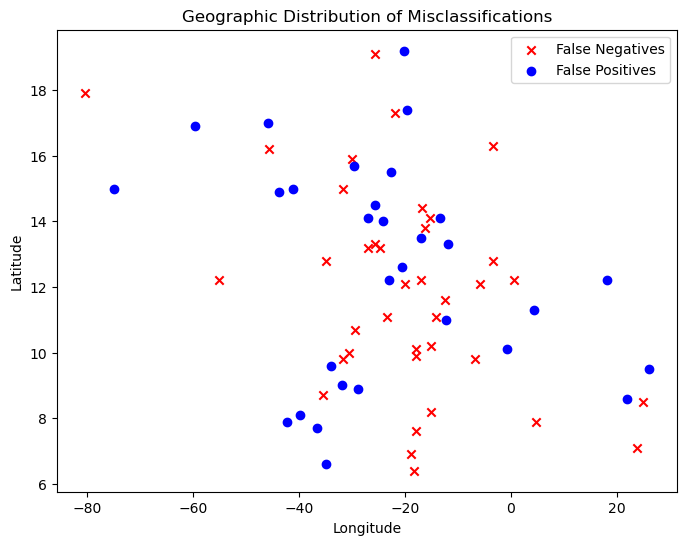

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(lon_false_neg, lat_false_neg, marker='x', color='red', label='False Negatives')
plt.scatter(lon_false_pos, lat_false_pos, marker='o', color='blue', label='False Positives')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographic Distribution of Misclassifications')
plt.legend()
plt.show()


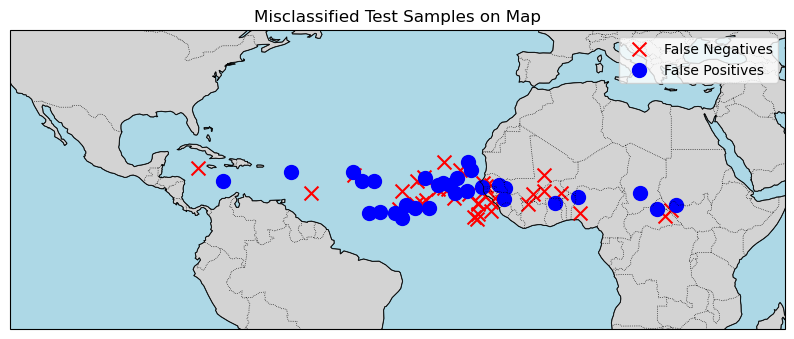

In [41]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())



lon_min, lon_max = np.min(lon_test)-15, np.max(lon_test)+15
lat_min, lat_max = np.min(lat_test)-15, np.max(lat_test)+15
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Plot misclassified points:
ax.scatter(lon_false_neg, lat_false_neg, color='red', marker='x', s=100,
           transform=ccrs.PlateCarree(), label='False Negatives')
ax.scatter(lon_false_pos, lat_false_pos, color='blue', marker='o', s=100,
           transform=ccrs.PlateCarree(), label='False Positives')

plt.title("Misclassified Test Samples on Map")
plt.legend()
plt.show()

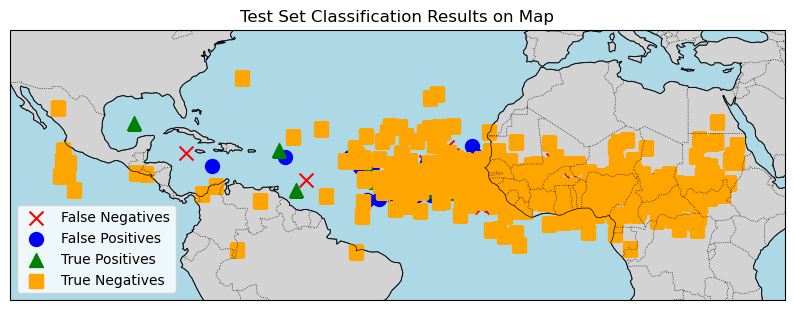

In [42]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set map extent (adjust margins as desired)
lon_min, lon_max = np.min(lon_test) - 10, np.max(lon_test) + 10
lat_min, lat_max = np.min(lat_test) - 10, np.max(lat_test) + 10
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='black')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
# Plot misclassified points
ax.scatter(lon_false_neg, lat_false_neg, color='red', marker='x', s=100,
           transform=ccrs.PlateCarree(), label='False Negatives')
ax.scatter(lon_false_pos, lat_false_pos, color='blue', marker='o', s=100,
           transform=ccrs.PlateCarree(), label='False Positives')



# Plot correctly classified points
ax.scatter(lon_true_pos, lat_true_pos, color='green', marker='^', s=100,
           transform=ccrs.PlateCarree(), label='True Positives')
ax.scatter(lon_true_neg, lat_true_neg, color='orange', marker='s', s=100,
           transform=ccrs.PlateCarree(), label='True Negatives')

plt.title("Test Set Classification Results on Map")
plt.legend()
plt.show()


In [43]:
print("Total samples:", len(sample_lat))
print("Unique latitudes:", len(np.unique(sample_lat)))
print("Unique longitudes:", len(np.unique(sample_lon)))


Total samples: 2750
Unique latitudes: 251
Unique longitudes: 913


In [44]:
print("First 10 latitudes:", sample_lat[:10])
print("First 10 longitudes:", sample_lon[:10])


First 10 latitudes: <xarray.DataArray 'lat_center' (sample: 10)> Size: 80B
dask.array<getitem, shape=(10,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
    file_name   (sample) <U102 4kB dask.array<chunksize=(10,), meta=np.ndarray>
    lat_center  (sample) float64 80B dask.array<chunksize=(10,), meta=np.ndarray>
    lon_center  (sample) float64 80B dask.array<chunksize=(10,), meta=np.ndarray>
  * sample      (sample) int64 80B 1 1 1 1 1 1 1 1 1 1
    time        (sample) datetime64[ns] 80B dask.array<chunksize=(10,), meta=np.ndarray>
First 10 longitudes: <xarray.DataArray 'lon_center' (sample: 10)> Size: 80B
dask.array<getitem, shape=(10,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
    file_name   (sample) <U102 4kB dask.array<chunksize=(10,), meta=np.ndarray>
    lat_center  (sample) float64 80B dask.array<chunksize=(10,), meta=np.ndarray>
    lon_center  (sample) float64 80B dask.array<chunksize=(10,), meta=np.ndarray>
  * sample 

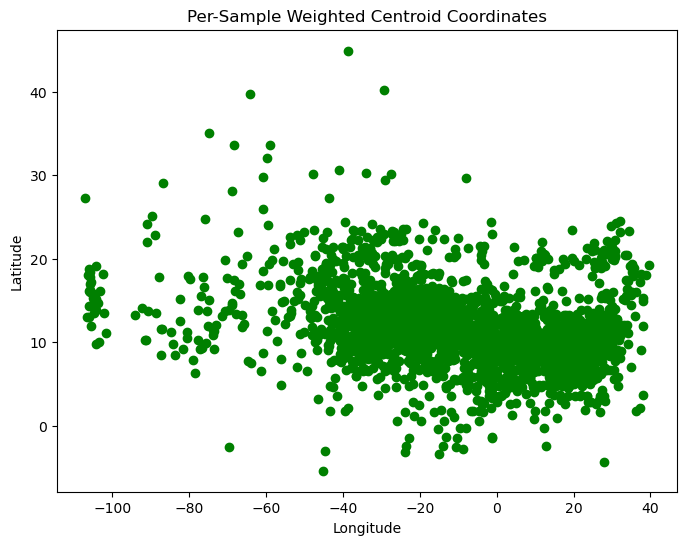

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(sample_lon, sample_lat, c='green', marker='o')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Per-Sample Weighted Centroid Coordinates')
plt.show()


In [46]:


# --- Permutation Importance ---
# Evaluate baseline performance using your loss metric (here, the custom f1_loss_sigmoid)
# model.metrics_names gives a list where index 0 is 'loss'
baseline_results = model.evaluate(input_test_scaled, label_test_scaled,
                                  batch_size=label_test_scaled.shape[0],
                                  verbose=0)
baseline_loss = baseline_results[model.metrics_names.index('loss')]
print("Baseline loss:", baseline_loss)

# Set the number of repetitions for averaging
n_repeats = 5
n_features = input_test_scaled.shape[-1]
permutation_importances = np.zeros(n_features)

# Loop over each feature (channel)
for feature_idx in range(n_features):
    permuted_losses = []
    for _ in range(n_repeats):
        # Copy the test set to avoid modifying the original
        X_permuted = np.copy(input_test_scaled)
        # Permute the values of the selected feature across samples
        perm = np.random.permutation(X_permuted.shape[0])
        X_permuted[:, :, :, feature_idx] = X_permuted[perm, :, :, feature_idx]
        
        # Evaluate the model on the permuted test set
        permuted_results = model.evaluate(X_permuted, label_test_scaled,
                                          batch_size=label_test_scaled.shape[0],
                                          verbose=0)
        permuted_loss = permuted_results[model.metrics_names.index('loss')]
        permuted_losses.append(permuted_loss)
    
    avg_permuted_loss = np.mean(permuted_losses)
    # The difference between the permuted loss and baseline loss indicates feature importance:
    # A larger increase means the feature is more important.
    permutation_importances[feature_idx] = avg_permuted_loss - baseline_loss
    print(f"Feature {feature_idx} - Increase in Loss: {permutation_importances[feature_idx]}")

print("Permutation Importances (increase in loss) for all features:", permutation_importances)


Baseline loss: 0.08318306505680084


Feature 0 - Increase in Loss: 0.0027514323592185974


Feature 1 - Increase in Loss: -0.004715187847614294


Feature 2 - Increase in Loss: -0.005743402242660525


Feature 3 - Increase in Loss: 0.029783064126968378


Feature 4 - Increase in Loss: 0.019834345579147344


Feature 5 - Increase in Loss: 0.0006440162658691434


Feature 6 - Increase in Loss: 0.0027277067303657504


Feature 7 - Increase in Loss: 0.009260886907577509


Feature 8 - Increase in Loss: 0.001017437875270838


Feature 9 - Increase in Loss: 0.016385671496391294


Feature 10 - Increase in Loss: -1.3121962547296695e-05


Feature 11 - Increase in Loss: 0.01276192367076874


Feature 12 - Increase in Loss: -0.0010014265775680486


Feature 13 - Increase in Loss: -0.0024200662970542963


Feature 14 - Increase in Loss: 0.007427360117435458


Feature 15 - Increase in Loss: 0.0005112990736961393


Feature 16 - Increase in Loss: 0.0024303525686264066


Feature 17 - Increase in Loss: 0.002885566651821131
Permutation Importances (increase in loss) for all features: [ 2.75143236e-03 -4.71518785e-03 -5.74340224e-03  2.97830641e-02
  1.98343456e-02  6.44016266e-04  2.72770673e-03  9.26088691e-03
  1.01743788e-03  1.63856715e-02 -1.31219625e-05  1.27619237e-02
 -1.00142658e-03 -2.42006630e-03  7.42736012e-03  5.11299074e-04
  2.43035257e-03  2.88556665e-03]


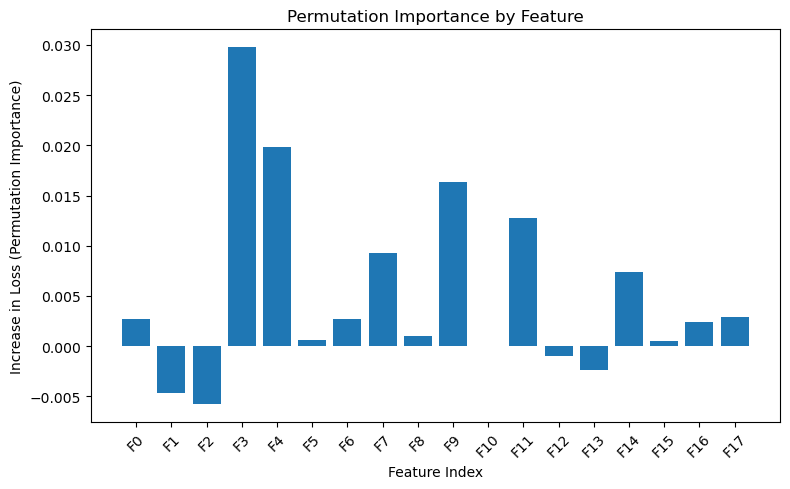

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Suppose permutation_importances is the numpy array you printed:
# e.g., [0.0820, 0.0824, 0.0815, 0.0864, 0.0121, ...]

feature_indices = np.arange(len(permutation_importances))

plt.figure(figsize=(8, 5))
plt.bar(feature_indices, permutation_importances)
plt.xlabel("Feature Index")
plt.ylabel("Increase in Loss (Permutation Importance)")
plt.title("Permutation Importance by Feature")
plt.xticks(feature_indices, [f"F{i}" for i in feature_indices], rotation=45)
plt.tight_layout()
plt.show()


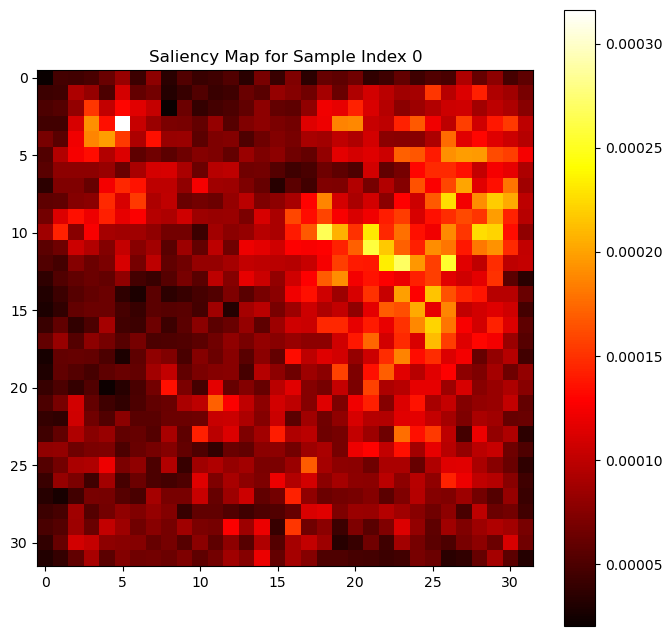

In [48]:
sample_index = 0
sample_input = input_test_scaled[sample_index:sample_index+1]

# Compute the saliency map for the selected test sample
saliency_map = compute_saliency_map(model, sample_input)

# Plot the saliency map
plt.figure(figsize=(8, 8))
plt.imshow(saliency_map, cmap='hot')
plt.colorbar()
plt.title(f"Saliency Map for Sample Index {sample_index}")
plt.show()



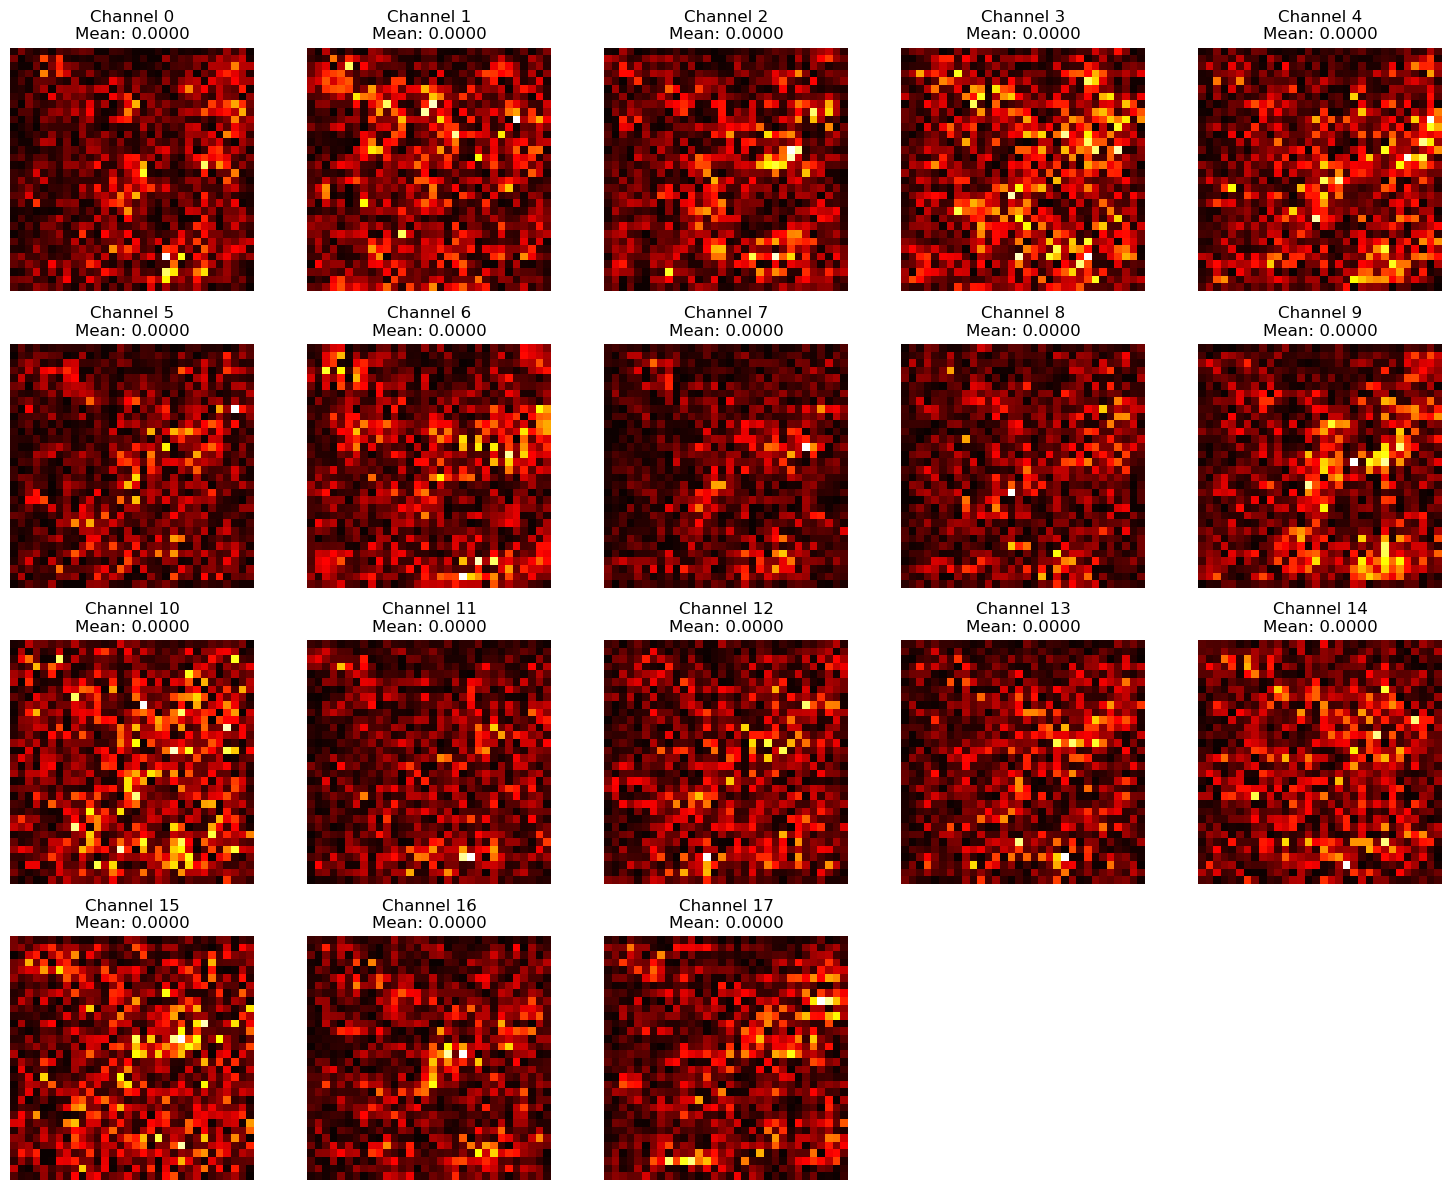

Channel importance (mean saliency per channel):
Channel 0: 0.0000
Channel 1: 0.0000
Channel 2: 0.0000
Channel 3: 0.0000
Channel 4: 0.0000
Channel 5: 0.0000
Channel 6: 0.0000
Channel 7: 0.0000
Channel 8: 0.0000
Channel 9: 0.0000
Channel 10: 0.0000
Channel 11: 0.0000
Channel 12: 0.0000
Channel 13: 0.0000
Channel 14: 0.0000
Channel 15: 0.0000
Channel 16: 0.0000
Channel 17: 0.0000


In [49]:
sample_index = 1
sample_input = input_test_scaled[sample_index:sample_index+1]

# Compute saliency maps per channel for the selected input sample
saliency_maps, channel_importance = compute_saliency_per_channel(model, sample_input)

# Plot the saliency maps for each channel
num_channels = saliency_maps.shape[-1]
cols = 5  # Set number of columns for plotting
rows = int(np.ceil(num_channels / cols))
plt.figure(figsize=(15, rows * 3))
for c in range(num_channels):
    plt.subplot(rows, cols, c + 1)
    plt.imshow(saliency_maps[:, :, c], cmap='hot')
    plt.title(f'Channel {c}\nMean: {channel_importance[c]:.4f}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Print aggregated channel importance values
print("Channel importance (mean saliency per channel):")
for c, imp in enumerate(channel_importance):
    print(f"Channel {c}: {imp:.4f}")


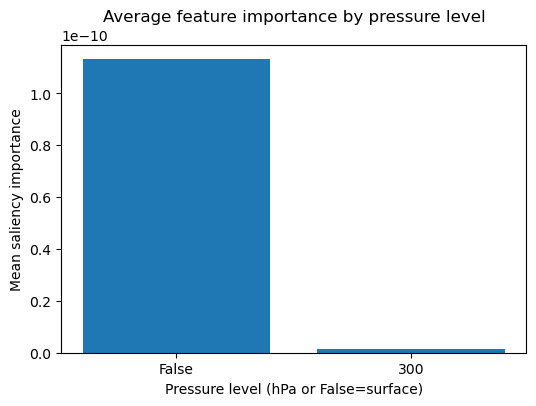

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Compute per‑sample, per‑channel saliency importances
all_imps = []
for x in input_test_scaled:             # each x has shape (32,32,channels)
    _, imp = compute_saliency_per_channel(best_model, x[np.newaxis,...])
    all_imps.append(imp)               # imp.shape == (channels,)
all_imps = np.stack(all_imps)          # shape (N_samples, channels)

# 2) Average importance across samples
mean_imp = all_imps.mean(axis=0)       # shape (channels,)

# 3) Build a DataFrame mapping feature→plevel→importance
df = pd.DataFrame({
    "feature": var_list,
    "plevel": plevel_list,
    "importance": mean_imp
})

# 4) Group by pressure level and plot
grouped = df.groupby("plevel")["importance"].mean().reset_index()
plt.figure(figsize=(6,4))
plt.bar(grouped["plevel"].astype(str), grouped["importance"])
plt.xlabel("Pressure level (hPa or False=surface)")
plt.ylabel("Mean saliency importance")
plt.title("Average feature importance by pressure level")
plt.show()


{'loss': 0.08318306505680084, 'compile_metrics': 0.3271480202674866}
    f1_score  val_f1_score
95  0.966581      0.480000
96  0.961440      0.296296
97  0.918782      0.400000
98  0.931990      0.333333
99  0.946835      0.480000


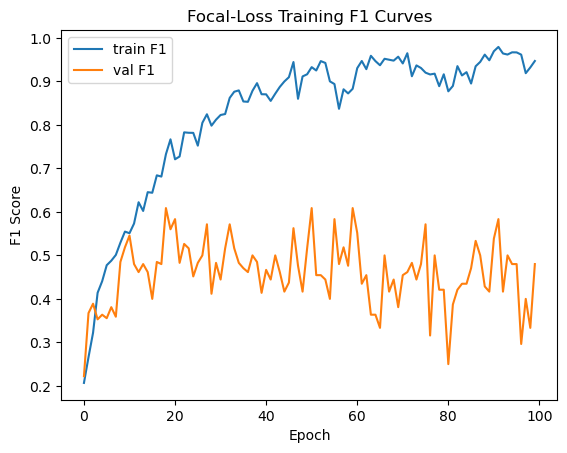

In [51]:
# 1) Print out full test‐set metrics by name
test_results = model.evaluate(
    input_test_scaled,
    label_test_scaled,
    batch_size=label_test_scaled.shape[0],
    verbose=0
)
print(dict(zip(model.metrics_names, test_results)))

# 2) Peek at the end of your training history for F1 improvements
import pandas as pd
hist_df = pd.DataFrame(history.history)
print(hist_df[['f1_score','val_f1_score']].tail())

# 3) (Optional) Plot train vs. val F1 over epochs
import matplotlib.pyplot as plt
plt.plot(hist_df['f1_score'],    label='train F1')
plt.plot(hist_df['val_f1_score'],label='val F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.title('Focal‐Loss Training F1 Curves')
plt.show()


In [52]:
# Replace your rebuild logic:
# top_hps = tuner.get_best_hyperparameters(num_trials=5)
# models  = [MyHyperModel().build(hp) for hp in top_hps]

# With this single line:
models = tuner.get_best_models(num_models=5)

# Then stack and average as before:
all_preds     = np.stack([m.predict(input_test_scaled).flatten() for m in models], axis=0)
ensemble_probs= all_preds.mean(axis=0)
ensemble_preds= (ensemble_probs >= 0.5).astype(int)
print("Ensemble F1:", f1_score(label_test_scaled, ensemble_preds))


/glade/u/home/rmandava/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


Ensemble F1: 0.0


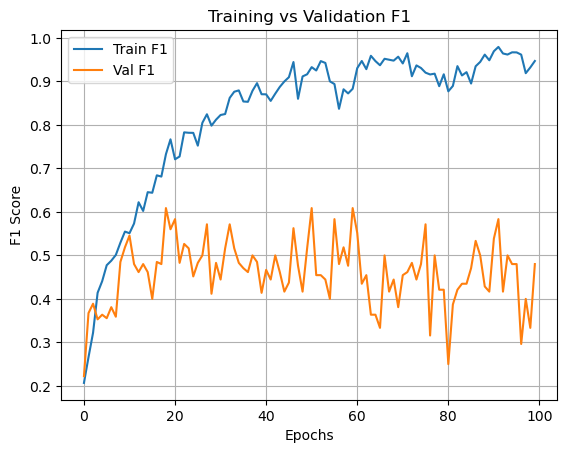

In [53]:
import matplotlib.pyplot as plt

plt.plot(history.history['f1_score'], label='Train F1')
plt.plot(history.history['val_f1_score'], label='Val F1')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Training vs Validation F1')
plt.legend()
plt.grid()
plt.show()


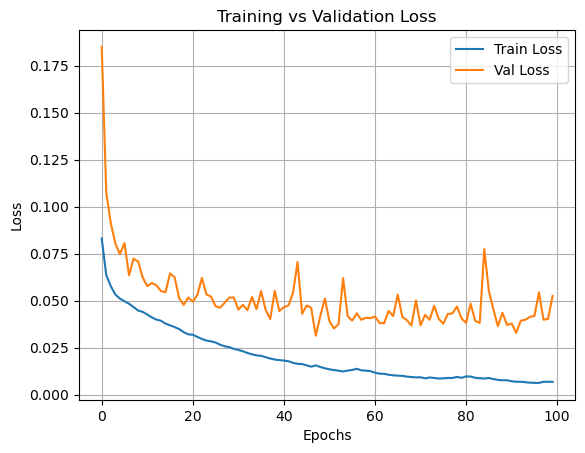

In [54]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid()
plt.show()
